# Exponential smoothing



In [5]:
#Importing Libraries
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from yahoofinancials import YahooFinancials
import seaborn as sns

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

%matplotlib inline
from statsmodels.tsa.filters.hp_filter import hpfilter
plt.style.use('ggplot')

In [1]:
ticker_details = pd.read_excel("Ticker List.xlsx")
ticker_details.head(20)

<IPython.core.display.Javascript object>

Ticker              Description
0       GC=F                     Gold
1       SI=F                   Silver
2       CL=F                Crude Oil
3      ^GSPC                   S&P500
4       ^RUT        Russel 2000 Index
5       ZN=F  10 Yr US T-Note futures
6       ZT=F   2 Yr US T-Note Futures
7       PL=F                 Platinum
8       HG=F                   Copper
9       DX=F             Dollar Index
10      ^VIX         Volatility Index
11       S=F                  Soybean
12       EEM              MSCI EM ETF
13  EURUSD=X                 Euro USD
14     ^N100              Euronext100
15     ^IXIC                   Nasdaq

In [2]:
ticker = ticker_details['Ticker'].to_list()
names = ticker_details['Description'].to_list()

In [3]:
#Extracting Data from Yahoo Finance and Adding them to Values table using date as key
end_date= "2020-09-30"
start_date = "2010-01-01"
date_range = pd.bdate_range(start=start_date,end=end_date)
"""
Create a date-range and write it to an empty dataframe named values. Here I would extract and 
past the values pulled from yahoofinancials.
"""
df = pd.DataFrame({ 'Date': date_range})
df['Date']= pd.to_datetime(df['Date'])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [7]:
from pandas import DataFrame 
#Extracting Data from Yahoo Finance and Adding them to Values table using date as key
for i in ticker:
    raw_data = YahooFinancials(i)
    raw_data = raw_data.get_historical_price_data(start_date, end_date, "daily")
    data = DataFrame(raw_data[i]['prices'])[['formatted_date','adjclose']]
    data.columns = ['Date1',i]
    data['Date1']= pd.to_datetime(data['Date1'])
    df = df.merge(data,how='left',left_on='Date',right_on='Date1')
    df = df.drop(labels='Date1',axis=1)

#Renaming columns to represent instrument names rather than their ticker codes for ease of readability
names.insert(0,'Date')
df.columns = names
print(df.shape)
print(df.isna().sum())
df.tail()

(2804, 17)
Date                         0
Gold                       122
Silver                     122
Crude Oil                  121
S&P500                     100
Russel 2000 Index          100
10 Yr US T-Note futures    123
2 Yr US T-Note Futures     121
Platinum                   122
Copper                     122
Dollar Index               123
Volatility Index           100
Soybean                    147
MSCI EM ETF                100
Euro USD                   338
Euronext100                 59
Nasdaq                     100
dtype: int64


Date         Gold     Silver  Crude Oil       S&P500  \
2799 2020-09-24  1868.300049  23.118000  40.310001  3246.590088   
2800 2020-09-25  1857.699951  23.017000  40.250000  3298.459961   
2801 2020-09-28  1872.800049  23.528000  40.599998  3351.600098   
2802 2020-09-29  1894.300049  24.379999  39.290001  3335.469971   
2803 2020-09-30          NaN        NaN        NaN          NaN   

      Russel 2000 Index  10 Yr US T-Note futures  2 Yr US T-Note Futures  \
2799        1451.819946               139.578003              110.426003   
2800        1474.910034               139.641006              110.438004   
2801        1510.339966               139.625000              110.441002   
2802        1504.729980               139.781006              110.445000   
2803                NaN                      NaN                     NaN   

        Platinum  Copper  Dollar Index  Volatility Index  Soybean  \
2799  837.099976  2.9690     94.393997         28.510000      NaN   
2800  841.099976  2.9730     94.681999         26.379999      NaN   
2801  881.900024  2.9895     94.302002         26.190001      NaN   
2802  887.500000  2.9835     93.927002         26.270000      NaN   
2803         NaN     NaN           NaN               NaN      NaN   

      MSCI EM ETF  Euro USD  Euronext100        Nasdaq  
2799    42.900002  1.167324   948.109985  10672.269531  
2800    42.939999       NaN   944.549988  10913.559570  
2801    43.419998  1.167883   965.710022  11117.530273  
2802    43.389999  1.174205   962.190002  11085.250000  
2803          NaN       NaN          NaN           NaN

In [8]:
# Front filling the NaN values in the data set
df = df.fillna(method="ffill",axis=0)
df = df.fillna(method="bfill",axis=0)
df.isna().sum()

Date                       0
Gold                       0
Silver                     0
Crude Oil                  0
S&P500                     0
Russel 2000 Index          0
10 Yr US T-Note futures    0
2 Yr US T-Note Futures     0
Platinum                   0
Copper                     0
Dollar Index               0
Volatility Index           0
Soybean                    0
MSCI EM ETF                0
Euro USD                   0
Euronext100                0
Nasdaq                     0
dtype: int64

In [9]:
df.tail()

Date         Gold     Silver  Crude Oil       S&P500  \
2799 2020-09-24  1868.300049  23.118000  40.310001  3246.590088   
2800 2020-09-25  1857.699951  23.017000  40.250000  3298.459961   
2801 2020-09-28  1872.800049  23.528000  40.599998  3351.600098   
2802 2020-09-29  1894.300049  24.379999  39.290001  3335.469971   
2803 2020-09-30  1894.300049  24.379999  39.290001  3335.469971   

      Russel 2000 Index  10 Yr US T-Note futures  2 Yr US T-Note Futures  \
2799        1451.819946               139.578003              110.426003   
2800        1474.910034               139.641006              110.438004   
2801        1510.339966               139.625000              110.441002   
2802        1504.729980               139.781006              110.445000   
2803        1504.729980               139.781006              110.445000   

        Platinum  Copper  Dollar Index  Volatility Index  Soybean  \
2799  837.099976  2.9690     94.393997         28.510000   903.75   
2800  841.099976  2.9730     94.681999         26.379999   903.75   
2801  881.900024  2.9895     94.302002         26.190001   903.75   
2802  887.500000  2.9835     93.927002         26.270000   903.75   
2803  887.500000  2.9835     93.927002         26.270000   903.75   

      MSCI EM ETF  Euro USD  Euronext100        Nasdaq  
2799    42.900002  1.167324   948.109985  10672.269531  
2800    42.939999  1.167324   944.549988  10913.559570  
2801    43.419998  1.167883   965.710022  11117.530273  
2802    43.389999  1.174205   962.190002  11085.250000  
2803    43.389999  1.174205   962.190002  11085.250000

# Trend


## Detecting Trend Using a Hodrick-Prescott Filter

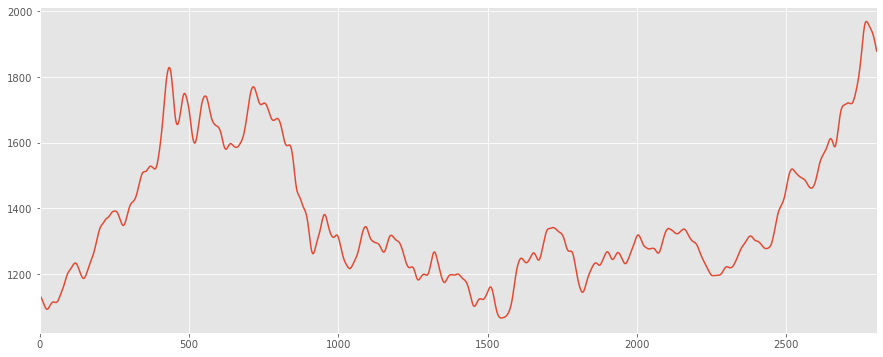

In [10]:
#df = pd.read_excel('India_Exchange_Rate_Dataset.xls', parse_dates=True)
Gold_cycle, Gold_trend = hpfilter(df['Gold'], lamb=1600)
Gold_trend.plot(figsize=(15,6)).autoscale(axis='x',tight=True)

## Detrending Using Differencing

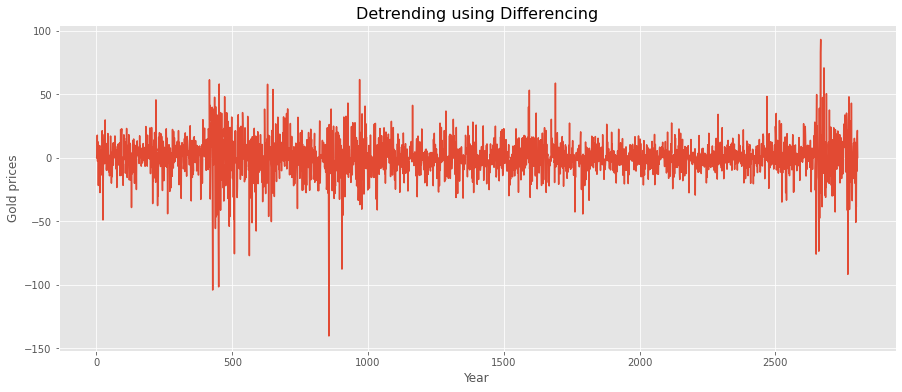

In [11]:
diff = df.Gold.diff()
plt.figure(figsize=(15,6))
plt.plot(diff)
plt.title('Detrending using Differencing', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Gold prices')
plt.show()

## Detrending Using a SciPy Signal

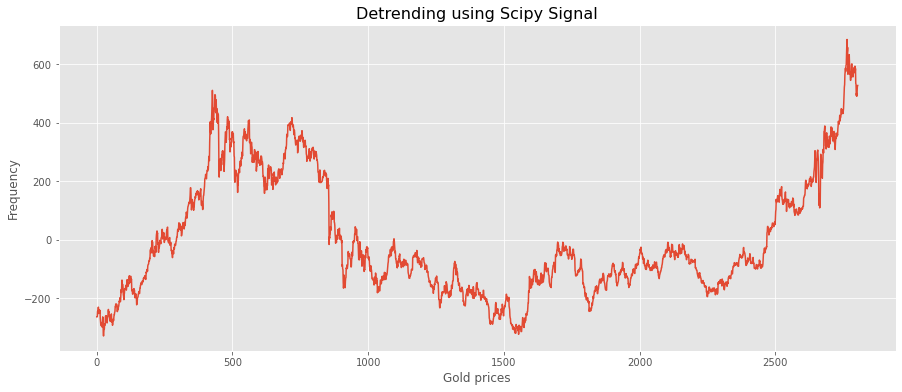

In [12]:
from scipy import signal
import warnings
warnings.filterwarnings("ignore")

detrended = signal.detrend(df.Gold.values)
plt.figure(figsize=(15,6))
plt.plot(detrended)
plt.xlabel('Gold prices')
plt.ylabel('Frequency')
plt.title('Detrending using Scipy Signal', fontsize=16)
plt.show()

## Detrend Using an HP Filter

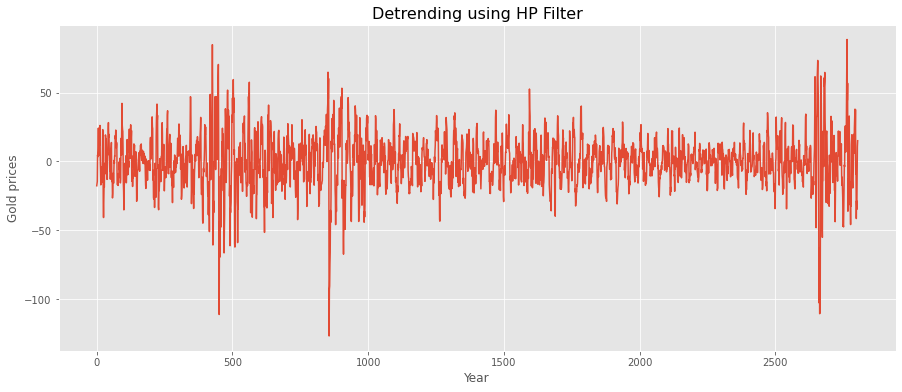

In [13]:
Gold_cycle,Gold_trend = hpfilter(df['Gold'], lamb=1600)
df['trend'] = Gold_trend
detrended = df.Gold - df['trend']
plt.figure(figsize=(15,6))
plt.plot(detrended)
plt.title('Detrending using HP Filter', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Gold prices')
plt.show()

# Seasonality

The following methods can be used to detect seasonality:
- Multiple box plots
- Autocorrelation plots

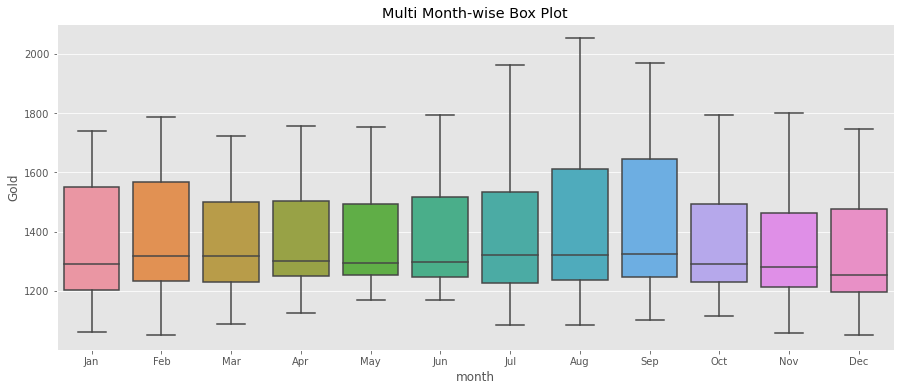

In [17]:
#df = pd.read_excel('India_Exchange_Rate_Dataset.xls', parse_dates=True)
df['month'] = df['Date'].dt.strftime('%b')
df['year'] = [d.year for d in df.Date]
df['month'] = [d.strftime('%b') for d in df.Date]
years = df['year'].unique()
plt.figure(figsize=(15,6))
sns.boxplot(x='month', y='Gold', data=df).set_title("Multi Month-wise Box Plot")
plt.show()

## Autocorrelation Plot

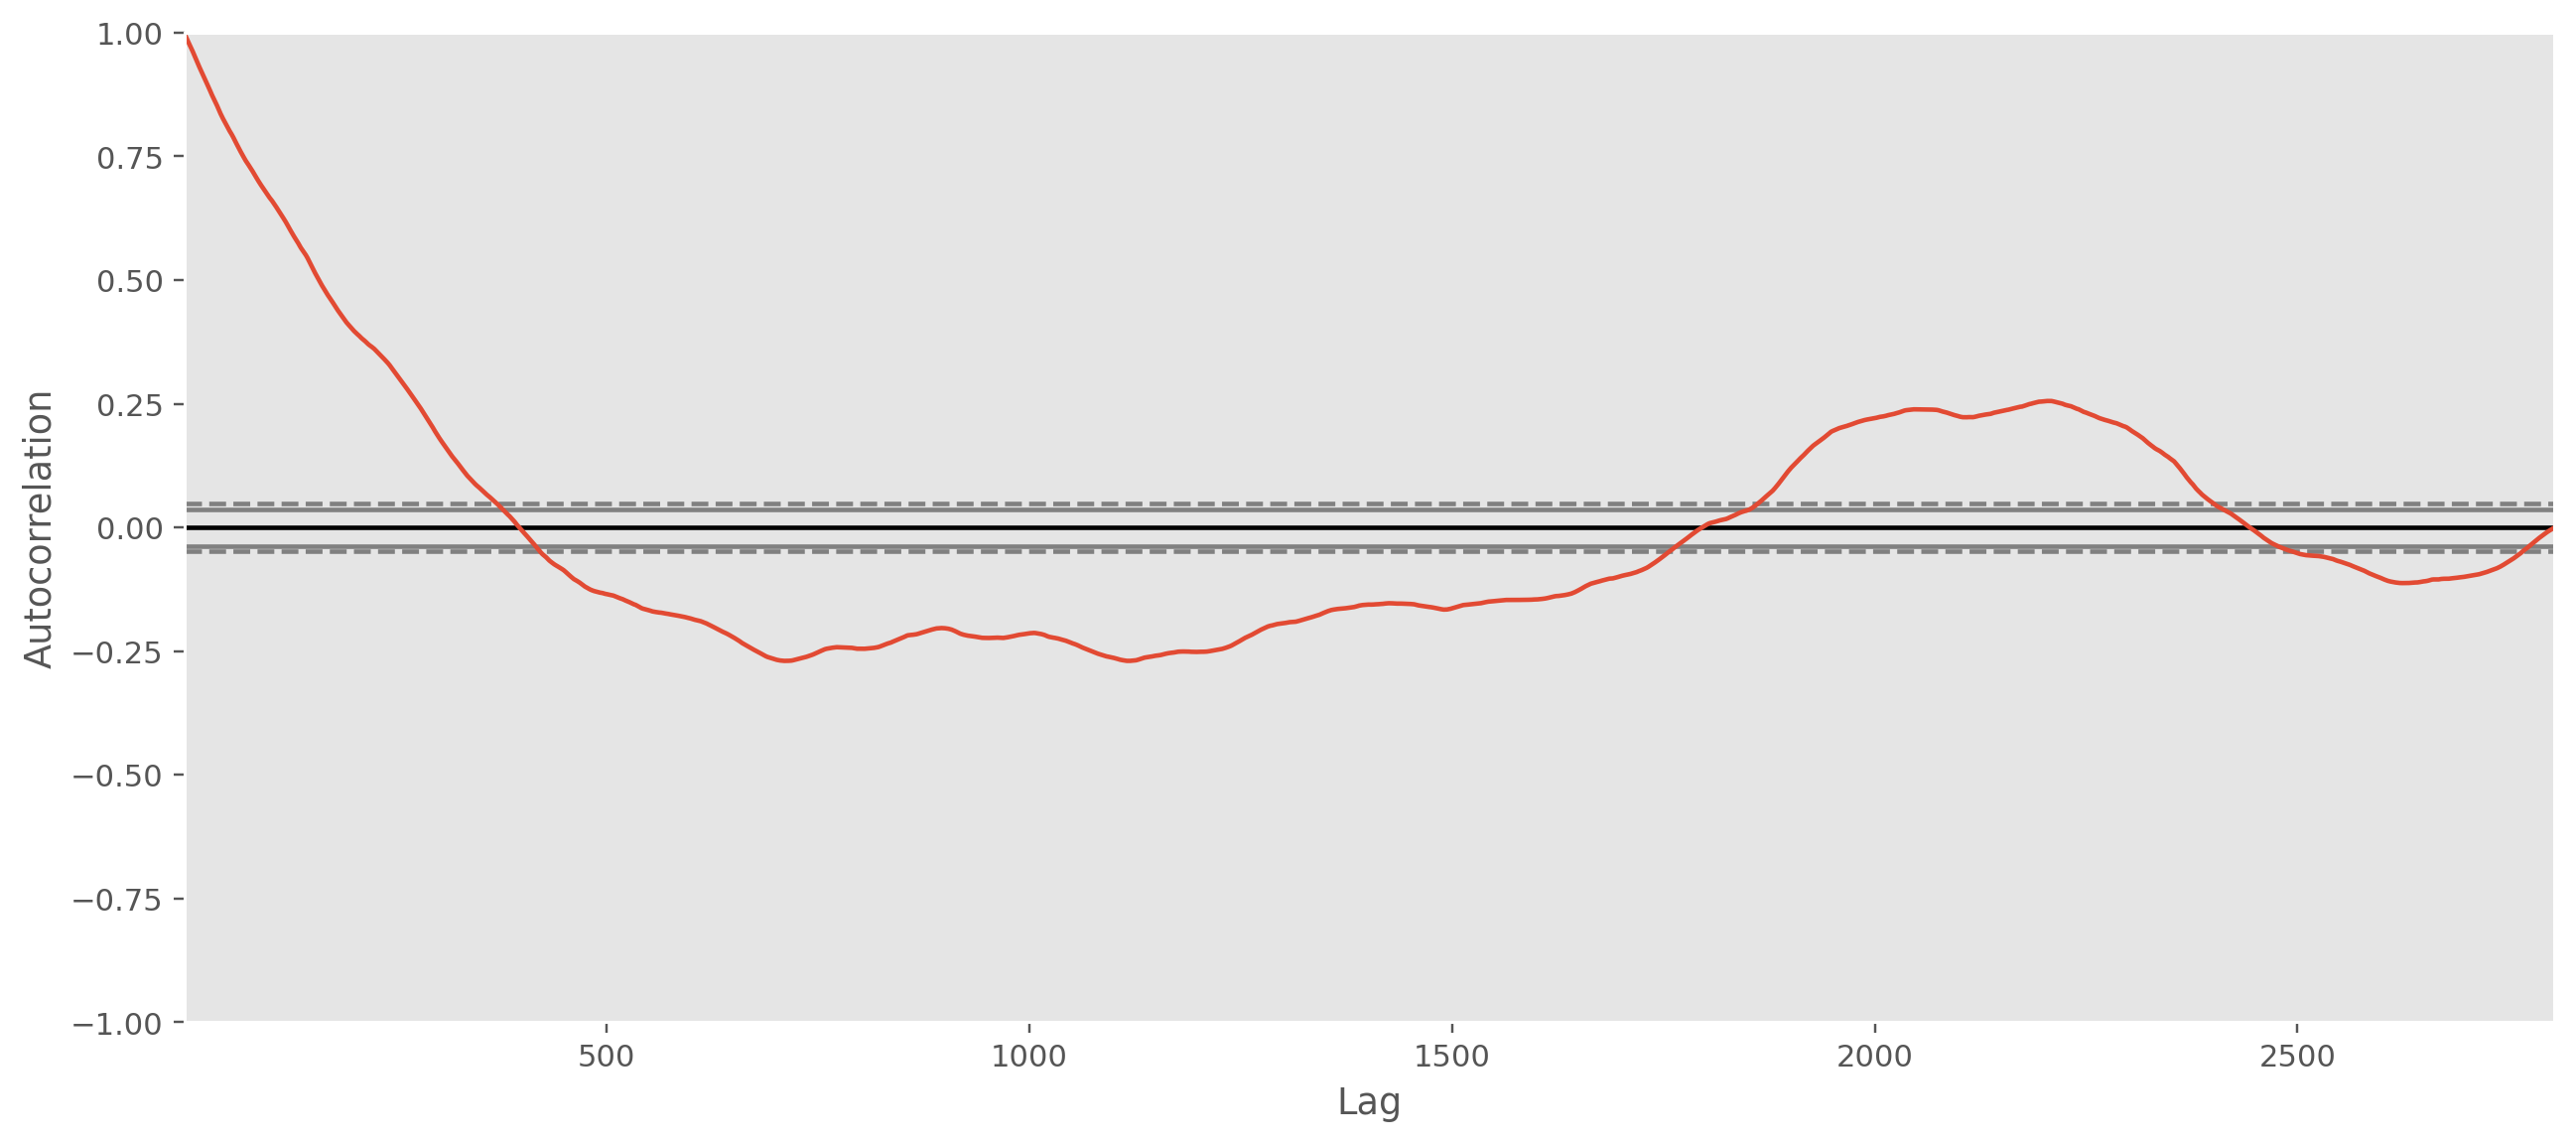

In [18]:
from pandas.plotting import autocorrelation_plot

plt.rcParams.update({'figure.figsize':(14,6), 'figure.dpi':220})
autocorrelation_plot(df.Gold.tolist())
plt.show()

# Deseasoning of Time-Series Data

## Time-series data contains four main components.
- Level means the average value of the time-series data.
- Trend means an increasing or decreasing value in time-series data.
- Seasonality means repeating the pattern of a cycle in the time-series data.
- Noise means random variance in time-series data.

Additive model is when time-series data combines these four components for linear trend and seasonality, and a multiplicative
model is when components are multiplied to gather for nonlinear trends and seasonality.

## Seasonal Decomposition
Decomposition is the process of understanding generalizations and problems related to time-series forecasting. We can leverage seasonal decomposition to remove seasonality from data and check the data only with the trend, cyclic, and irregular variations.

### Errors, Unexpected Variations, and Residuals
When trend and cyclical variations are removed from time-series data, the patterns left behind that cannot be explained are called errors, unexpected variations, or residuals. Various methods are available to check for irregular variations such as probability theory, moving averages, and autoregressive time-series methods. If we can find any cyclic variation in data, it is considered to be part of the residuals. These variations that occur due to unexpected circumstances are called unexpected variations or unpredictable errors.

### Decomposing a Time Series into Its Components
Decomposition is a method used to isolate the time-series data into different elements such as trends, seasonality, cyclic variance, and residuals. We can leverage seasonal decomposition from a stats model to decompose the data into its constituent parts, considering series as additive or multiplicative.

- Trends(T(t)) means an increase or decrease in the value of ts data.
- Seasonality(S[t]) means repeating a short-term cycle of ts data.
- Cyclic variations(c[t]) means a fluctuation in long trends of ts data.
- Residuals(e[t]) means an irregular variation of ts data.

The additive model works with linear trends of time-series data such as changes constantly over time. The additive model formula is as follows: Y[t] = T[t] + S[t] + c[t] + e[t]

The multiplicative model works with a nonlinear type of data such as quadric or exponential. The multiplicative model formula is as follows: Y[t] = T[t] * S[t] * c[t] * e[t]

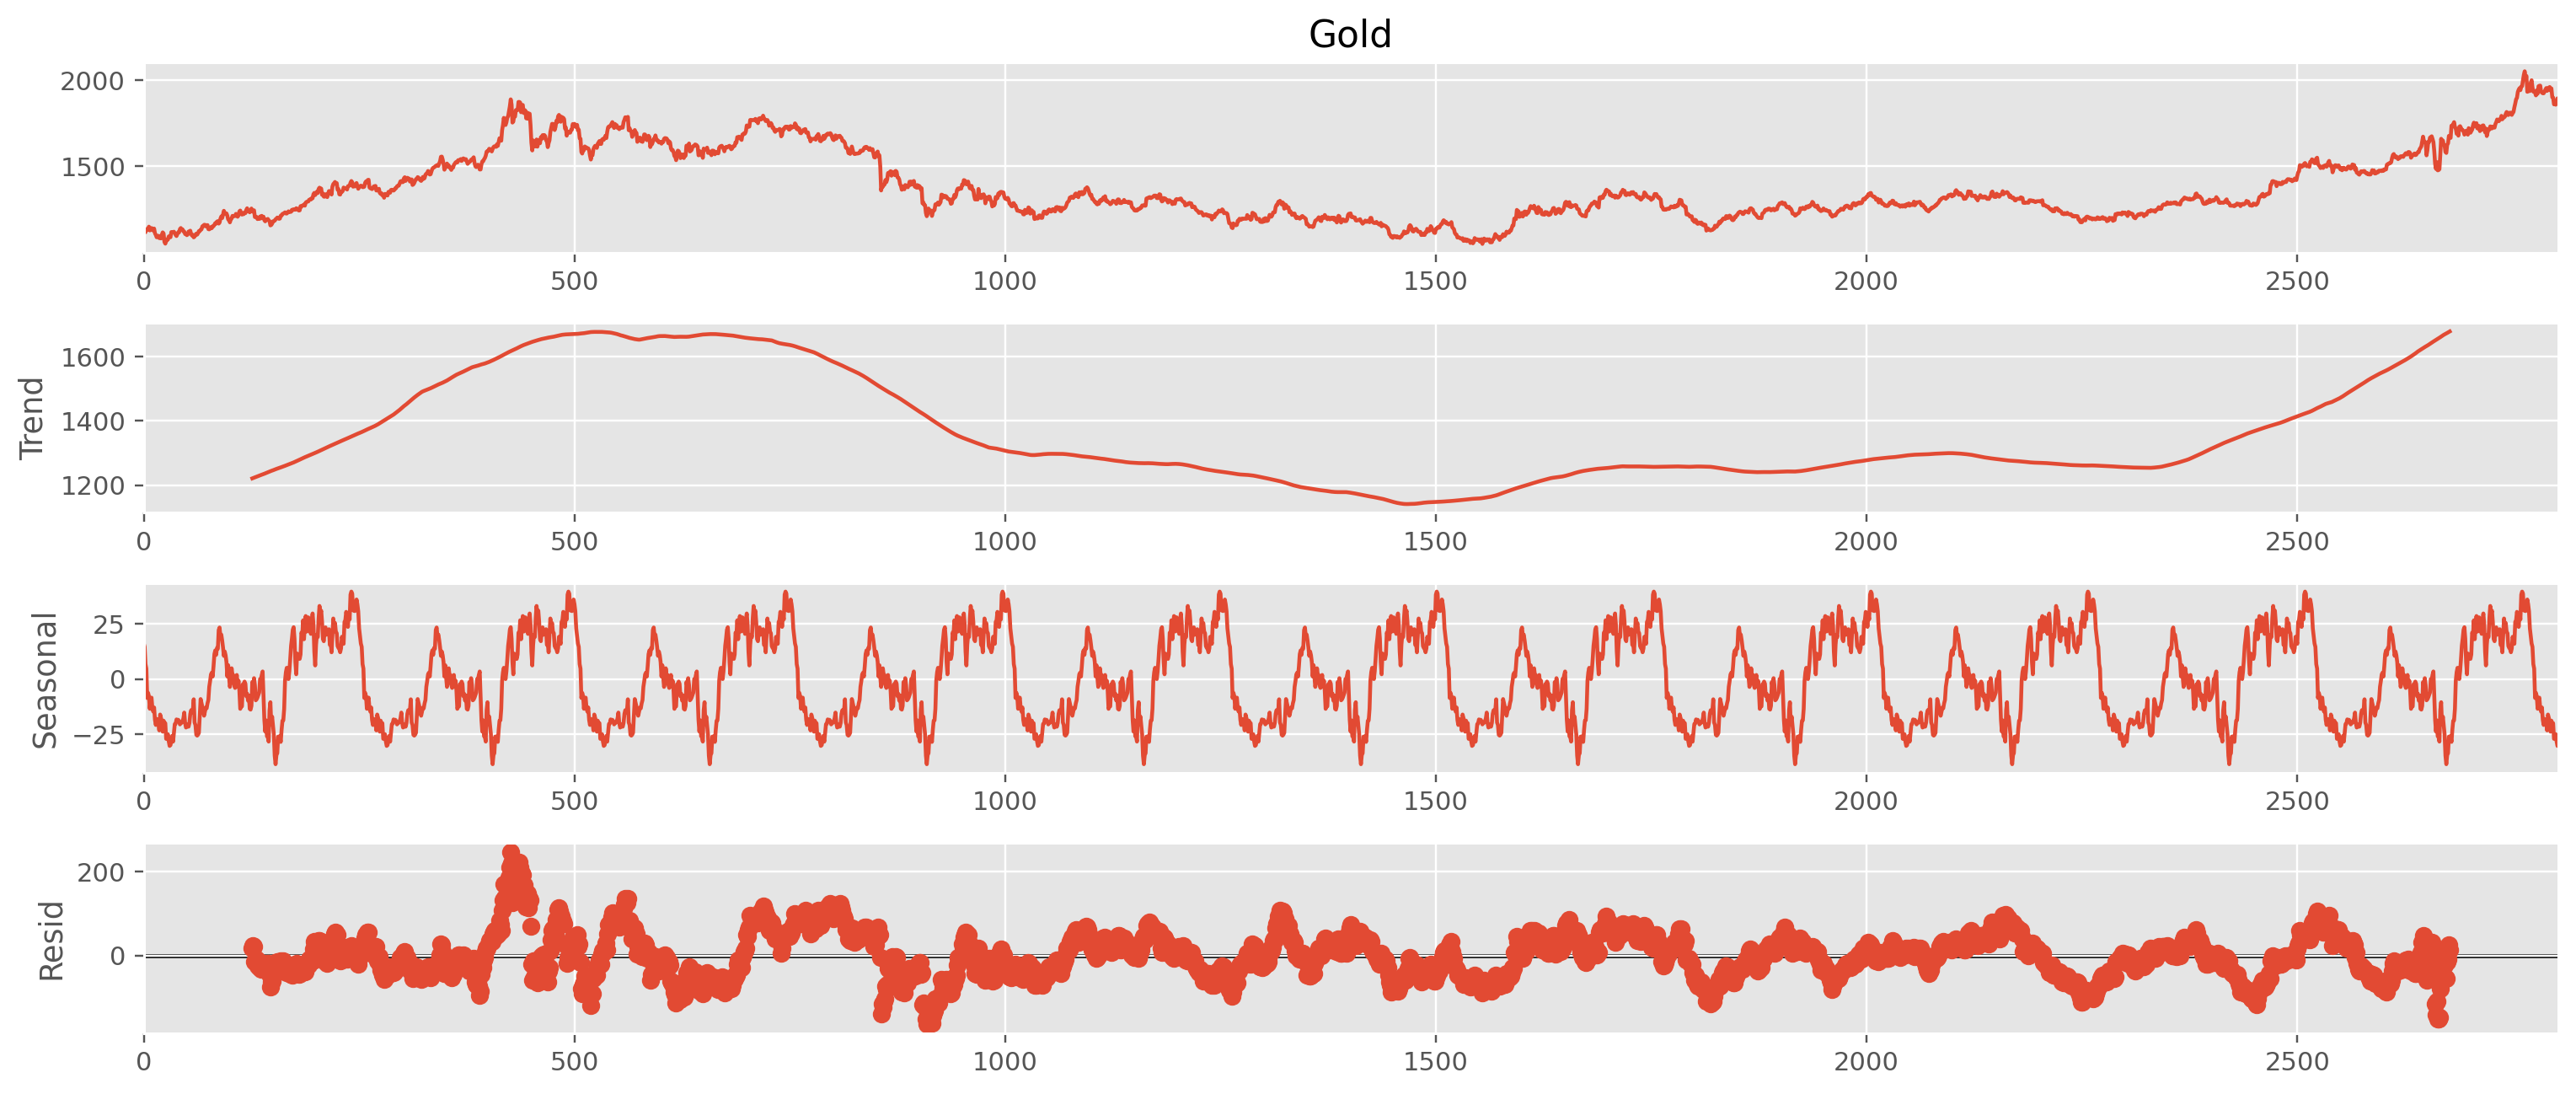

In [28]:
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings("ignore")

# Additive
result = seasonal_decompose(df['Gold'], model='ad', freq=252)
result.plot()
plt.show()

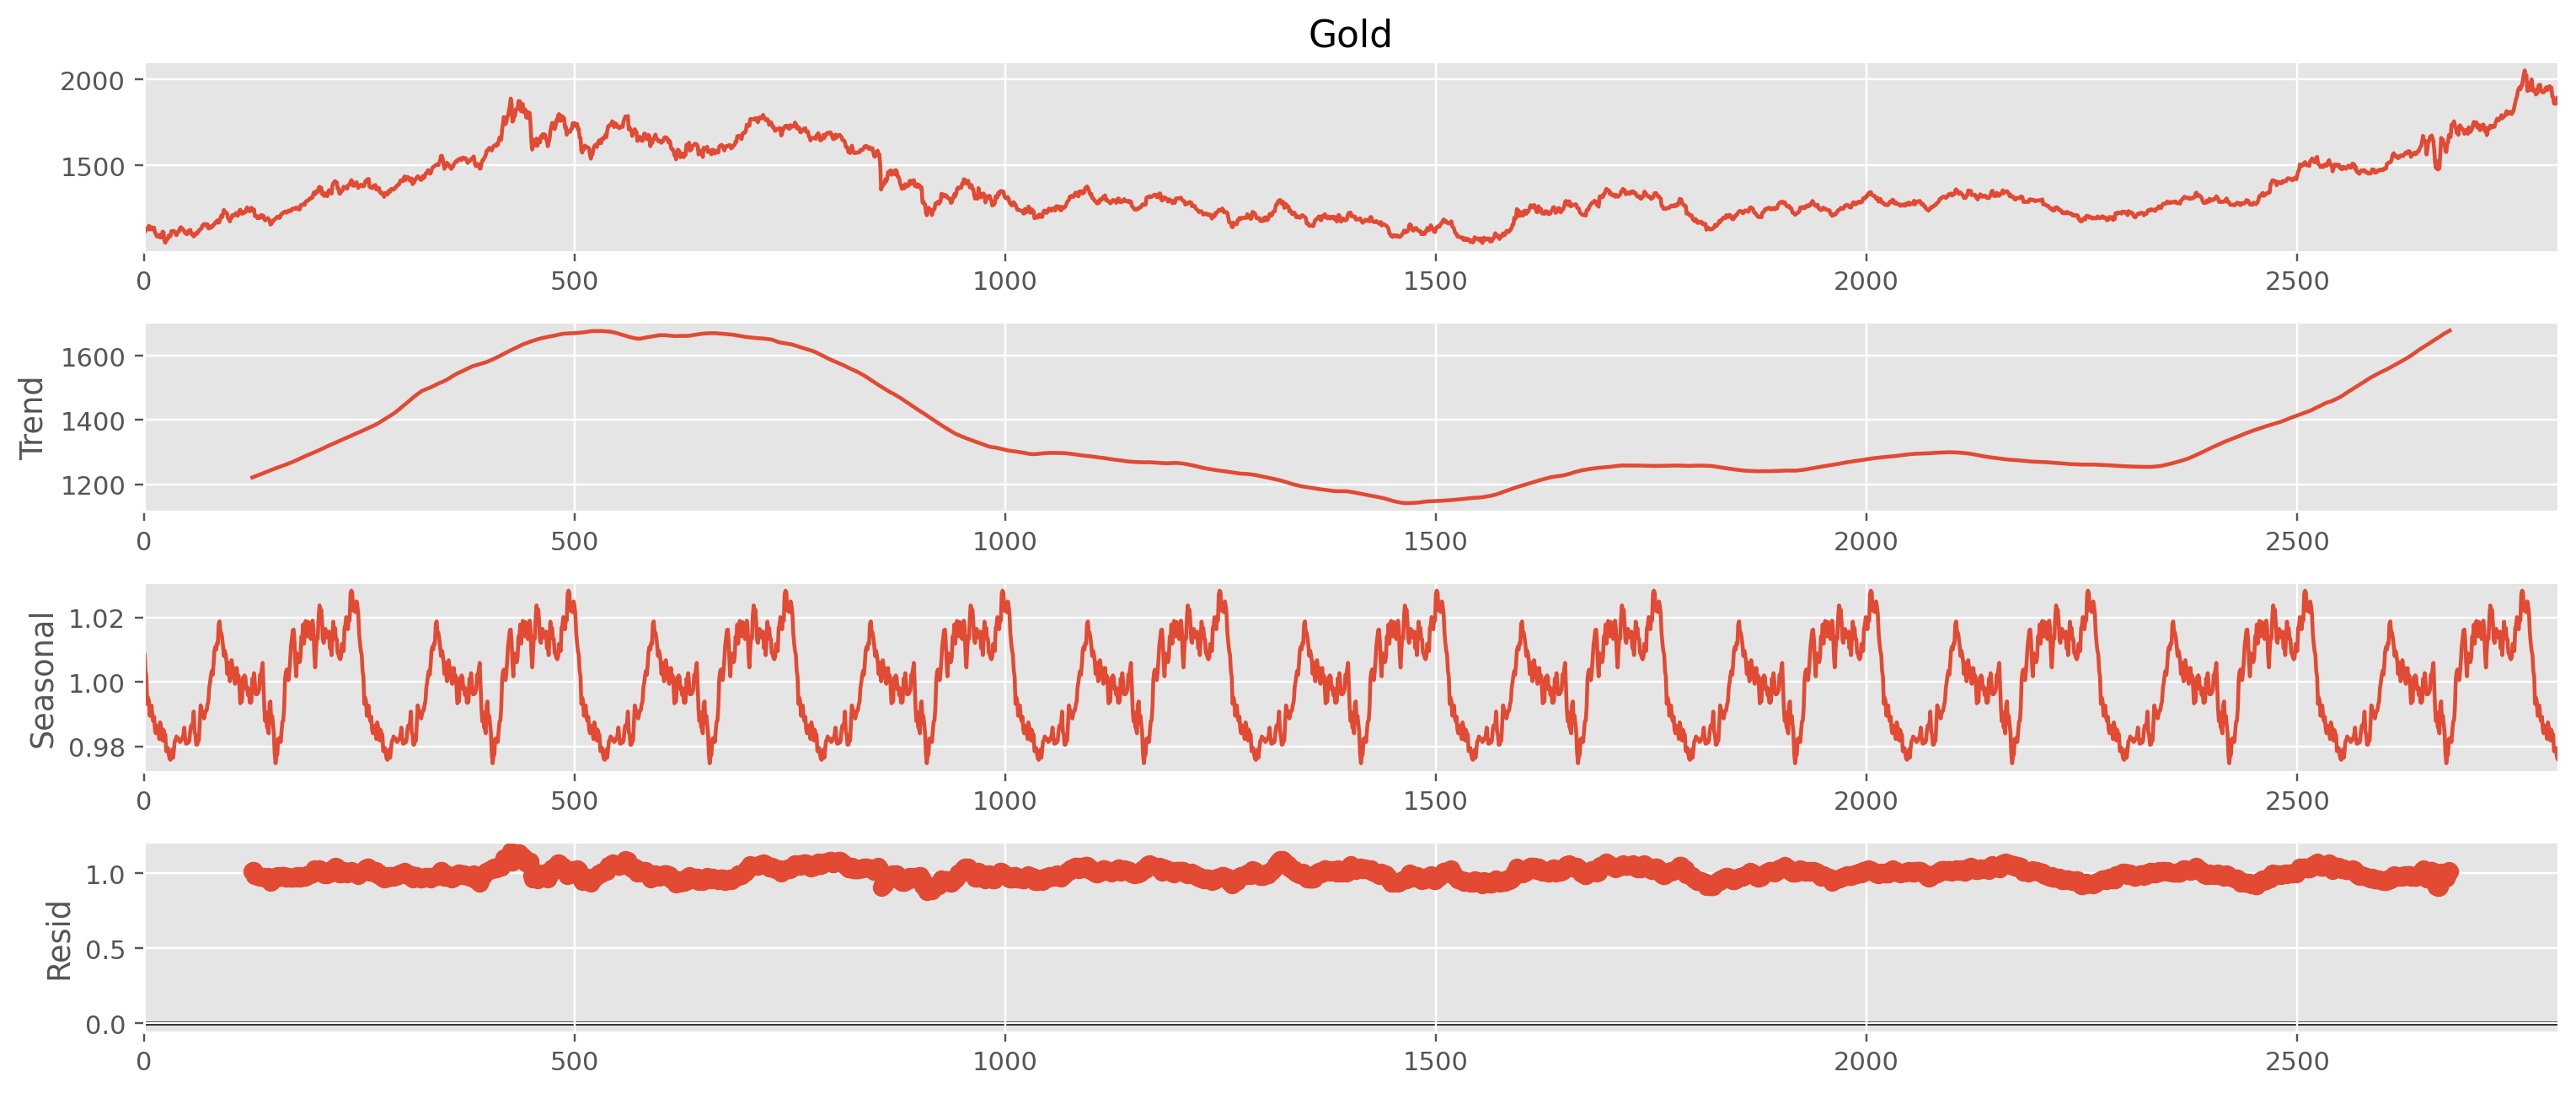

In [29]:
# Multiplicative
result = seasonal_decompose(df['Gold'], model='mul', freq=252)
result.plot()
plt.show()

## Cyclic Variations
Cyclical components are fluctuations around a long trend observed every few units of time; this behavior is less frequent compared to seasonality. It is a recurrent process in a time series. In the field of business/economics,
the following are three distinct types of cyclic variations examples:
- Prosperity: As we know, when organizations prosper, prices go up, but the benefits also increase. On the other hand, prosperity also causes over-development, challenges in transportation, increments in wage rate, insufficiency in labor, high rates of returns, deficiency of cash in the market and price concessions, etc., leading to depression
- Depression: As we know, when there is cynicism in exchange and enterprises, processing plants close down, organizations fall flat, joblessness spreads, and the wages and costs are low.
- Accessibility: This causes idealness of money, accessibility of cash at a low interest, an increase in demand for goods or money at a low interest rate, an increase in popular merchandise and ventures described by the circumstance of recuperation that at last prompts for prosperity or boom.

## Detecting Cyclical Variations
The following code shows how to decompose time-series data and visualize only a cyclic pattern:

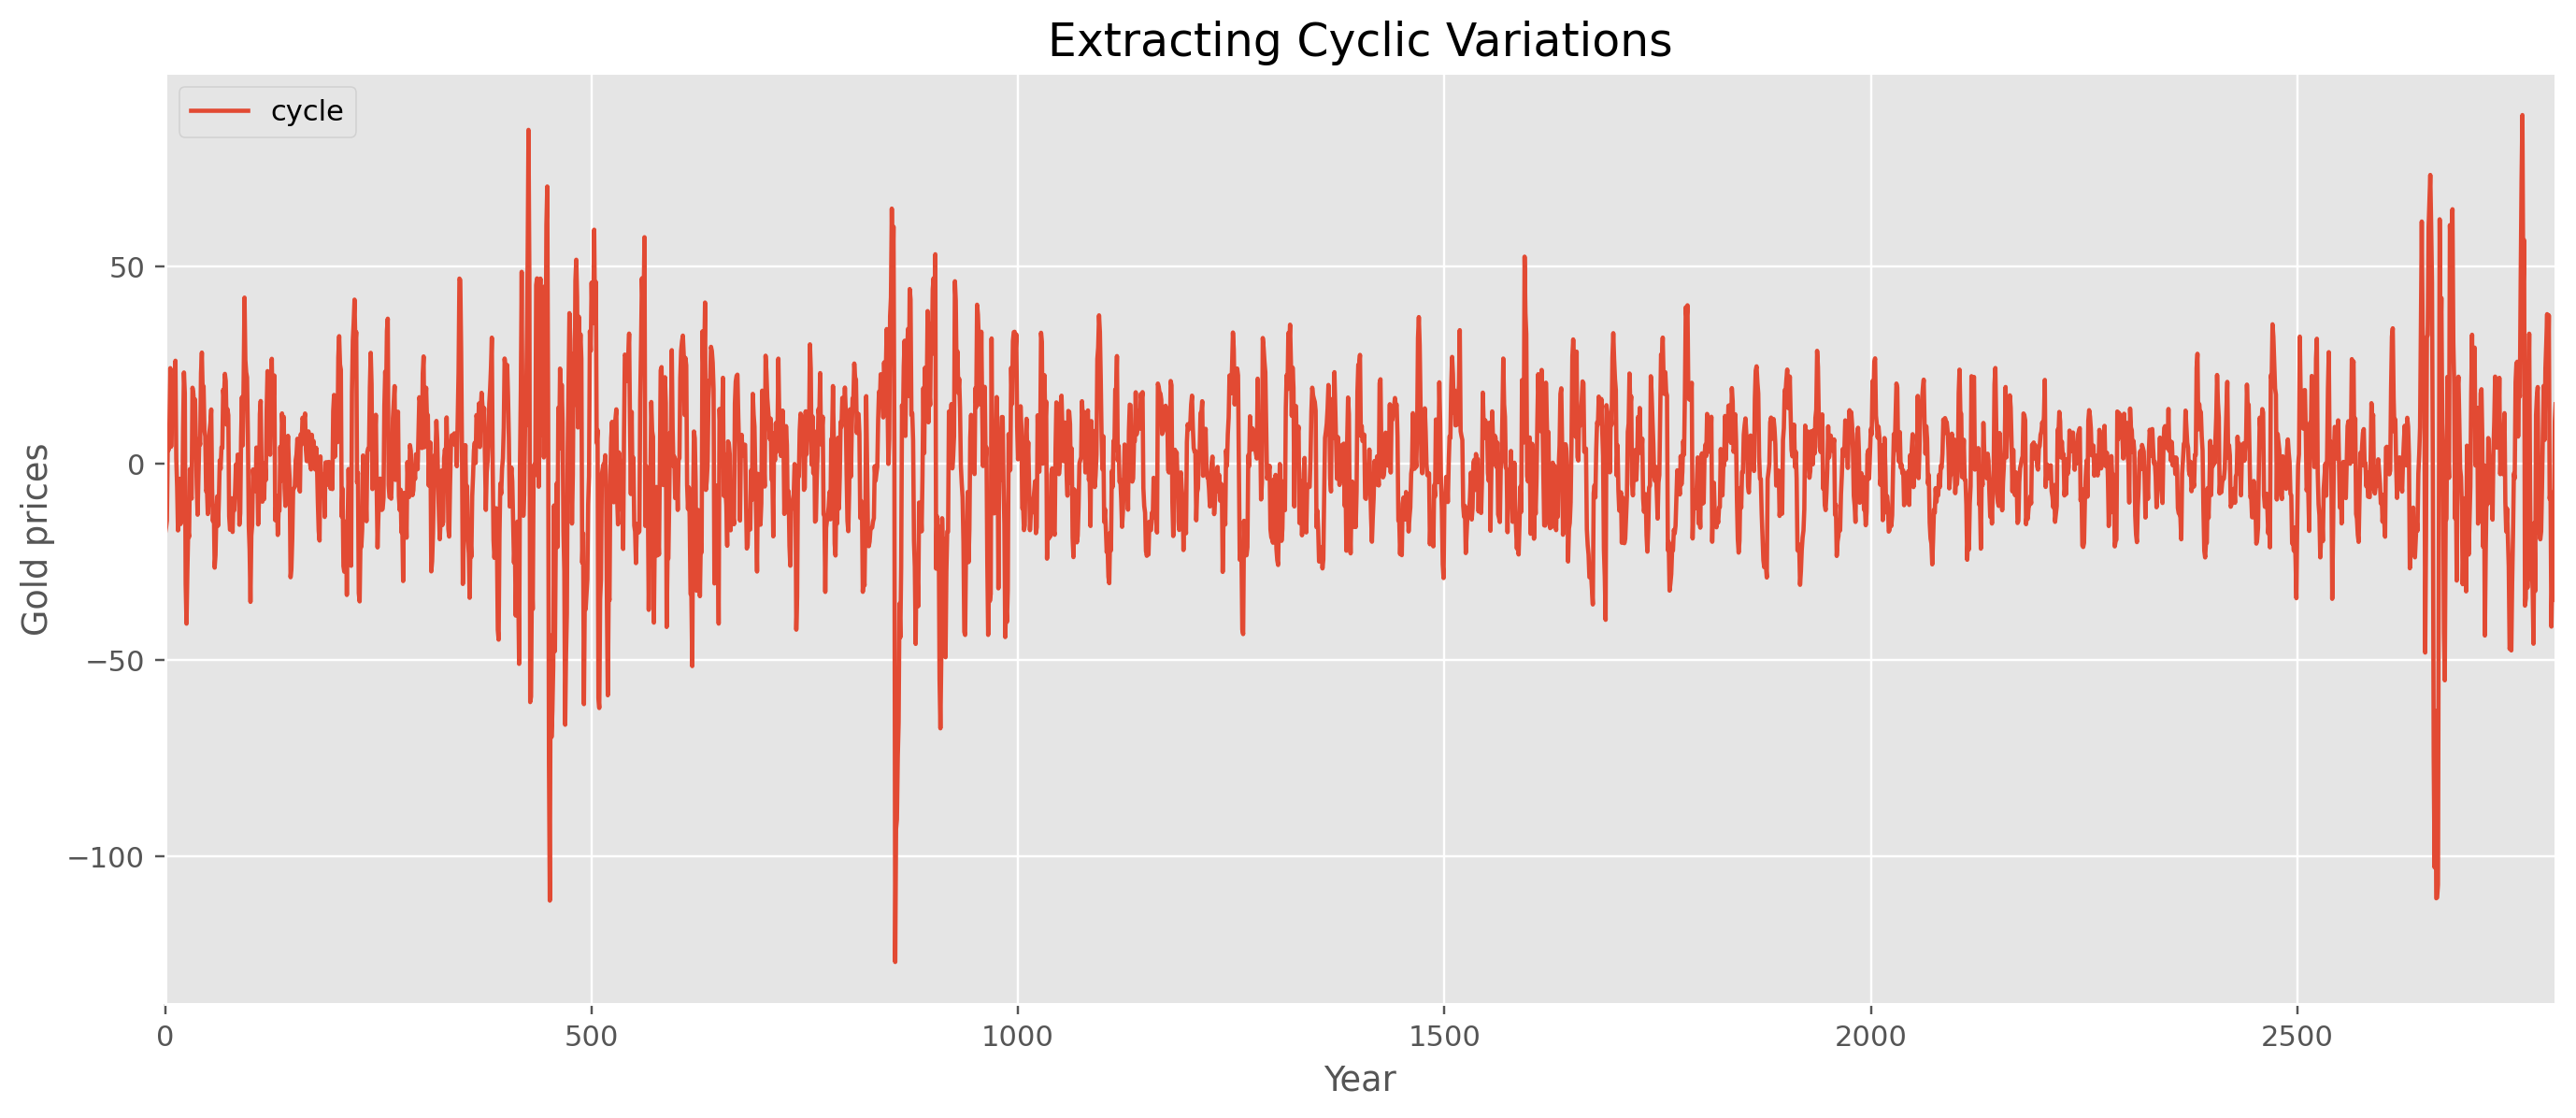

In [25]:
Gold_cycle, Gold_trend = hpfilter(df['Gold'], lamb=1600)
df['cycle'] = Gold_cycle
df['trend'] = Gold_trend
df[['cycle']].plot(figsize=(15,6)).autoscale(axis='x',tight=True)
plt.title('Extracting Cyclic Variations', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Gold prices')
plt.show()

## Simple Exponential Smoothing

In [30]:
from statsmodels.tsa.api import SimpleExpSmoothing
from sklearn import metrics

Modeling will be done only for the Gold column in the dataset. 

In [31]:
X = df['Gold']
"""
Making a copy of the data to perform the train/test split, where the train is used for
training, and after getting satisfactory results, we will evaluate the results
on the test data.

The train will have all the data expected for the last 30 days, and the
test contains only the last 30 days to evaluate against predictions.
"""
test = X.iloc[-30:]
train = X.iloc[:-30]

In [43]:
print(test.tail())
print(train.tail())

2799    1868.300049
2800    1857.699951
2801    1872.800049
2802    1894.300049
2803    1894.300049
Name: Gold, dtype: float64
2769    1956.699951
2770    1937.000000
2771    1985.000000
2772    1999.400024
2773    1958.699951
Name: Gold, dtype: float64


In [32]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [33]:
"""
The following snippet is used to find the best smoothing parameter,
which ranges from 0 to 1. The smoothing level model will be fit, and its
results will be captured in temp_df. The following results show that 1.0
gives the least RMSE.
"""
resu = []
temp_df = pd.DataFrame()
for i in [0, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90,1]:
    print(f'Fitting for smoothing level= {i}')
    fit_v = SimpleExpSmoothing(np.asarray(train)).fit(i)
    fcst_pred_v= fit_v.forecast(30)
    timeseries_evaluation_metrics_func(test,fcst_pred_v)
    rmse = np.sqrt(metrics.mean_squared_error(test, fcst_pred_v))
    df3 = {'smoothing parameter':i, 'RMSE': rmse}
    temp_df = temp_df.append(df3, ignore_index=True)
temp_df.sort_values(by=['RMSE']).head(3)

Fitting for smoothing level= 0


<IPython.core.display.Javascript object>

Evaluation metric results:-
MSE is : 311588.4159940049
MAE is : 557.3271790985432


<IPython.core.display.Javascript object>

RMSE is : 558.2010533795193


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

MAPE is : 28.928688185462903
R2 is : -318.6331239893098



<IPython.core.display.Javascript object>

Fitting for smoothing level= 0.1


<IPython.core.display.Javascript object>

Evaluation metric results:-
MSE is : 1642.737721621512
MAE is : 30.322245235765255


<IPython.core.display.Javascript object>

RMSE is : 40.53070097619226


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

MAPE is : 1.59732704207627
R2 is : -0.6851505476604998



<IPython.core.display.Javascript object>

Fitting for smoothing level= 0.2


<IPython.core.display.Javascript object>

Evaluation metric results:-
MSE is : 2999.5286242536686
MAE is : 44.996635342971665


<IPython.core.display.Javascript object>

RMSE is : 54.76795252931835


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

MAPE is : 2.364366316403611
R2 is : -2.0769715928207146



<IPython.core.display.Javascript object>

Fitting for smoothing level= 0.3


<IPython.core.display.Javascript object>

Evaluation metric results:-
MSE is : 3057.199536354108
MAE is : 45.6329716793549


<IPython.core.display.Javascript object>

RMSE is : 55.29194820544948


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

MAPE is : 2.3974264531249556
R2 is : -2.1361314744202



<IPython.core.display.Javascript object>

Fitting for smoothing level= 0.4


<IPython.core.display.Javascript object>

Evaluation metric results:-
MSE is : 3039.156105990446
MAE is : 45.43483986903822


<IPython.core.display.Javascript object>

RMSE is : 55.12854166391894


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

MAPE is : 2.3871327383653265
R2 is : -2.1176221919225733



<IPython.core.display.Javascript object>

Fitting for smoothing level= 0.5


<IPython.core.display.Javascript object>

Evaluation metric results:-
MSE is : 3032.789891099759
MAE is : 45.36472703582


<IPython.core.display.Javascript object>

RMSE is : 55.070771658836954


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

MAPE is : 2.383490105186008
R2 is : -2.1110916116793828



<IPython.core.display.Javascript object>

Fitting for smoothing level= 0.6


<IPython.core.display.Javascript object>

Evaluation metric results:-
MSE is : 2975.3188405261867
MAE is : 44.726808610282994


<IPython.core.display.Javascript object>

RMSE is : 54.54648330118255


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

MAPE is : 2.3503477728068973
R2 is : -2.0521367517075277



<IPython.core.display.Javascript object>

Fitting for smoothing level= 0.7


<IPython.core.display.Javascript object>

Evaluation metric results:-
MSE is : 2836.407571844257
MAE is : 43.145986369289965


<IPython.core.display.Javascript object>

RMSE is : 53.257934355777046


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

MAPE is : 2.2682179360661303
R2 is : -1.909639019163524



<IPython.core.display.Javascript object>

Fitting for smoothing level= 0.8


<IPython.core.display.Javascript object>

Evaluation metric results:-
MSE is : 2623.910532626546
MAE is : 40.87478095457906


<IPython.core.display.Javascript object>

RMSE is : 51.22412061350146


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

MAPE is : 2.149917012060448
R2 is : -1.6916556507287268



<IPython.core.display.Javascript object>

Fitting for smoothing level= 0.9


<IPython.core.display.Javascript object>

Evaluation metric results:-
MSE is : 2364.8575187248202
MAE is : 38.12710369715187


<IPython.core.display.Javascript object>

RMSE is : 48.62980072676445


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

MAPE is : 2.0065179678078247
R2 is : -1.4259143077840402



<IPython.core.display.Javascript object>

Fitting for smoothing level= 1


<IPython.core.display.Javascript object>

Evaluation metric results:-
MSE is : 2090.6110652705033
MAE is : 35.123291015625


<IPython.core.display.Javascript object>

RMSE is : 45.72320051429584


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

MAPE is : 1.8495032259614426
R2 is : -1.1445872552973433



<IPython.core.display.Javascript object>

RMSE  smoothing parameter
1   40.530701                  0.1
10  45.723201                  1.0
9   48.629801                  0.9

RMSE was achieved with smoothing_level equal to 0.1. Let’s use the same value and train the model.

In [34]:
fitSES = SimpleExpSmoothing(np.asarray(train)).fit(smoothing_level = 0.1,optimized= False)
fcst_gs_pred = fitSES.forecast(30)
timeseries_evaluation_metrics_func(test,fcst_gs_pred)

<IPython.core.display.Javascript object>

Evaluation metric results:-
MSE is : 1642.737721621512
MAE is : 30.322245235765255


<IPython.core.display.Javascript object>

RMSE is : 40.53070097619226


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

MAPE is : 1.59732704207627
R2 is : -0.6851505476604998



Finding the best parameters by adjusting a few settings.
- optimized = True estimates the model parameters by maximizing the log likelihood.
- use_brute= True searches for good starting values using a brute-force (grid) optimizer.

In [35]:
fitSESauto = SimpleExpSmoothing(np.asarray(train)).fit(optimized= True, use_brute = True)
fcst_auto_pred = fitSESauto.forecast(30)
timeseries_evaluation_metrics_func(test,fcst_auto_pred)

<IPython.core.display.Javascript object>

Evaluation metric results:-
MSE is : 2139.59233751442
MAE is : 35.65518201122832


<IPython.core.display.Javascript object>

RMSE is : 46.255727618473585


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

MAPE is : 1.8773434038995132
R2 is : -1.1948331446201195



In [36]:
fitSESauto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       SimpleExpSmoothing Model Results                       
==============================================================================
Dep. Variable:                  endog   No. Observations:                 2774
Model:             SimpleExpSmoothing   SSE                         587348.119
Optimized:                       True   AIC                          14859.678
Trend:                           None   BIC                          14871.534
Seasonal:                        None   AICC                         14859.693
Seasonal Periods:                None   Date:                 Mon, 26 Oct 2020
Box-Cox:                        False   Time:                         10:43:07
Box-Cox Coeff.:                  None                                         
==============================================================================
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.9820586                alpha                 True
initial_level              1117.7000                  l.0                 True
------------------------------------------------------------------------------
"""

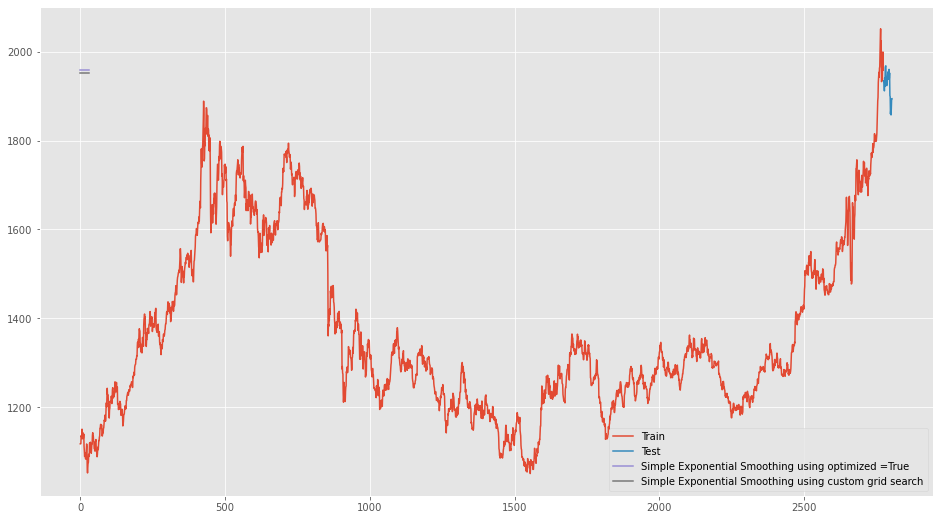

In [56]:
df_fcst_gs_pred = DataFrame(fcst_gs_pred, columns=['Gold_grid_Search'])
df_fcst_gs_pred["new_index"] = range(2773, 2803)
df_fcst_gs_pred = df_fcst_gs_pred.set_index("new_index")
df_fcst_auto_pred = DataFrame(fcst_auto_pred,columns=['Gold_auto_search'])
df_fcst_auto_pred["new_index"] = range(2773, 2803)
df_fcst_auto_pred = df_fcst_auto_pred.set_index("new_index")

get_ipython().run_line_magic('matplotlib', 'inline')
plt.rcParams["figure.figsize"] = [16,9]

plt.plot( train, label='Train')
plt.plot(test, label='Test')
plt.plot(fcst_auto_pred, label='Simple Exponential Smoothing using optimized =True')
plt.plot(fcst_gs_pred, label='Simple Exponential Smoothing using custom grid search')
plt.legend(loc='best')
plt.show()

We can clearly see that the simple exponential smoothing is not
performing well as the stock market data, which will have trends and
seasonality. Our basic model will not be able to capture these details.

## Holt's Exponential Smoothing
In Holt-Winter exponential smoothing, we have three smoothing
constants.
- Level: Lt = α (yt/St-M) + (1- α) (Lt-1 +Tt-1); S is a seasonal component. When we yt/St-M, we are the deseasonalizing value of y.
- In the level equation, we are updating the previous level by Lt-1, adding Tt-1, and then combining and then combining the deseasonalizing value of yt.
- Trend: Tt = β (Lt- Lt-1) + (1- β) Tt-1 ( Additive trend) We can update the previous trend by considering the latest difference between levels.
- Seasonality: St = γ (Yt/Lt) + (1+ γ) St-M (multiplicative seasonality); Yt is divided by level component Lt. This gives the detrended value of Y. So, the seasonality is updated by combining the most recent seasonal component St-M with the detrended value of Yt.

The main idea here is to use SES and advance it to capture the trend component.

In [46]:
from sklearn.model_selection import ParameterGrid
param_grid = {'smoothing_level': [0.10, 0.20,.30,.40,.50,.60,.70,.80,.90], 
              'smoothing_slope':[0.10, 0.20,.30,.40,.50,.60,.70,.80,.90],
              'damping_slope': [0.10, 0.20,.30,.40,.50,.60,.70,.80,.90],
              'damped' : [True, False]}
pg = list(ParameterGrid(param_grid))

In [54]:
from timeit import default_timer as timer
from statsmodels.tsa.api import ExponentialSmoothing,SimpleExpSmoothing, Holt

df_results_moni = pd.DataFrame(columns=['smoothing_level',
                                        'smoothing_slope', 'damping_slope','damped','RMSE','r2'])
start = timer()

for a,b in enumerate(pg):
    smoothing_level = b.get('smoothing_level')
    smoothing_slope = b.get('smoothing_slope')
    damping_slope = b.get('damping_slope')
    damped = b.get('damped')
    print(smoothing_level, smoothing_slope, damping_slope,damped)
    fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, 
                                           smoothing_slope=smoothing_slope,
                                           damping_slope = damping_slope, 
                                           optimized=False)
    #fit1.summary
    z = fit1.forecast(30)
    print(z)
    df_pred = pd.DataFrame(z, columns=['Forecasted_result'])
    RMSE = np.sqrt(metrics.mean_squared_error(test, df_pred.Forecasted_result))
    r2 = metrics.r2_score(test, df_pred.Forecasted_result)
    print( f' RMSE is {np.sqrt(metrics.mean_squared_error(test, df_pred.Forecasted_result))}')
    df_results_moni = df_results_moni.append({'smoothing_level':smoothing_level, 
                                              'smoothing_slope':smoothing_slope,
                                              'damping_slope' :damping_slope,
                                              'damped':damped,'RMSE':RMSE,'r2':r2}, 
                                             ignore_index=True)
end = timer()
print(f' Total time taken to complete grid search in seconds:{(end - start)}')
print(f' Below mentioned parameter gives least RMSE and r2')
df_results_moni.sort_values(by=['RMSE','r2']).head(1)

0.1 0.1 0.1 True
2774    1951.715014
2775    1951.716374
2776    1951.716510
2777    1951.716524
2778    1951.716525
2779    1951.716526
2780    1951.716526
2781    1951.716526
2782    1951.716526
2783    1951.716526
2784    1951.716526
2785    1951.716526
2786    1951.716526
2787    1951.716526
2788    1951.716526
2789    1951.716526
2790    1951.716526
2791    1951.716526
2792    1951.716526
2793    1951.716526
2794    1951.716526
2795    1951.716526
2796    1951.716526
2797    1951.716526
2798    1951.716526
2799    1951.716526
2800    1951.716526
2801    1951.716526
2802    1951.716526
2803    1951.716526
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 40.900348922082884
0.1 0.2 0.1 True
2774    1952.274496
2775    1952.277082
2776    1952.277341
2777    1952.277366
2778    1952.277369
2779    1952.277369
2780    1952.277369
2781    1952.277369
2782    1952.277369
2783    1952.277369
2784    1952.277369
2785    1952.277369
2786    1952.277369
2787    1952.277369
2788    1952.277369
2789    1952.277369
2790    1952.277369
2791    1952.277369
2792    1952.277369
2793    1952.277369
2794    1952.277369
2795    1952.277369
2796    1952.277369
2797    1952.277369
2798    1952.277369
2799    1952.277369
2800    1952.277369
2801    1952.277369
2802    1952.277369
2803    1952.277369
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 41.26482752363597
0.1 0.3 0.1 True
2774    1952.819381
2775    1952.823062
2776    1952.823430
2777    1952.823467
2778    1952.823471
2779    1952.823471
2780    1952.823471
2781    1952.823471
2782    1952.823471
2783    1952.823471
2784    1952.823471
2785    1952.823471
2786    1952.823471
2787    1952.823471
2788    1952.823471
2789    1952.823471
2790    1952.823471
2791    1952.823471
2792    1952.823471
2793    1952.823471
2794    1952.823471
2795    1952.823471
2796    1952.823471
2797    1952.823471
2798    1952.823471
2799    1952.823471
2800    1952.823471
2801    1952.823471
2802    1952.823471
2803    1952.823471
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 41.623921073875465
0.1 0.4 0.1 True
2774    1953.350046
2775    1953.354696
2776    1953.355161
2777    1953.355207
2778    1953.355212
2779    1953.355212
2780    1953.355213
2781    1953.355213
2782    1953.355213
2783    1953.355213
2784    1953.355213
2785    1953.355213
2786    1953.355213
2787    1953.355213
2788    1953.355213
2789    1953.355213
2790    1953.355213
2791    1953.355213
2792    1953.355213
2793    1953.355213
2794    1953.355213
2795    1953.355213
2796    1953.355213
2797    1953.355213
2798    1953.355213
2799    1953.355213
2800    1953.355213
2801    1953.355213
2802    1953.355213
2803    1953.355213
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 41.97744783025386
0.1 0.5 0.1 True
2774    1953.866855
2775    1953.872354
2776    1953.872904
2777    1953.872959
2778    1953.872964
2779    1953.872965
2780    1953.872965
2781    1953.872965
2782    1953.872965
2783    1953.872965
2784    1953.872965
2785    1953.872965
2786    1953.872965
2787    1953.872965
2788    1953.872965
2789    1953.872965
2790    1953.872965
2791    1953.872965
2792    1953.872965
2793    1953.872965
2794    1953.872965
2795    1953.872965
2796    1953.872965
2797    1953.872965
2798    1953.872965
2799    1953.872965
2800    1953.872965
2801    1953.872965
2802    1953.872965
2803    1953.872965
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 42.325256573062305
0.1 0.6 0.1 True
2774    1954.370165
2775    1954.376395
2776    1954.377019
2777    1954.377081
2778    1954.377087
2779    1954.377088
2780    1954.377088
2781    1954.377088
2782    1954.377088
2783    1954.377088
2784    1954.377088
2785    1954.377088
2786    1954.377088
2787    1954.377088
2788    1954.377088
2789    1954.377088
2790    1954.377088
2791    1954.377088
2792    1954.377088
2793    1954.377088
2794    1954.377088
2795    1954.377088
2796    1954.377088
2797    1954.377088
2798    1954.377088
2799    1954.377088
2800    1954.377088
2801    1954.377088
2802    1954.377088
2803    1954.377088
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 42.66722349574068
0.1 0.7 0.1 True
2774    1954.860320
2775    1954.867170
2776    1954.867856
2777    1954.867924
2778    1954.867931
2779    1954.867932
2780    1954.867932
2781    1954.867932
2782    1954.867932
2783    1954.867932
2784    1954.867932
2785    1954.867932
2786    1954.867932
2787    1954.867932
2788    1954.867932
2789    1954.867932
2790    1954.867932
2791    1954.867932
2792    1954.867932
2793    1954.867932
2794    1954.867932
2795    1954.867932
2796    1954.867932
2797    1954.867932
2798    1954.867932
2799    1954.867932
2800    1954.867932
2801    1954.867932
2802    1954.867932
2803    1954.867932
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 43.003249396188146
0.1 0.8 0.1 True
2774    1955.337657
2775    1955.345018
2776    1955.345755
2777    1955.345828
2778    1955.345836
2779    1955.345836
2780    1955.345836
2781    1955.345836
2782    1955.345836
2783    1955.345836
2784    1955.345836
2785    1955.345836
2786    1955.345836
2787    1955.345836
2788    1955.345836
2789    1955.345836
2790    1955.345836
2791    1955.345836
2792    1955.345836
2793    1955.345836
2794    1955.345836
2795    1955.345836
2796    1955.345836
2797    1955.345836
2798    1955.345836
2799    1955.345836
2800    1955.345836
2801    1955.345836
2802    1955.345836
2803    1955.345836
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 43.333257140617434
0.1 0.9 0.1 True
2774    1955.802500
2775    1955.810269
2776    1955.811046
2777    1955.811124
2778    1955.811132
2779    1955.811132
2780    1955.811133
2781    1955.811133
2782    1955.811133
2783    1955.811133
2784    1955.811133
2785    1955.811133
2786    1955.811133
2787    1955.811133
2788    1955.811133
2789    1955.811133
2790    1955.811133
2791    1955.811133
2792    1955.811133
2793    1955.811133
2794    1955.811133
2795    1955.811133
2796    1955.811133
2797    1955.811133
2798    1955.811133
2799    1955.811133
2800    1955.811133
2801    1955.811133
2802    1955.811133
2803    1955.811133
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 43.657189373908984
0.2 0.1 0.1 True
2774    1970.373511
2775    1970.371280
2776    1970.371057
2777    1970.371035
2778    1970.371033
2779    1970.371032
2780    1970.371032
2781    1970.371032
2782    1970.371032
2783    1970.371032
2784    1970.371032
2785    1970.371032
2786    1970.371032
2787    1970.371032
2788    1970.371032
2789    1970.371032
2790    1970.371032
2791    1970.371032
2792    1970.371032
2793    1970.371032
2794    1970.371032
2795    1970.371032
2796    1970.371032
2797    1970.371032
2798    1970.371032
2799    1970.371032
2800    1970.371032
2801    1970.371032
2802    1970.371032
2803    1970.371032
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 54.831896662335026
0.2 0.2 0.1 True
2774    1970.447912
2775    1970.443398
2776    1970.442947
2777    1970.442901
2778    1970.442897
2779    1970.442896
2780    1970.442896
2781    1970.442896
2782    1970.442896
2783    1970.442896
2784    1970.442896
2785    1970.442896
2786    1970.442896
2787    1970.442896
2788    1970.442896
2789    1970.442896
2790    1970.442896
2791    1970.442896
2792    1970.442896
2793    1970.442896
2794    1970.442896
2795    1970.442896
2796    1970.442896
2797    1970.442896
2798    1970.442896
2799    1970.442896
2800    1970.442896
2801    1970.442896
2802    1970.442896
2803    1970.442896
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 54.89105030248746
0.2 0.3 0.1 True
2774    1970.516819
2775    1970.509976
2776    1970.509291
2777    1970.509223
2778    1970.509216
2779    1970.509216
2780    1970.509215
2781    1970.509215
2782    1970.509215
2783    1970.509215
2784    1970.509215
2785    1970.509215
2786    1970.509215
2787    1970.509215
2788    1970.509215
2789    1970.509215
2790    1970.509215
2791    1970.509215
2792    1970.509215
2793    1970.509215
2794    1970.509215
2795    1970.509215
2796    1970.509215
2797    1970.509215
2798    1970.509215
2799    1970.509215
2800    1970.509215
2801    1970.509215
2802    1970.509215
2803    1970.509215
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 54.94567290917583
0.2 0.4 0.1 True
2774    1970.580539
2775    1970.571323
2776    1970.570402
2777    1970.570309
2778    1970.570300
2779    1970.570299
2780    1970.570299
2781    1970.570299
2782    1970.570299
2783    1970.570299
2784    1970.570299
2785    1970.570299
2786    1970.570299
2787    1970.570299
2788    1970.570299
2789    1970.570299
2790    1970.570299
2791    1970.570299
2792    1970.570299
2793    1970.570299
2794    1970.570299
2795    1970.570299
2796    1970.570299
2797    1970.570299
2798    1970.570299
2799    1970.570299
2800    1970.570299
2801    1970.570299
2802    1970.570299
2803    1970.570299
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 54.99601286636074
0.2 0.5 0.1 True
2774    1970.639364
2775    1970.627736
2776    1970.626573
2777    1970.626457
2778    1970.626445
2779    1970.626444
2780    1970.626444
2781    1970.626444
2782    1970.626444
2783    1970.626444
2784    1970.626444
2785    1970.626444
2786    1970.626444
2787    1970.626444
2788    1970.626444
2789    1970.626444
2790    1970.626444
2791    1970.626444
2792    1970.626444
2793    1970.626444
2794    1970.626444
2795    1970.626444
2796    1970.626444
2797    1970.626444
2798    1970.626444
2799    1970.626444
2800    1970.626444
2801    1970.626444
2802    1970.626444
2803    1970.626444
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.04230787733649
0.2 0.6 0.1 True
2774    1970.693571
2775    1970.679495
2776    1970.678087
2777    1970.677946
2778    1970.677932
2779    1970.677931
2780    1970.677931
2781    1970.677931
2782    1970.677931
2783    1970.677931
2784    1970.677931
2785    1970.677931
2786    1970.677931
2787    1970.677931
2788    1970.677931
2789    1970.677931
2790    1970.677931
2791    1970.677931
2792    1970.677931
2793    1970.677931
2794    1970.677931
2795    1970.677931
2796    1970.677931
2797    1970.677931
2798    1970.677931
2799    1970.677931
2800    1970.677931
2801    1970.677931
2802    1970.677931
2803    1970.677931
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.08478535013034
0.2 0.7 0.1 True
2774    1970.743427
2775    1970.726869
2776    1970.725213
2777    1970.725048
2778    1970.725031
2779    1970.725030
2780    1970.725029
2781    1970.725029
2782    1970.725029
2783    1970.725029
2784    1970.725029
2785    1970.725029
2786    1970.725029
2787    1970.725029
2788    1970.725029
2789    1970.725029
2790    1970.725029
2791    1970.725029
2792    1970.725029
2793    1970.725029
2794    1970.725029
2795    1970.725029
2796    1970.725029
2797    1970.725029
2798    1970.725029
2799    1970.725029
2800    1970.725029
2801    1970.725029
2802    1970.725029
2803    1970.725029
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.123662773117275
0.2 0.8 0.1 True
2774    1970.789185
2775    1970.770115
2776    1970.768209
2777    1970.768018
2778    1970.767999
2779    1970.767997
2780    1970.767997
2781    1970.767997
2782    1970.767997
2783    1970.767997
2784    1970.767997
2785    1970.767997
2786    1970.767997
2787    1970.767997
2788    1970.767997
2789    1970.767997
2790    1970.767997
2791    1970.767997
2792    1970.767997
2793    1970.767997
2794    1970.767997
2795    1970.767997
2796    1970.767997
2797    1970.767997
2798    1970.767997
2799    1970.767997
2800    1970.767997
2801    1970.767997
2802    1970.767997
2803    1970.767997
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.15914808058512
0.2 0.9 0.1 True
2774    1970.831086
2775    1970.809478
2776    1970.807317
2777    1970.807101
2778    1970.807080
2779    1970.807078
2780    1970.807077
2781    1970.807077
2782    1970.807077
2783    1970.807077
2784    1970.807077
2785    1970.807077
2786    1970.807077
2787    1970.807077
2788    1970.807077
2789    1970.807077
2790    1970.807077
2791    1970.807077
2792    1970.807077
2793    1970.807077
2794    1970.807077
2795    1970.807077
2796    1970.807077
2797    1970.807077
2798    1970.807077
2799    1970.807077
2800    1970.807077
2801    1970.807077
2802    1970.807077
2803    1970.807077
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.19144000805765
0.3 0.1 0.1 True
2774    1970.923979
2775    1970.919792
2776    1970.919373
2777    1970.919331
2778    1970.919327
2779    1970.919327
2780    1970.919326
2781    1970.919326
2782    1970.919326
2783    1970.919326
2784    1970.919326
2785    1970.919326
2786    1970.919326
2787    1970.919326
2788    1970.919326
2789    1970.919326
2790    1970.919326
2791    1970.919326
2792    1970.919326
2793    1970.919326
2794    1970.919326
2795    1970.919326
2796    1970.919326
2797    1970.919326
2798    1970.919326
2799    1970.919326
2800    1970.919326
2801    1970.919326
2802    1970.919326
2803    1970.919326
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.28355642128063
0.3 0.2 0.1 True
2774    1970.918507
2775    1970.910107
2776    1970.909267
2777    1970.909183
2778    1970.909175
2779    1970.909174
2780    1970.909174
2781    1970.909174
2782    1970.909174
2783    1970.909174
2784    1970.909174
2785    1970.909174
2786    1970.909174
2787    1970.909174
2788    1970.909174
2789    1970.909174
2790    1970.909174
2791    1970.909174
2792    1970.909174
2793    1970.909174
2794    1970.909174
2795    1970.909174
2796    1970.909174
2797    1970.909174
2798    1970.909174
2799    1970.909174
2800    1970.909174
2801    1970.909174
2802    1970.909174
2803    1970.909174
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.27529475506309
0.3 0.3 0.1 True
2774    1970.913313
2775    1970.900675
2776    1970.899411
2777    1970.899284
2778    1970.899272
2779    1970.899270
2780    1970.899270
2781    1970.899270
2782    1970.899270
2783    1970.899270
2784    1970.899270
2785    1970.899270
2786    1970.899270
2787    1970.899270
2788    1970.899270
2789    1970.899270
2790    1970.899270
2791    1970.899270
2792    1970.899270
2793    1970.899270
2794    1970.899270
2795    1970.899270
2796    1970.899270
2797    1970.899270
2798    1970.899270
2799    1970.899270
2800    1970.899270
2801    1970.899270
2802    1970.899270
2803    1970.899270
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.26723964505791
0.3 0.4 0.1 True
2774    1970.908480
2775    1970.891576
2776    1970.889885
2777    1970.889716
2778    1970.889700
2779    1970.889698
2780    1970.889698
2781    1970.889698
2782    1970.889698
2783    1970.889698
2784    1970.889698
2785    1970.889698
2786    1970.889698
2787    1970.889698
2788    1970.889698
2789    1970.889698
2790    1970.889698
2791    1970.889698
2792    1970.889698
2793    1970.889698
2794    1970.889698
2795    1970.889698
2796    1970.889698
2797    1970.889698
2798    1970.889698
2799    1970.889698
2800    1970.889698
2801    1970.889698
2802    1970.889698
2803    1970.889698
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.25945912570762
0.3 0.5 0.1 True
2774    1970.904082
2775    1970.882885
2776    1970.880765
2777    1970.880553
2778    1970.880532
2779    1970.880530
2780    1970.880529
2781    1970.880529
2782    1970.880529
2783    1970.880529
2784    1970.880529
2785    1970.880529
2786    1970.880529
2787    1970.880529
2788    1970.880529
2789    1970.880529
2790    1970.880529
2791    1970.880529
2792    1970.880529
2793    1970.880529
2794    1970.880529
2795    1970.880529
2796    1970.880529
2797    1970.880529
2798    1970.880529
2799    1970.880529
2800    1970.880529
2801    1970.880529
2802    1970.880529
2803    1970.880529
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.25201338272099
0.3 0.6 0.1 True
2774    1970.900185
2775    1970.874665
2776    1970.872113
2777    1970.871858
2778    1970.871832
2779    1970.871830
2780    1970.871829
2781    1970.871829
2782    1970.871829
2783    1970.871829
2784    1970.871829
2785    1970.871829
2786    1970.871829
2787    1970.871829
2788    1970.871829
2789    1970.871829
2790    1970.871829
2791    1970.871829
2792    1970.871829
2793    1970.871829
2794    1970.871829
2795    1970.871829
2796    1970.871829
2797    1970.871829
2798    1970.871829
2799    1970.871829
2800    1970.871829
2801    1970.871829
2802    1970.871829
2803    1970.871829
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.24495527565387
0.3 0.7 0.1 True
2774    1970.896846
2775    1970.866973
2776    1970.863985
2777    1970.863687
2778    1970.863657
2779    1970.863654
2780    1970.863654
2781    1970.863654
2782    1970.863654
2783    1970.863654
2784    1970.863654
2785    1970.863654
2786    1970.863654
2787    1970.863654
2788    1970.863654
2789    1970.863654
2790    1970.863654
2791    1970.863654
2792    1970.863654
2793    1970.863654
2794    1970.863654
2795    1970.863654
2796    1970.863654
2797    1970.863654
2798    1970.863654
2799    1970.863654
2800    1970.863654
2801    1970.863654
2802    1970.863654
2803    1970.863654
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.238330829813535
0.3 0.8 0.1 True
2774    1970.894114
2775    1970.859856
2776    1970.856431
2777    1970.856088
2778    1970.856054
2779    1970.856050
2780    1970.856050
2781    1970.856050
2782    1970.856050
2783    1970.856050
2784    1970.856050
2785    1970.856050
2786    1970.856050
2787    1970.856050
2788    1970.856050
2789    1970.856050
2790    1970.856050
2791    1970.856050
2792    1970.856050
2793    1970.856050
2794    1970.856050
2795    1970.856050
2796    1970.856050
2797    1970.856050
2798    1970.856050
2799    1970.856050
2800    1970.856050
2801    1970.856050
2802    1970.856050
2803    1970.856050
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.2321796992235
0.3 0.9 0.1 True
2774    1970.892033
2775    1970.853357
2776    1970.849489
2777    1970.849103
2778    1970.849064
2779    1970.849060
2780    1970.849060
2781    1970.849060
2782    1970.849060
2783    1970.849060
2784    1970.849060
2785    1970.849060
2786    1970.849060
2787    1970.849060
2788    1970.849060
2789    1970.849060
2790    1970.849060
2791    1970.849060
2792    1970.849060
2793    1970.849060
2794    1970.849060
2795    1970.849060
2796    1970.849060
2797    1970.849060
2798    1970.849060
2799    1970.849060
2800    1970.849060
2801    1970.849060
2802    1970.849060
2803    1970.849060
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.22653560229047
0.4 0.1 0.1 True
2774    1970.743941
2775    1970.737370
2776    1970.736713
2777    1970.736648
2778    1970.736641
2779    1970.736640
2780    1970.736640
2781    1970.736640
2782    1970.736640
2783    1970.736640
2784    1970.736640
2785    1970.736640
2786    1970.736640
2787    1970.736640
2788    1970.736640
2789    1970.736640
2790    1970.736640
2791    1970.736640
2792    1970.736640
2793    1970.736640
2794    1970.736640
2795    1970.736640
2796    1970.736640
2797    1970.736640
2798    1970.736640
2799    1970.736640
2800    1970.736640
2801    1970.736640
2802    1970.736640
2803    1970.736640
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.1329566278999
0.4 0.2 0.1 True
2774    1970.757182
2775    1970.743938
2776    1970.742613
2777    1970.742481
2778    1970.742468
2779    1970.742466
2780    1970.742466
2781    1970.742466
2782    1970.742466
2783    1970.742466
2784    1970.742466
2785    1970.742466
2786    1970.742466
2787    1970.742466
2788    1970.742466
2789    1970.742466
2790    1970.742466
2791    1970.742466
2792    1970.742466
2793    1970.742466
2794    1970.742466
2795    1970.742466
2796    1970.742466
2797    1970.742466
2798    1970.742466
2799    1970.742466
2800    1970.742466
2801    1970.742466
2802    1970.742466
2803    1970.742466
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.137942569089034
0.4 0.3 0.1 True
2774    1970.771156
2775    1970.751133
2776    1970.749131
2777    1970.748931
2778    1970.748911
2779    1970.748909
2780    1970.748909
2781    1970.748909
2782    1970.748909
2783    1970.748909
2784    1970.748909
2785    1970.748909
2786    1970.748909
2787    1970.748909
2788    1970.748909
2789    1970.748909
2790    1970.748909
2791    1970.748909
2792    1970.748909
2793    1970.748909
2794    1970.748909
2795    1970.748909
2796    1970.748909
2797    1970.748909
2798    1970.748909
2799    1970.748909
2800    1970.748909
2801    1970.748909
2802    1970.748909
2803    1970.748909
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.143439570376586
0.4 0.4 0.1 True
2774    1970.785795
2775    1970.758882
2776    1970.756191
2777    1970.755922
2778    1970.755895
2779    1970.755892
2780    1970.755892
2781    1970.755892
2782    1970.755892
2783    1970.755892
2784    1970.755892
2785    1970.755892
2786    1970.755892
2787    1970.755892
2788    1970.755892
2789    1970.755892
2790    1970.755892
2791    1970.755892
2792    1970.755892
2793    1970.755892
2794    1970.755892
2795    1970.755892
2796    1970.755892
2797    1970.755892
2798    1970.755892
2799    1970.755892
2800    1970.755892
2801    1970.755892
2802    1970.755892
2803    1970.755892
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.149385881136695
0.4 0.5 0.1 True
2774    1970.801024
2775    1970.767107
2776    1970.763716
2777    1970.763377
2778    1970.763343
2779    1970.763339
2780    1970.763339
2781    1970.763339
2782    1970.763339
2783    1970.763339
2784    1970.763339
2785    1970.763339
2786    1970.763339
2787    1970.763339
2788    1970.763339
2789    1970.763339
2790    1970.763339
2791    1970.763339
2792    1970.763339
2793    1970.763339
2794    1970.763339
2795    1970.763339
2796    1970.763339
2797    1970.763339
2798    1970.763339
2799    1970.763339
2800    1970.763339
2801    1970.763339
2802    1970.763339
2803    1970.763339
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.155718266197475
0.4 0.6 0.1 True
2774    1970.816770
2775    1970.775732
2776    1970.771628
2777    1970.771218
2778    1970.771177
2779    1970.771173
2780    1970.771172
2781    1970.771172
2782    1970.771172
2783    1970.771172
2784    1970.771172
2785    1970.771172
2786    1970.771172
2787    1970.771172
2788    1970.771172
2789    1970.771172
2790    1970.771172
2791    1970.771172
2792    1970.771172
2793    1970.771172
2794    1970.771172
2795    1970.771172
2796    1970.771172
2797    1970.771172
2798    1970.771172
2799    1970.771172
2800    1970.771172
2801    1970.771172
2802    1970.771172
2803    1970.771172
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.16237232577106
0.4 0.7 0.1 True
2774    1970.832957
2775    1970.784676
2776    1970.779848
2777    1970.779365
2778    1970.779317
2779    1970.779312
2780    1970.779312
2781    1970.779312
2782    1970.779312
2783    1970.779312
2784    1970.779312
2785    1970.779312
2786    1970.779312
2787    1970.779312
2788    1970.779312
2789    1970.779312
2790    1970.779312
2791    1970.779312
2792    1970.779312
2793    1970.779312
2794    1970.779312
2795    1970.779312
2796    1970.779312
2797    1970.779312
2798    1970.779312
2799    1970.779312
2800    1970.779312
2801    1970.779312
2802    1970.779312
2803    1970.779312
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.16928278853479
0.4 0.8 0.1 True
2774    1970.849511
2775    1970.793861
2776    1970.788296
2777    1970.787739
2778    1970.787683
2779    1970.787678
2780    1970.787677
2781    1970.787677
2782    1970.787677
2783    1970.787677
2784    1970.787677
2785    1970.787677
2786    1970.787677
2787    1970.787677
2788    1970.787677
2789    1970.787677
2790    1970.787677
2791    1970.787677
2792    1970.787677
2793    1970.787677
2794    1970.787677
2795    1970.787677
2796    1970.787677
2797    1970.787677
2798    1970.787677
2799    1970.787677
2800    1970.787677
2801    1970.787677
2802    1970.787677
2803    1970.787677
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.17638377988741
0.4 0.9 0.1 True
2774    1970.866354
2775    1970.803205
2776    1970.796891
2777    1970.796259
2778    1970.796196
2779    1970.796190
2780    1970.796189
2781    1970.796189
2782    1970.796189
2783    1970.796189
2784    1970.796189
2785    1970.796189
2786    1970.796189
2787    1970.796189
2788    1970.796189
2789    1970.796189
2790    1970.796189
2791    1970.796189
2792    1970.796189
2793    1970.796189
2794    1970.796189
2795    1970.796189
2796    1970.796189
2797    1970.796189
2798    1970.796189
2799    1970.796189
2800    1970.796189
2801    1970.796189
2802    1970.796189
2803    1970.796189
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.18360906725036
0.5 0.1 0.1 True
2774    1970.670235
2775    1970.660020
2776    1970.658998
2777    1970.658896
2778    1970.658886
2779    1970.658885
2780    1970.658885
2781    1970.658885
2782    1970.658885
2783    1970.658885
2784    1970.658885
2785    1970.658885
2786    1970.658885
2787    1970.658885
2788    1970.658885
2789    1970.658885
2790    1970.658885
2791    1970.658885
2792    1970.658885
2793    1970.658885
2794    1970.658885
2795    1970.658885
2796    1970.658885
2797    1970.658885
2798    1970.658885
2799    1970.658885
2800    1970.658885
2801    1970.658885
2802    1970.658885
2803    1970.658885
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.06898904472904
0.5 0.2 0.1 True
2774    1970.677846
2775    1970.657185
2776    1970.655119
2777    1970.654912
2778    1970.654892
2779    1970.654890
2780    1970.654890
2781    1970.654890
2782    1970.654890
2783    1970.654890
2784    1970.654890
2785    1970.654890
2786    1970.654890
2787    1970.654890
2788    1970.654890
2789    1970.654890
2790    1970.654890
2791    1970.654890
2792    1970.654890
2793    1970.654890
2794    1970.654890
2795    1970.654890
2796    1970.654890
2797    1970.654890
2798    1970.654890
2799    1970.654890
2800    1970.654890
2801    1970.654890
2802    1970.654890
2803    1970.654890
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.06598587773555
0.5 0.3 0.1 True
2774    1970.684109
2775    1970.652771
2776    1970.649637
2777    1970.649323
2778    1970.649292
2779    1970.649289
2780    1970.649288
2781    1970.649288
2782    1970.649288
2783    1970.649288
2784    1970.649288
2785    1970.649288
2786    1970.649288
2787    1970.649288
2788    1970.649288
2789    1970.649288
2790    1970.649288
2791    1970.649288
2792    1970.649288
2793    1970.649288
2794    1970.649288
2795    1970.649288
2796    1970.649288
2797    1970.649288
2798    1970.649288
2799    1970.649288
2800    1970.649288
2801    1970.649288
2802    1970.649288
2803    1970.649288
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.061666537922086
0.5 0.4 0.1 True
2774    1970.688918
2775    1970.646664
2776    1970.642439
2777    1970.642016
2778    1970.641974
2779    1970.641970
2780    1970.641969
2781    1970.641969
2782    1970.641969
2783    1970.641969
2784    1970.641969
2785    1970.641969
2786    1970.641969
2787    1970.641969
2788    1970.641969
2789    1970.641969
2790    1970.641969
2791    1970.641969
2792    1970.641969
2793    1970.641969
2794    1970.641969
2795    1970.641969
2796    1970.641969
2797    1970.641969
2798    1970.641969
2799    1970.641969
2800    1970.641969
2801    1970.641969
2802    1970.641969
2803    1970.641969
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.05593897571999
0.5 0.5 0.1 True
2774    1970.692168
2775    1970.638759
2776    1970.633418
2777    1970.632884
2778    1970.632831
2779    1970.632825
2780    1970.632825
2781    1970.632825
2782    1970.632825
2783    1970.632825
2784    1970.632825
2785    1970.632825
2786    1970.632825
2787    1970.632825
2788    1970.632825
2789    1970.632825
2790    1970.632825
2791    1970.632825
2792    1970.632825
2793    1970.632825
2794    1970.632825
2795    1970.632825
2796    1970.632825
2797    1970.632825
2798    1970.632825
2799    1970.632825
2800    1970.632825
2801    1970.632825
2802    1970.632825
2803    1970.632825
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.04871479570593
0.5 0.6 0.1 True
2774    1970.693759
2775    1970.628952
2776    1970.622471
2777    1970.621823
2778    1970.621759
2779    1970.621752
2780    1970.621751
2781    1970.621751
2782    1970.621751
2783    1970.621751
2784    1970.621751
2785    1970.621751
2786    1970.621751
2787    1970.621751
2788    1970.621751
2789    1970.621751
2790    1970.621751
2791    1970.621751
2792    1970.621751
2793    1970.621751
2794    1970.621751
2795    1970.621751
2796    1970.621751
2797    1970.621751
2798    1970.621751
2799    1970.621751
2800    1970.621751
2801    1970.621751
2802    1970.621751
2803    1970.621751
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.039909321280255
0.5 0.7 0.1 True
2774    1970.693595
2775    1970.617145
2776    1970.609500
2777    1970.608735
2778    1970.608659
2779    1970.608651
2780    1970.608650
2781    1970.608650
2782    1970.608650
2783    1970.608650
2784    1970.608650
2785    1970.608650
2786    1970.608650
2787    1970.608650
2788    1970.608650
2789    1970.608650
2790    1970.608650
2791    1970.608650
2792    1970.608650
2793    1970.608650
2794    1970.608650
2795    1970.608650
2796    1970.608650
2797    1970.608650
2798    1970.608650
2799    1970.608650
2800    1970.608650
2801    1970.608650
2802    1970.608650
2803    1970.608650
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.02944164197262
0.5 0.8 0.1 True
2774    1970.691585
2775    1970.603243
2776    1970.594409
2777    1970.593525
2778    1970.593437
2779    1970.593428
2780    1970.593427
2781    1970.593427
2782    1970.593427
2783    1970.593427
2784    1970.593427
2785    1970.593427
2786    1970.593427
2787    1970.593427
2788    1970.593427
2789    1970.593427
2790    1970.593427
2791    1970.593427
2792    1970.593427
2793    1970.593427
2794    1970.593427
2795    1970.593427
2796    1970.593427
2797    1970.593427
2798    1970.593427
2799    1970.593427
2800    1970.593427
2801    1970.593427
2802    1970.593427
2803    1970.593427
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.0172346449647
0.5 0.9 0.1 True
2774    1970.687640
2775    1970.587157
2776    1970.577109
2777    1970.576104
2778    1970.576004
2779    1970.575994
2780    1970.575993
2781    1970.575993
2782    1970.575993
2783    1970.575993
2784    1970.575993
2785    1970.575993
2786    1970.575993
2787    1970.575993
2788    1970.575993
2789    1970.575993
2790    1970.575993
2791    1970.575993
2792    1970.575993
2793    1970.575993
2794    1970.575993
2795    1970.575993
2796    1970.575993
2797    1970.575993
2798    1970.575993
2799    1970.575993
2800    1970.575993
2801    1970.575993
2802    1970.575993
2803    1970.575993
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.00321503227977
0.6 0.1 0.1 True
2774    1969.984647
2775    1969.969582
2776    1969.968075
2777    1969.967925
2778    1969.967910
2779    1969.967908
2780    1969.967908
2781    1969.967908
2782    1969.967908
2783    1969.967908
2784    1969.967908
2785    1969.967908
2786    1969.967908
2787    1969.967908
2788    1969.967908
2789    1969.967908
2790    1969.967908
2791    1969.967908
2792    1969.967908
2793    1969.967908
2794    1969.967908
2795    1969.967908
2796    1969.967908
2797    1969.967908
2798    1969.967908
2799    1969.967908
2800    1969.967908
2801    1969.967908
2802    1969.967908
2803    1969.967908
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 54.50134299295255
0.6 0.2 0.1 True
2774    1969.942187
2775    1969.911702
2776    1969.908654
2777    1969.908349
2778    1969.908319
2779    1969.908316
2780    1969.908315
2781    1969.908315
2782    1969.908315
2783    1969.908315
2784    1969.908315
2785    1969.908315
2786    1969.908315
2787    1969.908315
2788    1969.908315
2789    1969.908315
2790    1969.908315
2791    1969.908315
2792    1969.908315
2793    1969.908315
2794    1969.908315
2795    1969.908315
2796    1969.908315
2797    1969.908315
2798    1969.908315
2799    1969.908315
2800    1969.908315
2801    1969.908315
2802    1969.908315
2803    1969.908315
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 54.452929657005996
0.6 0.3 0.1 True
2774    1969.896025
2775    1969.849766
2776    1969.845140
2777    1969.844678
2778    1969.844631
2779    1969.844627
2780    1969.844626
2781    1969.844626
2782    1969.844626
2783    1969.844626
2784    1969.844626
2785    1969.844626
2786    1969.844626
2787    1969.844626
2788    1969.844626
2789    1969.844626
2790    1969.844626
2791    1969.844626
2792    1969.844626
2793    1969.844626
2794    1969.844626
2795    1969.844626
2796    1969.844626
2797    1969.844626
2798    1969.844626
2799    1969.844626
2800    1969.844626
2801    1969.844626
2802    1969.844626
2803    1969.844626
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 54.401192631340095
0.6 0.4 0.1 True
2774    1969.846102
2775    1969.783714
2776    1969.777475
2777    1969.776851
2778    1969.776788
2779    1969.776782
2780    1969.776781
2781    1969.776781
2782    1969.776781
2783    1969.776781
2784    1969.776781
2785    1969.776781
2786    1969.776781
2787    1969.776781
2788    1969.776781
2789    1969.776781
2790    1969.776781
2791    1969.776781
2792    1969.776781
2793    1969.776781
2794    1969.776781
2795    1969.776781
2796    1969.776781
2797    1969.776781
2798    1969.776781
2799    1969.776781
2800    1969.776781
2801    1969.776781
2802    1969.776781
2803    1969.776781
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 54.34608761602453
0.6 0.5 0.1 True
2774    1969.792364
2775    1969.713491
2776    1969.705604
2777    1969.704815
2778    1969.704737
2779    1969.704729
2780    1969.704728
2781    1969.704728
2782    1969.704728
2783    1969.704728
2784    1969.704728
2785    1969.704728
2786    1969.704728
2787    1969.704728
2788    1969.704728
2789    1969.704728
2790    1969.704728
2791    1969.704728
2792    1969.704728
2793    1969.704728
2794    1969.704728
2795    1969.704728
2796    1969.704728
2797    1969.704728
2798    1969.704728
2799    1969.704728
2800    1969.704728
2801    1969.704728
2802    1969.704728
2803    1969.704728
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 54.28757648536557
0.6 0.6 0.1 True
2774    1969.734763
2775    1969.639054
2776    1969.629483
2777    1969.628526
2778    1969.628430
2779    1969.628420
2780    1969.628419
2781    1969.628419
2782    1969.628419
2783    1969.628419
2784    1969.628419
2785    1969.628419
2786    1969.628419
2787    1969.628419
2788    1969.628419
2789    1969.628419
2790    1969.628419
2791    1969.628419
2792    1969.628419
2793    1969.628419
2794    1969.628419
2795    1969.628419
2796    1969.628419
2797    1969.628419
2798    1969.628419
2799    1969.628419
2800    1969.628419
2801    1969.628419
2802    1969.628419
2803    1969.628419
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 54.2256270935597
0.6 0.7 0.1 True
2774    1969.673259
2775    1969.560361
2776    1969.549071
2777    1969.547942
2778    1969.547829
2779    1969.547818
2780    1969.547816
2781    1969.547816
2782    1969.547816
2783    1969.547816
2784    1969.547816
2785    1969.547816
2786    1969.547816
2787    1969.547816
2788    1969.547816
2789    1969.547816
2790    1969.547816
2791    1969.547816
2792    1969.547816
2793    1969.547816
2794    1969.547816
2795    1969.547816
2796    1969.547816
2797    1969.547816
2798    1969.547816
2799    1969.547816
2800    1969.547816
2801    1969.547816
2802    1969.547816
2803    1969.547816
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 54.160213075225535
0.6 0.8 0.1 True
2774    1969.607816
2775    1969.477379
2776    1969.464335
2777    1969.463031
2778    1969.462900
2779    1969.462887
2780    1969.462886
2781    1969.462886
2782    1969.462886
2783    1969.462886
2784    1969.462886
2785    1969.462886
2786    1969.462886
2787    1969.462886
2788    1969.462886
2789    1969.462886
2790    1969.462886
2791    1969.462886
2792    1969.462886
2793    1969.462886
2794    1969.462886
2795    1969.462886
2796    1969.462886
2797    1969.462886
2798    1969.462886
2799    1969.462886
2800    1969.462886
2801    1969.462886
2802    1969.462886
2803    1969.462886
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 54.09131364207857
0.6 0.9 0.1 True
2774    1969.538405
2775    1969.390081
2776    1969.375248
2777    1969.373765
2778    1969.373617
2779    1969.373602
2780    1969.373600
2781    1969.373600
2782    1969.373600
2783    1969.373600
2784    1969.373600
2785    1969.373600
2786    1969.373600
2787    1969.373600
2788    1969.373600
2789    1969.373600
2790    1969.373600
2791    1969.373600
2792    1969.373600
2793    1969.373600
2794    1969.373600
2795    1969.373600
2796    1969.373600
2797    1969.373600
2798    1969.373600
2799    1969.373600
2800    1969.373600
2801    1969.373600
2802    1969.373600
2803    1969.373600
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 54.01891337690577
0.7 0.1 0.1 True
2774    1968.324496
2775    1968.303750
2776    1968.301676
2777    1968.301468
2778    1968.301447
2779    1968.301445
2780    1968.301445
2781    1968.301445
2782    1968.301445
2783    1968.301445
2784    1968.301445
2785    1968.301445
2786    1968.301445
2787    1968.301445
2788    1968.301445
2789    1968.301445
2790    1968.301445
2791    1968.301445
2792    1968.301445
2793    1968.301445
2794    1968.301445
2795    1968.301445
2796    1968.301445
2797    1968.301445
2798    1968.301445
2799    1968.301445
2800    1968.301445
2801    1968.301445
2802    1968.301445
2803    1968.301445
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 53.14415885337079
0.7 0.2 0.1 True
2774    1968.201060
2775    1968.159120
2776    1968.154926
2777    1968.154506
2778    1968.154464
2779    1968.154460
2780    1968.154460
2781    1968.154460
2782    1968.154460
2783    1968.154460
2784    1968.154460
2785    1968.154460
2786    1968.154460
2787    1968.154460
2788    1968.154460
2789    1968.154460
2790    1968.154460
2791    1968.154460
2792    1968.154460
2793    1968.154460
2794    1968.154460
2795    1968.154460
2796    1968.154460
2797    1968.154460
2798    1968.154460
2799    1968.154460
2800    1968.154460
2801    1968.154460
2802    1968.154460
2803    1968.154460
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 53.025850197222965
0.7 0.3 0.1 True
2774    1968.072357
2775    1968.008779
2776    1968.002421
2777    1968.001785
2778    1968.001722
2779    1968.001715
2780    1968.001715
2781    1968.001715
2782    1968.001715
2783    1968.001715
2784    1968.001715
2785    1968.001715
2786    1968.001715
2787    1968.001715
2788    1968.001715
2789    1968.001715
2790    1968.001715
2791    1968.001715
2792    1968.001715
2793    1968.001715
2794    1968.001715
2795    1968.001715
2796    1968.001715
2797    1968.001715
2798    1968.001715
2799    1968.001715
2800    1968.001715
2801    1968.001715
2802    1968.001715
2803    1968.001715
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 52.9030432863944
0.7 0.4 0.1 True
2774    1967.938409
2775    1967.852756
2776    1967.844191
2777    1967.843334
2778    1967.843249
2779    1967.843240
2780    1967.843239
2781    1967.843239
2782    1967.843239
2783    1967.843239
2784    1967.843239
2785    1967.843239
2786    1967.843239
2787    1967.843239
2788    1967.843239
2789    1967.843239
2790    1967.843239
2791    1967.843239
2792    1967.843239
2793    1967.843239
2794    1967.843239
2795    1967.843239
2796    1967.843239
2797    1967.843239
2798    1967.843239
2799    1967.843239
2800    1967.843239
2801    1967.843239
2802    1967.843239
2803    1967.843239
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 52.775779064690155
0.7 0.5 0.1 True
2774    1967.799244
2775    1967.691085
2776    1967.680269
2777    1967.679188
2778    1967.679079
2779    1967.679069
2780    1967.679068
2781    1967.679067
2782    1967.679067
2783    1967.679067
2784    1967.679067
2785    1967.679067
2786    1967.679067
2787    1967.679067
2788    1967.679067
2789    1967.679067
2790    1967.679067
2791    1967.679067
2792    1967.679067
2793    1967.679067
2794    1967.679067
2795    1967.679067
2796    1967.679067
2797    1967.679067
2798    1967.679067
2799    1967.679067
2800    1967.679067
2801    1967.679067
2802    1967.679067
2803    1967.679067
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 52.644104147638934
0.7 0.6 0.1 True
2774    1967.654896
2775    1967.523805
2776    1967.510696
2777    1967.509385
2778    1967.509254
2779    1967.509241
2780    1967.509240
2781    1967.509240
2782    1967.509240
2783    1967.509240
2784    1967.509240
2785    1967.509240
2786    1967.509240
2787    1967.509240
2788    1967.509240
2789    1967.509240
2790    1967.509240
2791    1967.509240
2792    1967.509240
2793    1967.509240
2794    1967.509240
2795    1967.509240
2796    1967.509240
2797    1967.509240
2798    1967.509240
2799    1967.509240
2800    1967.509240
2801    1967.509240
2802    1967.509240
2803    1967.509240
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 52.508070460954016
0.7 0.7 0.1 True
2774    1967.505403
2775    1967.350961
2776    1967.335517
2777    1967.333973
2778    1967.333818
2779    1967.333803
2780    1967.333801
2781    1967.333801
2782    1967.333801
2783    1967.333801
2784    1967.333801
2785    1967.333801
2786    1967.333801
2787    1967.333801
2788    1967.333801
2789    1967.333801
2790    1967.333801
2791    1967.333801
2792    1967.333801
2793    1967.333801
2794    1967.333801
2795    1967.333801
2796    1967.333801
2797    1967.333801
2798    1967.333801
2799    1967.333801
2800    1967.333801
2801    1967.333801
2802    1967.333801
2803    1967.333801
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 52.367734891197784
0.7 0.8 0.1 True
2774    1967.350807
2775    1967.172603
2776    1967.154782
2777    1967.153000
2778    1967.152822
2779    1967.152804
2780    1967.152802
2781    1967.152802
2782    1967.152802
2783    1967.152802
2784    1967.152802
2785    1967.152802
2786    1967.152802
2787    1967.152802
2788    1967.152802
2789    1967.152802
2790    1967.152802
2791    1967.152802
2792    1967.152802
2793    1967.152802
2794    1967.152802
2795    1967.152802
2796    1967.152802
2797    1967.152802
2798    1967.152802
2799    1967.152802
2800    1967.152802
2801    1967.152802
2802    1967.152802
2803    1967.152802
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 52.223158949247846
0.7 0.9 0.1 True
2774    1967.191156
2775    1966.988784
2776    1966.968546
2777    1966.966523
2778    1966.966320
2779    1966.966300
2780    1966.966298
2781    1966.966298
2782    1966.966298
2783    1966.966298
2784    1966.966298
2785    1966.966298
2786    1966.966298
2787    1966.966298
2788    1966.966298
2789    1966.966298
2790    1966.966298
2791    1966.966298
2792    1966.966298
2793    1966.966298
2794    1966.966298
2795    1966.966298
2796    1966.966298
2797    1966.966298
2798    1966.966298
2799    1966.966298
2800    1966.966298
2801    1966.966298
2802    1966.966298
2803    1966.966298
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 52.07440844704964
0.8 0.1 0.1 True
2774    1965.693828
2775    1965.666969
2776    1965.664283
2777    1965.664014
2778    1965.663987
2779    1965.663985
2780    1965.663984
2781    1965.663984
2782    1965.663984
2783    1965.663984
2784    1965.663984
2785    1965.663984
2786    1965.663984
2787    1965.663984
2788    1965.663984
2789    1965.663984
2790    1965.663984
2791    1965.663984
2792    1965.663984
2793    1965.663984
2794    1965.663984
2795    1965.663984
2796    1965.663984
2797    1965.663984
2798    1965.663984
2799    1965.663984
2800    1965.663984
2801    1965.663984
2802    1965.663984
2803    1965.663984
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 51.033542900517254
0.8 0.2 0.1 True
2774    1965.476200
2775    1965.421983
2776    1965.416561
2777    1965.416019
2778    1965.415964
2779    1965.415959
2780    1965.415958
2781    1965.415958
2782    1965.415958
2783    1965.415958
2784    1965.415958
2785    1965.415958
2786    1965.415958
2787    1965.415958
2788    1965.415958
2789    1965.415958
2790    1965.415958
2791    1965.415958
2792    1965.415958
2793    1965.415958
2794    1965.415958
2795    1965.415958
2796    1965.415958
2797    1965.415958
2798    1965.415958
2799    1965.415958
2800    1965.415958
2801    1965.415958
2802    1965.415958
2803    1965.415958
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 50.83827761961471
0.8 0.3 0.1 True
2774    1965.252732
2775    1965.170669
2776    1965.162463
2777    1965.161642
2778    1965.161560
2779    1965.161552
2780    1965.161551
2781    1965.161551
2782    1965.161551
2783    1965.161551
2784    1965.161551
2785    1965.161551
2786    1965.161551
2787    1965.161551
2788    1965.161551
2789    1965.161551
2790    1965.161551
2791    1965.161551
2792    1965.161551
2793    1965.161551
2794    1965.161551
2795    1965.161551
2796    1965.161551
2797    1965.161551
2798    1965.161551
2799    1965.161551
2800    1965.161551
2801    1965.161551
2802    1965.161551
2803    1965.161551
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 50.63845182093423
0.8 0.4 0.1 True
2774    1965.023527
2775    1964.913141
2776    1964.902103
2777    1964.900999
2778    1964.900888
2779    1964.900877
2780    1964.900876
2781    1964.900876
2782    1964.900876
2783    1964.900876
2784    1964.900876
2785    1964.900876
2786    1964.900876
2787    1964.900876
2788    1964.900876
2789    1964.900876
2790    1964.900876
2791    1964.900876
2792    1964.900876
2793    1964.900876
2794    1964.900876
2795    1964.900876
2796    1964.900876
2797    1964.900876
2798    1964.900876
2799    1964.900876
2800    1964.900876
2801    1964.900876
2802    1964.900876
2803    1964.900876
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 50.43419649786501
0.8 0.5 0.1 True
2774    1964.788687
2775    1964.649515
2776    1964.635598
2777    1964.634206
2778    1964.634067
2779    1964.634053
2780    1964.634051
2781    1964.634051
2782    1964.634051
2783    1964.634051
2784    1964.634051
2785    1964.634051
2786    1964.634051
2787    1964.634051
2788    1964.634051
2789    1964.634051
2790    1964.634051
2791    1964.634051
2792    1964.634051
2793    1964.634051
2794    1964.634051
2795    1964.634051
2796    1964.634051
2797    1964.634051
2798    1964.634051
2799    1964.634051
2800    1964.634051
2801    1964.634051
2802    1964.634051
2803    1964.634051
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 50.22564621963384
0.8 0.6 0.1 True
2774    1964.548322
2775    1964.379910
2776    1964.363068
2777    1964.361384
2778    1964.361216
2779    1964.361199
2780    1964.361197
2781    1964.361197
2782    1964.361197
2783    1964.361197
2784    1964.361197
2785    1964.361197
2786    1964.361197
2787    1964.361197
2788    1964.361197
2789    1964.361197
2790    1964.361197
2791    1964.361197
2792    1964.361197
2793    1964.361197
2794    1964.361197
2795    1964.361197
2796    1964.361197
2797    1964.361197
2798    1964.361197
2799    1964.361197
2800    1964.361197
2801    1964.361197
2802    1964.361197
2803    1964.361197
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 50.012938791671374
0.8 0.7 0.1 True
2774    1964.302540
2775    1964.104447
2776    1964.084638
2777    1964.082657
2778    1964.082459
2779    1964.082439
2780    1964.082437
2781    1964.082437
2782    1964.082437
2783    1964.082437
2784    1964.082437
2785    1964.082437
2786    1964.082437
2787    1964.082437
2788    1964.082437
2789    1964.082437
2790    1964.082437
2791    1964.082437
2792    1964.082437
2793    1964.082437
2794    1964.082437
2795    1964.082437
2796    1964.082437
2797    1964.082437
2798    1964.082437
2799    1964.082437
2800    1964.082437
2801    1964.082437
2802    1964.082437
2803    1964.082437
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 49.79621494302109
0.8 0.8 0.1 True
2774    1964.051454
2775    1963.823251
2776    1963.800431
2777    1963.798149
2778    1963.797920
2779    1963.797898
2780    1963.797895
2781    1963.797895
2782    1963.797895
2783    1963.797895
2784    1963.797895
2785    1963.797895
2786    1963.797895
2787    1963.797895
2788    1963.797895
2789    1963.797895
2790    1963.797895
2791    1963.797895
2792    1963.797895
2793    1963.797895
2794    1963.797895
2795    1963.797895
2796    1963.797895
2797    1963.797895
2798    1963.797895
2799    1963.797895
2800    1963.797895
2801    1963.797895
2802    1963.797895
2803    1963.797895
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 49.575618039956105
0.8 0.9 0.1 True
2774    1963.795178
2775    1963.536448
2776    1963.510575
2777    1963.507988
2778    1963.507729
2779    1963.507703
2780    1963.507700
2781    1963.507700
2782    1963.507700
2783    1963.507700
2784    1963.507700
2785    1963.507700
2786    1963.507700
2787    1963.507700
2788    1963.507700
2789    1963.507700
2790    1963.507700
2791    1963.507700
2792    1963.507700
2793    1963.507700
2794    1963.507700
2795    1963.507700
2796    1963.507700
2797    1963.507700
2798    1963.507700
2799    1963.507700
2800    1963.507700
2801    1963.507700
2802    1963.507700
2803    1963.507700
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 49.35129382487572
0.9 0.1 0.1 True
2774    1962.273823
2775    1962.240762
2776    1962.237456
2777    1962.237126
2778    1962.237093
2779    1962.237089
2780    1962.237089
2781    1962.237089
2782    1962.237089
2783    1962.237089
2784    1962.237089
2785    1962.237089
2786    1962.237089
2787    1962.237089
2788    1962.237089
2789    1962.237089
2790    1962.237089
2791    1962.237089
2792    1962.237089
2793    1962.237089
2794    1962.237089
2795    1962.237089
2796    1962.237089
2797    1962.237089
2798    1962.237089
2799    1962.237089
2800    1962.237089
2801    1962.237089
2802    1962.237089
2803    1962.237089
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 48.36841853722082
0.9 0.2 0.1 True
2774    1961.962248
2775    1961.895627
2776    1961.888965
2777    1961.888299
2778    1961.888232
2779    1961.888225
2780    1961.888225
2781    1961.888224
2782    1961.888224
2783    1961.888224
2784    1961.888224
2785    1961.888224
2786    1961.888224
2787    1961.888224
2788    1961.888224
2789    1961.888224
2790    1961.888224
2791    1961.888224
2792    1961.888224
2793    1961.888224
2794    1961.888224
2795    1961.888224
2796    1961.888224
2797    1961.888224
2798    1961.888224
2799    1961.888224
2800    1961.888224
2801    1961.888224
2802    1961.888224
2803    1961.888224
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 48.10330533739948
0.9 0.3 0.1 True
2774    1961.645166
2775    1961.544500
2776    1961.534433
2777    1961.533426
2778    1961.533326
2779    1961.533316
2780    1961.533315
2781    1961.533315
2782    1961.533315
2783    1961.533315
2784    1961.533315
2785    1961.533315
2786    1961.533315
2787    1961.533315
2788    1961.533315
2789    1961.533315
2790    1961.533315
2791    1961.533315
2792    1961.533315
2793    1961.533315
2794    1961.533315
2795    1961.533315
2796    1961.533315
2797    1961.533315
2798    1961.533315
2799    1961.533315
2800    1961.533315
2801    1961.533315
2802    1961.533315
2803    1961.533315
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 47.83467927515941
0.9 0.4 0.1 True
2774    1961.322750
2775    1961.187573
2776    1961.174055
2777    1961.172703
2778    1961.172568
2779    1961.172555
2780    1961.172553
2781    1961.172553
2782    1961.172553
2783    1961.172553
2784    1961.172553
2785    1961.172553
2786    1961.172553
2787    1961.172553
2788    1961.172553
2789    1961.172553
2790    1961.172553
2791    1961.172553
2792    1961.172553
2793    1961.172553
2794    1961.172553
2795    1961.172553
2796    1961.172553
2797    1961.172553
2798    1961.172553
2799    1961.172553
2800    1961.172553
2801    1961.172553
2802    1961.172553
2803    1961.172553
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 47.56276076174169
0.9 0.5 0.1 True
2774    1960.995175
2775    1960.825039
2776    1960.808025
2777    1960.806324
2778    1960.806154
2779    1960.806137
2780    1960.806135
2781    1960.806135
2782    1960.806135
2783    1960.806135
2784    1960.806135
2785    1960.806135
2786    1960.806135
2787    1960.806135
2788    1960.806135
2789    1960.806135
2790    1960.806135
2791    1960.806135
2792    1960.806135
2793    1960.806135
2794    1960.806135
2795    1960.806135
2796    1960.806135
2797    1960.806135
2798    1960.806135
2799    1960.806135
2800    1960.806135
2801    1960.806135
2802    1960.806135
2803    1960.806135
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 47.28777226232062
0.9 0.6 0.1 True
2774    1960.662618
2775    1960.457094
2776    1960.436541
2777    1960.434486
2778    1960.434280
2779    1960.434260
2780    1960.434258
2781    1960.434258
2782    1960.434258
2783    1960.434258
2784    1960.434258
2785    1960.434258
2786    1960.434258
2787    1960.434258
2788    1960.434258
2789    1960.434258
2790    1960.434258
2791    1960.434258
2792    1960.434258
2793    1960.434258
2794    1960.434258
2795    1960.434258
2796    1960.434258
2797    1960.434258
2798    1960.434258
2799    1960.434258
2800    1960.434258
2801    1960.434258
2802    1960.434258
2803    1960.434258
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 47.009938113796395
0.9 0.7 0.1 True
2774    1960.325257
2775    1960.083933
2776    1960.059801
2777    1960.057387
2778    1960.057146
2779    1960.057122
2780    1960.057120
2781    1960.057119
2782    1960.057119
2783    1960.057119
2784    1960.057119
2785    1960.057119
2786    1960.057119
2787    1960.057119
2788    1960.057119
2789    1960.057119
2790    1960.057119
2791    1960.057119
2792    1960.057119
2793    1960.057119
2794    1960.057119
2795    1960.057119
2796    1960.057119
2797    1960.057119
2798    1960.057119
2799    1960.057119
2800    1960.057119
2801    1960.057119
2802    1960.057119
2803    1960.057119
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 46.72948436678634
0.9 0.8 0.1 True
2774    1959.983272
2775    1959.705756
2776    1959.678004
2777    1959.675229
2778    1959.674951
2779    1959.674923
2780    1959.674921
2781    1959.674920
2782    1959.674920
2783    1959.674920
2784    1959.674920
2785    1959.674920
2786    1959.674920
2787    1959.674920
2788    1959.674920
2789    1959.674920
2790    1959.674920
2791    1959.674920
2792    1959.674920
2793    1959.674920
2794    1959.674920
2795    1959.674920
2796    1959.674920
2797    1959.674920
2798    1959.674920
2799    1959.674920
2800    1959.674920
2801    1959.674920
2802    1959.674920
2803    1959.674920
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 46.446638648716856
0.9 0.9 0.1 True
2774    1959.636845
2775    1959.322761
2776    1959.291352
2777    1959.288212
2778    1959.287898
2779    1959.287866
2780    1959.287863
2781    1959.287863
2782    1959.287863
2783    1959.287863
2784    1959.287863
2785    1959.287863
2786    1959.287863
2787    1959.287863
2788    1959.287863
2789    1959.287863
2790    1959.287863
2791    1959.287863
2792    1959.287863
2793    1959.287863
2794    1959.287863
2795    1959.287863
2796    1959.287863
2797    1959.287863
2798    1959.287863
2799    1959.287863
2800    1959.287863
2801    1959.287863
2802    1959.287863
2803    1959.287863
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 46.16163004488756
0.1 0.1 0.2 True
2774    1952.424781
2775    1952.432523
2776    1952.434071
2777    1952.434380
2778    1952.434442
2779    1952.434455
2780    1952.434457
2781    1952.434458
2782    1952.434458
2783    1952.434458
2784    1952.434458
2785    1952.434458
2786    1952.434458
2787    1952.434458
2788    1952.434458
2789    1952.434458
2790    1952.434458
2791    1952.434458
2792    1952.434458
2793    1952.434458
2794    1952.434458
2795    1952.434458
2796    1952.434458
2797    1952.434458
2798    1952.434458
2799    1952.434458
2800    1952.434458
2801    1952.434458
2802    1952.434458
2803    1952.434458
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 41.367573491574355
0.1 0.2 0.2 True
2774    1953.635319
2775    1953.649486
2776    1953.652319
2777    1953.652886
2778    1953.652999
2779    1953.653022
2780    1953.653026
2781    1953.653027
2782    1953.653027
2783    1953.653027
2784    1953.653027
2785    1953.653027
2786    1953.653027
2787    1953.653027
2788    1953.653027
2789    1953.653027
2790    1953.653027
2791    1953.653027
2792    1953.653027
2793    1953.653027
2794    1953.653027
2795    1953.653027
2796    1953.653027
2797    1953.653027
2798    1953.653027
2799    1953.653027
2800    1953.653027
2801    1953.653027
2802    1953.653027
2803    1953.653027
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 42.176832776687206
0.1 0.3 0.2 True
2774    1954.776293
2775    1954.795674
2776    1954.799550
2777    1954.800325
2778    1954.800480
2779    1954.800511
2780    1954.800517
2781    1954.800519
2782    1954.800519
2783    1954.800519
2784    1954.800519
2785    1954.800519
2786    1954.800519
2787    1954.800519
2788    1954.800519
2789    1954.800519
2790    1954.800519
2791    1954.800519
2792    1954.800519
2793    1954.800519
2794    1954.800519
2795    1954.800519
2796    1954.800519
2797    1954.800519
2798    1954.800519
2799    1954.800519
2800    1954.800519
2801    1954.800519
2802    1954.800519
2803    1954.800519
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 42.95656118613725
0.1 0.4 0.2 True
2774    1955.851577
2775    1955.875061
2776    1955.879757
2777    1955.880697
2778    1955.880885
2779    1955.880922
2780    1955.880930
2781    1955.880931
2782    1955.880931
2783    1955.880931
2784    1955.880932
2785    1955.880932
2786    1955.880932
2787    1955.880932
2788    1955.880932
2789    1955.880932
2790    1955.880932
2791    1955.880932
2792    1955.880932
2793    1955.880932
2794    1955.880932
2795    1955.880932
2796    1955.880932
2797    1955.880932
2798    1955.880932
2799    1955.880932
2800    1955.880932
2801    1955.880932
2802    1955.880932
2803    1955.880932
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 43.70554212658751
0.1 0.5 0.2 True
2774    1956.864809
2775    1956.891376
2776    1956.896689
2777    1956.897752
2778    1956.897964
2779    1956.898007
2780    1956.898015
2781    1956.898017
2782    1956.898017
2783    1956.898017
2784    1956.898017
2785    1956.898017
2786    1956.898017
2787    1956.898017
2788    1956.898017
2789    1956.898017
2790    1956.898017
2791    1956.898017
2792    1956.898017
2793    1956.898017
2794    1956.898017
2795    1956.898017
2796    1956.898017
2797    1956.898017
2798    1956.898017
2799    1956.898017
2800    1956.898017
2801    1956.898017
2802    1956.898017
2803    1956.898017
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 44.42310855200077
0.1 0.6 0.2 True
2774    1957.819409
2775    1957.848124
2776    1957.853867
2777    1957.855016
2778    1957.855245
2779    1957.855291
2780    1957.855300
2781    1957.855302
2782    1957.855303
2783    1957.855303
2784    1957.855303
2785    1957.855303
2786    1957.855303
2787    1957.855303
2788    1957.855303
2789    1957.855303
2790    1957.855303
2791    1957.855303
2792    1957.855303
2793    1957.855303
2794    1957.855303
2795    1957.855303
2796    1957.855303
2797    1957.855303
2798    1957.855303
2799    1957.855303
2800    1957.855303
2801    1957.855303
2802    1957.855303
2803    1957.855303
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 45.10902254574323
0.1 0.7 0.2 True
2774    1958.718592
2775    1958.748600
2776    1958.754602
2777    1958.755803
2778    1958.756043
2779    1958.756091
2780    1958.756100
2781    1958.756102
2782    1958.756102
2783    1958.756103
2784    1958.756103
2785    1958.756103
2786    1958.756103
2787    1958.756103
2788    1958.756103
2789    1958.756103
2790    1958.756103
2791    1958.756103
2792    1958.756103
2793    1958.756103
2794    1958.756103
2795    1958.756103
2796    1958.756103
2797    1958.756103
2798    1958.756103
2799    1958.756103
2800    1958.756103
2801    1958.756103
2802    1958.756103
2803    1958.756103
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 45.76337963037531
0.1 0.8 0.2 True
2774    1959.565386
2775    1959.595907
2776    1959.602011
2777    1959.603232
2778    1959.603476
2779    1959.603525
2780    1959.603535
2781    1959.603537
2782    1959.603537
2783    1959.603537
2784    1959.603537
2785    1959.603537
2786    1959.603537
2787    1959.603537
2788    1959.603537
2789    1959.603537
2790    1959.603537
2791    1959.603537
2792    1959.603537
2793    1959.603537
2794    1959.603537
2795    1959.603537
2796    1959.603537
2797    1959.603537
2798    1959.603537
2799    1959.603537
2800    1959.603537
2801    1959.603537
2802    1959.603537
2803    1959.603537
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 46.386532701932936
0.1 0.9 0.2 True
2774    1960.362643
2775    1960.392965
2776    1960.399030
2777    1960.400243
2778    1960.400485
2779    1960.400534
2780    1960.400544
2781    1960.400546
2782    1960.400546
2783    1960.400546
2784    1960.400546
2785    1960.400546
2786    1960.400546
2787    1960.400546
2788    1960.400546
2789    1960.400546
2790    1960.400546
2791    1960.400546
2792    1960.400546
2793    1960.400546
2794    1960.400546
2795    1960.400546
2796    1960.400546
2797    1960.400546
2798    1960.400546
2799    1960.400546
2800    1960.400546
2801    1960.400546
2802    1960.400546
2803    1960.400546
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 46.979031528267214
0.2 0.1 0.2 True
2774    1970.474313
2775    1970.468220
2776    1970.467001
2777    1970.466757
2778    1970.466709
2779    1970.466699
2780    1970.466697
2781    1970.466697
2782    1970.466696
2783    1970.466696
2784    1970.466696
2785    1970.466696
2786    1970.466696
2787    1970.466696
2788    1970.466696
2789    1970.466696
2790    1970.466696
2791    1970.466696
2792    1970.466696
2793    1970.466696
2794    1970.466696
2795    1970.466696
2796    1970.466696
2797    1970.466696
2798    1970.466696
2799    1970.466696
2800    1970.466696
2801    1970.466696
2802    1970.466696
2803    1970.466696
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 54.9107158328386
0.2 0.2 0.2 True
2774    1970.626628
2775    1970.614027
2776    1970.611507
2777    1970.611003
2778    1970.610902
2779    1970.610882
2780    1970.610878
2781    1970.610877
2782    1970.610877
2783    1970.610877
2784    1970.610877
2785    1970.610877
2786    1970.610877
2787    1970.610877
2788    1970.610877
2789    1970.610877
2790    1970.610877
2791    1970.610877
2792    1970.610877
2793    1970.610877
2794    1970.610877
2795    1970.610877
2796    1970.610877
2797    1970.610877
2798    1970.610877
2799    1970.610877
2800    1970.610877
2801    1970.610877
2802    1970.610877
2803    1970.610877
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.02961020905861
0.2 0.3 0.2 True
2774    1970.753707
2775    1970.734278
2776    1970.730392
2777    1970.729614
2778    1970.729459
2779    1970.729428
2780    1970.729422
2781    1970.729421
2782    1970.729420
2783    1970.729420
2784    1970.729420
2785    1970.729420
2786    1970.729420
2787    1970.729420
2788    1970.729420
2789    1970.729420
2790    1970.729420
2791    1970.729420
2792    1970.729420
2793    1970.729420
2794    1970.729420
2795    1970.729420
2796    1970.729420
2797    1970.729420
2798    1970.729420
2799    1970.729420
2800    1970.729420
2801    1970.729420
2802    1970.729420
2803    1970.729420
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.1275066419946
0.2 0.4 0.2 True
2774    1970.858679
2775    1970.832180
2776    1970.826880
2777    1970.825820
2778    1970.825608
2779    1970.825566
2780    1970.825557
2781    1970.825556
2782    1970.825555
2783    1970.825555
2784    1970.825555
2785    1970.825555
2786    1970.825555
2787    1970.825555
2788    1970.825555
2789    1970.825555
2790    1970.825555
2791    1970.825555
2792    1970.825555
2793    1970.825555
2794    1970.825555
2795    1970.825555
2796    1970.825555
2797    1970.825555
2798    1970.825555
2799    1970.825555
2800    1970.825555
2801    1970.825555
2802    1970.825555
2803    1970.825555
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.20701225759407
0.2 0.5 0.2 True
2774    1970.944372
2775    1970.910631
2776    1970.903882
2777    1970.902533
2778    1970.902263
2779    1970.902209
2780    1970.902198
2781    1970.902196
2782    1970.902195
2783    1970.902195
2784    1970.902195
2785    1970.902195
2786    1970.902195
2787    1970.902195
2788    1970.902195
2789    1970.902195
2790    1970.902195
2791    1970.902195
2792    1970.902195
2793    1970.902195
2794    1970.902195
2795    1970.902195
2796    1970.902195
2797    1970.902195
2798    1970.902195
2799    1970.902195
2800    1970.902195
2801    1970.902195
2802    1970.902195
2803    1970.902195
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.27049065123178
0.2 0.6 0.2 True
2774    1971.013343
2775    1970.972242
2776    1970.964021
2777    1970.962377
2778    1970.962048
2779    1970.961983
2780    1970.961970
2781    1970.961967
2782    1970.961966
2783    1970.961966
2784    1970.961966
2785    1970.961966
2786    1970.961966
2787    1970.961966
2788    1970.961966
2789    1970.961966
2790    1970.961966
2791    1970.961966
2792    1970.961966
2793    1970.961966
2794    1970.961966
2795    1970.961966
2796    1970.961966
2797    1970.961966
2798    1970.961966
2799    1970.961966
2800    1970.961966
2801    1970.961966
2802    1970.961966
2803    1970.961966
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.320081072973785
0.2 0.7 0.2 True
2774    1971.067895
2775    1971.019365
2776    1971.009659
2777    1971.007718
2778    1971.007329
2779    1971.007252
2780    1971.007236
2781    1971.007233
2782    1971.007232
2783    1971.007232
2784    1971.007232
2785    1971.007232
2786    1971.007232
2787    1971.007232
2788    1971.007232
2789    1971.007232
2790    1971.007232
2791    1971.007232
2792    1971.007232
2793    1971.007232
2794    1971.007232
2795    1971.007232
2796    1971.007232
2797    1971.007232
2798    1971.007232
2799    1971.007232
2800    1971.007232
2801    1971.007232
2802    1971.007232
2803    1971.007232
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.35771642873199
0.2 0.8 0.2 True
2774    1971.110109
2775    1971.054117
2776    1971.042919
2777    1971.040679
2778    1971.040231
2779    1971.040142
2780    1971.040124
2781    1971.040120
2782    1971.040120
2783    1971.040119
2784    1971.040119
2785    1971.040119
2786    1971.040119
2787    1971.040119
2788    1971.040119
2789    1971.040119
2790    1971.040119
2791    1971.040119
2792    1971.040119
2793    1971.040119
2794    1971.040119
2795    1971.040119
2796    1971.040119
2797    1971.040119
2798    1971.040119
2799    1971.040119
2800    1971.040119
2801    1971.040119
2802    1971.040119
2803    1971.040119
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.385140094729834
0.2 0.9 0.2 True
2774    1971.141856
2775    1971.078401
2776    1971.065710
2777    1971.063172
2778    1971.062665
2779    1971.062563
2780    1971.062543
2781    1971.062539
2782    1971.062538
2783    1971.062538
2784    1971.062538
2785    1971.062538
2786    1971.062538
2787    1971.062538
2788    1971.062538
2789    1971.062538
2790    1971.062538
2791    1971.062538
2792    1971.062538
2793    1971.062538
2794    1971.062538
2795    1971.062538
2796    1971.062538
2797    1971.062538
2798    1971.062538
2799    1971.062538
2800    1971.062538
2801    1971.062538
2802    1971.062538
2803    1971.062538
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.403921568709194
0.3 0.1 0.2 True
2774    1970.923809
2775    1970.911735
2776    1970.909320
2777    1970.908837
2778    1970.908740
2779    1970.908721
2780    1970.908717
2781    1970.908716
2782    1970.908716
2783    1970.908716
2784    1970.908716
2785    1970.908716
2786    1970.908716
2787    1970.908716
2788    1970.908716
2789    1970.908716
2790    1970.908716
2791    1970.908716
2792    1970.908716
2793    1970.908716
2794    1970.908716
2795    1970.908716
2796    1970.908716
2797    1970.908716
2798    1970.908716
2799    1970.908716
2800    1970.908716
2801    1970.908716
2802    1970.908716
2803    1970.908716
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.275109526699474
0.3 0.2 0.2 True
2774    1970.919788
2775    1970.895602
2776    1970.890764
2777    1970.889797
2778    1970.889604
2779    1970.889565
2780    1970.889557
2781    1970.889556
2782    1970.889555
2783    1970.889555
2784    1970.889555
2785    1970.889555
2786    1970.889555
2787    1970.889555
2788    1970.889555
2789    1970.889555
2790    1970.889555
2791    1970.889555
2792    1970.889555
2793    1970.889555
2794    1970.889555
2795    1970.889555
2796    1970.889555
2797    1970.889555
2798    1970.889555
2799    1970.889555
2800    1970.889555
2801    1970.889555
2802    1970.889555
2803    1970.889555
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.25972483206096
0.3 0.3 0.2 True
2774    1970.918662
2775    1970.882312
2776    1970.875042
2777    1970.873588
2778    1970.873297
2779    1970.873239
2780    1970.873227
2781    1970.873225
2782    1970.873224
2783    1970.873224
2784    1970.873224
2785    1970.873224
2786    1970.873224
2787    1970.873224
2788    1970.873224
2789    1970.873224
2790    1970.873224
2791    1970.873224
2792    1970.873224
2793    1970.873224
2794    1970.873224
2795    1970.873224
2796    1970.873224
2797    1970.873224
2798    1970.873224
2799    1970.873224
2800    1970.873224
2801    1970.873224
2802    1970.873224
2803    1970.873224
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.246678919714284
0.3 0.4 0.2 True
2774    1970.921286
2775    1970.872696
2776    1970.862978
2777    1970.861034
2778    1970.860646
2779    1970.860568
2780    1970.860552
2781    1970.860549
2782    1970.860548
2783    1970.860548
2784    1970.860548
2785    1970.860548
2786    1970.860548
2787    1970.860548
2788    1970.860548
2789    1970.860548
2790    1970.860548
2791    1970.860548
2792    1970.860548
2793    1970.860548
2794    1970.860548
2795    1970.860548
2796    1970.860548
2797    1970.860548
2798    1970.860548
2799    1970.860548
2800    1970.860548
2801    1970.860548
2802    1970.860548
2803    1970.860548
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.236652351740155
0.3 0.5 0.2 True
2774    1970.928310
2775    1970.867373
2776    1970.855185
2777    1970.852748
2778    1970.852260
2779    1970.852163
2780    1970.852143
2781    1970.852140
2782    1970.852139
2783    1970.852139
2784    1970.852139
2785    1970.852139
2786    1970.852139
2787    1970.852139
2788    1970.852139
2789    1970.852139
2790    1970.852139
2791    1970.852139
2792    1970.852139
2793    1970.852139
2794    1970.852139
2795    1970.852139
2796    1970.852139
2797    1970.852139
2798    1970.852139
2799    1970.852139
2800    1970.852139
2801    1970.852139
2802    1970.852139
2803    1970.852139
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.230149518581065
0.3 0.6 0.2 True
2774    1970.940208
2775    1970.866779
2776    1970.852093
2777    1970.849156
2778    1970.848569
2779    1970.848451
2780    1970.848428
2781    1970.848423
2782    1970.848422
2783    1970.848422
2784    1970.848422
2785    1970.848422
2786    1970.848422
2787    1970.848422
2788    1970.848422
2789    1970.848422
2790    1970.848422
2791    1970.848422
2792    1970.848422
2793    1970.848422
2794    1970.848422
2795    1970.848422
2796    1970.848422
2797    1970.848422
2798    1970.848422
2799    1970.848422
2800    1970.848422
2801    1970.848422
2802    1970.848422
2803    1970.848422
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.227523262015794
0.3 0.7 0.2 True
2774    1970.957299
2775    1970.871193
2776    1970.853972
2777    1970.850528
2778    1970.849839
2779    1970.849701
2780    1970.849674
2781    1970.849668
2782    1970.849667
2783    1970.849667
2784    1970.849667
2785    1970.849667
2786    1970.849667
2787    1970.849667
2788    1970.849667
2789    1970.849667
2790    1970.849667
2791    1970.849667
2792    1970.849667
2793    1970.849667
2794    1970.849667
2795    1970.849667
2796    1970.849667
2797    1970.849667
2798    1970.849667
2799    1970.849667
2800    1970.849667
2801    1970.849667
2802    1970.849667
2803    1970.849667
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.22899646318882
0.3 0.8 0.2 True
2774    1970.979775
2775    1970.880760
2776    1970.860957
2777    1970.856997
2778    1970.856205
2779    1970.856046
2780    1970.856015
2781    1970.856008
2782    1970.856007
2783    1970.856007
2784    1970.856007
2785    1970.856007
2786    1970.856007
2787    1970.856007
2788    1970.856007
2789    1970.856007
2790    1970.856007
2791    1970.856007
2792    1970.856007
2793    1970.856007
2794    1970.856007
2795    1970.856007
2796    1970.856007
2797    1970.856007
2798    1970.856007
2799    1970.856007
2800    1970.856007
2801    1970.856007
2802    1970.856007
2803    1970.856007
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.23468095774398
0.3 0.9 0.2 True
2774    1971.007711
2775    1970.895510
2776    1970.873070
2777    1970.868582
2778    1970.867684
2779    1970.867505
2780    1970.867469
2781    1970.867462
2782    1970.867460
2783    1970.867460
2784    1970.867460
2785    1970.867460
2786    1970.867460
2787    1970.867460
2788    1970.867460
2789    1970.867460
2790    1970.867460
2791    1970.867460
2792    1970.867460
2793    1970.867460
2794    1970.867460
2795    1970.867460
2796    1970.867460
2797    1970.867460
2798    1970.867460
2799    1970.867460
2800    1970.867460
2801    1970.867460
2802    1970.867460
2803    1970.867460
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.24459409968221
0.4 0.1 0.2 True
2774    1970.780568
2775    1970.760961
2776    1970.757039
2777    1970.756255
2778    1970.756098
2779    1970.756067
2780    1970.756060
2781    1970.756059
2782    1970.756059
2783    1970.756059
2784    1970.756059
2785    1970.756059
2786    1970.756059
2787    1970.756059
2788    1970.756059
2789    1970.756059
2790    1970.756059
2791    1970.756059
2792    1970.756059
2793    1970.756059
2794    1970.756059
2795    1970.756059
2796    1970.756059
2797    1970.756059
2798    1970.756059
2799    1970.756059
2800    1970.756059
2801    1970.756059
2802    1970.756059
2803    1970.756059
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.14946937269788
0.4 0.2 0.2 True
2774    1970.835972
2775    1970.796083
2776    1970.788105
2777    1970.786509
2778    1970.786190
2779    1970.786126
2780    1970.786114
2781    1970.786111
2782    1970.786110
2783    1970.786110
2784    1970.786110
2785    1970.786110
2786    1970.786110
2787    1970.786110
2788    1970.786110
2789    1970.786110
2790    1970.786110
2791    1970.786110
2792    1970.786110
2793    1970.786110
2794    1970.786110
2795    1970.786110
2796    1970.786110
2797    1970.786110
2798    1970.786110
2799    1970.786110
2800    1970.786110
2801    1970.786110
2802    1970.786110
2803    1970.786110
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.174956382355646
0.4 0.3 0.2 True
2774    1970.897028
2775    1970.836085
2776    1970.823896
2777    1970.821458
2778    1970.820971
2779    1970.820873
2780    1970.820854
2781    1970.820850
2782    1970.820849
2783    1970.820849
2784    1970.820849
2785    1970.820849
2786    1970.820849
2787    1970.820849
2788    1970.820849
2789    1970.820849
2790    1970.820849
2791    1970.820849
2792    1970.820849
2793    1970.820849
2794    1970.820849
2795    1970.820849
2796    1970.820849
2797    1970.820849
2798    1970.820849
2799    1970.820849
2800    1970.820849
2801    1970.820849
2802    1970.820849
2803    1970.820849
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.20434205356255
0.4 0.4 0.2 True
2774    1970.962983
2775    1970.880116
2776    1970.863542
2777    1970.860227
2778    1970.859564
2779    1970.859432
2780    1970.859405
2781    1970.859400
2782    1970.859399
2783    1970.859399
2784    1970.859399
2785    1970.859399
2786    1970.859399
2787    1970.859399
2788    1970.859399
2789    1970.859399
2790    1970.859399
2791    1970.859399
2792    1970.859399
2793    1970.859399
2794    1970.859399
2795    1970.859399
2796    1970.859399
2797    1970.859399
2798    1970.859399
2799    1970.859399
2800    1970.859399
2801    1970.859399
2802    1970.859399
2803    1970.859399
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.23691048477122
0.4 0.5 0.2 True
2774    1971.033034
2775    1970.927279
2776    1970.906128
2777    1970.901898
2778    1970.901052
2779    1970.900883
2780    1970.900849
2781    1970.900842
2782    1970.900841
2783    1970.900841
2784    1970.900841
2785    1970.900841
2786    1970.900841
2787    1970.900841
2788    1970.900841
2789    1970.900841
2790    1970.900841
2791    1970.900841
2792    1970.900841
2793    1970.900841
2794    1970.900841
2795    1970.900841
2796    1970.900841
2797    1970.900841
2798    1970.900841
2799    1970.900841
2800    1970.900841
2801    1970.900841
2802    1970.900841
2803    1970.900841
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.27190900067087
0.4 0.6 0.2 True
2774    1971.106347
2775    1970.976653
2776    1970.950715
2777    1970.945527
2778    1970.944489
2779    1970.944282
2780    1970.944240
2781    1970.944232
2782    1970.944231
2783    1970.944230
2784    1970.944230
2785    1970.944230
2786    1970.944230
2787    1970.944230
2788    1970.944230
2789    1970.944230
2790    1970.944230
2791    1970.944230
2792    1970.944230
2793    1970.944230
2794    1970.944230
2795    1970.944230
2796    1970.944230
2797    1970.944230
2798    1970.944230
2799    1970.944230
2800    1970.944230
2801    1970.944230
2802    1970.944230
2803    1970.944230
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.3085635661717
0.4 0.7 0.2 True
2774    1971.182074
2775    1971.027306
2776    1970.996352
2777    1970.990162
2778    1970.988924
2779    1970.988676
2780    1970.988626
2781    1970.988617
2782    1970.988615
2783    1970.988614
2784    1970.988614
2785    1970.988614
2786    1970.988614
2787    1970.988614
2788    1970.988614
2789    1970.988614
2790    1970.988614
2791    1970.988614
2792    1970.988614
2793    1970.988614
2794    1970.988614
2795    1970.988614
2796    1970.988614
2797    1970.988614
2798    1970.988614
2799    1970.988614
2800    1970.988614
2801    1970.988614
2802    1970.988614
2803    1970.988614
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.34609160470899
0.4 0.8 0.2 True
2774    1971.259364
2775    1971.078307
2776    1971.042096
2777    1971.034854
2778    1971.033405
2779    1971.033115
2780    1971.033057
2781    1971.033046
2782    1971.033044
2783    1971.033043
2784    1971.033043
2785    1971.033043
2786    1971.033043
2787    1971.033043
2788    1971.033043
2789    1971.033043
2790    1971.033043
2791    1971.033043
2792    1971.033043
2793    1971.033043
2794    1971.033043
2795    1971.033043
2796    1971.033043
2797    1971.033043
2798    1971.033043
2799    1971.033043
2800    1971.033043
2801    1971.033043
2802    1971.033043
2803    1971.033043
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.38371262194767
0.4 0.9 0.2 True
2774    1971.337371
2775    1971.128740
2776    1971.087014
2777    1971.078669
2778    1971.076999
2779    1971.076666
2780    1971.076599
2781    1971.076586
2782    1971.076583
2783    1971.076582
2784    1971.076582
2785    1971.076582
2786    1971.076582
2787    1971.076582
2788    1971.076582
2789    1971.076582
2790    1971.076582
2791    1971.076582
2792    1971.076582
2793    1971.076582
2794    1971.076582
2795    1971.076582
2796    1971.076582
2797    1971.076582
2798    1971.076582
2799    1971.076582
2800    1971.076582
2801    1971.076582
2802    1971.076582
2803    1971.076582
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.42065697080363
0.5 0.1 0.2 True
2774    1970.724014
2775    1970.691421
2776    1970.684903
2777    1970.683599
2778    1970.683338
2779    1970.683286
2780    1970.683276
2781    1970.683274
2782    1970.683273
2783    1970.683273
2784    1970.683273
2785    1970.683273
2786    1970.683273
2787    1970.683273
2788    1970.683273
2789    1970.683273
2790    1970.683273
2791    1970.683273
2792    1970.683273
2793    1970.683273
2794    1970.683273
2795    1970.683273
2796    1970.683273
2797    1970.683273
2798    1970.683273
2799    1970.683273
2800    1970.683273
2801    1970.683273
2802    1970.683273
2803    1970.683273
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.08994233039267
0.5 0.2 0.2 True
2774    1970.784053
2775    1970.717014
2776    1970.703606
2777    1970.700925
2778    1970.700388
2779    1970.700281
2780    1970.700260
2781    1970.700255
2782    1970.700254
2783    1970.700254
2784    1970.700254
2785    1970.700254
2786    1970.700254
2787    1970.700254
2788    1970.700254
2789    1970.700254
2790    1970.700254
2791    1970.700254
2792    1970.700254
2793    1970.700254
2794    1970.700254
2795    1970.700254
2796    1970.700254
2797    1970.700254
2798    1970.700254
2799    1970.700254
2800    1970.700254
2801    1970.700254
2802    1970.700254
2803    1970.700254
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.1051432676552
0.5 0.3 0.2 True
2774    1970.840214
2775    1970.736766
2776    1970.716076
2777    1970.711938
2778    1970.711110
2779    1970.710945
2780    1970.710912
2781    1970.710905
2782    1970.710904
2783    1970.710904
2784    1970.710903
2785    1970.710903
2786    1970.710903
2787    1970.710903
2788    1970.710903
2789    1970.710903
2790    1970.710903
2791    1970.710903
2792    1970.710903
2793    1970.710903
2794    1970.710903
2795    1970.710903
2796    1970.710903
2797    1970.710903
2798    1970.710903
2799    1970.710903
2800    1970.710903
2801    1970.710903
2802    1970.710903
2803    1970.710903
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.11519858117435
0.5 0.4 0.2 True
2774    1970.891277
2775    1970.749360
2776    1970.720977
2777    1970.715300
2778    1970.714165
2779    1970.713938
2780    1970.713892
2781    1970.713883
2782    1970.713881
2783    1970.713881
2784    1970.713881
2785    1970.713881
2786    1970.713881
2787    1970.713881
2788    1970.713881
2789    1970.713881
2790    1970.713881
2791    1970.713881
2792    1970.713881
2793    1970.713881
2794    1970.713881
2795    1970.713881
2796    1970.713881
2797    1970.713881
2798    1970.713881
2799    1970.713881
2800    1970.713881
2801    1970.713881
2802    1970.713881
2803    1970.713881
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.11900612166068
0.5 0.5 0.2 True
2774    1970.936101
2775    1970.753575
2776    1970.717070
2777    1970.709769
2778    1970.708309
2779    1970.708017
2780    1970.707959
2781    1970.707947
2782    1970.707945
2783    1970.707944
2784    1970.707944
2785    1970.707944
2786    1970.707944
2787    1970.707944
2788    1970.707944
2789    1970.707944
2790    1970.707944
2791    1970.707944
2792    1970.707944
2793    1970.707944
2794    1970.707944
2795    1970.707944
2796    1970.707944
2797    1970.707944
2798    1970.707944
2799    1970.707944
2800    1970.707944
2801    1970.707944
2802    1970.707944
2803    1970.707944
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.11554392173076
0.5 0.6 0.2 True
2774    1970.973632
2775    1970.748287
2776    1970.703218
2777    1970.694204
2778    1970.692401
2779    1970.692041
2780    1970.691969
2781    1970.691954
2782    1970.691951
2783    1970.691951
2784    1970.691951
2785    1970.691951
2786    1970.691951
2787    1970.691951
2788    1970.691951
2789    1970.691951
2790    1970.691951
2791    1970.691951
2792    1970.691951
2793    1970.691951
2794    1970.691951
2795    1970.691951
2796    1970.691951
2797    1970.691951
2798    1970.691951
2799    1970.691951
2800    1970.691951
2801    1970.691951
2802    1970.691951
2803    1970.691951
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.10387447784345
0.5 0.7 0.2 True
2774    1971.002901
2775    1970.732471
2776    1970.678385
2777    1970.667568
2778    1970.665405
2779    1970.664972
2780    1970.664885
2781    1970.664868
2782    1970.664865
2783    1970.664864
2784    1970.664864
2785    1970.664864
2786    1970.664864
2787    1970.664864
2788    1970.664864
2789    1970.664864
2790    1970.664864
2791    1970.664864
2792    1970.664864
2793    1970.664864
2794    1970.664864
2795    1970.664864
2796    1970.664864
2797    1970.664864
2798    1970.664864
2799    1970.664864
2800    1970.664864
2801    1970.664864
2802    1970.664864
2803    1970.664864
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.08314724752294
0.5 0.8 0.2 True
2774    1971.023028
2775    1970.705205
2776    1970.641640
2777    1970.628927
2778    1970.626385
2779    1970.625876
2780    1970.625775
2781    1970.625754
2782    1970.625750
2783    1970.625749
2784    1970.625749
2785    1970.625749
2786    1970.625749
2787    1970.625749
2788    1970.625749
2789    1970.625749
2790    1970.625749
2791    1970.625749
2792    1970.625749
2793    1970.625749
2794    1970.625749
2795    1970.625749
2796    1970.625749
2797    1970.625749
2798    1970.625749
2799    1970.625749
2800    1970.625749
2801    1970.625749
2802    1970.625749
2803    1970.625749
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.0525996726804
0.5 0.9 0.2 True
2774    1971.033224
2775    1970.665666
2776    1970.592155
2777    1970.577452
2778    1970.574512
2779    1970.573924
2780    1970.573806
2781    1970.573783
2782    1970.573778
2783    1970.573777
2784    1970.573777
2785    1970.573777
2786    1970.573777
2787    1970.573777
2788    1970.573777
2789    1970.573777
2790    1970.573777
2791    1970.573777
2792    1970.573777
2793    1970.573777
2794    1970.573777
2795    1970.573777
2796    1970.573777
2797    1970.573777
2798    1970.573777
2799    1970.573777
2800    1970.573777
2801    1970.573777
2802    1970.573777
2803    1970.573777
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.011556988384186
0.6 0.1 0.2 True
2774    1970.003896
2775    1969.952965
2776    1969.942779
2777    1969.940741
2778    1969.940334
2779    1969.940252
2780    1969.940236
2781    1969.940233
2782    1969.940232
2783    1969.940232
2784    1969.940232
2785    1969.940232
2786    1969.940232
2787    1969.940232
2788    1969.940232
2789    1969.940232
2790    1969.940232
2791    1969.940232
2792    1969.940232
2793    1969.940232
2794    1969.940232
2795    1969.940232
2796    1969.940232
2797    1969.940232
2798    1969.940232
2799    1969.940232
2800    1969.940232
2801    1969.940232
2802    1969.940232
2803    1969.940232
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 54.48002005269432
0.6 0.2 0.2 True
2774    1969.970229
2775    1969.865291
2776    1969.844304
2777    1969.840106
2778    1969.839267
2779    1969.839099
2780    1969.839065
2781    1969.839058
2782    1969.839057
2783    1969.839057
2784    1969.839057
2785    1969.839057
2786    1969.839057
2787    1969.839057
2788    1969.839057
2789    1969.839057
2790    1969.839057
2791    1969.839057
2792    1969.839057
2793    1969.839057
2794    1969.839057
2795    1969.839057
2796    1969.839057
2797    1969.839057
2798    1969.839057
2799    1969.839057
2800    1969.839057
2801    1969.839057
2802    1969.839057
2803    1969.839057
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 54.399016260790695
0.6 0.3 0.2 True
2774    1969.921499
2775    1969.759428
2776    1969.727014
2777    1969.720531
2778    1969.719234
2779    1969.718975
2780    1969.718923
2781    1969.718913
2782    1969.718911
2783    1969.718910
2784    1969.718910
2785    1969.718910
2786    1969.718910
2787    1969.718910
2788    1969.718910
2789    1969.718910
2790    1969.718910
2791    1969.718910
2792    1969.718910
2793    1969.718910
2794    1969.718910
2795    1969.718910
2796    1969.718910
2797    1969.718910
2798    1969.718910
2799    1969.718910
2800    1969.718910
2801    1969.718910
2802    1969.718910
2803    1969.718910
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 54.30265767757653
0.6 0.4 0.2 True
2774    1969.856884
2775    1969.634521
2776    1969.590049
2777    1969.581154
2778    1969.579376
2779    1969.579020
2780    1969.578949
2781    1969.578934
2782    1969.578932
2783    1969.578931
2784    1969.578931
2785    1969.578931
2786    1969.578931
2787    1969.578931
2788    1969.578931
2789    1969.578931
2790    1969.578931
2791    1969.578931
2792    1969.578931
2793    1969.578931
2794    1969.578931
2795    1969.578931
2796    1969.578931
2797    1969.578931
2798    1969.578931
2799    1969.578931
2800    1969.578931
2801    1969.578931
2802    1969.578931
2803    1969.578931
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 54.19028234016727
0.6 0.5 0.2 True
2774    1969.775705
2775    1969.489881
2776    1969.432716
2777    1969.421283
2778    1969.418997
2779    1969.418539
2780    1969.418448
2781    1969.418429
2782    1969.418426
2783    1969.418425
2784    1969.418425
2785    1969.418425
2786    1969.418425
2787    1969.418425
2788    1969.418425
2789    1969.418425
2790    1969.418425
2791    1969.418425
2792    1969.418425
2793    1969.418425
2794    1969.418425
2795    1969.418425
2796    1969.418425
2797    1969.418425
2798    1969.418425
2799    1969.418425
2800    1969.418425
2801    1969.418425
2802    1969.418425
2803    1969.418425
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 54.061373858130814
0.6 0.6 0.2 True
2774    1969.677418
2775    1969.324967
2776    1969.254477
2777    1969.240379
2778    1969.237559
2779    1969.236995
2780    1969.236883
2781    1969.236860
2782    1969.236855
2783    1969.236855
2784    1969.236854
2785    1969.236854
2786    1969.236854
2787    1969.236854
2788    1969.236854
2789    1969.236854
2790    1969.236854
2791    1969.236854
2792    1969.236854
2793    1969.236854
2794    1969.236854
2795    1969.236854
2796    1969.236854
2797    1969.236854
2798    1969.236854
2799    1969.236854
2800    1969.236854
2801    1969.236854
2802    1969.236854
2803    1969.236854
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 53.91555360883407
0.6 0.7 0.2 True
2774    1969.561608
2775    1969.139383
2776    1969.054938
2777    1969.038049
2778    1969.034671
2779    1969.033996
2780    1969.033861
2781    1969.033834
2782    1969.033828
2783    1969.033827
2784    1969.033827
2785    1969.033827
2786    1969.033827
2787    1969.033827
2788    1969.033827
2789    1969.033827
2790    1969.033827
2791    1969.033827
2792    1969.033827
2793    1969.033827
2794    1969.033827
2795    1969.033827
2796    1969.033827
2797    1969.033827
2798    1969.033827
2799    1969.033827
2800    1969.033827
2801    1969.033827
2802    1969.033827
2803    1969.033827
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 53.75257216275568
0.6 0.8 0.2 True
2774    1969.427973
2775    1968.932862
2776    1968.833839
2777    1968.814035
2778    1968.810074
2779    1968.809282
2780    1968.809123
2781    1968.809092
2782    1968.809085
2783    1968.809084
2784    1968.809084
2785    1968.809084
2786    1968.809084
2787    1968.809084
2788    1968.809084
2789    1968.809084
2790    1968.809084
2791    1968.809084
2792    1968.809084
2793    1968.809084
2794    1968.809084
2795    1968.809084
2796    1968.809084
2797    1968.809084
2798    1968.809084
2799    1968.809084
2800    1968.809084
2801    1968.809084
2802    1968.809084
2803    1968.809084
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 53.57230020795379
0.6 0.9 0.2 True
2774    1969.276321
2775    1968.705256
2776    1968.591043
2777    1968.568200
2778    1968.563632
2779    1968.562718
2780    1968.562535
2781    1968.562499
2782    1968.562492
2783    1968.562490
2784    1968.562490
2785    1968.562490
2786    1968.562490
2787    1968.562490
2788    1968.562490
2789    1968.562490
2790    1968.562490
2791    1968.562490
2792    1968.562490
2793    1968.562490
2794    1968.562490
2795    1968.562490
2796    1968.562490
2797    1968.562490
2798    1968.562490
2799    1968.562490
2800    1968.562490
2801    1968.562490
2802    1968.562490
2803    1968.562490
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 53.37471919877874
0.7 0.1 0.2 True
2774    1968.269405
2775    1968.196332
2776    1968.181717
2777    1968.178794
2778    1968.178210
2779    1968.178093
2780    1968.178069
2781    1968.178065
2782    1968.178064
2783    1968.178063
2784    1968.178063
2785    1968.178063
2786    1968.178063
2787    1968.178063
2788    1968.178063
2789    1968.178063
2790    1968.178063
2791    1968.178063
2792    1968.178063
2793    1968.178063
2794    1968.178063
2795    1968.178063
2796    1968.178063
2797    1968.178063
2798    1968.178063
2799    1968.178063
2800    1968.178063
2801    1968.178063
2802    1968.178063
2803    1968.178063
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 53.046294763853545
0.7 0.2 0.2 True
2774    1968.073533
2775    1967.923338
2776    1967.893299
2777    1967.887291
2778    1967.886090
2779    1967.885850
2780    1967.885801
2781    1967.885792
2782    1967.885790
2783    1967.885790
2784    1967.885790
2785    1967.885789
2786    1967.885789
2787    1967.885789
2788    1967.885789
2789    1967.885789
2790    1967.885789
2791    1967.885789
2792    1967.885789
2793    1967.885789
2794    1967.885789
2795    1967.885789
2796    1967.885789
2797    1967.885789
2798    1967.885789
2799    1967.885789
2800    1967.885789
2801    1967.885789
2802    1967.885789
2803    1967.885789
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 52.81290306689609
0.7 0.3 0.2 True
2774    1967.854827
2775    1967.623509
2776    1967.577245
2777    1967.567992
2778    1967.566142
2779    1967.565772
2780    1967.565698
2781    1967.565683
2782    1967.565680
2783    1967.565679
2784    1967.565679
2785    1967.565679
2786    1967.565679
2787    1967.565679
2788    1967.565679
2789    1967.565679
2790    1967.565679
2791    1967.565679
2792    1967.565679
2793    1967.565679
2794    1967.565679
2795    1967.565679
2796    1967.565679
2797    1967.565679
2798    1967.565679
2799    1967.565679
2800    1967.565679
2801    1967.565679
2802    1967.565679
2803    1967.565679
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 52.55780117310672
0.7 0.4 0.2 True
2774    1967.613234
2775    1967.296855
2776    1967.233580
2777    1967.220924
2778    1967.218393
2779    1967.217887
2780    1967.217786
2781    1967.217766
2782    1967.217762
2783    1967.217761
2784    1967.217761
2785    1967.217761
2786    1967.217761
2787    1967.217761
2788    1967.217761
2789    1967.217761
2790    1967.217761
2791    1967.217761
2792    1967.217761
2793    1967.217761
2794    1967.217761
2795    1967.217761
2796    1967.217761
2797    1967.217761
2798    1967.217761
2799    1967.217761
2800    1967.217761
2801    1967.217761
2802    1967.217761
2803    1967.217761
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 52.28119336925777
0.7 0.5 0.2 True
2774    1967.348836
2775    1966.943542
2776    1966.862483
2777    1966.846271
2778    1966.843028
2779    1966.842380
2780    1966.842250
2781    1966.842224
2782    1966.842219
2783    1966.842218
2784    1966.842218
2785    1966.842218
2786    1966.842218
2787    1966.842218
2788    1966.842218
2789    1966.842218
2790    1966.842218
2791    1966.842218
2792    1966.842218
2793    1966.842218
2794    1966.842218
2795    1966.842218
2796    1966.842218
2797    1966.842218
2798    1966.842218
2799    1966.842218
2800    1966.842218
2801    1966.842218
2802    1966.842218
2803    1966.842218
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 51.98342889556589
0.7 0.6 0.2 True
2774    1967.061833
2775    1966.563863
2776    1966.464269
2777    1966.444350
2778    1966.440366
2779    1966.439570
2780    1966.439410
2781    1966.439378
2782    1966.439372
2783    1966.439371
2784    1966.439371
2785    1966.439371
2786    1966.439371
2787    1966.439371
2788    1966.439371
2789    1966.439371
2790    1966.439371
2791    1966.439371
2792    1966.439371
2793    1966.439371
2794    1966.439371
2795    1966.439371
2796    1966.439371
2797    1966.439371
2798    1966.439371
2799    1966.439371
2800    1966.439371
2801    1966.439371
2802    1966.439371
2803    1966.439371
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 51.664985110539895
0.7 0.7 0.2 True
2774    1966.752525
2775    1966.158229
2776    1966.039370
2777    1966.015598
2778    1966.010843
2779    1966.009892
2780    1966.009702
2781    1966.009664
2782    1966.009657
2783    1966.009655
2784    1966.009655
2785    1966.009655
2786    1966.009655
2787    1966.009655
2788    1966.009655
2789    1966.009655
2790    1966.009655
2791    1966.009655
2792    1966.009655
2793    1966.009655
2794    1966.009655
2795    1966.009655
2796    1966.009655
2797    1966.009655
2798    1966.009655
2799    1966.009655
2800    1966.009655
2801    1966.009655
2802    1966.009655
2803    1966.009655
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 51.32645147587487
0.7 0.8 0.2 True
2774    1966.421303
2775    1965.727145
2776    1965.588313
2777    1965.560547
2778    1965.554994
2779    1965.553883
2780    1965.553661
2781    1965.553616
2782    1965.553608
2783    1965.553606
2784    1965.553605
2785    1965.553605
2786    1965.553605
2787    1965.553605
2788    1965.553605
2789    1965.553605
2790    1965.553605
2791    1965.553605
2792    1965.553605
2793    1965.553605
2794    1965.553605
2795    1965.553605
2796    1965.553605
2797    1965.553605
2798    1965.553605
2799    1965.553605
2800    1965.553605
2801    1965.553605
2802    1965.553605
2803    1965.553605
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 50.968514533831716
0.7 0.9 0.2 True
2774    1966.068627
2775    1965.271197
2776    1965.111711
2777    1965.079814
2778    1965.073434
2779    1965.072158
2780    1965.071903
2781    1965.071852
2782    1965.071842
2783    1965.071840
2784    1965.071839
2785    1965.071839
2786    1965.071839
2787    1965.071839
2788    1965.071839
2789    1965.071839
2790    1965.071839
2791    1965.071839
2792    1965.071839
2793    1965.071839
2794    1965.071839
2795    1965.071839
2796    1965.071839
2797    1965.071839
2798    1965.071839
2799    1965.071839
2800    1965.071839
2801    1965.071839
2802    1965.071839
2803    1965.071839
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 50.591944000586906
0.8 0.1 0.2 True
2774    1965.544118
2775    1965.446786
2776    1965.427320
2777    1965.423427
2778    1965.422648
2779    1965.422492
2780    1965.422461
2781    1965.422455
2782    1965.422454
2783    1965.422454
2784    1965.422453
2785    1965.422453
2786    1965.422453
2787    1965.422453
2788    1965.422453
2789    1965.422453
2790    1965.422453
2791    1965.422453
2792    1965.422453
2793    1965.422453
2794    1965.422453
2795    1965.422453
2796    1965.422453
2797    1965.422453
2798    1965.422453
2799    1965.422453
2800    1965.422453
2801    1965.422453
2802    1965.422453
2803    1965.422453
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 50.8451926205038
0.8 0.2 0.2 True
2774    1965.155902
2775    1964.956572
2776    1964.916706
2777    1964.908733
2778    1964.907138
2779    1964.906819
2780    1964.906755
2781    1964.906743
2782    1964.906740
2783    1964.906739
2784    1964.906739
2785    1964.906739
2786    1964.906739
2787    1964.906739
2788    1964.906739
2789    1964.906739
2790    1964.906739
2791    1964.906739
2792    1964.906739
2793    1964.906739
2794    1964.906739
2795    1964.906739
2796    1964.906739
2797    1964.906739
2798    1964.906739
2799    1964.906739
2800    1964.906739
2801    1964.906739
2802    1964.906739
2803    1964.906739
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 50.44245975839313
0.8 0.3 0.2 True
2774    1964.741460
2775    1964.435615
2776    1964.374446
2777    1964.362213
2778    1964.359766
2779    1964.359276
2780    1964.359179
2781    1964.359159
2782    1964.359155
2783    1964.359154
2784    1964.359154
2785    1964.359154
2786    1964.359154
2787    1964.359154
2788    1964.359154
2789    1964.359154
2790    1964.359154
2791    1964.359154
2792    1964.359154
2793    1964.359154
2794    1964.359154
2795    1964.359154
2796    1964.359154
2797    1964.359154
2798    1964.359154
2799    1964.359154
2800    1964.359154
2801    1964.359154
2802    1964.359154
2803    1964.359154
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 50.01694359151746
0.8 0.4 0.2 True
2774    1964.301481
2775    1963.884774
2776    1963.801432
2777    1963.784764
2778    1963.781430
2779    1963.780764
2780    1963.780630
2781    1963.780604
2782    1963.780598
2783    1963.780597
2784    1963.780597
2785    1963.780597
2786    1963.780597
2787    1963.780597
2788    1963.780597
2789    1963.780597
2790    1963.780597
2791    1963.780597
2792    1963.780597
2793    1963.780597
2794    1963.780597
2795    1963.780597
2796    1963.780597
2797    1963.780597
2798    1963.780597
2799    1963.780597
2800    1963.780597
2801    1963.780597
2802    1963.780597
2803    1963.780597
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 49.56978980399075
0.8 0.5 0.2 True
2774    1963.836742
2775    1963.305000
2776    1963.198651
2777    1963.177381
2778    1963.173128
2779    1963.172277
2780    1963.172107
2781    1963.172073
2782    1963.172066
2783    1963.172064
2784    1963.172064
2785    1963.172064
2786    1963.172064
2787    1963.172064
2788    1963.172064
2789    1963.172064
2790    1963.172064
2791    1963.172064
2792    1963.172064
2793    1963.172064
2794    1963.172064
2795    1963.172064
2796    1963.172064
2797    1963.172064
2798    1963.172064
2799    1963.172064
2800    1963.172064
2801    1963.172064
2802    1963.172064
2803    1963.172064
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 49.102247944641846
0.8 0.6 0.2 True
2774    1963.348082
2775    1962.697318
2776    1962.567165
2777    1962.541135
2778    1962.535929
2779    1962.534887
2780    1962.534679
2781    1962.534637
2782    1962.534629
2783    1962.534627
2784    1962.534627
2785    1962.534627
2786    1962.534627
2787    1962.534627
2788    1962.534627
2789    1962.534627
2790    1962.534627
2791    1962.534627
2792    1962.534627
2793    1962.534627
2794    1962.534627
2795    1962.534627
2796    1962.534627
2797    1962.534627
2798    1962.534627
2799    1962.534627
2800    1962.534627
2801    1962.534627
2802    1962.534627
2803    1962.534627
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 48.615653585618325
0.8 0.7 0.2 True
2774    1962.836390
2775    1962.062810
2776    1961.908094
2777    1961.877151
2778    1961.870962
2779    1961.869724
2780    1961.869477
2781    1961.869427
2782    1961.869417
2783    1961.869415
2784    1961.869415
2785    1961.869415
2786    1961.869415
2787    1961.869415
2788    1961.869415
2789    1961.869415
2790    1961.869415
2791    1961.869415
2792    1961.869415
2793    1961.869415
2794    1961.869415
2795    1961.869415
2796    1961.869415
2797    1961.869415
2798    1961.869415
2799    1961.869415
2800    1961.869415
2801    1961.869415
2802    1961.869415
2803    1961.869415
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 48.11141287957672
0.8 0.8 0.2 True
2774    1962.302595
2775    1961.402598
2776    1961.222598
2777    1961.186598
2778    1961.179398
2779    1961.177958
2780    1961.177670
2781    1961.177613
2782    1961.177601
2783    1961.177599
2784    1961.177598
2785    1961.177598
2786    1961.177598
2787    1961.177598
2788    1961.177598
2789    1961.177598
2790    1961.177598
2791    1961.177598
2792    1961.177598
2793    1961.177598
2794    1961.177598
2795    1961.177598
2796    1961.177598
2797    1961.177598
2798    1961.177598
2799    1961.177598
2800    1961.177598
2801    1961.177598
2802    1961.177598
2803    1961.177598
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 47.59098944465847
0.8 0.9 0.2 True
2774    1961.747650
2775    1960.717831
2776    1960.511868
2777    1960.470675
2778    1960.462436
2779    1960.460789
2780    1960.460459
2781    1960.460393
2782    1960.460380
2783    1960.460377
2784    1960.460377
2785    1960.460377
2786    1960.460377
2787    1960.460377
2788    1960.460377
2789    1960.460377
2790    1960.460377
2791    1960.460377
2792    1960.460377
2793    1960.460377
2794    1960.460377
2795    1960.460377
2796    1960.460377
2797    1960.460377
2798    1960.460377
2799    1960.460377
2800    1960.460377
2801    1960.460377
2802    1960.460377
2803    1960.460377
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 47.055893461274614
0.9 0.1 0.2 True
2774    1962.024558
2775    1961.902290
2776    1961.877837
2777    1961.872946
2778    1961.871968
2779    1961.871772
2780    1961.871733
2781    1961.871725
2782    1961.871724
2783    1961.871723
2784    1961.871723
2785    1961.871723
2786    1961.871723
2787    1961.871723
2788    1961.871723
2789    1961.871723
2790    1961.871723
2791    1961.871723
2792    1961.871723
2793    1961.871723
2794    1961.871723
2795    1961.871723
2796    1961.871723
2797    1961.871723
2798    1961.871723
2799    1961.871723
2800    1961.871723
2801    1961.871723
2802    1961.871723
2803    1961.871723
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 48.0929030018009
0.9 0.2 0.2 True
2774    1961.442319
2775    1961.192876
2776    1961.142987
2777    1961.133010
2778    1961.131014
2779    1961.130615
2780    1961.130535
2781    1961.130519
2782    1961.130516
2783    1961.130516
2784    1961.130515
2785    1961.130515
2786    1961.130515
2787    1961.130515
2788    1961.130515
2789    1961.130515
2790    1961.130515
2791    1961.130515
2792    1961.130515
2793    1961.130515
2794    1961.130515
2795    1961.130515
2796    1961.130515
2797    1961.130515
2798    1961.130515
2799    1961.130515
2800    1961.130515
2801    1961.130515
2802    1961.130515
2803    1961.130515
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 47.535408930297116
0.9 0.3 0.2 True
2774    1960.834262
2775    1960.452998
2776    1960.376745
2777    1960.361494
2778    1960.358444
2779    1960.357834
2780    1960.357712
2781    1960.357688
2782    1960.357683
2783    1960.357682
2784    1960.357682
2785    1960.357682
2786    1960.357682
2787    1960.357682
2788    1960.357682
2789    1960.357682
2790    1960.357682
2791    1960.357682
2792    1960.357682
2793    1960.357682
2794    1960.357682
2795    1960.357682
2796    1960.357682
2797    1960.357682
2798    1960.357682
2799    1960.357682
2800    1960.357682
2801    1960.357682
2802    1960.357682
2803    1960.357682
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 46.95931233535957
0.9 0.4 0.2 True
2774    1960.201700
2775    1959.684239
2776    1959.580746
2777    1959.560048
2778    1959.555908
2779    1959.555080
2780    1959.554915
2781    1959.554882
2782    1959.554875
2783    1959.554874
2784    1959.554874
2785    1959.554873
2786    1959.554873
2787    1959.554873
2788    1959.554873
2789    1959.554873
2790    1959.554873
2791    1959.554873
2792    1959.554873
2793    1959.554873
2794    1959.554873
2795    1959.554873
2796    1959.554873
2797    1959.554873
2798    1959.554873
2799    1959.554873
2800    1959.554873
2801    1959.554873
2802    1959.554873
2803    1959.554873
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 46.36669011771512
0.9 0.5 0.2 True
2774    1959.545983
2775    1958.888227
2776    1958.756676
2777    1958.730366
2778    1958.725104
2779    1958.724051
2780    1958.723841
2781    1958.723799
2782    1958.723790
2783    1958.723789
2784    1958.723788
2785    1958.723788
2786    1958.723788
2787    1958.723788
2788    1958.723788
2789    1958.723788
2790    1958.723788
2791    1958.723788
2792    1958.723788
2793    1958.723788
2794    1958.723788
2795    1958.723788
2796    1958.723788
2797    1958.723788
2798    1958.723788
2799    1958.723788
2800    1958.723788
2801    1958.723788
2802    1958.723788
2803    1958.723788
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 45.75968725114047
0.9 0.6 0.2 True
2774    1958.868492
2775    1958.066624
2776    1957.906251
2777    1957.874176
2778    1957.867761
2779    1957.866478
2780    1957.866222
2781    1957.866170
2782    1957.866160
2783    1957.866158
2784    1957.866158
2785    1957.866157
2786    1957.866157
2787    1957.866157
2788    1957.866157
2789    1957.866157
2790    1957.866157
2791    1957.866157
2792    1957.866157
2793    1957.866157
2794    1957.866157
2795    1957.866157
2796    1957.866157
2797    1957.866157
2798    1957.866157
2799    1957.866157
2800    1957.866157
2801    1957.866157
2802    1957.866157
2803    1957.866157
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 45.140504846662516
0.9 0.7 0.2 True
2774    1958.170626
2775    1957.221116
2776    1957.031214
2777    1956.993233
2778    1956.985637
2779    1956.984118
2780    1956.983814
2781    1956.983754
2782    1956.983741
2783    1956.983739
2784    1956.983738
2785    1956.983738
2786    1956.983738
2787    1956.983738
2788    1956.983738
2789    1956.983738
2790    1956.983738
2791    1956.983738
2792    1956.983738
2793    1956.983738
2794    1956.983738
2795    1956.983738
2796    1956.983738
2797    1956.983738
2798    1956.983738
2799    1956.983738
2800    1956.983738
2801    1956.983738
2802    1956.983738
2803    1956.983738
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 44.5113908296883
0.9 0.8 0.2 True
2774    1957.453802
2775    1956.353407
2776    1956.133328
2777    1956.089312
2778    1956.080509
2779    1956.078749
2780    1956.078397
2781    1956.078326
2782    1956.078312
2783    1956.078309
2784    1956.078309
2785    1956.078309
2786    1956.078309
2787    1956.078309
2788    1956.078309
2789    1956.078309
2790    1956.078309
2791    1956.078309
2792    1956.078309
2793    1956.078309
2794    1956.078309
2795    1956.078309
2796    1956.078309
2797    1956.078309
2798    1956.078309
2799    1956.078309
2800    1956.078309
2801    1956.078309
2802    1956.078309
2803    1956.078309
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 43.87463272806824
0.9 0.9 0.2 True
2774    1956.719451
2775    1955.465221
2776    1955.214375
2777    1955.164206
2778    1955.154172
2779    1955.152165
2780    1955.151764
2781    1955.151684
2782    1955.151668
2783    1955.151664
2784    1955.151664
2785    1955.151664
2786    1955.151664
2787    1955.151664
2788    1955.151664
2789    1955.151664
2790    1955.151664
2791    1955.151664
2792    1955.151664
2793    1955.151664
2794    1955.151664
2795    1955.151664
2796    1955.151664
2797    1955.151664
2798    1955.151664
2799    1955.151664
2800    1955.151664
2801    1955.151664
2802    1955.151664
2803    1955.151664
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 43.232552032085486
0.1 0.1 0.3 True
2774    1953.321409
2775    1953.344310
2776    1953.351181
2777    1953.353242
2778    1953.353860
2779    1953.354046
2780    1953.354101
2781    1953.354118
2782    1953.354123
2783    1953.354125
2784    1953.354125
2785    1953.354125
2786    1953.354125
2787    1953.354125
2788    1953.354125
2789    1953.354125
2790    1953.354125
2791    1953.354125
2792    1953.354125
2793    1953.354125
2794    1953.354125
2795    1953.354125
2796    1953.354125
2797    1953.354125
2798    1953.354125
2799    1953.354125
2800    1953.354125
2801    1953.354125
2802    1953.354125
2803    1953.354125
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 41.97606296288775
0.1 0.2 0.3 True
2774    1955.293298
2775    1955.333541
2776    1955.345614
2777    1955.349236
2778    1955.350322
2779    1955.350648
2780    1955.350746
2781    1955.350776
2782    1955.350784
2783    1955.350787
2784    1955.350788
2785    1955.350788
2786    1955.350788
2787    1955.350788
2788    1955.350788
2789    1955.350788
2790    1955.350788
2791    1955.350788
2792    1955.350788
2793    1955.350788
2794    1955.350788
2795    1955.350788
2796    1955.350788
2797    1955.350788
2798    1955.350788
2799    1955.350788
2800    1955.350788
2801    1955.350788
2802    1955.350788
2803    1955.350788
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 43.33544429536004
0.1 0.3 0.3 True
2774    1957.075346
2775    1957.128121
2776    1957.143954
2777    1957.148704
2778    1957.150129
2779    1957.150556
2780    1957.150684
2781    1957.150723
2782    1957.150734
2783    1957.150738
2784    1957.150739
2785    1957.150739
2786    1957.150739
2787    1957.150739
2788    1957.150739
2789    1957.150739
2790    1957.150739
2791    1957.150739
2792    1957.150739
2793    1957.150739
2794    1957.150739
2795    1957.150739
2796    1957.150739
2797    1957.150739
2798    1957.150739
2799    1957.150739
2800    1957.150739
2801    1957.150739
2802    1957.150739
2803    1957.150739
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 44.602038915695815
0.1 0.4 0.3 True
2774    1958.684772
2775    1958.745933
2776    1958.764282
2777    1958.769786
2778    1958.771438
2779    1958.771933
2780    1958.772082
2781    1958.772126
2782    1958.772140
2783    1958.772144
2784    1958.772145
2785    1958.772145
2786    1958.772145
2787    1958.772145
2788    1958.772145
2789    1958.772145
2790    1958.772145
2791    1958.772145
2792    1958.772145
2793    1958.772145
2794    1958.772145
2795    1958.772145
2796    1958.772145
2797    1958.772145
2798    1958.772145
2799    1958.772145
2800    1958.772145
2801    1958.772145
2802    1958.772145
2803    1958.772145
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 45.77364831747392
0.1 0.5 0.3 True
2774    1960.137114
2775    1960.203105
2776    1960.222902
2777    1960.228841
2778    1960.230623
2779    1960.231158
2780    1960.231318
2781    1960.231366
2782    1960.231381
2783    1960.231385
2784    1960.231386
2785    1960.231387
2786    1960.231387
2787    1960.231387
2788    1960.231387
2789    1960.231387
2790    1960.231387
2791    1960.231387
2792    1960.231387
2793    1960.231387
2794    1960.231387
2795    1960.231387
2796    1960.231387
2797    1960.231387
2798    1960.231387
2799    1960.231387
2800    1960.231387
2801    1960.231387
2802    1960.231387
2803    1960.231387
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 46.85108355016379
0.1 0.6 0.3 True
2774    1961.446426
2775    1961.514215
2776    1961.534552
2777    1961.540653
2778    1961.542484
2779    1961.543033
2780    1961.543197
2781    1961.543247
2782    1961.543262
2783    1961.543266
2784    1961.543267
2785    1961.543268
2786    1961.543268
2787    1961.543268
2788    1961.543268
2789    1961.543268
2790    1961.543268
2791    1961.543268
2792    1961.543268
2793    1961.543268
2794    1961.543268
2795    1961.543268
2796    1961.543268
2797    1961.543268
2798    1961.543268
2799    1961.543268
2800    1961.543268
2801    1961.543268
2802    1961.543268
2803    1961.543268
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 47.83708595084363
0.1 0.7 0.3 True
2774    1962.625452
2775    1962.692474
2776    1962.712580
2777    1962.718612
2778    1962.720422
2779    1962.720965
2780    1962.721128
2781    1962.721177
2782    1962.721191
2783    1962.721196
2784    1962.721197
2785    1962.721197
2786    1962.721197
2787    1962.721198
2788    1962.721198
2789    1962.721198
2790    1962.721198
2791    1962.721198
2792    1962.721198
2793    1962.721198
2794    1962.721198
2795    1962.721198
2796    1962.721198
2797    1962.721198
2798    1962.721198
2799    1962.721198
2800    1962.721198
2801    1962.721198
2802    1962.721198
2803    1962.721198
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 48.73559693064051
0.1 0.8 0.3 True
2774    1963.685764
2775    1963.749868
2776    1963.769099
2777    1963.774868
2778    1963.776599
2779    1963.777118
2780    1963.777274
2781    1963.777321
2782    1963.777335
2783    1963.777339
2784    1963.777340
2785    1963.777341
2786    1963.777341
2787    1963.777341
2788    1963.777341
2789    1963.777341
2790    1963.777341
2791    1963.777341
2792    1963.777341
2793    1963.777341
2794    1963.777341
2795    1963.777341
2796    1963.777341
2797    1963.777341
2798    1963.777341
2799    1963.777341
2800    1963.777341
2801    1963.777341
2802    1963.777341
2803    1963.777341
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 49.55126309809921
0.1 0.9 0.3 True
2774    1964.637895
2775    1964.697297
2776    1964.715117
2777    1964.720463
2778    1964.722067
2779    1964.722548
2780    1964.722693
2781    1964.722736
2782    1964.722749
2783    1964.722753
2784    1964.722754
2785    1964.722754
2786    1964.722754
2787    1964.722754
2788    1964.722754
2789    1964.722754
2790    1964.722754
2791    1964.722754
2792    1964.722754
2793    1964.722754
2794    1964.722754
2795    1964.722754
2796    1964.722754
2797    1964.722754
2798    1964.722754
2799    1964.722754
2800    1964.722754
2801    1964.722754
2802    1964.722754
2803    1964.722754
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 50.28910082435595
0.2 0.1 0.3 True
2774    1970.595537
2775    1970.587911
2776    1970.585623
2777    1970.584937
2778    1970.584731
2779    1970.584669
2780    1970.584651
2781    1970.584645
2782    1970.584644
2783    1970.584643
2784    1970.584643
2785    1970.584643
2786    1970.584643
2787    1970.584643
2788    1970.584643
2789    1970.584643
2790    1970.584643
2791    1970.584643
2792    1970.584643
2793    1970.584643
2794    1970.584643
2795    1970.584643
2796    1970.584643
2797    1970.584643
2798    1970.584643
2799    1970.584643
2800    1970.584643
2801    1970.584643
2802    1970.584643
2803    1970.584643
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.00792025190732
0.2 0.2 0.3 True
2774    1970.815229
2775    1970.798599
2776    1970.793610
2777    1970.792113
2778    1970.791664
2779    1970.791529
2780    1970.791489
2781    1970.791477
2782    1970.791473
2783    1970.791472
2784    1970.791472
2785    1970.791472
2786    1970.791472
2787    1970.791472
2788    1970.791472
2789    1970.791472
2790    1970.791472
2791    1970.791472
2792    1970.791472
2793    1970.791472
2794    1970.791472
2795    1970.791472
2796    1970.791472
2797    1970.791472
2798    1970.791472
2799    1970.791472
2800    1970.791472
2801    1970.791472
2802    1970.791472
2803    1970.791472
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.178746412215816
0.2 0.3 0.3 True
2774    1970.968726
2775    1970.942398
2776    1970.934499
2777    1970.932130
2778    1970.931419
2779    1970.931206
2780    1970.931142
2781    1970.931122
2782    1970.931117
2783    1970.931115
2784    1970.931114
2785    1970.931114
2786    1970.931114
2787    1970.931114
2788    1970.931114
2789    1970.931114
2790    1970.931114
2791    1970.931114
2792    1970.931114
2793    1970.931114
2794    1970.931114
2795    1970.931114
2796    1970.931114
2797    1970.931114
2798    1970.931114
2799    1970.931114
2800    1970.931114
2801    1970.931114
2802    1970.931114
2803    1970.931114
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.29439123507469
0.2 0.4 0.3 True
2774    1971.069897
2775    1971.033701
2776    1971.022843
2777    1971.019585
2778    1971.018608
2779    1971.018315
2780    1971.018227
2781    1971.018200
2782    1971.018192
2783    1971.018190
2784    1971.018189
2785    1971.018189
2786    1971.018189
2787    1971.018189
2788    1971.018189
2789    1971.018189
2790    1971.018189
2791    1971.018189
2792    1971.018189
2793    1971.018189
2794    1971.018189
2795    1971.018189
2796    1971.018189
2797    1971.018189
2798    1971.018189
2799    1971.018189
2800    1971.018189
2801    1971.018189
2802    1971.018189
2803    1971.018189
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.36673753160404
0.2 0.5 0.3 True
2774    1971.130484
2775    1971.084645
2776    1971.070893
2777    1971.066768
2778    1971.065530
2779    1971.065159
2780    1971.065048
2781    1971.065014
2782    1971.065004
2783    1971.065001
2784    1971.065000
2785    1971.065000
2786    1971.065000
2787    1971.065000
2788    1971.065000
2789    1971.065000
2790    1971.065000
2791    1971.065000
2792    1971.065000
2793    1971.065000
2794    1971.065000
2795    1971.065000
2796    1971.065000
2797    1971.065000
2798    1971.065000
2799    1971.065000
2800    1971.065000
2801    1971.065000
2802    1971.065000
2803    1971.065000
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.40585081994624
0.2 0.6 0.3 True
2774    1971.160407
2775    1971.105431
2776    1971.088939
2777    1971.083991
2778    1971.082507
2779    1971.082061
2780    1971.081928
2781    1971.081888
2782    1971.081876
2783    1971.081872
2784    1971.081871
2785    1971.081871
2786    1971.081871
2787    1971.081870
2788    1971.081870
2789    1971.081870
2790    1971.081870
2791    1971.081870
2792    1971.081870
2793    1971.081870
2794    1971.081870
2795    1971.081870
2796    1971.081870
2797    1971.081870
2798    1971.081870
2799    1971.081870
2800    1971.081870
2801    1971.081870
2802    1971.081870
2803    1971.081870
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.42021400424679
0.2 0.7 0.3 True
2774    1971.168019
2775    1971.104605
2776    1971.085581
2777    1971.079874
2778    1971.078162
2779    1971.077648
2780    1971.077494
2781    1971.077448
2782    1971.077434
2783    1971.077430
2784    1971.077429
2785    1971.077428
2786    1971.077428
2787    1971.077428
2788    1971.077428
2789    1971.077428
2790    1971.077428
2791    1971.077428
2792    1971.077428
2793    1971.077428
2794    1971.077428
2795    1971.077428
2796    1971.077428
2797    1971.077428
2798    1971.077428
2799    1971.077428
2800    1971.077428
2801    1971.077428
2802    1971.077428
2803    1971.077428
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.41693662851406
0.2 0.8 0.3 True
2774    1971.160328
2775    1971.089290
2776    1971.067979
2777    1971.061586
2778    1971.059668
2779    1971.059092
2780    1971.058920
2781    1971.058868
2782    1971.058852
2783    1971.058848
2784    1971.058846
2785    1971.058846
2786    1971.058846
2787    1971.058846
2788    1971.058846
2789    1971.058846
2790    1971.058846
2791    1971.058846
2792    1971.058846
2793    1971.058846
2794    1971.058846
2795    1971.058846
2796    1971.058846
2797    1971.058846
2798    1971.058846
2799    1971.058846
2800    1971.058846
2801    1971.058846
2802    1971.058846
2803    1971.058846
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.40193999530158
0.2 0.9 0.3 True
2774    1971.143183
2775    1971.065389
2776    1971.042051
2777    1971.035049
2778    1971.032949
2779    1971.032319
2780    1971.032130
2781    1971.032073
2782    1971.032056
2783    1971.032051
2784    1971.032049
2785    1971.032049
2786    1971.032049
2787    1971.032049
2788    1971.032049
2789    1971.032049
2790    1971.032049
2791    1971.032049
2792    1971.032049
2793    1971.032049
2794    1971.032049
2795    1971.032049
2796    1971.032049
2797    1971.032049
2798    1971.032049
2799    1971.032049
2800    1971.032049
2801    1971.032049
2802    1971.032049
2803    1971.032049
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.38012002011065
0.3 0.1 0.3 True
2774    1970.915526
2775    1970.899148
2776    1970.894234
2777    1970.892760
2778    1970.892318
2779    1970.892185
2780    1970.892145
2781    1970.892133
2782    1970.892130
2783    1970.892129
2784    1970.892128
2785    1970.892128
2786    1970.892128
2787    1970.892128
2788    1970.892128
2789    1970.892128
2790    1970.892128
2791    1970.892128
2792    1970.892128
2793    1970.892128
2794    1970.892128
2795    1970.892128
2796    1970.892128
2797    1970.892128
2798    1970.892128
2799    1970.892128
2800    1970.892128
2801    1970.892128
2802    1970.892128
2803    1970.892128
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.26175755620587
0.3 0.2 0.3 True
2774    1970.908214
2775    1970.876300
2776    1970.866726
2777    1970.863854
2778    1970.862992
2779    1970.862733
2780    1970.862656
2781    1970.862633
2782    1970.862626
2783    1970.862623
2784    1970.862623
2785    1970.862623
2786    1970.862623
2787    1970.862623
2788    1970.862623
2789    1970.862623
2790    1970.862623
2791    1970.862623
2792    1970.862623
2793    1970.862623
2794    1970.862623
2795    1970.862623
2796    1970.862623
2797    1970.862623
2798    1970.862623
2799    1970.862623
2800    1970.862623
2801    1970.862623
2802    1970.862623
2803    1970.862623
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.2381357207878
0.3 0.3 0.3 True
2774    1970.913395
2775    1970.866718
2776    1970.852715
2777    1970.848514
2778    1970.847253
2779    1970.846875
2780    1970.846762
2781    1970.846728
2782    1970.846718
2783    1970.846714
2784    1970.846714
2785    1970.846713
2786    1970.846713
2787    1970.846713
2788    1970.846713
2789    1970.846713
2790    1970.846713
2791    1970.846713
2792    1970.846713
2793    1970.846713
2794    1970.846713
2795    1970.846713
2796    1970.846713
2797    1970.846713
2798    1970.846713
2799    1970.846713
2800    1970.846713
2801    1970.846713
2802    1970.846713
2803    1970.846713
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.22569741230982
0.3 0.4 0.3 True
2774    1970.934931
2775    1970.874074
2776    1970.855817
2777    1970.850339
2778    1970.848696
2779    1970.848203
2780    1970.848055
2781    1970.848011
2782    1970.847998
2783    1970.847994
2784    1970.847993
2785    1970.847992
2786    1970.847992
2787    1970.847992
2788    1970.847992
2789    1970.847992
2790    1970.847992
2791    1970.847992
2792    1970.847992
2793    1970.847992
2794    1970.847992
2795    1970.847992
2796    1970.847992
2797    1970.847992
2798    1970.847992
2799    1970.847992
2800    1970.847992
2801    1970.847992
2802    1970.847992
2803    1970.847992
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.22741075377052
0.3 0.5 0.3 True
2774    1970.975220
2775    1970.900497
2776    1970.878080
2777    1970.871355
2778    1970.869337
2779    1970.868732
2780    1970.868550
2781    1970.868496
2782    1970.868479
2783    1970.868474
2784    1970.868473
2785    1970.868473
2786    1970.868472
2787    1970.868472
2788    1970.868472
2789    1970.868472
2790    1970.868472
2791    1970.868472
2792    1970.868472
2793    1970.868472
2794    1970.868472
2795    1970.868472
2796    1970.868472
2797    1970.868472
2798    1970.868472
2799    1970.868472
2800    1970.868472
2801    1970.868472
2802    1970.868472
2803    1970.868472
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.24494987561868
0.3 0.6 0.3 True
2774    1971.035509
2775    1970.946905
2776    1970.920324
2777    1970.912350
2778    1970.909957
2779    1970.909240
2780    1970.909024
2781    1970.908960
2782    1970.908941
2783    1970.908935
2784    1970.908933
2785    1970.908932
2786    1970.908932
2787    1970.908932
2788    1970.908932
2789    1970.908932
2790    1970.908932
2791    1970.908932
2792    1970.908932
2793    1970.908932
2794    1970.908932
2795    1970.908932
2796    1970.908932
2797    1970.908932
2798    1970.908932
2799    1970.908932
2800    1970.908932
2801    1970.908932
2802    1970.908932
2803    1970.908932
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.27897933115829
0.3 0.7 0.3 True
2774    1971.116134
2775    1971.013275
2776    1970.982418
2777    1970.973161
2778    1970.970383
2779    1970.969550
2780    1970.969300
2781    1970.969225
2782    1970.969203
2783    1970.969196
2784    1970.969194
2785    1970.969193
2786    1970.969193
2787    1970.969193
2788    1970.969193
2789    1970.969193
2790    1970.969193
2791    1970.969193
2792    1970.969193
2793    1970.969193
2794    1970.969193
2795    1970.969193
2796    1970.969193
2797    1970.969193
2798    1970.969193
2799    1970.969193
2800    1970.969193
2801    1970.969193
2802    1970.969193
2803    1970.969193
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.32938303908865
0.3 0.8 0.3 True
2774    1971.216731
2775    1971.098861
2776    1971.063500
2777    1971.052892
2778    1971.049709
2779    1971.048754
2780    1971.048468
2781    1971.048382
2782    1971.048356
2783    1971.048349
2784    1971.048346
2785    1971.048346
2786    1971.048345
2787    1971.048345
2788    1971.048345
2789    1971.048345
2790    1971.048345
2791    1971.048345
2792    1971.048345
2793    1971.048345
2794    1971.048345
2795    1971.048345
2796    1971.048345
2797    1971.048345
2798    1971.048345
2799    1971.048345
2800    1971.048345
2801    1971.048345
2802    1971.048345
2803    1971.048345
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.39544828821356
0.3 0.9 0.3 True
2774    1971.336393
2775    1971.202369
2776    1971.162162
2777    1971.150099
2778    1971.146481
2779    1971.145395
2780    1971.145070
2781    1971.144972
2782    1971.144943
2783    1971.144934
2784    1971.144931
2785    1971.144930
2786    1971.144930
2787    1971.144930
2788    1971.144930
2789    1971.144930
2790    1971.144930
2791    1971.144930
2792    1971.144930
2793    1971.144930
2794    1971.144930
2795    1971.144930
2796    1971.144930
2797    1971.144930
2798    1971.144930
2799    1971.144930
2800    1971.144930
2801    1971.144930
2802    1971.144930
2803    1971.144930
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.476013473312776
0.4 0.1 0.3 True
2774    1970.830936
2775    1970.803113
2776    1970.794766
2777    1970.792262
2778    1970.791511
2779    1970.791285
2780    1970.791218
2781    1970.791197
2782    1970.791191
2783    1970.791189
2784    1970.791189
2785    1970.791189
2786    1970.791189
2787    1970.791189
2788    1970.791189
2789    1970.791189
2790    1970.791189
2791    1970.791189
2792    1970.791189
2793    1970.791189
2794    1970.791189
2795    1970.791189
2796    1970.791189
2797    1970.791189
2798    1970.791189
2799    1970.791189
2800    1970.791189
2801    1970.791189
2802    1970.791189
2803    1970.791189
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.179032037267284
0.4 0.2 0.3 True
2774    1970.955093
2775    1970.898263
2776    1970.881215
2777    1970.876100
2778    1970.874565
2779    1970.874105
2780    1970.873967
2781    1970.873926
2782    1970.873913
2783    1970.873909
2784    1970.873908
2785    1970.873908
2786    1970.873908
2787    1970.873908
2788    1970.873908
2789    1970.873908
2790    1970.873908
2791    1970.873908
2792    1970.873908
2793    1970.873908
2794    1970.873908
2795    1970.873908
2796    1970.873908
2797    1970.873908
2798    1970.873908
2799    1970.873908
2800    1970.873908
2801    1970.873908
2802    1970.873908
2803    1970.873908
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.24860279491704
0.4 0.3 0.3 True
2774    1971.101303
2775    1971.013559
2776    1970.987236
2777    1970.979339
2778    1970.976970
2779    1970.976259
2780    1970.976046
2781    1970.975982
2782    1970.975963
2783    1970.975957
2784    1970.975956
2785    1970.975955
2786    1970.975955
2787    1970.975955
2788    1970.975955
2789    1970.975955
2790    1970.975955
2791    1970.975955
2792    1970.975955
2793    1970.975955
2794    1970.975955
2795    1970.975955
2796    1970.975955
2797    1970.975955
2798    1970.975955
2799    1970.975955
2800    1970.975955
2801    1970.975955
2802    1970.975955
2803    1970.975955
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.33426184230065
0.4 0.4 0.3 True
2774    1971.266218
2775    1971.144934
2776    1971.108548
2777    1971.097633
2778    1971.094358
2779    1971.093376
2780    1971.093081
2781    1971.092992
2782    1971.092966
2783    1971.092958
2784    1971.092956
2785    1971.092955
2786    1971.092955
2787    1971.092955
2788    1971.092955
2789    1971.092955
2790    1971.092955
2791    1971.092955
2792    1971.092955
2793    1971.092955
2794    1971.092955
2795    1971.092955
2796    1971.092955
2797    1971.092955
2798    1971.092955
2799    1971.092955
2800    1971.092955
2801    1971.092955
2802    1971.092955
2803    1971.092955
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.43246298735896
0.4 0.5 0.3 True
2774    1971.446087
2775    1971.287942
2776    1971.240499
2777    1971.226266
2778    1971.221996
2779    1971.220715
2780    1971.220331
2781    1971.220216
2782    1971.220181
2783    1971.220171
2784    1971.220168
2785    1971.220167
2786    1971.220166
2787    1971.220166
2788    1971.220166
2789    1971.220166
2790    1971.220166
2791    1971.220166
2792    1971.220166
2793    1971.220166
2794    1971.220166
2795    1971.220166
2796    1971.220166
2797    1971.220166
2798    1971.220166
2799    1971.220166
2800    1971.220166
2801    1971.220166
2802    1971.220166
2803    1971.220166
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.53934888092632
0.4 0.6 0.3 True
2774    1971.636952
2775    1971.437982
2776    1971.378292
2777    1971.360384
2778    1971.355012
2779    1971.353401
2780    1971.352917
2781    1971.352772
2782    1971.352728
2783    1971.352715
2784    1971.352711
2785    1971.352710
2786    1971.352710
2787    1971.352710
2788    1971.352710
2789    1971.352710
2790    1971.352710
2791    1971.352710
2792    1971.352710
2793    1971.352710
2794    1971.352710
2795    1971.352710
2796    1971.352710
2797    1971.352710
2798    1971.352710
2799    1971.352710
2800    1971.352710
2801    1971.352710
2802    1971.352710
2803    1971.352710
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.65093337793261
0.4 0.7 0.3 True
2774    1971.834806
2775    1971.590456
2776    1971.517151
2777    1971.495160
2778    1971.488562
2779    1971.486583
2780    1971.485989
2781    1971.485811
2782    1971.485758
2783    1971.485742
2784    1971.485737
2785    1971.485735
2786    1971.485735
2787    1971.485735
2788    1971.485735
2789    1971.485735
2790    1971.485735
2791    1971.485735
2792    1971.485735
2793    1971.485735
2794    1971.485735
2795    1971.485735
2796    1971.485735
2797    1971.485735
2798    1971.485735
2799    1971.485735
2800    1971.485735
2801    1971.485735
2802    1971.485735
2803    1971.485735
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.76323800065767
0.4 0.8 0.3 True
2774    1972.035699
2775    1971.740890
2776    1971.652447
2777    1971.625914
2778    1971.617954
2779    1971.615566
2780    1971.614850
2781    1971.614635
2782    1971.614571
2783    1971.614551
2784    1971.614545
2785    1971.614544
2786    1971.614543
2787    1971.614543
2788    1971.614543
2789    1971.614543
2790    1971.614543
2791    1971.614543
2792    1971.614543
2793    1971.614543
2794    1971.614543
2795    1971.614543
2796    1971.614543
2797    1971.614543
2798    1971.614543
2799    1971.614543
2800    1971.614543
2801    1971.614543
2802    1971.614543
2803    1971.614543
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.87239345238422
0.4 0.9 0.3 True
2774    1972.235828
2775    1971.885023
2776    1971.779782
2777    1971.748209
2778    1971.738738
2779    1971.735896
2780    1971.735044
2781    1971.734788
2782    1971.734711
2783    1971.734688
2784    1971.734681
2785    1971.734679
2786    1971.734679
2787    1971.734678
2788    1971.734678
2789    1971.734678
2790    1971.734678
2791    1971.734678
2792    1971.734678
2793    1971.734678
2794    1971.734678
2795    1971.734678
2796    1971.734678
2797    1971.734678
2798    1971.734678
2799    1971.734678
2800    1971.734678
2801    1971.734678
2802    1971.734678
2803    1971.734678
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.97471432985373
0.5 0.1 0.3 True
2774    1970.819976
2775    1970.767552
2776    1970.751825
2777    1970.747107
2778    1970.745692
2779    1970.745267
2780    1970.745140
2781    1970.745102
2782    1970.745090
2783    1970.745087
2784    1970.745086
2785    1970.745085
2786    1970.745085
2787    1970.745085
2788    1970.745085
2789    1970.745085
2790    1970.745085
2791    1970.745085
2792    1970.745085
2793    1970.745085
2794    1970.745085
2795    1970.745085
2796    1970.745085
2797    1970.745085
2798    1970.745085
2799    1970.745085
2800    1970.745085
2801    1970.745085
2802    1970.745085
2803    1970.745085
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.14216544128059
0.5 0.2 0.3 True
2774    1970.982287
2775    1970.871760
2776    1970.838602
2777    1970.828655
2778    1970.825671
2779    1970.824775
2780    1970.824507
2781    1970.824426
2782    1970.824402
2783    1970.824395
2784    1970.824393
2785    1970.824392
2786    1970.824392
2787    1970.824392
2788    1970.824392
2789    1970.824392
2790    1970.824392
2791    1970.824392
2792    1970.824392
2793    1970.824392
2794    1970.824392
2795    1970.824392
2796    1970.824392
2797    1970.824392
2798    1970.824392
2799    1970.824392
2800    1970.824392
2801    1970.824392
2802    1970.824392
2803    1970.824392
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.21025310691813
0.5 0.3 0.3 True
2774    1971.142184
2775    1970.966950
2776    1970.914380
2777    1970.898609
2778    1970.893878
2779    1970.892458
2780    1970.892032
2781    1970.891905
2782    1970.891866
2783    1970.891855
2784    1970.891851
2785    1970.891850
2786    1970.891850
2787    1970.891850
2788    1970.891850
2789    1970.891850
2790    1970.891850
2791    1970.891850
2792    1970.891850
2793    1970.891850
2794    1970.891850
2795    1970.891850
2796    1970.891850
2797    1970.891850
2798    1970.891850
2799    1970.891850
2800    1970.891850
2801    1970.891850
2802    1970.891850
2803    1970.891850
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.268916823365025
0.5 0.4 0.3 True
2774    1971.293882
2775    1971.046547
2776    1970.972347
2777    1970.950087
2778    1970.943408
2779    1970.941405
2780    1970.940804
2781    1970.940624
2782    1970.940570
2783    1970.940553
2784    1970.940549
2785    1970.940547
2786    1970.940547
2787    1970.940547
2788    1970.940546
2789    1970.940546
2790    1970.940546
2791    1970.940546
2792    1970.940546
2793    1970.940546
2794    1970.940546
2795    1970.940546
2796    1970.940546
2797    1970.940546
2798    1970.940546
2799    1970.940546
2800    1970.940546
2801    1970.940546
2802    1970.940546
2803    1970.940546
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.31247399710602
0.5 0.5 0.3 True
2774    1971.432077
2775    1971.104594
2776    1971.006349
2777    1970.976876
2778    1970.968034
2779    1970.965381
2780    1970.964585
2781    1970.964347
2782    1970.964275
2783    1970.964254
2784    1970.964247
2785    1970.964245
2786    1970.964245
2787    1970.964244
2788    1970.964244
2789    1970.964244
2790    1970.964244
2791    1970.964244
2792    1970.964244
2793    1970.964244
2794    1970.964244
2795    1970.964244
2796    1970.964244
2797    1970.964244
2798    1970.964244
2799    1970.964244
2800    1970.964244
2801    1970.964244
2802    1970.964244
2803    1970.964244
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.335789600277174
0.5 0.6 0.3 True
2774    1971.552010
2775    1971.135820
2776    1971.010963
2777    1970.973506
2778    1970.962269
2779    1970.958898
2780    1970.957887
2781    1970.957583
2782    1970.957492
2783    1970.957465
2784    1970.957457
2785    1970.957454
2786    1970.957453
2787    1970.957453
2788    1970.957453
2789    1970.957453
2790    1970.957453
2791    1970.957453
2792    1970.957453
2793    1970.957453
2794    1970.957453
2795    1970.957453
2796    1970.957453
2797    1970.957453
2798    1970.957453
2799    1970.957453
2800    1970.957453
2801    1970.957453
2802    1970.957453
2803    1970.957453
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.334343724174765
0.5 0.7 0.3 True
2774    1971.649512
2775    1971.135675
2776    1970.981524
2777    1970.935279
2778    1970.921405
2779    1970.917243
2780    1970.915995
2781    1970.915620
2782    1970.915508
2783    1970.915474
2784    1970.915464
2785    1970.915461
2786    1970.915460
2787    1970.915460
2788    1970.915460
2789    1970.915460
2790    1970.915460
2791    1970.915460
2792    1970.915460
2793    1970.915460
2794    1970.915460
2795    1970.915460
2796    1970.915460
2797    1970.915460
2798    1970.915460
2799    1970.915460
2800    1970.915460
2801    1970.915460
2802    1970.915460
2803    1970.915460
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.304265665108275
0.5 0.8 0.3 True
2774    1971.721010
2775    1971.100332
2776    1970.914129
2777    1970.858268
2778    1970.841510
2779    1970.836483
2780    1970.834974
2781    1970.834522
2782    1970.834386
2783    1970.834345
2784    1970.834333
2785    1970.834329
2786    1970.834328
2787    1970.834328
2788    1970.834328
2789    1970.834328
2790    1970.834328
2791    1970.834328
2792    1970.834328
2793    1970.834328
2794    1970.834328
2795    1970.834328
2796    1970.834328
2797    1970.834328
2798    1970.834328
2799    1970.834328
2800    1970.834328
2801    1970.834328
2802    1970.834328
2803    1970.834328
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.24234284859173
0.5 0.9 0.3 True
2774    1971.763519
2775    1971.026670
2776    1970.805615
2777    1970.739299
2778    1970.719404
2779    1970.713435
2780    1970.711645
2781    1970.711108
2782    1970.710947
2783    1970.710898
2784    1970.710884
2785    1970.710879
2786    1970.710878
2787    1970.710878
2788    1970.710878
2789    1970.710878
2790    1970.710878
2791    1970.710878
2792    1970.710878
2793    1970.710878
2794    1970.710878
2795    1970.710878
2796    1970.710878
2797    1970.710878
2798    1970.710878
2799    1970.710878
2800    1970.710878
2801    1970.710878
2802    1970.710878
2803    1970.710878
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.14601083013506
0.6 0.1 0.3 True
2774    1970.085809
2775    1969.995413
2776    1969.968294
2777    1969.960158
2778    1969.957717
2779    1969.956985
2780    1969.956765
2781    1969.956699
2782    1969.956680
2783    1969.956674
2784    1969.956672
2785    1969.956671
2786    1969.956671
2787    1969.956671
2788    1969.956671
2789    1969.956671
2790    1969.956671
2791    1969.956671
2792    1969.956671
2793    1969.956671
2794    1969.956671
2795    1969.956671
2796    1969.956671
2797    1969.956671
2798    1969.956671
2799    1969.956671
2800    1969.956671
2801    1969.956671
2802    1969.956671
2803    1969.956671
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 54.49587413405512
0.6 0.2 0.3 True
2774    1970.121186
2775    1969.929768
2776    1969.872342
2777    1969.855114
2778    1969.849946
2779    1969.848395
2780    1969.847930
2781    1969.847791
2782    1969.847749
2783    1969.847736
2784    1969.847732
2785    1969.847731
2786    1969.847731
2787    1969.847731
2788    1969.847731
2789    1969.847731
2790    1969.847731
2791    1969.847731
2792    1969.847731
2793    1969.847731
2794    1969.847731
2795    1969.847731
2796    1969.847731
2797    1969.847731
2798    1969.847731
2799    1969.847731
2800    1969.847731
2801    1969.847731
2802    1969.847731
2803    1969.847731
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 54.411267094900516
0.6 0.3 0.3 True
2774    1970.124098
2775    1969.820364
2776    1969.729244
2777    1969.701908
2778    1969.693707
2779    1969.691247
2780    1969.690508
2781    1969.690287
2782    1969.690221
2783    1969.690201
2784    1969.690195
2785    1969.690193
2786    1969.690192
2787    1969.690192
2788    1969.690192
2789    1969.690192
2790    1969.690192
2791    1969.690192
2792    1969.690192
2793    1969.690192
2794    1969.690192
2795    1969.690192
2796    1969.690192
2797    1969.690192
2798    1969.690192
2799    1969.690192
2800    1969.690192
2801    1969.690192
2802    1969.690192
2803    1969.690192
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 54.287487459077845
0.6 0.4 0.3 True
2774    1970.090044
2775    1969.662256
2776    1969.533920
2777    1969.495419
2778    1969.483869
2779    1969.480404
2780    1969.479364
2781    1969.479052
2782    1969.478959
2783    1969.478931
2784    1969.478922
2785    1969.478920
2786    1969.478919
2787    1969.478919
2788    1969.478919
2789    1969.478919
2790    1969.478919
2791    1969.478919
2792    1969.478919
2793    1969.478919
2794    1969.478919
2795    1969.478919
2796    1969.478919
2797    1969.478919
2798    1969.478919
2799    1969.478919
2800    1969.478919
2801    1969.478919
2802    1969.478919
2803    1969.478919
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 54.12049345447492
0.6 0.5 0.3 True
2774    1970.015497
2775    1969.451675
2776    1969.282528
2777    1969.231784
2778    1969.216561
2779    1969.211994
2780    1969.210624
2781    1969.210213
2782    1969.210089
2783    1969.210052
2784    1969.210041
2785    1969.210038
2786    1969.210037
2787    1969.210037
2788    1969.210037
2789    1969.210037
2790    1969.210037
2791    1969.210037
2792    1969.210037
2793    1969.210037
2794    1969.210037
2795    1969.210037
2796    1969.210037
2797    1969.210037
2798    1969.210037
2799    1969.210037
2800    1969.210037
2801    1969.210037
2802    1969.210037
2803    1969.210037
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 53.9073391509976
0.6 0.6 0.3 True
2774    1969.897842
2775    1969.185941
2776    1968.972371
2777    1968.908300
2778    1968.889078
2779    1968.883312
2780    1968.881582
2781    1968.881063
2782    1968.880907
2783    1968.880861
2784    1968.880847
2785    1968.880842
2786    1968.880841
2787    1968.880841
2788    1968.880841
2789    1968.880841
2790    1968.880841
2791    1968.880841
2792    1968.880841
2793    1968.880841
2794    1968.880841
2795    1968.880841
2796    1968.880841
2797    1968.880841
2798    1968.880841
2799    1968.880841
2800    1968.880841
2801    1968.880841
2802    1968.880841
2803    1968.880841
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 53.646108212671486
0.6 0.7 0.3 True
2774    1969.735298
2775    1968.863368
2776    1968.601789
2777    1968.523315
2778    1968.499773
2779    1968.492710
2780    1968.490591
2781    1968.489956
2782    1968.489765
2783    1968.489708
2784    1968.489691
2785    1968.489686
2786    1968.489684
2787    1968.489684
2788    1968.489683
2789    1968.489683
2790    1968.489683
2791    1968.489683
2792    1968.489683
2793    1968.489683
2794    1968.489683
2795    1968.489683
2796    1968.489683
2797    1968.489683
2798    1968.489683
2799    1968.489683
2800    1968.489683
2801    1968.489683
2802    1968.489683
2803    1968.489683
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 53.335828604307956
0.6 0.8 0.3 True
2774    1969.526832
2775    1968.483145
2776    1968.170039
2777    1968.076108
2778    1968.047928
2779    1968.039474
2780    1968.036938
2781    1968.036177
2782    1968.035949
2783    1968.035880
2784    1968.035860
2785    1968.035854
2786    1968.035852
2787    1968.035851
2788    1968.035851
2789    1968.035851
2790    1968.035851
2791    1968.035851
2792    1968.035851
2793    1968.035851
2794    1968.035851
2795    1968.035851
2796    1968.035851
2797    1968.035851
2798    1968.035851
2799    1968.035851
2800    1968.035851
2801    1968.035851
2802    1968.035851
2803    1968.035851
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 52.97637598148581
0.6 0.9 0.3 True
2774    1969.272065
2775    1968.045226
2776    1967.677175
2777    1967.566759
2778    1967.533635
2779    1967.523697
2780    1967.520716
2781    1967.519822
2782    1967.519553
2783    1967.519473
2784    1967.519449
2785    1967.519441
2786    1967.519439
2787    1967.519439
2788    1967.519438
2789    1967.519438
2790    1967.519438
2791    1967.519438
2792    1967.519438
2793    1967.519438
2794    1967.519438
2795    1967.519438
2796    1967.519438
2797    1967.519438
2798    1967.519438
2799    1967.519438
2800    1967.519438
2801    1967.519438
2802    1967.519438
2803    1967.519438
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 52.56837174249406
0.7 0.1 0.3 True
2774    1968.287502
2775    1968.149357
2776    1968.107914
2777    1968.095481
2778    1968.091751
2779    1968.090632
2780    1968.090296
2781    1968.090195
2782    1968.090165
2783    1968.090156
2784    1968.090153
2785    1968.090153
2786    1968.090152
2787    1968.090152
2788    1968.090152
2789    1968.090152
2790    1968.090152
2791    1968.090152
2792    1968.090152
2793    1968.090152
2794    1968.090152
2795    1968.090152
2796    1968.090152
2797    1968.090152
2798    1968.090152
2799    1968.090152
2800    1968.090152
2801    1968.090152
2802    1968.090152
2803    1968.090152
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 52.97896887928551
0.7 0.2 0.3 True
2774    1968.080786
2775    1967.789713
2776    1967.702391
2777    1967.676195
2778    1967.668336
2779    1967.665978
2780    1967.665271
2781    1967.665058
2782    1967.664995
2783    1967.664976
2784    1967.664970
2785    1967.664968
2786    1967.664968
2787    1967.664967
2788    1967.664967
2789    1967.664967
2790    1967.664967
2791    1967.664967
2792    1967.664967
2793    1967.664967
2794    1967.664967
2795    1967.664967
2796    1967.664967
2797    1967.664967
2798    1967.664967
2799    1967.664967
2800    1967.664967
2801    1967.664967
2802    1967.664967
2803    1967.664967
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 52.6429052907561
0.7 0.3 0.3 True
2774    1967.819860
2775    1967.360948
2776    1967.223275
2777    1967.181973
2778    1967.169582
2779    1967.165865
2780    1967.164750
2781    1967.164415
2782    1967.164315
2783    1967.164285
2784    1967.164276
2785    1967.164273
2786    1967.164272
2787    1967.164272
2788    1967.164272
2789    1967.164272
2790    1967.164272
2791    1967.164272
2792    1967.164272
2793    1967.164272
2794    1967.164272
2795    1967.164272
2796    1967.164272
2797    1967.164272
2798    1967.164272
2799    1967.164272
2800    1967.164272
2801    1967.164272
2802    1967.164272
2803    1967.164272
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 52.24809926768459
0.7 0.4 0.3 True
2774    1967.503251
2775    1966.861701
2776    1966.669236
2777    1966.611497
2778    1966.594175
2779    1966.588978
2780    1966.587419
2781    1966.586952
2782    1966.586811
2783    1966.586769
2784    1966.586757
2785    1966.586753
2786    1966.586752
2787    1966.586751
2788    1966.586751
2789    1966.586751
2790    1966.586751
2791    1966.586751
2792    1966.586751
2793    1966.586751
2794    1966.586751
2795    1966.586751
2796    1966.586751
2797    1966.586751
2798    1966.586751
2799    1966.586751
2800    1966.586751
2801    1966.586751
2802    1966.586751
2803    1966.586751
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 51.794275580561866
0.7 0.5 0.3 True
2774    1967.130485
2775    1966.291812
2776    1966.040210
2777    1965.964729
2778    1965.942085
2779    1965.935292
2780    1965.933254
2781    1965.932643
2782    1965.932459
2783    1965.932404
2784    1965.932388
2785    1965.932383
2786    1965.932381
2787    1965.932381
2788    1965.932381
2789    1965.932381
2790    1965.932381
2791    1965.932381
2792    1965.932381
2793    1965.932381
2794    1965.932381
2795    1965.932381
2796    1965.932381
2797    1965.932381
2798    1965.932381
2799    1965.932381
2800    1965.932381
2801    1965.932381
2802    1965.932381
2803    1965.932381
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 51.28235044426153
0.7 0.6 0.3 True
2774    1966.701933
2775    1965.652120
2776    1965.337176
2777    1965.242693
2778    1965.214348
2779    1965.205844
2780    1965.203293
2781    1965.202528
2782    1965.202298
2783    1965.202229
2784    1965.202209
2785    1965.202202
2786    1965.202201
2787    1965.202200
2788    1965.202200
2789    1965.202200
2790    1965.202200
2791    1965.202200
2792    1965.202200
2793    1965.202200
2794    1965.202200
2795    1965.202200
2796    1965.202200
2797    1965.202200
2798    1965.202200
2799    1965.202200
2800    1965.202200
2801    1965.202200
2802    1965.202200
2803    1965.202200
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 50.7142518149285
0.7 0.7 0.3 True
2774    1966.218647
2775    1964.944267
2776    1964.561953
2777    1964.447258
2778    1964.412850
2779    1964.402528
2780    1964.399431
2781    1964.398502
2782    1964.398223
2783    1964.398139
2784    1964.398114
2785    1964.398107
2786    1964.398105
2787    1964.398104
2788    1964.398104
2789    1964.398104
2790    1964.398104
2791    1964.398104
2792    1964.398104
2793    1964.398104
2794    1964.398104
2795    1964.398104
2796    1964.398104
2797    1964.398104
2798    1964.398104
2799    1964.398104
2800    1964.398104
2801    1964.398104
2802    1964.398104
2803    1964.398104
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 50.092746375821974
0.7 0.8 0.3 True
2774    1965.682220
2775    1964.170519
2776    1963.717008
2777    1963.580955
2778    1963.540139
2779    1963.527895
2780    1963.524221
2781    1963.523119
2782    1963.522789
2783    1963.522689
2784    1963.522660
2785    1963.522651
2786    1963.522648
2787    1963.522647
2788    1963.522647
2789    1963.522647
2790    1963.522647
2791    1963.522647
2792    1963.522647
2793    1963.522647
2794    1963.522647
2795    1963.522647
2796    1963.522647
2797    1963.522647
2798    1963.522647
2799    1963.522647
2800    1963.522647
2801    1963.522647
2802    1963.522647
2803    1963.522647
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 49.4212793344644
0.7 0.9 0.3 True
2774    1965.094648
2775    1963.333603
2776    1962.805289
2777    1962.646795
2778    1962.599247
2779    1962.584983
2780    1962.580703
2781    1962.579419
2782    1962.579034
2783    1962.578919
2784    1962.578884
2785    1962.578874
2786    1962.578871
2787    1962.578870
2788    1962.578869
2789    1962.578869
2790    1962.578869
2791    1962.578869
2792    1962.578869
2793    1962.578869
2794    1962.578869
2795    1962.578869
2796    1962.578869
2797    1962.578869
2798    1962.578869
2799    1962.578869
2800    1962.578869
2801    1962.578869
2802    1962.578869
2803    1962.578869
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 48.70383108976391
0.8 0.1 0.3 True
2774    1965.470378
2775    1965.278754
2776    1965.221267
2777    1965.204021
2778    1965.198847
2779    1965.197295
2780    1965.196829
2781    1965.196689
2782    1965.196647
2783    1965.196635
2784    1965.196631
2785    1965.196630
2786    1965.196630
2787    1965.196629
2788    1965.196629
2789    1965.196629
2790    1965.196629
2791    1965.196629
2792    1965.196629
2793    1965.196629
2794    1965.196629
2795    1965.196629
2796    1965.196629
2797    1965.196629
2798    1965.196629
2799    1965.196629
2800    1965.196629
2801    1965.196629
2802    1965.196629
2803    1965.196629
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 50.67223527077615
0.8 0.2 0.3 True
2774    1964.969763
2775    1964.568820
2776    1964.448537
2777    1964.412452
2778    1964.401627
2779    1964.398379
2780    1964.397405
2781    1964.397113
2782    1964.397025
2783    1964.396999
2784    1964.396991
2785    1964.396988
2786    1964.396988
2787    1964.396988
2788    1964.396987
2789    1964.396987
2790    1964.396987
2791    1964.396987
2792    1964.396987
2793    1964.396987
2794    1964.396987
2795    1964.396987
2796    1964.396987
2797    1964.396987
2798    1964.396987
2799    1964.396987
2800    1964.396987
2801    1964.396987
2802    1964.396987
2803    1964.396987
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 50.05377219895338
0.8 0.3 0.3 True
2774    1964.404309
2775    1963.776849
2776    1963.588612
2777    1963.532140
2778    1963.515199
2779    1963.510116
2780    1963.508592
2781    1963.508134
2782    1963.507997
2783    1963.507956
2784    1963.507943
2785    1963.507940
2786    1963.507939
2787    1963.507938
2788    1963.507938
2789    1963.507938
2790    1963.507938
2791    1963.507938
2792    1963.507938
2793    1963.507938
2794    1963.507938
2795    1963.507938
2796    1963.507938
2797    1963.507938
2798    1963.507938
2799    1963.507938
2800    1963.507938
2801    1963.507938
2802    1963.507938
2803    1963.507938
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 49.37154021457018
0.8 0.4 0.3 True
2774    1963.775583
2775    1962.905109
2776    1962.643966
2777    1962.565624
2778    1962.542121
2779    1962.535070
2780    1962.532955
2781    1962.532320
2782    1962.532130
2783    1962.532073
2784    1962.532056
2785    1962.532050
2786    1962.532049
2787    1962.532048
2788    1962.532048
2789    1962.532048
2790    1962.532048
2791    1962.532048
2792    1962.532048
2793    1962.532048
2794    1962.532048
2795    1962.532048
2796    1962.532048
2797    1962.532048
2798    1962.532048
2799    1962.532048
2800    1962.532048
2801    1962.532048
2802    1962.532048
2803    1962.532048
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 48.62956685756807
0.8 0.5 0.3 True
2774    1963.085863
2775    1961.956721
2776    1961.617979
2777    1961.516356
2778    1961.485869
2779    1961.476723
2780    1961.473979
2781    1961.473156
2782    1961.472909
2783    1961.472835
2784    1961.472813
2785    1961.472806
2786    1961.472804
2787    1961.472804
2788    1961.472803
2789    1961.472803
2790    1961.472803
2791    1961.472803
2792    1961.472803
2793    1961.472803
2794    1961.472803
2795    1961.472803
2796    1961.472803
2797    1961.472803
2798    1961.472803
2799    1961.472803
2800    1961.472803
2801    1961.472803
2802    1961.472803
2803    1961.472803
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 47.8328538480034
0.8 0.6 0.3 True
2774    1962.337941
2775    1960.935424
2776    1960.514668
2777    1960.388442
2778    1960.350574
2779    1960.339213
2780    1960.335805
2781    1960.334783
2782    1960.334476
2783    1960.334384
2784    1960.334357
2785    1960.334348
2786    1960.334346
2787    1960.334345
2788    1960.334345
2789    1960.334345
2790    1960.334345
2791    1960.334345
2792    1960.334345
2793    1960.334345
2794    1960.334345
2795    1960.334345
2796    1960.334345
2797    1960.334345
2798    1960.334345
2799    1960.334345
2800    1960.334345
2801    1960.334345
2802    1960.334345
2803    1960.334345
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 46.98716486320184
0.8 0.7 0.3 True
2774    1961.534956
2775    1959.845359
2776    1959.338480
2777    1959.186416
2778    1959.140797
2779    1959.127111
2780    1959.123005
2781    1959.121774
2782    1959.121404
2783    1959.121293
2784    1959.121260
2785    1959.121250
2786    1959.121247
2787    1959.121246
2788    1959.121246
2789    1959.121246
2790    1959.121246
2791    1959.121246
2792    1959.121246
2793    1959.121246
2794    1959.121246
2795    1959.121246
2796    1959.121246
2797    1959.121246
2798    1959.121246
2799    1959.121246
2800    1959.121246
2801    1959.121246
2802    1959.121246
2803    1959.121246
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 46.098849197494744
0.8 0.8 0.3 True
2774    1960.680259
2775    1958.690910
2776    1958.094105
2777    1957.915064
2778    1957.861351
2779    1957.845238
2780    1957.840404
2781    1957.838953
2782    1957.838518
2783    1957.838388
2784    1957.838349
2785    1957.838337
2786    1957.838333
2787    1957.838332
2788    1957.838332
2789    1957.838332
2790    1957.838332
2791    1957.838332
2792    1957.838332
2793    1957.838332
2794    1957.838332
2795    1957.838332
2796    1957.838332
2797    1957.838332
2798    1957.838332
2799    1957.838332
2800    1957.838332
2801    1957.838332
2802    1957.838332
2803    1957.838332
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 45.17470199675037
0.8 0.9 0.3 True
2774    1959.777301
2775    1957.476568
2776    1956.786349
2777    1956.579283
2778    1956.517163
2779    1956.498527
2780    1956.492936
2781    1956.491259
2782    1956.490756
2783    1956.490605
2784    1956.490559
2785    1956.490546
2786    1956.490542
2787    1956.490541
2788    1956.490540
2789    1956.490540
2790    1956.490540
2791    1956.490540
2792    1956.490540
2793    1956.490540
2794    1956.490540
2795    1956.490540
2796    1956.490540
2797    1956.490540
2798    1956.490540
2799    1956.490540
2800    1956.490540
2801    1956.490540
2802    1956.490540
2803    1956.490540
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 44.221859564186985
0.9 0.1 0.3 True
2774    1961.848802
2775    1961.601384
2776    1961.527159
2777    1961.504892
2778    1961.498212
2779    1961.496207
2780    1961.495606
2781    1961.495426
2782    1961.495372
2783    1961.495356
2784    1961.495351
2785    1961.495349
2786    1961.495349
2787    1961.495349
2788    1961.495349
2789    1961.495349
2790    1961.495349
2791    1961.495349
2792    1961.495349
2793    1961.495349
2794    1961.495349
2795    1961.495349
2796    1961.495349
2797    1961.495349
2798    1961.495349
2799    1961.495349
2800    1961.495349
2801    1961.495349
2802    1961.495349
2803    1961.495349
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 47.813523266896716
0.9 0.2 0.3 True
2774    1961.048336
2775    1960.534217
2776    1960.379981
2777    1960.333710
2778    1960.319829
2779    1960.315664
2780    1960.314415
2781    1960.314040
2782    1960.313928
2783    1960.313894
2784    1960.313884
2785    1960.313881
2786    1960.313880
2787    1960.313880
2788    1960.313879
2789    1960.313879
2790    1960.313879
2791    1960.313879
2792    1960.313879
2793    1960.313879
2794    1960.313879
2795    1960.313879
2796    1960.313879
2797    1960.313879
2798    1960.313879
2799    1960.313879
2800    1960.313879
2801    1960.313879
2802    1960.313879
2803    1960.313879
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 46.93562151425101
0.9 0.3 0.3 True
2774    1960.181749
2775    1959.382762
2776    1959.143066
2777    1959.071157
2778    1959.049584
2779    1959.043113
2780    1959.041171
2781    1959.040589
2782    1959.040414
2783    1959.040361
2784    1959.040346
2785    1959.040341
2786    1959.040340
2787    1959.040339
2788    1959.040339
2789    1959.040339
2790    1959.040339
2791    1959.040339
2792    1959.040339
2793    1959.040339
2794    1959.040339
2795    1959.040339
2796    1959.040339
2797    1959.040339
2798    1959.040339
2799    1959.040339
2800    1959.040339
2801    1959.040339
2802    1959.040339
2803    1959.040339
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 46.003508962509564
0.9 0.4 0.3 True
2774    1959.253043
2775    1958.152287
2776    1957.822060
2777    1957.722992
2778    1957.693272
2779    1957.684356
2780    1957.681681
2781    1957.680879
2782    1957.680638
2783    1957.680566
2784    1957.680544
2785    1957.680537
2786    1957.680536
2787    1957.680535
2788    1957.680535
2789    1957.680535
2790    1957.680535
2791    1957.680535
2792    1957.680535
2793    1957.680535
2794    1957.680535
2795    1957.680535
2796    1957.680535
2797    1957.680535
2798    1957.680535
2799    1957.680535
2800    1957.680535
2801    1957.680535
2802    1957.680535
2803    1957.680535
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 45.02557151835512
0.9 0.5 0.3 True
2774    1958.266594
2775    1956.848524
2776    1956.423103
2777    1956.295477
2778    1956.257189
2779    1956.245703
2780    1956.242257
2781    1956.241223
2782    1956.240913
2783    1956.240820
2784    1956.240792
2785    1956.240784
2786    1956.240781
2787    1956.240780
2788    1956.240780
2789    1956.240780
2790    1956.240780
2791    1956.240780
2792    1956.240780
2793    1956.240780
2794    1956.240780
2795    1956.240780
2796    1956.240780
2797    1956.240780
2798    1956.240780
2799    1956.240780
2800    1956.240780
2801    1956.240780
2802    1956.240780
2803    1956.240780
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 44.01095084252841
0.9 0.6 0.3 True
2774    1957.227007
2775    1955.477485
2776    1954.952628
2777    1954.795171
2778    1954.747934
2779    1954.733763
2780    1954.729512
2781    1954.728236
2782    1954.727854
2783    1954.727739
2784    1954.727705
2785    1954.727694
2786    1954.727691
2787    1954.727690
2788    1954.727690
2789    1954.727690
2790    1954.727690
2791    1954.727690
2792    1954.727690
2793    1954.727690
2794    1954.727690
2795    1954.727690
2796    1954.727690
2797    1954.727690
2798    1954.727690
2799    1954.727690
2800    1954.727690
2801    1954.727690
2802    1954.727690
2803    1954.727690
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 42.96938115351235
0.9 0.7 0.3 True
2774    1956.139005
2775    1954.045327
2776    1953.417224
2777    1953.228793
2778    1953.172264
2779    1953.155305
2780    1953.150218
2781    1953.148691
2782    1953.148233
2783    1953.148096
2784    1953.148055
2785    1953.148043
2786    1953.148039
2787    1953.148038
2788    1953.148037
2789    1953.148037
2790    1953.148037
2791    1953.148037
2792    1953.148037
2793    1953.148037
2794    1953.148037
2795    1953.148037
2796    1953.148037
2797    1953.148037
2798    1953.148037
2799    1953.148037
2800    1953.148037
2801    1953.148037
2802    1953.148037
2803    1953.148037
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 41.91107175958152
0.9 0.8 0.3 True
2774    1955.007363
2775    1952.558277
2776    1951.823551
2777    1951.603133
2778    1951.537008
2779    1951.517170
2780    1951.511219
2781    1951.509433
2782    1951.508898
2783    1951.508737
2784    1951.508689
2785    1951.508675
2786    1951.508670
2787    1951.508669
2788    1951.508668
2789    1951.508668
2790    1951.508668
2791    1951.508668
2792    1951.508668
2793    1951.508668
2794    1951.508668
2795    1951.508668
2796    1951.508668
2797    1951.508668
2798    1951.508668
2799    1951.508668
2800    1951.508668
2801    1951.508668
2802    1951.508668
2803    1951.508668
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 40.846624343110996
0.9 0.9 0.3 True
2774    1953.836881
2775    1951.022588
2776    1950.178300
2777    1949.925013
2778    1949.849027
2779    1949.826232
2780    1949.819393
2781    1949.817341
2782    1949.816726
2783    1949.816541
2784    1949.816486
2785    1949.816469
2786    1949.816464
2787    1949.816463
2788    1949.816462
2789    1949.816462
2790    1949.816462
2791    1949.816462
2792    1949.816462
2793    1949.816462
2794    1949.816462
2795    1949.816462
2796    1949.816462
2797    1949.816462
2798    1949.816462
2799    1949.816462
2800    1949.816462
2801    1949.816462
2802    1949.816462
2803    1949.816462
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 39.78697130272899
0.1 0.1 0.4 True
2774    1954.490759
2775    1954.541307
2776    1954.561526
2777    1954.569614
2778    1954.572849
2779    1954.574143
2780    1954.574661
2781    1954.574868
2782    1954.574950
2783    1954.574984
2784    1954.574997
2785    1954.575002
2786    1954.575004
2787    1954.575005
2788    1954.575005
2789    1954.575006
2790    1954.575006
2791    1954.575006
2792    1954.575006
2793    1954.575006
2794    1954.575006
2795    1954.575006
2796    1954.575006
2797    1954.575006
2798    1954.575006
2799    1954.575006
2800    1954.575006
2801    1954.575006
2802    1954.575006
2803    1954.575006
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 42.80009816873398
0.1 0.2 0.4 True
2774    1957.357951
2775    1957.441904
2776    1957.475486
2777    1957.488918
2778    1957.494291
2779    1957.496440
2780    1957.497300
2781    1957.497644
2782    1957.497781
2783    1957.497836
2784    1957.497858
2785    1957.497867
2786    1957.497871
2787    1957.497872
2788    1957.497873
2789    1957.497873
2790    1957.497873
2791    1957.497873
2792    1957.497873
2793    1957.497873
2794    1957.497873
2795    1957.497873
2796    1957.497873
2797    1957.497873
2798    1957.497873
2799    1957.497873
2800    1957.497873
2801    1957.497873
2802    1957.497873
2803    1957.497873
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 44.84824194126307
0.1 0.3 0.4 True
2774    1959.806688
2775    1959.910336
2776    1959.951795
2777    1959.968379
2778    1959.975012
2779    1959.977666
2780    1959.978727
2781    1959.979151
2782    1959.979321
2783    1959.979389
2784    1959.979416
2785    1959.979427
2786    1959.979432
2787    1959.979433
2788    1959.979434
2789    1959.979434
2790    1959.979434
2791    1959.979434
2792    1959.979435
2793    1959.979435
2794    1959.979435
2795    1959.979435
2796    1959.979435
2797    1959.979435
2798    1959.979435
2799    1959.979435
2800    1959.979435
2801    1959.979435
2802    1959.979435
2803    1959.979435
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 46.66051760098964
0.1 0.4 0.4 True
2774    1961.892215
2775    1962.004729
2776    1962.049734
2777    1962.067737
2778    1962.074938
2779    1962.077818
2780    1962.078970
2781    1962.079431
2782    1962.079615
2783    1962.079689
2784    1962.079719
2785    1962.079730
2786    1962.079735
2787    1962.079737
2788    1962.079738
2789    1962.079738
2790    1962.079738
2791    1962.079738
2792    1962.079738
2793    1962.079738
2794    1962.079738
2795    1962.079738
2796    1962.079738
2797    1962.079738
2798    1962.079738
2799    1962.079738
2800    1962.079738
2801    1962.079738
2802    1962.079738
2803    1962.079738
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 48.24122267970367
0.1 0.5 0.4 True
2774    1963.662090
2775    1963.775063
2776    1963.820253
2777    1963.838329
2778    1963.845559
2779    1963.848451
2780    1963.849608
2781    1963.850071
2782    1963.850256
2783    1963.850330
2784    1963.850359
2785    1963.850371
2786    1963.850376
2787    1963.850378
2788    1963.850379
2789    1963.850379
2790    1963.850379
2791    1963.850379
2792    1963.850379
2793    1963.850379
2794    1963.850379
2795    1963.850379
2796    1963.850379
2797    1963.850379
2798    1963.850379
2799    1963.850379
2800    1963.850379
2801    1963.850379
2802    1963.850379
2803    1963.850379
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 49.6041372735491
0.1 0.6 0.4 True
2774    1965.157457
2775    1965.264520
2776    1965.307345
2777    1965.324475
2778    1965.331328
2779    1965.334068
2780    1965.335165
2781    1965.335603
2782    1965.335779
2783    1965.335849
2784    1965.335877
2785    1965.335888
2786    1965.335893
2787    1965.335894
2788    1965.335895
2789    1965.335895
2790    1965.335895
2791    1965.335896
2792    1965.335896
2793    1965.335896
2794    1965.335896
2795    1965.335896
2796    1965.335896
2797    1965.335896
2798    1965.335896
2799    1965.335896
2800    1965.335896
2801    1965.335896
2802    1965.335896
2803    1965.335896
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 50.767371774667915
0.1 0.7 0.4 True
2774    1966.414057
2775    1966.510553
2776    1966.549152
2777    1966.564591
2778    1966.570767
2779    1966.573237
2780    1966.574225
2781    1966.574620
2782    1966.574779
2783    1966.574842
2784    1966.574867
2785    1966.574877
2786    1966.574881
2787    1966.574883
2788    1966.574884
2789    1966.574884
2790    1966.574884
2791    1966.574884
2792    1966.574884
2793    1966.574884
2794    1966.574884
2795    1966.574884
2796    1966.574884
2797    1966.574884
2798    1966.574884
2799    1966.574884
2800    1966.574884
2801    1966.574884
2802    1966.574884
2803    1966.574884
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 51.75054467356573
0.1 0.8 0.4 True
2774    1967.463048
2775    1967.545759
2776    1967.578844
2777    1967.592078
2778    1967.597371
2779    1967.599489
2780    1967.600336
2781    1967.600675
2782    1967.600810
2783    1967.600864
2784    1967.600886
2785    1967.600895
2786    1967.600898
2787    1967.600900
2788    1967.600900
2789    1967.600900
2790    1967.600900
2791    1967.600901
2792    1967.600901
2793    1967.600901
2794    1967.600901
2795    1967.600901
2796    1967.600901
2797    1967.600901
2798    1967.600901
2799    1967.600901
2800    1967.600901
2801    1967.600901
2802    1967.600901
2803    1967.600901
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 52.573247082489914
0.1 0.9 0.4 True
2774    1968.331676
2775    1968.398591
2776    1968.425356
2777    1968.436063
2778    1968.440345
2779    1968.442058
2780    1968.442743
2781    1968.443017
2782    1968.443127
2783    1968.443171
2784    1968.443188
2785    1968.443195
2786    1968.443198
2787    1968.443199
2788    1968.443200
2789    1968.443200
2790    1968.443200
2791    1968.443200
2792    1968.443200
2793    1968.443200
2794    1968.443200
2795    1968.443200
2796    1968.443200
2797    1968.443200
2798    1968.443200
2799    1968.443200
2800    1968.443200
2801    1968.443200
2802    1968.443200
2803    1968.443200
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 53.25422821207312
0.2 0.1 0.4 True
2774    1970.738463
2775    1970.733225
2776    1970.731130
2777    1970.730292
2778    1970.729957
2779    1970.729823
2780    1970.729769
2781    1970.729747
2782    1970.729739
2783    1970.729735
2784    1970.729734
2785    1970.729734
2786    1970.729733
2787    1970.729733
2788    1970.729733
2789    1970.729733
2790    1970.729733
2791    1970.729733
2792    1970.729733
2793    1970.729733
2794    1970.729733
2795    1970.729733
2796    1970.729733
2797    1970.729733
2798    1970.729733
2799    1970.729733
2800    1970.729733
2801    1970.729733
2802    1970.729733
2803    1970.729733
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.127417306032
0.2 0.2 0.4 True
2774    1970.986968
2775    1970.973190
2776    1970.967679
2777    1970.965475
2778    1970.964593
2779    1970.964240
2780    1970.964099
2781    1970.964043
2782    1970.964020
2783    1970.964011
2784    1970.964007
2785    1970.964006
2786    1970.964005
2787    1970.964005
2788    1970.964005
2789    1970.964005
2790    1970.964005
2791    1970.964005
2792    1970.964005
2793    1970.964005
2794    1970.964005
2795    1970.964005
2796    1970.964005
2797    1970.964005
2798    1970.964005
2799    1970.964005
2800    1970.964005
2801    1970.964005
2802    1970.964005
2803    1970.964005
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.32119971695555
0.2 0.3 0.4 True
2774    1971.095340
2775    1971.073029
2776    1971.064105
2777    1971.060535
2778    1971.059107
2779    1971.058536
2780    1971.058308
2781    1971.058216
2782    1971.058180
2783    1971.058165
2784    1971.058159
2785    1971.058157
2786    1971.058156
2787    1971.058156
2788    1971.058156
2789    1971.058155
2790    1971.058155
2791    1971.058155
2792    1971.058155
2793    1971.058155
2794    1971.058155
2795    1971.058155
2796    1971.058155
2797    1971.058155
2798    1971.058155
2799    1971.058155
2800    1971.058155
2801    1971.058155
2802    1971.058155
2803    1971.058155
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.39949508959994
0.2 0.4 0.4 True
2774    1971.108013
2775    1971.079423
2776    1971.067986
2777    1971.063412
2778    1971.061582
2779    1971.060850
2780    1971.060557
2781    1971.060440
2782    1971.060393
2783    1971.060375
2784    1971.060367
2785    1971.060364
2786    1971.060363
2787    1971.060363
2788    1971.060362
2789    1971.060362
2790    1971.060362
2791    1971.060362
2792    1971.060362
2793    1971.060362
2794    1971.060362
2795    1971.060362
2796    1971.060362
2797    1971.060362
2798    1971.060362
2799    1971.060362
2800    1971.060362
2801    1971.060362
2802    1971.060362
2803    1971.060362
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.40172085028903
0.2 0.5 0.4 True
2774    1971.059774
2775    1971.028588
2776    1971.016113
2777    1971.011123
2778    1971.009127
2779    1971.008329
2780    1971.008009
2781    1971.007882
2782    1971.007831
2783    1971.007810
2784    1971.007802
2785    1971.007799
2786    1971.007797
2787    1971.007797
2788    1971.007797
2789    1971.007797
2790    1971.007796
2791    1971.007796
2792    1971.007796
2793    1971.007796
2794    1971.007796
2795    1971.007796
2796    1971.007796
2797    1971.007796
2798    1971.007796
2799    1971.007796
2800    1971.007796
2801    1971.007796
2802    1971.007796
2803    1971.007796
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.35847161043384
0.2 0.6 0.4 True
2774    1970.977676
2775    1970.948386
2776    1970.936670
2777    1970.931984
2778    1970.930109
2779    1970.929359
2780    1970.929060
2781    1970.928940
2782    1970.928892
2783    1970.928872
2784    1970.928865
2785    1970.928862
2786    1970.928860
2787    1970.928860
2788    1970.928860
2789    1970.928860
2790    1970.928860
2791    1970.928860
2792    1970.928860
2793    1970.928860
2794    1970.928860
2795    1970.928860
2796    1970.928860
2797    1970.928860
2798    1970.928860
2799    1970.928860
2800    1970.928860
2801    1970.928860
2802    1970.928860
2803    1970.928860
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.29318338920611
0.2 0.7 0.4 True
2774    1970.882561
2775    1970.859997
2776    1970.850971
2777    1970.847361
2778    1970.845917
2779    1970.845339
2780    1970.845108
2781    1970.845016
2782    1970.844979
2783    1970.844964
2784    1970.844958
2785    1970.844956
2786    1970.844955
2787    1970.844954
2788    1970.844954
2789    1970.844954
2790    1970.844954
2791    1970.844954
2792    1970.844954
2793    1970.844954
2794    1970.844954
2795    1970.844954
2796    1970.844954
2797    1970.844954
2798    1970.844954
2799    1970.844954
2800    1970.844954
2801    1970.844954
2802    1970.844954
2803    1970.844954
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.223524046820316
0.2 0.8 0.4 True
2774    1970.790278
2775    1970.779249
2776    1970.774838
2777    1970.773073
2778    1970.772367
2779    1970.772085
2780    1970.771972
2781    1970.771927
2782    1970.771909
2783    1970.771901
2784    1970.771898
2785    1970.771897
2786    1970.771897
2787    1970.771897
2788    1970.771897
2789    1970.771897
2790    1970.771897
2791    1970.771897
2792    1970.771897
2793    1970.771897
2794    1970.771897
2795    1970.771897
2796    1970.771897
2797    1970.771897
2798    1970.771897
2799    1970.771897
2800    1970.771897
2801    1970.771897
2802    1970.771897
2803    1970.771897
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.16254165760833
0.2 0.9 0.4 True
2774    1970.712659
2775    1970.717694
2776    1970.719707
2777    1970.720513
2778    1970.720835
2779    1970.720964
2780    1970.721015
2781    1970.721036
2782    1970.721044
2783    1970.721047
2784    1970.721049
2785    1970.721049
2786    1970.721049
2787    1970.721050
2788    1970.721050
2789    1970.721050
2790    1970.721050
2791    1970.721050
2792    1970.721050
2793    1970.721050
2794    1970.721050
2795    1970.721050
2796    1970.721050
2797    1970.721050
2798    1970.721050
2799    1970.721050
2800    1970.721050
2801    1970.721050
2802    1970.721050
2803    1970.721050
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.119605106583066
0.3 0.1 0.4 True
2774    1970.873882
2775    1970.861924
2776    1970.857141
2777    1970.855228
2778    1970.854463
2779    1970.854157
2780    1970.854034
2781    1970.853985
2782    1970.853966
2783    1970.853958
2784    1970.853955
2785    1970.853953
2786    1970.853953
2787    1970.853953
2788    1970.853953
2789    1970.853953
2790    1970.853952
2791    1970.853952
2792    1970.853952
2793    1970.853952
2794    1970.853952
2795    1970.853952
2796    1970.853952
2797    1970.853952
2798    1970.853952
2799    1970.853952
2800    1970.853952
2801    1970.853952
2802    1970.853952
2803    1970.853952
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.23026790072605
0.3 0.2 0.4 True
2774    1970.833541
2775    1970.815297
2776    1970.807999
2777    1970.805080
2778    1970.803912
2779    1970.803445
2780    1970.803258
2781    1970.803184
2782    1970.803154
2783    1970.803142
2784    1970.803137
2785    1970.803135
2786    1970.803134
2787    1970.803134
2788    1970.803134
2789    1970.803134
2790    1970.803134
2791    1970.803134
2792    1970.803134
2793    1970.803134
2794    1970.803134
2795    1970.803134
2796    1970.803134
2797    1970.803134
2798    1970.803134
2799    1970.803134
2800    1970.803134
2801    1970.803134
2802    1970.803134
2803    1970.803134
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.18875799191441
0.3 0.3 0.4 True
2774    1970.830840
2775    1970.811979
2776    1970.804434
2777    1970.801417
2778    1970.800210
2779    1970.799727
2780    1970.799534
2781    1970.799456
2782    1970.799425
2783    1970.799413
2784    1970.799408
2785    1970.799406
2786    1970.799405
2787    1970.799405
2788    1970.799405
2789    1970.799405
2790    1970.799405
2791    1970.799405
2792    1970.799405
2793    1970.799405
2794    1970.799405
2795    1970.799405
2796    1970.799405
2797    1970.799405
2798    1970.799405
2799    1970.799405
2800    1970.799405
2801    1970.799405
2802    1970.799405
2803    1970.799405
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.18572255421669
0.3 0.4 0.4 True
2774    1970.878691
2775    1970.864032
2776    1970.858168
2777    1970.855823
2778    1970.854885
2779    1970.854509
2780    1970.854359
2781    1970.854299
2782    1970.854275
2783    1970.854266
2784    1970.854262
2785    1970.854260
2786    1970.854260
2787    1970.854259
2788    1970.854259
2789    1970.854259
2790    1970.854259
2791    1970.854259
2792    1970.854259
2793    1970.854259
2794    1970.854259
2795    1970.854259
2796    1970.854259
2797    1970.854259
2798    1970.854259
2799    1970.854259
2800    1970.854259
2801    1970.854259
2802    1970.854259
2803    1970.854259
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.23069364875231
0.3 0.5 0.4 True
2774    1970.983297
2775    1970.976277
2776    1970.973469
2777    1970.972346
2778    1970.971897
2779    1970.971717
2780    1970.971645
2781    1970.971616
2782    1970.971605
2783    1970.971600
2784    1970.971598
2785    1970.971598
2786    1970.971597
2787    1970.971597
2788    1970.971597
2789    1970.971597
2790    1970.971597
2791    1970.971597
2792    1970.971597
2793    1970.971597
2794    1970.971597
2795    1970.971597
2796    1970.971597
2797    1970.971597
2798    1970.971597
2799    1970.971597
2800    1970.971597
2801    1970.971597
2802    1970.971597
2803    1970.971597
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.32703444141658
0.3 0.6 0.4 True
2774    1971.146083
2775    1971.148454
2776    1971.149402
2777    1971.149781
2778    1971.149933
2779    1971.149993
2780    1971.150018
2781    1971.150027
2782    1971.150031
2783    1971.150033
2784    1971.150033
2785    1971.150034
2786    1971.150034
2787    1971.150034
2788    1971.150034
2789    1971.150034
2790    1971.150034
2791    1971.150034
2792    1971.150034
2793    1971.150034
2794    1971.150034
2795    1971.150034
2796    1971.150034
2797    1971.150034
2798    1971.150034
2799    1971.150034
2800    1971.150034
2801    1971.150034
2802    1971.150034
2803    1971.150034
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.47383293305801
0.3 0.7 0.4 True
2774    1971.365128
2775    1971.376808
2776    1971.381480
2777    1971.383349
2778    1971.384096
2779    1971.384395
2780    1971.384515
2781    1971.384563
2782    1971.384582
2783    1971.384589
2784    1971.384592
2785    1971.384594
2786    1971.384594
2787    1971.384594
2788    1971.384594
2789    1971.384594
2790    1971.384594
2791    1971.384594
2792    1971.384594
2793    1971.384594
2794    1971.384594
2795    1971.384594
2796    1971.384594
2797    1971.384594
2798    1971.384594
2799    1971.384594
2800    1971.384594
2801    1971.384594
2802    1971.384594
2803    1971.384594
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.66727221552823
0.3 0.8 0.4 True
2774    1971.636220
2775    1971.655262
2776    1971.662879
2777    1971.665926
2778    1971.667145
2779    1971.667632
2780    1971.667827
2781    1971.667905
2782    1971.667937
2783    1971.667949
2784    1971.667954
2785    1971.667956
2786    1971.667957
2787    1971.667957
2788    1971.667957
2789    1971.667957
2790    1971.667957
2791    1971.667957
2792    1971.667957
2793    1971.667957
2794    1971.667957
2795    1971.667957
2796    1971.667957
2797    1971.667957
2798    1971.667957
2799    1971.667957
2800    1971.667957
2801    1971.667957
2802    1971.667957
2803    1971.667957
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.90161910633702
0.3 0.9 0.4 True
2774    1971.953640
2775    1971.976274
2776    1971.985328
2777    1971.988949
2778    1971.990398
2779    1971.990977
2780    1971.991209
2781    1971.991302
2782    1971.991339
2783    1971.991354
2784    1971.991359
2785    1971.991362
2786    1971.991363
2787    1971.991363
2788    1971.991363
2789    1971.991363
2790    1971.991363
2791    1971.991363
2792    1971.991363
2793    1971.991363
2794    1971.991363
2795    1971.991363
2796    1971.991363
2797    1971.991363
2798    1971.991363
2799    1971.991363
2800    1971.991363
2801    1971.991363
2802    1971.991363
2803    1971.991363
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 56.16993741657092
0.4 0.1 0.4 True
2774    1970.870017
2775    1970.849318
2776    1970.841038
2777    1970.837726
2778    1970.836402
2779    1970.835872
2780    1970.835660
2781    1970.835575
2782    1970.835541
2783    1970.835527
2784    1970.835522
2785    1970.835520
2786    1970.835519
2787    1970.835519
2788    1970.835518
2789    1970.835518
2790    1970.835518
2791    1970.835518
2792    1970.835518
2793    1970.835518
2794    1970.835518
2795    1970.835518
2796    1970.835518
2797    1970.835518
2798    1970.835518
2799    1970.835518
2800    1970.835518
2801    1970.835518
2802    1970.835518
2803    1970.835518
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.21562202079812
0.4 0.2 0.4 True
2774    1971.078710
2775    1971.039371
2776    1971.023635
2777    1971.017341
2778    1971.014823
2779    1971.013816
2780    1971.013413
2781    1971.013252
2782    1971.013188
2783    1971.013162
2784    1971.013152
2785    1971.013147
2786    1971.013146
2787    1971.013145
2788    1971.013145
2789    1971.013145
2790    1971.013145
2791    1971.013145
2792    1971.013145
2793    1971.013145
2794    1971.013145
2795    1971.013145
2796    1971.013145
2797    1971.013145
2798    1971.013145
2799    1971.013145
2800    1971.013145
2801    1971.013145
2802    1971.013145
2803    1971.013145
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.363410914235644
0.4 0.3 0.4 True
2774    1971.351633
2775    1971.292581
2776    1971.268960
2777    1971.259512
2778    1971.255732
2779    1971.254221
2780    1971.253616
2781    1971.253374
2782    1971.253277
2783    1971.253239
2784    1971.253223
2785    1971.253217
2786    1971.253214
2787    1971.253213
2788    1971.253213
2789    1971.253213
2790    1971.253213
2791    1971.253213
2792    1971.253213
2793    1971.253213
2794    1971.253213
2795    1971.253213
2796    1971.253213
2797    1971.253213
2798    1971.253213
2799    1971.253213
2800    1971.253213
2801    1971.253213
2802    1971.253213
2803    1971.253213
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.56309650863962
0.4 0.4 0.4 True
2774    1971.678702
2775    1971.595566
2776    1971.562312
2777    1971.549010
2778    1971.543689
2779    1971.541561
2780    1971.540710
2781    1971.540369
2782    1971.540233
2783    1971.540178
2784    1971.540157
2785    1971.540148
2786    1971.540144
2787    1971.540143
2788    1971.540143
2789    1971.540142
2790    1971.540142
2791    1971.540142
2792    1971.540142
2793    1971.540142
2794    1971.540142
2795    1971.540142
2796    1971.540142
2797    1971.540142
2798    1971.540142
2799    1971.540142
2800    1971.540142
2801    1971.540142
2802    1971.540142
2803    1971.540142
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.80223346902666
0.4 0.5 0.4 True
2774    1972.047620
2775    1971.932826
2776    1971.886909
2777    1971.868542
2778    1971.861195
2779    1971.858256
2780    1971.857081
2781    1971.856611
2782    1971.856423
2783    1971.856347
2784    1971.856317
2785    1971.856305
2786    1971.856300
2787    1971.856299
2788    1971.856298
2789    1971.856297
2790    1971.856297
2791    1971.856297
2792    1971.856297
2793    1971.856297
2794    1971.856297
2795    1971.856297
2796    1971.856297
2797    1971.856297
2798    1971.856297
2799    1971.856297
2800    1971.856297
2801    1971.856297
2802    1971.856297
2803    1971.856297
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 56.06660740821666
0.4 0.6 0.4 True
2774    1972.445183
2775    1972.288205
2776    1972.225413
2777    1972.200297
2778    1972.190250
2779    1972.186232
2780    1972.184624
2781    1972.183981
2782    1972.183724
2783    1972.183621
2784    1972.183580
2785    1972.183563
2786    1972.183557
2787    1972.183554
2788    1972.183553
2789    1972.183553
2790    1972.183553
2791    1972.183553
2792    1972.183552
2793    1972.183552
2794    1972.183552
2795    1972.183552
2796    1972.183552
2797    1972.183552
2798    1972.183552
2799    1972.183552
2800    1972.183552
2801    1972.183552
2802    1972.183552
2803    1972.183552
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 56.34147569669241
0.4 0.7 0.4 True
2774    1972.858143
2775    1972.645848
2776    1972.560930
2777    1972.526963
2778    1972.513376
2779    1972.507941
2780    1972.505767
2781    1972.504897
2782    1972.504550
2783    1972.504411
2784    1972.504355
2785    1972.504333
2786    1972.504324
2787    1972.504320
2788    1972.504319
2789    1972.504318
2790    1972.504318
2791    1972.504318
2792    1972.504318
2793    1972.504318
2794    1972.504318
2795    1972.504318
2796    1972.504318
2797    1972.504318
2798    1972.504318
2799    1972.504318
2800    1972.504318
2801    1972.504318
2802    1972.504318
2803    1972.504318
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 56.61239548226463
0.4 0.8 0.4 True
2774    1973.273785
2775    1972.990831
2776    1972.877650
2777    1972.832377
2778    1972.814268
2779    1972.807024
2780    1972.804127
2781    1972.802968
2782    1972.802504
2783    1972.802319
2784    1972.802245
2785    1972.802215
2786    1972.802203
2787    1972.802199
2788    1972.802197
2789    1972.802196
2790    1972.802196
2791    1972.802195
2792    1972.802195
2793    1972.802195
2794    1972.802195
2795    1972.802195
2796    1972.802195
2797    1972.802195
2798    1972.802195
2799    1972.802195
2800    1972.802195
2801    1972.802195
2802    1972.802195
2803    1972.802195
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 56.86577505124381
0.4 0.9 0.4 True
2774    1973.680299
2775    1973.309550
2776    1973.161250
2777    1973.101931
2778    1973.078203
2779    1973.068711
2780    1973.064915
2781    1973.063396
2782    1973.062789
2783    1973.062546
2784    1973.062449
2785    1973.062410
2786    1973.062394
2787    1973.062388
2788    1973.062386
2789    1973.062385
2790    1973.062384
2791    1973.062384
2792    1973.062384
2793    1973.062384
2794    1973.062384
2795    1973.062384
2796    1973.062384
2797    1973.062384
2798    1973.062384
2799    1973.062384
2800    1973.062384
2801    1973.062384
2802    1973.062384
2803    1973.062384
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 57.08923560969533
0.5 0.1 0.4 True
2774    1970.942120
2775    1970.887977
2776    1970.866320
2777    1970.857657
2778    1970.854192
2779    1970.852806
2780    1970.852252
2781    1970.852030
2782    1970.851941
2783    1970.851906
2784    1970.851892
2785    1970.851886
2786    1970.851884
2787    1970.851883
2788    1970.851882
2789    1970.851882
2790    1970.851882
2791    1970.851882
2792    1970.851882
2793    1970.851882
2794    1970.851882
2795    1970.851882
2796    1970.851882
2797    1970.851882
2798    1970.851882
2799    1970.851882
2800    1970.851882
2801    1970.851882
2802    1970.851882
2803    1970.851882
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.231260114352494
0.5 0.2 0.4 True
2774    1971.257552
2775    1971.139774
2776    1971.092663
2777    1971.073819
2778    1971.066281
2779    1971.063266
2780    1971.062060
2781    1971.061577
2782    1971.061384
2783    1971.061307
2784    1971.061276
2785    1971.061264
2786    1971.061259
2787    1971.061257
2788    1971.061256
2789    1971.061256
2790    1971.061256
2791    1971.061256
2792    1971.061256
2793    1971.061256
2794    1971.061256
2795    1971.061256
2796    1971.061256
2797    1971.061256
2798    1971.061256
2799    1971.061256
2800    1971.061256
2801    1971.061256
2802    1971.061256
2803    1971.061256
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.40818734805013
0.5 0.3 0.4 True
2774    1971.588095
2775    1971.392612
2776    1971.314419
2777    1971.283142
2778    1971.270631
2779    1971.265626
2780    1971.263624
2781    1971.262824
2782    1971.262504
2783    1971.262375
2784    1971.262324
2785    1971.262304
2786    1971.262295
2787    1971.262292
2788    1971.262291
2789    1971.262290
2790    1971.262290
2791    1971.262290
2792    1971.262290
2793    1971.262290
2794    1971.262290
2795    1971.262290
2796    1971.262290
2797    1971.262290
2798    1971.262290
2799    1971.262290
2800    1971.262290
2801    1971.262290
2802    1971.262290
2803    1971.262290
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.57940197314519
0.5 0.4 0.4 True
2774    1971.914709
2775    1971.623503
2776    1971.507020
2777    1971.460427
2778    1971.441790
2779    1971.434335
2780    1971.431353
2781    1971.430160
2782    1971.429683
2783    1971.429492
2784    1971.429416
2785    1971.429386
2786    1971.429373
2787    1971.429368
2788    1971.429367
2789    1971.429366
2790    1971.429365
2791    1971.429365
2792    1971.429365
2793    1971.429365
2794    1971.429365
2795    1971.429365
2796    1971.429365
2797    1971.429365
2798    1971.429365
2799    1971.429365
2800    1971.429365
2801    1971.429365
2802    1971.429365
2803    1971.429365
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.72391529025049
0.5 0.5 0.4 True
2774    1972.219952
2775    1971.811808
2776    1971.648551
2777    1971.583248
2778    1971.557127
2779    1971.546678
2780    1971.542499
2781    1971.540827
2782    1971.540158
2783    1971.539891
2784    1971.539784
2785    1971.539741
2786    1971.539724
2787    1971.539717
2788    1971.539714
2789    1971.539713
2790    1971.539713
2791    1971.539713
2792    1971.539713
2793    1971.539713
2794    1971.539713
2795    1971.539713
2796    1971.539713
2797    1971.539713
2798    1971.539713
2799    1971.539713
2800    1971.539713
2801    1971.539713
2802    1971.539713
2803    1971.539713
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.822969147512445
0.5 0.6 0.4 True
2774    1972.488561
2775    1971.939855
2776    1971.720372
2777    1971.632579
2778    1971.597462
2779    1971.583415
2780    1971.577796
2781    1971.575549
2782    1971.574650
2783    1971.574290
2784    1971.574146
2785    1971.574089
2786    1971.574066
2787    1971.574056
2788    1971.574053
2789    1971.574051
2790    1971.574051
2791    1971.574050
2792    1971.574050
2793    1971.574050
2794    1971.574050
2795    1971.574050
2796    1971.574050
2797    1971.574050
2798    1971.574050
2799    1971.574050
2800    1971.574050
2801    1971.574050
2802    1971.574050
2803    1971.574050
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.860628010341735
0.5 0.7 0.4 True
2774    1972.707720
2775    1971.993180
2776    1971.707364
2777    1971.593037
2778    1971.547307
2779    1971.529015
2780    1971.521698
2781    1971.518771
2782    1971.517600
2783    1971.517132
2784    1971.516945
2785    1971.516870
2786    1971.516840
2787    1971.516828
2788    1971.516823
2789    1971.516821
2790    1971.516820
2791    1971.516820
2792    1971.516820
2793    1971.516820
2794    1971.516820
2795    1971.516820
2796    1971.516820
2797    1971.516820
2798    1971.516820
2799    1971.516820
2800    1971.516820
2801    1971.516820
2802    1971.516820
2803    1971.516820
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.82405376521317
0.5 0.8 0.4 True
2774    1972.867129
2775    1971.960550
2776    1971.597918
2777    1971.452865
2778    1971.394844
2779    1971.371636
2780    1971.362352
2781    1971.358639
2782    1971.357154
2783    1971.356559
2784    1971.356322
2785    1971.356227
2786    1971.356189
2787    1971.356174
2788    1971.356167
2789    1971.356165
2790    1971.356164
2791    1971.356164
2792    1971.356163
2793    1971.356163
2794    1971.356163
2795    1971.356163
2796    1971.356163
2797    1971.356163
2798    1971.356163
2799    1971.356163
2800    1971.356163
2801    1971.356163
2802    1971.356163
2803    1971.356163
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.70356296724939
0.5 0.9 0.4 True
2774    1972.958936
2775    1971.833814
2776    1971.383766
2777    1971.203746
2778    1971.131738
2779    1971.102935
2780    1971.091414
2781    1971.086805
2782    1971.084962
2783    1971.084225
2784    1971.083930
2785    1971.083812
2786    1971.083765
2787    1971.083746
2788    1971.083738
2789    1971.083735
2790    1971.083734
2791    1971.083733
2792    1971.083733
2793    1971.083733
2794    1971.083733
2795    1971.083733
2796    1971.083733
2797    1971.083733
2798    1971.083733
2799    1971.083733
2800    1971.083733
2801    1971.083733
2802    1971.083733
2803    1971.083733
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.49253270601257
0.6 0.1 0.4 True
2774    1970.224444
2775    1970.110526
2776    1970.064959
2777    1970.046732
2778    1970.039441
2779    1970.036525
2780    1970.035359
2781    1970.034892
2782    1970.034705
2783    1970.034631
2784    1970.034601
2785    1970.034589
2786    1970.034584
2787    1970.034582
2788    1970.034581
2789    1970.034581
2790    1970.034581
2791    1970.034581
2792    1970.034581
2793    1970.034581
2794    1970.034581
2795    1970.034581
2796    1970.034581
2797    1970.034581
2798    1970.034581
2799    1970.034581
2800    1970.034581
2801    1970.034581
2802    1970.034581
2803    1970.034581
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 54.562820877888
0.6 0.2 0.4 True
2774    1970.396914
2775    1970.145823
2776    1970.045387
2777    1970.005213
2778    1969.989143
2779    1969.982715
2780    1969.980144
2781    1969.979115
2782    1969.978704
2783    1969.978540
2784    1969.978474
2785    1969.978447
2786    1969.978437
2787    1969.978433
2788    1969.978431
2789    1969.978430
2790    1969.978430
2791    1969.978430
2792    1969.978430
2793    1969.978430
2794    1969.978430
2795    1969.978430
2796    1969.978430
2797    1969.978430
2798    1969.978430
2799    1969.978430
2800    1969.978430
2801    1969.978430
2802    1969.978430
2803    1969.978430
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 54.52551087235261
0.6 0.3 0.4 True
2774    1970.520366
2775    1970.104697
2776    1969.938429
2777    1969.871922
2778    1969.845320
2779    1969.834678
2780    1969.830422
2781    1969.828719
2782    1969.828038
2783    1969.827766
2784    1969.827657
2785    1969.827613
2786    1969.827596
2787    1969.827589
2788    1969.827586
2789    1969.827585
2790    1969.827585
2791    1969.827584
2792    1969.827584
2793    1969.827584
2794    1969.827584
2795    1969.827584
2796    1969.827584
2797    1969.827584
2798    1969.827584
2799    1969.827584
2800    1969.827584
2801    1969.827584
2802    1969.827584
2803    1969.827584
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 54.41240856729763
0.6 0.4 0.4 True
2774    1970.578121
2775    1969.967583
2776    1969.723368
2777    1969.625681
2778    1969.586607
2779    1969.570977
2780    1969.564725
2781    1969.562225
2782    1969.561224
2783    1969.560824
2784    1969.560664
2785    1969.560600
2786    1969.560574
2787    1969.560564
2788    1969.560560
2789    1969.560558
2790    1969.560558
2791    1969.560558
2792    1969.560557
2793    1969.560557
2794    1969.560557
2795    1969.560557
2796    1969.560557
2797    1969.560557
2798    1969.560557
2799    1969.560557
2800    1969.560557
2801    1969.560557
2802    1969.560557
2803    1969.560557
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 54.20637179367982
0.6 0.5 0.4 True
2774    1970.557487
2775    1969.720098
2776    1969.385143
2777    1969.251161
2778    1969.197568
2779    1969.176131
2780    1969.167556
2781    1969.164126
2782    1969.162754
2783    1969.162205
2784    1969.161986
2785    1969.161898
2786    1969.161863
2787    1969.161849
2788    1969.161843
2789    1969.161841
2790    1969.161840
2791    1969.161839
2792    1969.161839
2793    1969.161839
2794    1969.161839
2795    1969.161839
2796    1969.161839
2797    1969.161839
2798    1969.161839
2799    1969.161839
2800    1969.161839
2801    1969.161839
2802    1969.161839
2803    1969.161839
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 53.89540179240528
0.6 0.6 0.4 True
2774    1970.449589
2775    1969.352740
2776    1968.914000
2777    1968.738504
2778    1968.668306
2779    1968.640226
2780    1968.628994
2781    1968.624502
2782    1968.622705
2783    1968.621986
2784    1968.621698
2785    1968.621583
2786    1968.621537
2787    1968.621519
2788    1968.621512
2789    1968.621509
2790    1968.621507
2791    1968.621507
2792    1968.621507
2793    1968.621507
2794    1968.621507
2795    1968.621507
2796    1968.621507
2797    1968.621507
2798    1968.621507
2799    1968.621507
2800    1968.621507
2801    1968.621507
2802    1968.621507
2803    1968.621507
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 53.47241844243193
0.6 0.7 0.4 True
2774    1970.249023
2775    1968.860366
2776    1968.304904
2777    1968.082718
2778    1967.993844
2779    1967.958295
2780    1967.944075
2781    1967.938387
2782    1967.936112
2783    1967.935202
2784    1967.934838
2785    1967.934692
2786    1967.934634
2787    1967.934611
2788    1967.934601
2789    1967.934598
2790    1967.934596
2791    1967.934595
2792    1967.934595
2793    1967.934595
2794    1967.934595
2795    1967.934595
2796    1967.934595
2797    1967.934595
2798    1967.934595
2799    1967.934595
2800    1967.934595
2801    1967.934595
2802    1967.934595
2803    1967.934595
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 52.93481240847632
0.6 0.8 0.4 True
2774    1969.953397
2775    1968.241570
2776    1967.556840
2777    1967.282947
2778    1967.173390
2779    1967.129568
2780    1967.112039
2781    1967.105027
2782    1967.102222
2783    1967.101100
2784    1967.100652
2785    1967.100472
2786    1967.100400
2787    1967.100372
2788    1967.100360
2789    1967.100356
2790    1967.100354
2791    1967.100353
2792    1967.100353
2793    1967.100353
2794    1967.100353
2795    1967.100353
2796    1967.100352
2797    1967.100352
2798    1967.100352
2799    1967.100352
2800    1967.100352
2801    1967.100352
2802    1967.100352
2803    1967.100352
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 52.28387280543086
0.6 0.9 0.4 True
2774    1969.562839
2775    1967.498010
2776    1966.672078
2777    1966.341706
2778    1966.209557
2779    1966.156697
2780    1966.135553
2781    1966.127096
2782    1966.123713
2783    1966.122359
2784    1966.121818
2785    1966.121602
2786    1966.121515
2787    1966.121480
2788    1966.121466
2789    1966.121461
2790    1966.121459
2791    1966.121458
2792    1966.121457
2793    1966.121457
2794    1966.121457
2795    1966.121457
2796    1966.121457
2797    1966.121457
2798    1966.121457
2799    1966.121457
2800    1966.121457
2801    1966.121457
2802    1966.121457
2803    1966.121457
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 51.52416139568332
0.7 0.1 0.4 True
2774    1968.381070
2775    1968.187523
2776    1968.110104
2777    1968.079137
2778    1968.066750
2779    1968.061795
2780    1968.059813
2781    1968.059020
2782    1968.058703
2783    1968.058576
2784    1968.058526
2785    1968.058505
2786    1968.058497
2787    1968.058494
2788    1968.058493
2789    1968.058492
2790    1968.058492
2791    1968.058492
2792    1968.058492
2793    1968.058492
2794    1968.058492
2795    1968.058492
2796    1968.058492
2797    1968.058492
2798    1968.058492
2799    1968.058492
2800    1968.058492
2801    1968.058492
2802    1968.058492
2803    1968.058492
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 52.9591950305696
0.7 0.2 0.4 True
2774    1968.235711
2775    1967.813135
2776    1967.644104
2777    1967.576492
2778    1967.549447
2779    1967.538629
2780    1967.534302
2781    1967.532571
2782    1967.531879
2783    1967.531602
2784    1967.531491
2785    1967.531447
2786    1967.531429
2787    1967.531422
2788    1967.531419
2789    1967.531418
2790    1967.531418
2791    1967.531418
2792    1967.531417
2793    1967.531417
2794    1967.531417
2795    1967.531417
2796    1967.531417
2797    1967.531417
2798    1967.531417
2799    1967.531417
2800    1967.531417
2801    1967.531417
2802    1967.531417
2803    1967.531417
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 52.548550486935056
0.7 0.3 0.4 True
2774    1967.992885
2775    1967.303367
2776    1967.027559
2777    1966.917236
2778    1966.873107
2779    1966.855455
2780    1966.848394
2781    1966.845570
2782    1966.844441
2783    1966.843989
2784    1966.843808
2785    1966.843736
2786    1966.843707
2787    1966.843695
2788    1966.843690
2789    1966.843689
2790    1966.843688
2791    1966.843688
2792    1966.843687
2793    1966.843687
2794    1966.843687
2795    1966.843687
2796    1966.843687
2797    1966.843687
2798    1966.843687
2799    1966.843687
2800    1966.843687
2801    1966.843687
2802    1966.843687
2803    1966.843687
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 52.01343050577964
0.7 0.4 0.4 True
2774    1967.644111
2775    1966.648863
2776    1966.250763
2777    1966.091524
2778    1966.027828
2779    1966.002349
2780    1965.992158
2781    1965.988082
2782    1965.986451
2783    1965.985799
2784    1965.985538
2785    1965.985433
2786    1965.985392
2787    1965.985375
2788    1965.985368
2789    1965.985366
2790    1965.985365
2791    1965.985364
2792    1965.985364
2793    1965.985364
2794    1965.985364
2795    1965.985364
2796    1965.985364
2797    1965.985364
2798    1965.985364
2799    1965.985364
2800    1965.985364
2801    1965.985364
2802    1965.985364
2803    1965.985364
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 51.34825177791262
0.7 0.5 0.4 True
2774    1967.185439
2775    1965.846078
2776    1965.310334
2777    1965.096036
2778    1965.010317
2779    1964.976029
2780    1964.962314
2781    1964.956828
2782    1964.954634
2783    1964.953756
2784    1964.953405
2785    1964.953264
2786    1964.953208
2787    1964.953186
2788    1964.953177
2789    1964.953173
2790    1964.953172
2791    1964.953171
2792    1964.953171
2793    1964.953171
2794    1964.953171
2795    1964.953171
2796    1964.953171
2797    1964.953171
2798    1964.953171
2799    1964.953171
2800    1964.953171
2801    1964.953171
2802    1964.953171
2803    1964.953171
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 50.553574644288396
0.7 0.6 0.4 True
2774    1966.616649
2775    1964.896180
2776    1964.207993
2777    1963.932718
2778    1963.822608
2779    1963.778564
2780    1963.760946
2781    1963.753899
2782    1963.751080
2783    1963.749953
2784    1963.749502
2785    1963.749322
2786    1963.749249
2787    1963.749220
2788    1963.749209
2789    1963.749204
2790    1963.749202
2791    1963.749202
2792    1963.749201
2793    1963.749201
2794    1963.749201
2795    1963.749201
2796    1963.749201
2797    1963.749201
2798    1963.749201
2799    1963.749201
2800    1963.749201
2801    1963.749201
2802    1963.749201
2803    1963.749201
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 49.6351005349421
0.7 0.7 0.4 True
2774    1965.940425
2775    1963.803945
2776    1962.949353
2777    1962.607517
2778    1962.470782
2779    1962.416088
2780    1962.394211
2781    1962.385460
2782    1962.381959
2783    1962.380559
2784    1962.379999
2785    1962.379775
2786    1962.379685
2787    1962.379649
2788    1962.379635
2789    1962.379629
2790    1962.379627
2791    1962.379626
2792    1962.379626
2793    1962.379626
2794    1962.379626
2795    1962.379626
2796    1962.379626
2797    1962.379626
2798    1962.379626
2799    1962.379626
2800    1962.379626
2801    1962.379626
2802    1962.379626
2803    1962.379626
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 48.602649177635385
0.7 0.8 0.4 True
2774    1965.161575
2775    1962.576727
2776    1961.542787
2777    1961.129212
2778    1960.963781
2779    1960.897609
2780    1960.871140
2781    1960.860553
2782    1960.856318
2783    1960.854624
2784    1960.853946
2785    1960.853675
2786    1960.853567
2787    1960.853523
2788    1960.853506
2789    1960.853499
2790    1960.853496
2791    1960.853495
2792    1960.853495
2793    1960.853495
2794    1960.853495
2795    1960.853495
2796    1960.853495
2797    1960.853495
2798    1960.853495
2799    1960.853495
2800    1960.853495
2801    1960.853495
2802    1960.853495
2803    1960.853495
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 47.46920710410629
0.7 0.9 0.4 True
2774    1964.286337
2775    1961.223548
2776    1959.998433
2777    1959.508387
2778    1959.312368
2779    1959.233961
2780    1959.202598
2781    1959.190053
2782    1959.185035
2783    1959.183027
2784    1959.182225
2785    1959.181903
2786    1959.181775
2787    1959.181724
2788    1959.181703
2789    1959.181695
2790    1959.181692
2791    1959.181690
2792    1959.181690
2793    1959.181689
2794    1959.181689
2795    1959.181689
2796    1959.181689
2797    1959.181689
2798    1959.181689
2799    1959.181689
2800    1959.181689
2801    1959.181689
2802    1959.181689
2803    1959.181689
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 46.250104778288176
0.8 0.1 0.4 True
2774    1965.480826
2775    1965.195473
2776    1965.081331
2777    1965.035675
2778    1965.017412
2779    1965.010107
2780    1965.007185
2781    1965.006016
2782    1965.005549
2783    1965.005362
2784    1965.005287
2785    1965.005257
2786    1965.005245
2787    1965.005240
2788    1965.005238
2789    1965.005238
2790    1965.005237
2791    1965.005237
2792    1965.005237
2793    1965.005237
2794    1965.005237
2795    1965.005237
2796    1965.005237
2797    1965.005237
2798    1965.005237
2799    1965.005237
2800    1965.005237
2801    1965.005237
2802    1965.005237
2803    1965.005237
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 50.53036297191417
0.8 0.2 0.4 True
2774    1964.937338
2775    1964.321974
2776    1964.075829
2777    1963.977370
2778    1963.937987
2779    1963.922234
2780    1963.915932
2781    1963.913412
2782    1963.912404
2783    1963.912000
2784    1963.911839
2785    1963.911775
2786    1963.911749
2787    1963.911738
2788    1963.911734
2789    1963.911733
2790    1963.911732
2791    1963.911732
2792    1963.911732
2793    1963.911732
2794    1963.911732
2795    1963.911732
2796    1963.911732
2797    1963.911732
2798    1963.911732
2799    1963.911732
2800    1963.911732
2801    1963.911732
2802    1963.911732
2803    1963.911732
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 49.69458506664244
0.8 0.3 0.4 True
2774    1964.270566
2775    1963.280344
2776    1962.884256
2777    1962.725820
2778    1962.662446
2779    1962.637096
2780    1962.626956
2781    1962.622900
2782    1962.621278
2783    1962.620629
2784    1962.620369
2785    1962.620266
2786    1962.620224
2787    1962.620207
2788    1962.620201
2789    1962.620198
2790    1962.620197
2791    1962.620197
2792    1962.620197
2793    1962.620196
2794    1962.620196
2795    1962.620196
2796    1962.620196
2797    1962.620196
2798    1962.620196
2799    1962.620196
2800    1962.620196
2801    1962.620196
2802    1962.620196
2803    1962.620196
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 48.71826736592621
0.8 0.4 0.4 True
2774    1963.480853
2775    1962.072222
2776    1961.508770
2777    1961.283389
2778    1961.193237
2779    1961.157176
2780    1961.142752
2781    1961.136982
2782    1961.134674
2783    1961.133751
2784    1961.133382
2785    1961.133234
2786    1961.133175
2787    1961.133151
2788    1961.133142
2789    1961.133138
2790    1961.133137
2791    1961.133136
2792    1961.133136
2793    1961.133136
2794    1961.133136
2795    1961.133136
2796    1961.133136
2797    1961.133136
2798    1961.133136
2799    1961.133136
2800    1961.133136
2801    1961.133136
2802    1961.133136
2803    1961.133136
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 47.61004211206158
0.8 0.5 0.4 True
2774    1962.572163
2775    1960.703933
2776    1959.956642
2777    1959.657725
2778    1959.538158
2779    1959.490332
2780    1959.471201
2781    1959.463549
2782    1959.460488
2783    1959.459263
2784    1959.458774
2785    1959.458578
2786    1959.458499
2787    1959.458468
2788    1959.458456
2789    1959.458451
2790    1959.458449
2791    1959.458448
2792    1959.458447
2793    1959.458447
2794    1959.458447
2795    1959.458447
2796    1959.458447
2797    1959.458447
2798    1959.458447
2799    1959.458447
2800    1959.458447
2801    1959.458447
2802    1959.458447
2803    1959.458447
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 46.38422363719634
0.8 0.6 0.4 True
2774    1961.550979
2775    1959.185002
2776    1958.238611
2777    1957.860055
2778    1957.708632
2779    1957.648063
2780    1957.623835
2781    1957.614144
2782    1957.610268
2783    1957.608717
2784    1957.608097
2785    1957.607849
2786    1957.607750
2787    1957.607710
2788    1957.607694
2789    1957.607688
2790    1957.607685
2791    1957.607684
2792    1957.607684
2793    1957.607684
2794    1957.607684
2795    1957.607684
2796    1957.607684
2797    1957.607684
2798    1957.607684
2799    1957.607684
2800    1957.607684
2801    1957.607684
2802    1957.607684
2803    1957.607684
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 45.05948640640214
0.8 0.7 0.4 True
2774    1960.425347
2775    1957.526889
2776    1956.367505
2777    1955.903752
2778    1955.718251
2779    1955.644050
2780    1955.614370
2781    1955.602498
2782    1955.597749
2783    1955.595849
2784    1955.595089
2785    1955.594786
2786    1955.594664
2787    1955.594615
2788    1955.594596
2789    1955.594588
2790    1955.594585
2791    1955.594584
2792    1955.594583
2793    1955.594583
2794    1955.594583
2795    1955.594583
2796    1955.594583
2797    1955.594583
2798    1955.594583
2799    1955.594583
2800    1955.594583
2801    1955.594583
2802    1955.594583
2803    1955.594583
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 43.657786629280544
0.8 0.8 0.4 True
2774    1959.204115
2775    1955.741989
2776    1954.357139
2777    1953.803199
2778    1953.581623
2779    1953.492992
2780    1953.457540
2781    1953.443359
2782    1953.437687
2783    1953.435418
2784    1953.434510
2785    1953.434147
2786    1953.434002
2787    1953.433944
2788    1953.433921
2789    1953.433911
2790    1953.433908
2791    1953.433906
2792    1953.433906
2793    1953.433905
2794    1953.433905
2795    1953.433905
2796    1953.433905
2797    1953.433905
2798    1953.433905
2799    1953.433905
2800    1953.433905
2801    1953.433905
2802    1953.433905
2803    1953.433905
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 42.20356600985709
0.8 0.9 0.4 True
2774    1957.896352
2775    1953.842885
2776    1952.221499
2777    1951.572944
2778    1951.313522
2779    1951.209754
2780    1951.168246
2781    1951.151643
2782    1951.145002
2783    1951.142346
2784    1951.141283
2785    1951.140858
2786    1951.140688
2787    1951.140620
2788    1951.140593
2789    1951.140582
2790    1951.140577
2791    1951.140576
2792    1951.140575
2793    1951.140575
2794    1951.140575
2795    1951.140575
2796    1951.140575
2797    1951.140575
2798    1951.140575
2799    1951.140575
2800    1951.140575
2801    1951.140575
2802    1951.140575
2803    1951.140575
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 40.72323296491186
0.9 0.1 0.4 True
2774    1961.758969
2775    1961.376131
2776    1961.222996
2777    1961.161741
2778    1961.137240
2779    1961.127439
2780    1961.123519
2781    1961.121951
2782    1961.121324
2783    1961.121073
2784    1961.120972
2785    1961.120932
2786    1961.120916
2787    1961.120910
2788    1961.120907
2789    1961.120906
2790    1961.120906
2791    1961.120905
2792    1961.120905
2793    1961.120905
2794    1961.120905
2795    1961.120905
2796    1961.120905
2797    1961.120905
2798    1961.120905
2799    1961.120905
2800    1961.120905
2801    1961.120905
2802    1961.120905
2803    1961.120905
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 47.5419583151603
0.9 0.2 0.4 True
2774    1960.804134
2775    1959.987940
2776    1959.661463
2777    1959.530872
2778    1959.478635
2779    1959.457741
2780    1959.449383
2781    1959.446040
2782    1959.444703
2783    1959.444168
2784    1959.443954
2785    1959.443868
2786    1959.443834
2787    1959.443820
2788    1959.443815
2789    1959.443813
2790    1959.443812
2791    1959.443811
2792    1959.443811
2793    1959.443811
2794    1959.443811
2795    1959.443811
2796    1959.443811
2797    1959.443811
2798    1959.443811
2799    1959.443811
2800    1959.443811
2801    1959.443811
2802    1959.443811
2803    1959.443811
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 46.31384912709579
0.9 0.3 0.4 True
2774    1959.719043
2775    1958.421064
2776    1957.901873
2777    1957.694196
2778    1957.611126
2779    1957.577897
2780    1957.564606
2781    1957.559290
2782    1957.557163
2783    1957.556312
2784    1957.555972
2785    1957.555836
2786    1957.555782
2787    1957.555760
2788    1957.555751
2789    1957.555748
2790    1957.555746
2791    1957.555746
2792    1957.555745
2793    1957.555745
2794    1957.555745
2795    1957.555745
2796    1957.555745
2797    1957.555745
2798    1957.555745
2799    1957.555745
2800    1957.555745
2801    1957.555745
2802    1957.555745
2803    1957.555745
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 44.962612373292394
0.9 0.4 0.4 True
2774    1958.511096
2775    1956.686213
2776    1955.956260
2777    1955.664279
2778    1955.547487
2779    1955.500770
2780    1955.482083
2781    1955.474608
2782    1955.471618
2783    1955.470422
2784    1955.469944
2785    1955.469753
2786    1955.469676
2787    1955.469646
2788    1955.469633
2789    1955.469628
2790    1955.469626
2791    1955.469626
2792    1955.469625
2793    1955.469625
2794    1955.469625
2795    1955.469625
2796    1955.469625
2797    1955.469625
2798    1955.469625
2799    1955.469625
2800    1955.469625
2801    1955.469625
2802    1955.469625
2803    1955.469625
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 43.51202172902964
0.9 0.5 0.4 True
2774    1957.189963
2775    1954.797122
2776    1953.839986
2777    1953.457131
2778    1953.303990
2779    1953.242733
2780    1953.218230
2781    1953.208429
2782    1953.204509
2783    1953.202941
2784    1953.202313
2785    1953.202062
2786    1953.201962
2787    1953.201922
2788    1953.201906
2789    1953.201899
2790    1953.201897
2791    1953.201896
2792    1953.201895
2793    1953.201895
2794    1953.201895
2795    1953.201895
2796    1953.201895
2797    1953.201895
2798    1953.201895
2799    1953.201895
2800    1953.201895
2801    1953.201895
2802    1953.201895
2803    1953.201895
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 41.99098574958559
0.9 0.6 0.4 True
2774    1955.766573
2775    1952.769183
2776    1951.570227
2777    1951.090644
2778    1950.898811
2779    1950.822078
2780    1950.791385
2781    1950.779107
2782    1950.774197
2783    1950.772232
2784    1950.771446
2785    1950.771132
2786    1950.771006
2787    1950.770956
2788    1950.770936
2789    1950.770928
2790    1950.770925
2791    1950.770923
2792    1950.770923
2793    1950.770923
2794    1950.770923
2795    1950.770923
2796    1950.770923
2797    1950.770923
2798    1950.770923
2799    1950.770923
2800    1950.770923
2801    1950.770923
2802    1950.770923
2803    1950.770923
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 40.43244092545056
0.9 0.7 0.4 True
2774    1954.252397
2775    1950.618481
2776    1949.164915
2777    1948.583488
2778    1948.350917
2779    1948.257889
2780    1948.220678
2781    1948.205793
2782    1948.199840
2783    1948.197458
2784    1948.196505
2785    1948.196124
2786    1948.195972
2787    1948.195911
2788    1948.195887
2789    1948.195877
2790    1948.195873
2791    1948.195871
2792    1948.195871
2793    1948.195871
2794    1948.195870
2795    1948.195870
2796    1948.195870
2797    1948.195870
2798    1948.195870
2799    1948.195870
2800    1948.195870
2801    1948.195870
2802    1948.195870
2803    1948.195870
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 38.87259813582054
0.9 0.8 0.4 True
2774    1952.658993
2775    1948.361202
2776    1946.642086
2777    1945.954440
2778    1945.679381
2779    1945.569358
2780    1945.525348
2781    1945.507745
2782    1945.500703
2783    1945.497887
2784    1945.496760
2785    1945.496309
2786    1945.496129
2787    1945.496057
2788    1945.496028
2789    1945.496016
2790    1945.496012
2791    1945.496010
2792    1945.496009
2793    1945.496009
2794    1945.496009
2795    1945.496009
2796    1945.496009
2797    1945.496009
2798    1945.496009
2799    1945.496009
2800    1945.496009
2801    1945.496009
2802    1945.496009
2803    1945.496009
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 37.35041746038705
0.9 0.9 0.4 True
2774    1950.997790
2775    1946.013356
2776    1944.019583
2777    1943.222074
2778    1942.903070
2779    1942.775468
2780    1942.724428
2781    1942.704011
2782    1942.695845
2783    1942.692578
2784    1942.691272
2785    1942.690749
2786    1942.690540
2787    1942.690456
2788    1942.690423
2789    1942.690410
2790    1942.690404
2791    1942.690402
2792    1942.690401
2793    1942.690401
2794    1942.690401
2795    1942.690401
2796    1942.690401
2797    1942.690401
2798    1942.690401
2799    1942.690401
2800    1942.690401
2801    1942.690401
2802    1942.690401
2803    1942.690401
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 35.907106984069635
0.1 0.1 0.5 True
2774    1956.089517
2775    1956.183368
2776    1956.230293
2777    1956.253756
2778    1956.265487
2779    1956.271353
2780    1956.274286
2781    1956.275752
2782    1956.276486
2783    1956.276852
2784    1956.277036
2785    1956.277127
2786    1956.277173
2787    1956.277196
2788    1956.277207
2789    1956.277213
2790    1956.277216
2791    1956.277217
2792    1956.277218
2793    1956.277218
2794    1956.277219
2795    1956.277219
2796    1956.277219
2797    1956.277219
2798    1956.277219
2799    1956.277219
2800    1956.277219
2801    1956.277219
2802    1956.277219
2803    1956.277219
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 43.977588462880924
0.1 0.2 0.5 True
2774    1960.017270
2775    1960.158919
2776    1960.229743
2777    1960.265156
2778    1960.282862
2779    1960.291715
2780    1960.296142
2781    1960.298355
2782    1960.299461
2783    1960.300015
2784    1960.300291
2785    1960.300430
2786    1960.300499
2787    1960.300533
2788    1960.300551
2789    1960.300559
2790    1960.300564
2791    1960.300566
2792    1960.300567
2793    1960.300568
2794    1960.300568
2795    1960.300568
2796    1960.300568
2797    1960.300568
2798    1960.300568
2799    1960.300568
2800    1960.300568
2801    1960.300568
2802    1960.300568
2803    1960.300568
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 46.894045510972575
0.1 0.3 0.5 True
2774    1963.111707
2775    1963.267912
2776    1963.346014
2777    1963.385065
2778    1963.404591
2779    1963.414354
2780    1963.419235
2781    1963.421676
2782    1963.422896
2783    1963.423506
2784    1963.423811
2785    1963.423964
2786    1963.424040
2787    1963.424078
2788    1963.424097
2789    1963.424107
2790    1963.424112
2791    1963.424114
2792    1963.424115
2793    1963.424116
2794    1963.424116
2795    1963.424116
2796    1963.424116
2797    1963.424117
2798    1963.424117
2799    1963.424117
2800    1963.424117
2801    1963.424117
2802    1963.424117
2803    1963.424117
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 49.26705702304516
0.1 0.4 0.5 True
2774    1965.523831
2775    1965.671390
2776    1965.745170
2777    1965.782060
2778    1965.800505
2779    1965.809727
2780    1965.814338
2781    1965.816644
2782    1965.817797
2783    1965.818373
2784    1965.818661
2785    1965.818805
2786    1965.818877
2787    1965.818913
2788    1965.818931
2789    1965.818941
2790    1965.818945
2791    1965.818947
2792    1965.818948
2793    1965.818949
2794    1965.818949
2795    1965.818949
2796    1965.818949
2797    1965.818949
2798    1965.818949
2799    1965.818949
2800    1965.818950
2801    1965.818950
2802    1965.818950
2803    1965.818950
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 51.14267200063191
0.1 0.5 0.5 True
2774    1967.376405
2775    1967.500017
2776    1967.561823
2777    1967.592726
2778    1967.608177
2779    1967.615903
2780    1967.619766
2781    1967.621697
2782    1967.622663
2783    1967.623146
2784    1967.623387
2785    1967.623508
2786    1967.623568
2787    1967.623598
2788    1967.623613
2789    1967.623621
2790    1967.623625
2791    1967.623627
2792    1967.623628
2793    1967.623628
2794    1967.623628
2795    1967.623628
2796    1967.623629
2797    1967.623629
2798    1967.623629
2799    1967.623629
2800    1967.623629
2801    1967.623629
2802    1967.623629
2803    1967.623629
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 52.58557288712427
0.1 0.6 0.5 True
2774    1968.770145
2775    1968.860728
2776    1968.906019
2777    1968.928665
2778    1968.939988
2779    1968.945649
2780    1968.948480
2781    1968.949895
2782    1968.950603
2783    1968.950956
2784    1968.951133
2785    1968.951222
2786    1968.951266
2787    1968.951288
2788    1968.951299
2789    1968.951305
2790    1968.951308
2791    1968.951309
2792    1968.951310
2793    1968.951310
2794    1968.951310
2795    1968.951310
2796    1968.951310
2797    1968.951310
2798    1968.951310
2799    1968.951310
2800    1968.951310
2801    1968.951310
2802    1968.951310
2803    1968.951310
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 53.662615456418905
0.1 0.7 0.5 True
2774    1969.788302
2775    1969.841658
2776    1969.868336
2777    1969.881675
2778    1969.888345
2779    1969.891679
2780    1969.893347
2781    1969.894180
2782    1969.894597
2783    1969.894806
2784    1969.894910
2785    1969.894962
2786    1969.894988
2787    1969.895001
2788    1969.895008
2789    1969.895011
2790    1969.895012
2791    1969.895013
2792    1969.895014
2793    1969.895014
2794    1969.895014
2795    1969.895014
2796    1969.895014
2797    1969.895014
2798    1969.895014
2799    1969.895014
2800    1969.895014
2801    1969.895014
2802    1969.895014
2803    1969.895014
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 54.436295079902266
0.1 0.8 0.5 True
2774    1970.500102
2775    1970.515851
2776    1970.523725
2777    1970.527662
2778    1970.529630
2779    1970.530615
2780    1970.531107
2781    1970.531353
2782    1970.531476
2783    1970.531537
2784    1970.531568
2785    1970.531584
2786    1970.531591
2787    1970.531595
2788    1970.531597
2789    1970.531598
2790    1970.531598
2791    1970.531599
2792    1970.531599
2793    1970.531599
2794    1970.531599
2795    1970.531599
2796    1970.531599
2797    1970.531599
2798    1970.531599
2799    1970.531599
2800    1970.531599
2801    1970.531599
2802    1970.531599
2803    1970.531599
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 54.9624454295363
0.1 0.9 0.5 True
2774    1970.963396
2775    1970.944104
2776    1970.934458
2777    1970.929635
2778    1970.927224
2779    1970.926018
2780    1970.925415
2781    1970.925114
2782    1970.924963
2783    1970.924888
2784    1970.924850
2785    1970.924831
2786    1970.924822
2787    1970.924817
2788    1970.924815
2789    1970.924814
2790    1970.924813
2791    1970.924813
2792    1970.924813
2793    1970.924813
2794    1970.924813
2795    1970.924813
2796    1970.924813
2797    1970.924813
2798    1970.924813
2799    1970.924813
2800    1970.924813
2801    1970.924813
2802    1970.924813
2803    1970.924813
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.28976466023046
0.2 0.1 0.5 True
2774    1970.916316
2775    1970.912304
2776    1970.910298
2777    1970.909295
2778    1970.908794
2779    1970.908543
2780    1970.908418
2781    1970.908355
2782    1970.908324
2783    1970.908308
2784    1970.908300
2785    1970.908296
2786    1970.908294
2787    1970.908293
2788    1970.908293
2789    1970.908292
2790    1970.908292
2791    1970.908292
2792    1970.908292
2793    1970.908292
2794    1970.908292
2795    1970.908292
2796    1970.908292
2797    1970.908292
2798    1970.908292
2799    1970.908292
2800    1970.908292
2801    1970.908292
2802    1970.908292
2803    1970.908292
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.27470851639877
0.2 0.2 0.5 True
2774    1971.101241
2775    1971.085322
2776    1971.077363
2777    1971.073383
2778    1971.071393
2779    1971.070398
2780    1971.069901
2781    1971.069652
2782    1971.069527
2783    1971.069465
2784    1971.069434
2785    1971.069419
2786    1971.069411
2787    1971.069407
2788    1971.069405
2789    1971.069404
2790    1971.069404
2791    1971.069403
2792    1971.069403
2793    1971.069403
2794    1971.069403
2795    1971.069403
2796    1971.069403
2797    1971.069403
2798    1971.069403
2799    1971.069403
2800    1971.069403
2801    1971.069403
2802    1971.069403
2803    1971.069403
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.408840959466694
0.2 0.3 0.5 True
2774    1971.017329
2775    1970.994839
2776    1970.983594
2777    1970.977971
2778    1970.975160
2779    1970.973755
2780    1970.973052
2781    1970.972700
2782    1970.972525
2783    1970.972437
2784    1970.972393
2785    1970.972371
2786    1970.972360
2787    1970.972354
2788    1970.972352
2789    1970.972350
2790    1970.972350
2791    1970.972349
2792    1970.972349
2793    1970.972349
2794    1970.972349
2795    1970.972349
2796    1970.972349
2797    1970.972349
2798    1970.972349
2799    1970.972349
2800    1970.972349
2801    1970.972349
2802    1970.972349
2803    1970.972349
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.3293011868821
0.2 0.4 0.5 True
2774    1970.786035
2775    1970.770128
2776    1970.762175
2777    1970.758198
2778    1970.756210
2779    1970.755216
2780    1970.754719
2781    1970.754470
2782    1970.754346
2783    1970.754284
2784    1970.754253
2785    1970.754237
2786    1970.754229
2787    1970.754226
2788    1970.754224
2789    1970.754223
2790    1970.754222
2791    1970.754222
2792    1970.754222
2793    1970.754222
2794    1970.754222
2795    1970.754222
2796    1970.754222
2797    1970.754222
2798    1970.754222
2799    1970.754222
2800    1970.754222
2801    1970.754222
2802    1970.754222
2803    1970.754222
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.14874521077314
0.2 0.5 0.5 True
2774    1970.493722
2775    1970.501598
2776    1970.505536
2777    1970.507504
2778    1970.508489
2779    1970.508981
2780    1970.509227
2781    1970.509350
2782    1970.509412
2783    1970.509443
2784    1970.509458
2785    1970.509466
2786    1970.509470
2787    1970.509472
2788    1970.509473
2789    1970.509473
2790    1970.509473
2791    1970.509473
2792    1970.509473
2793    1970.509473
2794    1970.509473
2795    1970.509473
2796    1970.509473
2797    1970.509473
2798    1970.509473
2799    1970.509473
2800    1970.509473
2801    1970.509473
2802    1970.509473
2803    1970.509473
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 54.94496733210772
0.2 0.6 0.5 True
2774    1970.200801
2775    1970.251093
2776    1970.276240
2777    1970.288813
2778    1970.295099
2779    1970.298243
2780    1970.299814
2781    1970.300600
2782    1970.300993
2783    1970.301189
2784    1970.301288
2785    1970.301337
2786    1970.301361
2787    1970.301374
2788    1970.301380
2789    1970.301383
2790    1970.301384
2791    1970.301385
2792    1970.301385
2793    1970.301386
2794    1970.301386
2795    1970.301386
2796    1970.301386
2797    1970.301386
2798    1970.301386
2799    1970.301386
2800    1970.301386
2801    1970.301386
2802    1970.301386
2803    1970.301386
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 54.76995134833808
0.2 0.7 0.5 True
2774    1969.948444
2775    1970.059450
2776    1970.114954
2777    1970.142705
2778    1970.156581
2779    1970.163519
2780    1970.166988
2781    1970.168723
2782    1970.169590
2783    1970.170024
2784    1970.170240
2785    1970.170349
2786    1970.170403
2787    1970.170430
2788    1970.170444
2789    1970.170450
2790    1970.170454
2791    1970.170455
2792    1970.170456
2793    1970.170457
2794    1970.170457
2795    1970.170457
2796    1970.170457
2797    1970.170457
2798    1970.170457
2799    1970.170457
2800    1970.170457
2801    1970.170457
2802    1970.170457
2803    1970.170457
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 54.65684407968618
0.2 0.8 0.5 True
2774    1969.763578
2775    1969.952093
2776    1970.046350
2777    1970.093478
2778    1970.117043
2779    1970.128825
2780    1970.134716
2781    1970.137662
2782    1970.139134
2783    1970.139871
2784    1970.140239
2785    1970.140423
2786    1970.140515
2787    1970.140561
2788    1970.140584
2789    1970.140596
2790    1970.140601
2791    1970.140604
2792    1970.140606
2793    1970.140606
2794    1970.140607
2795    1970.140607
2796    1970.140607
2797    1970.140607
2798    1970.140607
2799    1970.140607
2800    1970.140607
2801    1970.140607
2802    1970.140607
2803    1970.140607
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 54.62523112935866
0.2 0.9 0.5 True
2774    1969.662643
2775    1969.943216
2776    1970.083502
2777    1970.153645
2778    1970.188717
2779    1970.206253
2780    1970.215021
2781    1970.219405
2782    1970.221597
2783    1970.222693
2784    1970.223241
2785    1970.223515
2786    1970.223652
2787    1970.223720
2788    1970.223754
2789    1970.223771
2790    1970.223780
2791    1970.223784
2792    1970.223786
2793    1970.223787
2794    1970.223788
2795    1970.223788
2796    1970.223788
2797    1970.223788
2798    1970.223788
2799    1970.223789
2800    1970.223789
2801    1970.223789
2802    1970.223789
2803    1970.223789
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 54.6850638890648
0.3 0.1 0.5 True
2774    1970.759437
2775    1970.757590
2776    1970.756666
2777    1970.756205
2778    1970.755974
2779    1970.755858
2780    1970.755800
2781    1970.755772
2782    1970.755757
2783    1970.755750
2784    1970.755746
2785    1970.755745
2786    1970.755744
2787    1970.755743
2788    1970.755743
2789    1970.755743
2790    1970.755743
2791    1970.755743
2792    1970.755743
2793    1970.755743
2794    1970.755743
2795    1970.755743
2796    1970.755743
2797    1970.755743
2798    1970.755743
2799    1970.755743
2800    1970.755743
2801    1970.755743
2802    1970.755743
2803    1970.755743
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.148692240637224
0.3 0.2 0.5 True
2774    1970.605993
2775    1970.623679
2776    1970.632521
2777    1970.636943
2778    1970.639154
2779    1970.640259
2780    1970.640812
2781    1970.641088
2782    1970.641226
2783    1970.641295
2784    1970.641330
2785    1970.641347
2786    1970.641356
2787    1970.641360
2788    1970.641362
2789    1970.641363
2790    1970.641364
2791    1970.641364
2792    1970.641364
2793    1970.641364
2794    1970.641364
2795    1970.641364
2796    1970.641364
2797    1970.641364
2798    1970.641364
2799    1970.641364
2800    1970.641364
2801    1970.641364
2802    1970.641364
2803    1970.641364
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.05263541931815
0.3 0.3 0.5 True
2774    1970.545296
2775    1970.605922
2776    1970.636235
2777    1970.651392
2778    1970.658970
2779    1970.662760
2780    1970.664654
2781    1970.665601
2782    1970.666075
2783    1970.666312
2784    1970.666430
2785    1970.666490
2786    1970.666519
2787    1970.666534
2788    1970.666541
2789    1970.666545
2790    1970.666547
2791    1970.666548
2792    1970.666548
2793    1970.666549
2794    1970.666549
2795    1970.666549
2796    1970.666549
2797    1970.666549
2798    1970.666549
2799    1970.666549
2800    1970.666549
2801    1970.666549
2802    1970.666549
2803    1970.666549
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.06939862433849
0.3 0.4 0.5 True
2774    1970.614954
2775    1970.739243
2776    1970.801387
2777    1970.832459
2778    1970.847995
2779    1970.855763
2780    1970.859647
2781    1970.861589
2782    1970.862560
2783    1970.863045
2784    1970.863288
2785    1970.863410
2786    1970.863470
2787    1970.863501
2788    1970.863516
2789    1970.863523
2790    1970.863527
2791    1970.863529
2792    1970.863530
2793    1970.863531
2794    1970.863531
2795    1970.863531
2796    1970.863531
2797    1970.863531
2798    1970.863531
2799    1970.863531
2800    1970.863531
2801    1970.863531
2802    1970.863531
2803    1970.863531
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.22586528067715
0.3 0.5 0.5 True
2774    1970.828003
2775    1971.031423
2776    1971.133133
2777    1971.183988
2778    1971.209416
2779    1971.222129
2780    1971.228486
2781    1971.231665
2782    1971.233254
2783    1971.234049
2784    1971.234446
2785    1971.234644
2786    1971.234744
2787    1971.234793
2788    1971.234818
2789    1971.234831
2790    1971.234837
2791    1971.234840
2792    1971.234842
2793    1971.234842
2794    1971.234843
2795    1971.234843
2796    1971.234843
2797    1971.234843
2798    1971.234843
2799    1971.234843
2800    1971.234843
2801    1971.234843
2802    1971.234843
2803    1971.234843
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.525168233790815
0.3 0.6 0.5 True
2774    1971.182064
2775    1971.473615
2776    1971.619390
2777    1971.692278
2778    1971.728722
2779    1971.746944
2780    1971.756055
2781    1971.760610
2782    1971.762888
2783    1971.764027
2784    1971.764596
2785    1971.764881
2786    1971.765023
2787    1971.765095
2788    1971.765130
2789    1971.765148
2790    1971.765157
2791    1971.765161
2792    1971.765164
2793    1971.765165
2794    1971.765165
2795    1971.765166
2796    1971.765166
2797    1971.765166
2798    1971.765166
2799    1971.765166
2800    1971.765166
2801    1971.765166
2802    1971.765166
2803    1971.765166
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.95624786793533
0.3 0.7 0.5 True
2774    1971.665390
2775    1972.047213
2776    1972.238124
2777    1972.333580
2778    1972.381308
2779    1972.405172
2780    1972.417104
2781    1972.423070
2782    1972.426053
2783    1972.427544
2784    1972.428290
2785    1972.428663
2786    1972.428849
2787    1972.428942
2788    1972.428989
2789    1972.429012
2790    1972.429024
2791    1972.429030
2792    1972.429033
2793    1972.429034
2794    1972.429035
2795    1972.429035
2796    1972.429035
2797    1972.429035
2798    1972.429035
2799    1972.429035
2800    1972.429035
2801    1972.429035
2802    1972.429035
2803    1972.429035
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 56.499860019857024
0.3 0.8 0.5 True
2774    1972.260843
2775    1972.728330
2776    1972.962073
2777    1973.078945
2778    1973.137381
2779    1973.166598
2780    1973.181207
2781    1973.188512
2782    1973.192164
2783    1973.193990
2784    1973.194903
2785    1973.195360
2786    1973.195588
2787    1973.195702
2788    1973.195759
2789    1973.195788
2790    1973.195802
2791    1973.195809
2792    1973.195813
2793    1973.195815
2794    1973.195816
2795    1973.195816
2796    1973.195816
2797    1973.195816
2798    1973.195816
2799    1973.195816
2800    1973.195816
2801    1973.195816
2802    1973.195816
2803    1973.195816
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 57.13233491559423
0.3 0.9 0.5 True
2774    1972.948473
2775    1973.490677
2776    1973.761779
2777    1973.897330
2778    1973.965106
2779    1973.998993
2780    1974.015937
2781    1974.024409
2782    1974.028645
2783    1974.030763
2784    1974.031822
2785    1974.032352
2786    1974.032617
2787    1974.032749
2788    1974.032815
2789    1974.032848
2790    1974.032865
2791    1974.032873
2792    1974.032877
2793    1974.032879
2794    1974.032880
2795    1974.032881
2796    1974.032881
2797    1974.032881
2798    1974.032881
2799    1974.032881
2800    1974.032881
2801    1974.032881
2802    1974.032881
2803    1974.032881
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 57.827949549883066
0.4 0.1 0.5 True
2774    1970.849931
2775    1970.854930
2776    1970.857430
2777    1970.858680
2778    1970.859304
2779    1970.859617
2780    1970.859773
2781    1970.859851
2782    1970.859890
2783    1970.859910
2784    1970.859920
2785    1970.859925
2786    1970.859927
2787    1970.859928
2788    1970.859929
2789    1970.859929
2790    1970.859929
2791    1970.859929
2792    1970.859929
2793    1970.859929
2794    1970.859929
2795    1970.859929
2796    1970.859929
2797    1970.859929
2798    1970.859929
2799    1970.859929
2800    1970.859929
2801    1970.859929
2802    1970.859929
2803    1970.859929
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.23396839816227
0.4 0.2 0.5 True
2774    1971.130383
2775    1971.160239
2776    1971.175167
2777    1971.182631
2778    1971.186363
2779    1971.188229
2780    1971.189162
2781    1971.189629
2782    1971.189862
2783    1971.189979
2784    1971.190037
2785    1971.190066
2786    1971.190081
2787    1971.190088
2788    1971.190092
2789    1971.190094
2790    1971.190094
2791    1971.190095
2792    1971.190095
2793    1971.190095
2794    1971.190095
2795    1971.190095
2796    1971.190095
2797    1971.190095
2798    1971.190095
2799    1971.190095
2800    1971.190095
2801    1971.190095
2802    1971.190095
2803    1971.190095
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.50431730280106
0.4 0.3 0.5 True
2774    1971.569210
2775    1971.634303
2776    1971.666849
2777    1971.683122
2778    1971.691258
2779    1971.695327
2780    1971.697361
2781    1971.698378
2782    1971.698886
2783    1971.699141
2784    1971.699268
2785    1971.699331
2786    1971.699363
2787    1971.699379
2788    1971.699387
2789    1971.699391
2790    1971.699393
2791    1971.699394
2792    1971.699395
2793    1971.699395
2794    1971.699395
2795    1971.699395
2796    1971.699395
2797    1971.699395
2798    1971.699395
2799    1971.699395
2800    1971.699395
2801    1971.699395
2802    1971.699395
2803    1971.699395
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.92282340050065
0.4 0.4 0.5 True
2774    1972.142795
2775    1972.242124
2776    1972.291789
2777    1972.316621
2778    1972.329037
2779    1972.335246
2780    1972.338350
2781    1972.339902
2782    1972.340678
2783    1972.341066
2784    1972.341260
2785    1972.341357
2786    1972.341405
2787    1972.341429
2788    1972.341442
2789    1972.341448
2790    1972.341451
2791    1972.341452
2792    1972.341453
2793    1972.341453
2794    1972.341453
2795    1972.341454
2796    1972.341454
2797    1972.341454
2798    1972.341454
2799    1972.341454
2800    1972.341454
2801    1972.341454
2802    1972.341454
2803    1972.341454
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 56.453391824274505
0.4 0.5 0.5 True
2774    1972.818087
2775    1972.939239
2776    1972.999815
2777    1973.030103
2778    1973.045247
2779    1973.052819
2780    1973.056605
2781    1973.058498
2782    1973.059445
2783    1973.059918
2784    1973.060155
2785    1973.060273
2786    1973.060332
2787    1973.060362
2788    1973.060376
2789    1973.060384
2790    1973.060388
2791    1973.060389
2792    1973.060390
2793    1973.060391
2794    1973.060391
2795    1973.060391
2796    1973.060391
2797    1973.060391
2798    1973.060391
2799    1973.060391
2800    1973.060391
2801    1973.060391
2802    1973.060391
2803    1973.060391
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 57.05165719267906
0.4 0.6 0.5 True
2774    1973.558785
2775    1973.678895
2776    1973.738950
2777    1973.768977
2778    1973.783991
2779    1973.791498
2780    1973.795251
2781    1973.797128
2782    1973.798067
2783    1973.798536
2784    1973.798770
2785    1973.798888
2786    1973.798946
2787    1973.798976
2788    1973.798990
2789    1973.798998
2790    1973.799001
2791    1973.799003
2792    1973.799004
2793    1973.799004
2794    1973.799005
2795    1973.799005
2796    1973.799005
2797    1973.799005
2798    1973.799005
2799    1973.799005
2800    1973.799005
2801    1973.799005
2802    1973.799005
2803    1973.799005
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 57.67133297510362
0.4 0.7 0.5 True
2774    1974.328938
2775    1974.416164
2776    1974.459777
2777    1974.481583
2778    1974.492487
2779    1974.497938
2780    1974.500664
2781    1974.502027
2782    1974.502708
2783    1974.503049
2784    1974.503220
2785    1974.503305
2786    1974.503347
2787    1974.503369
2788    1974.503379
2789    1974.503385
2790    1974.503387
2791    1974.503389
2792    1974.503389
2793    1974.503390
2794    1974.503390
2795    1974.503390
2796    1974.503390
2797    1974.503390
2798    1974.503390
2799    1974.503390
2800    1974.503390
2801    1974.503390
2802    1974.503390
2803    1974.503390
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 58.26794634009953
0.4 0.8 0.5 True
2774    1975.095017
2775    1975.110245
2776    1975.117859
2777    1975.121666
2778    1975.123569
2779    1975.124521
2780    1975.124997
2781    1975.125235
2782    1975.125354
2783    1975.125413
2784    1975.125443
2785    1975.125458
2786    1975.125465
2787    1975.125469
2788    1975.125471
2789    1975.125472
2790    1975.125472
2791    1975.125473
2792    1975.125473
2793    1975.125473
2794    1975.125473
2795    1975.125473
2796    1975.125473
2797    1975.125473
2798    1975.125473
2799    1975.125473
2800    1975.125473
2801    1975.125473
2802    1975.125473
2803    1975.125473
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 58.80108760805303
0.4 0.9 0.5 True
2774    1975.827086
2775    1975.725696
2776    1975.675001
2777    1975.649654
2778    1975.636980
2779    1975.630643
2780    1975.627475
2781    1975.625891
2782    1975.625098
2783    1975.624702
2784    1975.624504
2785    1975.624405
2786    1975.624356
2787    1975.624331
2788    1975.624319
2789    1975.624313
2790    1975.624309
2791    1975.624308
2792    1975.624307
2793    1975.624307
2794    1975.624307
2795    1975.624306
2796    1975.624306
2797    1975.624306
2798    1975.624306
2799    1975.624306
2800    1975.624306
2801    1975.624306
2802    1975.624306
2803    1975.624306
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 59.235763504879195
0.5 0.1 0.5 True
2774    1971.050805
2775    1971.023108
2776    1971.009260
2777    1971.002336
2778    1970.998874
2779    1970.997143
2780    1970.996278
2781    1970.995845
2782    1970.995629
2783    1970.995521
2784    1970.995467
2785    1970.995439
2786    1970.995426
2787    1970.995419
2788    1970.995416
2789    1970.995414
2790    1970.995413
2791    1970.995413
2792    1970.995413
2793    1970.995413
2794    1970.995413
2795    1970.995412
2796    1970.995412
2797    1970.995412
2798    1970.995412
2799    1970.995412
2800    1970.995412
2801    1970.995412
2802    1970.995412
2803    1970.995412
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.34882888098048
0.5 0.2 0.5 True
2774    1971.561058
2775    1971.502904
2776    1971.473827
2777    1971.459288
2778    1971.452019
2779    1971.448384
2780    1971.446567
2781    1971.445658
2782    1971.445204
2783    1971.444977
2784    1971.444863
2785    1971.444806
2786    1971.444778
2787    1971.444764
2788    1971.444757
2789    1971.444753
2790    1971.444751
2791    1971.444750
2792    1971.444750
2793    1971.444750
2794    1971.444750
2795    1971.444750
2796    1971.444750
2797    1971.444750
2798    1971.444750
2799    1971.444750
2800    1971.444750
2801    1971.444750
2802    1971.444750
2803    1971.444750
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.723285881596425
0.5 0.3 0.5 True
2774    1972.144919
2775    1972.037270
2776    1971.983445
2777    1971.956533
2778    1971.943077
2779    1971.936349
2780    1971.932985
2781    1971.931302
2782    1971.930461
2783    1971.930041
2784    1971.929831
2785    1971.929726
2786    1971.929673
2787    1971.929647
2788    1971.929634
2789    1971.929627
2790    1971.929624
2791    1971.929622
2792    1971.929621
2793    1971.929621
2794    1971.929621
2795    1971.929621
2796    1971.929621
2797    1971.929620
2798    1971.929620
2799    1971.929620
2800    1971.929620
2801    1971.929620
2802    1971.929620
2803    1971.929620
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 56.13023400525107
0.5 0.4 0.5 True
2774    1972.751831
2775    1972.560909
2776    1972.465447
2777    1972.417717
2778    1972.393851
2779    1972.381919
2780    1972.375952
2781    1972.372969
2782    1972.371478
2783    1972.370732
2784    1972.370359
2785    1972.370173
2786    1972.370079
2787    1972.370033
2788    1972.370009
2789    1972.369998
2790    1972.369992
2791    1972.369989
2792    1972.369988
2793    1972.369987
2794    1972.369987
2795    1972.369986
2796    1972.369986
2797    1972.369986
2798    1972.369986
2799    1972.369986
2800    1972.369986
2801    1972.369986
2802    1972.369986
2803    1972.369986
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 56.504642042019135
0.5 0.5 0.5 True
2774    1973.334454
2775    1973.014483
2776    1972.854497
2777    1972.774504
2778    1972.734508
2779    1972.714510
2780    1972.704511
2781    1972.699511
2782    1972.697011
2783    1972.695762
2784    1972.695137
2785    1972.694824
2786    1972.694668
2787    1972.694590
2788    1972.694551
2789    1972.694531
2790    1972.694521
2791    1972.694517
2792    1972.694514
2793    1972.694513
2794    1972.694512
2795    1972.694512
2796    1972.694512
2797    1972.694512
2798    1972.694512
2799    1972.694512
2800    1972.694512
2801    1972.694512
2802    1972.694512
2803    1972.694512
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 56.78776679023907
0.5 0.6 0.5 True
2774    1973.851902
2775    1973.348277
2776    1973.096465
2777    1972.970558
2778    1972.907605
2779    1972.876129
2780    1972.860390
2781    1972.852521
2782    1972.848587
2783    1972.846619
2784    1972.845636
2785    1972.845144
2786    1972.844898
2787    1972.844775
2788    1972.844714
2789    1972.844683
2790    1972.844667
2791    1972.844660
2792    1972.844656
2793    1972.844654
2794    1972.844653
2795    1972.844653
2796    1972.844652
2797    1972.844652
2798    1972.844652
2799    1972.844652
2800    1972.844652
2801    1972.844652
2802    1972.844652
2803    1972.844652
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 56.93092245240383
0.5 0.7 0.5 True
2774    1974.271131
2775    1973.523584
2776    1973.149811
2777    1972.962924
2778    1972.869481
2779    1972.822759
2780    1972.799399
2781    1972.787718
2782    1972.781878
2783    1972.778958
2784    1972.777498
2785    1972.776768
2786    1972.776403
2787    1972.776220
2788    1972.776129
2789    1972.776083
2790    1972.776061
2791    1972.776049
2792    1972.776043
2793    1972.776041
2794    1972.776039
2795    1972.776038
2796    1972.776038
2797    1972.776038
2798    1972.776038
2799    1972.776038
2800    1972.776038
2801    1972.776038
2802    1972.776038
2803    1972.776038
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 56.89715367106912
0.5 0.8 0.5 True
2774    1974.567265
2775    1973.512792
2776    1972.985556
2777    1972.721937
2778    1972.590128
2779    1972.524224
2780    1972.491271
2781    1972.474795
2782    1972.466557
2783    1972.462438
2784    1972.460379
2785    1972.459349
2786    1972.458834
2787    1972.458577
2788    1972.458448
2789    1972.458384
2790    1972.458351
2791    1972.458335
2792    1972.458327
2793    1972.458323
2794    1972.458321
2795    1972.458320
2796    1972.458320
2797    1972.458319
2798    1972.458319
2799    1972.458319
2800    1972.458319
2801    1972.458319
2802    1972.458319
2803    1972.458319
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 56.6615999485392
0.5 0.9 0.5 True
2774    1974.723286
2775    1973.298699
2776    1972.586405
2777    1972.230258
2778    1972.052185
2779    1971.963148
2780    1971.918630
2781    1971.896371
2782    1971.885241
2783    1971.879676
2784    1971.876894
2785    1971.875503
2786    1971.874807
2787    1971.874459
2788    1971.874285
2789    1971.874198
2790    1971.874155
2791    1971.874133
2792    1971.874122
2793    1971.874117
2794    1971.874114
2795    1971.874113
2796    1971.874112
2797    1971.874112
2798    1971.874112
2799    1971.874112
2800    1971.874112
2801    1971.874112
2802    1971.874111
2803    1971.874111
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 56.21099821038916
0.6 0.1 0.5 True
2774    1970.392761
2775    1970.287167
2776    1970.234371
2777    1970.207972
2778    1970.194773
2779    1970.188173
2780    1970.184874
2781    1970.183224
2782    1970.182399
2783    1970.181986
2784    1970.181780
2785    1970.181677
2786    1970.181625
2787    1970.181600
2788    1970.181587
2789    1970.181580
2790    1970.181577
2791    1970.181575
2792    1970.181575
2793    1970.181574
2794    1970.181574
2795    1970.181574
2796    1970.181574
2797    1970.181574
2798    1970.181574
2799    1970.181574
2800    1970.181574
2801    1970.181574
2802    1970.181574
2803    1970.181574
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 54.68596390667437
0.6 0.2 0.5 True
2774    1970.773582
2775    1970.529228
2776    1970.407051
2777    1970.345963
2778    1970.315419
2779    1970.300146
2780    1970.292510
2781    1970.288692
2782    1970.286783
2783    1970.285829
2784    1970.285352
2785    1970.285113
2786    1970.284994
2787    1970.284934
2788    1970.284904
2789    1970.284889
2790    1970.284882
2791    1970.284878
2792    1970.284876
2793    1970.284875
2794    1970.284875
2795    1970.284875
2796    1970.284874
2797    1970.284874
2798    1970.284874
2799    1970.284874
2800    1970.284874
2801    1970.284874
2802    1970.284874
2803    1970.284874
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 54.783709839793474
0.6 0.3 0.5 True
2774    1971.107528
2775    1970.673960
2776    1970.457176
2777    1970.348785
2778    1970.294589
2779    1970.267491
2780    1970.253942
2781    1970.247167
2782    1970.243780
2783    1970.242086
2784    1970.241240
2785    1970.240816
2786    1970.240604
2787    1970.240499
2788    1970.240446
2789    1970.240419
2790    1970.240406
2791    1970.240399
2792    1970.240396
2793    1970.240394
2794    1970.240394
2795    1970.240393
2796    1970.240393
2797    1970.240393
2798    1970.240393
2799    1970.240393
2800    1970.240393
2801    1970.240393
2802    1970.240393
2803    1970.240393
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 54.764839980835184
0.6 0.4 0.5 True
2774    1971.345423
2775    1970.659539
2776    1970.316598
2777    1970.145127
2778    1970.059392
2779    1970.016524
2780    1969.995090
2781    1969.984373
2782    1969.979015
2783    1969.976336
2784    1969.974996
2785    1969.974326
2786    1969.973991
2787    1969.973824
2788    1969.973740
2789    1969.973698
2790    1969.973677
2791    1969.973667
2792    1969.973662
2793    1969.973659
2794    1969.973658
2795    1969.973657
2796    1969.973657
2797    1969.973656
2798    1969.973656
2799    1969.973656
2800    1969.973656
2801    1969.973656
2802    1969.973656
2803    1969.973656
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 54.56954568026044
0.6 0.5 0.5 True
2774    1971.450021
2775    1970.440956
2776    1969.936424
2777    1969.684157
2778    1969.558024
2779    1969.494958
2780    1969.463425
2781    1969.447658
2782    1969.439775
2783    1969.435833
2784    1969.433862
2785    1969.432877
2786    1969.432384
2787    1969.432138
2788    1969.432014
2789    1969.431953
2790    1969.431922
2791    1969.431907
2792    1969.431899
2793    1969.431895
2794    1969.431893
2795    1969.431892
2796    1969.431892
2797    1969.431892
2798    1969.431891
2799    1969.431891
2800    1969.431891
2801    1969.431891
2802    1969.431891
2803    1969.431891
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 54.15640724468108
0.6 0.6 0.5 True
2774    1971.396267
2775    1969.989865
2776    1969.286664
2777    1968.935063
2778    1968.759263
2779    1968.671363
2780    1968.627413
2781    1968.605438
2782    1968.594450
2783    1968.588957
2784    1968.586210
2785    1968.584836
2786    1968.584150
2787    1968.583806
2788    1968.583635
2789    1968.583549
2790    1968.583506
2791    1968.583484
2792    1968.583474
2793    1968.583468
2794    1968.583466
2795    1968.583464
2796    1968.583464
2797    1968.583463
2798    1968.583463
2799    1968.583463
2800    1968.583463
2801    1968.583463
2802    1968.583463
2803    1968.583463
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 53.50261277701899
0.6 0.7 0.5 True
2774    1971.170281
2775    1969.292848
2776    1968.354131
2777    1967.884773
2778    1967.650094
2779    1967.532754
2780    1967.474084
2781    1967.444750
2782    1967.430082
2783    1967.422748
2784    1967.419082
2785    1967.417248
2786    1967.416331
2787    1967.415873
2788    1967.415644
2789    1967.415529
2790    1967.415472
2791    1967.415443
2792    1967.415429
2793    1967.415422
2794    1967.415418
2795    1967.415416
2796    1967.415416
2797    1967.415415
2798    1967.415415
2799    1967.415415
2800    1967.415415
2801    1967.415415
2802    1967.415415
2803    1967.415415
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 52.6024402104227
0.6 0.8 0.5 True
2774    1970.767705
2775    1968.348917
2776    1967.139523
2777    1966.534826
2778    1966.232478
2779    1966.081303
2780    1966.005716
2781    1965.967923
2782    1965.949026
2783    1965.939578
2784    1965.934853
2785    1965.932491
2786    1965.931310
2787    1965.930720
2788    1965.930424
2789    1965.930277
2790    1965.930203
2791    1965.930166
2792    1965.930148
2793    1965.930138
2794    1965.930134
2795    1965.930131
2796    1965.930130
2797    1965.930130
2798    1965.930129
2799    1965.930129
2800    1965.930129
2801    1965.930129
2802    1965.930129
2803    1965.930129
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 51.464819158946774
0.6 0.9 0.5 True
2774    1970.191782
2775    1967.166748
2776    1965.654231
2777    1964.897972
2778    1964.519843
2779    1964.330778
2780    1964.236246
2781    1964.188980
2782    1964.165347
2783    1964.153530
2784    1964.147622
2785    1964.144668
2786    1964.143191
2787    1964.142452
2788    1964.142083
2789    1964.141898
2790    1964.141806
2791    1964.141760
2792    1964.141737
2793    1964.141725
2794    1964.141719
2795    1964.141717
2796    1964.141715
2797    1964.141714
2798    1964.141714
2799    1964.141714
2800    1964.141714
2801    1964.141714
2802    1964.141714
2803    1964.141714
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 50.110521077496934
0.7 0.1 0.5 True
2774    1968.534811
2775    1968.315944
2776    1968.206510
2777    1968.151793
2778    1968.124435
2779    1968.110756
2780    1968.103916
2781    1968.100496
2782    1968.098786
2783    1968.097931
2784    1968.097504
2785    1968.097290
2786    1968.097183
2787    1968.097130
2788    1968.097103
2789    1968.097090
2790    1968.097083
2791    1968.097080
2792    1968.097078
2793    1968.097077
2794    1968.097077
2795    1968.097077
2796    1968.097077
2797    1968.097076
2798    1968.097076
2799    1968.097076
2800    1968.097076
2801    1968.097076
2802    1968.097076
2803    1968.097076
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 52.99814425028816
0.7 0.2 0.5 True
2774    1968.532214
2775    1968.032484
2776    1967.782618
2777    1967.657686
2778    1967.595219
2779    1967.563986
2780    1967.548370
2781    1967.540561
2782    1967.536657
2783    1967.534705
2784    1967.533729
2785    1967.533241
2786    1967.532997
2787    1967.532875
2788    1967.532814
2789    1967.532784
2790    1967.532768
2791    1967.532761
2792    1967.532757
2793    1967.532755
2794    1967.532754
2795    1967.532753
2796    1967.532753
2797    1967.532753
2798    1967.532753
2799    1967.532753
2800    1967.532753
2801    1967.532753
2802    1967.532753
2803    1967.532753
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 52.5685773457331
0.7 0.3 0.5 True
2774    1968.387056
2775    1967.530661
2776    1967.102463
2777    1966.888364
2778    1966.781315
2779    1966.727790
2780    1966.701028
2781    1966.687647
2782    1966.680956
2783    1966.677611
2784    1966.675938
2785    1966.675102
2786    1966.674684
2787    1966.674475
2788    1966.674370
2789    1966.674318
2790    1966.674292
2791    1966.674279
2792    1966.674272
2793    1966.674269
2794    1966.674267
2795    1966.674267
2796    1966.674266
2797    1966.674266
2798    1966.674266
2799    1966.674266
2800    1966.674266
2801    1966.674266
2802    1966.674266
2803    1966.674266
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 51.91255020982036
0.7 0.4 0.5 True
2774    1968.067694
2775    1966.771602
2776    1966.123556
2777    1965.799533
2778    1965.637522
2779    1965.556516
2780    1965.516013
2781    1965.495761
2782    1965.485636
2783    1965.480573
2784    1965.478041
2785    1965.476776
2786    1965.476143
2787    1965.475826
2788    1965.475668
2789    1965.475589
2790    1965.475550
2791    1965.475530
2792    1965.475520
2793    1965.475515
2794    1965.475512
2795    1965.475511
2796    1965.475511
2797    1965.475510
2798    1965.475510
2799    1965.475510
2800    1965.475510
2801    1965.475510
2802    1965.475510
2803    1965.475510
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 50.9992983668954
0.7 0.5 0.5 True
2774    1967.557631
2775    1965.737263
2776    1964.827080
2777    1964.371988
2778    1964.144442
2779    1964.030669
2780    1963.973782
2781    1963.945339
2782    1963.931118
2783    1963.924007
2784    1963.920451
2785    1963.918674
2786    1963.917785
2787    1963.917340
2788    1963.917118
2789    1963.917007
2790    1963.916952
2791    1963.916924
2792    1963.916910
2793    1963.916903
2794    1963.916899
2795    1963.916898
2796    1963.916897
2797    1963.916896
2798    1963.916896
2799    1963.916896
2800    1963.916896
2801    1963.916896
2802    1963.916896
2803    1963.916896
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 49.82248519953529
0.7 0.6 0.5 True
2774    1966.852996
2775    1964.426627
2776    1963.213442
2777    1962.606850
2778    1962.303554
2779    1962.151906
2780    1962.076082
2781    1962.038170
2782    1962.019214
2783    1962.009736
2784    1962.004997
2785    1962.002627
2786    1962.001442
2787    1962.000850
2788    1962.000554
2789    1962.000406
2790    1962.000332
2791    1962.000295
2792    1962.000276
2793    1962.000267
2794    1962.000262
2795    1962.000260
2796    1962.000259
2797    1962.000258
2798    1962.000258
2799    1962.000258
2800    1962.000258
2801    1962.000258
2802    1962.000258
2803    1962.000258
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 48.396638497803735
0.7 0.7 0.5 True
2774    1965.959524
2775    1962.851326
2776    1961.297227
2777    1960.520177
2778    1960.131653
2779    1959.937390
2780    1959.840259
2781    1959.791694
2782    1959.767411
2783    1959.755269
2784    1959.749199
2785    1959.746163
2786    1959.744646
2787    1959.743887
2788    1959.743507
2789    1959.743318
2790    1959.743223
2791    1959.743175
2792    1959.743152
2793    1959.743140
2794    1959.743134
2795    1959.743131
2796    1959.743129
2797    1959.743129
2798    1959.743128
2799    1959.743128
2800    1959.743128
2801    1959.743128
2802    1959.743128
2803    1959.743128
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 46.752923726014316
0.7 0.8 0.5 True
2774    1964.889573
2775    1961.031426
2776    1959.102352
2777    1958.137815
2778    1957.655547
2779    1957.414413
2780    1957.293846
2781    1957.233562
2782    1957.203420
2783    1957.188350
2784    1957.180814
2785    1957.177046
2786    1957.175163
2787    1957.174221
2788    1957.173750
2789    1957.173514
2790    1957.173396
2791    1957.173338
2792    1957.173308
2793    1957.173293
2794    1957.173286
2795    1957.173282
2796    1957.173281
2797    1957.173280
2798    1957.173279
2799    1957.173279
2800    1957.173279
2801    1957.173279
2802    1957.173279
2803    1957.173279
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 44.93511126118886
0.7 0.9 0.5 True
2774    1963.659455
2775    1958.991724
2776    1956.657859
2777    1955.490926
2778    1954.907460
2779    1954.615727
2780    1954.469860
2781    1954.396927
2782    1954.360460
2783    1954.342227
2784    1954.333110
2785    1954.328552
2786    1954.326273
2787    1954.325133
2788    1954.324563
2789    1954.324278
2790    1954.324136
2791    1954.324065
2792    1954.324029
2793    1954.324011
2794    1954.324002
2795    1954.323998
2796    1954.323996
2797    1954.323995
2798    1954.323994
2799    1954.323994
2800    1954.323994
2801    1954.323993
2802    1954.323993
2803    1954.323993
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 42.99624544397065
0.8 0.1 0.5 True
2774    1965.569408
2775    1965.214616
2776    1965.037221
2777    1964.948523
2778    1964.904174
2779    1964.882000
2780    1964.870912
2781    1964.865369
2782    1964.862597
2783    1964.861211
2784    1964.860518
2785    1964.860172
2786    1964.859998
2787    1964.859912
2788    1964.859868
2789    1964.859847
2790    1964.859836
2791    1964.859831
2792    1964.859828
2793    1964.859826
2794    1964.859826
2795    1964.859825
2796    1964.859825
2797    1964.859825
2798    1964.859825
2799    1964.859825
2800    1964.859825
2801    1964.859825
2802    1964.859825
2803    1964.859825
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 50.42991180138542
0.8 0.2 0.5 True
2774    1965.063839
2775    1964.269280
2776    1963.872001
2777    1963.673361
2778    1963.574041
2779    1963.524381
2780    1963.499551
2781    1963.487137
2782    1963.480929
2783    1963.477825
2784    1963.476273
2785    1963.475497
2786    1963.475109
2787    1963.474916
2788    1963.474819
2789    1963.474770
2790    1963.474746
2791    1963.474734
2792    1963.474728
2793    1963.474725
2794    1963.474723
2795    1963.474722
2796    1963.474722
2797    1963.474722
2798    1963.474722
2799    1963.474722
2800    1963.474722
2801    1963.474722
2802    1963.474722
2803    1963.474722
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 49.38733124443742
0.8 0.3 0.5 True
2774    1964.360709
2775    1963.033331
2776    1962.369642
2777    1962.037797
2778    1961.871875
2779    1961.788914
2780    1961.747433
2781    1961.726693
2782    1961.716323
2783    1961.711138
2784    1961.708545
2785    1961.707249
2786    1961.706601
2787    1961.706277
2788    1961.706115
2789    1961.706034
2790    1961.705993
2791    1961.705973
2792    1961.705963
2793    1961.705958
2794    1961.705955
2795    1961.705954
2796    1961.705953
2797    1961.705953
2798    1961.705953
2799    1961.705953
2800    1961.705953
2801    1961.705953
2802    1961.705953
2803    1961.705953
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 48.07475395849988
0.8 0.4 0.5 True
2774    1963.449271
2775    1961.495022
2776    1960.517898
2777    1960.029336
2778    1959.785055
2779    1959.662914
2780    1959.601844
2781    1959.571309
2782    1959.556041
2783    1959.548407
2784    1959.544590
2785    1959.542682
2786    1959.541728
2787    1959.541251
2788    1959.541012
2789    1959.540893
2790    1959.540833
2791    1959.540803
2792    1959.540788
2793    1959.540781
2794    1959.540777
2795    1959.540775
2796    1959.540775
2797    1959.540774
2798    1959.540774
2799    1959.540774
2800    1959.540774
2801    1959.540774
2802    1959.540774
2803    1959.540774
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 46.50111864489105
0.8 0.5 0.5 True
2774    1962.332275
2775    1959.661322
2776    1958.325845
2777    1957.658107
2778    1957.324238
2779    1957.157304
2780    1957.073836
2781    1957.032103
2782    1957.011236
2783    1957.000802
2784    1956.995586
2785    1956.992977
2786    1956.991673
2787    1956.991021
2788    1956.990695
2789    1956.990532
2790    1956.990451
2791    1956.990410
2792    1956.990389
2793    1956.990379
2794    1956.990374
2795    1956.990372
2796    1956.990370
2797    1956.990370
2798    1956.990369
2799    1956.990369
2800    1956.990369
2801    1956.990369
2802    1956.990369
2803    1956.990369
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 44.7007917013483
0.8 0.6 0.5 True
2774    1961.021774
2775    1957.551845
2776    1955.816880
2777    1954.949398
2778    1954.515657
2779    1954.298786
2780    1954.190351
2781    1954.136133
2782    1954.109024
2783    1954.095470
2784    1954.088693
2785    1954.085304
2786    1954.083610
2787    1954.082763
2788    1954.082339
2789    1954.082127
2790    1954.082021
2791    1954.081968
2792    1954.081942
2793    1954.081929
2794    1954.081922
2795    1954.081919
2796    1954.081917
2797    1954.081916
2798    1954.081916
2799    1954.081916
2800    1954.081916
2801    1954.081915
2802    1954.081915
2803    1954.081915
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 42.72818036025865
0.8 0.7 0.5 True
2774    1959.535340
2775    1955.193464
2776    1953.022525
2777    1951.937056
2778    1951.394322
2779    1951.122954
2780    1950.987271
2781    1950.919429
2782    1950.885508
2783    1950.868548
2784    1950.860067
2785    1950.855827
2786    1950.853707
2787    1950.852647
2788    1950.852117
2789    1950.851852
2790    1950.851720
2791    1950.851653
2792    1950.851620
2793    1950.851604
2794    1950.851596
2795    1950.851591
2796    1950.851589
2797    1950.851588
2798    1950.851588
2799    1950.851587
2800    1950.851587
2801    1950.851587
2802    1950.851587
2803    1950.851587
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 40.653304019053955
0.8 0.8 0.5 True
2774    1957.893014
2775    1952.616034
2776    1949.977544
2777    1948.658299
2778    1947.998676
2779    1947.668865
2780    1947.503959
2781    1947.421507
2782    1947.380280
2783    1947.359667
2784    1947.349360
2785    1947.344207
2786    1947.341630
2787    1947.340342
2788    1947.339698
2789    1947.339376
2790    1947.339215
2791    1947.339134
2792    1947.339094
2793    1947.339074
2794    1947.339064
2795    1947.339059
2796    1947.339056
2797    1947.339055
2798    1947.339054
2799    1947.339054
2800    1947.339054
2801    1947.339054
2802    1947.339054
2803    1947.339054
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 38.55879582462007
0.8 0.9 0.5 True
2774    1956.115085
2775    1949.849335
2776    1946.716459
2777    1945.150022
2778    1944.366803
2779    1943.975194
2780    1943.779389
2781    1943.681487
2782    1943.632535
2783    1943.608060
2784    1943.595822
2785    1943.589703
2786    1943.586644
2787    1943.585114
2788    1943.584349
2789    1943.583967
2790    1943.583775
2791    1943.583680
2792    1943.583632
2793    1943.583608
2794    1943.583596
2795    1943.583590
2796    1943.583587
2797    1943.583586
2798    1943.583585
2799    1943.583585
2800    1943.583584
2801    1943.583584
2802    1943.583584
2803    1943.583584
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 36.53818430061771
0.9 0.1 0.5 True
2774    1961.755838
2775    1961.253424
2776    1961.002217
2777    1960.876613
2778    1960.813811
2779    1960.782411
2780    1960.766710
2781    1960.758860
2782    1960.754935
2783    1960.752972
2784    1960.751991
2785    1960.751500
2786    1960.751255
2787    1960.751132
2788    1960.751071
2789    1960.751040
2790    1960.751025
2791    1960.751017
2792    1960.751014
2793    1960.751012
2794    1960.751011
2795    1960.751010
2796    1960.751010
2797    1960.751010
2798    1960.751010
2799    1960.751010
2800    1960.751010
2801    1960.751010
2802    1960.751010
2803    1960.751010
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 47.28314505822509
0.9 0.2 0.5 True
2774    1960.722088
2775    1959.616142
2776    1959.063169
2777    1958.786683
2778    1958.648440
2779    1958.579318
2780    1958.544757
2781    1958.527477
2782    1958.518837
2783    1958.514517
2784    1958.512357
2785    1958.511277
2786    1958.510737
2787    1958.510467
2788    1958.510332
2789    1958.510264
2790    1958.510230
2791    1958.510213
2792    1958.510205
2793    1958.510201
2794    1958.510199
2795    1958.510198
2796    1958.510197
2797    1958.510197
2798    1958.510197
2799    1958.510197
2800    1958.510197
2801    1958.510197
2802    1958.510197
2803    1958.510197
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 45.67177505371974
0.9 0.3 0.5 True
2774    1959.470170
2775    1957.657757
2776    1956.751550
2777    1956.298446
2778    1956.071895
2779    1955.958619
2780    1955.901981
2781    1955.873662
2782    1955.859502
2783    1955.852423
2784    1955.848883
2785    1955.847113
2786    1955.846228
2787    1955.845785
2788    1955.845564
2789    1955.845454
2790    1955.845398
2791    1955.845371
2792    1955.845357
2793    1955.845350
2794    1955.845346
2795    1955.845345
2796    1955.845344
2797    1955.845343
2798    1955.845343
2799    1955.845343
2800    1955.845343
2801    1955.845343
2802    1955.845343
2803    1955.845343
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 43.81787618846074
0.9 0.4 0.5 True
2774    1958.006633
2775    1955.389559
2776    1954.081022
2777    1953.426754
2778    1953.099620
2779    1952.936053
2780    1952.854269
2781    1952.813377
2782    1952.792931
2783    1952.782708
2784    1952.777597
2785    1952.775041
2786    1952.773763
2787    1952.773124
2788    1952.772805
2789    1952.772645
2790    1952.772565
2791    1952.772525
2792    1952.772505
2793    1952.772495
2794    1952.772490
2795    1952.772488
2796    1952.772487
2797    1952.772486
2798    1952.772486
2799    1952.772486
2800    1952.772486
2801    1952.772485
2802    1952.772485
2803    1952.772485
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 41.77609264752402
0.9 0.5 0.5 True
2774    1956.347720
2775    1952.836697
2776    1951.081186
2777    1950.203430
2778    1949.764552
2779    1949.545113
2780    1949.435394
2781    1949.380534
2782    1949.353104
2783    1949.339389
2784    1949.332532
2785    1949.329103
2786    1949.327389
2787    1949.326532
2788    1949.326103
2789    1949.325889
2790    1949.325782
2791    1949.325728
2792    1949.325701
2793    1949.325688
2794    1949.325681
2795    1949.325678
2796    1949.325676
2797    1949.325675
2798    1949.325675
2799    1949.325675
2800    1949.325675
2801    1949.325675
2802    1949.325674
2803    1949.325674
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 39.6274695915931
0.9 0.6 0.5 True
2774    1954.515000
2775    1950.031812
2776    1947.790218
2777    1946.669422
2778    1946.109023
2779    1945.828824
2780    1945.688724
2781    1945.618674
2782    1945.583649
2783    1945.566137
2784    1945.557381
2785    1945.553003
2786    1945.550814
2787    1945.549719
2788    1945.549172
2789    1945.548898
2790    1945.548761
2791    1945.548693
2792    1945.548659
2793    1945.548642
2794    1945.548633
2795    1945.548629
2796    1945.548627
2797    1945.548626
2798    1945.548625
2799    1945.548625
2800    1945.548625
2801    1945.548625
2802    1945.548625
2803    1945.548625
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 37.47477951444734
0.9 0.7 0.5 True
2774    1952.532150
2775    1947.010411
2776    1944.249542
2777    1942.869107
2778    1942.178890
2779    1941.833781
2780    1941.661227
2781    1941.574949
2782    1941.531811
2783    1941.510242
2784    1941.499457
2785    1941.494065
2786    1941.491368
2787    1941.490020
2788    1941.489346
2789    1941.489009
2790    1941.488841
2791    1941.488757
2792    1941.488714
2793    1941.488693
2794    1941.488683
2795    1941.488678
2796    1941.488675
2797    1941.488674
2798    1941.488673
2799    1941.488673
2800    1941.488672
2801    1941.488672
2802    1941.488672
2803    1941.488672
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 35.43910929484166
0.9 0.8 0.5 True
2774    1950.422924
2775    1943.807989
2776    1940.500522
2777    1938.846789
2778    1938.019922
2779    1937.606488
2780    1937.399772
2781    1937.296413
2782    1937.244734
2783    1937.218895
2784    1937.205975
2785    1937.199515
2786    1937.196285
2787    1937.194670
2788    1937.193863
2789    1937.193459
2790    1937.193257
2791    1937.193156
2792    1937.193106
2793    1937.193080
2794    1937.193068
2795    1937.193061
2796    1937.193058
2797    1937.193057
2798    1937.193056
2799    1937.193055
2800    1937.193055
2801    1937.193055
2802    1937.193055
2803    1937.193055
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 33.65601004493808
0.9 0.9 0.5 True
2774    1948.210166
2775    1940.458686
2776    1936.582945
2777    1934.645075
2778    1933.676140
2779    1933.191672
2780    1932.949439
2781    1932.828322
2782    1932.767763
2783    1932.737484
2784    1932.722344
2785    1932.714775
2786    1932.710990
2787    1932.709097
2788    1932.708151
2789    1932.707678
2790    1932.707441
2791    1932.707323
2792    1932.707264
2793    1932.707234
2794    1932.707220
2795    1932.707212
2796    1932.707208
2797    1932.707207
2798    1932.707206
2799    1932.707205
2800    1932.707205
2801    1932.707205
2802    1932.707205
2803    1932.707205
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 32.26802663260803
0.1 0.1 0.6 True
2774    1958.434379
2775    1958.591869
2776    1958.686364
2777    1958.743060
2778    1958.777078
2779    1958.797489
2780    1958.809736
2781    1958.817084
2782    1958.821492
2783    1958.824137
2784    1958.825725
2785    1958.826677
2786    1958.827248
2787    1958.827591
2788    1958.827797
2789    1958.827920
2790    1958.827994
2791    1958.828039
2792    1958.828065
2793    1958.828081
2794    1958.828091
2795    1958.828097
2796    1958.828100
2797    1958.828102
2798    1958.828103
2799    1958.828104
2800    1958.828105
2801    1958.828105
2802    1958.828105
2803    1958.828105
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 45.7980300999759
0.1 0.2 0.6 True
2774    1963.631911
2775    1963.828690
2776    1963.946757
2777    1964.017597
2778    1964.060102
2779    1964.085604
2780    1964.100906
2781    1964.110087
2782    1964.115595
2783    1964.118900
2784    1964.120883
2785    1964.122073
2786    1964.122787
2787    1964.123215
2788    1964.123472
2789    1964.123627
2790    1964.123719
2791    1964.123775
2792    1964.123808
2793    1964.123828
2794    1964.123840
2795    1964.123847
2796    1964.123851
2797    1964.123854
2798    1964.123856
2799    1964.123857
2800    1964.123857
2801    1964.123857
2802    1964.123858
2803    1964.123858
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 49.79748861479072
0.1 0.3 0.6 True
2774    1967.246088
2775    1967.407252
2776    1967.503951
2777    1967.561970
2778    1967.596781
2779    1967.617668
2780    1967.630200
2781    1967.637720
2782    1967.642231
2783    1967.644938
2784    1967.646562
2785    1967.647537
2786    1967.648122
2787    1967.648472
2788    1967.648683
2789    1967.648809
2790    1967.648885
2791    1967.648930
2792    1967.648958
2793    1967.648974
2794    1967.648984
2795    1967.648990
2796    1967.648993
2797    1967.648995
2798    1967.648997
2799    1967.648998
2800    1967.648998
2801    1967.648998
2802    1967.648998
2803    1967.648999
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 52.59457935694718
0.1 0.4 0.6 True
2774    1969.656885
2775    1969.738728
2776    1969.787833
2777    1969.817297
2778    1969.834975
2779    1969.845582
2780    1969.851946
2781    1969.855764
2782    1969.858055
2783    1969.859430
2784    1969.860255
2785    1969.860749
2786    1969.861046
2787    1969.861225
2788    1969.861331
2789    1969.861396
2790    1969.861434
2791    1969.861457
2792    1969.861471
2793    1969.861479
2794    1969.861484
2795    1969.861487
2796    1969.861489
2797    1969.861490
2798    1969.861491
2799    1969.861491
2800    1969.861491
2801    1969.861492
2802    1969.861492
2803    1969.861492
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 54.40200683694841
0.1 0.5 0.6 True
2774    1971.152044
2775    1971.133531
2776    1971.122423
2777    1971.115758
2778    1971.111759
2779    1971.109359
2780    1971.107920
2781    1971.107056
2782    1971.106538
2783    1971.106227
2784    1971.106040
2785    1971.105928
2786    1971.105861
2787    1971.105821
2788    1971.105796
2789    1971.105782
2790    1971.105773
2791    1971.105768
2792    1971.105765
2793    1971.105763
2794    1971.105762
2795    1971.105761
2796    1971.105761
2797    1971.105761
2798    1971.105760
2799    1971.105760
2800    1971.105760
2801    1971.105760
2802    1971.105760
2803    1971.105760
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.440092507766416
0.1 0.6 0.6 True
2774    1971.953233
2775    1971.829820
2776    1971.755771
2777    1971.711342
2778    1971.684685
2779    1971.668691
2780    1971.659094
2781    1971.653336
2782    1971.649881
2783    1971.647808
2784    1971.646565
2785    1971.645818
2786    1971.645371
2787    1971.645102
2788    1971.644941
2789    1971.644844
2790    1971.644786
2791    1971.644751
2792    1971.644730
2793    1971.644718
2794    1971.644710
2795    1971.644706
2796    1971.644703
2797    1971.644701
2798    1971.644700
2799    1971.644700
2800    1971.644700
2801    1971.644699
2802    1971.644699
2803    1971.644699
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.90167653457091
0.1 0.7 0.6 True
2774    1972.233529
2775    1972.012564
2776    1971.879985
2777    1971.800438
2778    1971.752709
2779    1971.724072
2780    1971.706890
2781    1971.696581
2782    1971.690395
2783    1971.686684
2784    1971.684457
2785    1971.683121
2786    1971.682319
2787    1971.681838
2788    1971.681550
2789    1971.681377
2790    1971.681273
2791    1971.681210
2792    1971.681173
2793    1971.681151
2794    1971.681137
2795    1971.681129
2796    1971.681124
2797    1971.681121
2798    1971.681120
2799    1971.681118
2800    1971.681118
2801    1971.681117
2802    1971.681117
2803    1971.681117
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.94627820196866
0.1 0.8 0.6 True
2774    1972.129384
2775    1971.826619
2776    1971.644961
2777    1971.535966
2778    1971.470569
2779    1971.431330
2780    1971.407787
2781    1971.393662
2782    1971.385186
2783    1971.380101
2784    1971.377050
2785    1971.375219
2786    1971.374121
2787    1971.373461
2788    1971.373066
2789    1971.372829
2790    1971.372686
2791    1971.372601
2792    1971.372550
2793    1971.372519
2794    1971.372501
2795    1971.372489
2796    1971.372483
2797    1971.372479
2798    1971.372476
2799    1971.372475
2800    1971.372474
2801    1971.372474
2802    1971.372473
2803    1971.372473
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.70246212299363
0.1 0.9 0.6 True
2774    1971.749010
2775    1971.385914
2776    1971.168056
2777    1971.037342
2778    1970.958913
2779    1970.911856
2780    1970.883621
2781    1970.866681
2782    1970.856516
2783    1970.850418
2784    1970.846759
2785    1970.844563
2786    1970.843246
2787    1970.842455
2788    1970.841981
2789    1970.841697
2790    1970.841526
2791    1970.841423
2792    1970.841362
2793    1970.841325
2794    1970.841303
2795    1970.841290
2796    1970.841282
2797    1970.841277
2798    1970.841274
2799    1970.841272
2800    1970.841271
2801    1970.841271
2802    1970.841270
2803    1970.841270
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.27213508000388
0.2 0.1 0.6 True
2774    1971.191312
2775    1971.169692
2776    1971.156719
2777    1971.148936
2778    1971.144266
2779    1971.141464
2780    1971.139782
2781    1971.138774
2782    1971.138168
2783    1971.137805
2784    1971.137587
2785    1971.137457
2786    1971.137378
2787    1971.137331
2788    1971.137303
2789    1971.137286
2790    1971.137276
2791    1971.137270
2792    1971.137266
2793    1971.137264
2794    1971.137263
2795    1971.137262
2796    1971.137261
2797    1971.137261
2798    1971.137261
2799    1971.137261
2800    1971.137261
2801    1971.137261
2802    1971.137261
2803    1971.137261
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.4665787744801
0.2 0.2 0.6 True
2774    1971.116740
2775    1971.048448
2776    1971.007473
2777    1970.982888
2778    1970.968136
2779    1970.959286
2780    1970.953975
2781    1970.950789
2782    1970.948877
2783    1970.947730
2784    1970.947042
2785    1970.946629
2786    1970.946381
2787    1970.946233
2788    1970.946144
2789    1970.946090
2790    1970.946058
2791    1970.946039
2792    1970.946027
2793    1970.946020
2794    1970.946016
2795    1970.946013
2796    1970.946012
2797    1970.946011
2798    1970.946011
2799    1970.946010
2800    1970.946010
2801    1970.946010
2802    1970.946010
2803    1970.946010
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.315405019637666
0.2 0.3 0.6 True
2774    1970.546419
2775    1970.455008
2776    1970.400162
2777    1970.367254
2778    1970.347510
2779    1970.335663
2780    1970.328555
2781    1970.324290
2782    1970.321731
2783    1970.320196
2784    1970.319274
2785    1970.318722
2786    1970.318390
2787    1970.318191
2788    1970.318072
2789    1970.318000
2790    1970.317957
2791    1970.317931
2792    1970.317916
2793    1970.317907
2794    1970.317901
2795    1970.317898
2796    1970.317896
2797    1970.317894
2798    1970.317894
2799    1970.317893
2800    1970.317893
2801    1970.317893
2802    1970.317893
2803    1970.317893
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 54.80138090252358
0.2 0.4 0.6 True
2774    1969.786640
2775    1969.720203
2776    1969.680341
2777    1969.656424
2778    1969.642074
2779    1969.633464
2780    1969.628298
2781    1969.625198
2782    1969.623338
2783    1969.622223
2784    1969.621553
2785    1969.621151
2786    1969.620910
2787    1969.620766
2788    1969.620679
2789    1969.620627
2790    1969.620596
2791    1969.620577
2792    1969.620566
2793    1969.620559
2794    1969.620555
2795    1969.620552
2796    1969.620551
2797    1969.620550
2798    1969.620549
2799    1969.620549
2800    1969.620549
2801    1969.620549
2802    1969.620549
2803    1969.620549
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 54.22611365621441
0.2 0.5 0.6 True
2774    1969.030316
2775    1969.046498
2776    1969.056207
2777    1969.062032
2778    1969.065528
2779    1969.067625
2780    1969.068883
2781    1969.069638
2782    1969.070091
2783    1969.070363
2784    1969.070526
2785    1969.070624
2786    1969.070682
2787    1969.070718
2788    1969.070739
2789    1969.070751
2790    1969.070759
2791    1969.070764
2792    1969.070766
2793    1969.070768
2794    1969.070769
2795    1969.070770
2796    1969.070770
2797    1969.070770
2798    1969.070770
2799    1969.070770
2800    1969.070770
2801    1969.070770
2802    1969.070770
2803    1969.070770
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 53.76575468527757
0.2 0.6 0.6 True
2774    1968.394071
2775    1968.550938
2776    1968.645058
2777    1968.701530
2778    1968.735414
2779    1968.755744
2780    1968.767941
2781    1968.775260
2782    1968.779652
2783    1968.782286
2784    1968.783867
2785    1968.784816
2786    1968.785385
2787    1968.785726
2788    1968.785931
2789    1968.786054
2790    1968.786128
2791    1968.786172
2792    1968.786199
2793    1968.786215
2794    1968.786224
2795    1968.786230
2796    1968.786233
2797    1968.786235
2798    1968.786237
2799    1968.786237
2800    1968.786238
2801    1968.786238
2802    1968.786238
2803    1968.786238
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 53.514493733863205
0.2 0.7 0.6 True
2774    1967.943356
2775    1968.294094
2776    1968.504537
2777    1968.630802
2778    1968.706562
2779    1968.752017
2780    1968.779291
2781    1968.795655
2782    1968.805473
2783    1968.811364
2784    1968.814899
2785    1968.817020
2786    1968.818292
2787    1968.819056
2788    1968.819514
2789    1968.819788
2790    1968.819953
2791    1968.820052
2792    1968.820112
2793    1968.820147
2794    1968.820169
2795    1968.820182
2796    1968.820189
2797    1968.820194
2798    1968.820197
2799    1968.820198
2800    1968.820199
2801    1968.820200
2802    1968.820200
2803    1968.820200
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 53.51485725828002
0.2 0.8 0.6 True
2774    1967.709758
2775    1968.299839
2776    1968.653888
2777    1968.866318
2778    1968.993776
2779    1969.070250
2780    1969.116135
2781    1969.143666
2782    1969.160184
2783    1969.170095
2784    1969.176042
2785    1969.179610
2786    1969.181751
2787    1969.183035
2788    1969.183806
2789    1969.184268
2790    1969.184546
2791    1969.184712
2792    1969.184812
2793    1969.184872
2794    1969.184908
2795    1969.184930
2796    1969.184943
2797    1969.184950
2798    1969.184955
2799    1969.184958
2800    1969.184960
2801    1969.184961
2802    1969.184961
2803    1969.184961
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 53.777978182896256
0.2 0.9 0.6 True
2774    1967.702944
2775    1968.568845
2776    1969.088386
2777    1969.400110
2778    1969.587145
2779    1969.699366
2780    1969.766698
2781    1969.807098
2782    1969.831338
2783    1969.845881
2784    1969.854608
2785    1969.859843
2786    1969.862985
2787    1969.864870
2788    1969.866001
2789    1969.866679
2790    1969.867086
2791    1969.867331
2792    1969.867477
2793    1969.867565
2794    1969.867618
2795    1969.867650
2796    1969.867669
2797    1969.867680
2798    1969.867687
2799    1969.867691
2800    1969.867693
2801    1969.867695
2802    1969.867696
2803    1969.867696
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 54.29655915219502
0.3 0.1 0.6 True
2774    1970.528156
2775    1970.520644
2776    1970.516137
2777    1970.513432
2778    1970.511810
2779    1970.510836
2780    1970.510252
2781    1970.509902
2782    1970.509691
2783    1970.509565
2784    1970.509489
2785    1970.509444
2786    1970.509417
2787    1970.509400
2788    1970.509391
2789    1970.509385
2790    1970.509381
2791    1970.509379
2792    1970.509378
2793    1970.509377
2794    1970.509377
2795    1970.509376
2796    1970.509376
2797    1970.509376
2798    1970.509376
2799    1970.509376
2800    1970.509376
2801    1970.509376
2802    1970.509376
2803    1970.509376
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 54.94670381234985
0.3 0.2 0.6 True
2774    1970.082267
2775    1970.125197
2776    1970.150955
2777    1970.166410
2778    1970.175683
2779    1970.181246
2780    1970.184585
2781    1970.186587
2782    1970.187789
2783    1970.188510
2784    1970.188943
2785    1970.189203
2786    1970.189358
2787    1970.189452
2788    1970.189508
2789    1970.189541
2790    1970.189562
2791    1970.189574
2792    1970.189581
2793    1970.189585
2794    1970.189588
2795    1970.189590
2796    1970.189590
2797    1970.189591
2798    1970.189591
2799    1970.189592
2800    1970.189592
2801    1970.189592
2802    1970.189592
2803    1970.189592
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 54.67659646396676
0.3 0.3 0.6 True
2774    1969.836861
2775    1970.004599
2776    1970.105242
2777    1970.165628
2778    1970.201859
2779    1970.223598
2780    1970.236642
2781    1970.244468
2782    1970.249163
2783    1970.251981
2784    1970.253671
2785    1970.254685
2786    1970.255294
2787    1970.255659
2788    1970.255878
2789    1970.256009
2790    1970.256088
2791    1970.256136
2792    1970.256164
2793    1970.256181
2794    1970.256191
2795    1970.256197
2796    1970.256201
2797    1970.256203
2798    1970.256205
2799    1970.256205
2800    1970.256206
2801    1970.256206
2802    1970.256206
2803    1970.256206
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 54.713360274324266
0.3 0.4 0.6 True
2774    1969.893781
2775    1970.254460
2776    1970.470867
2777    1970.600711
2778    1970.678618
2779    1970.725362
2780    1970.753408
2781    1970.770236
2782    1970.780333
2783    1970.786391
2784    1970.790026
2785    1970.792206
2786    1970.793515
2787    1970.794300
2788    1970.794771
2789    1970.795054
2790    1970.795223
2791    1970.795325
2792    1970.795386
2793    1970.795423
2794    1970.795445
2795    1970.795458
2796    1970.795466
2797    1970.795471
2798    1970.795474
2799    1970.795475
2800    1970.795476
2801    1970.795477
2802    1970.795477
2803    1970.795477
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.129285737620116
0.3 0.5 0.6 True
2774    1970.275565
2775    1970.880664
2776    1971.243723
2777    1971.461559
2778    1971.592260
2779    1971.670681
2780    1971.717734
2781    1971.745965
2782    1971.762904
2783    1971.773067
2784    1971.779165
2785    1971.782824
2786    1971.785019
2787    1971.786337
2788    1971.787127
2789    1971.787601
2790    1971.787886
2791    1971.788056
2792    1971.788159
2793    1971.788220
2794    1971.788257
2795    1971.788279
2796    1971.788292
2797    1971.788300
2798    1971.788305
2799    1971.788308
2800    1971.788310
2801    1971.788311
2802    1971.788311
2803    1971.788312
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.91494071305317
0.3 0.6 0.6 True
2774    1970.962564
2775    1971.843045
2776    1972.371334
2777    1972.688307
2778    1972.878491
2779    1972.992601
2780    1973.061068
2781    1973.102147
2782    1973.126795
2783    1973.141584
2784    1973.150457
2785    1973.155781
2786    1973.158975
2787    1973.160892
2788    1973.162042
2789    1973.162732
2790    1973.163146
2791    1973.163394
2792    1973.163543
2793    1973.163633
2794    1973.163686
2795    1973.163719
2796    1973.163738
2797    1973.163749
2798    1973.163756
2799    1973.163761
2800    1973.163763
2801    1973.163765
2802    1973.163766
2803    1973.163766
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 57.020785998908984
0.3 0.7 0.6 True
2774    1971.914153
2775    1973.079951
2776    1973.779429
2777    1974.199117
2778    1974.450929
2779    1974.602016
2780    1974.692669
2781    1974.747060
2782    1974.779695
2783    1974.799276
2784    1974.811025
2785    1974.818074
2786    1974.822303
2787    1974.824841
2788    1974.826363
2789    1974.827277
2790    1974.827825
2791    1974.828154
2792    1974.828351
2793    1974.828470
2794    1974.828541
2795    1974.828583
2796    1974.828609
2797    1974.828624
2798    1974.828634
2799    1974.828639
2800    1974.828642
2801    1974.828644
2802    1974.828646
2803    1974.828646
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 58.37856765953752
0.3 0.8 0.6 True
2774    1973.080518
2775    1974.521649
2776    1975.386327
2777    1975.905134
2778    1976.216419
2779    1976.403189
2780    1976.515252
2781    1976.582489
2782    1976.622831
2783    1976.647037
2784    1976.661560
2785    1976.670274
2786    1976.675502
2787    1976.678639
2788    1976.680522
2789    1976.681651
2790    1976.682329
2791    1976.682735
2792    1976.682979
2793    1976.683125
2794    1976.683213
2795    1976.683266
2796    1976.683298
2797    1976.683317
2798    1976.683328
2799    1976.683335
2800    1976.683339
2801    1976.683341
2802    1976.683343
2803    1976.683344
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 59.91224792153051
0.3 0.9 0.6 True
2774    1974.409003
2775    1976.097415
2776    1977.110462
2777    1977.718291
2778    1978.082988
2779    1978.301806
2780    1978.433097
2781    1978.511872
2782    1978.559136
2783    1978.587495
2784    1978.604511
2785    1978.614720
2786    1978.620845
2787    1978.624521
2788    1978.626726
2789    1978.628049
2790    1978.628843
2791    1978.629319
2792    1978.629605
2793    1978.629776
2794    1978.629879
2795    1978.629941
2796    1978.629978
2797    1978.630000
2798    1978.630014
2799    1978.630022
2800    1978.630026
2801    1978.630029
2802    1978.630031
2803    1978.630032
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 61.5438811706395
0.4 0.1 0.6 True
2774    1970.696288
2775    1970.729287
2776    1970.749086
2777    1970.760965
2778    1970.768093
2779    1970.772370
2780    1970.774936
2781    1970.776475
2782    1970.777399
2783    1970.777953
2784    1970.778286
2785    1970.778485
2786    1970.778605
2787    1970.778677
2788    1970.778720
2789    1970.778746
2790    1970.778761
2791    1970.778771
2792    1970.778776
2793    1970.778780
2794    1970.778782
2795    1970.778783
2796    1970.778783
2797    1970.778784
2798    1970.778784
2799    1970.778784
2800    1970.778784
2801    1970.778784
2802    1970.778784
2803    1970.778785
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.16272974624316
0.4 0.2 0.6 True
2774    1970.970595
2775    1971.110791
2776    1971.194909
2777    1971.245380
2778    1971.275663
2779    1971.293832
2780    1971.304734
2781    1971.311275
2782    1971.315199
2783    1971.317554
2784    1971.318967
2785    1971.319815
2786    1971.320323
2787    1971.320629
2788    1971.320812
2789    1971.320922
2790    1971.320987
2791    1971.321027
2792    1971.321051
2793    1971.321065
2794    1971.321074
2795    1971.321079
2796    1971.321082
2797    1971.321084
2798    1971.321085
2799    1971.321085
2800    1971.321086
2801    1971.321086
2802    1971.321086
2803    1971.321086
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.59504306300986
0.4 0.3 0.6 True
2774    1971.594562
2775    1971.897104
2776    1972.078629
2777    1972.187544
2778    1972.252893
2779    1972.292102
2780    1972.315628
2781    1972.329743
2782    1972.338213
2783    1972.343294
2784    1972.346343
2785    1972.348173
2786    1972.349270
2787    1972.349929
2788    1972.350324
2789    1972.350561
2790    1972.350703
2791    1972.350789
2792    1972.350840
2793    1972.350871
2794    1972.350889
2795    1972.350900
2796    1972.350907
2797    1972.350911
2798    1972.350913
2799    1972.350914
2800    1972.350915
2801    1972.350916
2802    1972.350916
2803    1972.350916
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 56.42624786072004
0.4 0.4 0.6 True
2774    1972.524014
2775    1973.011862
2776    1973.304571
2777    1973.480196
2778    1973.585571
2779    1973.648796
2780    1973.686731
2781    1973.709492
2782    1973.723149
2783    1973.731343
2784    1973.736259
2785    1973.739209
2786    1973.740979
2787    1973.742041
2788    1973.742678
2789    1973.743060
2790    1973.743290
2791    1973.743427
2792    1973.743510
2793    1973.743560
2794    1973.743589
2795    1973.743607
2796    1973.743618
2797    1973.743624
2798    1973.743628
2799    1973.743630
2800    1973.743632
2801    1973.743633
2802    1973.743633
2803    1973.743633
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 57.56390979898354
0.4 0.5 0.6 True
2774    1973.680534
2775    1974.342403
2776    1974.739524
2777    1974.977797
2778    1975.120761
2779    1975.206539
2780    1975.258006
2781    1975.288886
2782    1975.307414
2783    1975.318531
2784    1975.325201
2785    1975.329203
2786    1975.331604
2787    1975.333045
2788    1975.333909
2789    1975.334428
2790    1975.334739
2791    1975.334926
2792    1975.335038
2793    1975.335105
2794    1975.335146
2795    1975.335170
2796    1975.335184
2797    1975.335193
2798    1975.335198
2799    1975.335201
2800    1975.335203
2801    1975.335204
2802    1975.335205
2803    1975.335205
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 58.88102660425069
0.4 0.6 0.6 True
2774    1974.976044
2775    1975.769283
2776    1976.245227
2777    1976.530793
2778    1976.702132
2779    1976.804936
2780    1976.866619
2781    1976.903628
2782    1976.925834
2783    1976.939157
2784    1976.947151
2785    1976.951947
2786    1976.954825
2787    1976.956552
2788    1976.957588
2789    1976.958210
2790    1976.958582
2791    1976.958806
2792    1976.958941
2793    1976.959021
2794    1976.959069
2795    1976.959098
2796    1976.959116
2797    1976.959126
2798    1976.959133
2799    1976.959136
2800    1976.959139
2801    1976.959140
2802    1976.959141
2803    1976.959141
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 60.243703331898196
0.4 0.7 0.6 True
2774    1976.324698
2775    1977.180255
2776    1977.693589
2777    1978.001590
2778    1978.186390
2779    1978.297271
2780    1978.363799
2781    1978.403716
2782    1978.427666
2783    1978.442036
2784    1978.450658
2785    1978.455831
2786    1978.458935
2787    1978.460797
2788    1978.461915
2789    1978.462585
2790    1978.462987
2791    1978.463229
2792    1978.463374
2793    1978.463461
2794    1978.463513
2795    1978.463544
2796    1978.463563
2797    1978.463574
2798    1978.463581
2799    1978.463585
2800    1978.463587
2801    1978.463589
2802    1978.463590
2803    1978.463590
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 61.52522326288748
0.4 0.8 0.6 True
2774    1977.648633
2775    1978.476811
2776    1978.973718
2777    1979.271862
2778    1979.450749
2779    1979.558080
2780    1979.622480
2781    1979.661119
2782    1979.684303
2783    1979.698213
2784    1979.706559
2785    1979.711567
2786    1979.714571
2787    1979.716374
2788    1979.717456
2789    1979.718105
2790    1979.718494
2791    1979.718728
2792    1979.718868
2793    1979.718952
2794    1979.719003
2795    1979.719033
2796    1979.719051
2797    1979.719062
2798    1979.719069
2799    1979.719072
2800    1979.719075
2801    1979.719076
2802    1979.719077
2803    1979.719078
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 62.61395998871555
0.4 0.9 0.6 True
2774    1978.880791
2775    1979.577186
2776    1979.995024
2777    1980.245726
2778    1980.396148
2779    1980.486400
2780    1980.540552
2781    1980.573043
2782    1980.592538
2783    1980.604234
2784    1980.611253
2785    1980.615463
2786    1980.617990
2787    1980.619506
2788    1980.620415
2789    1980.620961
2790    1980.621288
2791    1980.621485
2792    1980.621603
2793    1980.621674
2794    1980.621716
2795    1980.621741
2796    1980.621757
2797    1980.621766
2798    1980.621771
2799    1980.621775
2800    1980.621777
2801    1980.621778
2802    1980.621779
2803    1980.621779
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 63.41806463233545
0.5 0.1 0.6 True
2774    1971.072588
2775    1971.091144
2776    1971.102278
2777    1971.108958
2778    1971.112966
2779    1971.115371
2780    1971.116814
2781    1971.117679
2782    1971.118199
2783    1971.118510
2784    1971.118697
2785    1971.118810
2786    1971.118877
2787    1971.118917
2788    1971.118942
2789    1971.118956
2790    1971.118965
2791    1971.118970
2792    1971.118973
2793    1971.118975
2794    1971.118976
2795    1971.118977
2796    1971.118977
2797    1971.118978
2798    1971.118978
2799    1971.118978
2800    1971.118978
2801    1971.118978
2802    1971.118978
2803    1971.118978
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.44561574194334
0.5 0.2 0.6 True
2774    1971.786185
2775    1971.864296
2776    1971.911162
2777    1971.939282
2778    1971.956154
2779    1971.966277
2780    1971.972351
2781    1971.975995
2782    1971.978182
2783    1971.979494
2784    1971.980281
2785    1971.980753
2786    1971.981037
2787    1971.981207
2788    1971.981309
2789    1971.981370
2790    1971.981407
2791    1971.981429
2792    1971.981442
2793    1971.981450
2794    1971.981455
2795    1971.981458
2796    1971.981459
2797    1971.981460
2798    1971.981461
2799    1971.981461
2800    1971.981461
2801    1971.981462
2802    1971.981462
2803    1971.981462
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 56.15170483859983
0.5 0.3 0.6 True
2774    1972.719919
2775    1972.854890
2776    1972.935873
2777    1972.984463
2778    1973.013617
2779    1973.031109
2780    1973.041604
2781    1973.047902
2782    1973.051680
2783    1973.053947
2784    1973.055307
2785    1973.056123
2786    1973.056613
2787    1973.056907
2788    1973.057083
2789    1973.057189
2790    1973.057252
2791    1973.057290
2792    1973.057313
2793    1973.057327
2794    1973.057335
2795    1973.057340
2796    1973.057343
2797    1973.057345
2798    1973.057346
2799    1973.057346
2800    1973.057347
2801    1973.057347
2802    1973.057347
2803    1973.057347
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 57.04060813842173
0.5 0.4 0.6 True
2774    1973.758968
2775    1973.903100
2776    1973.989579
2777    1974.041467
2778    1974.072599
2779    1974.091279
2780    1974.102486
2781    1974.109211
2782    1974.113246
2783    1974.115667
2784    1974.117119
2785    1974.117991
2786    1974.118514
2787    1974.118827
2788    1974.119016
2789    1974.119129
2790    1974.119196
2791    1974.119237
2792    1974.119261
2793    1974.119276
2794    1974.119285
2795    1974.119290
2796    1974.119293
2797    1974.119295
2798    1974.119296
2799    1974.119297
2800    1974.119297
2801    1974.119298
2802    1974.119298
2803    1974.119298
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 57.930815320903314
0.5 0.5 0.6 True
2774    1974.789787
2775    1974.857589
2776    1974.898270
2777    1974.922679
2778    1974.937324
2779    1974.946112
2780    1974.951384
2781    1974.954547
2782    1974.956445
2783    1974.957584
2784    1974.958267
2785    1974.958677
2786    1974.958923
2787    1974.959071
2788    1974.959159
2789    1974.959213
2790    1974.959244
2791    1974.959264
2792    1974.959275
2793    1974.959282
2794    1974.959286
2795    1974.959289
2796    1974.959290
2797    1974.959291
2798    1974.959292
2799    1974.959292
2800    1974.959292
2801    1974.959292
2802    1974.959292
2803    1974.959292
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 58.65156328383876
0.5 0.6 0.6 True
2774    1975.714431
2775    1975.592763
2776    1975.519762
2777    1975.475962
2778    1975.449681
2779    1975.433913
2780    1975.424452
2781    1975.418776
2782    1975.415370
2783    1975.413326
2784    1975.412100
2785    1975.411364
2786    1975.410923
2787    1975.410658
2788    1975.410499
2789    1975.410404
2790    1975.410347
2791    1975.410312
2792    1975.410292
2793    1975.410279
2794    1975.410272
2795    1975.410267
2796    1975.410265
2797    1975.410263
2798    1975.410262
2799    1975.410262
2800    1975.410261
2801    1975.410261
2802    1975.410261
2803    1975.410261
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 59.06260957733296
0.5 0.7 0.6 True
2774    1976.456078
2775    1976.014729
2776    1975.749919
2777    1975.591033
2778    1975.495701
2779    1975.438502
2780    1975.404183
2781    1975.383592
2782    1975.371237
2783    1975.363824
2784    1975.359376
2785    1975.356707
2786    1975.355106
2787    1975.354145
2788    1975.353569
2789    1975.353223
2790    1975.353015
2791    1975.352891
2792    1975.352816
2793    1975.352771
2794    1975.352744
2795    1975.352728
2796    1975.352719
2797    1975.352713
2798    1975.352709
2799    1975.352707
2800    1975.352706
2801    1975.352705
2802    1975.352705
2803    1975.352705
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 59.06276424869996
0.5 0.8 0.6 True
2774    1976.960313
2775    1976.061829
2776    1975.522738
2777    1975.199283
2778    1975.005210
2779    1974.888767
2780    1974.818901
2781    1974.776981
2782    1974.751829
2783    1974.736738
2784    1974.727683
2785    1974.722251
2786    1974.718991
2787    1974.717035
2788    1974.715862
2789    1974.715157
2790    1974.714735
2791    1974.714482
2792    1974.714329
2793    1974.714238
2794    1974.714183
2795    1974.714151
2796    1974.714131
2797    1974.714119
2798    1974.714112
2799    1974.714108
2800    1974.714105
2801    1974.714104
2802    1974.714103
2803    1974.714102
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 58.59212660058496
0.5 0.9 0.6 True
2774    1977.194137
2775    1975.702267
2776    1974.807145
2777    1974.270072
2778    1973.947828
2779    1973.754481
2780    1973.638473
2781    1973.568869
2782    1973.527106
2783    1973.502048
2784    1973.487014
2785    1973.477993
2786    1973.472580
2787    1973.469333
2788    1973.467384
2789    1973.466215
2790    1973.465514
2791    1973.465093
2792    1973.464840
2793    1973.464689
2794    1973.464598
2795    1973.464544
2796    1973.464511
2797    1973.464491
2798    1973.464479
2799    1973.464472
2800    1973.464468
2801    1973.464466
2802    1973.464464
2803    1973.464463
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 57.63028883502423
0.6 0.1 0.6 True
2774    1970.529615
2775    1970.463557
2776    1970.423923
2777    1970.400142
2778    1970.385873
2779    1970.377312
2780    1970.372176
2781    1970.369094
2782    1970.367244
2783    1970.366135
2784    1970.365469
2785    1970.365070
2786    1970.364830
2787    1970.364686
2788    1970.364600
2789    1970.364548
2790    1970.364517
2791    1970.364499
2792    1970.364487
2793    1970.364481
2794    1970.364477
2795    1970.364474
2796    1970.364473
2797    1970.364472
2798    1970.364471
2799    1970.364471
2800    1970.364471
2801    1970.364471
2802    1970.364471
2803    1970.364471
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 54.83599563263678
0.6 0.2 0.6 True
2774    1971.179397
2775    1971.032658
2776    1970.944615
2777    1970.891789
2778    1970.860093
2779    1970.841076
2780    1970.829665
2781    1970.822819
2782    1970.818711
2783    1970.816246
2784    1970.814768
2785    1970.813880
2786    1970.813348
2787    1970.813029
2788    1970.812837
2789    1970.812722
2790    1970.812653
2791    1970.812612
2792    1970.812587
2793    1970.812572
2794    1970.812563
2795    1970.812558
2796    1970.812554
2797    1970.812552
2798    1970.812551
2799    1970.812551
2800    1970.812550
2801    1970.812550
2802    1970.812550
2803    1970.812550
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.21671847953196
0.6 0.3 0.6 True
2774    1971.841636
2775    1971.545976
2776    1971.368580
2777    1971.262142
2778    1971.198279
2779    1971.159962
2780    1971.136971
2781    1971.123177
2782    1971.114900
2783    1971.109934
2784    1971.106955
2785    1971.105167
2786    1971.104094
2787    1971.103451
2788    1971.103065
2789    1971.102833
2790    1971.102694
2791    1971.102611
2792    1971.102561
2793    1971.102531
2794    1971.102512
2795    1971.102502
2796    1971.102495
2797    1971.102491
2798    1971.102489
2799    1971.102488
2800    1971.102487
2801    1971.102486
2802    1971.102486
2803    1971.102486
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.47798887401951
0.6 0.4 0.6 True
2774    1972.392976
2775    1971.836852
2776    1971.503178
2777    1971.302974
2778    1971.182851
2779    1971.110777
2780    1971.067533
2781    1971.041587
2782    1971.026019
2783    1971.016678
2784    1971.011074
2785    1971.007711
2786    1971.005693
2787    1971.004483
2788    1971.003757
2789    1971.003321
2790    1971.003059
2791    1971.002902
2792    1971.002808
2793    1971.002752
2794    1971.002718
2795    1971.002698
2796    1971.002685
2797    1971.002678
2798    1971.002674
2799    1971.002671
2800    1971.002669
2801    1971.002668
2802    1971.002668
2803    1971.002668
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.43399203026798
0.6 0.5 0.6 True
2774    1972.737644
2775    1971.781472
2776    1971.207769
2777    1970.863547
2778    1970.657013
2779    1970.533094
2780    1970.458742
2781    1970.414130
2782    1970.387364
2783    1970.371304
2784    1970.361668
2785    1970.355886
2786    1970.352417
2787    1970.350336
2788    1970.349087
2789    1970.348338
2790    1970.347888
2791    1970.347618
2792    1970.347456
2793    1970.347359
2794    1970.347301
2795    1970.347266
2796    1970.347245
2797    1970.347233
2798    1970.347225
2799    1970.347220
2800    1970.347218
2801    1970.347216
2802    1970.347215
2803    1970.347215
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 54.95288468308505
0.6 0.6 0.6 True
2774    1972.812289
2775    1971.303565
2776    1970.398331
2777    1969.855190
2778    1969.529306
2779    1969.333775
2780    1969.216457
2781    1969.146066
2782    1969.103831
2783    1969.078490
2784    1969.063286
2785    1969.054163
2786    1969.048689
2787    1969.045405
2788    1969.043435
2789    1969.042252
2790    1969.041543
2791    1969.041117
2792    1969.040862
2793    1969.040709
2794    1969.040617
2795    1969.040562
2796    1969.040529
2797    1969.040509
2798    1969.040497
2799    1969.040490
2800    1969.040485
2801    1969.040483
2802    1969.040481
2803    1969.040480
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 53.96442275013264
0.6 0.7 0.6 True
2774    1972.584208
2775    1970.370369
2776    1969.042065
2777    1968.245083
2778    1967.766893
2779    1967.479980
2780    1967.307832
2781    1967.204543
2782    1967.142569
2783    1967.105385
2784    1967.083075
2785    1967.069689
2786    1967.061657
2787    1967.056838
2788    1967.053947
2789    1967.052212
2790    1967.051171
2791    1967.050546
2792    1967.050172
2793    1967.049947
2794    1967.049812
2795    1967.049731
2796    1967.049682
2797    1967.049653
2798    1967.049636
2799    1967.049625
2800    1967.049619
2801    1967.049615
2802    1967.049613
2803    1967.049611
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 52.45706532981983
0.6 0.8 0.6 True
2774    1972.046555
2775    1968.984732
2776    1967.147638
2777    1966.045381
2778    1965.384027
2779    1964.987215
2780    1964.749128
2781    1964.606275
2782    1964.520564
2783    1964.469137
2784    1964.438281
2785    1964.419767
2786    1964.408659
2787    1964.401994
2788    1964.397995
2789    1964.395596
2790    1964.394156
2791    1964.393292
2792    1964.392774
2793    1964.392463
2794    1964.392277
2795    1964.392165
2796    1964.392097
2797    1964.392057
2798    1964.392033
2799    1964.392018
2800    1964.392010
2801    1964.392004
2802    1964.392001
2803    1964.391999
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 50.4698572720648
0.6 0.9 0.6 True
2774    1971.212320
2775    1967.175840
2776    1964.753953
2777    1963.300820
2778    1962.428941
2779    1961.905813
2780    1961.591937
2781    1961.403611
2782    1961.290615
2783    1961.222818
2784    1961.182139
2785    1961.157732
2786    1961.143088
2787    1961.134301
2788    1961.129029
2789    1961.125866
2790    1961.123968
2791    1961.122830
2792    1961.122146
2793    1961.121737
2794    1961.121491
2795    1961.121343
2796    1961.121254
2797    1961.121201
2798    1961.121169
2799    1961.121150
2800    1961.121139
2801    1961.121132
2802    1961.121128
2803    1961.121125
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 48.08239511825243
0.7 0.1 0.6 True
2774    1968.702093
2775    1968.493810
2776    1968.368840
2777    1968.293858
2778    1968.248869
2779    1968.221876
2780    1968.205680
2781    1968.195962
2782    1968.190132
2783    1968.186633
2784    1968.184534
2785    1968.183275
2786    1968.182519
2787    1968.182066
2788    1968.181794
2789    1968.181630
2790    1968.181533
2791    1968.181474
2792    1968.181439
2793    1968.181417
2794    1968.181405
2795    1968.181397
2796    1968.181392
2797    1968.181390
2798    1968.181388
2799    1968.181387
2800    1968.181387
2801    1968.181386
2802    1968.181386
2803    1968.181386
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 53.07593230718871
0.7 0.2 0.6 True
2774    1968.925881
2775    1968.437182
2776    1968.143962
2777    1967.968030
2778    1967.862471
2779    1967.799136
2780    1967.761135
2781    1967.738334
2782    1967.724653
2783    1967.716445
2784    1967.711520
2785    1967.708565
2786    1967.706792
2787    1967.705728
2788    1967.705090
2789    1967.704707
2790    1967.704477
2791    1967.704339
2792    1967.704257
2793    1967.704207
2794    1967.704177
2795    1967.704159
2796    1967.704149
2797    1967.704142
2798    1967.704138
2799    1967.704136
2800    1967.704135
2801    1967.704134
2802    1967.704133
2803    1967.704133
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 52.730462375194215
0.7 0.3 0.6 True
2774    1968.987058
2775    1968.095049
2776    1967.559843
2777    1967.238719
2778    1967.046045
2779    1966.930441
2780    1966.861078
2781    1966.819460
2782    1966.794490
2783    1966.779507
2784    1966.770518
2785    1966.765124
2786    1966.761888
2787    1966.759947
2788    1966.758782
2789    1966.758082
2790    1966.757663
2791    1966.757411
2792    1966.757260
2793    1966.757170
2794    1966.757116
2795    1966.757083
2796    1966.757063
2797    1966.757052
2798    1966.757045
2799    1966.757040
2800    1966.757038
2801    1966.757036
2802    1966.757035
2803    1966.757035
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 52.02730990352693
0.7 0.4 0.6 True
2774    1968.792894
2775    1967.342987
2776    1966.473044
2777    1965.951077
2778    1965.637897
2779    1965.449990
2780    1965.337245
2781    1965.269598
2782    1965.229010
2783    1965.204657
2784    1965.190045
2785    1965.181278
2786    1965.176018
2787    1965.172862
2788    1965.170968
2789    1965.169832
2790    1965.169150
2791    1965.168741
2792    1965.168496
2793    1965.168349
2794    1965.168260
2795    1965.168207
2796    1965.168176
2797    1965.168156
2798    1965.168145
2799    1965.168138
2800    1965.168134
2801    1965.168132
2802    1965.168130
2803    1965.168129
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 50.84364225113958
0.7 0.5 0.6 True
2774    1968.291109
2775    1966.116481
2776    1964.811703
2777    1964.028837
2778    1963.559117
2779    1963.277285
2780    1963.108186
2781    1963.006726
2782    1962.945851
2783    1962.909325
2784    1962.887410
2785    1962.874261
2786    1962.866371
2787    1962.861638
2788    1962.858797
2789    1962.857093
2790    1962.856071
2791    1962.855457
2792    1962.855089
2793    1962.854868
2794    1962.854736
2795    1962.854656
2796    1962.854609
2797    1962.854580
2798    1962.854563
2799    1962.854553
2800    1962.854546
2801    1962.854543
2802    1962.854540
2803    1962.854539
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 49.13863050886918
0.7 0.6 0.6 True
2774    1967.465173
2775    1964.402475
2776    1962.564857
2777    1961.462286
2778    1960.800744
2779    1960.403818
2780    1960.165663
2781    1960.022770
2782    1959.937034
2783    1959.885592
2784    1959.854727
2785    1959.836208
2786    1959.825097
2787    1959.818430
2788    1959.814430
2789    1959.812030
2790    1959.810590
2791    1959.809726
2792    1959.809208
2793    1959.808897
2794    1959.808710
2795    1959.808598
2796    1959.808531
2797    1959.808490
2798    1959.808466
2799    1959.808452
2800    1959.808443
2801    1959.808438
2802    1959.808435
2803    1959.808433
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 46.9466468251414
0.7 0.7 0.6 True
2774    1966.325703
2775    1962.225888
2776    1959.765999
2777    1958.290065
2778    1957.404505
2779    1956.873169
2780    1956.554367
2781    1956.363086
2782    1956.248318
2783    1956.179457
2784    1956.138140
2785    1956.113350
2786    1956.098476
2787    1956.089552
2788    1956.084197
2789    1956.080984
2790    1956.079057
2791    1956.077900
2792    1956.077206
2793    1956.076790
2794    1956.076540
2795    1956.076390
2796    1956.076300
2797    1956.076246
2798    1956.076214
2799    1956.076194
2800    1956.076182
2801    1956.076175
2802    1956.076171
2803    1956.076169
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 44.364530668148454
0.7 0.8 0.6 True
2774    1964.901207
2775    1959.635593
2776    1956.476224
2777    1954.580603
2778    1953.443230
2779    1952.760807
2780    1952.351353
2781    1952.105680
2782    1951.958277
2783    1951.869835
2784    1951.816769
2785    1951.784930
2786    1951.765827
2787    1951.754365
2788    1951.747487
2789    1951.743361
2790    1951.740885
2791    1951.739400
2792    1951.738508
2793    1951.737974
2794    1951.737653
2795    1951.737460
2796    1951.737345
2797    1951.737275
2798    1951.737234
2799    1951.737209
2800    1951.737194
2801    1951.737185
2802    1951.737180
2803    1951.737176
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 41.53906341314925
0.7 0.9 0.6 True
2774    1963.229737
2775    1956.692133
2776    1952.769571
2777    1950.416033
2778    1949.003911
2779    1948.156638
2780    1947.648273
2781    1947.343255
2782    1947.160244
2783    1947.050437
2784    1946.984553
2785    1946.945023
2786    1946.921305
2787    1946.907074
2788    1946.898535
2789    1946.893412
2790    1946.890338
2791    1946.888494
2792    1946.887387
2793    1946.886723
2794    1946.886325
2795    1946.886086
2796    1946.885942
2797    1946.885856
2798    1946.885805
2799    1946.885774
2800    1946.885755
2801    1946.885744
2802    1946.885737
2803    1946.885733
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 38.657834732206204
0.8 0.1 0.6 True
2774    1965.702452
2775    1965.313371
2776    1965.079923
2777    1964.939854
2778    1964.855813
2779    1964.805388
2780    1964.775133
2781    1964.756980
2782    1964.746088
2783    1964.739553
2784    1964.735632
2785    1964.733280
2786    1964.731868
2787    1964.731021
2788    1964.730513
2789    1964.730208
2790    1964.730025
2791    1964.729915
2792    1964.729850
2793    1964.729810
2794    1964.729786
2795    1964.729772
2796    1964.729764
2797    1964.729758
2798    1964.729755
2799    1964.729754
2800    1964.729752
2801    1964.729752
2802    1964.729751
2803    1964.729751
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 50.349761135549585
0.8 0.2 0.6 True
2774    1965.323797
2775    1964.424700
2776    1963.885242
2777    1963.561567
2778    1963.367362
2779    1963.250839
2780    1963.180925
2781    1963.138977
2782    1963.113808
2783    1963.098706
2784    1963.089646
2785    1963.084209
2786    1963.080947
2787    1963.078990
2788    1963.077816
2789    1963.077111
2790    1963.076688
2791    1963.076435
2792    1963.076283
2793    1963.076191
2794    1963.076137
2795    1963.076104
2796    1963.076084
2797    1963.076072
2798    1963.076065
2799    1963.076061
2800    1963.076058
2801    1963.076057
2802    1963.076056
2803    1963.076055
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 49.13133201256959
0.8 0.3 0.6 True
2774    1964.674251
2775    1963.103923
2776    1962.161726
2777    1961.596408
2778    1961.257217
2779    1961.053703
2780    1960.931594
2781    1960.858329
2782    1960.814370
2783    1960.787994
2784    1960.772169
2785    1960.762674
2786    1960.756977
2787    1960.753559
2788    1960.751508
2789    1960.750277
2790    1960.749539
2791    1960.749096
2792    1960.748830
2793    1960.748670
2794    1960.748575
2795    1960.748517
2796    1960.748483
2797    1960.748462
2798    1960.748450
2799    1960.748442
2800    1960.748438
2801    1960.748435
2802    1960.748434
2803    1960.748433
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 47.44516184804218
0.8 0.4 0.6 True
2774    1963.703708
2775    1961.284168
2776    1959.832444
2777    1958.961410
2778    1958.438789
2779    1958.125217
2780    1957.937073
2781    1957.824187
2782    1957.756456
2783    1957.715817
2784    1957.691433
2785    1957.676803
2786    1957.668025
2787    1957.662758
2788    1957.659598
2789    1957.657702
2790    1957.656565
2791    1957.655882
2792    1957.655473
2793    1957.655227
2794    1957.655079
2795    1957.654991
2796    1957.654938
2797    1957.654906
2798    1957.654887
2799    1957.654875
2800    1957.654869
2801    1957.654864
2802    1957.654862
2803    1957.654861
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 45.269206606155926
0.8 0.5 0.6 True
2774    1962.402007
2775    1958.957936
2776    1956.891493
2777    1955.651627
2778    1954.907708
2779    1954.461356
2780    1954.193545
2781    1954.032859
2782    1953.936447
2783    1953.878599
2784    1953.843891
2785    1953.823066
2786    1953.810571
2787    1953.803074
2788    1953.798576
2789    1953.795877
2790    1953.794258
2791    1953.793286
2792    1953.792703
2793    1953.792353
2794    1953.792143
2795    1953.792018
2796    1953.791942
2797    1953.791897
2798    1953.791869
2799    1953.791853
2800    1953.791843
2801    1953.791837
2802    1953.791834
2803    1953.791832
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 42.678299014369735
0.8 0.6 0.6 True
2774    1960.787432
2775    1956.159057
2776    1953.382032
2777    1951.715818
2778    1950.716089
2779    1950.116251
2780    1949.756349
2781    1949.540408
2782    1949.410843
2783    1949.333104
2784    1949.286460
2785    1949.258474
2786    1949.241683
2787    1949.231608
2788    1949.225563
2789    1949.221936
2790    1949.219760
2791    1949.218454
2792    1949.217671
2793    1949.217200
2794    1949.216918
2795    1949.216749
2796    1949.216648
2797    1949.216587
2798    1949.216550
2799    1949.216528
2800    1949.216515
2801    1949.216507
2802    1949.216502
2803    1949.216500
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 39.83077369555826
0.8 0.7 0.6 True
2774    1958.894856
2775    1952.944612
2776    1949.374465
2777    1947.232377
2778    1945.947124
2779    1945.175973
2780    1944.713282
2781    1944.435667
2782    1944.269098
2783    1944.169157
2784    1944.109192
2785    1944.073213
2786    1944.051626
2787    1944.038674
2788    1944.030902
2789    1944.026239
2790    1944.023442
2791    1944.021763
2792    1944.020756
2793    1944.020152
2794    1944.019789
2795    1944.019572
2796    1944.019441
2797    1944.019363
2798    1944.019316
2799    1944.019287
2800    1944.019271
2801    1944.019260
2802    1944.019254
2803    1944.019251
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 36.95705204656438
0.8 0.8 0.6 True
2774    1956.765945
2775    1949.380261
2776    1944.948850
2777    1942.290004
2778    1940.694696
2779    1939.737511
2780    1939.163200
2781    1938.818614
2782    1938.611862
2783    1938.487811
2784    1938.413380
2785    1938.368722
2786    1938.341927
2787    1938.325850
2788    1938.316203
2789    1938.310416
2790    1938.306943
2791    1938.304859
2792    1938.303609
2793    1938.302859
2794    1938.302409
2795    1938.302139
2796    1938.301977
2797    1938.301880
2798    1938.301822
2799    1938.301787
2800    1938.301766
2801    1938.301753
2802    1938.301745
2803    1938.301741
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 34.351660737441044
0.8 0.9 0.6 True
2774    1954.442164
2775    1945.530026
2776    1940.182744
2777    1936.974375
2778    1935.049353
2779    1933.894340
2780    1933.201332
2781    1932.785528
2782    1932.536045
2783    1932.386355
2784    1932.296541
2785    1932.242653
2786    1932.210320
2787    1932.190920
2788    1932.179281
2789    1932.172297
2790    1932.168106
2791    1932.165592
2792    1932.164083
2793    1932.163178
2794    1932.162635
2795    1932.162309
2796    1932.162114
2797    1932.161997
2798    1932.161926
2799    1932.161884
2800    1932.161859
2801    1932.161844
2802    1932.161834
2803    1932.161829
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 32.35922013730493
0.9 0.1 0.6 True
2774    1961.816157
2775    1961.224694
2776    1960.869816
2777    1960.656889
2778    1960.529133
2779    1960.452480
2780    1960.406488
2781    1960.378892
2782    1960.362335
2783    1960.352401
2784    1960.346440
2785    1960.342864
2786    1960.340718
2787    1960.339431
2788    1960.338658
2789    1960.338195
2790    1960.337917
2791    1960.337750
2792    1960.337650
2793    1960.337590
2794    1960.337554
2795    1960.337532
2796    1960.337519
2797    1960.337511
2798    1960.337506
2799    1960.337504
2800    1960.337502
2801    1960.337501
2802    1960.337500
2803    1960.337500
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 47.007477053094654
0.9 0.2 0.6 True
2774    1960.789354
2775    1959.448685
2776    1958.644284
2777    1958.161643
2778    1957.872059
2779    1957.698308
2780    1957.594058
2781    1957.531507
2782    1957.493977
2783    1957.471459
2784    1957.457948
2785    1957.449842
2786    1957.444978
2787    1957.442059
2788    1957.440308
2789    1957.439258
2790    1957.438627
2791    1957.438249
2792    1957.438022
2793    1957.437886
2794    1957.437804
2795    1957.437755
2796    1957.437726
2797    1957.437708
2798    1957.437698
2799    1957.437691
2800    1957.437688
2801    1957.437685
2802    1957.437684
2803    1957.437683
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 44.97194736112903
0.9 0.3 0.6 True
2774    1959.442283
2775    1957.167761
2776    1955.803049
2777    1954.984221
2778    1954.492924
2779    1954.198146
2780    1954.021280
2781    1953.915160
2782    1953.851488
2783    1953.813284
2784    1953.790362
2785    1953.776609
2786    1953.768357
2787    1953.763406
2788    1953.760435
2789    1953.758653
2790    1953.757584
2791    1953.756942
2792    1953.756557
2793    1953.756326
2794    1953.756187
2795    1953.756104
2796    1953.756054
2797    1953.756024
2798    1953.756006
2799    1953.755996
2800    1953.755989
2801    1953.755985
2802    1953.755983
2803    1953.755982
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 42.5057088881993
0.9 0.4 0.6 True
2774    1957.762352
2775    1954.366682
2776    1952.329280
2777    1951.106839
2778    1950.373374
2779    1949.933295
2780    1949.669248
2781    1949.510819
2782    1949.415762
2783    1949.358728
2784    1949.324508
2785    1949.303975
2786    1949.291656
2787    1949.284264
2788    1949.279829
2789    1949.277168
2790    1949.275572
2791    1949.274614
2792    1949.274039
2793    1949.273694
2794    1949.273487
2795    1949.273363
2796    1949.273289
2797    1949.273244
2798    1949.273217
2799    1949.273201
2800    1949.273191
2801    1949.273185
2802    1949.273182
2803    1949.273180
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 39.7165267328634
0.9 0.5 0.6 True
2774    1955.768985
2775    1951.079145
2776    1948.265241
2777    1946.576899
2778    1945.563894
2779    1944.956090
2780    1944.591408
2781    1944.372599
2782    1944.241314
2783    1944.162542
2784    1944.115280
2785    1944.086922
2786    1944.069907
2787    1944.059699
2788    1944.053573
2789    1944.049898
2790    1944.047693
2791    1944.046370
2792    1944.045576
2793    1944.045100
2794    1944.044814
2795    1944.044643
2796    1944.044540
2797    1944.044478
2798    1944.044441
2799    1944.044419
2800    1944.044405
2801    1944.044397
2802    1944.044393
2803    1944.044390
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 36.828261504461636
0.9 0.6 0.6 True
2774    1953.499770
2775    1947.366190
2776    1943.686042
2777    1941.477954
2778    1940.153101
2779    1939.358189
2780    1938.881242
2781    1938.595073
2782    1938.423372
2783    1938.320352
2784    1938.258539
2785    1938.221452
2786    1938.199199
2787    1938.185848
2788    1938.177837
2789    1938.173031
2790    1938.170147
2791    1938.168416
2792    1938.167378
2793    1938.166755
2794    1938.166381
2795    1938.166157
2796    1938.166023
2797    1938.165942
2798    1938.165893
2799    1938.165864
2800    1938.165847
2801    1938.165837
2802    1938.165830
2803    1938.165826
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 34.1695343975765
0.9 0.7 0.6 True
2774    1950.999451
2775    1943.299236
2776    1938.679107
2777    1935.907030
2778    1934.243783
2779    1933.245836
2780    1932.647067
2781    1932.287806
2782    1932.072249
2783    1931.942915
2784    1931.865315
2785    1931.818754
2786    1931.790818
2787    1931.774056
2788    1931.763999
2789    1931.757965
2790    1931.754345
2791    1931.752172
2792    1931.750869
2793    1931.750087
2794    1931.749618
2795    1931.749336
2796    1931.749167
2797    1931.749066
2798    1931.749005
2799    1931.748969
2800    1931.748947
2801    1931.748934
2802    1931.748926
2803    1931.748921
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 32.153330893167734
0.9 0.8 0.6 True
2774    1948.312838
2775    1938.949327
2776    1933.331220
2777    1929.960356
2778    1927.937837
2779    1926.724326
2780    1925.996220
2781    1925.559356
2782    1925.297237
2783    1925.139966
2784    1925.045604
2785    1924.988986
2786    1924.955016
2787    1924.934633
2788    1924.922404
2789    1924.915066
2790    1924.910664
2791    1924.908022
2792    1924.906437
2793    1924.905486
2794    1924.904916
2795    1924.904573
2796    1924.904368
2797    1924.904245
2798    1924.904171
2799    1924.904126
2800    1924.904100
2801    1924.904084
2802    1924.904074
2803    1924.904068
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 31.216613261171005
0.9 0.9 0.6 True
2774    1945.481357
2775    1934.382081
2776    1927.722515
2777    1923.726775
2778    1921.329332
2779    1919.890865
2780    1919.027786
2781    1918.509938
2782    1918.199229
2783    1918.012804
2784    1917.900949
2785    1917.833836
2786    1917.793568
2787    1917.769407
2788    1917.754911
2789    1917.746213
2790    1917.740994
2791    1917.737863
2792    1917.735984
2793    1917.734857
2794    1917.734181
2795    1917.733775
2796    1917.733531
2797    1917.733385
2798    1917.733297
2799    1917.733245
2800    1917.733213
2801    1917.733194
2802    1917.733183
2803    1917.733176
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 31.694529438064734
0.1 0.1 0.7 True
2774    1962.239884
2775    1962.504042
2776    1962.688952
2777    1962.818389
2778    1962.908995
2779    1962.972420
2780    1963.016817
2781    1963.047895
2782    1963.069649
2783    1963.084877
2784    1963.095537
2785    1963.102999
2786    1963.108222
2787    1963.111878
2788    1963.114438
2789    1963.116229
2790    1963.117483
2791    1963.118361
2792    1963.118976
2793    1963.119406
2794    1963.119707
2795    1963.119918
2796    1963.120065
2797    1963.120169
2798    1963.120241
2799    1963.120292
2800    1963.120327
2801    1963.120352
2802    1963.120369
2803    1963.120381
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 48.98622854520311
0.1 0.2 0.7 True
2774    1968.979100
2775    1969.198539
2776    1969.352146
2777    1969.459672
2778    1969.534939
2779    1969.587626
2780    1969.624507
2781    1969.650324
2782    1969.668396
2783    1969.681046
2784    1969.689901
2785    1969.696100
2786    1969.700439
2787    1969.703476
2788    1969.705602
2789    1969.707091
2790    1969.708133
2791    1969.708862
2792    1969.709372
2793    1969.709730
2794    1969.709980
2795    1969.710155
2796    1969.710277
2797    1969.710363
2798    1969.710423
2799    1969.710465
2800    1969.710495
2801    1969.710515
2802    1969.710530
2803    1969.710540
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 54.235741792678596
0.1 0.3 0.7 True
2774    1972.748282
2775    1972.756014
2776    1972.761426
2777    1972.765215
2778    1972.767867
2779    1972.769723
2780    1972.771023
2781    1972.771933
2782    1972.772569
2783    1972.773015
2784    1972.773327
2785    1972.773546
2786    1972.773698
2787    1972.773805
2788    1972.773880
2789    1972.773933
2790    1972.773970
2791    1972.773995
2792    1972.774013
2793    1972.774026
2794    1972.774035
2795    1972.774041
2796    1972.774045
2797    1972.774048
2798    1972.774050
2799    1972.774052
2800    1972.774053
2801    1972.774054
2802    1972.774054
2803    1972.774054
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 56.821713973937776
0.1 0.4 0.7 True
2774    1974.466927
2775    1974.187821
2776    1973.992447
2777    1973.855686
2778    1973.759953
2779    1973.692939
2780    1973.646030
2781    1973.613194
2782    1973.590208
2783    1973.574118
2784    1973.562855
2785    1973.554971
2786    1973.549452
2787    1973.545589
2788    1973.542885
2789    1973.540992
2790    1973.539667
2791    1973.538739
2792    1973.538090
2793    1973.537636
2794    1973.537318
2795    1973.537095
2796    1973.536939
2797    1973.536830
2798    1973.536753
2799    1973.536700
2800    1973.536663
2801    1973.536636
2802    1973.536618
2803    1973.536605
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 57.535465980109734
0.1 0.5 0.7 True
2774    1974.771519
2775    1974.191450
2776    1973.785401
2777    1973.501167
2778    1973.302204
2779    1973.162929
2780    1973.065437
2781    1972.997192
2782    1972.949421
2783    1972.915981
2784    1972.892573
2785    1972.876188
2786    1972.864718
2787    1972.856689
2788    1972.851069
2789    1972.847134
2790    1972.844381
2791    1972.842453
2792    1972.841103
2793    1972.840159
2794    1972.839498
2795    1972.839035
2796    1972.838711
2797    1972.838484
2798    1972.838325
2799    1972.838214
2800    1972.838136
2801    1972.838082
2802    1972.838044
2803    1972.838017
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 57.02902468105983
0.1 0.6 0.7 True
2774    1974.119120
2775    1973.264565
2776    1972.666377
2777    1972.247645
2778    1971.954533
2779    1971.749354
2780    1971.605729
2781    1971.505192
2782    1971.434815
2783    1971.385552
2784    1971.351068
2785    1971.326929
2786    1971.310031
2787    1971.298203
2788    1971.289923
2789    1971.284128
2790    1971.280071
2791    1971.277231
2792    1971.275243
2793    1971.273851
2794    1971.272877
2795    1971.272195
2796    1971.271718
2797    1971.271384
2798    1971.271150
2799    1971.270986
2800    1971.270871
2801    1971.270791
2802    1971.270735
2803    1971.270696
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.79520410836508
0.1 0.7 0.7 True
2774    1972.846337
2775    1971.770021
2776    1971.016600
2777    1970.489205
2778    1970.120029
2779    1969.861606
2780    1969.680709
2781    1969.554082
2782    1969.465442
2783    1969.403395
2784    1969.359962
2785    1969.329559
2786    1969.308276
2787    1969.293379
2788    1969.282950
2789    1969.275650
2790    1969.270541
2791    1969.266964
2792    1969.264460
2793    1969.262707
2794    1969.261480
2795    1969.260621
2796    1969.260020
2797    1969.259599
2798    1969.259305
2799    1969.259099
2800    1969.258954
2801    1969.258853
2802    1969.258783
2803    1969.258733
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 54.19526074101517
0.1 0.8 0.7 True
2774    1971.203916
2775    1969.974296
2776    1969.113562
2777    1968.511048
2778    1968.089288
2779    1967.794056
2780    1967.587394
2781    1967.442731
2782    1967.341466
2783    1967.270581
2784    1967.220961
2785    1967.186228
2786    1967.161914
2787    1967.144895
2788    1967.132981
2789    1967.124641
2790    1967.118804
2791    1967.114717
2792    1967.111857
2793    1967.109854
2794    1967.108453
2795    1967.107472
2796    1967.106785
2797    1967.106304
2798    1967.105968
2799    1967.105732
2800    1967.105567
2801    1967.105452
2802    1967.105371
2803    1967.105314
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 52.4864040761716
0.1 0.9 0.7 True
2774    1969.378301
2775    1968.071791
2776    1967.157234
2777    1966.517044
2778    1966.068911
2779    1965.755218
2780    1965.535633
2781    1965.381923
2782    1965.274326
2783    1965.199009
2784    1965.146286
2785    1965.109381
2786    1965.083547
2787    1965.065463
2788    1965.052804
2789    1965.043943
2790    1965.037740
2791    1965.033398
2792    1965.030359
2793    1965.028232
2794    1965.026742
2795    1965.025700
2796    1965.024970
2797    1965.024459
2798    1965.024102
2799    1965.023851
2800    1965.023676
2801    1965.023553
2802    1965.023468
2803    1965.023408
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 50.84422294428518
0.2 0.1 0.7 True
2774    1971.797512
2775    1971.709777
2776    1971.648363
2777    1971.605374
2778    1971.575281
2779    1971.554216
2780    1971.539470
2781    1971.529149
2782    1971.521923
2783    1971.516866
2784    1971.513325
2785    1971.510847
2786    1971.509112
2787    1971.507898
2788    1971.507048
2789    1971.506453
2790    1971.506036
2791    1971.505745
2792    1971.505540
2793    1971.505398
2794    1971.505298
2795    1971.505228
2796    1971.505179
2797    1971.505144
2798    1971.505120
2799    1971.505103
2800    1971.505092
2801    1971.505083
2802    1971.505078
2803    1971.505074
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.7902045002789
0.2 0.2 0.7 True
2774    1971.055851
2775    1970.777512
2776    1970.582675
2777    1970.446289
2778    1970.350819
2779    1970.283990
2780    1970.237209
2781    1970.204463
2782    1970.181540
2783    1970.165495
2784    1970.154263
2785    1970.146400
2786    1970.140897
2787    1970.137044
2788    1970.134347
2789    1970.132460
2790    1970.131138
2791    1970.130213
2792    1970.129566
2793    1970.129112
2794    1970.128795
2795    1970.128573
2796    1970.128418
2797    1970.128309
2798    1970.128233
2799    1970.128179
2800    1970.128142
2801    1970.128116
2802    1970.128098
2803    1970.128085
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 54.70254495034511
0.2 0.3 0.7 True
2774    1969.402260
2775    1969.005311
2776    1968.727447
2777    1968.532942
2778    1968.396788
2779    1968.301481
2780    1968.234766
2781    1968.188065
2782    1968.155375
2783    1968.132491
2784    1968.116473
2785    1968.105260
2786    1968.097411
2787    1968.091917
2788    1968.088071
2789    1968.085379
2790    1968.083494
2791    1968.082175
2792    1968.081252
2793    1968.080605
2794    1968.080153
2795    1968.079836
2796    1968.079614
2797    1968.079459
2798    1968.079350
2799    1968.079274
2800    1968.079221
2801    1968.079184
2802    1968.079158
2803    1968.079139
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 53.061824830350986
0.2 0.4 0.7 True
2774    1967.585301
2775    1967.215424
2776    1966.956511
2777    1966.775271
2778    1966.648404
2779    1966.559596
2780    1966.497431
2781    1966.453915
2782    1966.423454
2783    1966.402132
2784    1966.387206
2785    1966.376758
2786    1966.369444
2787    1966.364325
2788    1966.360741
2789    1966.358232
2790    1966.356476
2791    1966.355247
2792    1966.354387
2793    1966.353784
2794    1966.353363
2795    1966.353067
2796    1966.352861
2797    1966.352716
2798    1966.352615
2799    1966.352544
2800    1966.352495
2801    1966.352460
2802    1966.352436
2803    1966.352419
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 51.66820595434448
0.2 0.5 0.7 True
2774    1966.006999
2775    1965.828226
2776    1965.703085
2777    1965.615486
2778    1965.554166
2779    1965.511243
2780    1965.481196
2781    1965.460164
2782    1965.445441
2783    1965.435135
2784    1965.427921
2785    1965.422871
2786    1965.419336
2787    1965.416862
2788    1965.415130
2789    1965.413917
2790    1965.413068
2791    1965.412474
2792    1965.412058
2793    1965.411767
2794    1965.411564
2795    1965.411421
2796    1965.411321
2797    1965.411251
2798    1965.411202
2799    1965.411168
2800    1965.411144
2801    1965.411127
2802    1965.411116
2803    1965.411107
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 50.875297009260024
0.2 0.6 0.7 True
2774    1964.860244
2775    1965.026285
2776    1965.142513
2777    1965.223873
2778    1965.280825
2779    1965.320692
2780    1965.348598
2781    1965.368133
2782    1965.381807
2783    1965.391379
2784    1965.398079
2785    1965.402769
2786    1965.406052
2787    1965.408351
2788    1965.409959
2789    1965.411086
2790    1965.411874
2791    1965.412426
2792    1965.412812
2793    1965.413082
2794    1965.413272
2795    1965.413404
2796    1965.413497
2797    1965.413562
2798    1965.413607
2799    1965.413639
2800    1965.413661
2801    1965.413677
2802    1965.413688
2803    1965.413695
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 50.79625072160049
0.2 0.7 0.7 True
2774    1964.214960
2775    1964.856295
2776    1965.305230
2777    1965.619485
2778    1965.839463
2779    1965.993447
2780    1966.101237
2781    1966.176689
2782    1966.229506
2783    1966.266478
2784    1966.292358
2785    1966.310474
2786    1966.323155
2787    1966.332032
2788    1966.338246
2789    1966.342596
2790    1966.345640
2791    1966.347772
2792    1966.349264
2793    1966.350308
2794    1966.351039
2795    1966.351551
2796    1966.351909
2797    1966.352160
2798    1966.352335
2799    1966.352458
2800    1966.352544
2801    1966.352604
2802    1966.352647
2803    1966.352676
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 51.429091881540586
0.2 0.8 0.7 True
2774    1964.072818
2775    1965.292649
2776    1966.146531
2777    1966.744248
2778    1967.162650
2779    1967.455531
2780    1967.660548
2781    1967.804060
2782    1967.904518
2783    1967.974839
2784    1968.024063
2785    1968.058521
2786    1968.082641
2787    1968.099525
2788    1968.111344
2789    1968.119617
2790    1968.125408
2791    1968.129462
2792    1968.132299
2793    1968.134286
2794    1968.135676
2795    1968.136650
2796    1968.137331
2797    1968.137808
2798    1968.138142
2799    1968.138375
2800    1968.138539
2801    1968.138654
2802    1968.138734
2803    1968.138790
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 52.723262651979724
0.2 0.9 0.7 True
2774    1964.401072
2775    1966.275771
2776    1967.588060
2777    1968.506662
2778    1969.149683
2779    1969.599798
2780    1969.914879
2781    1970.135435
2782    1970.289825
2783    1970.397898
2784    1970.473548
2785    1970.526504
2786    1970.563573
2787    1970.589521
2788    1970.607685
2789    1970.620400
2790    1970.629300
2791    1970.635530
2792    1970.639891
2793    1970.642944
2794    1970.645081
2795    1970.646577
2796    1970.647624
2797    1970.648357
2798    1970.648870
2799    1970.649229
2800    1970.649480
2801    1970.649656
2802    1970.649780
2803    1970.649866
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 54.6097004164391
0.3 0.1 0.7 True
2774    1970.190223
2775    1970.112428
2776    1970.057972
2777    1970.019853
2778    1969.993169
2779    1969.974491
2780    1969.961416
2781    1969.952264
2782    1969.945857
2783    1969.941372
2784    1969.938233
2785    1969.936036
2786    1969.934497
2787    1969.933421
2788    1969.932667
2789    1969.932139
2790    1969.931770
2791    1969.931511
2792    1969.931330
2793    1969.931204
2794    1969.931115
2795    1969.931053
2796    1969.931009
2797    1969.930979
2798    1969.930958
2799    1969.930943
2800    1969.930932
2801    1969.930925
2802    1969.930920
2803    1969.930916
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 54.49010909095785
0.3 0.2 0.7 True
2774    1969.069682
2775    1969.024539
2776    1968.992939
2777    1968.970819
2778    1968.955335
2779    1968.944496
2780    1968.936909
2781    1968.931598
2782    1968.927881
2783    1968.925278
2784    1968.923457
2785    1968.922181
2786    1968.921289
2787    1968.920664
2788    1968.920227
2789    1968.919920
2790    1968.919706
2791    1968.919556
2792    1968.919451
2793    1968.919377
2794    1968.919326
2795    1968.919290
2796    1968.919265
2797    1968.919247
2798    1968.919235
2799    1968.919226
2800    1968.919220
2801    1968.919216
2802    1968.919213
2803    1968.919211
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 53.655901040640956
0.3 0.3 0.7 True
2774    1968.348345
2775    1968.538481
2776    1968.671577
2777    1968.764744
2778    1968.829961
2779    1968.875612
2780    1968.907569
2781    1968.929938
2782    1968.945596
2783    1968.956557
2784    1968.964230
2785    1968.969601
2786    1968.973361
2787    1968.975992
2788    1968.977835
2789    1968.979124
2790    1968.980027
2791    1968.980659
2792    1968.981101
2793    1968.981411
2794    1968.981627
2795    1968.981779
2796    1968.981885
2797    1968.981960
2798    1968.982012
2799    1968.982048
2800    1968.982074
2801    1968.982091
2802    1968.982104
2803    1968.982113
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 53.649130431090484
0.3 0.4 0.7 True
2774    1968.289817
2775    1968.907696
2776    1969.340211
2777    1969.642972
2778    1969.854905
2779    1970.003258
2780    1970.107105
2781    1970.179798
2782    1970.230683
2783    1970.266302
2784    1970.291236
2785    1970.308689
2786    1970.320907
2787    1970.329459
2788    1970.335446
2789    1970.339636
2790    1970.342570
2791    1970.344623
2792    1970.346060
2793    1970.347067
2794    1970.347771
2795    1970.348264
2796    1970.348609
2797    1970.348851
2798    1970.349020
2799    1970.349138
2800    1970.349221
2801    1970.349279
2802    1970.349320
2803    1970.349348
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 54.66101489920139
0.3 0.5 0.7 True
2774    1968.917752
2775    1970.107727
2776    1970.940710
2777    1971.523797
2778    1971.931959
2779    1972.217672
2780    1972.417671
2781    1972.557670
2782    1972.655670
2783    1972.724269
2784    1972.772289
2785    1972.805903
2786    1972.829433
2787    1972.845903
2788    1972.857433
2789    1972.865504
2790    1972.871153
2791    1972.875108
2792    1972.877876
2793    1972.879814
2794    1972.881170
2795    1972.882120
2796    1972.882784
2797    1972.883250
2798    1972.883575
2799    1972.883803
2800    1972.883963
2801    1972.884075
2802    1972.884153
2803    1972.884208
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 56.6163314005947
0.3 0.6 0.7 True
2774    1970.155070
2775    1972.004185
2776    1973.298565
2777    1974.204632
2778    1974.838878
2779    1975.282851
2780    1975.593632
2781    1975.811178
2782    1975.963461
2783    1976.070059
2784    1976.144677
2785    1976.196910
2786    1976.233473
2787    1976.259067
2788    1976.276983
2789    1976.289524
2790    1976.298303
2791    1976.304448
2792    1976.308750
2793    1976.311761
2794    1976.313869
2795    1976.315344
2796    1976.316377
2797    1976.317100
2798    1976.317606
2799    1976.317960
2800    1976.318208
2801    1976.318382
2802    1976.318503
2803    1976.318588
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 59.34157578066932
0.3 0.7 0.7 True
2774    1971.890102
2775    1974.430100
2776    1976.208098
2777    1977.452696
2778    1978.323915
2779    1978.933769
2780    1979.360666
2781    1979.659494
2782    1979.868674
2783    1980.015099
2784    1980.117597
2785    1980.189346
2786    1980.239570
2787    1980.274727
2788    1980.299337
2789    1980.316564
2790    1980.328622
2791    1980.337064
2792    1980.342972
2793    1980.347109
2794    1980.350004
2795    1980.352031
2796    1980.353449
2797    1980.354442
2798    1980.355138
2799    1980.355624
2800    1980.355965
2801    1980.356203
2802    1980.356370
2803    1980.356487
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 62.62814823692505
0.3 0.8 0.7 True
2774    1974.004748
2775    1977.217378
2776    1979.466218
2777    1981.040406
2778    1982.142338
2779    1982.913690
2780    1983.453637
2781    1983.831599
2782    1984.096173
2783    1984.281375
2784    1984.411016
2785    1984.501765
2786    1984.565289
2787    1984.609756
2788    1984.640883
2789    1984.662672
2790    1984.677924
2791    1984.688600
2792    1984.696074
2793    1984.701305
2794    1984.704967
2795    1984.707531
2796    1984.709325
2797    1984.710581
2798    1984.711461
2799    1984.712076
2800    1984.712507
2801    1984.712808
2802    1984.713020
2803    1984.713167
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 66.25667692574042
0.3 0.9 0.7 True
2774    1976.384442
2775    1980.207186
2776    1982.883106
2777    1984.756250
2778    1986.067451
2779    1986.985292
2780    1987.627780
2781    1988.077522
2782    1988.392341
2783    1988.612715
2784    1988.766976
2785    1988.874959
2786    1988.950548
2787    1989.003459
2788    1989.040497
2789    1989.066424
2790    1989.084573
2791    1989.097277
2792    1989.106170
2793    1989.112395
2794    1989.116752
2795    1989.119803
2796    1989.121938
2797    1989.123432
2798    1989.124479
2799    1989.125211
2800    1989.125724
2801    1989.126083
2802    1989.126334
2803    1989.126510
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 70.0085509252709
0.4 0.1 0.7 True
2774    1970.334989
2775    1970.348514
2776    1970.357982
2777    1970.364609
2778    1970.369248
2779    1970.372495
2780    1970.374768
2781    1970.376360
2782    1970.377473
2783    1970.378253
2784    1970.378799
2785    1970.379181
2786    1970.379448
2787    1970.379636
2788    1970.379767
2789    1970.379858
2790    1970.379923
2791    1970.379967
2792    1970.379999
2793    1970.380021
2794    1970.380036
2795    1970.380047
2796    1970.380055
2797    1970.380060
2798    1970.380064
2799    1970.380066
2800    1970.380068
2801    1970.380069
2802    1970.380070
2803    1970.380071
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 54.835865921195314
0.4 0.2 0.7 True
2774    1970.381073
2775    1970.598140
2776    1970.750087
2777    1970.856450
2778    1970.930904
2779    1970.983022
2780    1971.019505
2781    1971.045043
2782    1971.062919
2783    1971.075433
2784    1971.084192
2785    1971.090324
2786    1971.094616
2787    1971.097620
2788    1971.099723
2789    1971.101196
2790    1971.102226
2791    1971.102947
2792    1971.103452
2793    1971.103806
2794    1971.104053
2795    1971.104227
2796    1971.104348
2797    1971.104433
2798    1971.104492
2799    1971.104534
2800    1971.104563
2801    1971.104583
2802    1971.104597
2803    1971.104607
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.38167924854886
0.4 0.3 0.7 True
2774    1971.142874
2775    1971.748536
2776    1972.172500
2777    1972.469274
2778    1972.677016
2779    1972.822436
2780    1972.924229
2781    1972.995485
2782    1973.045364
2783    1973.080279
2784    1973.104720
2785    1973.121828
2786    1973.133804
2787    1973.142187
2788    1973.148056
2789    1973.152163
2790    1973.155039
2791    1973.157051
2792    1973.158460
2793    1973.159447
2794    1973.160137
2795    1973.160620
2796    1973.160959
2797    1973.161195
2798    1973.161361
2799    1973.161477
2800    1973.161558
2801    1973.161615
2802    1973.161655
2803    1973.161683
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 56.9930410565363
0.4 0.4 0.7 True
2774    1972.557222
2775    1973.658267
2776    1974.428998
2777    1974.968509
2778    1975.346167
2779    1975.610528
2780    1975.795581
2781    1975.925117
2782    1976.015793
2783    1976.079266
2784    1976.123697
2785    1976.154799
2786    1976.176570
2787    1976.191810
2788    1976.202478
2789    1976.209945
2790    1976.215173
2791    1976.218832
2792    1976.221393
2793    1976.223186
2794    1976.224441
2795    1976.225320
2796    1976.225935
2797    1976.226365
2798    1976.226667
2799    1976.226878
2800    1976.227025
2801    1976.227129
2802    1976.227201
2803    1976.227252
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 59.45168904491483
0.4 0.5 0.7 True
2774    1974.450413
2775    1976.062473
2776    1977.190916
2777    1977.980826
2778    1978.533763
2779    1978.920818
2780    1979.191757
2781    1979.381415
2782    1979.514175
2783    1979.607107
2784    1979.672159
2785    1979.717696
2786    1979.749572
2787    1979.771885
2788    1979.787504
2789    1979.798437
2790    1979.806091
2791    1979.811448
2792    1979.815198
2793    1979.817823
2794    1979.819661
2795    1979.820947
2796    1979.821847
2797    1979.822478
2798    1979.822919
2799    1979.823228
2800    1979.823444
2801    1979.823595
2802    1979.823701
2803    1979.823775
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 62.40346025937003
0.4 0.6 0.7 True
2774    1976.626602
2775    1978.682027
2776    1980.120824
2777    1981.127982
2778    1981.832993
2779    1982.326500
2780    1982.671955
2781    1982.913774
2782    1983.083047
2783    1983.201538
2784    1983.284482
2785    1983.342542
2786    1983.383185
2787    1983.411635
2788    1983.431549
2789    1983.445490
2790    1983.455248
2791    1983.462079
2792    1983.466860
2793    1983.470207
2794    1983.472550
2795    1983.474190
2796    1983.475339
2797    1983.476142
2798    1983.476705
2799    1983.477098
2800    1983.477374
2801    1983.477567
2802    1983.477702
2803    1983.477797
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 65.47000211554644
0.4 0.7 0.7 True
2774    1978.899700
2775    1981.261694
2776    1982.915089
2777    1984.072466
2778    1984.882629
2779    1985.449744
2780    1985.846724
2781    1986.124610
2782    1986.319131
2783    1986.455295
2784    1986.550610
2785    1986.617330
2786    1986.664035
2787    1986.696728
2788    1986.719613
2789    1986.735632
2790    1986.746846
2791    1986.754696
2792    1986.760190
2793    1986.764037
2794    1986.766729
2795    1986.768614
2796    1986.769933
2797    1986.770857
2798    1986.771503
2799    1986.771956
2800    1986.772272
2801    1986.772494
2802    1986.772649
2803    1986.772758
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 68.29625922811181
0.4 0.8 0.7 True
2774    1981.104721
2775    1983.583328
2776    1985.318353
2777    1986.532870
2778    1987.383032
2779    1987.978146
2780    1988.394725
2781    1988.686331
2782    1988.890454
2783    1989.033341
2784    1989.133362
2785    1989.203376
2786    1989.252387
2787    1989.286694
2788    1989.310709
2789    1989.327519
2790    1989.339287
2791    1989.347524
2792    1989.353290
2793    1989.357326
2794    1989.360151
2795    1989.362129
2796    1989.363513
2797    1989.364482
2798    1989.365161
2799    1989.365636
2800    1989.365968
2801    1989.366201
2802    1989.366364
2803    1989.366478
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 70.57639517763211
0.4 0.9 0.7 True
2774    1983.102827
2775    1985.471507
2776    1987.129583
2777    1988.290237
2778    1989.102694
2779    1989.671414
2780    1990.069518
2781    1990.348191
2782    1990.543262
2783    1990.679812
2784    1990.775397
2785    1990.842306
2786    1990.889143
2787    1990.921928
2788    1990.944878
2789    1990.960943
2790    1990.972188
2791    1990.980060
2792    1990.985571
2793    1990.989428
2794    1990.992128
2795    1990.994018
2796    1990.995341
2797    1990.996267
2798    1990.996915
2799    1990.997369
2800    1990.997687
2801    1990.997909
2802    1990.998065
2803    1990.998174
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 72.07012660047819
0.5 0.1 0.7 True
2774    1970.909640
2775    1970.950883
2776    1970.979753
2777    1970.999962
2778    1971.014108
2779    1971.024011
2780    1971.030942
2781    1971.035794
2782    1971.039191
2783    1971.041569
2784    1971.043233
2785    1971.044398
2786    1971.045213
2787    1971.045784
2788    1971.046184
2789    1971.046464
2790    1971.046659
2791    1971.046796
2792    1971.046892
2793    1971.046959
2794    1971.047006
2795    1971.047039
2796    1971.047062
2797    1971.047079
2798    1971.047090
2799    1971.047098
2800    1971.047103
2801    1971.047107
2802    1971.047110
2803    1971.047112
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.37850107395644
0.5 0.2 0.7 True
2774    1971.745013
2775    1971.991005
2776    1972.163200
2777    1972.283737
2778    1972.368112
2779    1972.427175
2780    1972.468519
2781    1972.497460
2782    1972.517718
2783    1972.531899
2784    1972.541826
2785    1972.548775
2786    1972.553639
2787    1972.557044
2788    1972.559427
2789    1972.561095
2790    1972.562263
2791    1972.563081
2792    1972.563653
2793    1972.564054
2794    1972.564334
2795    1972.564530
2796    1972.564668
2797    1972.564764
2798    1972.564831
2799    1972.564878
2800    1972.564911
2801    1972.564934
2802    1972.564951
2803    1972.564962
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 56.58608625284278
0.5 0.3 0.7 True
2774    1973.119952
2775    1973.654504
2776    1974.028690
2777    1974.290620
2778    1974.473971
2779    1974.602317
2780    1974.692159
2781    1974.755049
2782    1974.799071
2783    1974.829887
2784    1974.851458
2785    1974.866558
2786    1974.877128
2787    1974.884527
2788    1974.889706
2789    1974.893331
2790    1974.895869
2791    1974.897646
2792    1974.898889
2793    1974.899760
2794    1974.900369
2795    1974.900796
2796    1974.901094
2797    1974.901303
2798    1974.901449
2799    1974.901552
2800    1974.901624
2801    1974.901674
2802    1974.901709
2803    1974.901733
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 58.47366575883769
0.5 0.4 0.7 True
2774    1974.804999
2775    1975.594128
2776    1976.146518
2777    1976.533191
2778    1976.803863
2779    1976.993332
2780    1977.125961
2781    1977.218802
2782    1977.283790
2783    1977.329281
2784    1977.361126
2785    1977.383417
2786    1977.399020
2787    1977.409943
2788    1977.417589
2789    1977.422941
2790    1977.426687
2791    1977.429310
2792    1977.431145
2793    1977.432430
2794    1977.433330
2795    1977.433960
2796    1977.434400
2797    1977.434709
2798    1977.434925
2799    1977.435076
2800    1977.435182
2801    1977.435256
2802    1977.435308
2803    1977.435344
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 60.56268961241066
0.5 0.5 0.7 True
2774    1976.549909
2775    1977.454714
2776    1978.088077
2777    1978.531431
2778    1978.841779
2779    1979.059023
2780    1979.211094
2781    1979.317543
2782    1979.392057
2783    1979.444218
2784    1979.480730
2785    1979.506288
2786    1979.524179
2787    1979.536703
2788    1979.545469
2789    1979.551606
2790    1979.555902
2791    1979.558909
2792    1979.561013
2793    1979.562487
2794    1979.563518
2795    1979.564240
2796    1979.564746
2797    1979.565099
2798    1979.565347
2799    1979.565520
2800    1979.565642
2801    1979.565727
2802    1979.565786
2803    1979.565828
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 62.36553361099643
0.5 0.6 0.7 True
2774    1978.137513
2775    1978.941646
2776    1979.504539
2777    1979.898564
2778    1980.174382
2779    1980.367454
2780    1980.502605
2781    1980.597210
2782    1980.663434
2783    1980.709791
2784    1980.742241
2785    1980.764955
2786    1980.780856
2787    1980.791986
2788    1980.799777
2789    1980.805231
2790    1980.809049
2791    1980.811721
2792    1980.813592
2793    1980.814901
2794    1980.815818
2795    1980.816459
2796    1980.816908
2797    1980.817223
2798    1980.817443
2799    1980.817597
2800    1980.817705
2801    1980.817780
2802    1980.817833
2803    1980.817870
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 63.47844303609024
0.5 0.7 0.7 True
2774    1979.400820
2775    1979.840687
2776    1980.148595
2777    1980.364130
2778    1980.515005
2779    1980.620617
2780    1980.694545
2781    1980.746295
2782    1980.782520
2783    1980.807878
2784    1980.825628
2785    1980.838053
2786    1980.846751
2787    1980.852839
2788    1980.857101
2789    1980.860084
2790    1980.862173
2791    1980.863635
2792    1980.864658
2793    1980.865374
2794    1980.865876
2795    1980.866227
2796    1980.866472
2797    1980.866644
2798    1980.866765
2799    1980.866849
2800    1980.866908
2801    1980.866949
2802    1980.866978
2803    1980.866998
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 63.619863422084975
0.5 0.8 0.7 True
2774    1980.227076
2775    1980.020362
2776    1979.875662
2777    1979.774372
2778    1979.703469
2779    1979.653837
2780    1979.619095
2781    1979.594775
2782    1979.577751
2783    1979.565835
2784    1979.557493
2785    1979.551654
2786    1979.547566
2787    1979.544705
2788    1979.542702
2789    1979.541300
2790    1979.540319
2791    1979.539632
2792    1979.539151
2793    1979.538815
2794    1979.538579
2795    1979.538414
2796    1979.538299
2797    1979.538218
2798    1979.538161
2799    1979.538122
2800    1979.538094
2801    1979.538074
2802    1979.538061
2803    1979.538051
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 62.64258499753247
0.5 0.9 0.7 True
2774    1980.555632
2775    1979.425817
2776    1978.634947
2777    1978.081338
2778    1977.693812
2779    1977.422543
2780    1977.232655
2781    1977.099734
2782    1977.006688
2783    1976.941557
2784    1976.895965
2785    1976.864050
2786    1976.841710
2787    1976.826072
2788    1976.815125
2789    1976.807463
2790    1976.802099
2791    1976.798344
2792    1976.795716
2793    1976.793876
2794    1976.792588
2795    1976.791687
2796    1976.791056
2797    1976.790614
2798    1976.790305
2799    1976.790088
2800    1976.789937
2801    1976.789831
2802    1976.789756
2803    1976.789705
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 60.529442615562864
0.6 0.1 0.7 True
2774    1970.539258
2775    1970.509008
2776    1970.487834
2777    1970.473011
2778    1970.462636
2779    1970.455373
2780    1970.450289
2781    1970.446730
2782    1970.444239
2783    1970.442495
2784    1970.441274
2785    1970.440420
2786    1970.439822
2787    1970.439403
2788    1970.439110
2789    1970.438905
2790    1970.438761
2791    1970.438661
2792    1970.438590
2793    1970.438541
2794    1970.438506
2795    1970.438482
2796    1970.438465
2797    1970.438454
2798    1970.438445
2799    1970.438440
2800    1970.438435
2801    1970.438433
2802    1970.438431
2803    1970.438429
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 54.89486938725611
0.6 0.2 0.7 True
2774    1971.469414
2775    1971.489854
2776    1971.504162
2777    1971.514177
2778    1971.521188
2779    1971.526096
2780    1971.529531
2781    1971.531936
2782    1971.533619
2783    1971.534797
2784    1971.535622
2785    1971.536200
2786    1971.536604
2787    1971.536887
2788    1971.537085
2789    1971.537223
2790    1971.537320
2791    1971.537388
2792    1971.537436
2793    1971.537469
2794    1971.537493
2795    1971.537509
2796    1971.537520
2797    1971.537528
2798    1971.537534
2799    1971.537538
2800    1971.537541
2801    1971.537542
2802    1971.537544
2803    1971.537545
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.78951157755367
0.6 0.3 0.7 True
2774    1972.604332
2775    1972.634437
2776    1972.655510
2777    1972.670261
2778    1972.680587
2779    1972.687815
2780    1972.692875
2781    1972.696417
2782    1972.698896
2783    1972.700631
2784    1972.701846
2785    1972.702697
2786    1972.703292
2787    1972.703709
2788    1972.704000
2789    1972.704204
2790    1972.704347
2791    1972.704447
2792    1972.704517
2793    1972.704567
2794    1972.704601
2795    1972.704625
2796    1972.704642
2797    1972.704653
2798    1972.704662
2799    1972.704667
2800    1972.704671
2801    1972.704674
2802    1972.704676
2803    1972.704678
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 56.75799346171856
0.6 0.4 0.7 True
2774    1973.671478
2775    1973.546239
2776    1973.458573
2777    1973.397206
2778    1973.354249
2779    1973.324180
2780    1973.303131
2781    1973.288397
2782    1973.278083
2783    1973.270863
2784    1973.265809
2785    1973.262272
2786    1973.259795
2787    1973.258062
2788    1973.256848
2789    1973.255999
2790    1973.255404
2791    1973.254988
2792    1973.254697
2793    1973.254493
2794    1973.254350
2795    1973.254250
2796    1973.254180
2797    1973.254131
2798    1973.254097
2799    1973.254073
2800    1973.254056
2801    1973.254044
2802    1973.254036
2803    1973.254030
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 57.257945826940876
0.6 0.5 0.7 True
2774    1974.446226
2775    1973.914291
2776    1973.541936
2777    1973.281288
2778    1973.098834
2779    1972.971116
2780    1972.881714
2781    1972.819132
2782    1972.775325
2783    1972.744660
2784    1972.723195
2785    1972.708169
2786    1972.697651
2787    1972.690288
2788    1972.685134
2789    1972.681526
2790    1972.679001
2791    1972.677233
2792    1972.675996
2793    1972.675130
2794    1972.674523
2795    1972.674099
2796    1972.673802
2797    1972.673594
2798    1972.673448
2799    1972.673346
2800    1972.673275
2801    1972.673225
2802    1972.673190
2803    1972.673165
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 56.87832101037743
0.6 0.6 0.7 True
2774    1974.779600
2775    1973.546791
2776    1972.683825
2777    1972.079748
2778    1971.656895
2779    1971.360897
2780    1971.153699
2781    1971.008661
2782    1970.907133
2783    1970.836064
2784    1970.786316
2785    1970.751492
2786    1970.727116
2787    1970.710052
2788    1970.698108
2789    1970.689746
2790    1970.683893
2791    1970.679796
2792    1970.676929
2793    1970.674921
2794    1970.673516
2795    1970.672532
2796    1970.671844
2797    1970.671362
2798    1970.671024
2799    1970.670788
2800    1970.670623
2801    1970.670507
2802    1970.670426
2803    1970.670369
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.398311988182954
0.6 0.7 0.7 True
2774    1974.597710
2775    1972.365248
2776    1970.802525
2777    1969.708618
2778    1968.942884
2779    1968.406870
2780    1968.031660
2781    1967.769013
2782    1967.585160
2783    1967.456463
2784    1967.366375
2785    1967.303314
2786    1967.259171
2787    1967.228270
2788    1967.206640
2789    1967.191499
2790    1967.180901
2791    1967.173481
2792    1967.168288
2793    1967.164653
2794    1967.162108
2795    1967.160327
2796    1967.159080
2797    1967.158207
2798    1967.157596
2799    1967.157168
2800    1967.156869
2801    1967.156659
2802    1967.156512
2803    1967.156410
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 52.791370856312504
0.6 0.8 0.7 True
2774    1973.890096
2775    1970.383430
2776    1967.928764
2777    1966.210498
2778    1965.007712
2779    1964.165761
2780    1963.576396
2781    1963.163840
2782    1962.875051
2783    1962.672899
2784    1962.531392
2785    1962.432337
2786    1962.362999
2787    1962.314462
2788    1962.280487
2789    1962.256704
2790    1962.240056
2791    1962.228402
2792    1962.220244
2793    1962.214534
2794    1962.210537
2795    1962.207739
2796    1962.205780
2797    1962.204409
2798    1962.203449
2799    1962.202778
2800    1962.202307
2801    1962.201978
2802    1962.201748
2803    1962.201586
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 49.2057649959473
0.6 0.9 0.7 True
2774    1972.693467
2775    1967.680620
2776    1964.171627
2777    1961.715332
2778    1959.995925
2779    1958.792340
2780    1957.949831
2781    1957.360075
2782    1956.947245
2783    1956.658265
2784    1956.455978
2785    1956.314378
2786    1956.215257
2787    1956.145873
2788    1956.097304
2789    1956.063306
2790    1956.039507
2791    1956.022848
2792    1956.011186
2793    1956.003023
2794    1955.997309
2795    1955.993309
2796    1955.990509
2797    1955.988550
2798    1955.987178
2799    1955.986217
2800    1955.985545
2801    1955.985074
2802    1955.984745
2803    1955.984514
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 44.94035017794871
0.7 0.1 0.7 True
2774    1968.798965
2775    1968.610269
2776    1968.478181
2777    1968.385720
2778    1968.320997
2779    1968.275691
2780    1968.243977
2781    1968.221777
2782    1968.206237
2783    1968.195359
2784    1968.187745
2785    1968.182414
2786    1968.178683
2787    1968.176071
2788    1968.174243
2789    1968.172963
2790    1968.172067
2791    1968.171440
2792    1968.171001
2793    1968.170694
2794    1968.170479
2795    1968.170328
2796    1968.170223
2797    1968.170149
2798    1968.170098
2799    1968.170062
2800    1968.170036
2801    1968.170018
2802    1968.170006
2803    1968.169997
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 53.083663374226205
0.7 0.2 0.7 True
2774    1969.310207
2775    1968.915869
2776    1968.639832
2777    1968.446606
2778    1968.311348
2779    1968.216667
2780    1968.150391
2781    1968.103997
2782    1968.071522
2783    1968.048789
2784    1968.032876
2785    1968.021737
2786    1968.013939
2787    1968.008481
2788    1968.004661
2789    1968.001986
2790    1968.000114
2791    1967.998803
2792    1967.997886
2793    1967.997244
2794    1967.996794
2795    1967.996480
2796    1967.996259
2797    1967.996105
2798    1967.995997
2799    1967.995922
2800    1967.995869
2801    1967.995832
2802    1967.995806
2803    1967.995788
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 52.99376225684635
0.7 0.3 0.7 True
2774    1969.723373
2775    1968.973336
2776    1968.448310
2777    1968.080791
2778    1967.823528
2779    1967.643444
2780    1967.517386
2781    1967.429145
2782    1967.367376
2783    1967.324138
2784    1967.293871
2785    1967.272684
2786    1967.257853
2787    1967.247472
2788    1967.240205
2789    1967.235118
2790    1967.231557
2791    1967.229065
2792    1967.227320
2793    1967.226098
2794    1967.225243
2795    1967.224645
2796    1967.224226
2797    1967.223933
2798    1967.223727
2799    1967.223584
2800    1967.223483
2801    1967.223413
2802    1967.223363
2803    1967.223329
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 52.45967289395517
0.7 0.4 0.7 True
2774    1969.808053
2775    1968.447892
2776    1967.495780
2777    1966.829302
2778    1966.362767
2779    1966.036192
2780    1965.807590
2781    1965.647568
2782    1965.535553
2783    1965.457143
2784    1965.402256
2785    1965.363834
2786    1965.336940
2787    1965.318113
2788    1965.304935
2789    1965.295710
2790    1965.289252
2791    1965.284732
2792    1965.281568
2793    1965.279353
2794    1965.277803
2795    1965.276717
2796    1965.275958
2797    1965.275426
2798    1965.275054
2799    1965.274793
2800    1965.274611
2801    1965.274483
2802    1965.274394
2803    1965.274331
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 51.05642119664225
0.7 0.5 0.7 True
2774    1969.422596
2775    1967.147206
2776    1965.554433
2777    1964.439492
2778    1963.659033
2779    1963.112712
2780    1962.730288
2781    1962.462590
2782    1962.275202
2783    1962.144030
2784    1962.052210
2785    1961.987936
2786    1961.942944
2787    1961.911450
2788    1961.889404
2789    1961.873972
2790    1961.863169
2791    1961.855607
2792    1961.850314
2793    1961.846609
2794    1961.844015
2795    1961.842199
2796    1961.840929
2797    1961.840039
2798    1961.839416
2799    1961.838980
2800    1961.838675
2801    1961.838462
2802    1961.838312
2803    1961.838207
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 48.60283907358262
0.7 0.6 0.7 True
2774    1968.514383
2775    1965.015822
2776    1962.566829
2777    1960.852534
2778    1959.652528
2779    1958.812523
2780    1958.224520
2781    1957.812918
2782    1957.524797
2783    1957.323111
2784    1957.181932
2785    1957.083106
2786    1957.013928
2787    1956.965504
2788    1956.931606
2789    1956.907878
2790    1956.891269
2791    1956.879642
2792    1956.871503
2793    1956.865806
2794    1956.861818
2795    1956.859027
2796    1956.857073
2797    1956.855705
2798    1956.854747
2799    1956.854077
2800    1956.853608
2801    1956.853279
2802    1956.853049
2803    1956.852888
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 45.17694850318417
0.7 0.7 0.7 True
2774    1967.099754
2775    1962.100710
2776    1958.601379
2777    1956.151848
2778    1954.437176
2779    1953.236905
2780    1952.396716
2781    1951.808584
2782    1951.396891
2783    1951.108706
2784    1950.906976
2785    1950.765766
2786    1950.666918
2787    1950.597725
2788    1950.549290
2789    1950.515385
2790    1950.491652
2791    1950.475039
2792    1950.463409
2793    1950.455269
2794    1950.449570
2795    1950.445582
2796    1950.442789
2797    1950.440835
2798    1950.439467
2799    1950.438509
2800    1950.437839
2801    1950.437369
2802    1950.437041
2803    1950.436811
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 41.09802064454745
0.7 0.8 0.7 True
2774    1965.239195
2775    1958.511205
2776    1953.801611
2777    1950.504896
2778    1948.197195
2779    1946.581804
2780    1945.451031
2781    1944.659490
2782    1944.105411
2783    1943.717555
2784    1943.446057
2785    1943.256008
2786    1943.122973
2787    1943.029849
2788    1942.964662
2789    1942.919032
2790    1942.887090
2791    1942.864731
2792    1942.849080
2793    1942.838124
2794    1942.830455
2795    1942.825086
2796    1942.821328
2797    1942.818698
2798    1942.816856
2799    1942.815567
2800    1942.814665
2801    1942.814034
2802    1942.813591
2803    1942.813282
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 36.9153472003456
0.7 0.9 0.7 True
2774    1963.014449
2775    1954.383251
2776    1948.341412
2777    1944.112125
2778    1941.151624
2779    1939.079274
2780    1937.628628
2781    1936.613176
2782    1935.902360
2783    1935.404789
2784    1935.056489
2785    1934.812679
2786    1934.642012
2787    1934.522545
2788    1934.438918
2789    1934.380379
2790    1934.339402
2791    1934.310718
2792    1934.290639
2793    1934.276584
2794    1934.266745
2795    1934.259858
2796    1934.255037
2797    1934.251663
2798    1934.249301
2799    1934.247647
2800    1934.246489
2801    1934.245679
2802    1934.245112
2803    1934.244715
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 33.40773296794286
0.8 0.1 0.7 True
2774    1965.809885
2775    1965.401550
2776    1965.115716
2777    1964.915632
2778    1964.775573
2779    1964.677532
2780    1964.608903
2781    1964.560863
2782    1964.527235
2783    1964.503695
2784    1964.487217
2785    1964.475683
2786    1964.467609
2787    1964.461957
2788    1964.458001
2789    1964.455231
2790    1964.453293
2791    1964.451936
2792    1964.450986
2793    1964.450321
2794    1964.449855
2795    1964.449530
2796    1964.449301
2797    1964.449142
2798    1964.449030
2799    1964.448952
2800    1964.448897
2801    1964.448859
2802    1964.448832
2803    1964.448813
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 50.17281503092315
0.8 0.2 0.7 True
2774    1965.639847
2775    1964.716606
2776    1964.070337
2777    1963.617949
2778    1963.301277
2779    1963.079607
2780    1962.924437
2781    1962.815819
2782    1962.739786
2783    1962.686563
2784    1962.649307
2785    1962.623228
2786    1962.604972
2787    1962.592193
2788    1962.583248
2789    1962.576987
2790    1962.572603
2791    1962.569535
2792    1962.567388
2793    1962.565884
2794    1962.564832
2795    1962.564095
2796    1962.563579
2797    1962.563218
2798    1962.562966
2799    1962.562789
2800    1962.562665
2801    1962.562578
2802    1962.562518
2803    1962.562475
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 48.82938269476022
0.8 0.3 0.7 True
2774    1965.169923
2775    1963.502423
2776    1962.335173
2777    1961.518098
2778    1960.946145
2779    1960.545778
2780    1960.265522
2781    1960.069342
2782    1959.932016
2783    1959.835888
2784    1959.768598
2785    1959.721496
2786    1959.688524
2787    1959.665443
2788    1959.649287
2789    1959.637978
2790    1959.630061
2791    1959.624519
2792    1959.620640
2793    1959.617925
2794    1959.616024
2795    1959.614694
2796    1959.613762
2797    1959.613110
2798    1959.612654
2799    1959.612335
2800    1959.612111
2801    1959.611954
2802    1959.611845
2803    1959.611768
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 46.76610264825772
0.8 0.4 0.7 True
2774    1964.246023
2775    1961.531232
2776    1959.630879
2777    1958.300631
2778    1957.369458
2779    1956.717637
2780    1956.261362
2781    1955.941969
2782    1955.718394
2783    1955.561892
2784    1955.452341
2785    1955.375654
2786    1955.321974
2787    1955.284398
2788    1955.258095
2789    1955.239682
2790    1955.226794
2791    1955.217772
2792    1955.211456
2793    1955.207035
2794    1955.203941
2795    1955.201775
2796    1955.200258
2797    1955.199197
2798    1955.198454
2799    1955.197934
2800    1955.197570
2801    1955.197315
2802    1955.197136
2803    1955.197012
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 43.801398279523134
0.8 0.5 0.7 True
2774    1962.812000
2775    1958.731336
2776    1955.874872
2777    1953.875347
2778    1952.475679
2779    1951.495912
2780    1950.810075
2781    1950.329989
2782    1949.993929
2783    1949.758687
2784    1949.594017
2785    1949.478749
2786    1949.398061
2787    1949.341579
2788    1949.302042
2789    1949.274366
2790    1949.254993
2791    1949.241431
2792    1949.231938
2793    1949.225293
2794    1949.220642
2795    1949.217386
2796    1949.215107
2797    1949.213511
2798    1949.212394
2799    1949.211613
2800    1949.211065
2801    1949.210682
2802    1949.210414
2803    1949.210226
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 40.091795185585916
0.8 0.6 0.7 True
2774    1960.887616
2775    1955.148774
2776    1951.131584
2777    1948.319551
2778    1946.351128
2779    1944.973232
2780    1944.008705
2781    1943.333536
2782    1942.860917
2783    1942.530085
2784    1942.298502
2785    1942.136394
2786    1942.022918
2787    1941.943485
2788    1941.887882
2789    1941.848960
2790    1941.821714
2791    1941.802642
2792    1941.789292
2793    1941.779947
2794    1941.773405
2795    1941.768826
2796    1941.765621
2797    1941.763377
2798    1941.761806
2799    1941.760707
2800    1941.759937
2801    1941.759398
2802    1941.759021
2803    1941.758757
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 36.14398744797732
0.8 0.7 0.7 True
2774    1958.537352
2775    1950.896365
2776    1945.547673
2777    1941.803590
2778    1939.182731
2779    1937.348130
2780    1936.063909
2781    1935.164955
2782    1934.535686
2783    1934.095199
2784    1933.786857
2785    1933.571018
2786    1933.419931
2787    1933.314170
2788    1933.240137
2789    1933.188314
2790    1933.152038
2791    1933.126645
2792    1933.108870
2793    1933.096427
2794    1933.087717
2795    1933.081620
2796    1933.077352
2797    1933.074365
2798    1933.072274
2799    1933.070810
2800    1933.069785
2801    1933.069068
2802    1933.068566
2803    1933.068214
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 32.82128015126643
0.8 0.8 0.7 True
2774    1955.843113
2775    1946.110259
2776    1939.297262
2777    1934.528164
2778    1931.189796
2779    1928.852938
2780    1927.217137
2781    1926.072076
2782    1925.270534
2783    1924.709455
2784    1924.316699
2785    1924.041770
2786    1923.849320
2787    1923.714604
2788    1923.620304
2789    1923.554293
2790    1923.508086
2791    1923.475741
2792    1923.453099
2793    1923.437250
2794    1923.426156
2795    1923.418390
2796    1923.412953
2797    1923.409148
2798    1923.406484
2799    1923.404620
2800    1923.403314
2801    1923.402401
2802    1923.401761
2803    1923.401313
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 31.257708416813706
0.8 0.9 0.7 True
2774    1952.885005
2775    1940.920124
2776    1932.544707
2777    1926.681915
2778    1922.577960
2779    1919.705192
2780    1917.694255
2781    1916.286598
2782    1915.301239
2783    1914.611487
2784    1914.128661
2785    1913.790683
2786    1913.554098
2787    1913.388489
2788    1913.272562
2789    1913.191414
2790    1913.134610
2791    1913.094847
2792    1913.067013
2793    1913.047529
2794    1913.033890
2795    1913.024343
2796    1913.017661
2797    1913.012982
2798    1913.009708
2799    1913.007416
2800    1913.005811
2801    1913.004688
2802    1913.003902
2803    1913.003351
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 32.42724599585654
0.9 0.1 0.7 True
2774    1961.882663
2775    1961.218014
2776    1960.752759
2777    1960.427081
2778    1960.199106
2779    1960.039523
2780    1959.927816
2781    1959.849620
2782    1959.794884
2783    1959.756568
2784    1959.729747
2785    1959.710972
2786    1959.697830
2787    1959.688630
2788    1959.682190
2789    1959.677683
2790    1959.674527
2791    1959.672318
2792    1959.670772
2793    1959.669690
2794    1959.668932
2795    1959.668402
2796    1959.668031
2797    1959.667771
2798    1959.667589
2799    1959.667462
2800    1959.667372
2801    1959.667310
2802    1959.667266
2803    1959.667236
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 46.5783882882469
0.9 0.2 0.7 True
2774    1960.949314
2775    1959.441337
2776    1958.385753
2777    1957.646844
2778    1957.129608
2779    1956.767543
2780    1956.514097
2781    1956.336685
2782    1956.212497
2783    1956.125565
2784    1956.064713
2785    1956.022116
2786    1955.992298
2787    1955.971426
2788    1955.956815
2789    1955.946588
2790    1955.939429
2791    1955.934417
2792    1955.930909
2793    1955.928454
2794    1955.926735
2795    1955.925531
2796    1955.924689
2797    1955.924100
2798    1955.923687
2799    1955.923398
2800    1955.923196
2801    1955.923054
2802    1955.922955
2803    1955.922886
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 44.044215029423974
0.9 0.3 0.7 True
2774    1959.610053
2775    1956.978320
2776    1955.136107
2777    1953.846558
2778    1952.943873
2779    1952.311994
2780    1951.869679
2781    1951.560058
2782    1951.343324
2783    1951.191610
2784    1951.085410
2785    1951.011070
2786    1950.959032
2787    1950.922605
2788    1950.897107
2789    1950.879258
2790    1950.866763
2791    1950.858017
2792    1950.851895
2793    1950.847609
2794    1950.844610
2795    1950.842510
2796    1950.841040
2797    1950.840011
2798    1950.839290
2799    1950.838786
2800    1950.838433
2801    1950.838186
2802    1950.838013
2803    1950.837892
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 40.82537945871675
0.9 0.4 0.7 True
2774    1957.784177
2775    1953.705389
2776    1950.850237
2777    1948.851631
2778    1947.452607
2779    1946.473290
2780    1945.787768
2781    1945.307903
2782    1944.971997
2783    1944.736863
2784    1944.572269
2785    1944.457053
2786    1944.376402
2787    1944.319947
2788    1944.280428
2789    1944.252765
2790    1944.233400
2791    1944.219845
2792    1944.210357
2793    1944.203715
2794    1944.199065
2795    1944.195811
2796    1944.193533
2797    1944.191938
2798    1944.190822
2799    1944.190040
2800    1944.189493
2801    1944.189110
2802    1944.188842
2803    1944.188655
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 37.110650536896614
0.9 0.5 0.7 True
2774    1955.477215
2775    1949.639645
2776    1945.553346
2777    1942.692936
2778    1940.690650
2779    1939.289049
2780    1938.307929
2781    1937.621145
2782    1937.140396
2783    1936.803871
2784    1936.568304
2785    1936.403407
2786    1936.287980
2787    1936.207180
2788    1936.150620
2789    1936.111029
2790    1936.083314
2791    1936.063915
2792    1936.050335
2793    1936.040829
2794    1936.034174
2795    1936.029516
2796    1936.026256
2797    1936.023974
2798    1936.022376
2799    1936.021257
2800    1936.020475
2801    1936.019927
2802    1936.019543
2803    1936.019275
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 33.57099116607681
0.9 0.6 0.7 True
2774    1952.747682
2775    1944.883247
2776    1939.378142
2777    1935.524569
2778    1932.827067
2779    1930.938816
2780    1929.617041
2781    1928.691798
2782    1928.044127
2783    1927.590758
2784    1927.273400
2785    1927.051249
2786    1926.895744
2787    1926.786890
2788    1926.710692
2789    1926.657354
2790    1926.620017
2791    1926.593881
2792    1926.575586
2793    1926.562779
2794    1926.553815
2795    1926.547539
2796    1926.543147
2797    1926.540072
2798    1926.537920
2799    1926.536413
2800    1926.535358
2801    1926.534620
2802    1926.534103
2803    1926.533741
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 31.349952961036514
0.9 0.7 0.7 True
2774    1949.675731
2775    1939.571899
2776    1932.499216
2777    1927.548339
2778    1924.082724
2779    1921.656794
2780    1919.958643
2781    1918.769937
2782    1917.937843
2783    1917.355377
2784    1916.947651
2785    1916.662243
2786    1916.462457
2787    1916.322607
2788    1916.224712
2789    1916.156185
2790    1916.108217
2791    1916.074639
2792    1916.051134
2793    1916.034681
2794    1916.023164
2795    1916.015102
2796    1916.009458
2797    1916.005508
2798    1916.002743
2799    1916.000807
2800    1915.999452
2801    1915.998503
2802    1915.997839
2803    1915.997375
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 31.736443125077777
0.9 0.8 0.7 True
2774    1946.342146
2775    1933.840895
2776    1925.090019
2777    1918.964405
2778    1914.676476
2779    1911.674926
2780    1909.573840
2781    1908.103081
2782    1907.073549
2783    1906.352877
2784    1905.848406
2785    1905.495277
2786    1905.248086
2787    1905.075053
2788    1904.953929
2789    1904.869143
2790    1904.809792
2791    1904.768247
2792    1904.739165
2793    1904.718808
2794    1904.704558
2795    1904.694583
2796    1904.687600
2797    1904.682713
2798    1904.679291
2799    1904.676896
2800    1904.675220
2801    1904.674046
2802    1904.673225
2803    1904.672650
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 35.35764812632455
0.9 0.9 0.7 True
2774    1942.818121
2775    1927.809123
2776    1917.302825
2777    1909.948416
2778    1904.800329
2779    1901.196669
2780    1898.674106
2781    1896.908313
2782    1895.672257
2783    1894.807018
2784    1894.201351
2785    1893.777384
2786    1893.480607
2787    1893.272863
2788    1893.127443
2789    1893.025648
2790    1892.954392
2791    1892.904513
2792    1892.869597
2793    1892.845156
2794    1892.828048
2795    1892.816072
2796    1892.807689
2797    1892.801820
2798    1892.797713
2799    1892.794837
2800    1892.792824
2801    1892.791415
2802    1892.790429
2803    1892.789739
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 41.793307214825084
0.1 0.1 0.8 True
2774    1969.327899
2775    1969.866353
2776    1970.297116
2777    1970.641726
2778    1970.917414
2779    1971.137965
2780    1971.314405
2781    1971.455558
2782    1971.568480
2783    1971.658817
2784    1971.731087
2785    1971.788903
2786    1971.835156
2787    1971.872158
2788    1971.901760
2789    1971.925441
2790    1971.944387
2791    1971.959543
2792    1971.971668
2793    1971.981367
2794    1971.989127
2795    1971.995335
2796    1972.000302
2797    1972.004275
2798    1972.007453
2799    1972.009996
2800    1972.012030
2801    1972.013658
2802    1972.014960
2803    1972.016001
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.90259638616515
0.1 0.2 0.8 True
2774    1977.944594
2775    1978.157601
2776    1978.328007
2777    1978.464331
2778    1978.573391
2779    1978.660639
2780    1978.730437
2781    1978.786275
2782    1978.830946
2783    1978.866683
2784    1978.895272
2785    1978.918144
2786    1978.936441
2787    1978.951078
2788    1978.962789
2789    1978.972157
2790    1978.979651
2791    1978.985647
2792    1978.990443
2793    1978.994281
2794    1978.997350
2795    1978.999806
2796    1979.001771
2797    1979.003343
2798    1979.004600
2799    1979.005606
2800    1979.006410
2801    1979.007054
2802    1979.007569
2803    1979.007981
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 62.00236560731788
0.1 0.3 0.8 True
2774    1980.940932
2775    1980.439189
2776    1980.037795
2777    1979.716680
2778    1979.459787
2779    1979.254273
2780    1979.089862
2781    1978.958333
2782    1978.853110
2783    1978.768932
2784    1978.701589
2785    1978.647714
2786    1978.604615
2787    1978.570136
2788    1978.542552
2789    1978.520485
2790    1978.502832
2791    1978.488709
2792    1978.477411
2793    1978.468372
2794    1978.461141
2795    1978.455356
2796    1978.450729
2797    1978.447026
2798    1978.444065
2799    1978.441695
2800    1978.439800
2801    1978.438283
2802    1978.437070
2803    1978.436100
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 61.9302962531732
0.1 0.4 0.8 True
2774    1980.491790
2775    1979.151106
2776    1978.078559
2777    1977.220521
2778    1976.534091
2779    1975.984947
2780    1975.545632
2781    1975.194179
2782    1974.913018
2783    1974.688088
2784    1974.508145
2785    1974.364190
2786    1974.249026
2787    1974.156895
2788    1974.083190
2789    1974.024226
2790    1973.977055
2791    1973.939318
2792    1973.909128
2793    1973.884977
2794    1973.865656
2795    1973.850198
2796    1973.837833
2797    1973.827940
2798    1973.820026
2799    1973.813695
2800    1973.808630
2801    1973.804578
2802    1973.801337
2803    1973.798743
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 58.461655600887546
0.1 0.5 0.8 True
2774    1977.940199
2775    1975.799605
2776    1974.087130
2777    1972.717150
2778    1971.621166
2779    1970.744379
2780    1970.042949
2781    1969.481805
2782    1969.032890
2783    1968.673758
2784    1968.386452
2785    1968.156608
2786    1967.972732
2787    1967.825632
2788    1967.707951
2789    1967.613807
2790    1967.538492
2791    1967.478239
2792    1967.430037
2793    1967.391476
2794    1967.360627
2795    1967.335947
2796    1967.316204
2797    1967.300409
2798    1967.287773
2799    1967.277664
2800    1967.269578
2801    1967.263108
2802    1967.257932
2803    1967.253792
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 53.48398556237226
0.1 0.6 0.8 True
2774    1974.204327
2775    1971.404761
2776    1969.165108
2777    1967.373386
2778    1965.940008
2779    1964.793305
2780    1963.875943
2781    1963.142054
2782    1962.554942
2783    1962.085253
2784    1961.709502
2785    1961.408900
2786    1961.168420
2787    1960.976035
2788    1960.822127
2789    1960.699001
2790    1960.600500
2791    1960.521699
2792    1960.458658
2793    1960.408226
2794    1960.367880
2795    1960.335603
2796    1960.309782
2797    1960.289125
2798    1960.272599
2799    1960.259378
2800    1960.248802
2801    1960.240341
2802    1960.233572
2803    1960.228157
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 48.27763781973328
0.1 0.7 0.8 True
2774    1969.940807
2775    1966.680305
2776    1964.071903
2777    1961.985182
2778    1960.315805
2779    1958.980303
2780    1957.911902
2781    1957.057181
2782    1956.373404
2783    1955.826382
2784    1955.388765
2785    1955.038671
2786    1954.758596
2787    1954.534536
2788    1954.355288
2789    1954.211890
2790    1954.097171
2791    1954.005396
2792    1953.931976
2793    1953.873240
2794    1953.826251
2795    1953.788660
2796    1953.758587
2797    1953.734529
2798    1953.715283
2799    1953.699885
2800    1953.687567
2801    1953.677713
2802    1953.669830
2803    1953.663523
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 43.65434889811755
0.1 0.8 0.8 True
2774    1965.611309
2775    1962.110869
2776    1959.310517
2777    1957.070236
2778    1955.278010
2779    1953.844230
2780    1952.697206
2781    1951.779587
2782    1951.045491
2783    1950.458215
2784    1949.988394
2785    1949.612537
2786    1949.311851
2787    1949.071303
2788    1948.878864
2789    1948.724913
2790    1948.601752
2791    1948.503224
2792    1948.424401
2793    1948.361342
2794    1948.310896
2795    1948.270538
2796    1948.238253
2797    1948.212424
2798    1948.191761
2799    1948.175231
2800    1948.162006
2801    1948.151427
2802    1948.142963
2803    1948.136193
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 40.0247402098805
0.1 0.9 0.8 True
2774    1961.521731
2775    1958.001247
2776    1955.184859
2777    1952.931749
2778    1951.129260
2779    1949.687270
2780    1948.533677
2781    1947.610803
2782    1946.872504
2783    1946.281865
2784    1945.809353
2785    1945.431344
2786    1945.128937
2787    1944.887011
2788    1944.693470
2789    1944.538638
2790    1944.414772
2791    1944.315679
2792    1944.236405
2793    1944.172985
2794    1944.122250
2795    1944.081661
2796    1944.049191
2797    1944.023214
2798    1944.002433
2799    1943.985808
2800    1943.972508
2801    1943.961868
2802    1943.953356
2803    1943.946546
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 37.47794669668419
0.2 0.1 0.8 True
2774    1973.564543
2775    1973.372931
2776    1973.219641
2777    1973.097009
2778    1972.998903
2779    1972.920418
2780    1972.857631
2781    1972.807401
2782    1972.767217
2783    1972.735069
2784    1972.709352
2785    1972.688777
2786    1972.672318
2787    1972.659150
2788    1972.648616
2789    1972.640189
2790    1972.633447
2791    1972.628054
2792    1972.623739
2793    1972.620287
2794    1972.617526
2795    1972.615317
2796    1972.613550
2797    1972.612136
2798    1972.611005
2799    1972.610100
2800    1972.609376
2801    1972.608797
2802    1972.608333
2803    1972.607963
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 56.79118929415922
0.2 0.2 0.8 True
2774    1971.250986
2775    1970.408073
2776    1969.733743
2777    1969.194279
2778    1968.762708
2779    1968.417451
2780    1968.141246
2781    1967.920281
2782    1967.743510
2783    1967.602092
2784    1967.488959
2785    1967.398452
2786    1967.326046
2787    1967.268122
2788    1967.221782
2789    1967.184710
2790    1967.155053
2791    1967.131327
2792    1967.112346
2793    1967.097162
2794    1967.085014
2795    1967.075296
2796    1967.067521
2797    1967.061302
2798    1967.056326
2799    1967.052346
2800    1967.049161
2801    1967.046614
2802    1967.044576
2803    1967.042945
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 52.574844188106354
0.2 0.3 0.8 True
2774    1967.216555
2775    1965.910231
2776    1964.865172
2777    1964.029125
2778    1963.360287
2779    1962.825217
2780    1962.397161
2781    1962.054716
2782    1961.780760
2783    1961.561595
2784    1961.386264
2785    1961.245998
2786    1961.133786
2787    1961.044016
2788    1960.972200
2789    1960.914747
2790    1960.868785
2791    1960.832015
2792    1960.802599
2793    1960.779067
2794    1960.760241
2795    1960.745180
2796    1960.733131
2797    1960.723492
2798    1960.715781
2799    1960.709612
2800    1960.704677
2801    1960.700729
2802    1960.697570
2803    1960.695043
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 47.82998214550836
0.2 0.4 0.8 True
2774    1963.308416
2775    1961.950277
2776    1960.863767
2777    1959.994558
2778    1959.299191
2779    1958.742897
2780    1958.297863
2781    1957.941835
2782    1957.657012
2783    1957.429155
2784    1957.246868
2785    1957.101039
2786    1956.984376
2787    1956.891046
2788    1956.816381
2789    1956.756650
2790    1956.708864
2791    1956.670636
2792    1956.640053
2793    1956.615587
2794    1956.596015
2795    1956.580356
2796    1956.567830
2797    1956.557808
2798    1956.549791
2799    1956.543378
2800    1956.538247
2801    1956.534142
2802    1956.530858
2803    1956.528231
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 44.75796309977804
0.2 0.5 0.8 True
2774    1960.327465
2775    1959.349658
2776    1958.567412
2777    1957.941615
2778    1957.440977
2779    1957.040467
2780    1956.720059
2781    1956.463733
2782    1956.258672
2783    1956.094623
2784    1955.963384
2785    1955.858393
2786    1955.774400
2787    1955.707205
2788    1955.653450
2789    1955.610445
2790    1955.576042
2791    1955.548519
2792    1955.526501
2793    1955.508886
2794    1955.494794
2795    1955.483521
2796    1955.474502
2797    1955.467287
2798    1955.461515
2799    1955.456898
2800    1955.453204
2801    1955.450248
2802    1955.447884
2803    1955.445993
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 43.81088891060495
0.2 0.6 0.8 True
2774    1958.509898
2775    1958.278834
2776    1958.093983
2777    1957.946102
2778    1957.827797
2779    1957.733153
2780    1957.657438
2781    1957.596866
2782    1957.548409
2783    1957.509643
2784    1957.478630
2785    1957.453819
2786    1957.433971
2787    1957.418092
2788    1957.405390
2789    1957.395227
2790    1957.387097
2791    1957.380594
2792    1957.375390
2793    1957.371228
2794    1957.367898
2795    1957.365234
2796    1957.363103
2797    1957.361398
2798    1957.360034
2799    1957.358943
2800    1957.358070
2801    1957.357371
2802    1957.356813
2803    1957.356366
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 44.84857493540912
0.2 0.7 0.8 True
2774    1957.816079
2775    1958.609294
2776    1959.243865
2777    1959.751522
2778    1960.157648
2779    1960.482549
2780    1960.742469
2781    1960.950406
2782    1961.116755
2783    1961.249834
2784    1961.356298
2785    1961.441468
2786    1961.509605
2787    1961.564114
2788    1961.607722
2789    1961.642608
2790    1961.670516
2791    1961.692843
2792    1961.710705
2793    1961.724994
2794    1961.736426
2795    1961.745571
2796    1961.752887
2797    1961.758740
2798    1961.763422
2799    1961.767168
2800    1961.770165
2801    1961.772562
2802    1961.774480
2803    1961.776014
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 47.661980812739614
0.2 0.8 0.8 True
2774    1958.097563
2775    1960.110193
2776    1961.720298
2777    1963.008381
2778    1964.038848
2779    1964.863221
2780    1965.522720
2781    1966.050319
2782    1966.472398
2783    1966.810061
2784    1967.080192
2785    1967.296297
2786    1967.469180
2787    1967.607487
2788    1967.718133
2789    1967.806649
2790    1967.877462
2791    1967.934113
2792    1967.979433
2793    1968.015689
2794    1968.044694
2795    1968.067898
2796    1968.086462
2797    1968.101312
2798    1968.113193
2799    1968.122697
2800    1968.130301
2801    1968.136383
2802    1968.141250
2803    1968.145143
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 52.05087179642976
0.2 0.9 0.8 True
2774    1959.185692
2775    1962.547346
2776    1965.236670
2777    1967.388128
2778    1969.109295
2779    1970.486229
2780    1971.587776
2781    1972.469013
2782    1973.174003
2783    1973.737995
2784    1974.189189
2785    1974.550144
2786    1974.838907
2787    1975.069919
2788    1975.254727
2789    1975.402575
2790    1975.520852
2791    1975.615474
2792    1975.691172
2793    1975.751730
2794    1975.800177
2795    1975.838934
2796    1975.869940
2797    1975.894745
2798    1975.914588
2799    1975.930463
2800    1975.943163
2801    1975.953323
2802    1975.961451
2803    1975.967954
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 57.79185374931346
0.3 0.1 0.8 True
2774    1970.060153
2775    1969.801868
2776    1969.595240
2777    1969.429938
2778    1969.297696
2779    1969.191903
2780    1969.107268
2781    1969.039560
2782    1968.985394
2783    1968.942061
2784    1968.907394
2785    1968.879661
2786    1968.857475
2787    1968.839725
2788    1968.825526
2789    1968.814167
2790    1968.805079
2791    1968.797809
2792    1968.791993
2793    1968.787340
2794    1968.783618
2795    1968.780640
2796    1968.778258
2797    1968.776352
2798    1968.774827
2799    1968.773607
2800    1968.772632
2801    1968.771851
2802    1968.771227
2803    1968.770727
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 53.66071111896888
0.3 0.2 0.8 True
2774    1967.408195
2775    1966.945154
2776    1966.574721
2777    1966.278375
2778    1966.041298
2779    1965.851636
2780    1965.699907
2781    1965.578523
2782    1965.481416
2783    1965.403731
2784    1965.341583
2785    1965.291864
2786    1965.252089
2787    1965.220269
2788    1965.194813
2789    1965.174448
2790    1965.158156
2791    1965.145123
2792    1965.134696
2793    1965.126355
2794    1965.119682
2795    1965.114343
2796    1965.110072
2797    1965.106656
2798    1965.103922
2799    1965.101736
2800    1965.099986
2801    1965.098587
2802    1965.097467
2803    1965.096572
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 50.81863750668076
0.3 0.3 0.8 True
2774    1965.539362
2775    1965.381111
2776    1965.254511
2777    1965.153230
2778    1965.072205
2779    1965.007386
2780    1964.955530
2781    1964.914046
2782    1964.880858
2783    1964.854308
2784    1964.833068
2785    1964.816076
2786    1964.802482
2787    1964.791607
2788    1964.782907
2789    1964.775947
2790    1964.770379
2791    1964.765925
2792    1964.762361
2793    1964.759511
2794    1964.757230
2795    1964.755405
2796    1964.753946
2797    1964.752778
2798    1964.751844
2799    1964.751097
2800    1964.750499
2801    1964.750021
2802    1964.749638
2803    1964.749332
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 50.39079588810426
0.3 0.4 0.8 True
2774    1965.118850
2775    1965.766247
2776    1966.284165
2777    1966.698500
2778    1967.029967
2779    1967.295141
2780    1967.507280
2781    1967.676992
2782    1967.812761
2783    1967.921376
2784    1968.008268
2785    1968.077782
2786    1968.133393
2787    1968.177882
2788    1968.213473
2789    1968.241946
2790    1968.264724
2791    1968.282947
2792    1968.297525
2793    1968.309187
2794    1968.318517
2795    1968.325981
2796    1968.331952
2797    1968.336729
2798    1968.340551
2799    1968.343608
2800    1968.346054
2801    1968.348011
2802    1968.349576
2803    1968.350828
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 52.85432175399866
0.3 0.5 0.8 True
2774    1966.094133
2775    1967.907074
2776    1969.357427
2777    1970.517710
2778    1971.445936
2779    1972.188517
2780    1972.782581
2781    1973.257833
2782    1973.638034
2783    1973.942195
2784    1974.185524
2785    1974.380187
2786    1974.535918
2787    1974.660502
2788    1974.760170
2789    1974.839904
2790    1974.903691
2791    1974.954721
2792    1974.995545
2793    1975.028204
2794    1975.054331
2795    1975.075233
2796    1975.091954
2797    1975.105331
2798    1975.116033
2799    1975.124594
2800    1975.131443
2801    1975.136923
2802    1975.141306
2803    1975.144813
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 57.8485254186852
0.3 0.6 0.8 True
2774    1968.205371
2775    1971.393670
2776    1973.944309
2777    1975.984820
2778    1977.617229
2779    1978.923157
2780    1979.967898
2781    1980.803692
2782    1981.472327
2783    1982.007234
2784    1982.435161
2785    1982.777502
2786    1983.051374
2787    1983.270473
2788    1983.445751
2789    1983.585974
2790    1983.698152
2791    1983.787895
2792    1983.859689
2793    1983.917124
2794    1983.963073
2795    1983.999831
2796    1984.029238
2797    1984.052764
2798    1984.071584
2799    1984.086640
2800    1984.098685
2801    1984.108321
2802    1984.116030
2803    1984.122197
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 64.80014471677985
0.3 0.7 0.8 True
2774    1971.179742
2775    1975.826160
2776    1979.543294
2777    1982.517001
2778    1984.895967
2779    1986.799140
2780    1988.321678
2781    1989.539708
2782    1990.514133
2783    1991.293672
2784    1991.917304
2785    1992.416209
2786    1992.815333
2787    1993.134633
2788    1993.390072
2789    1993.594424
2790    1993.757905
2791    1993.888690
2792    1993.993318
2793    1994.077020
2794    1994.143982
2795    1994.197552
2796    1994.240408
2797    1994.274692
2798    1994.302120
2799    1994.324062
2800    1994.341615
2801    1994.355658
2802    1994.366893
2803    1994.375880
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 73.072228237712
0.3 0.8 0.8 True
2774    1974.780949
2775    1980.862456
2776    1985.727662
2777    1989.619826
2778    1992.733558
2779    1995.224543
2780    1997.217331
2781    1998.811562
2782    2000.086946
2783    2001.107254
2784    2001.923500
2785    2002.576497
2786    2003.098894
2787    2003.516812
2788    2003.851146
2789    2004.118614
2790    2004.332588
2791    2004.503767
2792    2004.640710
2793    2004.750265
2794    2004.837909
2795    2004.908024
2796    2004.964116
2797    2005.008989
2798    2005.044888
2799    2005.073607
2800    2005.096583
2801    2005.114963
2802    2005.129667
2803    2005.141430
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 82.03137608851043
0.3 0.9 0.8 True
2774    1978.803512
2775    1986.203780
2776    1992.123995
2777    1996.860166
2778    2000.649103
2779    2003.680253
2780    2006.105173
2781    2008.045109
2782    2009.597058
2783    2010.838616
2784    2011.831864
2785    2012.626461
2786    2013.262139
2787    2013.770682
2788    2014.177516
2789    2014.502983
2790    2014.763357
2791    2014.971656
2792    2015.138295
2793    2015.271607
2794    2015.378256
2795    2015.463575
2796    2015.531831
2797    2015.586435
2798    2015.630118
2799    2015.665065
2800    2015.693023
2801    2015.715388
2802    2015.733281
2803    2015.747595
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 91.06988677609908
0.4 0.1 0.8 True
2774    1969.851026
2775    1969.733407
2776    1969.639311
2777    1969.564035
2778    1969.503813
2779    1969.455636
2780    1969.417095
2781    1969.386262
2782    1969.361595
2783    1969.341862
2784    1969.326075
2785    1969.313446
2786    1969.303342
2787    1969.295260
2788    1969.288793
2789    1969.283620
2790    1969.279482
2791    1969.276171
2792    1969.273523
2793    1969.271404
2794    1969.269709
2795    1969.268353
2796    1969.267268
2797    1969.266400
2798    1969.265706
2799    1969.265150
2800    1969.264706
2801    1969.264351
2802    1969.264066
2803    1969.263839
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 53.98769503447057
0.4 0.2 0.8 True
2774    1969.096558
2775    1969.172271
2776    1969.232842
2777    1969.281299
2778    1969.320065
2779    1969.351077
2780    1969.375887
2781    1969.395735
2782    1969.411613
2783    1969.424316
2784    1969.434478
2785    1969.442608
2786    1969.449111
2787    1969.454314
2788    1969.458477
2789    1969.461807
2790    1969.464471
2791    1969.466602
2792    1969.468307
2793    1969.469671
2794    1969.470762
2795    1969.471635
2796    1969.472333
2797    1969.472892
2798    1969.473339
2799    1969.473696
2800    1969.473982
2801    1969.474211
2802    1969.474394
2803    1969.474541
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 54.05731388639734
0.4 0.3 0.8 True
2774    1969.758653
2775    1970.545428
2776    1971.174849
2777    1971.678385
2778    1972.081214
2779    1972.403478
2780    1972.661288
2781    1972.867537
2782    1973.032536
2783    1973.164535
2784    1973.270134
2785    1973.354613
2786    1973.422197
2787    1973.476264
2788    1973.519517
2789    1973.554120
2790    1973.581802
2791    1973.603948
2792    1973.621665
2793    1973.635838
2794    1973.647176
2795    1973.656247
2796    1973.663504
2797    1973.669309
2798    1973.673954
2799    1973.677669
2800    1973.680642
2801    1973.683019
2802    1973.684922
2803    1973.686444
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 57.160319143453684
0.4 0.4 0.8 True
2774    1971.777719
2775    1973.619484
2776    1975.092897
2777    1976.271626
2778    1977.214610
2779    1977.968997
2780    1978.572507
2781    1979.055314
2782    1979.441560
2783    1979.750557
2784    1979.997755
2785    1980.195513
2786    1980.353719
2787    1980.480285
2788    1980.581537
2789    1980.662538
2790    1980.727340
2791    1980.779181
2792    1980.820654
2793    1980.853832
2794    1980.880375
2795    1980.901609
2796    1980.918596
2797    1980.932186
2798    1980.943058
2799    1980.951755
2800    1980.958713
2801    1980.964279
2802    1980.968733
2803    1980.972295
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 62.78544547587959
0.4 0.5 0.8 True
2774    1974.764446
2775    1977.777863
2776    1980.188597
2777    1982.117185
2778    1983.660054
2779    1984.894350
2780    1985.881787
2781    1986.671736
2782    1987.303696
2783    1987.809263
2784    1988.213717
2785    1988.537281
2786    1988.796131
2787    1989.003212
2788    1989.168876
2789    1989.301408
2790    1989.407433
2791    1989.492253
2792    1989.560109
2793    1989.614394
2794    1989.657822
2795    1989.692564
2796    1989.720358
2797    1989.742593
2798    1989.760381
2799    1989.774612
2800    1989.785996
2801    1989.795104
2802    1989.802390
2803    1989.808218
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 69.88449641097515
0.4 0.6 0.8 True
2774    1978.307195
2775    1982.408768
2776    1985.690026
2777    1988.315032
2778    1990.415037
2779    1992.095041
2780    1993.439045
2781    1994.514247
2782    1995.374409
2783    1996.062539
2784    1996.613043
2785    1997.053446
2786    1997.405768
2787    1997.687626
2788    1997.913112
2789    1998.093501
2790    1998.237813
2791    1998.353262
2792    1998.445621
2793    1998.519508
2794    1998.578618
2795    1998.625906
2796    1998.663736
2797    1998.694001
2798    1998.718212
2799    1998.737581
2800    1998.753076
2801    1998.765473
2802    1998.775390
2803    1998.783323
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 77.33496121078151
0.4 0.7 0.8 True
2774    1982.036509
2775    1986.979464
2776    1990.933829
2777    1994.097320
2778    1996.628113
2779    1998.652748
2780    2000.272456
2781    2001.568222
2782    2002.604835
2783    2003.434125
2784    2004.097557
2785    2004.628303
2786    2005.052899
2787    2005.392577
2788    2005.664319
2789    2005.881712
2790    2006.055627
2791    2006.194759
2792    2006.306064
2793    2006.395109
2794    2006.466344
2795    2006.523332
2796    2006.568923
2797    2006.605396
2798    2006.634574
2799    2006.657916
2800    2006.676590
2801    2006.691529
2802    2006.703481
2803    2006.713042
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 84.10146801441554
0.4 0.8 0.8 True
2774    1985.629563
2775    1991.040033
2776    1995.368408
2777    1998.831108
2778    2001.601269
2779    2003.817397
2780    2005.590300
2781    2007.008622
2782    2008.143279
2783    2009.051006
2784    2009.777186
2785    2010.358131
2786    2010.822887
2787    2011.194692
2788    2011.492135
2789    2011.730090
2790    2011.920454
2791    2012.072745
2792    2012.194578
2793    2012.292045
2794    2012.370018
2795    2012.432396
2796    2012.482299
2797    2012.522221
2798    2012.554159
2799    2012.579709
2800    2012.600149
2801    2012.616501
2802    2012.629583
2803    2012.640049
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 89.30884381321779
0.4 0.9 0.8 True
2774    1988.813153
2775    1994.228663
2776    1998.561072
2777    2002.026999
2778    2004.799740
2779    2007.017933
2780    2008.792488
2781    2010.212131
2782    2011.347846
2783    2012.256418
2784    2012.983275
2785    2013.564761
2786    2014.029950
2787    2014.402101
2788    2014.699822
2789    2014.937999
2790    2015.128540
2791    2015.280973
2792    2015.402920
2793    2015.500477
2794    2015.578523
2795    2015.640959
2796    2015.690908
2797    2015.730868
2798    2015.762835
2799    2015.788409
2800    2015.808869
2801    2015.825236
2802    2015.838330
2803    2015.848805
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 92.29146254061838
0.5 0.1 0.8 True
2774    1970.547438
2775    1970.521988
2776    1970.501627
2777    1970.485339
2778    1970.472309
2779    1970.461884
2780    1970.453545
2781    1970.446873
2782    1970.441536
2783    1970.437266
2784    1970.433850
2785    1970.431117
2786    1970.428931
2787    1970.427182
2788    1970.425783
2789    1970.424664
2790    1970.423768
2791    1970.423052
2792    1970.422479
2793    1970.422020
2794    1970.421653
2795    1970.421360
2796    1970.421125
2797    1970.420937
2798    1970.420787
2799    1970.420667
2800    1970.420571
2801    1970.420494
2802    1970.420432
2803    1970.420383
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 54.886066517747345
0.5 0.2 0.8 True
2774    1971.177436
2775    1971.479059
2776    1971.720357
2777    1971.913395
2778    1972.067826
2779    1972.191371
2780    1972.290207
2781    1972.369276
2782    1972.432530
2783    1972.483134
2784    1972.523618
2785    1972.556004
2786    1972.581913
2787    1972.602641
2788    1972.619222
2789    1972.632488
2790    1972.643100
2791    1972.651590
2792    1972.658382
2793    1972.663816
2794    1972.668163
2795    1972.671640
2796    1972.674422
2797    1972.676648
2798    1972.678428
2799    1972.679853
2800    1972.680992
2801    1972.681904
2802    1972.682633
2803    1972.683216
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 56.58317477845032
0.5 0.3 0.8 True
2774    1973.006602
2775    1973.992758
2776    1974.781684
2777    1975.412824
2778    1975.917737
2779    1976.321667
2780    1976.644811
2781    1976.903326
2782    1977.110138
2783    1977.275587
2784    1977.407947
2785    1977.513835
2786    1977.598545
2787    1977.666313
2788    1977.720528
2789    1977.763900
2790    1977.798597
2791    1977.826355
2792    1977.848561
2793    1977.866326
2794    1977.880538
2795    1977.891908
2796    1977.901003
2797    1977.908280
2798    1977.914101
2799    1977.918758
2800    1977.922484
2801    1977.925464
2802    1977.927849
2803    1977.929756
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 60.6389534737785
0.5 0.4 0.8 True
2774    1975.616412
2775    1977.368175
2776    1978.769586
2777    1979.890715
2778    1980.787617
2779    1981.505140
2780    1982.079158
2781    1982.538372
2782    1982.905743
2783    1983.199640
2784    1983.434758
2785    1983.622852
2786    1983.773328
2787    1983.893708
2788    1983.990012
2789    1984.067055
2790    1984.128690
2791    1984.177998
2792    1984.217444
2793    1984.249001
2794    1984.274247
2795    1984.294443
2796    1984.310600
2797    1984.323526
2798    1984.333867
2799    1984.342139
2800    1984.348757
2801    1984.354051
2802    1984.358287
2803    1984.361675
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 65.78173689433422
0.5 0.5 0.8 True
2774    1978.479430
2775    1980.810947
2776    1982.676162
2777    1984.168333
2778    1985.362070
2779    1986.317060
2780    1987.081051
2781    1987.692245
2782    1988.181199
2783    1988.572363
2784    1988.885294
2785    1989.135639
2786    1989.335915
2787    1989.496136
2788    1989.624312
2789    1989.726853
2790    1989.808886
2791    1989.874513
2792    1989.927014
2793    1989.969015
2794    1990.002615
2795    1990.029496
2796    1990.051000
2797    1990.068204
2798    1990.081967
2799    1990.092977
2800    1990.101785
2801    1990.108832
2802    1990.114469
2803    1990.118979
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 70.54338789017605
0.5 0.6 0.8 True
2774    1981.141109
2775    1983.668035
2776    1985.689577
2777    1987.306810
2778    1988.600596
2779    1989.635625
2780    1990.463648
2781    1991.126067
2782    1991.656002
2783    1992.079950
2784    1992.419108
2785    1992.690435
2786    1992.907496
2787    1993.081145
2788    1993.220065
2789    1993.331200
2790    1993.420108
2791    1993.491235
2792    1993.548136
2793    1993.593657
2794    1993.630074
2795    1993.659208
2796    1993.682514
2797    1993.701160
2798    1993.716076
2799    1993.728009
2800    1993.737556
2801    1993.745193
2802    1993.751303
2803    1993.756190
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 73.69075917645777
0.5 0.7 0.8 True
2774    1983.256354
2775    1985.471844
2776    1987.244236
2777    1988.662149
2778    1989.796480
2779    1990.703945
2780    1991.429917
2781    1992.010694
2782    1992.475316
2783    1992.847013
2784    1993.144372
2785    1993.382258
2786    1993.572567
2787    1993.724814
2788    1993.846612
2789    1993.944050
2790    1994.022001
2791    1994.084362
2792    1994.134250
2793    1994.174161
2794    1994.206089
2795    1994.231632
2796    1994.252066
2797    1994.268414
2798    1994.281492
2799    1994.291954
2800    1994.300324
2801    1994.307020
2802    1994.312377
2803    1994.316662
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 74.37903793381261
0.5 0.8 0.8 True
2774    1984.597826
2775    1985.945911
2776    1987.024379
2777    1987.887154
2778    1988.577373
2779    1989.129549
2780    1989.571289
2781    1989.924682
2782    1990.207396
2783    1990.433567
2784    1990.614504
2785    1990.759254
2786    1990.875053
2787    1990.967693
2788    1991.041805
2789    1991.101094
2790    1991.148526
2791    1991.186471
2792    1991.216827
2793    1991.241112
2794    1991.260540
2795    1991.276082
2796    1991.288516
2797    1991.298463
2798    1991.306421
2799    1991.312787
2800    1991.317880
2801    1991.321954
2802    1991.325214
2803    1991.327821
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 72.203446693851
0.5 0.9 0.8 True
2774    1985.054241
2775    1984.994586
2776    1984.946863
2777    1984.908684
2778    1984.878141
2779    1984.853706
2780    1984.834159
2781    1984.818521
2782    1984.806010
2783    1984.796002
2784    1984.787995
2785    1984.781590
2786    1984.776465
2787    1984.772366
2788    1984.769086
2789    1984.766463
2790    1984.764364
2791    1984.762685
2792    1984.761341
2793    1984.760267
2794    1984.759407
2795    1984.758719
2796    1984.758169
2797    1984.757729
2798    1984.757377
2799    1984.757095
2800    1984.756870
2801    1984.756689
2802    1984.756545
2803    1984.756430
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 67.19541190480221
0.6 0.1 0.8 True
2774    1970.367475
2775    1970.308896
2776    1970.262033
2777    1970.224542
2778    1970.194550
2779    1970.170555
2780    1970.151360
2781    1970.136004
2782    1970.123719
2783    1970.113891
2784    1970.106029
2785    1970.099739
2786    1970.094707
2787    1970.090681
2788    1970.087461
2789    1970.084885
2790    1970.082824
2791    1970.081175
2792    1970.079856
2793    1970.078800
2794    1970.077956
2795    1970.077281
2796    1970.076740
2797    1970.076308
2798    1970.075962
2799    1970.075686
2800    1970.075464
2801    1970.075287
2802    1970.075146
2803    1970.075032
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 54.6200936359397
0.6 0.2 0.8 True
2774    1971.423199
2775    1971.573290
2776    1971.693363
2777    1971.789422
2778    1971.866268
2779    1971.927746
2780    1971.976928
2781    1972.016273
2782    1972.047750
2783    1972.072931
2784    1972.093076
2785    1972.109192
2786    1972.122084
2787    1972.132399
2788    1972.140650
2789    1972.147251
2790    1972.152532
2791    1972.156757
2792    1972.160136
2793    1972.162840
2794    1972.165003
2795    1972.166734
2796    1972.168118
2797    1972.169225
2798    1972.170111
2799    1972.170820
2800    1972.171387
2801    1972.171841
2802    1972.172204
2803    1972.172494
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 56.2402254417763
0.6 0.3 0.8 True
2774    1973.163465
2775    1973.659155
2776    1974.055706
2777    1974.372947
2778    1974.626740
2779    1974.829774
2780    1974.992202
2781    1975.122144
2782    1975.226097
2783    1975.309260
2784    1975.375791
2785    1975.429015
2786    1975.471594
2787    1975.505658
2788    1975.532909
2789    1975.554709
2790    1975.572150
2791    1975.586102
2792    1975.597264
2793    1975.606194
2794    1975.613337
2795    1975.619052
2796    1975.623624
2797    1975.627282
2798    1975.630208
2799    1975.632549
2800    1975.634421
2801    1975.635919
2802    1975.637118
2803    1975.638077
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 58.95954030257298
0.6 0.4 0.8 True
2774    1975.040029
2775    1975.705949
2776    1976.238685
2777    1976.664873
2778    1977.005824
2779    1977.278585
2780    1977.496794
2781    1977.671361
2782    1977.811014
2783    1977.922737
2784    1978.012115
2785    1978.083618
2786    1978.140820
2787    1978.186582
2788    1978.223191
2789    1978.252478
2790    1978.275908
2791    1978.294652
2792    1978.309647
2793    1978.321644
2794    1978.331241
2795    1978.338918
2796    1978.345060
2797    1978.349974
2798    1978.353905
2799    1978.357049
2800    1978.359565
2801    1978.361578
2802    1978.363188
2803    1978.364476
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 61.18940744902567
0.6 0.5 0.8 True
2774    1976.555767
2775    1976.977795
2776    1977.315418
2777    1977.585515
2778    1977.801594
2779    1977.974457
2780    1978.112747
2781    1978.223379
2782    1978.311885
2783    1978.382689
2784    1978.439333
2785    1978.484648
2786    1978.520900
2787    1978.549901
2788    1978.573102
2789    1978.591663
2790    1978.606512
2791    1978.618391
2792    1978.627894
2793    1978.635497
2794    1978.641579
2795    1978.646445
2796    1978.650337
2797    1978.653451
2798    1978.655942
2799    1978.657935
2800    1978.659530
2801    1978.660805
2802    1978.661826
2803    1978.662642
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 61.58412127398787
0.6 0.6 0.8 True
2774    1977.377554
2775    1977.015091
2776    1976.725120
2777    1976.493143
2778    1976.307562
2779    1976.159097
2780    1976.040325
2781    1975.945308
2782    1975.869294
2783    1975.808482
2784    1975.759833
2785    1975.720914
2786    1975.689779
2787    1975.664871
2788    1975.644944
2789    1975.629003
2790    1975.616250
2791    1975.606047
2792    1975.597885
2793    1975.591356
2794    1975.586132
2795    1975.581953
2796    1975.578610
2797    1975.575935
2798    1975.573796
2799    1975.572084
2800    1975.570715
2801    1975.569619
2802    1975.568743
2803    1975.568042
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 59.38641880517689
0.6 0.7 0.8 True
2774    1977.341794
2775    1975.629823
2776    1974.260245
2777    1973.164584
2778    1972.288055
2779    1971.586831
2780    1971.025852
2781    1970.577069
2782    1970.218043
2783    1969.930822
2784    1969.701045
2785    1969.517223
2786    1969.370166
2787    1969.252520
2788    1969.158404
2789    1969.083111
2790    1969.022876
2791    1968.974688
2792    1968.936138
2793    1968.905298
2794    1968.880626
2795    1968.860888
2796    1968.845098
2797    1968.832466
2798    1968.822360
2799    1968.814276
2800    1968.807808
2801    1968.802634
2802    1968.798495
2803    1968.795183
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 54.49614169622409
0.6 0.8 0.8 True
2774    1976.429284
2775    1972.856053
2776    1969.997468
2777    1967.710600
2778    1965.881106
2779    1964.417510
2780    1963.246634
2781    1962.309933
2782    1961.560572
2783    1960.961084
2784    1960.481493
2785    1960.097820
2786    1959.790882
2787    1959.545331
2788    1959.348891
2789    1959.191738
2790    1959.066016
2791    1958.965439
2792    1958.884977
2793    1958.820607
2794    1958.769111
2795    1958.727915
2796    1958.694958
2797    1958.668592
2798    1958.647499
2799    1958.630625
2800    1958.617126
2801    1958.606326
2802    1958.597687
2803    1958.590775
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 47.468223465440154
0.6 0.9 0.8 True
2774    1974.726394
2775    1968.881611
2776    1964.205785
2777    1960.465125
2778    1957.472596
2779    1955.078573
2780    1953.163355
2781    1951.631180
2782    1950.405440
2783    1949.424848
2784    1948.640375
2785    1948.012796
2786    1947.510733
2787    1947.109083
2788    1946.787763
2789    1946.530706
2790    1946.325061
2791    1946.160545
2792    1946.028933
2793    1945.923642
2794    1945.839410
2795    1945.772024
2796    1945.718116
2797    1945.674989
2798    1945.640487
2799    1945.612886
2800    1945.590805
2801    1945.573140
2802    1945.559009
2803    1945.547703
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 39.59408905169307
0.7 0.1 0.8 True
2774    1968.759717
2775    1968.546781
2776    1968.376432
2777    1968.240154
2778    1968.131131
2779    1968.043912
2780    1967.974137
2781    1967.918317
2782    1967.873662
2783    1967.837937
2784    1967.809357
2785    1967.786493
2786    1967.768202
2787    1967.753570
2788    1967.741863
2789    1967.732498
2790    1967.725006
2791    1967.719013
2792    1967.714218
2793    1967.710382
2794    1967.707313
2795    1967.704858
2796    1967.702894
2797    1967.701323
2798    1967.700066
2799    1967.699061
2800    1967.698256
2801    1967.697612
2802    1967.697098
2803    1967.696686
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 52.7661695488633
0.7 0.2 0.8 True
2774    1969.509436
2775    1969.213920
2776    1968.977508
2777    1968.788377
2778    1968.637073
2779    1968.516030
2780    1968.419195
2781    1968.341728
2782    1968.279753
2783    1968.230174
2784    1968.190511
2785    1968.158780
2786    1968.133395
2787    1968.113087
2788    1968.096841
2789    1968.083844
2790    1968.073447
2791    1968.065129
2792    1968.058474
2793    1968.053151
2794    1968.048892
2795    1968.045485
2796    1968.042759
2797    1968.040579
2798    1968.038834
2799    1968.037439
2800    1968.036322
2801    1968.035429
2802    1968.034715
2803    1968.034143
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 53.0824590101033
0.7 0.3 0.8 True
2774    1970.440758
2775    1969.994968
2776    1969.638335
2777    1969.353029
2778    1969.124785
2779    1968.942189
2780    1968.796112
2781    1968.679251
2782    1968.585762
2783    1968.510971
2784    1968.451138
2785    1968.403271
2786    1968.364978
2787    1968.334344
2788    1968.309836
2789    1968.290230
2790    1968.274545
2791    1968.261997
2792    1968.251959
2793    1968.243928
2794    1968.237504
2795    1968.232364
2796    1968.228252
2797    1968.224963
2798    1968.222332
2799    1968.220226
2800    1968.218542
2801    1968.217195
2802    1968.216117
2803    1968.215255
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 53.30947310181068
0.7 0.4 0.8 True
2774    1971.043308
2775    1970.090421
2776    1969.328112
2777    1968.718265
2778    1968.230387
2779    1967.840084
2780    1967.527843
2781    1967.278049
2782    1967.078214
2783    1966.918347
2784    1966.790452
2785    1966.688137
2786    1966.606285
2787    1966.540803
2788    1966.488417
2789    1966.446509
2790    1966.412982
2791    1966.386161
2792    1966.364704
2793    1966.347538
2794    1966.333805
2795    1966.322819
2796    1966.314031
2797    1966.306999
2798    1966.301375
2799    1966.296875
2800    1966.293275
2801    1966.290395
2802    1966.288091
2803    1966.286248
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 52.025293728979165
0.7 0.5 0.8 True
2774    1970.966955
2775    1968.983783
2776    1967.397245
2777    1966.128015
2778    1965.112631
2779    1964.300324
2780    1963.650478
2781    1963.130602
2782    1962.714700
2783    1962.381979
2784    1962.115802
2785    1961.902861
2786    1961.732508
2787    1961.596225
2788    1961.487199
2789    1961.399978
2790    1961.330202
2791    1961.274380
2792    1961.229723
2793    1961.193998
2794    1961.165417
2795    1961.142553
2796    1961.124261
2797    1961.109628
2798    1961.097921
2799    1961.088556
2800    1961.081064
2801    1961.075070
2802    1961.070275
2803    1961.066439
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 48.47105769695922
0.7 0.6 0.8 True
2774    1970.065650
2775    1966.492938
2776    1963.634768
2777    1961.348233
2778    1959.519004
2779    1958.055621
2780    1956.884915
2781    1955.948350
2782    1955.199098
2783    1954.599696
2784    1954.120175
2785    1953.736557
2786    1953.429664
2787    1953.184149
2788    1952.987737
2789    1952.830607
2790    1952.704904
2791    1952.604341
2792    1952.523891
2793    1952.459530
2794    1952.408042
2795    1952.366852
2796    1952.333899
2797    1952.307537
2798    1952.286448
2799    1952.269576
2800    1952.256079
2801    1952.245281
2802    1952.236642
2803    1952.229732
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 42.809078327018916
0.7 0.7 0.8 True
2774    1968.356013
2775    1962.692234
2776    1958.161210
2777    1954.536391
2778    1951.636536
2779    1949.316652
2780    1947.460745
2781    1945.976019
2782    1944.788239
2783    1943.838014
2784    1943.077834
2785    1942.469691
2786    1941.983176
2787    1941.593964
2788    1941.282594
2789    1941.033499
2790    1940.834222
2791    1940.674801
2792    1940.547264
2793    1940.445234
2794    1940.363611
2795    1940.298312
2796    1940.246073
2797    1940.204281
2798    1940.170848
2799    1940.144102
2800    1940.122705
2801    1940.105587
2802    1940.091893
2803    1940.080937
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 36.291613688534056
0.7 0.8 0.8 True
2774    1965.957268
2775    1957.809227
2776    1951.290795
2777    1946.076049
2778    1941.904252
2779    1938.566814
2780    1935.896865
2781    1933.760905
2782    1932.052137
2783    1930.685122
2784    1929.591511
2785    1928.716622
2786    1928.016710
2787    1927.456781
2788    1927.008838
2789    1926.650483
2790    1926.363799
2791    1926.134453
2792    1925.950975
2793    1925.804193
2794    1925.686767
2795    1925.592827
2796    1925.517674
2797    1925.457552
2798    1925.409455
2799    1925.370977
2800    1925.340194
2801    1925.315568
2802    1925.295868
2803    1925.280107
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 31.630186578347704
0.7 0.9 0.8 True
2774    1963.034165
2775    1952.130323
2776    1943.407249
2777    1936.428790
2778    1930.846023
2779    1926.379809
2780    1922.806838
2781    1919.948461
2782    1917.661760
2783    1915.832398
2784    1914.368909
2785    1913.198118
2786    1912.261485
2787    1911.512179
2788    1910.912734
2789    1910.433178
2790    1910.049533
2791    1909.742617
2792    1909.497084
2793    1909.300658
2794    1909.143517
2795    1909.017805
2796    1908.917234
2797    1908.836778
2798    1908.772413
2799    1908.720921
2800    1908.679728
2801    1908.646773
2802    1908.620409
2803    1908.599318
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 32.51401892681747
0.8 0.1 0.8 True
2774    1965.827043
2775    1965.369182
2776    1965.002893
2777    1964.709862
2778    1964.475437
2779    1964.287897
2780    1964.137865
2781    1964.017840
2782    1963.921819
2783    1963.845003
2784    1963.783550
2785    1963.734387
2786    1963.695058
2787    1963.663594
2788    1963.638422
2789    1963.618285
2790    1963.602176
2791    1963.589288
2792    1963.578978
2793    1963.570730
2794    1963.564132
2795    1963.558853
2796    1963.554630
2797    1963.551251
2798    1963.548549
2799    1963.546386
2800    1963.544657
2801    1963.543273
2802    1963.542166
2803    1963.541280
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 49.595436366107435
0.8 0.2 0.8 True
2774    1965.874303
2775    1964.948352
2776    1964.207591
2777    1963.614982
2778    1963.140895
2779    1962.761625
2780    1962.458210
2781    1962.215477
2782    1962.021291
2783    1961.865942
2784    1961.741663
2785    1961.642240
2786    1961.562702
2787    1961.499071
2788    1961.448166
2789    1961.407442
2790    1961.374863
2791    1961.348800
2792    1961.327949
2793    1961.311269
2794    1961.297925
2795    1961.287249
2796    1961.278709
2797    1961.271876
2798    1961.266411
2799    1961.262038
2800    1961.258540
2801    1961.255741
2802    1961.253502
2803    1961.251711
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 48.062930757848925
0.8 0.3 0.8 True
2774    1965.741385
2775    1964.123674
2776    1962.829506
2777    1961.794172
2778    1960.965904
2779    1960.303290
2780    1959.773199
2781    1959.349126
2782    1959.009867
2783    1958.738461
2784    1958.521335
2785    1958.347635
2786    1958.208675
2787    1958.097506
2788    1958.008572
2789    1957.937424
2790    1957.880506
2791    1957.834972
2792    1957.798544
2793    1957.769402
2794    1957.746088
2795    1957.727437
2796    1957.712517
2797    1957.700580
2798    1957.691031
2799    1957.683391
2800    1957.677280
2801    1957.672390
2802    1957.668479
2803    1957.665350
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 45.71359076532753
0.8 0.4 0.8 True
2774    1965.038407
2775    1962.270530
2776    1960.056228
2777    1958.284787
2778    1956.867634
2779    1955.733911
2780    1954.826934
2781    1954.101351
2782    1953.520885
2783    1953.056513
2784    1952.685014
2785    1952.387816
2786    1952.150057
2787    1951.959850
2788    1951.807684
2789    1951.685952
2790    1951.588566
2791    1951.510657
2792    1951.448330
2793    1951.398468
2794    1951.358579
2795    1951.326668
2796    1951.301138
2797    1951.280715
2798    1951.264376
2799    1951.251305
2800    1951.240849
2801    1951.232483
2802    1951.225791
2803    1951.220437
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 41.7098165906288
0.8 0.5 0.8 True
2774    1963.579249
2775    1959.113178
2776    1955.540320
2777    1952.682034
2778    1950.395406
2779    1948.566103
2780    1947.102660
2781    1945.931906
2782    1944.995303
2783    1944.246021
2784    1943.646595
2785    1943.167054
2786    1942.783421
2787    1942.476515
2788    1942.230990
2789    1942.034570
2790    1941.877434
2791    1941.751726
2792    1941.651159
2793    1941.570705
2794    1941.506342
2795    1941.454852
2796    1941.413660
2797    1941.380706
2798    1941.354343
2799    1941.333252
2800    1941.316380
2801    1941.302882
2802    1941.292084
2803    1941.283445
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 36.39331690630121
0.8 0.6 0.8 True
2774    1961.363062
2775    1954.681863
2776    1949.336904
2777    1945.060937
2778    1941.640163
2779    1938.903544
2780    1936.714249
2781    1934.962812
2782    1933.561663
2783    1932.440744
2784    1931.544009
2785    1930.826621
2786    1930.252710
2787    1929.793582
2788    1929.426279
2789    1929.132436
2790    1928.897363
2791    1928.709304
2792    1928.558856
2793    1928.438499
2794    1928.342212
2795    1928.265183
2796    1928.203560
2797    1928.154262
2798    1928.114823
2799    1928.083272
2800    1928.058031
2801    1928.037838
2802    1928.021684
2803    1928.008761
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 31.791716721967656
0.8 0.7 0.8 True
2774    1958.500964
2775    1949.184891
2776    1941.732034
2777    1935.769748
2778    1930.999919
2779    1927.184055
2780    1924.131365
2781    1921.689212
2782    1919.735491
2783    1918.172513
2784    1916.922131
2785    1915.921825
2786    1915.121581
2787    1914.481385
2788    1913.969229
2789    1913.559504
2790    1913.231723
2791    1912.969499
2792    1912.759720
2793    1912.591897
2794    1912.457638
2795    1912.350231
2796    1912.264305
2797    1912.195565
2798    1912.140572
2799    1912.096578
2800    1912.061383
2801    1912.033227
2802    1912.010702
2803    1911.992682
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 31.655147669930585
0.8 0.8 0.8 True
2774    1955.147086
2775    1942.892124
2776    1933.088154
2777    1925.244979
2778    1918.970438
2779    1913.950806
2780    1909.935100
2781    1906.722535
2782    1904.152484
2783    1902.096442
2784    1900.451609
2785    1899.135742
2786    1898.083049
2787    1897.240895
2788    1896.567171
2789    1896.028192
2790    1895.597009
2791    1895.252062
2792    1894.976105
2793    1894.755339
2794    1894.578727
2795    1894.437437
2796    1894.324405
2797    1894.233979
2798    1894.161639
2799    1894.103766
2800    1894.057468
2801    1894.020430
2802    1893.990799
2803    1893.967095
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 38.44418677310468
0.8 0.9 0.8 True
2774    1951.450219
2775    1936.055632
2776    1923.739963
2777    1913.887428
2778    1906.005399
2779    1899.699777
2780    1894.655279
2781    1890.619680
2782    1887.391201
2783    1884.808418
2784    1882.742192
2785    1881.089211
2786    1879.766826
2787    1878.708918
2788    1877.862592
2789    1877.185531
2790    1876.643882
2791    1876.210563
2792    1875.863907
2793    1875.586583
2794    1875.364724
2795    1875.187236
2796    1875.045246
2797    1874.931654
2798    1874.840781
2799    1874.768082
2800    1874.709923
2801    1874.663395
2802    1874.626174
2803    1874.596396
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 50.634472351560234
0.9 0.1 0.8 True
2774    1961.896554
2775    1961.135894
2776    1960.527365
2777    1960.040543
2778    1959.651085
2779    1959.339518
2780    1959.090265
2781    1958.890862
2782    1958.731340
2783    1958.603723
2784    1958.501629
2785    1958.419953
2786    1958.354613
2787    1958.302341
2788    1958.260523
2789    1958.227069
2790    1958.200306
2791    1958.178895
2792    1958.161766
2793    1958.148063
2794    1958.137101
2795    1958.128331
2796    1958.121316
2797    1958.115703
2798    1958.111213
2799    1958.107621
2800    1958.104747
2801    1958.102448
2802    1958.100609
2803    1958.099137
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 45.62302717373606
0.9 0.2 0.8 True
2774    1961.093478
2775    1959.440240
2776    1958.117650
2777    1957.059578
2778    1956.213121
2779    1955.535954
2780    1954.994222
2781    1954.560835
2782    1954.214126
2783    1953.936759
2784    1953.714865
2785    1953.537350
2786    1953.395338
2787    1953.281728
2788    1953.190841
2789    1953.118131
2790    1953.059962
2791    1953.013428
2792    1952.976200
2793    1952.946418
2794    1952.922593
2795    1952.903532
2796    1952.888284
2797    1952.876085
2798    1952.866326
2799    1952.858519
2800    1952.852273
2801    1952.847276
2802    1952.843279
2803    1952.840081
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 42.2976960978987
0.9 0.3 0.8 True
2774    1959.896979
2775    1957.021694
2776    1954.721466
2777    1952.881284
2778    1951.409138
2779    1950.231421
2780    1949.289247
2781    1948.535509
2782    1947.932518
2783    1947.450125
2784    1947.064210
2785    1946.755479
2786    1946.508494
2787    1946.310906
2788    1946.152835
2789    1946.026379
2790    1945.925214
2791    1945.844282
2792    1945.779536
2793    1945.727740
2794    1945.686302
2795    1945.653153
2796    1945.626633
2797    1945.605417
2798    1945.588444
2799    1945.574866
2800    1945.564004
2801    1945.555314
2802    1945.548362
2803    1945.542800
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 38.1439965376743
0.9 0.4 0.8 True
2774    1958.048061
2775    1953.446963
2776    1949.766085
2777    1946.821382
2778    1944.465620
2779    1942.581011
2780    1941.073323
2781    1939.867173
2782    1938.902252
2783    1938.130316
2784    1937.512767
2785    1937.018728
2786    1936.623497
2787    1936.307312
2788    1936.054364
2789    1935.852006
2790    1935.690119
2791    1935.560609
2792    1935.457002
2793    1935.374116
2794    1935.307807
2795    1935.254760
2796    1935.212322
2797    1935.178372
2798    1935.151212
2799    1935.129484
2800    1935.112102
2801    1935.098196
2802    1935.087071
2803    1935.078171
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 33.49274398410926
0.9 0.5 0.8 True
2774    1955.484516
2775    1948.624746
2776    1943.136929
2777    1938.746676
2778    1935.234474
2779    1932.424712
2780    1930.176902
2781    1928.378655
2782    1926.940057
2783    1925.789178
2784    1924.868475
2785    1924.131913
2786    1923.542663
2787    1923.071263
2788    1922.694144
2789    1922.392448
2790    1922.151091
2791    1921.958006
2792    1921.803537
2793    1921.679963
2794    1921.581103
2795    1921.502015
2796    1921.438745
2797    1921.388129
2798    1921.347636
2799    1921.315242
2800    1921.289326
2801    1921.268594
2802    1921.252008
2803    1921.238739
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 30.77043943262574
0.9 0.6 0.8 True
2774    1952.283625
2775    1942.701834
2776    1935.036402
2777    1928.904056
2778    1923.998179
2779    1920.073478
2780    1916.933717
2781    1914.421908
2782    1912.412461
2783    1910.804903
2784    1909.518857
2785    1908.490020
2786    1907.666950
2787    1907.008495
2788    1906.481730
2789    1906.060319
2790    1905.723189
2791    1905.453486
2792    1905.237723
2793    1905.065113
2794    1904.927025
2795    1904.816554
2796    1904.728178
2797    1904.657477
2798    1904.600916
2799    1904.555667
2800    1904.519468
2801    1904.490509
2802    1904.467342
2803    1904.448808
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 33.794512957997505
0.9 0.7 0.8 True
2774    1948.582912
2775    1935.924721
2776    1925.798168
2777    1917.696925
2778    1911.215931
2779    1906.031136
2780    1901.883300
2781    1898.565031
2782    1895.910415
2783    1893.786723
2784    1892.087770
2785    1890.728607
2786    1889.641276
2787    1888.771412
2788    1888.075521
2789    1887.518807
2790    1887.073437
2791    1886.717140
2792    1886.432103
2793    1886.204074
2794    1886.021650
2795    1885.875711
2796    1885.758960
2797    1885.665559
2798    1885.590838
2799    1885.531061
2800    1885.483240
2801    1885.444983
2802    1885.414377
2803    1885.389893
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 43.6568791024274
0.9 0.8 0.8 True
2774    1944.524271
2775    1928.543657
2776    1915.759166
2777    1905.531573
2778    1897.349499
2779    1890.803840
2780    1885.567312
2781    1881.378090
2782    1878.026712
2783    1875.345610
2784    1873.200729
2785    1871.484823
2786    1870.112099
2787    1869.013920
2788    1868.135376
2789    1867.432541
2790    1866.870273
2791    1866.420459
2792    1866.060608
2793    1865.772726
2794    1865.542422
2795    1865.358178
2796    1865.210782
2797    1865.092866
2798    1864.998533
2799    1864.923067
2800    1864.862694
2801    1864.814396
2802    1864.775757
2803    1864.744846
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 58.175786195766946
0.9 0.9 0.8 True
2774    1940.226692
2775    1920.767247
2776    1905.199692
2777    1892.745647
2778    1882.782412
2779    1874.811824
2780    1868.435353
2781    1863.334176
2782    1859.253235
2783    1855.988482
2784    1853.376680
2785    1851.287238
2786    1849.615684
2787    1848.278441
2788    1847.208647
2789    1846.352812
2790    1845.668143
2791    1845.120409
2792    1844.682221
2793    1844.331671
2794    1844.051230
2795    1843.826878
2796    1843.647397
2797    1843.503811
2798    1843.388943
2799    1843.297048
2800    1843.223533
2801    1843.164720
2802    1843.117670
2803    1843.080030
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 75.26246906502749
0.1 0.1 0.9 True
2774    1985.110299
2775    1986.717393
2776    1988.163779
2777    1989.465526
2778    1990.637098
2779    1991.691513
2780    1992.640486
2781    1993.494563
2782    1994.263231
2783    1994.955033
2784    1995.577654
2785    1996.138014
2786    1996.642337
2787    1997.096228
2788    1997.504730
2789    1997.872382
2790    1998.203268
2791    1998.501066
2792    1998.769084
2793    1999.010301
2794    1999.227395
2795    1999.422781
2796    1999.598627
2797    1999.756889
2798    1999.899325
2799    2000.027518
2800    2000.142891
2801    2000.246726
2802    2000.340178
2803    2000.424285
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 78.0714340319201
0.1 0.2 0.9 True
2774    1995.608033
2775    1996.131151
2776    1996.601957
2777    1997.025682
2778    1997.407035
2779    1997.750253
2780    1998.059149
2781    1998.337155
2782    1998.587360
2783    1998.812545
2784    1999.015212
2785    1999.197612
2786    1999.361772
2787    1999.509516
2788    1999.642485
2789    1999.762158
2790    1999.869863
2791    1999.966798
2792    2000.054039
2793    2000.132556
2794    2000.203222
2795    2000.266821
2796    2000.324060
2797    2000.375575
2798    2000.421938
2799    2000.463666
2800    2000.501220
2801    2000.535019
2802    2000.565438
2803    2000.592816
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 80.40521007612371
0.1 0.3 0.9 True
2774    1995.618638
2775    1994.087266
2776    1992.709031
2777    1991.468620
2778    1990.352250
2779    1989.347517
2780    1988.443257
2781    1987.629423
2782    1986.896972
2783    1986.237767
2784    1985.644482
2785    1985.110526
2786    1984.629965
2787    1984.197460
2788    1983.808206
2789    1983.457877
2790    1983.142581
2791    1982.858815
2792    1982.603425
2793    1982.373575
2794    1982.166709
2795    1981.980530
2796    1981.812969
2797    1981.662164
2798    1981.526439
2799    1981.404287
2800    1981.294350
2801    1981.195407
2802    1981.106358
2803    1981.026214
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 66.99922574435833
0.1 0.4 0.9 True
2774    1989.836745
2775    1985.983845
2776    1982.516234
2777    1979.395385
2778    1976.586620
2779    1974.058732
2780    1971.783633
2781    1969.736043
2782    1967.893213
2783    1966.234665
2784    1964.741973
2785    1963.398549
2786    1962.189468
2787    1961.101295
2788    1960.121940
2789    1959.240520
2790    1958.447242
2791    1957.733291
2792    1957.090736
2793    1956.512436
2794    1955.991967
2795    1955.523544
2796    1955.101963
2797    1954.722541
2798    1954.381061
2799    1954.073729
2800    1953.797130
2801    1953.548190
2802    1953.324145
2803    1953.122505
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 48.19743928754194
0.1 0.5 0.9 True
2774    1980.689293
2775    1974.710519
2776    1969.329622
2777    1964.486815
2778    1960.128288
2779    1956.205615
2780    1952.675208
2781    1949.497842
2782    1946.638213
2783    1944.064547
2784    1941.748247
2785    1939.663577
2786    1937.787375
2787    1936.098792
2788    1934.579068
2789    1933.211316
2790    1931.980340
2791    1930.872461
2792    1929.875370
2793    1928.977988
2794    1928.170344
2795    1927.443465
2796    1926.789273
2797    1926.200501
2798    1925.670606
2799    1925.193700
2800    1924.764485
2801    1924.378192
2802    1924.030528
2803    1923.717630
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 33.140645790972236
0.1 0.6 0.9 True
2774    1970.167168
2775    1962.603095
2776    1955.795429
2777    1949.668529
2778    1944.154319
2779    1939.191531
2780    1934.725021
2781    1930.705162
2782    1927.087290
2783    1923.831204
2784    1920.900727
2785    1918.263298
2786    1915.889611
2787    1913.753293
2788    1911.830607
2789    1910.100190
2790    1908.542814
2791    1907.141176
2792    1905.879702
2793    1904.744375
2794    1903.722581
2795    1902.802966
2796    1901.975313
2797    1901.230425
2798    1900.560026
2799    1899.956667
2800    1899.413643
2801    1898.924922
2802    1898.485074
2803    1898.089210
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 31.460520457042193
0.1 0.7 0.9 True
2774    1959.927391
2775    1951.474018
2776    1943.865982
2777    1937.018749
2778    1930.856240
2779    1925.309982
2780    1920.318350
2781    1915.825881
2782    1911.782658
2783    1908.143759
2784    1904.868749
2785    1901.921240
2786    1899.268481
2787    1896.880999
2788    1894.732265
2789    1892.798404
2790    1891.057930
2791    1889.491503
2792    1888.081718
2793    1886.812912
2794    1885.670987
2795    1884.643254
2796    1883.718295
2797    1882.885831
2798    1882.136614
2799    1881.462318
2800    1880.855452
2801    1880.309273
2802    1879.817712
2803    1879.375306
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 39.02336380134363
0.1 0.8 0.9 True
2774    1950.947668
2775    1942.281497
2776    1934.481943
2777    1927.462345
2778    1921.144706
2779    1915.458832
2780    1910.341545
2781    1905.735986
2782    1901.590984
2783    1897.860481
2784    1894.503029
2785    1891.481322
2786    1888.761786
2787    1886.314204
2788    1884.111379
2789    1882.128837
2790    1880.344550
2791    1878.738691
2792    1877.293418
2793    1875.992672
2794    1874.822001
2795    1873.768397
2796    1872.820153
2797    1871.966734
2798    1871.198656
2799    1870.507387
2800    1869.885244
2801    1869.325316
2802    1868.821380
2803    1868.367838
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 46.083432207857385
0.1 0.9 0.9 True
2774    1943.605074
2775    1935.304459
2776    1927.833905
2777    1921.110407
2778    1915.059258
2779    1909.613224
2780    1904.711794
2781    1900.300507
2782    1896.330348
2783    1892.757205
2784    1889.541377
2785    1886.647131
2786    1884.042310
2787    1881.697971
2788    1879.588066
2789    1877.689152
2790    1875.980128
2791    1874.442008
2792    1873.057699
2793    1871.811821
2794    1870.690531
2795    1869.681370
2796    1868.773125
2797    1867.955705
2798    1867.220026
2799    1866.557916
2800    1865.962016
2801    1865.425707
2802    1864.943028
2803    1864.508617
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 49.46925744715596
0.2 0.1 0.9 True
2774    1979.518478
2775    1979.583802
2776    1979.642593
2777    1979.695505
2778    1979.743126
2779    1979.785985
2780    1979.824559
2781    1979.859274
2782    1979.890519
2783    1979.918638
2784    1979.943946
2785    1979.966723
2786    1979.987223
2787    1980.005672
2788    1980.022276
2789    1980.037220
2790    1980.050670
2791    1980.062775
2792    1980.073669
2793    1980.083474
2794    1980.092298
2795    1980.100240
2796    1980.107387
2797    1980.113820
2798    1980.119610
2799    1980.124821
2800    1980.129510
2801    1980.133731
2802    1980.137529
2803    1980.140948
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 62.98540830419832
0.2 0.2 0.9 True
2774    1973.327029
2775    1971.354818
2776    1969.579829
2777    1967.982338
2778    1966.544597
2779    1965.250630
2780    1964.086059
2781    1963.037946
2782    1962.094644
2783    1961.245672
2784    1960.481597
2785    1959.793930
2786    1959.175029
2787    1958.618019
2788    1958.116709
2789    1957.665531
2790    1957.259470
2791    1956.894016
2792    1956.565107
2793    1956.269088
2794    1956.002672
2795    1955.762897
2796    1955.547100
2797    1955.352882
2798    1955.178087
2799    1955.020771
2800    1954.879186
2801    1954.751760
2802    1954.637076
2803    1954.533861
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 45.6500394920632
0.2 0.3 0.9 True
2774    1963.700245
2775    1960.138970
2776    1956.933823
2777    1954.049190
2778    1951.453021
2779    1949.116469
2780    1947.013571
2781    1945.120964
2782    1943.417617
2783    1941.884605
2784    1940.504894
2785    1939.263155
2786    1938.145589
2787    1937.139780
2788    1936.234551
2789    1935.419846
2790    1934.686611
2791    1934.026699
2792    1933.432779
2793    1932.898251
2794    1932.417176
2795    1931.984208
2796    1931.594537
2797    1931.243833
2798    1930.928199
2799    1930.644129
2800    1930.388466
2801    1930.158369
2802    1929.951281
2803    1929.764903
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 32.515607821744524
0.2 0.4 0.9 True
2774    1955.409779
2775    1951.449233
2776    1947.884743
2777    1944.676701
2778    1941.789463
2779    1939.190949
2780    1936.852287
2781    1934.747491
2782    1932.853174
2783    1931.148289
2784    1929.613893
2785    1928.232936
2786    1926.990075
2787    1925.871500
2788    1924.864783
2789    1923.958737
2790    1923.143296
2791    1922.409399
2792    1921.748891
2793    1921.154435
2794    1920.619424
2795    1920.137914
2796    1919.704555
2797    1919.314532
2798    1918.963511
2799    1918.647593
2800    1918.363266
2801    1918.107372
2802    1917.877067
2803    1917.669793
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 29.412070893465103
0.2 0.5 0.9 True
2774    1950.047536
2775    1946.833058
2776    1943.940028
2777    1941.336301
2778    1938.992947
2779    1936.883928
2780    1934.985811
2781    1933.277506
2782    1931.740031
2783    1930.356304
2784    1929.110949
2785    1927.990130
2786    1926.981393
2787    1926.073530
2788    1925.256453
2789    1924.521083
2790    1923.859251
2791    1923.263601
2792    1922.727517
2793    1922.245041
2794    1921.810813
2795    1921.420008
2796    1921.068283
2797    1920.751730
2798    1920.466833
2799    1920.210426
2800    1919.979659
2801    1919.771969
2802    1919.585048
2803    1919.416819
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 29.467769597768694
0.2 0.6 0.9 True
2774    1947.596761
2775    1945.958804
2776    1944.484643
2777    1943.157898
2778    1941.963827
2779    1940.889163
2780    1939.921966
2781    1939.051488
2782    1938.268059
2783    1937.562972
2784    1936.928394
2785    1936.357273
2786    1935.843265
2787    1935.380658
2788    1934.964311
2789    1934.589599
2790    1934.252358
2791    1933.948841
2792    1933.675676
2793    1933.429828
2794    1933.208564
2795    1933.009427
2796    1932.830203
2797    1932.668902
2798    1932.523731
2799    1932.393077
2800    1932.275488
2801    1932.169658
2802    1932.074411
2803    1931.988689
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 31.96518547836876
0.2 0.7 0.9 True
2774    1947.459891
2775    1947.904795
2776    1948.305209
2777    1948.665581
2778    1948.989916
2779    1949.281817
2780    1949.544529
2781    1949.780969
2782    1949.993765
2783    1950.185282
2784    1950.357647
2785    1950.512775
2786    1950.652391
2787    1950.778045
2788    1950.891133
2789    1950.992913
2790    1951.084515
2791    1951.166957
2792    1951.241154
2793    1951.307932
2794    1951.368032
2795    1951.422122
2796    1951.470803
2797    1951.514615
2798    1951.554047
2799    1951.589535
2800    1951.621475
2801    1951.650221
2802    1951.676092
2803    1951.699376
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 40.46322418671957
0.2 0.8 0.9 True
2774    1948.956245
2775    1951.749825
2776    1954.264047
2777    1956.526846
2778    1958.563366
2779    1960.396233
2780    1962.045814
2781    1963.530437
2782    1964.866597
2783    1966.069142
2784    1967.151432
2785    1968.125493
2786    1969.002148
2787    1969.791137
2788    1970.501228
2789    1971.140309
2790    1971.715482
2791    1972.233138
2792    1972.699029
2793    1973.118330
2794    1973.495701
2795    1973.835335
2796    1974.141006
2797    1974.416110
2798    1974.663703
2799    1974.886537
2800    1975.087087
2801    1975.267583
2802    1975.430029
2803    1975.576230
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 54.94410825734088
0.2 0.9 0.9 True
2774    1951.535100
2775    1956.803580
2776    1961.545213
2777    1965.812682
2778    1969.653404
2779    1973.110054
2780    1976.221039
2781    1979.020926
2782    1981.540824
2783    1983.808732
2784    1985.849849
2785    1987.686854
2786    1989.340159
2787    1990.828134
2788    1992.167311
2789    1993.372570
2790    1994.457304
2791    1995.433564
2792    1996.312198
2793    1997.102968
2794    1997.814662
2795    1998.455186
2796    1999.031658
2797    1999.550483
2798    2000.017425
2799    2000.437673
2800    2000.815896
2801    2001.156297
2802    2001.462657
2803    2001.738382
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 73.12513464949964
0.3 0.1 0.9 True
2774    1971.822140
2775    1971.518586
2776    1971.245387
2777    1970.999508
2778    1970.778218
2779    1970.579056
2780    1970.399810
2781    1970.238489
2782    1970.093300
2783    1969.962630
2784    1969.845027
2785    1969.739184
2786    1969.643926
2787    1969.558193
2788    1969.481034
2789    1969.411591
2790    1969.349091
2791    1969.292842
2792    1969.242218
2793    1969.196656
2794    1969.155651
2795    1969.118746
2796    1969.085531
2797    1969.055638
2798    1969.028734
2799    1969.004521
2800    1968.982729
2801    1968.963116
2802    1968.945464
2803    1968.929578
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 54.167533910728814
0.3 0.2 0.9 True
2774    1965.384753
2775    1963.850394
2776    1962.469470
2777    1961.226639
2778    1960.108091
2779    1959.101398
2780    1958.195374
2781    1957.379953
2782    1956.646074
2783    1955.985582
2784    1955.391140
2785    1954.856142
2786    1954.374644
2787    1953.941296
2788    1953.551282
2789    1953.200270
2790    1952.884359
2791    1952.600039
2792    1952.344151
2793    1952.113852
2794    1951.906583
2795    1951.720041
2796    1951.552153
2797    1951.401053
2798    1951.265064
2799    1951.142674
2800    1951.032522
2801    1950.933386
2802    1950.844164
2803    1950.763863
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 42.18843418388149
0.3 0.3 0.9 True
2774    1960.647553
2775    1959.171841
2776    1957.843699
2777    1956.648372
2778    1955.572577
2779    1954.604362
2780    1953.732968
2781    1952.948714
2782    1952.242885
2783    1951.607639
2784    1951.035917
2785    1950.521368
2786    1950.058274
2787    1949.641489
2788    1949.266382
2789    1948.928787
2790    1948.624950
2791    1948.351498
2792    1948.105391
2793    1947.883894
2794    1947.684547
2795    1947.505135
2796    1947.343664
2797    1947.198340
2798    1947.067548
2799    1946.949836
2800    1946.843895
2801    1946.748548
2802    1946.662736
2803    1946.585504
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 39.28982055568244
0.3 0.4 0.9 True
2774    1959.300308
2775    1959.184615
2776    1959.080491
2777    1958.986779
2778    1958.902438
2779    1958.826531
2780    1958.758215
2781    1958.696731
2782    1958.641395
2783    1958.591593
2784    1958.546771
2785    1958.506431
2786    1958.470125
2787    1958.437450
2788    1958.408042
2789    1958.381575
2790    1958.357755
2791    1958.336316
2792    1958.317022
2793    1958.299657
2794    1958.284028
2795    1958.269963
2796    1958.257304
2797    1958.245910
2798    1958.235657
2799    1958.226428
2800    1958.218122
2801    1958.210647
2802    1958.203920
2803    1958.197865
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 45.512424506333765
0.3 0.5 0.9 True
2774    1960.809593
2775    1962.886655
2776    1964.756011
2777    1966.438431
2778    1967.952609
2779    1969.315370
2780    1970.541854
2781    1971.645690
2782    1972.639142
2783    1973.533249
2784    1974.337946
2785    1975.062173
2786    1975.713977
2787    1976.300600
2788    1976.828562
2789    1977.303727
2790    1977.731376
2791    1978.116259
2792    1978.462655
2793    1978.774411
2794    1979.054991
2795    1979.307513
2796    1979.534783
2797    1979.739326
2798    1979.923415
2799    1980.089095
2800    1980.238207
2801    1980.372407
2802    1980.493188
2803    1980.601891
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 59.95753525499646
0.3 0.6 0.9 True
2774    1964.298475
2775    1968.994538
2776    1973.220993
2777    1977.024804
2778    1980.448233
2779    1983.529319
2780    1986.302297
2781    1988.797977
2782    1991.044089
2783    1993.065590
2784    1994.884941
2785    1996.522356
2786    1997.996030
2787    1999.322337
2788    2000.516013
2789    2001.590321
2790    2002.557199
2791    2003.427389
2792    2004.210560
2793    2004.915413
2794    2005.549782
2795    2006.120713
2796    2006.634552
2797    2007.097006
2798    2007.513215
2799    2007.887803
2800    2008.224933
2801    2008.528349
2802    2008.801424
2803    2009.047191
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 80.32146291450445
0.3 0.7 0.9 True
2774    1969.117934
2775    1976.601211
2776    1983.336160
2777    1989.397615
2778    1994.852923
2779    1999.762701
2780    2004.181501
2781    2008.158421
2782    2011.737650
2783    2014.958955
2784    2017.858130
2785    2020.467387
2786    2022.815718
2787    2024.929217
2788    2026.831365
2789    2028.543299
2790    2030.084039
2791    2031.470706
2792    2032.718705
2793    2033.841905
2794    2034.852785
2795    2035.762577
2796    2036.581389
2797    2037.318321
2798    2037.981559
2799    2038.578473
2800    2039.115696
2801    2039.599197
2802    2040.034347
2803    2040.425983
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 103.96602880399611
0.3 0.8 0.9 True
2774    1974.878473
2775    1985.147211
2776    1994.389076
2777    2002.706754
2778    2010.192664
2779    2016.929983
2780    2022.993570
2781    2028.450798
2782    2033.362304
2783    2037.782659
2784    2041.760978
2785    2045.341466
2786    2048.563905
2787    2051.464099
2788    2054.074275
2789    2056.423433
2790    2058.537675
2791    2060.440493
2792    2062.153029
2793    2063.694311
2794    2065.081466
2795    2066.329904
2796    2067.453499
2797    2068.464735
2798    2069.374847
2799    2070.193947
2800    2070.931138
2801    2071.594610
2802    2072.191734
2803    2072.729146
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 128.97019833874592
0.3 0.9 0.9 True
2774    1981.317353
2775    1994.215342
2776    2005.823532
2777    2016.270903
2778    2025.673538
2779    2034.135908
2780    2041.752042
2781    2048.606562
2782    2054.775630
2783    2060.327792
2784    2065.324737
2785    2069.821988
2786    2073.869513
2787    2077.512287
2788    2080.790782
2789    2083.741429
2790    2086.397010
2791    2088.787034
2792    2090.938055
2793    2092.873974
2794    2094.616301
2795    2096.184395
2796    2097.595680
2797    2098.865837
2798    2100.008977
2799    2101.037804
2800    2101.963748
2801    2102.797098
2802    2103.547112
2803    2104.222126
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 153.76603461633584
0.4 0.1 0.9 True
2774    1970.239154
2775    1970.054033
2776    1969.887424
2777    1969.737477
2778    1969.602524
2779    1969.481066
2780    1969.371754
2781    1969.273374
2782    1969.184831
2783    1969.105143
2784    1969.033423
2785    1968.968875
2786    1968.910783
2787    1968.858499
2788    1968.811444
2789    1968.769094
2790    1968.730980
2791    1968.696676
2792    1968.665803
2793    1968.638018
2794    1968.613011
2795    1968.590504
2796    1968.570249
2797    1968.552019
2798    1968.535611
2799    1968.520845
2800    1968.507555
2801    1968.495594
2802    1968.484830
2803    1968.475142
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 53.593405436416255
0.4 0.2 0.9 True
2774    1967.040695
2775    1966.460848
2776    1965.938986
2777    1965.469310
2778    1965.046602
2779    1964.666165
2780    1964.323771
2781    1964.015617
2782    1963.738278
2783    1963.488673
2784    1963.264028
2785    1963.061848
2786    1962.879886
2787    1962.716120
2788    1962.568731
2789    1962.436081
2790    1962.316695
2791    1962.209248
2792    1962.112546
2793    1962.025514
2794    1961.947186
2795    1961.876690
2796    1961.813244
2797    1961.756142
2798    1961.704751
2799    1961.658498
2800    1961.616871
2801    1961.579407
2802    1961.545689
2803    1961.515343
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 48.69830798151565
0.4 0.3 0.9 True
2774    1966.791705
2775    1967.202174
2776    1967.571596
2777    1967.904076
2778    1968.203308
2779    1968.472616
2780    1968.714994
2781    1968.933134
2782    1969.129460
2783    1969.306154
2784    1969.465178
2785    1969.608299
2786    1969.737109
2787    1969.853037
2788    1969.957373
2789    1970.051275
2790    1970.135787
2791    1970.211848
2792    1970.280302
2793    1970.341912
2794    1970.397360
2795    1970.447263
2796    1970.492176
2797    1970.532598
2798    1970.568978
2799    1970.601720
2800    1970.631187
2801    1970.657708
2802    1970.681576
2803    1970.703058
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 54.423657349888096
0.4 0.4 0.9 True
2774    1969.445256
2775    1971.825047
2776    1973.966860
2777    1975.894491
2778    1977.629359
2779    1979.190741
2780    1980.595984
2781    1981.860703
2782    1982.998950
2783    1984.023372
2784    1984.945352
2785    1985.775134
2786    1986.521938
2787    1987.194061
2788    1987.798972
2789    1988.343392
2790    1988.833370
2791    1989.274350
2792    1989.671233
2793    1990.028427
2794    1990.349901
2795    1990.639228
2796    1990.899623
2797    1991.133978
2798    1991.344897
2799    1991.534725
2800    1991.705569
2801    1991.859330
2802    1991.997714
2803    1992.122260
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 69.27758964543584
0.4 0.5 0.9 True
2774    1973.999522
2775    1978.741895
2776    1983.010030
2777    1986.851352
2778    1990.308542
2779    1993.420013
2780    1996.220337
2781    1998.740628
2782    2001.008890
2783    2003.050326
2784    2004.887619
2785    2006.541182
2786    2008.029389
2787    2009.368775
2788    2010.574222
2789    2011.659125
2790    2012.635538
2791    2013.514309
2792    2014.305203
2793    2015.017008
2794    2015.657632
2795    2016.234194
2796    2016.753100
2797    2017.220115
2798    2017.640428
2799    2018.018711
2800    2018.359165
2801    2018.665573
2802    2018.941341
2803    2019.189532
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 89.32846656444308
0.4 0.6 0.9 True
2774    1979.592745
2775    1986.644513
2776    1992.991103
2777    1998.703035
2778    2003.843774
2779    2008.470438
2780    2012.634437
2781    2016.382035
2782    2019.754873
2783    2022.790428
2784    2025.522427
2785    2027.981227
2786    2030.194146
2787    2032.185774
2788    2033.978238
2789    2035.591457
2790    2037.043353
2791    2038.350060
2792    2039.526096
2793    2040.584528
2794    2041.537117
2795    2042.394448
2796    2043.166045
2797    2043.860483
2798    2044.485476
2799    2045.047971
2800    2045.554216
2801    2046.009836
2802    2046.419895
2803    2046.788947
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 110.55676146129454
0.4 0.7 0.9 True
2774    1985.560512
2775    1994.526287
2776    2002.595484
2777    2009.857761
2778    2016.393811
2779    2022.276256
2780    2027.570456
2781    2032.335237
2782    2036.623539
2783    2040.483011
2784    2043.956536
2785    2047.082708
2786    2049.896263
2787    2052.428463
2788    2054.707442
2789    2056.758524
2790    2058.604498
2791    2060.265874
2792    2061.761112
2793    2063.106827
2794    2064.317970
2795    2065.407999
2796    2066.389025
2797    2067.271949
2798    2068.066580
2799    2068.781748
2800    2069.425399
2801    2070.004685
2802    2070.526042
2803    2070.995264
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 129.64879462605387
0.4 0.8 0.9 True
2774    1991.327811
2775    2001.530523
2776    2010.712964
2777    2018.977161
2778    2026.414938
2779    2033.108937
2780    2039.133537
2781    2044.555676
2782    2049.435602
2783    2053.827534
2784    2057.780274
2785    2061.337740
2786    2064.539459
2787    2067.421006
2788    2070.014399
2789    2072.348452
2790    2074.449100
2791    2076.339683
2792    2078.041208
2793    2079.572580
2794    2080.950815
2795    2082.191227
2796    2083.307597
2797    2084.312331
2798    2085.216591
2799    2086.030425
2800    2086.762875
2801    2087.422081
2802    2088.015366
2803    2088.549322
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 143.87207116685917
0.4 0.9 0.9 True
2774    1996.375901
2775    2006.924195
2776    2016.417660
2777    2024.961778
2778    2032.651485
2779    2039.572221
2780    2045.800883
2781    2051.406679
2782    2056.451896
2783    2060.992591
2784    2065.079216
2785    2068.757179
2786    2072.067345
2787    2075.046495
2788    2077.727730
2789    2080.140842
2790    2082.312642
2791    2084.267262
2792    2086.026420
2793    2087.609663
2794    2089.034581
2795    2090.317007
2796    2091.471191
2797    2092.509956
2798    2093.444845
2799    2094.286245
2800    2095.043505
2801    2095.725039
2802    2096.338420
2803    2096.890462
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 151.1039745923563
0.5 0.1 0.9 True
2774    1970.620435
2775    1970.585710
2776    1970.554457
2777    1970.526330
2778    1970.501016
2779    1970.478233
2780    1970.457728
2781    1970.439274
2782    1970.422665
2783    1970.407717
2784    1970.394264
2785    1970.382157
2786    1970.371260
2787    1970.361452
2788    1970.352626
2789    1970.344682
2790    1970.337532
2791    1970.331098
2792    1970.325306
2793    1970.320094
2794    1970.315404
2795    1970.311182
2796    1970.307382
2797    1970.303963
2798    1970.300885
2799    1970.298115
2800    1970.295622
2801    1970.293379
2802    1970.291360
2803    1970.289542
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 54.823847834927584
0.5 0.2 0.9 True
2774    1969.912045
2775    1969.915097
2776    1969.917845
2777    1969.920317
2778    1969.922542
2779    1969.924545
2780    1969.926348
2781    1969.927970
2782    1969.929430
2783    1969.930744
2784    1969.931926
2785    1969.932991
2786    1969.933949
2787    1969.934811
2788    1969.935587
2789    1969.936285
2790    1969.936913
2791    1969.937479
2792    1969.937988
2793    1969.938446
2794    1969.938859
2795    1969.939230
2796    1969.939564
2797    1969.939864
2798    1969.940135
2799    1969.940378
2800    1969.940597
2801    1969.940795
2802    1969.940972
2803    1969.941132
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 54.473840466930774
0.5 0.3 0.9 True
2774    1971.872845
2775    1973.061562
2776    1974.131406
2777    1975.094267
2778    1975.960841
2779    1976.740758
2780    1977.442683
2781    1978.074416
2782    1978.642975
2783    1979.154679
2784    1979.615212
2785    1980.029692
2786    1980.402724
2787    1980.738452
2788    1981.040608
2789    1981.312548
2790    1981.557295
2791    1981.777566
2792    1981.975811
2793    1982.154230
2794    1982.314808
2795    1982.459329
2796    1982.589397
2797    1982.706458
2798    1982.811813
2799    1982.906633
2800    1982.991971
2801    1983.068775
2802    1983.137898
2803    1983.200109
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 63.594580736187375
0.5 0.4 0.9 True
2774    1975.708911
2775    1978.588803
2776    1981.180705
2777    1983.513418
2778    1985.612859
2779    1987.502356
2780    1989.202903
2781    1990.733395
2782    1992.110839
2783    1993.350538
2784    1994.466267
2785    1995.470423
2786    1996.374163
2787    1997.187530
2788    1997.919560
2789    1998.578386
2790    1999.171331
2791    1999.704980
2792    2000.185265
2793    2000.617521
2794    2001.006552
2795    2001.356680
2796    2001.671795
2797    2001.955398
2798    2002.210641
2799    2002.440360
2800    2002.647106
2801    2002.833179
2802    2003.000644
2803    2003.151362
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 78.1582397780428
0.5 0.5 0.9 True
2774    1980.273299
2775    1984.688483
2776    1988.662149
2777    1992.238449
2778    1995.457119
2779    1998.353921
2780    2000.961044
2781    2003.307454
2782    2005.419223
2783    2007.319815
2784    2009.030348
2785    2010.569828
2786    2011.955359
2787    2013.202338
2788    2014.324619
2789    2015.334671
2790    2016.243719
2791    2017.061861
2792    2017.798190
2793    2018.460885
2794    2019.057311
2795    2019.594094
2796    2020.077199
2797    2020.511994
2798    2020.903309
2799    2021.255493
2800    2021.572458
2801    2021.857727
2802    2022.114468
2803    2022.345536
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 92.79028008527717
0.5 0.6 0.9 True
2774    1984.650854
2775    1989.972941
2776    1994.762819
2777    1999.073710
2778    2002.953512
2779    2006.445333
2780    2009.587973
2781    2012.416348
2782    2014.961886
2783    2017.252870
2784    2019.314755
2785    2021.170453
2786    2022.840580
2787    2024.343695
2788    2025.696498
2789    2026.914021
2790    2028.009791
2791    2028.995985
2792    2029.883559
2793    2030.682376
2794    2031.401311
2795    2032.048352
2796    2032.630690
2797    2033.154793
2798    2033.626487
2799    2034.051011
2800    2034.433082
2801    2034.776947
2802    2035.086425
2803    2035.364955
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 103.12268203040428
0.5 0.7 0.9 True
2774    1988.162156
2775    1993.464687
2776    1998.236965
2777    2002.532015
2778    2006.397560
2779    2009.876551
2780    2013.007643
2781    2015.825625
2782    2018.361809
2783    2020.644375
2784    2022.698684
2785    2024.547563
2786    2026.211553
2787    2027.709144
2788    2029.056977
2789    2030.270026
2790    2031.361770
2791    2032.344340
2792    2033.228652
2793    2034.024534
2794    2034.740827
2795    2035.385491
2796    2035.965689
2797    2036.487867
2798    2036.957827
2799    2037.380791
2800    2037.761458
2801    2038.104059
2802    2038.412400
2803    2038.689907
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 106.24893252927482
0.5 0.8 0.9 True
2774    1990.355517
2775    1994.581373
2776    1998.384644
2777    2001.807587
2778    2004.888236
2779    2007.660820
2780    2010.156145
2781    2012.401938
2782    2014.423152
2783    2016.242244
2784    2017.879427
2785    2019.352892
2786    2020.679011
2787    2021.872517
2788    2022.946673
2789    2023.913413
2790    2024.783479
2791    2025.566539
2792    2026.271293
2793    2026.905571
2794    2027.476421
2795    2027.990187
2796    2028.452576
2797    2028.868726
2798    2029.243261
2799    2029.580342
2800    2029.883715
2801    2030.156751
2802    2030.402484
2803    2030.623643
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 100.7950285161598
0.5 0.9 0.9 True
2774    1991.017671
2775    1993.137363
2776    1995.045086
2777    1996.762036
2778    1998.307292
2779    1999.698022
2780    2000.949678
2781    2002.076170
2782    2003.090012
2783    2004.002470
2784    2004.823682
2785    2005.562773
2786    2006.227955
2787    2006.826618
2788    2007.365415
2789    2007.850333
2790    2008.286759
2791    2008.679542
2792    2009.033047
2793    2009.351201
2794    2009.637540
2795    2009.895245
2796    2010.127180
2797    2010.335921
2798    2010.523788
2799    2010.692868
2800    2010.845041
2801    2010.981996
2802    2011.105255
2803    2011.216189
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 86.9343574271838
0.6 0.1 0.9 True
2774    1970.449415
2775    1970.436200
2776    1970.424307
2777    1970.413603
2778    1970.403969
2779    1970.395299
2780    1970.387496
2781    1970.380473
2782    1970.374152
2783    1970.368464
2784    1970.363344
2785    1970.358737
2786    1970.354590
2787    1970.350857
2788    1970.347498
2789    1970.344475
2790    1970.341755
2791    1970.339306
2792    1970.337102
2793    1970.335119
2794    1970.333333
2795    1970.331727
2796    1970.330281
2797    1970.328980
2798    1970.327808
2799    1970.326754
2800    1970.325806
2801    1970.324952
2802    1970.324183
2803    1970.323492
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 54.81518732075314
0.6 0.2 0.9 True
2774    1970.862999
2775    1970.917808
2776    1970.967137
2777    1971.011532
2778    1971.051488
2779    1971.087449
2780    1971.119813
2781    1971.148941
2782    1971.175156
2783    1971.198750
2784    1971.219984
2785    1971.239095
2786    1971.256294
2787    1971.271774
2788    1971.285706
2789    1971.298245
2790    1971.309529
2791    1971.319686
2792    1971.328826
2793    1971.337053
2794    1971.344457
2795    1971.351120
2796    1971.357118
2797    1971.362515
2798    1971.367373
2799    1971.371745
2800    1971.375679
2801    1971.379221
2802    1971.382408
2803    1971.385276
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.57458807029215
0.6 0.3 0.9 True
2774    1973.149652
2775    1974.051621
2776    1974.863393
2777    1975.593988
2778    1976.251523
2779    1976.843305
2780    1977.375909
2781    1977.855252
2782    1978.286661
2783    1978.674929
2784    1979.024370
2785    1979.338867
2786    1979.621915
2787    1979.876657
2788    1980.105926
2789    1980.312267
2790    1980.497975
2791    1980.665111
2792    1980.815534
2793    1980.950915
2794    1981.072758
2795    1981.182416
2796    1981.281109
2797    1981.369932
2798    1981.449873
2799    1981.521820
2800    1981.586572
2801    1981.644849
2802    1981.697298
2803    1981.744502
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 62.845141527605044
0.6 0.4 0.9 True
2774    1976.212954
2775    1977.986672
2776    1979.583018
2777    1981.019729
2778    1982.312770
2779    1983.476506
2780    1984.523869
2781    1985.466496
2782    1986.314859
2783    1987.078387
2784    1987.765562
2785    1988.384019
2786    1988.940630
2787    1989.441581
2788    1989.892436
2789    1990.298206
2790    1990.663399
2791    1990.992072
2792    1991.287878
2793    1991.554104
2794    1991.793707
2795    1992.009350
2796    1992.203428
2797    1992.378099
2798    1992.535302
2799    1992.676785
2800    1992.804120
2801    1992.918722
2802    1993.021863
2803    1993.114690
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 71.21005204020203
0.6 0.5 0.9 True
2774    1978.957394
2775    1980.998935
2776    1982.836323
2777    1984.489972
2778    1985.978256
2779    1987.317711
2780    1988.523221
2781    1989.608180
2782    1990.584643
2783    1991.463460
2784    1992.254395
2785    1992.966237
2786    1993.606894
2787    1994.183486
2788    1994.702418
2789    1995.169457
2790    1995.589793
2791    1995.968095
2792    1996.308566
2793    1996.614991
2794    1996.890773
2795    1997.138976
2796    1997.362360
2797    1997.563405
2798    1997.744346
2799    1997.907192
2800    1998.053754
2801    1998.185660
2802    1998.304375
2803    1998.411218
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 75.43569756460349
0.6 0.6 0.9 True
2774    1980.662073
2775    1982.023661
2776    1983.249090
2777    1984.351977
2778    1985.344574
2779    1986.237912
2780    1987.041916
2781    1987.765520
2782    1988.416763
2783    1989.002882
2784    1989.530389
2785    1990.005145
2786    1990.432426
2787    1990.816978
2788    1991.163076
2789    1991.474563
2790    1991.754902
2791    1992.007207
2792    1992.234282
2793    1992.438649
2794    1992.622579
2795    1992.788116
2796    1992.937100
2797    1993.071185
2798    1993.191862
2799    1993.300471
2800    1993.398219
2801    1993.486192
2802    1993.565368
2803    1993.636627
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 72.43436021538075
0.6 0.7 0.9 True
2774    1980.970162
2775    1980.611992
2776    1980.289639
2777    1979.999522
2778    1979.738417
2779    1979.503422
2780    1979.291926
2781    1979.101580
2782    1978.930269
2783    1978.776088
2784    1978.637326
2785    1978.512440
2786    1978.400043
2787    1978.298885
2788    1978.207843
2789    1978.125906
2790    1978.052162
2791    1977.985792
2792    1977.926059
2793    1977.872300
2794    1977.823917
2795    1977.780372
2796    1977.741181
2797    1977.705910
2798    1977.674165
2799    1977.645595
2800    1977.619882
2801    1977.596741
2802    1977.575913
2803    1977.557169
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 61.55106732388119
0.6 0.8 0.9 True
2774    1979.834039
2775    1976.818451
2776    1974.104422
2777    1971.661795
2778    1969.463432
2779    1967.484904
2780    1965.704230
2781    1964.101623
2782    1962.659276
2783    1961.361164
2784    1960.192864
2785    1959.141393
2786    1958.195070
2787    1957.343378
2788    1956.576856
2789    1955.886987
2790    1955.266104
2791    1954.707309
2792    1954.204394
2793    1953.751770
2794    1953.344409
2795    1952.977784
2796    1952.647821
2797    1952.350855
2798    1952.083585
2799    1951.843043
2800    1951.626554
2801    1951.431715
2802    1951.256359
2803    1951.098539
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 44.93700823797343
0.6 0.9 0.9 True
2774    1977.432671
2775    1971.044876
2776    1965.295862
2777    1960.121749
2778    1955.465047
2779    1951.274015
2780    1947.502087
2781    1944.107351
2782    1941.052089
2783    1938.302353
2784    1935.827591
2785    1933.600304
2786    1931.595747
2787    1929.791645
2788    1928.167954
2789    1926.706631
2790    1925.391441
2791    1924.207770
2792    1923.142466
2793    1922.183692
2794    1921.320796
2795    1920.544190
2796    1919.845244
2797    1919.216192
2798    1918.650046
2799    1918.140514
2800    1917.681936
2801    1917.269215
2802    1916.897767
2803    1916.563463
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 31.14699191282666
0.7 0.1 0.9 True
2774    1968.904100
2775    1968.760964
2776    1968.632142
2777    1968.516202
2778    1968.411856
2779    1968.317945
2780    1968.233425
2781    1968.157356
2782    1968.088895
2783    1968.027280
2784    1967.971826
2785    1967.921918
2786    1967.877000
2787    1967.836574
2788    1967.800191
2789    1967.767446
2790    1967.737976
2791    1967.711453
2792    1967.687582
2793    1967.666098
2794    1967.646762
2795    1967.629360
2796    1967.613698
2797    1967.599603
2798    1967.586917
2799    1967.575499
2800    1967.565224
2801    1967.555976
2802    1967.547652
2803    1967.540161
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 52.76433358414704
0.7 0.2 0.9 True
2774    1969.370367
2775    1969.036899
2776    1968.736778
2777    1968.466669
2778    1968.223572
2779    1968.004783
2780    1967.807874
2781    1967.630656
2782    1967.471159
2783    1967.327612
2784    1967.198420
2785    1967.082147
2786    1966.977501
2787    1966.883320
2788    1966.798557
2789    1966.722270
2790    1966.653612
2791    1966.591820
2792    1966.536207
2793    1966.486155
2794    1966.441109
2795    1966.400567
2796    1966.364079
2797    1966.331240
2798    1966.301685
2799    1966.275086
2800    1966.251146
2801    1966.229601
2802    1966.210210
2803    1966.192758
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 51.994485683516714
0.7 0.3 0.9 True
2774    1970.879192
2775    1970.768384
2776    1970.668656
2777    1970.578901
2778    1970.498122
2779    1970.425421
2780    1970.359989
2781    1970.301101
2782    1970.248102
2783    1970.200403
2784    1970.157473
2785    1970.118837
2786    1970.084064
2787    1970.052768
2788    1970.024602
2789    1969.999253
2790    1969.976439
2791    1969.955906
2792    1969.937426
2793    1969.920794
2794    1969.905826
2795    1969.892354
2796    1969.880229
2797    1969.869317
2798    1969.859496
2799    1969.850658
2800    1969.842703
2801    1969.835543
2802    1969.829100
2803    1969.823301
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 54.57033857056244
0.7 0.4 0.9 True
2774    1972.334095
2775    1972.111032
2776    1971.910274
2777    1971.729593
2778    1971.566979
2779    1971.420627
2780    1971.288910
2781    1971.170365
2782    1971.063675
2783    1970.967653
2784    1970.881234
2785    1970.803456
2786    1970.733456
2787    1970.670457
2788    1970.613757
2789    1970.562727
2790    1970.516800
2791    1970.475466
2792    1970.438265
2793    1970.404785
2794    1970.374652
2795    1970.347533
2796    1970.323125
2797    1970.301159
2798    1970.281389
2799    1970.263596
2800    1970.247582
2801    1970.233170
2802    1970.220198
2803    1970.208524
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.08128887220734
0.7 0.5 0.9 True
2774    1972.893387
2775    1971.727970
2776    1970.679094
2777    1969.735107
2778    1968.885518
2779    1968.120887
2780    1967.432720
2781    1966.813370
2782    1966.255955
2783    1965.754281
2784    1965.302774
2785    1964.896419
2786    1964.530699
2787    1964.201550
2788    1963.905317
2789    1963.638707
2790    1963.398758
2791    1963.182804
2792    1962.988445
2793    1962.813522
2794    1962.656092
2795    1962.514404
2796    1962.386885
2797    1962.272119
2798    1962.168828
2799    1962.075867
2800    1961.992202
2801    1961.916904
2802    1961.849135
2803    1961.788143
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 49.88867732795995
0.7 0.6 0.9 True
2774    1972.180006
2775    1969.087520
2776    1966.304282
2777    1963.799368
2778    1961.544946
2779    1959.515965
2780    1957.689883
2781    1956.046409
2782    1954.567283
2783    1953.236069
2784    1952.037976
2785    1950.959693
2786    1949.989238
2787    1949.115829
2788    1948.329760
2789    1947.622298
2790    1946.985583
2791    1946.412539
2792    1945.896799
2793    1945.432634
2794    1945.014885
2795    1944.638911
2796    1944.300534
2797    1943.995995
2798    1943.721910
2799    1943.475233
2800    1943.253224
2801    1943.053416
2802    1942.873589
2803    1942.711744
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 39.101138044191615
0.7 0.7 0.9 True
2774    1970.183899
2775    1964.270712
2776    1958.948844
2777    1954.159163
2778    1949.848450
2779    1945.968808
2780    1942.477131
2781    1939.334621
2782    1936.506362
2783    1933.960929
2784    1931.670039
2785    1929.608238
2786    1927.752618
2787    1926.082559
2788    1924.579506
2789    1923.226759
2790    1922.009286
2791    1920.913561
2792    1919.927408
2793    1919.039870
2794    1918.241086
2795    1917.522181
2796    1916.875166
2797    1916.292853
2798    1915.768771
2799    1915.297097
2800    1914.872590
2801    1914.490534
2802    1914.146684
2803    1913.837219
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 30.035643438781303
0.7 0.8 0.9 True
2774    1967.123823
2775    1957.720246
2776    1949.257026
2777    1941.640128
2778    1934.784920
2779    1928.615233
2780    1923.062515
2781    1918.065068
2782    1913.567366
2783    1909.519434
2784    1905.876296
2785    1902.597471
2786    1899.646529
2787    1896.990681
2788    1894.600417
2789    1892.449181
2790    1890.513067
2791    1888.770565
2792    1887.202314
2793    1885.790887
2794    1884.520603
2795    1883.377348
2796    1882.348418
2797    1881.422381
2798    1880.588948
2799    1879.838858
2800    1879.163777
2801    1878.556204
2802    1878.009388
2803    1877.517254
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 39.471396884685525
0.7 0.9 0.9 True
2774    1963.314829
2775    1950.009015
2776    1938.033782
2777    1927.256073
2778    1917.556134
2779    1908.826190
2780    1900.969239
2781    1893.897984
2782    1887.533855
2783    1881.806138
2784    1876.651193
2785    1872.011743
2786    1867.836237
2787    1864.078282
2788    1860.696123
2789    1857.652180
2790    1854.912630
2791    1852.447036
2792    1850.228001
2793    1848.230870
2794    1846.433452
2795    1844.815776
2796    1843.359867
2797    1842.049549
2798    1840.870263
2799    1839.808905
2800    1838.853684
2801    1837.993984
2802    1837.220255
2803    1836.523898
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 65.16673413581917
0.8 0.1 0.9 True
2774    1966.004016
2775    1965.607981
2776    1965.251549
2777    1964.930761
2778    1964.642051
2779    1964.382213
2780    1964.148358
2781    1963.937889
2782    1963.748467
2783    1963.577987
2784    1963.424554
2785    1963.286466
2786    1963.162186
2787    1963.050334
2788    1962.949667
2789    1962.859067
2790    1962.777527
2791    1962.704141
2792    1962.638093
2793    1962.578650
2794    1962.525152
2795    1962.477003
2796    1962.433670
2797    1962.394669
2798    1962.359569
2799    1962.327979
2800    1962.299547
2801    1962.273959
2802    1962.250930
2803    1962.230203
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 48.96298376421747
0.8 0.2 0.9 True
2774    1965.904448
2775    1964.891641
2776    1963.980115
2777    1963.159741
2778    1962.421405
2779    1961.756902
2780    1961.158850
2781    1960.620603
2782    1960.136180
2783    1959.700200
2784    1959.307818
2785    1958.954674
2786    1958.636844
2787    1958.350798
2788    1958.093356
2789    1957.861658
2790    1957.653130
2791    1957.465455
2792    1957.296547
2793    1957.144531
2794    1957.007715
2795    1956.884582
2796    1956.773761
2797    1956.674023
2798    1956.584259
2799    1956.503471
2800    1956.430761
2801    1956.365323
2802    1956.306429
2803    1956.253424
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 45.375137292206595
0.8 0.3 0.9 True
2774    1966.204080
2775    1964.692422
2776    1963.331931
2777    1962.107488
2778    1961.005490
2779    1960.013692
2780    1959.121073
2781    1958.317716
2782    1957.594695
2783    1956.943976
2784    1956.358329
2785    1955.831247
2786    1955.356873
2787    1954.929936
2788    1954.545693
2789    1954.199875
2790    1953.888638
2791    1953.608525
2792    1953.356423
2793    1953.129531
2794    1952.925329
2795    1952.741546
2796    1952.576142
2797    1952.427279
2798    1952.293301
2799    1952.172722
2800    1952.064200
2801    1951.966531
2802    1951.878628
2803    1951.799516
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 42.888068952226924
0.8 0.4 0.9 True
2774    1965.979324
2775    1963.420890
2776    1961.118300
2777    1959.045969
2778    1957.180870
2779    1955.502282
2780    1953.991553
2781    1952.631896
2782    1951.408205
2783    1950.306883
2784    1949.315694
2785    1948.423623
2786    1947.620759
2787    1946.898182
2788    1946.247863
2789    1945.662575
2790    1945.135816
2791    1944.661733
2792    1944.235059
2793    1943.851052
2794    1943.505445
2795    1943.194399
2796    1942.914458
2797    1942.662511
2798    1942.435759
2799    1942.231682
2800    1942.048012
2801    1941.882710
2802    1941.733937
2803    1941.600042
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 37.58330635829126
0.8 0.5 0.9 True
2774    1964.693450
2775    1960.201639
2776    1956.159009
2777    1952.520642
2778    1949.246111
2779    1946.299034
2780    1943.646664
2781    1941.259531
2782    1939.111112
2783    1937.177534
2784    1935.437315
2785    1933.871117
2786    1932.461539
2787    1931.192919
2788    1930.051161
2789    1929.023578
2790    1928.098754
2791    1927.266412
2792    1926.517305
2793    1925.843108
2794    1925.236331
2795    1924.690232
2796    1924.198742
2797    1923.756402
2798    1923.358295
2799    1922.999999
2800    1922.677533
2801    1922.387313
2802    1922.126116
2803    1921.891038
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 30.566382063723264
0.8 0.6 0.9 True
2774    1962.251885
2775    1954.933543
2776    1948.347035
2777    1942.419178
2778    1937.084107
2779    1932.282543
2780    1927.961135
2781    1924.071868
2782    1920.571528
2783    1917.421221
2784    1914.585946
2785    1912.034198
2786    1909.737624
2787    1907.670708
2788    1905.810484
2789    1904.136282
2790    1902.629500
2791    1901.273397
2792    1900.052904
2793    1898.954460
2794    1897.965860
2795    1897.076121
2796    1896.275355
2797    1895.554666
2798    1894.906046
2799    1894.322288
2800    1893.796906
2801    1893.324062
2802    1892.898502
2803    1892.515498
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 33.154481319383244
0.8 0.7 0.9 True
2774    1958.829247
2775    1947.970335
2776    1938.197314
2777    1929.401596
2778    1921.485449
2779    1914.360917
2780    1907.948838
2781    1902.177967
2782    1896.984183
2783    1892.309777
2784    1888.102813
2785    1884.316544
2786    1880.908902
2787    1877.842025
2788    1875.081835
2789    1872.597665
2790    1870.361911
2791    1868.349733
2792    1866.538772
2793    1864.908908
2794    1863.442030
2795    1862.121840
2796    1860.933668
2797    1859.864314
2798    1858.901896
2799    1858.035719
2800    1857.256160
2801    1856.554557
2802    1855.923114
2803    1855.354815
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 53.16941764590539
0.8 0.8 0.9 True
2774    1954.704016
2775    1939.825400
2776    1926.434646
2777    1914.382967
2778    1903.536457
2779    1893.774597
2780    1884.988923
2781    1877.081817
2782    1869.965421
2783    1863.560665
2784    1857.796384
2785    1852.608532
2786    1847.939465
2787    1843.737304
2788    1839.955360
2789    1836.551610
2790    1833.488235
2791    1830.731197
2792    1828.249864
2793    1826.016663
2794    1824.006783
2795    1822.197890
2796    1820.569887
2797    1819.104685
2798    1817.786002
2799    1816.599188
2800    1815.531055
2801    1814.569736
2802    1813.704548
2803    1812.925879
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 82.96038197102062
0.8 0.9 0.9 True
2774    1950.144088
2775    1930.973511
2776    1913.719991
2777    1898.191823
2778    1884.216472
2779    1871.638656
2780    1860.318621
2781    1850.130591
2782    1840.961363
2783    1832.709058
2784    1825.281983
2785    1818.597616
2786    1812.581686
2787    1807.167348
2788    1802.294445
2789    1797.908831
2790    1793.961779
2791    1790.409433
2792    1787.212321
2793    1784.334920
2794    1781.745259
2795    1779.414564
2796    1777.316939
2797    1775.429076
2798    1773.730000
2799    1772.200831
2800    1770.824579
2801    1769.585952
2802    1768.471188
2803    1767.467901
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 117.03006039798802
0.9 0.1 0.9 True
2774    1962.063785
2775    1961.330840
2776    1960.671190
2777    1960.077504
2778    1959.543187
2779    1959.062302
2780    1958.629505
2781    1958.239988
2782    1957.889423
2783    1957.573914
2784    1957.289956
2785    1957.034394
2786    1956.804388
2787    1956.597383
2788    1956.411078
2789    1956.243404
2790    1956.092497
2791    1955.956681
2792    1955.834446
2793    1955.724435
2794    1955.625425
2795    1955.536316
2796    1955.456118
2797    1955.383939
2798    1955.318979
2799    1955.260515
2800    1955.207897
2801    1955.160540
2802    1955.117920
2803    1955.079561
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 44.10387961118895
0.9 0.2 0.9 True
2774    1961.126073
2775    1959.270480
2776    1957.600446
2777    1956.097415
2778    1954.744688
2779    1953.527233
2780    1952.431524
2781    1951.445386
2782    1950.557861
2783    1949.759089
2784    1949.040194
2785    1948.393189
2786    1947.810884
2787    1947.286810
2788    1946.815143
2789    1946.390643
2790    1946.008592
2791    1945.664747
2792    1945.355287
2793    1945.076772
2794    1944.826109
2795    1944.600512
2796    1944.397475
2797    1944.214742
2798    1944.050282
2799    1943.902267
2800    1943.769055
2801    1943.649163
2802    1943.541261
2803    1943.444149
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 37.79199546050198
0.9 0.3 0.9 True
2774    1960.167491
2775    1957.095546
2776    1954.330795
2777    1951.842519
2778    1949.603071
2779    1947.587567
2780    1945.773614
2781    1944.141057
2782    1942.671755
2783    1941.349383
2784    1940.159248
2785    1939.088127
2786    1938.124118
2787    1937.256510
2788    1936.475663
2789    1935.772900
2790    1935.140414
2791    1934.571176
2792    1934.058862
2793    1933.597779
2794    1933.182805
2795    1932.809328
2796    1932.473199
2797    1932.170683
2798    1931.898418
2799    1931.653380
2800    1931.432846
2801    1931.234365
2802    1931.055732
2803    1930.894962
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 32.508634327588275
0.9 0.4 0.9 True
2774    1958.484020
2775    1953.543391
2776    1949.096825
2777    1945.094916
2778    1941.493197
2779    1938.251651
2780    1935.334259
2781    1932.708606
2782    1930.345519
2783    1928.218740
2784    1926.304639
2785    1924.581949
2786    1923.031527
2787    1921.636147
2788    1920.380306
2789    1919.250048
2790    1918.232817
2791    1917.317308
2792    1916.493351
2793    1915.751789
2794    1915.084383
2795    1914.483718
2796    1913.943119
2797    1913.456581
2798    1913.018696
2799    1912.624599
2800    1912.269913
2801    1911.950695
2802    1911.663398
2803    1911.404832
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 29.346097413154514
0.9 0.5 0.9 True
2774    1955.783084
2775    1948.112111
2776    1941.208235
2777    1934.994747
2778    1929.402607
2779    1924.369682
2780    1919.840049
2781    1915.763380
2782    1912.094377
2783    1908.792275
2784    1905.820383
2785    1903.145680
2786    1900.738447
2787    1898.571938
2788    1896.622079
2789    1894.867207
2790    1893.287821
2791    1891.866375
2792    1890.587072
2793    1889.435701
2794    1888.399466
2795    1887.466855
2796    1886.627504
2797    1885.872089
2798    1885.192216
2799    1884.580330
2800    1884.029632
2801    1883.534004
2802    1883.087939
2803    1882.686480
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 37.735594516419994
0.9 0.6 0.9 True
2774    1952.128179
2775    1940.943869
2776    1930.877989
2777    1921.818698
2778    1913.665336
2779    1906.327310
2780    1899.723086
2781    1893.779285
2782    1888.429864
2783    1883.615385
2784    1879.282354
2785    1875.382626
2786    1871.872871
2787    1868.714092
2788    1865.871190
2789    1863.312579
2790    1861.009828
2791    1858.937353
2792    1857.072125
2793    1855.393420
2794    1853.882586
2795    1852.522835
2796    1851.299059
2797    1850.197660
2798    1849.206402
2799    1848.314269
2800    1847.511350
2801    1846.788722
2802    1846.138358
2803    1845.553029
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 60.49869543615894
0.9 0.7 0.9 True
2774    1947.743413
2775    1932.463732
2776    1918.712019
2777    1906.335477
2778    1895.196590
2779    1885.171591
2780    1876.149092
2781    1868.028843
2782    1860.720618
2783    1854.143217
2784    1848.223555
2785    1842.895860
2786    1838.100934
2787    1833.785501
2788    1829.901611
2789    1826.406110
2790    1823.260159
2791    1820.428803
2792    1817.880583
2793    1815.587185
2794    1813.523126
2795    1811.665474
2796    1809.993586
2797    1808.488888
2798    1807.134659
2799    1805.915853
2800    1804.818928
2801    1803.831695
2802    1802.943186
2803    1802.143528
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 91.83934352827002
0.9 0.8 0.9 True
2774    1942.872939
2775    1923.124336
2776    1905.350594
2777    1889.354226
2778    1874.957495
2779    1862.000437
2780    1850.339084
2781    1839.843867
2782    1830.398172
2783    1821.897046
2784    1814.246033
2785    1807.360121
2786    1801.162800
2787    1795.585211
2788    1790.565381
2789    1786.047535
2790    1781.981473
2791    1778.322017
2792    1775.028506
2793    1772.064347
2794    1769.396604
2795    1766.995635
2796    1764.834762
2797    1762.889978
2798    1761.139671
2799    1759.564395
2800    1758.146647
2801    1756.870674
2802    1755.722298
2803    1754.688759
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 127.75120545077766
0.9 0.9 0.9 True
2774    1937.712849
2775    1913.285571
2776    1891.301022
2777    1871.514927
2778    1853.707442
2779    1837.680705
2780    1823.256642
2781    1810.274985
2782    1798.591494
2783    1788.076352
2784    1778.612725
2785    1770.095460
2786    1762.429921
2787    1755.530937
2788    1749.321851
2789    1743.733673
2790    1738.704313
2791    1734.177889
2792    1730.104108
2793    1726.437705
2794    1723.137942
2795    1720.168155
2796    1717.495347
2797    1715.089820
2798    1712.924845
2799    1710.976368
2800    1709.222739
2801    1707.644473
2802    1706.224033
2803    1704.945637
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 166.06686029558105
0.1 0.1 0.1 False
2774    2032.672052
2775    2039.594022
2776    2046.515992
2777    2053.437962
2778    2060.359932
2779    2067.281902
2780    2074.203873
2781    2081.125843
2782    2088.047813
2783    2094.969783
2784    2101.891753
2785    2108.813723
2786    2115.735694
2787    2122.657664
2788    2129.579634
2789    2136.501604
2790    2143.423574
2791    2150.345544
2792    2157.267515
2793    2164.189485
2794    2171.111455
2795    2178.033425
2796    2184.955395
2797    2191.877365
2798    2198.799336
2799    2205.721306
2800    2212.643276
2801    2219.565246
2802    2226.487216
2803    2233.409186
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 223.21714297136958
0.1 0.2 0.1 False
2774    2035.651405
2775    2038.913387
2776    2042.175370
2777    2045.437352
2778    2048.699334
2779    2051.961316
2780    2055.223299
2781    2058.485281
2782    2061.747263
2783    2065.009246
2784    2068.271228
2785    2071.533210
2786    2074.795193
2787    2078.057175
2788    2081.319157
2789    2084.581140
2790    2087.843122
2791    2091.105104
2792    2094.367087
2793    2097.629069
2794    2100.891051
2795    2104.153034
2796    2107.415016
2797    2110.676998
2798    2113.938981
2799    2117.200963
2800    2120.462945
2801    2123.724928
2802    2126.986910
2803    2130.248892
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 166.18696251025665
0.1 0.3 0.1 False
2774    2027.673795
2775    2025.635620
2776    2023.597445
2777    2021.559270
2778    2019.521095
2779    2017.482920
2780    2015.444745
2781    2013.406570
2782    2011.368395
2783    2009.330220
2784    2007.292045
2785    2005.253870
2786    2003.215695
2787    2001.177520
2788    1999.139345
2789    1997.101171
2790    1995.062996
2791    1993.024821
2792    1990.986646
2793    1988.948471
2794    1986.910296
2795    1984.872121
2796    1982.833946
2797    1980.795771
2798    1978.757596
2799    1976.719421
2800    1974.681246
2801    1972.643071
2802    1970.604896
2803    1968.566721
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 77.26452239650605
0.1 0.4 0.1 False
2774    2012.987815
2775    2005.004843
2776    1997.021871
2777    1989.038899
2778    1981.055926
2779    1973.072954
2780    1965.089982
2781    1957.107010
2782    1949.124038
2783    1941.141066
2784    1933.158094
2785    1925.175122
2786    1917.192150
2787    1909.209178
2788    1901.226206
2789    1893.243234
2790    1885.260262
2791    1877.277290
2792    1869.294318
2793    1861.311346
2794    1853.328374
2795    1845.345402
2796    1837.362430
2797    1829.379458
2798    1821.396486
2799    1813.413513
2800    1805.430541
2801    1797.447569
2802    1789.464597
2803    1781.481625
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 64.1101031433984
0.1 0.5 0.1 False
2774    1988.366034
2775    1973.241257
2776    1958.116480
2777    1942.991703
2778    1927.866927
2779    1912.742150
2780    1897.617373
2781    1882.492596
2782    1867.367819
2783    1852.243043
2784    1837.118266
2785    1821.993489
2786    1806.868712
2787    1791.743935
2788    1776.619159
2789    1761.494382
2790    1746.369605
2791    1731.244828
2792    1716.120052
2793    1700.995275
2794    1685.870498
2795    1670.745721
2796    1655.620944
2797    1640.496168
2798    1625.371391
2799    1610.246614
2800    1595.121837
2801    1579.997060
2802    1564.872284
2803    1549.747507
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 194.7467932942248
0.1 0.6 0.1 False
2774    1956.429534
2775    1936.661570
2776    1916.893605
2777    1897.125640
2778    1877.357675
2779    1857.589710
2780    1837.821745
2781    1818.053780
2782    1798.285815
2783    1778.517850
2784    1758.749886
2785    1738.981921
2786    1719.213956
2787    1699.445991
2788    1679.678026
2789    1659.910061
2790    1640.142096
2791    1620.374131
2792    1600.606166
2793    1580.838202
2794    1561.070237
2795    1541.302272
2796    1521.534307
2797    1501.766342
2798    1481.998377
2799    1462.230412
2800    1442.462447
2801    1422.694482
2802    1402.926518
2803    1383.158553
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 299.20425612311516
0.1 0.7 0.1 False
2774    1932.894182
2775    1912.103517
2776    1891.312853
2777    1870.522188
2778    1849.731524
2779    1828.940860
2780    1808.150195
2781    1787.359531
2782    1766.568867
2783    1745.778202
2784    1724.987538
2785    1704.196873
2786    1683.406209
2787    1662.615545
2788    1641.824880
2789    1621.034216
2790    1600.243552
2791    1579.452887
2792    1558.662223
2793    1537.871558
2794    1517.080894
2795    1496.290230
2796    1475.499565
2797    1454.708901
2798    1433.918237
2799    1413.127572
2800    1392.336908
2801    1371.546243
2802    1350.755579
2803    1329.964915
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 336.7433941370389
0.1 0.8 0.1 False
2774    1917.111732
2775    1897.058536
2776    1877.005340
2777    1856.952144
2778    1836.898948
2779    1816.845752
2780    1796.792556
2781    1776.739360
2782    1756.686164
2783    1736.632968
2784    1716.579772
2785    1696.526576
2786    1676.473380
2787    1656.420184
2788    1636.366988
2789    1616.313792
2790    1596.260596
2791    1576.207400
2792    1556.154204
2793    1536.101008
2794    1516.047812
2795    1495.994616
2796    1475.941420
2797    1455.888224
2798    1435.835028
2799    1415.781832
2800    1395.728636
2801    1375.675440
2802    1355.622244
2803    1335.569048
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 338.20212110821427
0.1 0.9 0.1 False
2774    1906.670088
2775    1888.502195
2776    1870.334302
2777    1852.166409
2778    1833.998516
2779    1815.830623
2780    1797.662730
2781    1779.494837
2782    1761.326944
2783    1743.159051
2784    1724.991158
2785    1706.823265
2786    1688.655372
2787    1670.487479
2788    1652.319585
2789    1634.151692
2790    1615.983799
2791    1597.815906
2792    1579.648013
2793    1561.480120
2794    1543.312227
2795    1525.144334
2796    1506.976441
2797    1488.808548
2798    1470.640655
2799    1452.472762
2800    1434.304869
2801    1416.136976
2802    1397.969082
2803    1379.801189
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 315.81469720000274
0.2 0.1 0.1 False
2774    2002.191914
2775    2005.726850
2776    2009.261786
2777    2012.796721
2778    2016.331657
2779    2019.866593
2780    2023.401529
2781    2026.936464
2782    2030.471400
2783    2034.006336
2784    2037.541271
2785    2041.076207
2786    2044.611143
2787    2048.146078
2788    2051.681014
2789    2055.215950
2790    2058.750886
2791    2062.285821
2792    2065.820757
2793    2069.355693
2794    2072.890628
2795    2076.425564
2796    2079.960500
2797    2083.495436
2798    2087.030371
2799    2090.565307
2800    2094.100243
2801    2097.635178
2802    2101.170114
2803    2104.705050
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 139.31377622590662
0.2 0.2 0.1 False
2774    1984.306786
2775    1981.325820
2776    1978.344854
2777    1975.363888
2778    1972.382922
2779    1969.401956
2780    1966.420991
2781    1963.440025
2782    1960.459059
2783    1957.478093
2784    1954.497127
2785    1951.516161
2786    1948.535195
2787    1945.554229
2788    1942.573263
2789    1939.592298
2790    1936.611332
2791    1933.630366
2792    1930.649400
2793    1927.668434
2794    1924.687468
2795    1921.706502
2796    1918.725536
2797    1915.744571
2798    1912.763605
2799    1909.782639
2800    1906.801673
2801    1903.820707
2802    1900.839741
2803    1897.858775
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 31.363517730861155
0.2 0.3 0.1 False
2774    1959.965881
2775    1951.464835
2776    1942.963789
2777    1934.462743
2778    1925.961696
2779    1917.460650
2780    1908.959604
2781    1900.458557
2782    1891.957511
2783    1883.456465
2784    1874.955419
2785    1866.454372
2786    1857.953326
2787    1849.452280
2788    1840.951233
2789    1832.450187
2790    1823.949141
2791    1815.448095
2792    1806.947048
2793    1798.446002
2794    1789.944956
2795    1781.443910
2796    1772.942863
2797    1764.441817
2798    1755.940771
2799    1747.439724
2800    1738.938678
2801    1730.437632
2802    1721.936586
2803    1713.435539
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 107.95456332079567
0.2 0.4 0.1 False
2774    1940.959852
2775    1930.689416
2776    1920.418981
2777    1910.148545
2778    1899.878109
2779    1889.607674
2780    1879.337238
2781    1869.066802
2782    1858.796366
2783    1848.525931
2784    1838.255495
2785    1827.985059
2786    1817.714624
2787    1807.444188
2788    1797.173752
2789    1786.903316
2790    1776.632881
2791    1766.362445
2792    1756.092009
2793    1745.821573
2794    1735.551138
2795    1725.280702
2796    1715.010266
2797    1704.739831
2798    1694.469395
2799    1684.198959
2800    1673.928523
2801    1663.658088
2802    1653.387652
2803    1643.117216
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 153.3399596457588
0.2 0.5 0.1 False
2774    1931.225156
2775    1922.540948
2776    1913.856741
2777    1905.172533
2778    1896.488325
2779    1887.804118
2780    1879.119910
2781    1870.435703
2782    1861.751495
2783    1853.067287
2784    1844.383080
2785    1835.698872
2786    1827.014664
2787    1818.330457
2788    1809.646249
2789    1800.962042
2790    1792.277834
2791    1783.593626
2792    1774.909419
2793    1766.225211
2794    1757.541003
2795    1748.856796
2796    1740.172588
2797    1731.488380
2798    1722.804173
2799    1714.119965
2800    1705.435758
2801    1696.751550
2802    1688.067342
2803    1679.383135
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 135.58498964588617
0.2 0.6 0.1 False
2774    1928.897199
2775    1923.746782
2776    1918.596366
2777    1913.445950
2778    1908.295533
2779    1903.145117
2780    1897.994701
2781    1892.844284
2782    1887.693868
2783    1882.543451
2784    1877.393035
2785    1872.242619
2786    1867.092202
2787    1861.941786
2788    1856.791370
2789    1851.640953
2790    1846.490537
2791    1841.340121
2792    1836.189704
2793    1831.039288
2794    1825.888872
2795    1820.738455
2796    1815.588039
2797    1810.437622
2798    1805.287206
2799    1800.136790
2800    1794.986373
2801    1789.835957
2802    1784.685541
2803    1779.535124
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 80.30607192187297
0.2 0.7 0.1 False
2774    1931.332034
2775    1930.501317
2776    1929.670599
2777    1928.839881
2778    1928.009164
2779    1927.178446
2780    1926.347728
2781    1925.517011
2782    1924.686293
2783    1923.855575
2784    1923.024858
2785    1922.194140
2786    1921.363422
2787    1920.532705
2788    1919.701987
2789    1918.871269
2790    1918.040552
2791    1917.209834
2792    1916.379117
2793    1915.548399
2794    1914.717681
2795    1913.886964
2796    1913.056246
2797    1912.225528
2798    1911.394811
2799    1910.564093
2800    1909.733375
2801    1908.902658
2802    1908.071940
2803    1907.241222
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 28.46312162962498
0.2 0.8 0.1 False
2774    1936.141306
2775    1939.658513
2776    1943.175720
2777    1946.692928
2778    1950.210135
2779    1953.727343
2780    1957.244550
2781    1960.761757
2782    1964.278965
2783    1967.796172
2784    1971.313380
2785    1974.830587
2786    1978.347794
2787    1981.865002
2788    1985.382209
2789    1988.899417
2790    1992.416624
2791    1995.933831
2792    1999.451039
2793    2002.968246
2794    2006.485454
2795    2010.002661
2796    2013.519868
2797    2017.037076
2798    2020.554283
2799    2024.071491
2800    2027.588698
2801    2031.105905
2802    2034.623113
2803    2038.140320
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 82.4341164181415
0.2 0.9 0.1 False
2774    1941.683662
2775    1949.272182
2776    1956.860702
2777    1964.449223
2778    1972.037743
2779    1979.626263
2780    1987.214783
2781    1994.803303
2782    2002.391823
2783    2009.980344
2784    2017.568864
2785    2025.157384
2786    2032.745904
2787    2040.334424
2788    2047.922944
2789    2055.511465
2790    2063.099985
2791    2070.688505
2792    2078.277025
2793    2085.865545
2794    2093.454066
2795    2101.042586
2796    2108.631106
2797    2116.219626
2798    2123.808146
2799    2131.396666
2800    2138.985187
2801    2146.573707
2802    2154.162227
2803    2161.750747
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 153.5502811743087
0.3 0.1 0.1 False
2774    1983.687620
2775    1985.901091
2776    1988.114563
2777    1990.328034
2778    1992.541505
2779    1994.754977
2780    1996.968448
2781    1999.181920
2782    2001.395391
2783    2003.608862
2784    2005.822334
2785    2008.035805
2786    2010.249276
2787    2012.462748
2788    2014.676219
2789    2016.889691
2790    2019.103162
2791    2021.316633
2792    2023.530105
2793    2025.743576
2794    2027.957048
2795    2030.170519
2796    2032.383990
2797    2034.597462
2798    2036.810933
2799    2039.024405
2800    2041.237876
2801    2043.451347
2802    2045.664819
2803    2047.878290
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 101.00717948683752
0.3 0.2 0.1 False
2774    1965.735476
2775    1962.527585
2776    1959.319694
2777    1956.111803
2778    1952.903912
2779    1949.696022
2780    1946.488131
2781    1943.280240
2782    1940.072349
2783    1936.864459
2784    1933.656568
2785    1930.448677
2786    1927.240786
2787    1924.032895
2788    1920.825005
2789    1917.617114
2790    1914.409223
2791    1911.201332
2792    1907.993442
2793    1904.785551
2794    1901.577660
2795    1898.369769
2796    1895.161879
2797    1891.953988
2798    1888.746097
2799    1885.538206
2800    1882.330315
2801    1879.122425
2802    1875.914534
2803    1872.706643
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 28.418652424899648
0.3 0.3 0.1 False
2774    1952.802728
2775    1947.902285
2776    1943.001841
2777    1938.101398
2778    1933.200955
2779    1928.300511
2780    1923.400068
2781    1918.499624
2782    1913.599181
2783    1908.698738
2784    1903.798294
2785    1898.897851
2786    1893.997407
2787    1889.096964
2788    1884.196521
2789    1879.296077
2790    1874.395634
2791    1869.495190
2792    1864.594747
2793    1859.694304
2794    1854.793860
2795    1849.893417
2796    1844.992974
2797    1840.092530
2798    1835.192087
2799    1830.291643
2800    1825.391200
2801    1820.490757
2802    1815.590313
2803    1810.689870
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 56.40052053019157
0.3 0.4 0.1 False
2774    1949.005639
2775    1946.179892
2776    1943.354145
2777    1940.528398
2778    1937.702651
2779    1934.876904
2780    1932.051157
2781    1929.225410
2782    1926.399663
2783    1923.573916
2784    1920.748169
2785    1917.922422
2786    1915.096675
2787    1912.270928
2788    1909.445181
2789    1906.619434
2790    1903.793687
2791    1900.967940
2792    1898.142193
2793    1895.316446
2794    1892.490699
2795    1889.664951
2796    1886.839204
2797    1884.013457
2798    1881.187710
2799    1878.361963
2800    1875.536216
2801    1872.710469
2802    1869.884722
2803    1867.058975
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 31.8148281227415
0.3 0.5 0.1 False
2774    1951.583210
2775    1952.786745
2776    1953.990280
2777    1955.193816
2778    1956.397351
2779    1957.600886
2780    1958.804421
2781    1960.007957
2782    1961.211492
2783    1962.415027
2784    1963.618562
2785    1964.822098
2786    1966.025633
2787    1967.229168
2788    1968.432704
2789    1969.636239
2790    1970.839774
2791    1972.043309
2792    1973.246845
2793    1974.450380
2794    1975.653915
2795    1976.857450
2796    1978.060986
2797    1979.264521
2798    1980.468056
2799    1981.671592
2800    1982.875127
2801    1984.078662
2802    1985.282197
2803    1986.485733
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 57.984189400948125
0.3 0.6 0.1 False
2774    1957.432270
2775    1963.332332
2776    1969.232394
2777    1975.132456
2778    1981.032518
2779    1986.932580
2780    1992.832642
2781    1998.732704
2782    2004.632766
2783    2010.532829
2784    2016.432891
2785    2022.332953
2786    2028.233015
2787    2034.133077
2788    2040.033139
2789    2045.933201
2790    2051.833263
2791    2057.733325
2792    2063.633387
2793    2069.533449
2794    2075.433511
2795    2081.333574
2796    2087.233636
2797    2093.133698
2798    2099.033760
2799    2104.933822
2800    2110.833884
2801    2116.733946
2802    2122.634008
2803    2128.534070
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 138.65861530577135
0.3 0.7 0.1 False
2774    1964.861665
2775    1975.620520
2776    1986.379375
2777    1997.138230
2778    2007.897085
2779    2018.655940
2780    2029.414794
2781    2040.173649
2782    2050.932504
2783    2061.691359
2784    2072.450214
2785    2083.209069
2786    2093.967924
2787    2104.726779
2788    2115.485633
2789    2126.244488
2790    2137.003343
2791    2147.762198
2792    2158.521053
2793    2169.279908
2794    2180.038763
2795    2190.797618
2796    2201.556472
2797    2212.315327
2798    2223.074182
2799    2233.833037
2800    2244.591892
2801    2255.350747
2802    2266.109602
2803    2276.868457
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 226.19433963060803
0.3 0.8 0.1 False
2774    1973.387956
2775    1989.071293
2776    2004.754630
2777    2020.437967
2778    2036.121305
2779    2051.804642
2780    2067.487979
2781    2083.171316
2782    2098.854654
2783    2114.537991
2784    2130.221328
2785    2145.904665
2786    2161.588002
2787    2177.271340
2788    2192.954677
2789    2208.638014
2790    2224.321351
2791    2240.004688
2792    2255.688026
2793    2271.371363
2794    2287.054700
2795    2302.738037
2796    2318.421374
2797    2334.104712
2798    2349.788049
2799    2365.471386
2800    2381.154723
2801    2396.838061
2802    2412.521398
2803    2428.204735
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 316.3368321291695
0.3 0.9 0.1 False
2774    1983.023546
2775    2003.602969
2776    2024.182391
2777    2044.761813
2778    2065.341235
2779    2085.920658
2780    2106.500080
2781    2127.079502
2782    2147.658925
2783    2168.238347
2784    2188.817769
2785    2209.397192
2786    2229.976614
2787    2250.556036
2788    2271.135459
2789    2291.714881
2790    2312.294303
2791    2332.873726
2792    2353.453148
2793    2374.032570
2794    2394.611993
2795    2415.191415
2796    2435.770837
2797    2456.350260
2798    2476.929682
2799    2497.509104
2800    2518.088527
2801    2538.667949
2802    2559.247371
2803    2579.826793
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 407.16796033156857
0.4 0.1 0.1 False
2774    1977.246007
2775    1979.227511
2776    1981.209015
2777    1983.190518
2778    1985.172022
2779    1987.153526
2780    1989.135030
2781    1991.116534
2782    1993.098038
2783    1995.079541
2784    1997.061045
2785    1999.042549
2786    2001.024053
2787    2003.005557
2788    2004.987060
2789    2006.968564
2790    2008.950068
2791    2010.931572
2792    2012.913076
2793    2014.894580
2794    2016.876083
2795    2018.857587
2796    2020.839091
2797    2022.820595
2798    2024.802099
2799    2026.783602
2800    2028.765106
2801    2030.746610
2802    2032.728114
2803    2034.709618
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 91.54627149993223
0.4 0.2 0.1 False
2774    1965.509695
2775    1963.729664
2776    1961.949633
2777    1960.169601
2778    1958.389570
2779    1956.609538
2780    1954.829507
2781    1953.049476
2782    1951.269444
2783    1949.489413
2784    1947.709381
2785    1945.929350
2786    1944.149319
2787    1942.369287
2788    1940.589256
2789    1938.809224
2790    1937.029193
2791    1935.249162
2792    1933.469130
2793    1931.689099
2794    1929.909067
2795    1928.129036
2796    1926.349005
2797    1924.568973
2798    1922.788942
2799    1921.008910
2800    1919.228879
2801    1917.448848
2802    1915.668816
2803    1913.888785
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 29.64098268264301
0.4 0.3 0.1 False
2774    1961.468727
2775    1960.134491
2776    1958.800255
2777    1957.466018
2778    1956.131782
2779    1954.797546
2780    1953.463310
2781    1952.129074
2782    1950.794838
2783    1949.460602
2784    1948.126366
2785    1946.792130
2786    1945.457894
2787    1944.123658
2788    1942.789422
2789    1941.455186
2790    1940.120950
2791    1938.786714
2792    1937.452478
2793    1936.118242
2794    1934.784006
2795    1933.449770
2796    1932.115533
2797    1930.781297
2798    1929.447061
2799    1928.112825
2800    1926.778589
2801    1925.444353
2802    1924.110117
2803    1922.775881
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 31.396647327668525
0.4 0.4 0.1 False
2774    1964.449618
2775    1966.434137
2776    1968.418655
2777    1970.403174
2778    1972.387693
2779    1974.372211
2780    1976.356730
2781    1978.341248
2782    1980.325767
2783    1982.310285
2784    1984.294804
2785    1986.279323
2786    1988.263841
2787    1990.248360
2788    1992.232878
2789    1994.217397
2790    1996.201916
2791    1998.186434
2792    2000.170953
2793    2002.155471
2794    2004.139990
2795    2006.124509
2796    2008.109027
2797    2010.093546
2798    2012.078064
2799    2014.062583
2800    2016.047102
2801    2018.031620
2802    2020.016139
2803    2022.000657
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 80.54416033631294
0.4 0.5 0.1 False
2774    1971.211057
2775    1977.576716
2776    1983.942374
2777    1990.308033
2778    1996.673692
2779    2003.039350
2780    2009.405009
2781    2015.770668
2782    2022.136326
2783    2028.501985
2784    2034.867643
2785    2041.233302
2786    2047.598961
2787    2053.964619
2788    2060.330278
2789    2066.695937
2790    2073.061595
2791    2079.427254
2792    2085.792913
2793    2092.158571
2794    2098.524230
2795    2104.889888
2796    2111.255547
2797    2117.621206
2798    2123.986864
2799    2130.352523
2800    2136.718182
2801    2143.083840
2802    2149.449499
2803    2155.815157
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 158.26952998518706
0.4 0.6 0.1 False
2774    1979.747468
2775    1990.557503
2776    2001.367537
2777    2012.177572
2778    2022.987607
2779    2033.797642
2780    2044.607676
2781    2055.417711
2782    2066.227746
2783    2077.037781
2784    2087.847815
2785    2098.657850
2786    2109.467885
2787    2120.277920
2788    2131.087954
2789    2141.897989
2790    2152.708024
2791    2163.518059
2792    2174.328093
2793    2185.138128
2794    2195.948163
2795    2206.758198
2796    2217.568232
2797    2228.378267
2798    2239.188302
2799    2249.998337
2800    2260.808371
2801    2271.618406
2802    2282.428441
2803    2293.238476
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 240.0396181504801
0.4 0.7 0.1 False
2774    1989.008131
2775    2003.727769
2776    2018.447408
2777    2033.167047
2778    2047.886685
2779    2062.606324
2780    2077.325963
2781    2092.045602
2782    2106.765240
2783    2121.484879
2784    2136.204518
2785    2150.924157
2786    2165.643795
2787    2180.363434
2788    2195.083073
2789    2209.802712
2790    2224.522350
2791    2239.241989
2792    2253.961628
2793    2268.681267
2794    2283.400905
2795    2298.120544
2796    2312.840183
2797    2327.559821
2798    2342.279460
2799    2356.999099
2800    2371.718738
2801    2386.438376
2802    2401.158015
2803    2415.877654
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 313.8327903297243
0.4 0.8 0.1 False
2774    1998.125688
2775    2015.664879
2776    2033.204071
2777    2050.743263
2778    2068.282455
2779    2085.821647
2780    2103.360839
2781    2120.900030
2782    2138.439222
2783    2155.978414
2784    2173.517606
2785    2191.056798
2786    2208.595990
2787    2226.135181
2788    2243.674373
2789    2261.213565
2790    2278.752757
2791    2296.291949
2792    2313.831140
2793    2331.370332
2794    2348.909524
2795    2366.448716
2796    2383.987908
2797    2401.527100
2798    2419.066291
2799    2436.605483
2800    2454.144675
2801    2471.683867
2802    2489.223059
2803    2506.762251
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 369.2931776420353
0.4 0.9 0.1 False
2774    2006.151442
2775    2024.900323
2776    2043.649203
2777    2062.398083
2778    2081.146964
2779    2099.895844
2780    2118.644725
2781    2137.393605
2782    2156.142486
2783    2174.891366
2784    2193.640246
2785    2212.389127
2786    2231.138007
2787    2249.886888
2788    2268.635768
2789    2287.384648
2790    2306.133529
2791    2324.882409
2792    2343.631290
2793    2362.380170
2794    2381.129051
2795    2399.877931
2796    2418.626811
2797    2437.375692
2798    2456.124572
2799    2474.873453
2800    2493.622333
2801    2512.371213
2802    2531.120094
2803    2549.868974
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 396.7559272315303
0.5 0.1 0.1 False
2774    1975.423809
2775    1977.466306
2776    1979.508803
2777    1981.551300
2778    1983.593797
2779    1985.636294
2780    1987.678791
2781    1989.721288
2782    1991.763785
2783    1993.806282
2784    1995.848779
2785    1997.891276
2786    1999.933773
2787    2001.976270
2788    2004.018767
2789    2006.061264
2790    2008.103760
2791    2010.146257
2792    2012.188754
2793    2014.231251
2794    2016.273748
2795    2018.316245
2796    2020.358742
2797    2022.401239
2798    2024.443736
2799    2026.486233
2800    2028.528730
2801    2030.571227
2802    2032.613724
2803    2034.656221
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 90.92414805230615
0.5 0.2 0.1 False
2774    1968.704890
2775    1968.065040
2776    1967.425190
2777    1966.785340
2778    1966.145490
2779    1965.505640
2780    1964.865790
2781    1964.225940
2782    1963.586090
2783    1962.946240
2784    1962.306389
2785    1961.666539
2786    1961.026689
2787    1960.386839
2788    1959.746989
2789    1959.107139
2790    1958.467289
2791    1957.827439
2792    1957.187589
2793    1956.547738
2794    1955.907888
2795    1955.268038
2796    1954.628188
2797    1953.988338
2798    1953.348488
2799    1952.708638
2800    1952.068788
2801    1951.428938
2802    1950.789088
2803    1950.149237
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 44.451103034274055
0.5 0.3 0.1 False
2774    1969.118499
2775    1969.683052
2776    1970.247606
2777    1970.812160
2778    1971.376713
2779    1971.941267
2780    1972.505820
2781    1973.070374
2782    1973.634927
2783    1974.199481
2784    1974.764034
2785    1975.328588
2786    1975.893142
2787    1976.457695
2788    1977.022249
2789    1977.586802
2790    1978.151356
2791    1978.715909
2792    1979.280463
2793    1979.845016
2794    1980.409570
2795    1980.974124
2796    1981.538677
2797    1982.103231
2798    1982.667784
2799    1983.232338
2800    1983.796891
2801    1984.361445
2802    1984.925998
2803    1985.490552
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 62.25051297830025
0.5 0.4 0.1 False
2774    1974.323133
2775    1978.048318
2776    1981.773503
2777    1985.498687
2778    1989.223872
2779    1992.949057
2780    1996.674242
2781    2000.399427
2782    2004.124611
2783    2007.849796
2784    2011.574981
2785    2015.300166
2786    2019.025351
2787    2022.750536
2788    2026.475720
2789    2030.200905
2790    2033.926090
2791    2037.651275
2792    2041.376460
2793    2045.101644
2794    2048.826829
2795    2052.552014
2796    2056.277199
2797    2060.002384
2798    2063.727569
2799    2067.452753
2800    2071.177938
2801    2074.903123
2802    2078.628308
2803    2082.353493
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 117.32146371461361
0.5 0.5 0.1 False
2774    1981.373016
2775    1988.408461
2776    1995.443906
2777    2002.479352
2778    2009.514797
2779    2016.550242
2780    2023.585688
2781    2030.621133
2782    2037.656578
2783    2044.692024
2784    2051.727469
2785    2058.762914
2786    2065.798360
2787    2072.833805
2788    2079.869250
2789    2086.904696
2790    2093.940141
2791    2100.975586
2792    2108.011032
2793    2115.046477
2794    2122.081922
2795    2129.117368
2796    2136.152813
2797    2143.188258
2798    2150.223704
2799    2157.259149
2800    2164.294594
2801    2171.330040
2802    2178.365485
2803    2185.400930
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 178.364889731581
0.5 0.6 0.1 False
2774    1988.417474
2775    1997.838473
2776    2007.259473
2777    2016.680472
2778    2026.101471
2779    2035.522471
2780    2044.943470
2781    2054.364469
2782    2063.785468
2783    2073.206468
2784    2082.627467
2785    2092.048466
2786    2101.469466
2787    2110.890465
2788    2120.311464
2789    2129.732463
2790    2139.153463
2791    2148.574462
2792    2157.995461
2793    2167.416460
2794    2176.837460
2795    2186.258459
2796    2195.679458
2797    2205.100458
2798    2214.521457
2799    2223.942456
2800    2233.363455
2801    2242.784455
2802    2252.205454
2803    2261.626453
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 224.45009882851872
0.5 0.7 0.1 False
2774    1994.196927
2775    2004.407835
2776    2014.618742
2777    2024.829650
2778    2035.040558
2779    2045.251465
2780    2055.462373
2781    2065.673281
2782    2075.884189
2783    2086.095096
2784    2096.306004
2785    2106.516912
2786    2116.727820
2787    2126.938727
2788    2137.149635
2789    2147.360543
2790    2157.571450
2791    2167.782358
2792    2177.993266
2793    2188.204174
2794    2198.415081
2795    2208.625989
2796    2218.836897
2797    2229.047805
2798    2239.258712
2799    2249.469620
2800    2259.680528
2801    2269.891435
2802    2280.102343
2803    2290.313251
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 242.81777298996658
0.5 0.8 0.1 False
2774    1997.829138
2775    2006.891074
2776    2015.953009
2777    2025.014945
2778    2034.076880
2779    2043.138815
2780    2052.200751
2781    2061.262686
2782    2070.324621
2783    2079.386557
2784    2088.448492
2785    2097.510427
2786    2106.572363
2787    2115.634298
2788    2124.696234
2789    2133.758169
2790    2142.820104
2791    2151.882040
2792    2160.943975
2793    2170.005910
2794    2179.067846
2795    2188.129781
2796    2197.191716
2797    2206.253652
2798    2215.315587
2799    2224.377522
2800    2233.439458
2801    2242.501393
2802    2251.563329
2803    2260.625264
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 226.86777455713406
0.5 0.9 0.1 False
2774    1998.876653
2775    2004.865742
2776    2010.854832
2777    2016.843921
2778    2022.833011
2779    2028.822100
2780    2034.811190
2781    2040.800279
2782    2046.789369
2783    2052.778458
2784    2058.767548
2785    2064.756637
2786    2070.745727
2787    2076.734816
2788    2082.723906
2789    2088.712995
2790    2094.702085
2791    2100.691174
2792    2106.680264
2793    2112.669353
2794    2118.658443
2795    2124.647532
2796    2130.636622
2797    2136.625711
2798    2142.614801
2799    2148.603890
2800    2154.592980
2801    2160.582069
2802    2166.571159
2803    2172.560248
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 176.68504285853805
0.6 0.1 0.1 False
2774    1974.170532
2775    1976.226394
2776    1978.282256
2777    1980.338118
2778    1982.393980
2779    1984.449842
2780    1986.505704
2781    1988.561566
2782    1990.617428
2783    1992.673290
2784    1994.729152
2785    1996.785014
2786    1998.840876
2787    2000.896738
2788    2002.952600
2789    2005.008462
2790    2007.064324
2791    2009.120186
2792    2011.176048
2793    2013.231910
2794    2015.287772
2795    2017.343634
2796    2019.399496
2797    2021.455358
2798    2023.511220
2799    2025.567082
2800    2027.622944
2801    2029.678806
2802    2031.734668
2803    2033.790530
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 90.04174333104095
0.6 0.2 0.1 False
2774    1970.305297
2775    1970.114271
2776    1969.923244
2777    1969.732218
2778    1969.541191
2779    1969.350165
2780    1969.159138
2781    1968.968112
2782    1968.777085
2783    1968.586059
2784    1968.395032
2785    1968.204006
2786    1968.012979
2787    1967.821953
2788    1967.630926
2789    1967.439899
2790    1967.248873
2791    1967.057846
2792    1966.866820
2793    1966.675793
2794    1966.484767
2795    1966.293740
2796    1966.102714
2797    1965.911687
2798    1965.720661
2799    1965.529634
2800    1965.338608
2801    1965.147581
2802    1964.956555
2803    1964.765528
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 51.996282769299626
0.6 0.3 0.1 False
2774    1972.120007
2775    1972.968321
2776    1973.816636
2777    1974.664950
2778    1975.513264
2779    1976.361579
2780    1977.209893
2781    1978.058207
2782    1978.906522
2783    1979.754836
2784    1980.603150
2785    1981.451465
2786    1982.299779
2787    1983.148093
2788    1983.996408
2789    1984.844722
2790    1985.693036
2791    1986.541351
2792    1987.389665
2793    1988.237979
2794    1989.086294
2795    1989.934608
2796    1990.782922
2797    1991.631237
2798    1992.479551
2799    1993.327865
2800    1994.176180
2801    1995.024494
2802    1995.872808
2803    1996.721123
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 69.1536741065062
0.6 0.4 0.1 False
2774    1976.706430
2775    1979.656882
2776    1982.607335
2777    1985.557787
2778    1988.508240
2779    1991.458692
2780    1994.409144
2781    1997.359597
2782    2000.310049
2783    2003.260502
2784    2006.210954
2785    2009.161406
2786    2012.111859
2787    2015.062311
2788    2018.012764
2789    2020.963216
2790    2023.913669
2791    2026.864121
2792    2029.814573
2793    2032.765026
2794    2035.715478
2795    2038.665931
2796    2041.616383
2797    2044.566836
2798    2047.517288
2799    2050.467740
2800    2053.418193
2801    2056.368645
2802    2059.319098
2803    2062.269550
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 106.75115426104863
0.6 0.5 0.1 False
2774    1981.393827
2775    1985.765423
2776    1990.137018
2777    1994.508614
2778    1998.880210
2779    2003.251805
2780    2007.623401
2781    2011.994997
2782    2016.366593
2783    2020.738188
2784    2025.109784
2785    2029.481380
2786    2033.852976
2787    2038.224571
2788    2042.596167
2789    2046.967763
2790    2051.339358
2791    2055.710954
2792    2060.082550
2793    2064.454146
2794    2068.825741
2795    2073.197337
2796    2077.568933
2797    2081.940529
2798    2086.312124
2799    2090.683720
2800    2095.055316
2801    2099.426911
2802    2103.798507
2803    2108.170103
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 134.20903397442603
0.6 0.6 0.1 False
2774    1984.629500
2775    1988.851339
2776    1993.073177
2777    1997.295015
2778    2001.516854
2779    2005.738692
2780    2009.960530
2781    2014.182369
2782    2018.404207
2783    2022.626045
2784    2026.847884
2785    2031.069722
2786    2035.291560
2787    2039.513399
2788    2043.735237
2789    2047.957075
2790    2052.178914
2791    2056.400752
2792    2060.622590
2793    2064.844429
2794    2069.066267
2795    2073.288105
2796    2077.509944
2797    2081.731782
2798    2085.953620
2799    2090.175459
2800    2094.397297
2801    2098.619135
2802    2102.840973
2803    2107.062812
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 134.63125734468895
0.6 0.7 0.1 False
2774    1985.651017
2775    1987.862720
2776    1990.074422
2777    1992.286124
2778    1994.497826
2779    1996.709529
2780    1998.921231
2781    2001.132933
2782    2003.344636
2783    2005.556338
2784    2007.768040
2785    2009.979743
2786    2012.191445
2787    2014.403147
2788    2016.614849
2789    2018.826552
2790    2021.038254
2791    2023.249956
2792    2025.461659
2793    2027.673361
2794    2029.885063
2795    2032.096765
2796    2034.308468
2797    2036.520170
2798    2038.731872
2799    2040.943575
2800    2043.155277
2801    2045.366979
2802    2047.578682
2803    2049.790384
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 102.74122726749678
0.6 0.8 0.1 False
2774    1984.321543
2775    1982.826195
2776    1981.330847
2777    1979.835499
2778    1978.340151
2779    1976.844803
2780    1975.349455
2781    1973.854107
2782    1972.358759
2783    1970.863411
2784    1969.368063
2785    1967.872715
2786    1966.377366
2787    1964.882018
2788    1963.386670
2789    1961.891322
2790    1960.395974
2791    1958.900626
2792    1957.405278
2793    1955.909930
2794    1954.414582
2795    1952.919234
2796    1951.423886
2797    1949.928538
2798    1948.433190
2799    1946.937842
2800    1945.442494
2801    1943.947146
2802    1942.451798
2803    1940.956450
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 45.6319963285406
0.6 0.9 0.1 False
2774    1980.974671
2775    1974.530424
2776    1968.086177
2777    1961.641930
2778    1955.197683
2779    1948.753436
2780    1942.309189
2781    1935.864942
2782    1929.420695
2783    1922.976448
2784    1916.532201
2785    1910.087955
2786    1903.643708
2787    1897.199461
2788    1890.755214
2789    1884.310967
2790    1877.866720
2791    1871.422473
2792    1864.978226
2793    1858.533979
2794    1852.089732
2795    1845.645485
2796    1839.201238
2797    1832.756991
2798    1826.312744
2799    1819.868497
2800    1813.424250
2801    1806.980004
2802    1800.535757
2803    1794.091510
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 59.60965759604613
0.7 0.1 0.1 False
2774    1972.011505
2775    1973.936823
2776    1975.862142
2777    1977.787460
2778    1979.712779
2779    1981.638097
2780    1983.563416
2781    1985.488734
2782    1987.414053
2783    1989.339371
2784    1991.264690
2785    1993.190008
2786    1995.115327
2787    1997.040645
2788    1998.965964
2789    2000.891282
2790    2002.816601
2791    2004.741919
2792    2006.667238
2793    2008.592556
2794    2010.517875
2795    2012.443193
2796    2014.368512
2797    2016.293830
2798    2018.219149
2799    2020.144467
2800    2022.069786
2801    2023.995104
2802    2025.920423
2803    2027.845741
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 86.06787345443007
0.7 0.2 0.1 False
2774    1969.294740
2775    1968.924493
2776    1968.554245
2777    1968.183998
2778    1967.813750
2779    1967.443503
2780    1967.073255
2781    1966.703007
2782    1966.332760
2783    1965.962512
2784    1965.592265
2785    1965.222017
2786    1964.851770
2787    1964.481522
2788    1964.111274
2789    1963.741027
2790    1963.370779
2791    1963.000532
2792    1962.630284
2793    1962.260037
2794    1961.889789
2795    1961.519541
2796    1961.149294
2797    1960.779046
2798    1960.408799
2799    1960.038551
2800    1959.668304
2801    1959.298056
2802    1958.927808
2803    1958.557561
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 48.6292029565611
0.7 0.3 0.1 False
2774    1970.729173
2775    1970.711422
2776    1970.693672
2777    1970.675922
2778    1970.658171
2779    1970.640421
2780    1970.622671
2781    1970.604920
2782    1970.587170
2783    1970.569420
2784    1970.551669
2785    1970.533919
2786    1970.516169
2787    1970.498418
2788    1970.480668
2789    1970.462918
2790    1970.445167
2791    1970.427417
2792    1970.409667
2793    1970.391917
2794    1970.374166
2795    1970.356416
2796    1970.338666
2797    1970.320915
2798    1970.303165
2799    1970.285415
2800    1970.267664
2801    1970.249914
2802    1970.232164
2803    1970.214413
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 54.865763835532185
0.7 0.4 0.1 False
2774    1973.384414
2775    1974.079721
2776    1974.775028
2777    1975.470336
2778    1976.165643
2779    1976.860950
2780    1977.556257
2781    1978.251564
2782    1978.946871
2783    1979.642178
2784    1980.337485
2785    1981.032792
2786    1981.728099
2787    1982.423406
2788    1983.118714
2789    1983.814021
2790    1984.509328
2791    1985.204635
2792    1985.899942
2793    1986.595249
2794    1987.290556
2795    1987.985863
2796    1988.681170
2797    1989.376477
2798    1990.071784
2799    1990.767092
2800    1991.462399
2801    1992.157706
2802    1992.853013
2803    1993.548320
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 67.8683106257697
0.7 0.5 0.1 False
2774    1975.091130
2775    1975.354806
2776    1975.618481
2777    1975.882157
2778    1976.145832
2779    1976.409507
2780    1976.673183
2781    1976.936858
2782    1977.200534
2783    1977.464209
2784    1977.727885
2785    1977.991560
2786    1978.255236
2787    1978.518911
2788    1978.782587
2789    1979.046262
2790    1979.309938
2791    1979.573613
2792    1979.837289
2793    1980.100964
2794    1980.364640
2795    1980.628315
2796    1980.891991
2797    1981.155666
2798    1981.419342
2799    1981.683017
2800    1981.946693
2801    1982.210368
2802    1982.474044
2803    1982.737719
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 62.72997841780284
0.7 0.6 0.1 False
2774    1974.899992
2775    1973.059767
2776    1971.219541
2777    1969.379316
2778    1967.539090
2779    1965.698865
2780    1963.858639
2781    1962.018414
2782    1960.178188
2783    1958.337963
2784    1956.497737
2785    1954.657512
2786    1952.817286
2787    1950.977061
2788    1949.136835
2789    1947.296610
2790    1945.456384
2791    1943.616159
2792    1941.775933
2793    1939.935708
2794    1938.095482
2795    1936.255257
2796    1934.415031
2797    1932.574806
2798    1930.734580
2799    1928.894355
2800    1927.054129
2801    1925.213904
2802    1923.373678
2803    1921.533453
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 34.561713851806985
0.7 0.7 0.1 False
2774    1972.687720
2775    1967.169707
2776    1961.651694
2777    1956.133680
2778    1950.615667
2779    1945.097654
2780    1939.579640
2781    1934.061627
2782    1928.543614
2783    1923.025600
2784    1917.507587
2785    1911.989574
2786    1906.471560
2787    1900.953547
2788    1895.435534
2789    1889.917520
2790    1884.399507
2791    1878.881494
2792    1873.363480
2793    1867.845467
2794    1862.327453
2795    1856.809440
2796    1851.291427
2797    1845.773413
2798    1840.255400
2799    1834.737387
2800    1829.219373
2801    1823.701360
2802    1818.183347
2803    1812.665333
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 51.40784601852003
0.7 0.8 0.1 False
2774    1968.825972
2775    1958.488108
2776    1948.150245
2777    1937.812382
2778    1927.474519
2779    1917.136656
2780    1906.798792
2781    1896.460929
2782    1886.123066
2783    1875.785203
2784    1865.447340
2785    1855.109476
2786    1844.771613
2787    1834.433750
2788    1824.095887
2789    1813.758024
2790    1803.420161
2791    1793.082297
2792    1782.744434
2793    1772.406571
2794    1762.068708
2795    1751.730845
2796    1741.392981
2797    1731.055118
2798    1720.717255
2799    1710.379392
2800    1700.041529
2801    1689.703665
2802    1679.365802
2803    1669.027939
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 130.97150689525878
0.7 0.9 0.1 False
2774    1963.890185
2775    1948.110728
2776    1932.331271
2777    1916.551814
2778    1900.772357
2779    1884.992900
2780    1869.213443
2781    1853.433986
2782    1837.654529
2783    1821.875072
2784    1806.095615
2785    1790.316158
2786    1774.536701
2787    1758.757244
2788    1742.977787
2789    1727.198330
2790    1711.418873
2791    1695.639416
2792    1679.859959
2793    1664.080502
2794    1648.301045
2795    1632.521588
2796    1616.742131
2797    1600.962674
2798    1585.183217
2799    1569.403760
2800    1553.624303
2801    1537.844846
2802    1522.065389
2803    1506.285932
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 225.8571926556506
0.8 0.1 0.1 False
2774    1968.695037
2775    1970.349954
2776    1972.004872
2777    1973.659790
2778    1975.314708
2779    1976.969625
2780    1978.624543
2781    1980.279461
2782    1981.934379
2783    1983.589296
2784    1985.244214
2785    1986.899132
2786    1988.554050
2787    1990.208967
2788    1991.863885
2789    1993.518803
2790    1995.173720
2791    1996.828638
2792    1998.483556
2793    2000.138474
2794    2001.793391
2795    2003.448309
2796    2005.103227
2797    2006.758145
2798    2008.413062
2799    2010.067980
2800    2011.722898
2801    2013.377816
2802    2015.032733
2803    2016.687651
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 78.89914844256698
0.8 0.2 0.1 False
2774    1966.073073
2775    1965.081510
2776    1964.089947
2777    1963.098383
2778    1962.106820
2779    1961.115256
2780    1960.123693
2781    1959.132129
2782    1958.140566
2783    1957.149003
2784    1956.157439
2785    1955.165876
2786    1954.174312
2787    1953.182749
2788    1952.191186
2789    1951.199622
2790    1950.208059
2791    1949.216495
2792    1948.224932
2793    1947.233369
2794    1946.241805
2795    1945.250242
2796    1944.258678
2797    1943.267115
2798    1942.275551
2799    1941.283988
2800    1940.292425
2801    1939.300861
2802    1938.309298
2803    1937.317734
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 37.999877545748596
0.8 0.3 0.1 False
2774    1966.346992
2775    1964.811528
2776    1963.276065
2777    1961.740602
2778    1960.205138
2779    1958.669675
2780    1957.134212
2781    1955.598748
2782    1954.063285
2783    1952.527822
2784    1950.992358
2785    1949.456895
2786    1947.921432
2787    1946.385968
2788    1944.850505
2789    1943.315042
2790    1941.779578
2791    1940.244115
2792    1938.708652
2793    1937.173188
2794    1935.637725
2795    1934.102262
2796    1932.566798
2797    1931.031335
2798    1929.495872
2799    1927.960408
2800    1926.424945
2801    1924.889482
2802    1923.354018
2803    1921.818555
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 32.21276749288595
0.8 0.4 0.1 False
2774    1966.881433
2775    1964.715734
2776    1962.550034
2777    1960.384335
2778    1958.218635
2779    1956.052936
2780    1953.887236
2781    1951.721537
2782    1949.555837
2783    1947.390138
2784    1945.224439
2785    1943.058739
2786    1940.893040
2787    1938.727340
2788    1936.561641
2789    1934.395941
2790    1932.230242
2791    1930.064542
2792    1927.898843
2793    1925.733143
2794    1923.567444
2795    1921.401744
2796    1919.236045
2797    1917.070345
2798    1914.904646
2799    1912.738947
2800    1910.573247
2801    1908.407548
2802    1906.241848
2803    1904.076149
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 27.777813250136603
0.8 0.5 0.1 False
2774    1966.097798
2775    1962.016362
2776    1957.934926
2777    1953.853490
2778    1949.772055
2779    1945.690619
2780    1941.609183
2781    1937.527747
2782    1933.446311
2783    1929.364875
2784    1925.283439
2785    1921.202003
2786    1917.120568
2787    1913.039132
2788    1908.957696
2789    1904.876260
2790    1900.794824
2791    1896.713388
2792    1892.631952
2793    1888.550516
2794    1884.469081
2795    1880.387645
2796    1876.306209
2797    1872.224773
2798    1868.143337
2799    1864.061901
2800    1859.980465
2801    1855.899029
2802    1851.817594
2803    1847.736158
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 36.3322996538788
0.8 0.6 0.1 False
2774    1963.582922
2775    1956.082111
2776    1948.581300
2777    1941.080489
2778    1933.579678
2779    1926.078867
2780    1918.578056
2781    1911.077245
2782    1903.576434
2783    1896.075623
2784    1888.574813
2785    1881.074002
2786    1873.573191
2787    1866.072380
2788    1858.571569
2789    1851.070758
2790    1843.569947
2791    1836.069136
2792    1828.568325
2793    1821.067514
2794    1813.566703
2795    1806.065892
2796    1798.565081
2797    1791.064270
2798    1783.563459
2799    1776.062648
2800    1768.561837
2801    1761.061026
2802    1753.560215
2803    1746.059404
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 88.75066827258082
0.8 0.7 0.1 False
2774    1959.571264
2775    1947.440209
2776    1935.309153
2777    1923.178098
2778    1911.047043
2779    1898.915988
2780    1886.784932
2781    1874.653877
2782    1862.522822
2783    1850.391767
2784    1838.260711
2785    1826.129656
2786    1813.998601
2787    1801.867545
2788    1789.736490
2789    1777.605435
2790    1765.474380
2791    1753.343324
2792    1741.212269
2793    1729.081214
2794    1716.950159
2795    1704.819103
2796    1692.688048
2797    1680.556993
2798    1668.425937
2799    1656.294882
2800    1644.163827
2801    1632.032772
2802    1619.901716
2803    1607.770661
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 168.43479883528028
0.8 0.8 0.1 False
2774    1954.544903
2775    1937.026888
2776    1919.508872
2777    1901.990856
2778    1884.472840
2779    1866.954824
2780    1849.436808
2781    1831.918793
2782    1814.400777
2783    1796.882761
2784    1779.364745
2785    1761.846729
2786    1744.328714
2787    1726.810698
2788    1709.292682
2789    1691.774666
2790    1674.256650
2791    1656.738635
2792    1639.220619
2793    1621.702603
2794    1604.184587
2795    1586.666571
2796    1569.148555
2797    1551.630540
2798    1534.112524
2799    1516.594508
2800    1499.076492
2801    1481.558476
2802    1464.040461
2803    1446.522445
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 262.9810074725617
0.8 0.9 0.1 False
2774    1948.973099
2775    1925.712124
2776    1902.451149
2777    1879.190174
2778    1855.929199
2779    1832.668224
2780    1809.407249
2781    1786.146274
2782    1762.885299
2783    1739.624324
2784    1716.363349
2785    1693.102374
2786    1669.841399
2787    1646.580424
2788    1623.319449
2789    1600.058474
2790    1576.797499
2791    1553.536524
2792    1530.275550
2793    1507.014575
2794    1483.753600
2795    1460.492625
2796    1437.231650
2797    1413.970675
2798    1390.709700
2799    1367.448725
2800    1344.187750
2801    1320.926775
2802    1297.665800
2803    1274.404825
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 364.4031824838969
0.9 0.1 0.1 False
2774    1964.426902
2775    1965.706748
2776    1966.986594
2777    1968.266440
2778    1969.546285
2779    1970.826131
2780    1972.105977
2781    1973.385823
2782    1974.665669
2783    1975.945515
2784    1977.225361
2785    1978.505207
2786    1979.785053
2787    1981.064899
2788    1982.344745
2789    1983.624591
2790    1984.904437
2791    1986.184283
2792    1987.464129
2793    1988.743975
2794    1990.023821
2795    1991.303667
2796    1992.583513
2797    1993.863359
2798    1995.143205
2799    1996.423051
2800    1997.702897
2801    1998.982743
2802    2000.262589
2803    2001.542435
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 69.38637296725122
0.9 0.2 0.1 False
2774    1961.355546
2775    1959.476312
2776    1957.597079
2777    1955.717845
2778    1953.838611
2779    1951.959377
2780    1950.080143
2781    1948.200910
2782    1946.321676
2783    1944.442442
2784    1942.563208
2785    1940.683974
2786    1938.804741
2787    1936.925507
2788    1935.046273
2789    1933.167039
2790    1931.287806
2791    1929.408572
2792    1927.529338
2793    1925.650104
2794    1923.770870
2795    1921.891637
2796    1920.012403
2797    1918.133169
2798    1916.253935
2799    1914.374701
2800    1912.495468
2801    1910.616234
2802    1908.737000
2803    1906.857766
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 27.309553999593135
0.9 0.3 0.1 False
2774    1960.277314
2775    1956.926674
2776    1953.576035
2777    1950.225396
2778    1946.874756
2779    1943.524117
2780    1940.173478
2781    1936.822838
2782    1933.472199
2783    1930.121559
2784    1926.770920
2785    1923.420281
2786    1920.069641
2787    1916.719002
2788    1913.368363
2789    1910.017723
2790    1906.667084
2791    1903.316444
2792    1899.965805
2793    1896.615166
2794    1893.264526
2795    1889.913887
2796    1886.563247
2797    1883.212608
2798    1879.861969
2799    1876.511329
2800    1873.160690
2801    1869.810051
2802    1866.459411
2803    1863.108772
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 31.345087728412988
0.9 0.4 0.1 False
2774    1958.964271
2775    1953.812445
2776    1948.660619
2777    1943.508792
2778    1938.356966
2779    1933.205140
2780    1928.053313
2781    1922.901487
2782    1917.749660
2783    1912.597834
2784    1907.446008
2785    1902.294181
2786    1897.142355
2787    1891.990529
2788    1886.838702
2789    1881.686876
2790    1876.535050
2791    1871.383223
2792    1866.231397
2793    1861.079571
2794    1855.927744
2795    1850.775918
2796    1845.624091
2797    1840.472265
2798    1835.320439
2799    1830.168612
2800    1825.016786
2801    1819.864960
2802    1814.713133
2803    1809.561307
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.50735035546778
0.9 0.5 0.1 False
2774    1956.334034
2775    1948.120370
2776    1939.906707
2777    1931.693044
2778    1923.479381
2779    1915.265718
2780    1907.052055
2781    1898.838392
2782    1890.624729
2783    1882.411066
2784    1874.197403
2785    1865.983739
2786    1857.770076
2787    1849.556413
2788    1841.342750
2789    1833.129087
2790    1824.915424
2791    1816.701761
2792    1808.488098
2793    1800.274435
2794    1792.060772
2795    1783.847109
2796    1775.633445
2797    1767.419782
2798    1759.206119
2799    1750.992456
2800    1742.778793
2801    1734.565130
2802    1726.351467
2803    1718.137804
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 106.24089333515215
0.9 0.6 0.1 False
2774    1952.293829
2775    1939.725551
2776    1927.157272
2777    1914.588994
2778    1902.020716
2779    1889.452438
2780    1876.884160
2781    1864.315882
2782    1851.747604
2783    1839.179326
2784    1826.611048
2785    1814.042769
2786    1801.474491
2787    1788.906213
2788    1776.337935
2789    1763.769657
2790    1751.201379
2791    1738.633101
2792    1726.064823
2793    1713.496545
2794    1700.928266
2795    1688.359988
2796    1675.791710
2797    1663.223432
2798    1650.655154
2799    1638.086876
2800    1625.518598
2801    1612.950320
2802    1600.382041
2803    1587.813763
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 181.9036200535115
0.9 0.7 0.1 False
2774    1947.179842
2775    1929.304474
2776    1911.429106
2777    1893.553738
2778    1875.678370
2779    1857.803002
2780    1839.927634
2781    1822.052266
2782    1804.176898
2783    1786.301530
2784    1768.426162
2785    1750.550794
2786    1732.675426
2787    1714.800057
2788    1696.924689
2789    1679.049321
2790    1661.173953
2791    1643.298585
2792    1625.423217
2793    1607.547849
2794    1589.672481
2795    1571.797113
2796    1553.921745
2797    1536.046377
2798    1518.171009
2799    1500.295641
2800    1482.420273
2801    1464.544905
2802    1446.669537
2803    1428.794169
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 275.3096474754578
0.9 0.8 0.1 False
2774    1941.402451
2775    1917.656041
2776    1893.909631
2777    1870.163221
2778    1846.416810
2779    1822.670400
2780    1798.923990
2781    1775.177580
2782    1751.431170
2783    1727.684760
2784    1703.938349
2785    1680.191939
2786    1656.445529
2787    1632.699119
2788    1608.952709
2789    1585.206299
2790    1561.459888
2791    1537.713478
2792    1513.967068
2793    1490.220658
2794    1466.474248
2795    1442.727838
2796    1418.981427
2797    1395.235017
2798    1371.488607
2799    1347.742197
2800    1323.995787
2801    1300.249377
2802    1276.502966
2803    1252.756556
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 379.11524375796614
0.9 0.9 0.1 False
2774    1935.282003
2775    1905.394789
2776    1875.507576
2777    1845.620362
2778    1815.733148
2779    1785.845935
2780    1755.958721
2781    1726.071507
2782    1696.184294
2783    1666.297080
2784    1636.409866
2785    1606.522653
2786    1576.635439
2787    1546.748226
2788    1516.861012
2789    1486.973798
2790    1457.086585
2791    1427.199371
2792    1397.312157
2793    1367.424944
2794    1337.537730
2795    1307.650516
2796    1277.763303
2797    1247.876089
2798    1217.988876
2799    1188.101662
2800    1158.214448
2801    1128.327235
2802    1098.440021
2803    1068.552807
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 487.9133047453069
0.1 0.1 0.2 False
2774    2032.672052
2775    2039.594022
2776    2046.515992
2777    2053.437962
2778    2060.359932
2779    2067.281902
2780    2074.203873
2781    2081.125843
2782    2088.047813
2783    2094.969783
2784    2101.891753
2785    2108.813723
2786    2115.735694
2787    2122.657664
2788    2129.579634
2789    2136.501604
2790    2143.423574
2791    2150.345544
2792    2157.267515
2793    2164.189485
2794    2171.111455
2795    2178.033425
2796    2184.955395
2797    2191.877365
2798    2198.799336
2799    2205.721306
2800    2212.643276
2801    2219.565246
2802    2226.487216
2803    2233.409186
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 223.21714297136958
0.1 0.2 0.2 False
2774    2035.651405
2775    2038.913387
2776    2042.175370
2777    2045.437352
2778    2048.699334
2779    2051.961316
2780    2055.223299
2781    2058.485281
2782    2061.747263
2783    2065.009246
2784    2068.271228
2785    2071.533210
2786    2074.795193
2787    2078.057175
2788    2081.319157
2789    2084.581140
2790    2087.843122
2791    2091.105104
2792    2094.367087
2793    2097.629069
2794    2100.891051
2795    2104.153034
2796    2107.415016
2797    2110.676998
2798    2113.938981
2799    2117.200963
2800    2120.462945
2801    2123.724928
2802    2126.986910
2803    2130.248892
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 166.18696251025665
0.1 0.3 0.2 False
2774    2027.673795
2775    2025.635620
2776    2023.597445
2777    2021.559270
2778    2019.521095
2779    2017.482920
2780    2015.444745
2781    2013.406570
2782    2011.368395
2783    2009.330220
2784    2007.292045
2785    2005.253870
2786    2003.215695
2787    2001.177520
2788    1999.139345
2789    1997.101171
2790    1995.062996
2791    1993.024821
2792    1990.986646
2793    1988.948471
2794    1986.910296
2795    1984.872121
2796    1982.833946
2797    1980.795771
2798    1978.757596
2799    1976.719421
2800    1974.681246
2801    1972.643071
2802    1970.604896
2803    1968.566721
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 77.26452239650605
0.1 0.4 0.2 False
2774    2012.987815
2775    2005.004843
2776    1997.021871
2777    1989.038899
2778    1981.055926
2779    1973.072954
2780    1965.089982
2781    1957.107010
2782    1949.124038
2783    1941.141066
2784    1933.158094
2785    1925.175122
2786    1917.192150
2787    1909.209178
2788    1901.226206
2789    1893.243234
2790    1885.260262
2791    1877.277290
2792    1869.294318
2793    1861.311346
2794    1853.328374
2795    1845.345402
2796    1837.362430
2797    1829.379458
2798    1821.396486
2799    1813.413513
2800    1805.430541
2801    1797.447569
2802    1789.464597
2803    1781.481625
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 64.1101031433984
0.1 0.5 0.2 False
2774    1988.366034
2775    1973.241257
2776    1958.116480
2777    1942.991703
2778    1927.866927
2779    1912.742150
2780    1897.617373
2781    1882.492596
2782    1867.367819
2783    1852.243043
2784    1837.118266
2785    1821.993489
2786    1806.868712
2787    1791.743935
2788    1776.619159
2789    1761.494382
2790    1746.369605
2791    1731.244828
2792    1716.120052
2793    1700.995275
2794    1685.870498
2795    1670.745721
2796    1655.620944
2797    1640.496168
2798    1625.371391
2799    1610.246614
2800    1595.121837
2801    1579.997060
2802    1564.872284
2803    1549.747507
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 194.7467932942248
0.1 0.6 0.2 False
2774    1956.429534
2775    1936.661570
2776    1916.893605
2777    1897.125640
2778    1877.357675
2779    1857.589710
2780    1837.821745
2781    1818.053780
2782    1798.285815
2783    1778.517850
2784    1758.749886
2785    1738.981921
2786    1719.213956
2787    1699.445991
2788    1679.678026
2789    1659.910061
2790    1640.142096
2791    1620.374131
2792    1600.606166
2793    1580.838202
2794    1561.070237
2795    1541.302272
2796    1521.534307
2797    1501.766342
2798    1481.998377
2799    1462.230412
2800    1442.462447
2801    1422.694482
2802    1402.926518
2803    1383.158553
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 299.20425612311516
0.1 0.7 0.2 False
2774    1932.894182
2775    1912.103517
2776    1891.312853
2777    1870.522188
2778    1849.731524
2779    1828.940860
2780    1808.150195
2781    1787.359531
2782    1766.568867
2783    1745.778202
2784    1724.987538
2785    1704.196873
2786    1683.406209
2787    1662.615545
2788    1641.824880
2789    1621.034216
2790    1600.243552
2791    1579.452887
2792    1558.662223
2793    1537.871558
2794    1517.080894
2795    1496.290230
2796    1475.499565
2797    1454.708901
2798    1433.918237
2799    1413.127572
2800    1392.336908
2801    1371.546243
2802    1350.755579
2803    1329.964915
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 336.7433941370389
0.1 0.8 0.2 False
2774    1917.111732
2775    1897.058536
2776    1877.005340
2777    1856.952144
2778    1836.898948
2779    1816.845752
2780    1796.792556
2781    1776.739360
2782    1756.686164
2783    1736.632968
2784    1716.579772
2785    1696.526576
2786    1676.473380
2787    1656.420184
2788    1636.366988
2789    1616.313792
2790    1596.260596
2791    1576.207400
2792    1556.154204
2793    1536.101008
2794    1516.047812
2795    1495.994616
2796    1475.941420
2797    1455.888224
2798    1435.835028
2799    1415.781832
2800    1395.728636
2801    1375.675440
2802    1355.622244
2803    1335.569048
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 338.20212110821427
0.1 0.9 0.2 False
2774    1906.670088
2775    1888.502195
2776    1870.334302
2777    1852.166409
2778    1833.998516
2779    1815.830623
2780    1797.662730
2781    1779.494837
2782    1761.326944
2783    1743.159051
2784    1724.991158
2785    1706.823265
2786    1688.655372
2787    1670.487479
2788    1652.319585
2789    1634.151692
2790    1615.983799
2791    1597.815906
2792    1579.648013
2793    1561.480120
2794    1543.312227
2795    1525.144334
2796    1506.976441
2797    1488.808548
2798    1470.640655
2799    1452.472762
2800    1434.304869
2801    1416.136976
2802    1397.969082
2803    1379.801189
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 315.81469720000274
0.2 0.1 0.2 False
2774    2002.191914
2775    2005.726850
2776    2009.261786
2777    2012.796721
2778    2016.331657
2779    2019.866593
2780    2023.401529
2781    2026.936464
2782    2030.471400
2783    2034.006336
2784    2037.541271
2785    2041.076207
2786    2044.611143
2787    2048.146078
2788    2051.681014
2789    2055.215950
2790    2058.750886
2791    2062.285821
2792    2065.820757
2793    2069.355693
2794    2072.890628
2795    2076.425564
2796    2079.960500
2797    2083.495436
2798    2087.030371
2799    2090.565307
2800    2094.100243
2801    2097.635178
2802    2101.170114
2803    2104.705050
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 139.31377622590662
0.2 0.2 0.2 False
2774    1984.306786
2775    1981.325820
2776    1978.344854
2777    1975.363888
2778    1972.382922
2779    1969.401956
2780    1966.420991
2781    1963.440025
2782    1960.459059
2783    1957.478093
2784    1954.497127
2785    1951.516161
2786    1948.535195
2787    1945.554229
2788    1942.573263
2789    1939.592298
2790    1936.611332
2791    1933.630366
2792    1930.649400
2793    1927.668434
2794    1924.687468
2795    1921.706502
2796    1918.725536
2797    1915.744571
2798    1912.763605
2799    1909.782639
2800    1906.801673
2801    1903.820707
2802    1900.839741
2803    1897.858775
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 31.363517730861155
0.2 0.3 0.2 False
2774    1959.965881
2775    1951.464835
2776    1942.963789
2777    1934.462743
2778    1925.961696
2779    1917.460650
2780    1908.959604
2781    1900.458557
2782    1891.957511
2783    1883.456465
2784    1874.955419
2785    1866.454372
2786    1857.953326
2787    1849.452280
2788    1840.951233
2789    1832.450187
2790    1823.949141
2791    1815.448095
2792    1806.947048
2793    1798.446002
2794    1789.944956
2795    1781.443910
2796    1772.942863
2797    1764.441817
2798    1755.940771
2799    1747.439724
2800    1738.938678
2801    1730.437632
2802    1721.936586
2803    1713.435539
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 107.95456332079567
0.2 0.4 0.2 False
2774    1940.959852
2775    1930.689416
2776    1920.418981
2777    1910.148545
2778    1899.878109
2779    1889.607674
2780    1879.337238
2781    1869.066802
2782    1858.796366
2783    1848.525931
2784    1838.255495
2785    1827.985059
2786    1817.714624
2787    1807.444188
2788    1797.173752
2789    1786.903316
2790    1776.632881
2791    1766.362445
2792    1756.092009
2793    1745.821573
2794    1735.551138
2795    1725.280702
2796    1715.010266
2797    1704.739831
2798    1694.469395
2799    1684.198959
2800    1673.928523
2801    1663.658088
2802    1653.387652
2803    1643.117216
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 153.3399596457588
0.2 0.5 0.2 False
2774    1931.225156
2775    1922.540948
2776    1913.856741
2777    1905.172533
2778    1896.488325
2779    1887.804118
2780    1879.119910
2781    1870.435703
2782    1861.751495
2783    1853.067287
2784    1844.383080
2785    1835.698872
2786    1827.014664
2787    1818.330457
2788    1809.646249
2789    1800.962042
2790    1792.277834
2791    1783.593626
2792    1774.909419
2793    1766.225211
2794    1757.541003
2795    1748.856796
2796    1740.172588
2797    1731.488380
2798    1722.804173
2799    1714.119965
2800    1705.435758
2801    1696.751550
2802    1688.067342
2803    1679.383135
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 135.58498964588617
0.2 0.6 0.2 False
2774    1928.897199
2775    1923.746782
2776    1918.596366
2777    1913.445950
2778    1908.295533
2779    1903.145117
2780    1897.994701
2781    1892.844284
2782    1887.693868
2783    1882.543451
2784    1877.393035
2785    1872.242619
2786    1867.092202
2787    1861.941786
2788    1856.791370
2789    1851.640953
2790    1846.490537
2791    1841.340121
2792    1836.189704
2793    1831.039288
2794    1825.888872
2795    1820.738455
2796    1815.588039
2797    1810.437622
2798    1805.287206
2799    1800.136790
2800    1794.986373
2801    1789.835957
2802    1784.685541
2803    1779.535124
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 80.30607192187297
0.2 0.7 0.2 False
2774    1931.332034
2775    1930.501317
2776    1929.670599
2777    1928.839881
2778    1928.009164
2779    1927.178446
2780    1926.347728
2781    1925.517011
2782    1924.686293
2783    1923.855575
2784    1923.024858
2785    1922.194140
2786    1921.363422
2787    1920.532705
2788    1919.701987
2789    1918.871269
2790    1918.040552
2791    1917.209834
2792    1916.379117
2793    1915.548399
2794    1914.717681
2795    1913.886964
2796    1913.056246
2797    1912.225528
2798    1911.394811
2799    1910.564093
2800    1909.733375
2801    1908.902658
2802    1908.071940
2803    1907.241222
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 28.46312162962498
0.2 0.8 0.2 False
2774    1936.141306
2775    1939.658513
2776    1943.175720
2777    1946.692928
2778    1950.210135
2779    1953.727343
2780    1957.244550
2781    1960.761757
2782    1964.278965
2783    1967.796172
2784    1971.313380
2785    1974.830587
2786    1978.347794
2787    1981.865002
2788    1985.382209
2789    1988.899417
2790    1992.416624
2791    1995.933831
2792    1999.451039
2793    2002.968246
2794    2006.485454
2795    2010.002661
2796    2013.519868
2797    2017.037076
2798    2020.554283
2799    2024.071491
2800    2027.588698
2801    2031.105905
2802    2034.623113
2803    2038.140320
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 82.4341164181415
0.2 0.9 0.2 False
2774    1941.683662
2775    1949.272182
2776    1956.860702
2777    1964.449223
2778    1972.037743
2779    1979.626263
2780    1987.214783
2781    1994.803303
2782    2002.391823
2783    2009.980344
2784    2017.568864
2785    2025.157384
2786    2032.745904
2787    2040.334424
2788    2047.922944
2789    2055.511465
2790    2063.099985
2791    2070.688505
2792    2078.277025
2793    2085.865545
2794    2093.454066
2795    2101.042586
2796    2108.631106
2797    2116.219626
2798    2123.808146
2799    2131.396666
2800    2138.985187
2801    2146.573707
2802    2154.162227
2803    2161.750747
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 153.5502811743087
0.3 0.1 0.2 False
2774    1983.687620
2775    1985.901091
2776    1988.114563
2777    1990.328034
2778    1992.541505
2779    1994.754977
2780    1996.968448
2781    1999.181920
2782    2001.395391
2783    2003.608862
2784    2005.822334
2785    2008.035805
2786    2010.249276
2787    2012.462748
2788    2014.676219
2789    2016.889691
2790    2019.103162
2791    2021.316633
2792    2023.530105
2793    2025.743576
2794    2027.957048
2795    2030.170519
2796    2032.383990
2797    2034.597462
2798    2036.810933
2799    2039.024405
2800    2041.237876
2801    2043.451347
2802    2045.664819
2803    2047.878290
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 101.00717948683752
0.3 0.2 0.2 False
2774    1965.735476
2775    1962.527585
2776    1959.319694
2777    1956.111803
2778    1952.903912
2779    1949.696022
2780    1946.488131
2781    1943.280240
2782    1940.072349
2783    1936.864459
2784    1933.656568
2785    1930.448677
2786    1927.240786
2787    1924.032895
2788    1920.825005
2789    1917.617114
2790    1914.409223
2791    1911.201332
2792    1907.993442
2793    1904.785551
2794    1901.577660
2795    1898.369769
2796    1895.161879
2797    1891.953988
2798    1888.746097
2799    1885.538206
2800    1882.330315
2801    1879.122425
2802    1875.914534
2803    1872.706643
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 28.418652424899648
0.3 0.3 0.2 False
2774    1952.802728
2775    1947.902285
2776    1943.001841
2777    1938.101398
2778    1933.200955
2779    1928.300511
2780    1923.400068
2781    1918.499624
2782    1913.599181
2783    1908.698738
2784    1903.798294
2785    1898.897851
2786    1893.997407
2787    1889.096964
2788    1884.196521
2789    1879.296077
2790    1874.395634
2791    1869.495190
2792    1864.594747
2793    1859.694304
2794    1854.793860
2795    1849.893417
2796    1844.992974
2797    1840.092530
2798    1835.192087
2799    1830.291643
2800    1825.391200
2801    1820.490757
2802    1815.590313
2803    1810.689870
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 56.40052053019157
0.3 0.4 0.2 False
2774    1949.005639
2775    1946.179892
2776    1943.354145
2777    1940.528398
2778    1937.702651
2779    1934.876904
2780    1932.051157
2781    1929.225410
2782    1926.399663
2783    1923.573916
2784    1920.748169
2785    1917.922422
2786    1915.096675
2787    1912.270928
2788    1909.445181
2789    1906.619434
2790    1903.793687
2791    1900.967940
2792    1898.142193
2793    1895.316446
2794    1892.490699
2795    1889.664951
2796    1886.839204
2797    1884.013457
2798    1881.187710
2799    1878.361963
2800    1875.536216
2801    1872.710469
2802    1869.884722
2803    1867.058975
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 31.8148281227415
0.3 0.5 0.2 False
2774    1951.583210
2775    1952.786745
2776    1953.990280
2777    1955.193816
2778    1956.397351
2779    1957.600886
2780    1958.804421
2781    1960.007957
2782    1961.211492
2783    1962.415027
2784    1963.618562
2785    1964.822098
2786    1966.025633
2787    1967.229168
2788    1968.432704
2789    1969.636239
2790    1970.839774
2791    1972.043309
2792    1973.246845
2793    1974.450380
2794    1975.653915
2795    1976.857450
2796    1978.060986
2797    1979.264521
2798    1980.468056
2799    1981.671592
2800    1982.875127
2801    1984.078662
2802    1985.282197
2803    1986.485733
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 57.984189400948125
0.3 0.6 0.2 False
2774    1957.432270
2775    1963.332332
2776    1969.232394
2777    1975.132456
2778    1981.032518
2779    1986.932580
2780    1992.832642
2781    1998.732704
2782    2004.632766
2783    2010.532829
2784    2016.432891
2785    2022.332953
2786    2028.233015
2787    2034.133077
2788    2040.033139
2789    2045.933201
2790    2051.833263
2791    2057.733325
2792    2063.633387
2793    2069.533449
2794    2075.433511
2795    2081.333574
2796    2087.233636
2797    2093.133698
2798    2099.033760
2799    2104.933822
2800    2110.833884
2801    2116.733946
2802    2122.634008
2803    2128.534070
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 138.65861530577135
0.3 0.7 0.2 False
2774    1964.861665
2775    1975.620520
2776    1986.379375
2777    1997.138230
2778    2007.897085
2779    2018.655940
2780    2029.414794
2781    2040.173649
2782    2050.932504
2783    2061.691359
2784    2072.450214
2785    2083.209069
2786    2093.967924
2787    2104.726779
2788    2115.485633
2789    2126.244488
2790    2137.003343
2791    2147.762198
2792    2158.521053
2793    2169.279908
2794    2180.038763
2795    2190.797618
2796    2201.556472
2797    2212.315327
2798    2223.074182
2799    2233.833037
2800    2244.591892
2801    2255.350747
2802    2266.109602
2803    2276.868457
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 226.19433963060803
0.3 0.8 0.2 False
2774    1973.387956
2775    1989.071293
2776    2004.754630
2777    2020.437967
2778    2036.121305
2779    2051.804642
2780    2067.487979
2781    2083.171316
2782    2098.854654
2783    2114.537991
2784    2130.221328
2785    2145.904665
2786    2161.588002
2787    2177.271340
2788    2192.954677
2789    2208.638014
2790    2224.321351
2791    2240.004688
2792    2255.688026
2793    2271.371363
2794    2287.054700
2795    2302.738037
2796    2318.421374
2797    2334.104712
2798    2349.788049
2799    2365.471386
2800    2381.154723
2801    2396.838061
2802    2412.521398
2803    2428.204735
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 316.3368321291695
0.3 0.9 0.2 False
2774    1983.023546
2775    2003.602969
2776    2024.182391
2777    2044.761813
2778    2065.341235
2779    2085.920658
2780    2106.500080
2781    2127.079502
2782    2147.658925
2783    2168.238347
2784    2188.817769
2785    2209.397192
2786    2229.976614
2787    2250.556036
2788    2271.135459
2789    2291.714881
2790    2312.294303
2791    2332.873726
2792    2353.453148
2793    2374.032570
2794    2394.611993
2795    2415.191415
2796    2435.770837
2797    2456.350260
2798    2476.929682
2799    2497.509104
2800    2518.088527
2801    2538.667949
2802    2559.247371
2803    2579.826793
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 407.16796033156857
0.4 0.1 0.2 False
2774    1977.246007
2775    1979.227511
2776    1981.209015
2777    1983.190518
2778    1985.172022
2779    1987.153526
2780    1989.135030
2781    1991.116534
2782    1993.098038
2783    1995.079541
2784    1997.061045
2785    1999.042549
2786    2001.024053
2787    2003.005557
2788    2004.987060
2789    2006.968564
2790    2008.950068
2791    2010.931572
2792    2012.913076
2793    2014.894580
2794    2016.876083
2795    2018.857587
2796    2020.839091
2797    2022.820595
2798    2024.802099
2799    2026.783602
2800    2028.765106
2801    2030.746610
2802    2032.728114
2803    2034.709618
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 91.54627149993223
0.4 0.2 0.2 False
2774    1965.509695
2775    1963.729664
2776    1961.949633
2777    1960.169601
2778    1958.389570
2779    1956.609538
2780    1954.829507
2781    1953.049476
2782    1951.269444
2783    1949.489413
2784    1947.709381
2785    1945.929350
2786    1944.149319
2787    1942.369287
2788    1940.589256
2789    1938.809224
2790    1937.029193
2791    1935.249162
2792    1933.469130
2793    1931.689099
2794    1929.909067
2795    1928.129036
2796    1926.349005
2797    1924.568973
2798    1922.788942
2799    1921.008910
2800    1919.228879
2801    1917.448848
2802    1915.668816
2803    1913.888785
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 29.64098268264301
0.4 0.3 0.2 False
2774    1961.468727
2775    1960.134491
2776    1958.800255
2777    1957.466018
2778    1956.131782
2779    1954.797546
2780    1953.463310
2781    1952.129074
2782    1950.794838
2783    1949.460602
2784    1948.126366
2785    1946.792130
2786    1945.457894
2787    1944.123658
2788    1942.789422
2789    1941.455186
2790    1940.120950
2791    1938.786714
2792    1937.452478
2793    1936.118242
2794    1934.784006
2795    1933.449770
2796    1932.115533
2797    1930.781297
2798    1929.447061
2799    1928.112825
2800    1926.778589
2801    1925.444353
2802    1924.110117
2803    1922.775881
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 31.396647327668525
0.4 0.4 0.2 False
2774    1964.449618
2775    1966.434137
2776    1968.418655
2777    1970.403174
2778    1972.387693
2779    1974.372211
2780    1976.356730
2781    1978.341248
2782    1980.325767
2783    1982.310285
2784    1984.294804
2785    1986.279323
2786    1988.263841
2787    1990.248360
2788    1992.232878
2789    1994.217397
2790    1996.201916
2791    1998.186434
2792    2000.170953
2793    2002.155471
2794    2004.139990
2795    2006.124509
2796    2008.109027
2797    2010.093546
2798    2012.078064
2799    2014.062583
2800    2016.047102
2801    2018.031620
2802    2020.016139
2803    2022.000657
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 80.54416033631294
0.4 0.5 0.2 False
2774    1971.211057
2775    1977.576716
2776    1983.942374
2777    1990.308033
2778    1996.673692
2779    2003.039350
2780    2009.405009
2781    2015.770668
2782    2022.136326
2783    2028.501985
2784    2034.867643
2785    2041.233302
2786    2047.598961
2787    2053.964619
2788    2060.330278
2789    2066.695937
2790    2073.061595
2791    2079.427254
2792    2085.792913
2793    2092.158571
2794    2098.524230
2795    2104.889888
2796    2111.255547
2797    2117.621206
2798    2123.986864
2799    2130.352523
2800    2136.718182
2801    2143.083840
2802    2149.449499
2803    2155.815157
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 158.26952998518706
0.4 0.6 0.2 False
2774    1979.747468
2775    1990.557503
2776    2001.367537
2777    2012.177572
2778    2022.987607
2779    2033.797642
2780    2044.607676
2781    2055.417711
2782    2066.227746
2783    2077.037781
2784    2087.847815
2785    2098.657850
2786    2109.467885
2787    2120.277920
2788    2131.087954
2789    2141.897989
2790    2152.708024
2791    2163.518059
2792    2174.328093
2793    2185.138128
2794    2195.948163
2795    2206.758198
2796    2217.568232
2797    2228.378267
2798    2239.188302
2799    2249.998337
2800    2260.808371
2801    2271.618406
2802    2282.428441
2803    2293.238476
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 240.0396181504801
0.4 0.7 0.2 False
2774    1989.008131
2775    2003.727769
2776    2018.447408
2777    2033.167047
2778    2047.886685
2779    2062.606324
2780    2077.325963
2781    2092.045602
2782    2106.765240
2783    2121.484879
2784    2136.204518
2785    2150.924157
2786    2165.643795
2787    2180.363434
2788    2195.083073
2789    2209.802712
2790    2224.522350
2791    2239.241989
2792    2253.961628
2793    2268.681267
2794    2283.400905
2795    2298.120544
2796    2312.840183
2797    2327.559821
2798    2342.279460
2799    2356.999099
2800    2371.718738
2801    2386.438376
2802    2401.158015
2803    2415.877654
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 313.8327903297243
0.4 0.8 0.2 False
2774    1998.125688
2775    2015.664879
2776    2033.204071
2777    2050.743263
2778    2068.282455
2779    2085.821647
2780    2103.360839
2781    2120.900030
2782    2138.439222
2783    2155.978414
2784    2173.517606
2785    2191.056798
2786    2208.595990
2787    2226.135181
2788    2243.674373
2789    2261.213565
2790    2278.752757
2791    2296.291949
2792    2313.831140
2793    2331.370332
2794    2348.909524
2795    2366.448716
2796    2383.987908
2797    2401.527100
2798    2419.066291
2799    2436.605483
2800    2454.144675
2801    2471.683867
2802    2489.223059
2803    2506.762251
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 369.2931776420353
0.4 0.9 0.2 False
2774    2006.151442
2775    2024.900323
2776    2043.649203
2777    2062.398083
2778    2081.146964
2779    2099.895844
2780    2118.644725
2781    2137.393605
2782    2156.142486
2783    2174.891366
2784    2193.640246
2785    2212.389127
2786    2231.138007
2787    2249.886888
2788    2268.635768
2789    2287.384648
2790    2306.133529
2791    2324.882409
2792    2343.631290
2793    2362.380170
2794    2381.129051
2795    2399.877931
2796    2418.626811
2797    2437.375692
2798    2456.124572
2799    2474.873453
2800    2493.622333
2801    2512.371213
2802    2531.120094
2803    2549.868974
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 396.7559272315303
0.5 0.1 0.2 False
2774    1975.423809
2775    1977.466306
2776    1979.508803
2777    1981.551300
2778    1983.593797
2779    1985.636294
2780    1987.678791
2781    1989.721288
2782    1991.763785
2783    1993.806282
2784    1995.848779
2785    1997.891276
2786    1999.933773
2787    2001.976270
2788    2004.018767
2789    2006.061264
2790    2008.103760
2791    2010.146257
2792    2012.188754
2793    2014.231251
2794    2016.273748
2795    2018.316245
2796    2020.358742
2797    2022.401239
2798    2024.443736
2799    2026.486233
2800    2028.528730
2801    2030.571227
2802    2032.613724
2803    2034.656221
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 90.92414805230615
0.5 0.2 0.2 False
2774    1968.704890
2775    1968.065040
2776    1967.425190
2777    1966.785340
2778    1966.145490
2779    1965.505640
2780    1964.865790
2781    1964.225940
2782    1963.586090
2783    1962.946240
2784    1962.306389
2785    1961.666539
2786    1961.026689
2787    1960.386839
2788    1959.746989
2789    1959.107139
2790    1958.467289
2791    1957.827439
2792    1957.187589
2793    1956.547738
2794    1955.907888
2795    1955.268038
2796    1954.628188
2797    1953.988338
2798    1953.348488
2799    1952.708638
2800    1952.068788
2801    1951.428938
2802    1950.789088
2803    1950.149237
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 44.451103034274055
0.5 0.3 0.2 False
2774    1969.118499
2775    1969.683052
2776    1970.247606
2777    1970.812160
2778    1971.376713
2779    1971.941267
2780    1972.505820
2781    1973.070374
2782    1973.634927
2783    1974.199481
2784    1974.764034
2785    1975.328588
2786    1975.893142
2787    1976.457695
2788    1977.022249
2789    1977.586802
2790    1978.151356
2791    1978.715909
2792    1979.280463
2793    1979.845016
2794    1980.409570
2795    1980.974124
2796    1981.538677
2797    1982.103231
2798    1982.667784
2799    1983.232338
2800    1983.796891
2801    1984.361445
2802    1984.925998
2803    1985.490552
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 62.25051297830025
0.5 0.4 0.2 False
2774    1974.323133
2775    1978.048318
2776    1981.773503
2777    1985.498687
2778    1989.223872
2779    1992.949057
2780    1996.674242
2781    2000.399427
2782    2004.124611
2783    2007.849796
2784    2011.574981
2785    2015.300166
2786    2019.025351
2787    2022.750536
2788    2026.475720
2789    2030.200905
2790    2033.926090
2791    2037.651275
2792    2041.376460
2793    2045.101644
2794    2048.826829
2795    2052.552014
2796    2056.277199
2797    2060.002384
2798    2063.727569
2799    2067.452753
2800    2071.177938
2801    2074.903123
2802    2078.628308
2803    2082.353493
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 117.32146371461361
0.5 0.5 0.2 False
2774    1981.373016
2775    1988.408461
2776    1995.443906
2777    2002.479352
2778    2009.514797
2779    2016.550242
2780    2023.585688
2781    2030.621133
2782    2037.656578
2783    2044.692024
2784    2051.727469
2785    2058.762914
2786    2065.798360
2787    2072.833805
2788    2079.869250
2789    2086.904696
2790    2093.940141
2791    2100.975586
2792    2108.011032
2793    2115.046477
2794    2122.081922
2795    2129.117368
2796    2136.152813
2797    2143.188258
2798    2150.223704
2799    2157.259149
2800    2164.294594
2801    2171.330040
2802    2178.365485
2803    2185.400930
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 178.364889731581
0.5 0.6 0.2 False
2774    1988.417474
2775    1997.838473
2776    2007.259473
2777    2016.680472
2778    2026.101471
2779    2035.522471
2780    2044.943470
2781    2054.364469
2782    2063.785468
2783    2073.206468
2784    2082.627467
2785    2092.048466
2786    2101.469466
2787    2110.890465
2788    2120.311464
2789    2129.732463
2790    2139.153463
2791    2148.574462
2792    2157.995461
2793    2167.416460
2794    2176.837460
2795    2186.258459
2796    2195.679458
2797    2205.100458
2798    2214.521457
2799    2223.942456
2800    2233.363455
2801    2242.784455
2802    2252.205454
2803    2261.626453
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 224.45009882851872
0.5 0.7 0.2 False
2774    1994.196927
2775    2004.407835
2776    2014.618742
2777    2024.829650
2778    2035.040558
2779    2045.251465
2780    2055.462373
2781    2065.673281
2782    2075.884189
2783    2086.095096
2784    2096.306004
2785    2106.516912
2786    2116.727820
2787    2126.938727
2788    2137.149635
2789    2147.360543
2790    2157.571450
2791    2167.782358
2792    2177.993266
2793    2188.204174
2794    2198.415081
2795    2208.625989
2796    2218.836897
2797    2229.047805
2798    2239.258712
2799    2249.469620
2800    2259.680528
2801    2269.891435
2802    2280.102343
2803    2290.313251
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 242.81777298996658
0.5 0.8 0.2 False
2774    1997.829138
2775    2006.891074
2776    2015.953009
2777    2025.014945
2778    2034.076880
2779    2043.138815
2780    2052.200751
2781    2061.262686
2782    2070.324621
2783    2079.386557
2784    2088.448492
2785    2097.510427
2786    2106.572363
2787    2115.634298
2788    2124.696234
2789    2133.758169
2790    2142.820104
2791    2151.882040
2792    2160.943975
2793    2170.005910
2794    2179.067846
2795    2188.129781
2796    2197.191716
2797    2206.253652
2798    2215.315587
2799    2224.377522
2800    2233.439458
2801    2242.501393
2802    2251.563329
2803    2260.625264
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 226.86777455713406
0.5 0.9 0.2 False
2774    1998.876653
2775    2004.865742
2776    2010.854832
2777    2016.843921
2778    2022.833011
2779    2028.822100
2780    2034.811190
2781    2040.800279
2782    2046.789369
2783    2052.778458
2784    2058.767548
2785    2064.756637
2786    2070.745727
2787    2076.734816
2788    2082.723906
2789    2088.712995
2790    2094.702085
2791    2100.691174
2792    2106.680264
2793    2112.669353
2794    2118.658443
2795    2124.647532
2796    2130.636622
2797    2136.625711
2798    2142.614801
2799    2148.603890
2800    2154.592980
2801    2160.582069
2802    2166.571159
2803    2172.560248
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 176.68504285853805
0.6 0.1 0.2 False
2774    1974.170532
2775    1976.226394
2776    1978.282256
2777    1980.338118
2778    1982.393980
2779    1984.449842
2780    1986.505704
2781    1988.561566
2782    1990.617428
2783    1992.673290
2784    1994.729152
2785    1996.785014
2786    1998.840876
2787    2000.896738
2788    2002.952600
2789    2005.008462
2790    2007.064324
2791    2009.120186
2792    2011.176048
2793    2013.231910
2794    2015.287772
2795    2017.343634
2796    2019.399496
2797    2021.455358
2798    2023.511220
2799    2025.567082
2800    2027.622944
2801    2029.678806
2802    2031.734668
2803    2033.790530
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 90.04174333104095
0.6 0.2 0.2 False
2774    1970.305297
2775    1970.114271
2776    1969.923244
2777    1969.732218
2778    1969.541191
2779    1969.350165
2780    1969.159138
2781    1968.968112
2782    1968.777085
2783    1968.586059
2784    1968.395032
2785    1968.204006
2786    1968.012979
2787    1967.821953
2788    1967.630926
2789    1967.439899
2790    1967.248873
2791    1967.057846
2792    1966.866820
2793    1966.675793
2794    1966.484767
2795    1966.293740
2796    1966.102714
2797    1965.911687
2798    1965.720661
2799    1965.529634
2800    1965.338608
2801    1965.147581
2802    1964.956555
2803    1964.765528
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 51.996282769299626
0.6 0.3 0.2 False
2774    1972.120007
2775    1972.968321
2776    1973.816636
2777    1974.664950
2778    1975.513264
2779    1976.361579
2780    1977.209893
2781    1978.058207
2782    1978.906522
2783    1979.754836
2784    1980.603150
2785    1981.451465
2786    1982.299779
2787    1983.148093
2788    1983.996408
2789    1984.844722
2790    1985.693036
2791    1986.541351
2792    1987.389665
2793    1988.237979
2794    1989.086294
2795    1989.934608
2796    1990.782922
2797    1991.631237
2798    1992.479551
2799    1993.327865
2800    1994.176180
2801    1995.024494
2802    1995.872808
2803    1996.721123
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 69.1536741065062
0.6 0.4 0.2 False
2774    1976.706430
2775    1979.656882
2776    1982.607335
2777    1985.557787
2778    1988.508240
2779    1991.458692
2780    1994.409144
2781    1997.359597
2782    2000.310049
2783    2003.260502
2784    2006.210954
2785    2009.161406
2786    2012.111859
2787    2015.062311
2788    2018.012764
2789    2020.963216
2790    2023.913669
2791    2026.864121
2792    2029.814573
2793    2032.765026
2794    2035.715478
2795    2038.665931
2796    2041.616383
2797    2044.566836
2798    2047.517288
2799    2050.467740
2800    2053.418193
2801    2056.368645
2802    2059.319098
2803    2062.269550
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 106.75115426104863
0.6 0.5 0.2 False
2774    1981.393827
2775    1985.765423
2776    1990.137018
2777    1994.508614
2778    1998.880210
2779    2003.251805
2780    2007.623401
2781    2011.994997
2782    2016.366593
2783    2020.738188
2784    2025.109784
2785    2029.481380
2786    2033.852976
2787    2038.224571
2788    2042.596167
2789    2046.967763
2790    2051.339358
2791    2055.710954
2792    2060.082550
2793    2064.454146
2794    2068.825741
2795    2073.197337
2796    2077.568933
2797    2081.940529
2798    2086.312124
2799    2090.683720
2800    2095.055316
2801    2099.426911
2802    2103.798507
2803    2108.170103
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 134.20903397442603
0.6 0.6 0.2 False
2774    1984.629500
2775    1988.851339
2776    1993.073177
2777    1997.295015
2778    2001.516854
2779    2005.738692
2780    2009.960530
2781    2014.182369
2782    2018.404207
2783    2022.626045
2784    2026.847884
2785    2031.069722
2786    2035.291560
2787    2039.513399
2788    2043.735237
2789    2047.957075
2790    2052.178914
2791    2056.400752
2792    2060.622590
2793    2064.844429
2794    2069.066267
2795    2073.288105
2796    2077.509944
2797    2081.731782
2798    2085.953620
2799    2090.175459
2800    2094.397297
2801    2098.619135
2802    2102.840973
2803    2107.062812
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 134.63125734468895
0.6 0.7 0.2 False
2774    1985.651017
2775    1987.862720
2776    1990.074422
2777    1992.286124
2778    1994.497826
2779    1996.709529
2780    1998.921231
2781    2001.132933
2782    2003.344636
2783    2005.556338
2784    2007.768040
2785    2009.979743
2786    2012.191445
2787    2014.403147
2788    2016.614849
2789    2018.826552
2790    2021.038254
2791    2023.249956
2792    2025.461659
2793    2027.673361
2794    2029.885063
2795    2032.096765
2796    2034.308468
2797    2036.520170
2798    2038.731872
2799    2040.943575
2800    2043.155277
2801    2045.366979
2802    2047.578682
2803    2049.790384
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 102.74122726749678
0.6 0.8 0.2 False
2774    1984.321543
2775    1982.826195
2776    1981.330847
2777    1979.835499
2778    1978.340151
2779    1976.844803
2780    1975.349455
2781    1973.854107
2782    1972.358759
2783    1970.863411
2784    1969.368063
2785    1967.872715
2786    1966.377366
2787    1964.882018
2788    1963.386670
2789    1961.891322
2790    1960.395974
2791    1958.900626
2792    1957.405278
2793    1955.909930
2794    1954.414582
2795    1952.919234
2796    1951.423886
2797    1949.928538
2798    1948.433190
2799    1946.937842
2800    1945.442494
2801    1943.947146
2802    1942.451798
2803    1940.956450
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 45.6319963285406
0.6 0.9 0.2 False
2774    1980.974671
2775    1974.530424
2776    1968.086177
2777    1961.641930
2778    1955.197683
2779    1948.753436
2780    1942.309189
2781    1935.864942
2782    1929.420695
2783    1922.976448
2784    1916.532201
2785    1910.087955
2786    1903.643708
2787    1897.199461
2788    1890.755214
2789    1884.310967
2790    1877.866720
2791    1871.422473
2792    1864.978226
2793    1858.533979
2794    1852.089732
2795    1845.645485
2796    1839.201238
2797    1832.756991
2798    1826.312744
2799    1819.868497
2800    1813.424250
2801    1806.980004
2802    1800.535757
2803    1794.091510
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 59.60965759604613
0.7 0.1 0.2 False
2774    1972.011505
2775    1973.936823
2776    1975.862142
2777    1977.787460
2778    1979.712779
2779    1981.638097
2780    1983.563416
2781    1985.488734
2782    1987.414053
2783    1989.339371
2784    1991.264690
2785    1993.190008
2786    1995.115327
2787    1997.040645
2788    1998.965964
2789    2000.891282
2790    2002.816601
2791    2004.741919
2792    2006.667238
2793    2008.592556
2794    2010.517875
2795    2012.443193
2796    2014.368512
2797    2016.293830
2798    2018.219149
2799    2020.144467
2800    2022.069786
2801    2023.995104
2802    2025.920423
2803    2027.845741
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 86.06787345443007
0.7 0.2 0.2 False
2774    1969.294740
2775    1968.924493
2776    1968.554245
2777    1968.183998
2778    1967.813750
2779    1967.443503
2780    1967.073255
2781    1966.703007
2782    1966.332760
2783    1965.962512
2784    1965.592265
2785    1965.222017
2786    1964.851770
2787    1964.481522
2788    1964.111274
2789    1963.741027
2790    1963.370779
2791    1963.000532
2792    1962.630284
2793    1962.260037
2794    1961.889789
2795    1961.519541
2796    1961.149294
2797    1960.779046
2798    1960.408799
2799    1960.038551
2800    1959.668304
2801    1959.298056
2802    1958.927808
2803    1958.557561
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 48.6292029565611
0.7 0.3 0.2 False
2774    1970.729173
2775    1970.711422
2776    1970.693672
2777    1970.675922
2778    1970.658171
2779    1970.640421
2780    1970.622671
2781    1970.604920
2782    1970.587170
2783    1970.569420
2784    1970.551669
2785    1970.533919
2786    1970.516169
2787    1970.498418
2788    1970.480668
2789    1970.462918
2790    1970.445167
2791    1970.427417
2792    1970.409667
2793    1970.391917
2794    1970.374166
2795    1970.356416
2796    1970.338666
2797    1970.320915
2798    1970.303165
2799    1970.285415
2800    1970.267664
2801    1970.249914
2802    1970.232164
2803    1970.214413
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 54.865763835532185
0.7 0.4 0.2 False
2774    1973.384414
2775    1974.079721
2776    1974.775028
2777    1975.470336
2778    1976.165643
2779    1976.860950
2780    1977.556257
2781    1978.251564
2782    1978.946871
2783    1979.642178
2784    1980.337485
2785    1981.032792
2786    1981.728099
2787    1982.423406
2788    1983.118714
2789    1983.814021
2790    1984.509328
2791    1985.204635
2792    1985.899942
2793    1986.595249
2794    1987.290556
2795    1987.985863
2796    1988.681170
2797    1989.376477
2798    1990.071784
2799    1990.767092
2800    1991.462399
2801    1992.157706
2802    1992.853013
2803    1993.548320
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 67.8683106257697
0.7 0.5 0.2 False
2774    1975.091130
2775    1975.354806
2776    1975.618481
2777    1975.882157
2778    1976.145832
2779    1976.409507
2780    1976.673183
2781    1976.936858
2782    1977.200534
2783    1977.464209
2784    1977.727885
2785    1977.991560
2786    1978.255236
2787    1978.518911
2788    1978.782587
2789    1979.046262
2790    1979.309938
2791    1979.573613
2792    1979.837289
2793    1980.100964
2794    1980.364640
2795    1980.628315
2796    1980.891991
2797    1981.155666
2798    1981.419342
2799    1981.683017
2800    1981.946693
2801    1982.210368
2802    1982.474044
2803    1982.737719
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 62.72997841780284
0.7 0.6 0.2 False
2774    1974.899992
2775    1973.059767
2776    1971.219541
2777    1969.379316
2778    1967.539090
2779    1965.698865
2780    1963.858639
2781    1962.018414
2782    1960.178188
2783    1958.337963
2784    1956.497737
2785    1954.657512
2786    1952.817286
2787    1950.977061
2788    1949.136835
2789    1947.296610
2790    1945.456384
2791    1943.616159
2792    1941.775933
2793    1939.935708
2794    1938.095482
2795    1936.255257
2796    1934.415031
2797    1932.574806
2798    1930.734580
2799    1928.894355
2800    1927.054129
2801    1925.213904
2802    1923.373678
2803    1921.533453
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 34.561713851806985
0.7 0.7 0.2 False
2774    1972.687720
2775    1967.169707
2776    1961.651694
2777    1956.133680
2778    1950.615667
2779    1945.097654
2780    1939.579640
2781    1934.061627
2782    1928.543614
2783    1923.025600
2784    1917.507587
2785    1911.989574
2786    1906.471560
2787    1900.953547
2788    1895.435534
2789    1889.917520
2790    1884.399507
2791    1878.881494
2792    1873.363480
2793    1867.845467
2794    1862.327453
2795    1856.809440
2796    1851.291427
2797    1845.773413
2798    1840.255400
2799    1834.737387
2800    1829.219373
2801    1823.701360
2802    1818.183347
2803    1812.665333
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 51.40784601852003
0.7 0.8 0.2 False
2774    1968.825972
2775    1958.488108
2776    1948.150245
2777    1937.812382
2778    1927.474519
2779    1917.136656
2780    1906.798792
2781    1896.460929
2782    1886.123066
2783    1875.785203
2784    1865.447340
2785    1855.109476
2786    1844.771613
2787    1834.433750
2788    1824.095887
2789    1813.758024
2790    1803.420161
2791    1793.082297
2792    1782.744434
2793    1772.406571
2794    1762.068708
2795    1751.730845
2796    1741.392981
2797    1731.055118
2798    1720.717255
2799    1710.379392
2800    1700.041529
2801    1689.703665
2802    1679.365802
2803    1669.027939
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 130.97150689525878
0.7 0.9 0.2 False
2774    1963.890185
2775    1948.110728
2776    1932.331271
2777    1916.551814
2778    1900.772357
2779    1884.992900
2780    1869.213443
2781    1853.433986
2782    1837.654529
2783    1821.875072
2784    1806.095615
2785    1790.316158
2786    1774.536701
2787    1758.757244
2788    1742.977787
2789    1727.198330
2790    1711.418873
2791    1695.639416
2792    1679.859959
2793    1664.080502
2794    1648.301045
2795    1632.521588
2796    1616.742131
2797    1600.962674
2798    1585.183217
2799    1569.403760
2800    1553.624303
2801    1537.844846
2802    1522.065389
2803    1506.285932
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 225.8571926556506
0.8 0.1 0.2 False
2774    1968.695037
2775    1970.349954
2776    1972.004872
2777    1973.659790
2778    1975.314708
2779    1976.969625
2780    1978.624543
2781    1980.279461
2782    1981.934379
2783    1983.589296
2784    1985.244214
2785    1986.899132
2786    1988.554050
2787    1990.208967
2788    1991.863885
2789    1993.518803
2790    1995.173720
2791    1996.828638
2792    1998.483556
2793    2000.138474
2794    2001.793391
2795    2003.448309
2796    2005.103227
2797    2006.758145
2798    2008.413062
2799    2010.067980
2800    2011.722898
2801    2013.377816
2802    2015.032733
2803    2016.687651
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 78.89914844256698
0.8 0.2 0.2 False
2774    1966.073073
2775    1965.081510
2776    1964.089947
2777    1963.098383
2778    1962.106820
2779    1961.115256
2780    1960.123693
2781    1959.132129
2782    1958.140566
2783    1957.149003
2784    1956.157439
2785    1955.165876
2786    1954.174312
2787    1953.182749
2788    1952.191186
2789    1951.199622
2790    1950.208059
2791    1949.216495
2792    1948.224932
2793    1947.233369
2794    1946.241805
2795    1945.250242
2796    1944.258678
2797    1943.267115
2798    1942.275551
2799    1941.283988
2800    1940.292425
2801    1939.300861
2802    1938.309298
2803    1937.317734
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 37.999877545748596
0.8 0.3 0.2 False
2774    1966.346992
2775    1964.811528
2776    1963.276065
2777    1961.740602
2778    1960.205138
2779    1958.669675
2780    1957.134212
2781    1955.598748
2782    1954.063285
2783    1952.527822
2784    1950.992358
2785    1949.456895
2786    1947.921432
2787    1946.385968
2788    1944.850505
2789    1943.315042
2790    1941.779578
2791    1940.244115
2792    1938.708652
2793    1937.173188
2794    1935.637725
2795    1934.102262
2796    1932.566798
2797    1931.031335
2798    1929.495872
2799    1927.960408
2800    1926.424945
2801    1924.889482
2802    1923.354018
2803    1921.818555
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 32.21276749288595
0.8 0.4 0.2 False
2774    1966.881433
2775    1964.715734
2776    1962.550034
2777    1960.384335
2778    1958.218635
2779    1956.052936
2780    1953.887236
2781    1951.721537
2782    1949.555837
2783    1947.390138
2784    1945.224439
2785    1943.058739
2786    1940.893040
2787    1938.727340
2788    1936.561641
2789    1934.395941
2790    1932.230242
2791    1930.064542
2792    1927.898843
2793    1925.733143
2794    1923.567444
2795    1921.401744
2796    1919.236045
2797    1917.070345
2798    1914.904646
2799    1912.738947
2800    1910.573247
2801    1908.407548
2802    1906.241848
2803    1904.076149
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 27.777813250136603
0.8 0.5 0.2 False
2774    1966.097798
2775    1962.016362
2776    1957.934926
2777    1953.853490
2778    1949.772055
2779    1945.690619
2780    1941.609183
2781    1937.527747
2782    1933.446311
2783    1929.364875
2784    1925.283439
2785    1921.202003
2786    1917.120568
2787    1913.039132
2788    1908.957696
2789    1904.876260
2790    1900.794824
2791    1896.713388
2792    1892.631952
2793    1888.550516
2794    1884.469081
2795    1880.387645
2796    1876.306209
2797    1872.224773
2798    1868.143337
2799    1864.061901
2800    1859.980465
2801    1855.899029
2802    1851.817594
2803    1847.736158
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 36.3322996538788
0.8 0.6 0.2 False
2774    1963.582922
2775    1956.082111
2776    1948.581300
2777    1941.080489
2778    1933.579678
2779    1926.078867
2780    1918.578056
2781    1911.077245
2782    1903.576434
2783    1896.075623
2784    1888.574813
2785    1881.074002
2786    1873.573191
2787    1866.072380
2788    1858.571569
2789    1851.070758
2790    1843.569947
2791    1836.069136
2792    1828.568325
2793    1821.067514
2794    1813.566703
2795    1806.065892
2796    1798.565081
2797    1791.064270
2798    1783.563459
2799    1776.062648
2800    1768.561837
2801    1761.061026
2802    1753.560215
2803    1746.059404
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 88.75066827258082
0.8 0.7 0.2 False
2774    1959.571264
2775    1947.440209
2776    1935.309153
2777    1923.178098
2778    1911.047043
2779    1898.915988
2780    1886.784932
2781    1874.653877
2782    1862.522822
2783    1850.391767
2784    1838.260711
2785    1826.129656
2786    1813.998601
2787    1801.867545
2788    1789.736490
2789    1777.605435
2790    1765.474380
2791    1753.343324
2792    1741.212269
2793    1729.081214
2794    1716.950159
2795    1704.819103
2796    1692.688048
2797    1680.556993
2798    1668.425937
2799    1656.294882
2800    1644.163827
2801    1632.032772
2802    1619.901716
2803    1607.770661
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 168.43479883528028
0.8 0.8 0.2 False
2774    1954.544903
2775    1937.026888
2776    1919.508872
2777    1901.990856
2778    1884.472840
2779    1866.954824
2780    1849.436808
2781    1831.918793
2782    1814.400777
2783    1796.882761
2784    1779.364745
2785    1761.846729
2786    1744.328714
2787    1726.810698
2788    1709.292682
2789    1691.774666
2790    1674.256650
2791    1656.738635
2792    1639.220619
2793    1621.702603
2794    1604.184587
2795    1586.666571
2796    1569.148555
2797    1551.630540
2798    1534.112524
2799    1516.594508
2800    1499.076492
2801    1481.558476
2802    1464.040461
2803    1446.522445
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 262.9810074725617
0.8 0.9 0.2 False
2774    1948.973099
2775    1925.712124
2776    1902.451149
2777    1879.190174
2778    1855.929199
2779    1832.668224
2780    1809.407249
2781    1786.146274
2782    1762.885299
2783    1739.624324
2784    1716.363349
2785    1693.102374
2786    1669.841399
2787    1646.580424
2788    1623.319449
2789    1600.058474
2790    1576.797499
2791    1553.536524
2792    1530.275550
2793    1507.014575
2794    1483.753600
2795    1460.492625
2796    1437.231650
2797    1413.970675
2798    1390.709700
2799    1367.448725
2800    1344.187750
2801    1320.926775
2802    1297.665800
2803    1274.404825
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 364.4031824838969
0.9 0.1 0.2 False
2774    1964.426902
2775    1965.706748
2776    1966.986594
2777    1968.266440
2778    1969.546285
2779    1970.826131
2780    1972.105977
2781    1973.385823
2782    1974.665669
2783    1975.945515
2784    1977.225361
2785    1978.505207
2786    1979.785053
2787    1981.064899
2788    1982.344745
2789    1983.624591
2790    1984.904437
2791    1986.184283
2792    1987.464129
2793    1988.743975
2794    1990.023821
2795    1991.303667
2796    1992.583513
2797    1993.863359
2798    1995.143205
2799    1996.423051
2800    1997.702897
2801    1998.982743
2802    2000.262589
2803    2001.542435
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 69.38637296725122
0.9 0.2 0.2 False
2774    1961.355546
2775    1959.476312
2776    1957.597079
2777    1955.717845
2778    1953.838611
2779    1951.959377
2780    1950.080143
2781    1948.200910
2782    1946.321676
2783    1944.442442
2784    1942.563208
2785    1940.683974
2786    1938.804741
2787    1936.925507
2788    1935.046273
2789    1933.167039
2790    1931.287806
2791    1929.408572
2792    1927.529338
2793    1925.650104
2794    1923.770870
2795    1921.891637
2796    1920.012403
2797    1918.133169
2798    1916.253935
2799    1914.374701
2800    1912.495468
2801    1910.616234
2802    1908.737000
2803    1906.857766
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 27.309553999593135
0.9 0.3 0.2 False
2774    1960.277314
2775    1956.926674
2776    1953.576035
2777    1950.225396
2778    1946.874756
2779    1943.524117
2780    1940.173478
2781    1936.822838
2782    1933.472199
2783    1930.121559
2784    1926.770920
2785    1923.420281
2786    1920.069641
2787    1916.719002
2788    1913.368363
2789    1910.017723
2790    1906.667084
2791    1903.316444
2792    1899.965805
2793    1896.615166
2794    1893.264526
2795    1889.913887
2796    1886.563247
2797    1883.212608
2798    1879.861969
2799    1876.511329
2800    1873.160690
2801    1869.810051
2802    1866.459411
2803    1863.108772
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 31.345087728412988
0.9 0.4 0.2 False
2774    1958.964271
2775    1953.812445
2776    1948.660619
2777    1943.508792
2778    1938.356966
2779    1933.205140
2780    1928.053313
2781    1922.901487
2782    1917.749660
2783    1912.597834
2784    1907.446008
2785    1902.294181
2786    1897.142355
2787    1891.990529
2788    1886.838702
2789    1881.686876
2790    1876.535050
2791    1871.383223
2792    1866.231397
2793    1861.079571
2794    1855.927744
2795    1850.775918
2796    1845.624091
2797    1840.472265
2798    1835.320439
2799    1830.168612
2800    1825.016786
2801    1819.864960
2802    1814.713133
2803    1809.561307
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.50735035546778
0.9 0.5 0.2 False
2774    1956.334034
2775    1948.120370
2776    1939.906707
2777    1931.693044
2778    1923.479381
2779    1915.265718
2780    1907.052055
2781    1898.838392
2782    1890.624729
2783    1882.411066
2784    1874.197403
2785    1865.983739
2786    1857.770076
2787    1849.556413
2788    1841.342750
2789    1833.129087
2790    1824.915424
2791    1816.701761
2792    1808.488098
2793    1800.274435
2794    1792.060772
2795    1783.847109
2796    1775.633445
2797    1767.419782
2798    1759.206119
2799    1750.992456
2800    1742.778793
2801    1734.565130
2802    1726.351467
2803    1718.137804
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 106.24089333515215
0.9 0.6 0.2 False
2774    1952.293829
2775    1939.725551
2776    1927.157272
2777    1914.588994
2778    1902.020716
2779    1889.452438
2780    1876.884160
2781    1864.315882
2782    1851.747604
2783    1839.179326
2784    1826.611048
2785    1814.042769
2786    1801.474491
2787    1788.906213
2788    1776.337935
2789    1763.769657
2790    1751.201379
2791    1738.633101
2792    1726.064823
2793    1713.496545
2794    1700.928266
2795    1688.359988
2796    1675.791710
2797    1663.223432
2798    1650.655154
2799    1638.086876
2800    1625.518598
2801    1612.950320
2802    1600.382041
2803    1587.813763
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 181.9036200535115
0.9 0.7 0.2 False
2774    1947.179842
2775    1929.304474
2776    1911.429106
2777    1893.553738
2778    1875.678370
2779    1857.803002
2780    1839.927634
2781    1822.052266
2782    1804.176898
2783    1786.301530
2784    1768.426162
2785    1750.550794
2786    1732.675426
2787    1714.800057
2788    1696.924689
2789    1679.049321
2790    1661.173953
2791    1643.298585
2792    1625.423217
2793    1607.547849
2794    1589.672481
2795    1571.797113
2796    1553.921745
2797    1536.046377
2798    1518.171009
2799    1500.295641
2800    1482.420273
2801    1464.544905
2802    1446.669537
2803    1428.794169
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 275.3096474754578
0.9 0.8 0.2 False
2774    1941.402451
2775    1917.656041
2776    1893.909631
2777    1870.163221
2778    1846.416810
2779    1822.670400
2780    1798.923990
2781    1775.177580
2782    1751.431170
2783    1727.684760
2784    1703.938349
2785    1680.191939
2786    1656.445529
2787    1632.699119
2788    1608.952709
2789    1585.206299
2790    1561.459888
2791    1537.713478
2792    1513.967068
2793    1490.220658
2794    1466.474248
2795    1442.727838
2796    1418.981427
2797    1395.235017
2798    1371.488607
2799    1347.742197
2800    1323.995787
2801    1300.249377
2802    1276.502966
2803    1252.756556
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 379.11524375796614
0.9 0.9 0.2 False
2774    1935.282003
2775    1905.394789
2776    1875.507576
2777    1845.620362
2778    1815.733148
2779    1785.845935
2780    1755.958721
2781    1726.071507
2782    1696.184294
2783    1666.297080
2784    1636.409866
2785    1606.522653
2786    1576.635439
2787    1546.748226
2788    1516.861012
2789    1486.973798
2790    1457.086585
2791    1427.199371
2792    1397.312157
2793    1367.424944
2794    1337.537730
2795    1307.650516
2796    1277.763303
2797    1247.876089
2798    1217.988876
2799    1188.101662
2800    1158.214448
2801    1128.327235
2802    1098.440021
2803    1068.552807
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 487.9133047453069
0.1 0.1 0.3 False
2774    2032.672052
2775    2039.594022
2776    2046.515992
2777    2053.437962
2778    2060.359932
2779    2067.281902
2780    2074.203873
2781    2081.125843
2782    2088.047813
2783    2094.969783
2784    2101.891753
2785    2108.813723
2786    2115.735694
2787    2122.657664
2788    2129.579634
2789    2136.501604
2790    2143.423574
2791    2150.345544
2792    2157.267515
2793    2164.189485
2794    2171.111455
2795    2178.033425
2796    2184.955395
2797    2191.877365
2798    2198.799336
2799    2205.721306
2800    2212.643276
2801    2219.565246
2802    2226.487216
2803    2233.409186
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 223.21714297136958
0.1 0.2 0.3 False
2774    2035.651405
2775    2038.913387
2776    2042.175370
2777    2045.437352
2778    2048.699334
2779    2051.961316
2780    2055.223299
2781    2058.485281
2782    2061.747263
2783    2065.009246
2784    2068.271228
2785    2071.533210
2786    2074.795193
2787    2078.057175
2788    2081.319157
2789    2084.581140
2790    2087.843122
2791    2091.105104
2792    2094.367087
2793    2097.629069
2794    2100.891051
2795    2104.153034
2796    2107.415016
2797    2110.676998
2798    2113.938981
2799    2117.200963
2800    2120.462945
2801    2123.724928
2802    2126.986910
2803    2130.248892
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 166.18696251025665
0.1 0.3 0.3 False
2774    2027.673795
2775    2025.635620
2776    2023.597445
2777    2021.559270
2778    2019.521095
2779    2017.482920
2780    2015.444745
2781    2013.406570
2782    2011.368395
2783    2009.330220
2784    2007.292045
2785    2005.253870
2786    2003.215695
2787    2001.177520
2788    1999.139345
2789    1997.101171
2790    1995.062996
2791    1993.024821
2792    1990.986646
2793    1988.948471
2794    1986.910296
2795    1984.872121
2796    1982.833946
2797    1980.795771
2798    1978.757596
2799    1976.719421
2800    1974.681246
2801    1972.643071
2802    1970.604896
2803    1968.566721
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 77.26452239650605
0.1 0.4 0.3 False
2774    2012.987815
2775    2005.004843
2776    1997.021871
2777    1989.038899
2778    1981.055926
2779    1973.072954
2780    1965.089982
2781    1957.107010
2782    1949.124038
2783    1941.141066
2784    1933.158094
2785    1925.175122
2786    1917.192150
2787    1909.209178
2788    1901.226206
2789    1893.243234
2790    1885.260262
2791    1877.277290
2792    1869.294318
2793    1861.311346
2794    1853.328374
2795    1845.345402
2796    1837.362430
2797    1829.379458
2798    1821.396486
2799    1813.413513
2800    1805.430541
2801    1797.447569
2802    1789.464597
2803    1781.481625
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 64.1101031433984
0.1 0.5 0.3 False
2774    1988.366034
2775    1973.241257
2776    1958.116480
2777    1942.991703
2778    1927.866927
2779    1912.742150
2780    1897.617373
2781    1882.492596
2782    1867.367819
2783    1852.243043
2784    1837.118266
2785    1821.993489
2786    1806.868712
2787    1791.743935
2788    1776.619159
2789    1761.494382
2790    1746.369605
2791    1731.244828
2792    1716.120052
2793    1700.995275
2794    1685.870498
2795    1670.745721
2796    1655.620944
2797    1640.496168
2798    1625.371391
2799    1610.246614
2800    1595.121837
2801    1579.997060
2802    1564.872284
2803    1549.747507
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 194.7467932942248
0.1 0.6 0.3 False
2774    1956.429534
2775    1936.661570
2776    1916.893605
2777    1897.125640
2778    1877.357675
2779    1857.589710
2780    1837.821745
2781    1818.053780
2782    1798.285815
2783    1778.517850
2784    1758.749886
2785    1738.981921
2786    1719.213956
2787    1699.445991
2788    1679.678026
2789    1659.910061
2790    1640.142096
2791    1620.374131
2792    1600.606166
2793    1580.838202
2794    1561.070237
2795    1541.302272
2796    1521.534307
2797    1501.766342
2798    1481.998377
2799    1462.230412
2800    1442.462447
2801    1422.694482
2802    1402.926518
2803    1383.158553
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 299.20425612311516
0.1 0.7 0.3 False
2774    1932.894182
2775    1912.103517
2776    1891.312853
2777    1870.522188
2778    1849.731524
2779    1828.940860
2780    1808.150195
2781    1787.359531
2782    1766.568867
2783    1745.778202
2784    1724.987538
2785    1704.196873
2786    1683.406209
2787    1662.615545
2788    1641.824880
2789    1621.034216
2790    1600.243552
2791    1579.452887
2792    1558.662223
2793    1537.871558
2794    1517.080894
2795    1496.290230
2796    1475.499565
2797    1454.708901
2798    1433.918237
2799    1413.127572
2800    1392.336908
2801    1371.546243
2802    1350.755579
2803    1329.964915
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 336.7433941370389
0.1 0.8 0.3 False
2774    1917.111732
2775    1897.058536
2776    1877.005340
2777    1856.952144
2778    1836.898948
2779    1816.845752
2780    1796.792556
2781    1776.739360
2782    1756.686164
2783    1736.632968
2784    1716.579772
2785    1696.526576
2786    1676.473380
2787    1656.420184
2788    1636.366988
2789    1616.313792
2790    1596.260596
2791    1576.207400
2792    1556.154204
2793    1536.101008
2794    1516.047812
2795    1495.994616
2796    1475.941420
2797    1455.888224
2798    1435.835028
2799    1415.781832
2800    1395.728636
2801    1375.675440
2802    1355.622244
2803    1335.569048
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 338.20212110821427
0.1 0.9 0.3 False
2774    1906.670088
2775    1888.502195
2776    1870.334302
2777    1852.166409
2778    1833.998516
2779    1815.830623
2780    1797.662730
2781    1779.494837
2782    1761.326944
2783    1743.159051
2784    1724.991158
2785    1706.823265
2786    1688.655372
2787    1670.487479
2788    1652.319585
2789    1634.151692
2790    1615.983799
2791    1597.815906
2792    1579.648013
2793    1561.480120
2794    1543.312227
2795    1525.144334
2796    1506.976441
2797    1488.808548
2798    1470.640655
2799    1452.472762
2800    1434.304869
2801    1416.136976
2802    1397.969082
2803    1379.801189
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 315.81469720000274
0.2 0.1 0.3 False
2774    2002.191914
2775    2005.726850
2776    2009.261786
2777    2012.796721
2778    2016.331657
2779    2019.866593
2780    2023.401529
2781    2026.936464
2782    2030.471400
2783    2034.006336
2784    2037.541271
2785    2041.076207
2786    2044.611143
2787    2048.146078
2788    2051.681014
2789    2055.215950
2790    2058.750886
2791    2062.285821
2792    2065.820757
2793    2069.355693
2794    2072.890628
2795    2076.425564
2796    2079.960500
2797    2083.495436
2798    2087.030371
2799    2090.565307
2800    2094.100243
2801    2097.635178
2802    2101.170114
2803    2104.705050
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 139.31377622590662
0.2 0.2 0.3 False
2774    1984.306786
2775    1981.325820
2776    1978.344854
2777    1975.363888
2778    1972.382922
2779    1969.401956
2780    1966.420991
2781    1963.440025
2782    1960.459059
2783    1957.478093
2784    1954.497127
2785    1951.516161
2786    1948.535195
2787    1945.554229
2788    1942.573263
2789    1939.592298
2790    1936.611332
2791    1933.630366
2792    1930.649400
2793    1927.668434
2794    1924.687468
2795    1921.706502
2796    1918.725536
2797    1915.744571
2798    1912.763605
2799    1909.782639
2800    1906.801673
2801    1903.820707
2802    1900.839741
2803    1897.858775
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 31.363517730861155
0.2 0.3 0.3 False
2774    1959.965881
2775    1951.464835
2776    1942.963789
2777    1934.462743
2778    1925.961696
2779    1917.460650
2780    1908.959604
2781    1900.458557
2782    1891.957511
2783    1883.456465
2784    1874.955419
2785    1866.454372
2786    1857.953326
2787    1849.452280
2788    1840.951233
2789    1832.450187
2790    1823.949141
2791    1815.448095
2792    1806.947048
2793    1798.446002
2794    1789.944956
2795    1781.443910
2796    1772.942863
2797    1764.441817
2798    1755.940771
2799    1747.439724
2800    1738.938678
2801    1730.437632
2802    1721.936586
2803    1713.435539
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 107.95456332079567
0.2 0.4 0.3 False
2774    1940.959852
2775    1930.689416
2776    1920.418981
2777    1910.148545
2778    1899.878109
2779    1889.607674
2780    1879.337238
2781    1869.066802
2782    1858.796366
2783    1848.525931
2784    1838.255495
2785    1827.985059
2786    1817.714624
2787    1807.444188
2788    1797.173752
2789    1786.903316
2790    1776.632881
2791    1766.362445
2792    1756.092009
2793    1745.821573
2794    1735.551138
2795    1725.280702
2796    1715.010266
2797    1704.739831
2798    1694.469395
2799    1684.198959
2800    1673.928523
2801    1663.658088
2802    1653.387652
2803    1643.117216
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 153.3399596457588
0.2 0.5 0.3 False
2774    1931.225156
2775    1922.540948
2776    1913.856741
2777    1905.172533
2778    1896.488325
2779    1887.804118
2780    1879.119910
2781    1870.435703
2782    1861.751495
2783    1853.067287
2784    1844.383080
2785    1835.698872
2786    1827.014664
2787    1818.330457
2788    1809.646249
2789    1800.962042
2790    1792.277834
2791    1783.593626
2792    1774.909419
2793    1766.225211
2794    1757.541003
2795    1748.856796
2796    1740.172588
2797    1731.488380
2798    1722.804173
2799    1714.119965
2800    1705.435758
2801    1696.751550
2802    1688.067342
2803    1679.383135
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 135.58498964588617
0.2 0.6 0.3 False
2774    1928.897199
2775    1923.746782
2776    1918.596366
2777    1913.445950
2778    1908.295533
2779    1903.145117
2780    1897.994701
2781    1892.844284
2782    1887.693868
2783    1882.543451
2784    1877.393035
2785    1872.242619
2786    1867.092202
2787    1861.941786
2788    1856.791370
2789    1851.640953
2790    1846.490537
2791    1841.340121
2792    1836.189704
2793    1831.039288
2794    1825.888872
2795    1820.738455
2796    1815.588039
2797    1810.437622
2798    1805.287206
2799    1800.136790
2800    1794.986373
2801    1789.835957
2802    1784.685541
2803    1779.535124
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 80.30607192187297
0.2 0.7 0.3 False
2774    1931.332034
2775    1930.501317
2776    1929.670599
2777    1928.839881
2778    1928.009164
2779    1927.178446
2780    1926.347728
2781    1925.517011
2782    1924.686293
2783    1923.855575
2784    1923.024858
2785    1922.194140
2786    1921.363422
2787    1920.532705
2788    1919.701987
2789    1918.871269
2790    1918.040552
2791    1917.209834
2792    1916.379117
2793    1915.548399
2794    1914.717681
2795    1913.886964
2796    1913.056246
2797    1912.225528
2798    1911.394811
2799    1910.564093
2800    1909.733375
2801    1908.902658
2802    1908.071940
2803    1907.241222
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 28.46312162962498
0.2 0.8 0.3 False
2774    1936.141306
2775    1939.658513
2776    1943.175720
2777    1946.692928
2778    1950.210135
2779    1953.727343
2780    1957.244550
2781    1960.761757
2782    1964.278965
2783    1967.796172
2784    1971.313380
2785    1974.830587
2786    1978.347794
2787    1981.865002
2788    1985.382209
2789    1988.899417
2790    1992.416624
2791    1995.933831
2792    1999.451039
2793    2002.968246
2794    2006.485454
2795    2010.002661
2796    2013.519868
2797    2017.037076
2798    2020.554283
2799    2024.071491
2800    2027.588698
2801    2031.105905
2802    2034.623113
2803    2038.140320
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 82.4341164181415
0.2 0.9 0.3 False
2774    1941.683662
2775    1949.272182
2776    1956.860702
2777    1964.449223
2778    1972.037743
2779    1979.626263
2780    1987.214783
2781    1994.803303
2782    2002.391823
2783    2009.980344
2784    2017.568864
2785    2025.157384
2786    2032.745904
2787    2040.334424
2788    2047.922944
2789    2055.511465
2790    2063.099985
2791    2070.688505
2792    2078.277025
2793    2085.865545
2794    2093.454066
2795    2101.042586
2796    2108.631106
2797    2116.219626
2798    2123.808146
2799    2131.396666
2800    2138.985187
2801    2146.573707
2802    2154.162227
2803    2161.750747
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 153.5502811743087
0.3 0.1 0.3 False
2774    1983.687620
2775    1985.901091
2776    1988.114563
2777    1990.328034
2778    1992.541505
2779    1994.754977
2780    1996.968448
2781    1999.181920
2782    2001.395391
2783    2003.608862
2784    2005.822334
2785    2008.035805
2786    2010.249276
2787    2012.462748
2788    2014.676219
2789    2016.889691
2790    2019.103162
2791    2021.316633
2792    2023.530105
2793    2025.743576
2794    2027.957048
2795    2030.170519
2796    2032.383990
2797    2034.597462
2798    2036.810933
2799    2039.024405
2800    2041.237876
2801    2043.451347
2802    2045.664819
2803    2047.878290
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 101.00717948683752
0.3 0.2 0.3 False
2774    1965.735476
2775    1962.527585
2776    1959.319694
2777    1956.111803
2778    1952.903912
2779    1949.696022
2780    1946.488131
2781    1943.280240
2782    1940.072349
2783    1936.864459
2784    1933.656568
2785    1930.448677
2786    1927.240786
2787    1924.032895
2788    1920.825005
2789    1917.617114
2790    1914.409223
2791    1911.201332
2792    1907.993442
2793    1904.785551
2794    1901.577660
2795    1898.369769
2796    1895.161879
2797    1891.953988
2798    1888.746097
2799    1885.538206
2800    1882.330315
2801    1879.122425
2802    1875.914534
2803    1872.706643
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 28.418652424899648
0.3 0.3 0.3 False
2774    1952.802728
2775    1947.902285
2776    1943.001841
2777    1938.101398
2778    1933.200955
2779    1928.300511
2780    1923.400068
2781    1918.499624
2782    1913.599181
2783    1908.698738
2784    1903.798294
2785    1898.897851
2786    1893.997407
2787    1889.096964
2788    1884.196521
2789    1879.296077
2790    1874.395634
2791    1869.495190
2792    1864.594747
2793    1859.694304
2794    1854.793860
2795    1849.893417
2796    1844.992974
2797    1840.092530
2798    1835.192087
2799    1830.291643
2800    1825.391200
2801    1820.490757
2802    1815.590313
2803    1810.689870
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 56.40052053019157
0.3 0.4 0.3 False
2774    1949.005639
2775    1946.179892
2776    1943.354145
2777    1940.528398
2778    1937.702651
2779    1934.876904
2780    1932.051157
2781    1929.225410
2782    1926.399663
2783    1923.573916
2784    1920.748169
2785    1917.922422
2786    1915.096675
2787    1912.270928
2788    1909.445181
2789    1906.619434
2790    1903.793687
2791    1900.967940
2792    1898.142193
2793    1895.316446
2794    1892.490699
2795    1889.664951
2796    1886.839204
2797    1884.013457
2798    1881.187710
2799    1878.361963
2800    1875.536216
2801    1872.710469
2802    1869.884722
2803    1867.058975
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 31.8148281227415
0.3 0.5 0.3 False
2774    1951.583210
2775    1952.786745
2776    1953.990280
2777    1955.193816
2778    1956.397351
2779    1957.600886
2780    1958.804421
2781    1960.007957
2782    1961.211492
2783    1962.415027
2784    1963.618562
2785    1964.822098
2786    1966.025633
2787    1967.229168
2788    1968.432704
2789    1969.636239
2790    1970.839774
2791    1972.043309
2792    1973.246845
2793    1974.450380
2794    1975.653915
2795    1976.857450
2796    1978.060986
2797    1979.264521
2798    1980.468056
2799    1981.671592
2800    1982.875127
2801    1984.078662
2802    1985.282197
2803    1986.485733
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 57.984189400948125
0.3 0.6 0.3 False
2774    1957.432270
2775    1963.332332
2776    1969.232394
2777    1975.132456
2778    1981.032518
2779    1986.932580
2780    1992.832642
2781    1998.732704
2782    2004.632766
2783    2010.532829
2784    2016.432891
2785    2022.332953
2786    2028.233015
2787    2034.133077
2788    2040.033139
2789    2045.933201
2790    2051.833263
2791    2057.733325
2792    2063.633387
2793    2069.533449
2794    2075.433511
2795    2081.333574
2796    2087.233636
2797    2093.133698
2798    2099.033760
2799    2104.933822
2800    2110.833884
2801    2116.733946
2802    2122.634008
2803    2128.534070
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 138.65861530577135
0.3 0.7 0.3 False
2774    1964.861665
2775    1975.620520
2776    1986.379375
2777    1997.138230
2778    2007.897085
2779    2018.655940
2780    2029.414794
2781    2040.173649
2782    2050.932504
2783    2061.691359
2784    2072.450214
2785    2083.209069
2786    2093.967924
2787    2104.726779
2788    2115.485633
2789    2126.244488
2790    2137.003343
2791    2147.762198
2792    2158.521053
2793    2169.279908
2794    2180.038763
2795    2190.797618
2796    2201.556472
2797    2212.315327
2798    2223.074182
2799    2233.833037
2800    2244.591892
2801    2255.350747
2802    2266.109602
2803    2276.868457
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 226.19433963060803
0.3 0.8 0.3 False
2774    1973.387956
2775    1989.071293
2776    2004.754630
2777    2020.437967
2778    2036.121305
2779    2051.804642
2780    2067.487979
2781    2083.171316
2782    2098.854654
2783    2114.537991
2784    2130.221328
2785    2145.904665
2786    2161.588002
2787    2177.271340
2788    2192.954677
2789    2208.638014
2790    2224.321351
2791    2240.004688
2792    2255.688026
2793    2271.371363
2794    2287.054700
2795    2302.738037
2796    2318.421374
2797    2334.104712
2798    2349.788049
2799    2365.471386
2800    2381.154723
2801    2396.838061
2802    2412.521398
2803    2428.204735
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 316.3368321291695
0.3 0.9 0.3 False
2774    1983.023546
2775    2003.602969
2776    2024.182391
2777    2044.761813
2778    2065.341235
2779    2085.920658
2780    2106.500080
2781    2127.079502
2782    2147.658925
2783    2168.238347
2784    2188.817769
2785    2209.397192
2786    2229.976614
2787    2250.556036
2788    2271.135459
2789    2291.714881
2790    2312.294303
2791    2332.873726
2792    2353.453148
2793    2374.032570
2794    2394.611993
2795    2415.191415
2796    2435.770837
2797    2456.350260
2798    2476.929682
2799    2497.509104
2800    2518.088527
2801    2538.667949
2802    2559.247371
2803    2579.826793
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 407.16796033156857
0.4 0.1 0.3 False
2774    1977.246007
2775    1979.227511
2776    1981.209015
2777    1983.190518
2778    1985.172022
2779    1987.153526
2780    1989.135030
2781    1991.116534
2782    1993.098038
2783    1995.079541
2784    1997.061045
2785    1999.042549
2786    2001.024053
2787    2003.005557
2788    2004.987060
2789    2006.968564
2790    2008.950068
2791    2010.931572
2792    2012.913076
2793    2014.894580
2794    2016.876083
2795    2018.857587
2796    2020.839091
2797    2022.820595
2798    2024.802099
2799    2026.783602
2800    2028.765106
2801    2030.746610
2802    2032.728114
2803    2034.709618
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 91.54627149993223
0.4 0.2 0.3 False
2774    1965.509695
2775    1963.729664
2776    1961.949633
2777    1960.169601
2778    1958.389570
2779    1956.609538
2780    1954.829507
2781    1953.049476
2782    1951.269444
2783    1949.489413
2784    1947.709381
2785    1945.929350
2786    1944.149319
2787    1942.369287
2788    1940.589256
2789    1938.809224
2790    1937.029193
2791    1935.249162
2792    1933.469130
2793    1931.689099
2794    1929.909067
2795    1928.129036
2796    1926.349005
2797    1924.568973
2798    1922.788942
2799    1921.008910
2800    1919.228879
2801    1917.448848
2802    1915.668816
2803    1913.888785
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 29.64098268264301
0.4 0.3 0.3 False
2774    1961.468727
2775    1960.134491
2776    1958.800255
2777    1957.466018
2778    1956.131782
2779    1954.797546
2780    1953.463310
2781    1952.129074
2782    1950.794838
2783    1949.460602
2784    1948.126366
2785    1946.792130
2786    1945.457894
2787    1944.123658
2788    1942.789422
2789    1941.455186
2790    1940.120950
2791    1938.786714
2792    1937.452478
2793    1936.118242
2794    1934.784006
2795    1933.449770
2796    1932.115533
2797    1930.781297
2798    1929.447061
2799    1928.112825
2800    1926.778589
2801    1925.444353
2802    1924.110117
2803    1922.775881
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 31.396647327668525
0.4 0.4 0.3 False
2774    1964.449618
2775    1966.434137
2776    1968.418655
2777    1970.403174
2778    1972.387693
2779    1974.372211
2780    1976.356730
2781    1978.341248
2782    1980.325767
2783    1982.310285
2784    1984.294804
2785    1986.279323
2786    1988.263841
2787    1990.248360
2788    1992.232878
2789    1994.217397
2790    1996.201916
2791    1998.186434
2792    2000.170953
2793    2002.155471
2794    2004.139990
2795    2006.124509
2796    2008.109027
2797    2010.093546
2798    2012.078064
2799    2014.062583
2800    2016.047102
2801    2018.031620
2802    2020.016139
2803    2022.000657
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 80.54416033631294
0.4 0.5 0.3 False
2774    1971.211057
2775    1977.576716
2776    1983.942374
2777    1990.308033
2778    1996.673692
2779    2003.039350
2780    2009.405009
2781    2015.770668
2782    2022.136326
2783    2028.501985
2784    2034.867643
2785    2041.233302
2786    2047.598961
2787    2053.964619
2788    2060.330278
2789    2066.695937
2790    2073.061595
2791    2079.427254
2792    2085.792913
2793    2092.158571
2794    2098.524230
2795    2104.889888
2796    2111.255547
2797    2117.621206
2798    2123.986864
2799    2130.352523
2800    2136.718182
2801    2143.083840
2802    2149.449499
2803    2155.815157
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 158.26952998518706
0.4 0.6 0.3 False
2774    1979.747468
2775    1990.557503
2776    2001.367537
2777    2012.177572
2778    2022.987607
2779    2033.797642
2780    2044.607676
2781    2055.417711
2782    2066.227746
2783    2077.037781
2784    2087.847815
2785    2098.657850
2786    2109.467885
2787    2120.277920
2788    2131.087954
2789    2141.897989
2790    2152.708024
2791    2163.518059
2792    2174.328093
2793    2185.138128
2794    2195.948163
2795    2206.758198
2796    2217.568232
2797    2228.378267
2798    2239.188302
2799    2249.998337
2800    2260.808371
2801    2271.618406
2802    2282.428441
2803    2293.238476
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 240.0396181504801
0.4 0.7 0.3 False
2774    1989.008131
2775    2003.727769
2776    2018.447408
2777    2033.167047
2778    2047.886685
2779    2062.606324
2780    2077.325963
2781    2092.045602
2782    2106.765240
2783    2121.484879
2784    2136.204518
2785    2150.924157
2786    2165.643795
2787    2180.363434
2788    2195.083073
2789    2209.802712
2790    2224.522350
2791    2239.241989
2792    2253.961628
2793    2268.681267
2794    2283.400905
2795    2298.120544
2796    2312.840183
2797    2327.559821
2798    2342.279460
2799    2356.999099
2800    2371.718738
2801    2386.438376
2802    2401.158015
2803    2415.877654
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 313.8327903297243
0.4 0.8 0.3 False
2774    1998.125688
2775    2015.664879
2776    2033.204071
2777    2050.743263
2778    2068.282455
2779    2085.821647
2780    2103.360839
2781    2120.900030
2782    2138.439222
2783    2155.978414
2784    2173.517606
2785    2191.056798
2786    2208.595990
2787    2226.135181
2788    2243.674373
2789    2261.213565
2790    2278.752757
2791    2296.291949
2792    2313.831140
2793    2331.370332
2794    2348.909524
2795    2366.448716
2796    2383.987908
2797    2401.527100
2798    2419.066291
2799    2436.605483
2800    2454.144675
2801    2471.683867
2802    2489.223059
2803    2506.762251
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 369.2931776420353
0.4 0.9 0.3 False
2774    2006.151442
2775    2024.900323
2776    2043.649203
2777    2062.398083
2778    2081.146964
2779    2099.895844
2780    2118.644725
2781    2137.393605
2782    2156.142486
2783    2174.891366
2784    2193.640246
2785    2212.389127
2786    2231.138007
2787    2249.886888
2788    2268.635768
2789    2287.384648
2790    2306.133529
2791    2324.882409
2792    2343.631290
2793    2362.380170
2794    2381.129051
2795    2399.877931
2796    2418.626811
2797    2437.375692
2798    2456.124572
2799    2474.873453
2800    2493.622333
2801    2512.371213
2802    2531.120094
2803    2549.868974
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 396.7559272315303
0.5 0.1 0.3 False
2774    1975.423809
2775    1977.466306
2776    1979.508803
2777    1981.551300
2778    1983.593797
2779    1985.636294
2780    1987.678791
2781    1989.721288
2782    1991.763785
2783    1993.806282
2784    1995.848779
2785    1997.891276
2786    1999.933773
2787    2001.976270
2788    2004.018767
2789    2006.061264
2790    2008.103760
2791    2010.146257
2792    2012.188754
2793    2014.231251
2794    2016.273748
2795    2018.316245
2796    2020.358742
2797    2022.401239
2798    2024.443736
2799    2026.486233
2800    2028.528730
2801    2030.571227
2802    2032.613724
2803    2034.656221
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 90.92414805230615
0.5 0.2 0.3 False
2774    1968.704890
2775    1968.065040
2776    1967.425190
2777    1966.785340
2778    1966.145490
2779    1965.505640
2780    1964.865790
2781    1964.225940
2782    1963.586090
2783    1962.946240
2784    1962.306389
2785    1961.666539
2786    1961.026689
2787    1960.386839
2788    1959.746989
2789    1959.107139
2790    1958.467289
2791    1957.827439
2792    1957.187589
2793    1956.547738
2794    1955.907888
2795    1955.268038
2796    1954.628188
2797    1953.988338
2798    1953.348488
2799    1952.708638
2800    1952.068788
2801    1951.428938
2802    1950.789088
2803    1950.149237
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 44.451103034274055
0.5 0.3 0.3 False
2774    1969.118499
2775    1969.683052
2776    1970.247606
2777    1970.812160
2778    1971.376713
2779    1971.941267
2780    1972.505820
2781    1973.070374
2782    1973.634927
2783    1974.199481
2784    1974.764034
2785    1975.328588
2786    1975.893142
2787    1976.457695
2788    1977.022249
2789    1977.586802
2790    1978.151356
2791    1978.715909
2792    1979.280463
2793    1979.845016
2794    1980.409570
2795    1980.974124
2796    1981.538677
2797    1982.103231
2798    1982.667784
2799    1983.232338
2800    1983.796891
2801    1984.361445
2802    1984.925998
2803    1985.490552
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 62.25051297830025
0.5 0.4 0.3 False
2774    1974.323133
2775    1978.048318
2776    1981.773503
2777    1985.498687
2778    1989.223872
2779    1992.949057
2780    1996.674242
2781    2000.399427
2782    2004.124611
2783    2007.849796
2784    2011.574981
2785    2015.300166
2786    2019.025351
2787    2022.750536
2788    2026.475720
2789    2030.200905
2790    2033.926090
2791    2037.651275
2792    2041.376460
2793    2045.101644
2794    2048.826829
2795    2052.552014
2796    2056.277199
2797    2060.002384
2798    2063.727569
2799    2067.452753
2800    2071.177938
2801    2074.903123
2802    2078.628308
2803    2082.353493
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 117.32146371461361
0.5 0.5 0.3 False
2774    1981.373016
2775    1988.408461
2776    1995.443906
2777    2002.479352
2778    2009.514797
2779    2016.550242
2780    2023.585688
2781    2030.621133
2782    2037.656578
2783    2044.692024
2784    2051.727469
2785    2058.762914
2786    2065.798360
2787    2072.833805
2788    2079.869250
2789    2086.904696
2790    2093.940141
2791    2100.975586
2792    2108.011032
2793    2115.046477
2794    2122.081922
2795    2129.117368
2796    2136.152813
2797    2143.188258
2798    2150.223704
2799    2157.259149
2800    2164.294594
2801    2171.330040
2802    2178.365485
2803    2185.400930
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 178.364889731581
0.5 0.6 0.3 False
2774    1988.417474
2775    1997.838473
2776    2007.259473
2777    2016.680472
2778    2026.101471
2779    2035.522471
2780    2044.943470
2781    2054.364469
2782    2063.785468
2783    2073.206468
2784    2082.627467
2785    2092.048466
2786    2101.469466
2787    2110.890465
2788    2120.311464
2789    2129.732463
2790    2139.153463
2791    2148.574462
2792    2157.995461
2793    2167.416460
2794    2176.837460
2795    2186.258459
2796    2195.679458
2797    2205.100458
2798    2214.521457
2799    2223.942456
2800    2233.363455
2801    2242.784455
2802    2252.205454
2803    2261.626453
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 224.45009882851872
0.5 0.7 0.3 False
2774    1994.196927
2775    2004.407835
2776    2014.618742
2777    2024.829650
2778    2035.040558
2779    2045.251465
2780    2055.462373
2781    2065.673281
2782    2075.884189
2783    2086.095096
2784    2096.306004
2785    2106.516912
2786    2116.727820
2787    2126.938727
2788    2137.149635
2789    2147.360543
2790    2157.571450
2791    2167.782358
2792    2177.993266
2793    2188.204174
2794    2198.415081
2795    2208.625989
2796    2218.836897
2797    2229.047805
2798    2239.258712
2799    2249.469620
2800    2259.680528
2801    2269.891435
2802    2280.102343
2803    2290.313251
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 242.81777298996658
0.5 0.8 0.3 False
2774    1997.829138
2775    2006.891074
2776    2015.953009
2777    2025.014945
2778    2034.076880
2779    2043.138815
2780    2052.200751
2781    2061.262686
2782    2070.324621
2783    2079.386557
2784    2088.448492
2785    2097.510427
2786    2106.572363
2787    2115.634298
2788    2124.696234
2789    2133.758169
2790    2142.820104
2791    2151.882040
2792    2160.943975
2793    2170.005910
2794    2179.067846
2795    2188.129781
2796    2197.191716
2797    2206.253652
2798    2215.315587
2799    2224.377522
2800    2233.439458
2801    2242.501393
2802    2251.563329
2803    2260.625264
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 226.86777455713406
0.5 0.9 0.3 False
2774    1998.876653
2775    2004.865742
2776    2010.854832
2777    2016.843921
2778    2022.833011
2779    2028.822100
2780    2034.811190
2781    2040.800279
2782    2046.789369
2783    2052.778458
2784    2058.767548
2785    2064.756637
2786    2070.745727
2787    2076.734816
2788    2082.723906
2789    2088.712995
2790    2094.702085
2791    2100.691174
2792    2106.680264
2793    2112.669353
2794    2118.658443
2795    2124.647532
2796    2130.636622
2797    2136.625711
2798    2142.614801
2799    2148.603890
2800    2154.592980
2801    2160.582069
2802    2166.571159
2803    2172.560248
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 176.68504285853805
0.6 0.1 0.3 False
2774    1974.170532
2775    1976.226394
2776    1978.282256
2777    1980.338118
2778    1982.393980
2779    1984.449842
2780    1986.505704
2781    1988.561566
2782    1990.617428
2783    1992.673290
2784    1994.729152
2785    1996.785014
2786    1998.840876
2787    2000.896738
2788    2002.952600
2789    2005.008462
2790    2007.064324
2791    2009.120186
2792    2011.176048
2793    2013.231910
2794    2015.287772
2795    2017.343634
2796    2019.399496
2797    2021.455358
2798    2023.511220
2799    2025.567082
2800    2027.622944
2801    2029.678806
2802    2031.734668
2803    2033.790530
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 90.04174333104095
0.6 0.2 0.3 False
2774    1970.305297
2775    1970.114271
2776    1969.923244
2777    1969.732218
2778    1969.541191
2779    1969.350165
2780    1969.159138
2781    1968.968112
2782    1968.777085
2783    1968.586059
2784    1968.395032
2785    1968.204006
2786    1968.012979
2787    1967.821953
2788    1967.630926
2789    1967.439899
2790    1967.248873
2791    1967.057846
2792    1966.866820
2793    1966.675793
2794    1966.484767
2795    1966.293740
2796    1966.102714
2797    1965.911687
2798    1965.720661
2799    1965.529634
2800    1965.338608
2801    1965.147581
2802    1964.956555
2803    1964.765528
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 51.996282769299626
0.6 0.3 0.3 False
2774    1972.120007
2775    1972.968321
2776    1973.816636
2777    1974.664950
2778    1975.513264
2779    1976.361579
2780    1977.209893
2781    1978.058207
2782    1978.906522
2783    1979.754836
2784    1980.603150
2785    1981.451465
2786    1982.299779
2787    1983.148093
2788    1983.996408
2789    1984.844722
2790    1985.693036
2791    1986.541351
2792    1987.389665
2793    1988.237979
2794    1989.086294
2795    1989.934608
2796    1990.782922
2797    1991.631237
2798    1992.479551
2799    1993.327865
2800    1994.176180
2801    1995.024494
2802    1995.872808
2803    1996.721123
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 69.1536741065062
0.6 0.4 0.3 False
2774    1976.706430
2775    1979.656882
2776    1982.607335
2777    1985.557787
2778    1988.508240
2779    1991.458692
2780    1994.409144
2781    1997.359597
2782    2000.310049
2783    2003.260502
2784    2006.210954
2785    2009.161406
2786    2012.111859
2787    2015.062311
2788    2018.012764
2789    2020.963216
2790    2023.913669
2791    2026.864121
2792    2029.814573
2793    2032.765026
2794    2035.715478
2795    2038.665931
2796    2041.616383
2797    2044.566836
2798    2047.517288
2799    2050.467740
2800    2053.418193
2801    2056.368645
2802    2059.319098
2803    2062.269550
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 106.75115426104863
0.6 0.5 0.3 False
2774    1981.393827
2775    1985.765423
2776    1990.137018
2777    1994.508614
2778    1998.880210
2779    2003.251805
2780    2007.623401
2781    2011.994997
2782    2016.366593
2783    2020.738188
2784    2025.109784
2785    2029.481380
2786    2033.852976
2787    2038.224571
2788    2042.596167
2789    2046.967763
2790    2051.339358
2791    2055.710954
2792    2060.082550
2793    2064.454146
2794    2068.825741
2795    2073.197337
2796    2077.568933
2797    2081.940529
2798    2086.312124
2799    2090.683720
2800    2095.055316
2801    2099.426911
2802    2103.798507
2803    2108.170103
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 134.20903397442603
0.6 0.6 0.3 False
2774    1984.629500
2775    1988.851339
2776    1993.073177
2777    1997.295015
2778    2001.516854
2779    2005.738692
2780    2009.960530
2781    2014.182369
2782    2018.404207
2783    2022.626045
2784    2026.847884
2785    2031.069722
2786    2035.291560
2787    2039.513399
2788    2043.735237
2789    2047.957075
2790    2052.178914
2791    2056.400752
2792    2060.622590
2793    2064.844429
2794    2069.066267
2795    2073.288105
2796    2077.509944
2797    2081.731782
2798    2085.953620
2799    2090.175459
2800    2094.397297
2801    2098.619135
2802    2102.840973
2803    2107.062812
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 134.63125734468895
0.6 0.7 0.3 False
2774    1985.651017
2775    1987.862720
2776    1990.074422
2777    1992.286124
2778    1994.497826
2779    1996.709529
2780    1998.921231
2781    2001.132933
2782    2003.344636
2783    2005.556338
2784    2007.768040
2785    2009.979743
2786    2012.191445
2787    2014.403147
2788    2016.614849
2789    2018.826552
2790    2021.038254
2791    2023.249956
2792    2025.461659
2793    2027.673361
2794    2029.885063
2795    2032.096765
2796    2034.308468
2797    2036.520170
2798    2038.731872
2799    2040.943575
2800    2043.155277
2801    2045.366979
2802    2047.578682
2803    2049.790384
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 102.74122726749678
0.6 0.8 0.3 False
2774    1984.321543
2775    1982.826195
2776    1981.330847
2777    1979.835499
2778    1978.340151
2779    1976.844803
2780    1975.349455
2781    1973.854107
2782    1972.358759
2783    1970.863411
2784    1969.368063
2785    1967.872715
2786    1966.377366
2787    1964.882018
2788    1963.386670
2789    1961.891322
2790    1960.395974
2791    1958.900626
2792    1957.405278
2793    1955.909930
2794    1954.414582
2795    1952.919234
2796    1951.423886
2797    1949.928538
2798    1948.433190
2799    1946.937842
2800    1945.442494
2801    1943.947146
2802    1942.451798
2803    1940.956450
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 45.6319963285406
0.6 0.9 0.3 False
2774    1980.974671
2775    1974.530424
2776    1968.086177
2777    1961.641930
2778    1955.197683
2779    1948.753436
2780    1942.309189
2781    1935.864942
2782    1929.420695
2783    1922.976448
2784    1916.532201
2785    1910.087955
2786    1903.643708
2787    1897.199461
2788    1890.755214
2789    1884.310967
2790    1877.866720
2791    1871.422473
2792    1864.978226
2793    1858.533979
2794    1852.089732
2795    1845.645485
2796    1839.201238
2797    1832.756991
2798    1826.312744
2799    1819.868497
2800    1813.424250
2801    1806.980004
2802    1800.535757
2803    1794.091510
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 59.60965759604613
0.7 0.1 0.3 False
2774    1972.011505
2775    1973.936823
2776    1975.862142
2777    1977.787460
2778    1979.712779
2779    1981.638097
2780    1983.563416
2781    1985.488734
2782    1987.414053
2783    1989.339371
2784    1991.264690
2785    1993.190008
2786    1995.115327
2787    1997.040645
2788    1998.965964
2789    2000.891282
2790    2002.816601
2791    2004.741919
2792    2006.667238
2793    2008.592556
2794    2010.517875
2795    2012.443193
2796    2014.368512
2797    2016.293830
2798    2018.219149
2799    2020.144467
2800    2022.069786
2801    2023.995104
2802    2025.920423
2803    2027.845741
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 86.06787345443007
0.7 0.2 0.3 False
2774    1969.294740
2775    1968.924493
2776    1968.554245
2777    1968.183998
2778    1967.813750
2779    1967.443503
2780    1967.073255
2781    1966.703007
2782    1966.332760
2783    1965.962512
2784    1965.592265
2785    1965.222017
2786    1964.851770
2787    1964.481522
2788    1964.111274
2789    1963.741027
2790    1963.370779
2791    1963.000532
2792    1962.630284
2793    1962.260037
2794    1961.889789
2795    1961.519541
2796    1961.149294
2797    1960.779046
2798    1960.408799
2799    1960.038551
2800    1959.668304
2801    1959.298056
2802    1958.927808
2803    1958.557561
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 48.6292029565611
0.7 0.3 0.3 False
2774    1970.729173
2775    1970.711422
2776    1970.693672
2777    1970.675922
2778    1970.658171
2779    1970.640421
2780    1970.622671
2781    1970.604920
2782    1970.587170
2783    1970.569420
2784    1970.551669
2785    1970.533919
2786    1970.516169
2787    1970.498418
2788    1970.480668
2789    1970.462918
2790    1970.445167
2791    1970.427417
2792    1970.409667
2793    1970.391917
2794    1970.374166
2795    1970.356416
2796    1970.338666
2797    1970.320915
2798    1970.303165
2799    1970.285415
2800    1970.267664
2801    1970.249914
2802    1970.232164
2803    1970.214413
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 54.865763835532185
0.7 0.4 0.3 False
2774    1973.384414
2775    1974.079721
2776    1974.775028
2777    1975.470336
2778    1976.165643
2779    1976.860950
2780    1977.556257
2781    1978.251564
2782    1978.946871
2783    1979.642178
2784    1980.337485
2785    1981.032792
2786    1981.728099
2787    1982.423406
2788    1983.118714
2789    1983.814021
2790    1984.509328
2791    1985.204635
2792    1985.899942
2793    1986.595249
2794    1987.290556
2795    1987.985863
2796    1988.681170
2797    1989.376477
2798    1990.071784
2799    1990.767092
2800    1991.462399
2801    1992.157706
2802    1992.853013
2803    1993.548320
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 67.8683106257697
0.7 0.5 0.3 False
2774    1975.091130
2775    1975.354806
2776    1975.618481
2777    1975.882157
2778    1976.145832
2779    1976.409507
2780    1976.673183
2781    1976.936858
2782    1977.200534
2783    1977.464209
2784    1977.727885
2785    1977.991560
2786    1978.255236
2787    1978.518911
2788    1978.782587
2789    1979.046262
2790    1979.309938
2791    1979.573613
2792    1979.837289
2793    1980.100964
2794    1980.364640
2795    1980.628315
2796    1980.891991
2797    1981.155666
2798    1981.419342
2799    1981.683017
2800    1981.946693
2801    1982.210368
2802    1982.474044
2803    1982.737719
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 62.72997841780284
0.7 0.6 0.3 False
2774    1974.899992
2775    1973.059767
2776    1971.219541
2777    1969.379316
2778    1967.539090
2779    1965.698865
2780    1963.858639
2781    1962.018414
2782    1960.178188
2783    1958.337963
2784    1956.497737
2785    1954.657512
2786    1952.817286
2787    1950.977061
2788    1949.136835
2789    1947.296610
2790    1945.456384
2791    1943.616159
2792    1941.775933
2793    1939.935708
2794    1938.095482
2795    1936.255257
2796    1934.415031
2797    1932.574806
2798    1930.734580
2799    1928.894355
2800    1927.054129
2801    1925.213904
2802    1923.373678
2803    1921.533453
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 34.561713851806985
0.7 0.7 0.3 False
2774    1972.687720
2775    1967.169707
2776    1961.651694
2777    1956.133680
2778    1950.615667
2779    1945.097654
2780    1939.579640
2781    1934.061627
2782    1928.543614
2783    1923.025600
2784    1917.507587
2785    1911.989574
2786    1906.471560
2787    1900.953547
2788    1895.435534
2789    1889.917520
2790    1884.399507
2791    1878.881494
2792    1873.363480
2793    1867.845467
2794    1862.327453
2795    1856.809440
2796    1851.291427
2797    1845.773413
2798    1840.255400
2799    1834.737387
2800    1829.219373
2801    1823.701360
2802    1818.183347
2803    1812.665333
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 51.40784601852003
0.7 0.8 0.3 False
2774    1968.825972
2775    1958.488108
2776    1948.150245
2777    1937.812382
2778    1927.474519
2779    1917.136656
2780    1906.798792
2781    1896.460929
2782    1886.123066
2783    1875.785203
2784    1865.447340
2785    1855.109476
2786    1844.771613
2787    1834.433750
2788    1824.095887
2789    1813.758024
2790    1803.420161
2791    1793.082297
2792    1782.744434
2793    1772.406571
2794    1762.068708
2795    1751.730845
2796    1741.392981
2797    1731.055118
2798    1720.717255
2799    1710.379392
2800    1700.041529
2801    1689.703665
2802    1679.365802
2803    1669.027939
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 130.97150689525878
0.7 0.9 0.3 False
2774    1963.890185
2775    1948.110728
2776    1932.331271
2777    1916.551814
2778    1900.772357
2779    1884.992900
2780    1869.213443
2781    1853.433986
2782    1837.654529
2783    1821.875072
2784    1806.095615
2785    1790.316158
2786    1774.536701
2787    1758.757244
2788    1742.977787
2789    1727.198330
2790    1711.418873
2791    1695.639416
2792    1679.859959
2793    1664.080502
2794    1648.301045
2795    1632.521588
2796    1616.742131
2797    1600.962674
2798    1585.183217
2799    1569.403760
2800    1553.624303
2801    1537.844846
2802    1522.065389
2803    1506.285932
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 225.8571926556506
0.8 0.1 0.3 False
2774    1968.695037
2775    1970.349954
2776    1972.004872
2777    1973.659790
2778    1975.314708
2779    1976.969625
2780    1978.624543
2781    1980.279461
2782    1981.934379
2783    1983.589296
2784    1985.244214
2785    1986.899132
2786    1988.554050
2787    1990.208967
2788    1991.863885
2789    1993.518803
2790    1995.173720
2791    1996.828638
2792    1998.483556
2793    2000.138474
2794    2001.793391
2795    2003.448309
2796    2005.103227
2797    2006.758145
2798    2008.413062
2799    2010.067980
2800    2011.722898
2801    2013.377816
2802    2015.032733
2803    2016.687651
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 78.89914844256698
0.8 0.2 0.3 False
2774    1966.073073
2775    1965.081510
2776    1964.089947
2777    1963.098383
2778    1962.106820
2779    1961.115256
2780    1960.123693
2781    1959.132129
2782    1958.140566
2783    1957.149003
2784    1956.157439
2785    1955.165876
2786    1954.174312
2787    1953.182749
2788    1952.191186
2789    1951.199622
2790    1950.208059
2791    1949.216495
2792    1948.224932
2793    1947.233369
2794    1946.241805
2795    1945.250242
2796    1944.258678
2797    1943.267115
2798    1942.275551
2799    1941.283988
2800    1940.292425
2801    1939.300861
2802    1938.309298
2803    1937.317734
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 37.999877545748596
0.8 0.3 0.3 False
2774    1966.346992
2775    1964.811528
2776    1963.276065
2777    1961.740602
2778    1960.205138
2779    1958.669675
2780    1957.134212
2781    1955.598748
2782    1954.063285
2783    1952.527822
2784    1950.992358
2785    1949.456895
2786    1947.921432
2787    1946.385968
2788    1944.850505
2789    1943.315042
2790    1941.779578
2791    1940.244115
2792    1938.708652
2793    1937.173188
2794    1935.637725
2795    1934.102262
2796    1932.566798
2797    1931.031335
2798    1929.495872
2799    1927.960408
2800    1926.424945
2801    1924.889482
2802    1923.354018
2803    1921.818555
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 32.21276749288595
0.8 0.4 0.3 False
2774    1966.881433
2775    1964.715734
2776    1962.550034
2777    1960.384335
2778    1958.218635
2779    1956.052936
2780    1953.887236
2781    1951.721537
2782    1949.555837
2783    1947.390138
2784    1945.224439
2785    1943.058739
2786    1940.893040
2787    1938.727340
2788    1936.561641
2789    1934.395941
2790    1932.230242
2791    1930.064542
2792    1927.898843
2793    1925.733143
2794    1923.567444
2795    1921.401744
2796    1919.236045
2797    1917.070345
2798    1914.904646
2799    1912.738947
2800    1910.573247
2801    1908.407548
2802    1906.241848
2803    1904.076149
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 27.777813250136603
0.8 0.5 0.3 False
2774    1966.097798
2775    1962.016362
2776    1957.934926
2777    1953.853490
2778    1949.772055
2779    1945.690619
2780    1941.609183
2781    1937.527747
2782    1933.446311
2783    1929.364875
2784    1925.283439
2785    1921.202003
2786    1917.120568
2787    1913.039132
2788    1908.957696
2789    1904.876260
2790    1900.794824
2791    1896.713388
2792    1892.631952
2793    1888.550516
2794    1884.469081
2795    1880.387645
2796    1876.306209
2797    1872.224773
2798    1868.143337
2799    1864.061901
2800    1859.980465
2801    1855.899029
2802    1851.817594
2803    1847.736158
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 36.3322996538788
0.8 0.6 0.3 False
2774    1963.582922
2775    1956.082111
2776    1948.581300
2777    1941.080489
2778    1933.579678
2779    1926.078867
2780    1918.578056
2781    1911.077245
2782    1903.576434
2783    1896.075623
2784    1888.574813
2785    1881.074002
2786    1873.573191
2787    1866.072380
2788    1858.571569
2789    1851.070758
2790    1843.569947
2791    1836.069136
2792    1828.568325
2793    1821.067514
2794    1813.566703
2795    1806.065892
2796    1798.565081
2797    1791.064270
2798    1783.563459
2799    1776.062648
2800    1768.561837
2801    1761.061026
2802    1753.560215
2803    1746.059404
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 88.75066827258082
0.8 0.7 0.3 False
2774    1959.571264
2775    1947.440209
2776    1935.309153
2777    1923.178098
2778    1911.047043
2779    1898.915988
2780    1886.784932
2781    1874.653877
2782    1862.522822
2783    1850.391767
2784    1838.260711
2785    1826.129656
2786    1813.998601
2787    1801.867545
2788    1789.736490
2789    1777.605435
2790    1765.474380
2791    1753.343324
2792    1741.212269
2793    1729.081214
2794    1716.950159
2795    1704.819103
2796    1692.688048
2797    1680.556993
2798    1668.425937
2799    1656.294882
2800    1644.163827
2801    1632.032772
2802    1619.901716
2803    1607.770661
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 168.43479883528028
0.8 0.8 0.3 False
2774    1954.544903
2775    1937.026888
2776    1919.508872
2777    1901.990856
2778    1884.472840
2779    1866.954824
2780    1849.436808
2781    1831.918793
2782    1814.400777
2783    1796.882761
2784    1779.364745
2785    1761.846729
2786    1744.328714
2787    1726.810698
2788    1709.292682
2789    1691.774666
2790    1674.256650
2791    1656.738635
2792    1639.220619
2793    1621.702603
2794    1604.184587
2795    1586.666571
2796    1569.148555
2797    1551.630540
2798    1534.112524
2799    1516.594508
2800    1499.076492
2801    1481.558476
2802    1464.040461
2803    1446.522445
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 262.9810074725617
0.8 0.9 0.3 False
2774    1948.973099
2775    1925.712124
2776    1902.451149
2777    1879.190174
2778    1855.929199
2779    1832.668224
2780    1809.407249
2781    1786.146274
2782    1762.885299
2783    1739.624324
2784    1716.363349
2785    1693.102374
2786    1669.841399
2787    1646.580424
2788    1623.319449
2789    1600.058474
2790    1576.797499
2791    1553.536524
2792    1530.275550
2793    1507.014575
2794    1483.753600
2795    1460.492625
2796    1437.231650
2797    1413.970675
2798    1390.709700
2799    1367.448725
2800    1344.187750
2801    1320.926775
2802    1297.665800
2803    1274.404825
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 364.4031824838969
0.9 0.1 0.3 False
2774    1964.426902
2775    1965.706748
2776    1966.986594
2777    1968.266440
2778    1969.546285
2779    1970.826131
2780    1972.105977
2781    1973.385823
2782    1974.665669
2783    1975.945515
2784    1977.225361
2785    1978.505207
2786    1979.785053
2787    1981.064899
2788    1982.344745
2789    1983.624591
2790    1984.904437
2791    1986.184283
2792    1987.464129
2793    1988.743975
2794    1990.023821
2795    1991.303667
2796    1992.583513
2797    1993.863359
2798    1995.143205
2799    1996.423051
2800    1997.702897
2801    1998.982743
2802    2000.262589
2803    2001.542435
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 69.38637296725122
0.9 0.2 0.3 False
2774    1961.355546
2775    1959.476312
2776    1957.597079
2777    1955.717845
2778    1953.838611
2779    1951.959377
2780    1950.080143
2781    1948.200910
2782    1946.321676
2783    1944.442442
2784    1942.563208
2785    1940.683974
2786    1938.804741
2787    1936.925507
2788    1935.046273
2789    1933.167039
2790    1931.287806
2791    1929.408572
2792    1927.529338
2793    1925.650104
2794    1923.770870
2795    1921.891637
2796    1920.012403
2797    1918.133169
2798    1916.253935
2799    1914.374701
2800    1912.495468
2801    1910.616234
2802    1908.737000
2803    1906.857766
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 27.309553999593135
0.9 0.3 0.3 False
2774    1960.277314
2775    1956.926674
2776    1953.576035
2777    1950.225396
2778    1946.874756
2779    1943.524117
2780    1940.173478
2781    1936.822838
2782    1933.472199
2783    1930.121559
2784    1926.770920
2785    1923.420281
2786    1920.069641
2787    1916.719002
2788    1913.368363
2789    1910.017723
2790    1906.667084
2791    1903.316444
2792    1899.965805
2793    1896.615166
2794    1893.264526
2795    1889.913887
2796    1886.563247
2797    1883.212608
2798    1879.861969
2799    1876.511329
2800    1873.160690
2801    1869.810051
2802    1866.459411
2803    1863.108772
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 31.345087728412988
0.9 0.4 0.3 False
2774    1958.964271
2775    1953.812445
2776    1948.660619
2777    1943.508792
2778    1938.356966
2779    1933.205140
2780    1928.053313
2781    1922.901487
2782    1917.749660
2783    1912.597834
2784    1907.446008
2785    1902.294181
2786    1897.142355
2787    1891.990529
2788    1886.838702
2789    1881.686876
2790    1876.535050
2791    1871.383223
2792    1866.231397
2793    1861.079571
2794    1855.927744
2795    1850.775918
2796    1845.624091
2797    1840.472265
2798    1835.320439
2799    1830.168612
2800    1825.016786
2801    1819.864960
2802    1814.713133
2803    1809.561307
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.50735035546778
0.9 0.5 0.3 False
2774    1956.334034
2775    1948.120370
2776    1939.906707
2777    1931.693044
2778    1923.479381
2779    1915.265718
2780    1907.052055
2781    1898.838392
2782    1890.624729
2783    1882.411066
2784    1874.197403
2785    1865.983739
2786    1857.770076
2787    1849.556413
2788    1841.342750
2789    1833.129087
2790    1824.915424
2791    1816.701761
2792    1808.488098
2793    1800.274435
2794    1792.060772
2795    1783.847109
2796    1775.633445
2797    1767.419782
2798    1759.206119
2799    1750.992456
2800    1742.778793
2801    1734.565130
2802    1726.351467
2803    1718.137804
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 106.24089333515215
0.9 0.6 0.3 False
2774    1952.293829
2775    1939.725551
2776    1927.157272
2777    1914.588994
2778    1902.020716
2779    1889.452438
2780    1876.884160
2781    1864.315882
2782    1851.747604
2783    1839.179326
2784    1826.611048
2785    1814.042769
2786    1801.474491
2787    1788.906213
2788    1776.337935
2789    1763.769657
2790    1751.201379
2791    1738.633101
2792    1726.064823
2793    1713.496545
2794    1700.928266
2795    1688.359988
2796    1675.791710
2797    1663.223432
2798    1650.655154
2799    1638.086876
2800    1625.518598
2801    1612.950320
2802    1600.382041
2803    1587.813763
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 181.9036200535115
0.9 0.7 0.3 False
2774    1947.179842
2775    1929.304474
2776    1911.429106
2777    1893.553738
2778    1875.678370
2779    1857.803002
2780    1839.927634
2781    1822.052266
2782    1804.176898
2783    1786.301530
2784    1768.426162
2785    1750.550794
2786    1732.675426
2787    1714.800057
2788    1696.924689
2789    1679.049321
2790    1661.173953
2791    1643.298585
2792    1625.423217
2793    1607.547849
2794    1589.672481
2795    1571.797113
2796    1553.921745
2797    1536.046377
2798    1518.171009
2799    1500.295641
2800    1482.420273
2801    1464.544905
2802    1446.669537
2803    1428.794169
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 275.3096474754578
0.9 0.8 0.3 False
2774    1941.402451
2775    1917.656041
2776    1893.909631
2777    1870.163221
2778    1846.416810
2779    1822.670400
2780    1798.923990
2781    1775.177580
2782    1751.431170
2783    1727.684760
2784    1703.938349
2785    1680.191939
2786    1656.445529
2787    1632.699119
2788    1608.952709
2789    1585.206299
2790    1561.459888
2791    1537.713478
2792    1513.967068
2793    1490.220658
2794    1466.474248
2795    1442.727838
2796    1418.981427
2797    1395.235017
2798    1371.488607
2799    1347.742197
2800    1323.995787
2801    1300.249377
2802    1276.502966
2803    1252.756556
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 379.11524375796614
0.9 0.9 0.3 False
2774    1935.282003
2775    1905.394789
2776    1875.507576
2777    1845.620362
2778    1815.733148
2779    1785.845935
2780    1755.958721
2781    1726.071507
2782    1696.184294
2783    1666.297080
2784    1636.409866
2785    1606.522653
2786    1576.635439
2787    1546.748226
2788    1516.861012
2789    1486.973798
2790    1457.086585
2791    1427.199371
2792    1397.312157
2793    1367.424944
2794    1337.537730
2795    1307.650516
2796    1277.763303
2797    1247.876089
2798    1217.988876
2799    1188.101662
2800    1158.214448
2801    1128.327235
2802    1098.440021
2803    1068.552807
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 487.9133047453069
0.1 0.1 0.4 False
2774    2032.672052
2775    2039.594022
2776    2046.515992
2777    2053.437962
2778    2060.359932
2779    2067.281902
2780    2074.203873
2781    2081.125843
2782    2088.047813
2783    2094.969783
2784    2101.891753
2785    2108.813723
2786    2115.735694
2787    2122.657664
2788    2129.579634
2789    2136.501604
2790    2143.423574
2791    2150.345544
2792    2157.267515
2793    2164.189485
2794    2171.111455
2795    2178.033425
2796    2184.955395
2797    2191.877365
2798    2198.799336
2799    2205.721306
2800    2212.643276
2801    2219.565246
2802    2226.487216
2803    2233.409186
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 223.21714297136958
0.1 0.2 0.4 False
2774    2035.651405
2775    2038.913387
2776    2042.175370
2777    2045.437352
2778    2048.699334
2779    2051.961316
2780    2055.223299
2781    2058.485281
2782    2061.747263
2783    2065.009246
2784    2068.271228
2785    2071.533210
2786    2074.795193
2787    2078.057175
2788    2081.319157
2789    2084.581140
2790    2087.843122
2791    2091.105104
2792    2094.367087
2793    2097.629069
2794    2100.891051
2795    2104.153034
2796    2107.415016
2797    2110.676998
2798    2113.938981
2799    2117.200963
2800    2120.462945
2801    2123.724928
2802    2126.986910
2803    2130.248892
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 166.18696251025665
0.1 0.3 0.4 False
2774    2027.673795
2775    2025.635620
2776    2023.597445
2777    2021.559270
2778    2019.521095
2779    2017.482920
2780    2015.444745
2781    2013.406570
2782    2011.368395
2783    2009.330220
2784    2007.292045
2785    2005.253870
2786    2003.215695
2787    2001.177520
2788    1999.139345
2789    1997.101171
2790    1995.062996
2791    1993.024821
2792    1990.986646
2793    1988.948471
2794    1986.910296
2795    1984.872121
2796    1982.833946
2797    1980.795771
2798    1978.757596
2799    1976.719421
2800    1974.681246
2801    1972.643071
2802    1970.604896
2803    1968.566721
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 77.26452239650605
0.1 0.4 0.4 False
2774    2012.987815
2775    2005.004843
2776    1997.021871
2777    1989.038899
2778    1981.055926
2779    1973.072954
2780    1965.089982
2781    1957.107010
2782    1949.124038
2783    1941.141066
2784    1933.158094
2785    1925.175122
2786    1917.192150
2787    1909.209178
2788    1901.226206
2789    1893.243234
2790    1885.260262
2791    1877.277290
2792    1869.294318
2793    1861.311346
2794    1853.328374
2795    1845.345402
2796    1837.362430
2797    1829.379458
2798    1821.396486
2799    1813.413513
2800    1805.430541
2801    1797.447569
2802    1789.464597
2803    1781.481625
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 64.1101031433984
0.1 0.5 0.4 False
2774    1988.366034
2775    1973.241257
2776    1958.116480
2777    1942.991703
2778    1927.866927
2779    1912.742150
2780    1897.617373
2781    1882.492596
2782    1867.367819
2783    1852.243043
2784    1837.118266
2785    1821.993489
2786    1806.868712
2787    1791.743935
2788    1776.619159
2789    1761.494382
2790    1746.369605
2791    1731.244828
2792    1716.120052
2793    1700.995275
2794    1685.870498
2795    1670.745721
2796    1655.620944
2797    1640.496168
2798    1625.371391
2799    1610.246614
2800    1595.121837
2801    1579.997060
2802    1564.872284
2803    1549.747507
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 194.7467932942248
0.1 0.6 0.4 False
2774    1956.429534
2775    1936.661570
2776    1916.893605
2777    1897.125640
2778    1877.357675
2779    1857.589710
2780    1837.821745
2781    1818.053780
2782    1798.285815
2783    1778.517850
2784    1758.749886
2785    1738.981921
2786    1719.213956
2787    1699.445991
2788    1679.678026
2789    1659.910061
2790    1640.142096
2791    1620.374131
2792    1600.606166
2793    1580.838202
2794    1561.070237
2795    1541.302272
2796    1521.534307
2797    1501.766342
2798    1481.998377
2799    1462.230412
2800    1442.462447
2801    1422.694482
2802    1402.926518
2803    1383.158553
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 299.20425612311516
0.1 0.7 0.4 False
2774    1932.894182
2775    1912.103517
2776    1891.312853
2777    1870.522188
2778    1849.731524
2779    1828.940860
2780    1808.150195
2781    1787.359531
2782    1766.568867
2783    1745.778202
2784    1724.987538
2785    1704.196873
2786    1683.406209
2787    1662.615545
2788    1641.824880
2789    1621.034216
2790    1600.243552
2791    1579.452887
2792    1558.662223
2793    1537.871558
2794    1517.080894
2795    1496.290230
2796    1475.499565
2797    1454.708901
2798    1433.918237
2799    1413.127572
2800    1392.336908
2801    1371.546243
2802    1350.755579
2803    1329.964915
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 336.7433941370389
0.1 0.8 0.4 False
2774    1917.111732
2775    1897.058536
2776    1877.005340
2777    1856.952144
2778    1836.898948
2779    1816.845752
2780    1796.792556
2781    1776.739360
2782    1756.686164
2783    1736.632968
2784    1716.579772
2785    1696.526576
2786    1676.473380
2787    1656.420184
2788    1636.366988
2789    1616.313792
2790    1596.260596
2791    1576.207400
2792    1556.154204
2793    1536.101008
2794    1516.047812
2795    1495.994616
2796    1475.941420
2797    1455.888224
2798    1435.835028
2799    1415.781832
2800    1395.728636
2801    1375.675440
2802    1355.622244
2803    1335.569048
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 338.20212110821427
0.1 0.9 0.4 False
2774    1906.670088
2775    1888.502195
2776    1870.334302
2777    1852.166409
2778    1833.998516
2779    1815.830623
2780    1797.662730
2781    1779.494837
2782    1761.326944
2783    1743.159051
2784    1724.991158
2785    1706.823265
2786    1688.655372
2787    1670.487479
2788    1652.319585
2789    1634.151692
2790    1615.983799
2791    1597.815906
2792    1579.648013
2793    1561.480120
2794    1543.312227
2795    1525.144334
2796    1506.976441
2797    1488.808548
2798    1470.640655
2799    1452.472762
2800    1434.304869
2801    1416.136976
2802    1397.969082
2803    1379.801189
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 315.81469720000274
0.2 0.1 0.4 False
2774    2002.191914
2775    2005.726850
2776    2009.261786
2777    2012.796721
2778    2016.331657
2779    2019.866593
2780    2023.401529
2781    2026.936464
2782    2030.471400
2783    2034.006336
2784    2037.541271
2785    2041.076207
2786    2044.611143
2787    2048.146078
2788    2051.681014
2789    2055.215950
2790    2058.750886
2791    2062.285821
2792    2065.820757
2793    2069.355693
2794    2072.890628
2795    2076.425564
2796    2079.960500
2797    2083.495436
2798    2087.030371
2799    2090.565307
2800    2094.100243
2801    2097.635178
2802    2101.170114
2803    2104.705050
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 139.31377622590662
0.2 0.2 0.4 False
2774    1984.306786
2775    1981.325820
2776    1978.344854
2777    1975.363888
2778    1972.382922
2779    1969.401956
2780    1966.420991
2781    1963.440025
2782    1960.459059
2783    1957.478093
2784    1954.497127
2785    1951.516161
2786    1948.535195
2787    1945.554229
2788    1942.573263
2789    1939.592298
2790    1936.611332
2791    1933.630366
2792    1930.649400
2793    1927.668434
2794    1924.687468
2795    1921.706502
2796    1918.725536
2797    1915.744571
2798    1912.763605
2799    1909.782639
2800    1906.801673
2801    1903.820707
2802    1900.839741
2803    1897.858775
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 31.363517730861155
0.2 0.3 0.4 False
2774    1959.965881
2775    1951.464835
2776    1942.963789
2777    1934.462743
2778    1925.961696
2779    1917.460650
2780    1908.959604
2781    1900.458557
2782    1891.957511
2783    1883.456465
2784    1874.955419
2785    1866.454372
2786    1857.953326
2787    1849.452280
2788    1840.951233
2789    1832.450187
2790    1823.949141
2791    1815.448095
2792    1806.947048
2793    1798.446002
2794    1789.944956
2795    1781.443910
2796    1772.942863
2797    1764.441817
2798    1755.940771
2799    1747.439724
2800    1738.938678
2801    1730.437632
2802    1721.936586
2803    1713.435539
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 107.95456332079567
0.2 0.4 0.4 False
2774    1940.959852
2775    1930.689416
2776    1920.418981
2777    1910.148545
2778    1899.878109
2779    1889.607674
2780    1879.337238
2781    1869.066802
2782    1858.796366
2783    1848.525931
2784    1838.255495
2785    1827.985059
2786    1817.714624
2787    1807.444188
2788    1797.173752
2789    1786.903316
2790    1776.632881
2791    1766.362445
2792    1756.092009
2793    1745.821573
2794    1735.551138
2795    1725.280702
2796    1715.010266
2797    1704.739831
2798    1694.469395
2799    1684.198959
2800    1673.928523
2801    1663.658088
2802    1653.387652
2803    1643.117216
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 153.3399596457588
0.2 0.5 0.4 False
2774    1931.225156
2775    1922.540948
2776    1913.856741
2777    1905.172533
2778    1896.488325
2779    1887.804118
2780    1879.119910
2781    1870.435703
2782    1861.751495
2783    1853.067287
2784    1844.383080
2785    1835.698872
2786    1827.014664
2787    1818.330457
2788    1809.646249
2789    1800.962042
2790    1792.277834
2791    1783.593626
2792    1774.909419
2793    1766.225211
2794    1757.541003
2795    1748.856796
2796    1740.172588
2797    1731.488380
2798    1722.804173
2799    1714.119965
2800    1705.435758
2801    1696.751550
2802    1688.067342
2803    1679.383135
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 135.58498964588617
0.2 0.6 0.4 False
2774    1928.897199
2775    1923.746782
2776    1918.596366
2777    1913.445950
2778    1908.295533
2779    1903.145117
2780    1897.994701
2781    1892.844284
2782    1887.693868
2783    1882.543451
2784    1877.393035
2785    1872.242619
2786    1867.092202
2787    1861.941786
2788    1856.791370
2789    1851.640953
2790    1846.490537
2791    1841.340121
2792    1836.189704
2793    1831.039288
2794    1825.888872
2795    1820.738455
2796    1815.588039
2797    1810.437622
2798    1805.287206
2799    1800.136790
2800    1794.986373
2801    1789.835957
2802    1784.685541
2803    1779.535124
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 80.30607192187297
0.2 0.7 0.4 False
2774    1931.332034
2775    1930.501317
2776    1929.670599
2777    1928.839881
2778    1928.009164
2779    1927.178446
2780    1926.347728
2781    1925.517011
2782    1924.686293
2783    1923.855575
2784    1923.024858
2785    1922.194140
2786    1921.363422
2787    1920.532705
2788    1919.701987
2789    1918.871269
2790    1918.040552
2791    1917.209834
2792    1916.379117
2793    1915.548399
2794    1914.717681
2795    1913.886964
2796    1913.056246
2797    1912.225528
2798    1911.394811
2799    1910.564093
2800    1909.733375
2801    1908.902658
2802    1908.071940
2803    1907.241222
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 28.46312162962498
0.2 0.8 0.4 False
2774    1936.141306
2775    1939.658513
2776    1943.175720
2777    1946.692928
2778    1950.210135
2779    1953.727343
2780    1957.244550
2781    1960.761757
2782    1964.278965
2783    1967.796172
2784    1971.313380
2785    1974.830587
2786    1978.347794
2787    1981.865002
2788    1985.382209
2789    1988.899417
2790    1992.416624
2791    1995.933831
2792    1999.451039
2793    2002.968246
2794    2006.485454
2795    2010.002661
2796    2013.519868
2797    2017.037076
2798    2020.554283
2799    2024.071491
2800    2027.588698
2801    2031.105905
2802    2034.623113
2803    2038.140320
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 82.4341164181415
0.2 0.9 0.4 False
2774    1941.683662
2775    1949.272182
2776    1956.860702
2777    1964.449223
2778    1972.037743
2779    1979.626263
2780    1987.214783
2781    1994.803303
2782    2002.391823
2783    2009.980344
2784    2017.568864
2785    2025.157384
2786    2032.745904
2787    2040.334424
2788    2047.922944
2789    2055.511465
2790    2063.099985
2791    2070.688505
2792    2078.277025
2793    2085.865545
2794    2093.454066
2795    2101.042586
2796    2108.631106
2797    2116.219626
2798    2123.808146
2799    2131.396666
2800    2138.985187
2801    2146.573707
2802    2154.162227
2803    2161.750747
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 153.5502811743087
0.3 0.1 0.4 False
2774    1983.687620
2775    1985.901091
2776    1988.114563
2777    1990.328034
2778    1992.541505
2779    1994.754977
2780    1996.968448
2781    1999.181920
2782    2001.395391
2783    2003.608862
2784    2005.822334
2785    2008.035805
2786    2010.249276
2787    2012.462748
2788    2014.676219
2789    2016.889691
2790    2019.103162
2791    2021.316633
2792    2023.530105
2793    2025.743576
2794    2027.957048
2795    2030.170519
2796    2032.383990
2797    2034.597462
2798    2036.810933
2799    2039.024405
2800    2041.237876
2801    2043.451347
2802    2045.664819
2803    2047.878290
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 101.00717948683752
0.3 0.2 0.4 False
2774    1965.735476
2775    1962.527585
2776    1959.319694
2777    1956.111803
2778    1952.903912
2779    1949.696022
2780    1946.488131
2781    1943.280240
2782    1940.072349
2783    1936.864459
2784    1933.656568
2785    1930.448677
2786    1927.240786
2787    1924.032895
2788    1920.825005
2789    1917.617114
2790    1914.409223
2791    1911.201332
2792    1907.993442
2793    1904.785551
2794    1901.577660
2795    1898.369769
2796    1895.161879
2797    1891.953988
2798    1888.746097
2799    1885.538206
2800    1882.330315
2801    1879.122425
2802    1875.914534
2803    1872.706643
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 28.418652424899648
0.3 0.3 0.4 False
2774    1952.802728
2775    1947.902285
2776    1943.001841
2777    1938.101398
2778    1933.200955
2779    1928.300511
2780    1923.400068
2781    1918.499624
2782    1913.599181
2783    1908.698738
2784    1903.798294
2785    1898.897851
2786    1893.997407
2787    1889.096964
2788    1884.196521
2789    1879.296077
2790    1874.395634
2791    1869.495190
2792    1864.594747
2793    1859.694304
2794    1854.793860
2795    1849.893417
2796    1844.992974
2797    1840.092530
2798    1835.192087
2799    1830.291643
2800    1825.391200
2801    1820.490757
2802    1815.590313
2803    1810.689870
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 56.40052053019157
0.3 0.4 0.4 False
2774    1949.005639
2775    1946.179892
2776    1943.354145
2777    1940.528398
2778    1937.702651
2779    1934.876904
2780    1932.051157
2781    1929.225410
2782    1926.399663
2783    1923.573916
2784    1920.748169
2785    1917.922422
2786    1915.096675
2787    1912.270928
2788    1909.445181
2789    1906.619434
2790    1903.793687
2791    1900.967940
2792    1898.142193
2793    1895.316446
2794    1892.490699
2795    1889.664951
2796    1886.839204
2797    1884.013457
2798    1881.187710
2799    1878.361963
2800    1875.536216
2801    1872.710469
2802    1869.884722
2803    1867.058975
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 31.8148281227415
0.3 0.5 0.4 False
2774    1951.583210
2775    1952.786745
2776    1953.990280
2777    1955.193816
2778    1956.397351
2779    1957.600886
2780    1958.804421
2781    1960.007957
2782    1961.211492
2783    1962.415027
2784    1963.618562
2785    1964.822098
2786    1966.025633
2787    1967.229168
2788    1968.432704
2789    1969.636239
2790    1970.839774
2791    1972.043309
2792    1973.246845
2793    1974.450380
2794    1975.653915
2795    1976.857450
2796    1978.060986
2797    1979.264521
2798    1980.468056
2799    1981.671592
2800    1982.875127
2801    1984.078662
2802    1985.282197
2803    1986.485733
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 57.984189400948125
0.3 0.6 0.4 False
2774    1957.432270
2775    1963.332332
2776    1969.232394
2777    1975.132456
2778    1981.032518
2779    1986.932580
2780    1992.832642
2781    1998.732704
2782    2004.632766
2783    2010.532829
2784    2016.432891
2785    2022.332953
2786    2028.233015
2787    2034.133077
2788    2040.033139
2789    2045.933201
2790    2051.833263
2791    2057.733325
2792    2063.633387
2793    2069.533449
2794    2075.433511
2795    2081.333574
2796    2087.233636
2797    2093.133698
2798    2099.033760
2799    2104.933822
2800    2110.833884
2801    2116.733946
2802    2122.634008
2803    2128.534070
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 138.65861530577135
0.3 0.7 0.4 False
2774    1964.861665
2775    1975.620520
2776    1986.379375
2777    1997.138230
2778    2007.897085
2779    2018.655940
2780    2029.414794
2781    2040.173649
2782    2050.932504
2783    2061.691359
2784    2072.450214
2785    2083.209069
2786    2093.967924
2787    2104.726779
2788    2115.485633
2789    2126.244488
2790    2137.003343
2791    2147.762198
2792    2158.521053
2793    2169.279908
2794    2180.038763
2795    2190.797618
2796    2201.556472
2797    2212.315327
2798    2223.074182
2799    2233.833037
2800    2244.591892
2801    2255.350747
2802    2266.109602
2803    2276.868457
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 226.19433963060803
0.3 0.8 0.4 False
2774    1973.387956
2775    1989.071293
2776    2004.754630
2777    2020.437967
2778    2036.121305
2779    2051.804642
2780    2067.487979
2781    2083.171316
2782    2098.854654
2783    2114.537991
2784    2130.221328
2785    2145.904665
2786    2161.588002
2787    2177.271340
2788    2192.954677
2789    2208.638014
2790    2224.321351
2791    2240.004688
2792    2255.688026
2793    2271.371363
2794    2287.054700
2795    2302.738037
2796    2318.421374
2797    2334.104712
2798    2349.788049
2799    2365.471386
2800    2381.154723
2801    2396.838061
2802    2412.521398
2803    2428.204735
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 316.3368321291695
0.3 0.9 0.4 False
2774    1983.023546
2775    2003.602969
2776    2024.182391
2777    2044.761813
2778    2065.341235
2779    2085.920658
2780    2106.500080
2781    2127.079502
2782    2147.658925
2783    2168.238347
2784    2188.817769
2785    2209.397192
2786    2229.976614
2787    2250.556036
2788    2271.135459
2789    2291.714881
2790    2312.294303
2791    2332.873726
2792    2353.453148
2793    2374.032570
2794    2394.611993
2795    2415.191415
2796    2435.770837
2797    2456.350260
2798    2476.929682
2799    2497.509104
2800    2518.088527
2801    2538.667949
2802    2559.247371
2803    2579.826793
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 407.16796033156857
0.4 0.1 0.4 False
2774    1977.246007
2775    1979.227511
2776    1981.209015
2777    1983.190518
2778    1985.172022
2779    1987.153526
2780    1989.135030
2781    1991.116534
2782    1993.098038
2783    1995.079541
2784    1997.061045
2785    1999.042549
2786    2001.024053
2787    2003.005557
2788    2004.987060
2789    2006.968564
2790    2008.950068
2791    2010.931572
2792    2012.913076
2793    2014.894580
2794    2016.876083
2795    2018.857587
2796    2020.839091
2797    2022.820595
2798    2024.802099
2799    2026.783602
2800    2028.765106
2801    2030.746610
2802    2032.728114
2803    2034.709618
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 91.54627149993223
0.4 0.2 0.4 False
2774    1965.509695
2775    1963.729664
2776    1961.949633
2777    1960.169601
2778    1958.389570
2779    1956.609538
2780    1954.829507
2781    1953.049476
2782    1951.269444
2783    1949.489413
2784    1947.709381
2785    1945.929350
2786    1944.149319
2787    1942.369287
2788    1940.589256
2789    1938.809224
2790    1937.029193
2791    1935.249162
2792    1933.469130
2793    1931.689099
2794    1929.909067
2795    1928.129036
2796    1926.349005
2797    1924.568973
2798    1922.788942
2799    1921.008910
2800    1919.228879
2801    1917.448848
2802    1915.668816
2803    1913.888785
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 29.64098268264301
0.4 0.3 0.4 False
2774    1961.468727
2775    1960.134491
2776    1958.800255
2777    1957.466018
2778    1956.131782
2779    1954.797546
2780    1953.463310
2781    1952.129074
2782    1950.794838
2783    1949.460602
2784    1948.126366
2785    1946.792130
2786    1945.457894
2787    1944.123658
2788    1942.789422
2789    1941.455186
2790    1940.120950
2791    1938.786714
2792    1937.452478
2793    1936.118242
2794    1934.784006
2795    1933.449770
2796    1932.115533
2797    1930.781297
2798    1929.447061
2799    1928.112825
2800    1926.778589
2801    1925.444353
2802    1924.110117
2803    1922.775881
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 31.396647327668525
0.4 0.4 0.4 False
2774    1964.449618
2775    1966.434137
2776    1968.418655
2777    1970.403174
2778    1972.387693
2779    1974.372211
2780    1976.356730
2781    1978.341248
2782    1980.325767
2783    1982.310285
2784    1984.294804
2785    1986.279323
2786    1988.263841
2787    1990.248360
2788    1992.232878
2789    1994.217397
2790    1996.201916
2791    1998.186434
2792    2000.170953
2793    2002.155471
2794    2004.139990
2795    2006.124509
2796    2008.109027
2797    2010.093546
2798    2012.078064
2799    2014.062583
2800    2016.047102
2801    2018.031620
2802    2020.016139
2803    2022.000657
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 80.54416033631294
0.4 0.5 0.4 False
2774    1971.211057
2775    1977.576716
2776    1983.942374
2777    1990.308033
2778    1996.673692
2779    2003.039350
2780    2009.405009
2781    2015.770668
2782    2022.136326
2783    2028.501985
2784    2034.867643
2785    2041.233302
2786    2047.598961
2787    2053.964619
2788    2060.330278
2789    2066.695937
2790    2073.061595
2791    2079.427254
2792    2085.792913
2793    2092.158571
2794    2098.524230
2795    2104.889888
2796    2111.255547
2797    2117.621206
2798    2123.986864
2799    2130.352523
2800    2136.718182
2801    2143.083840
2802    2149.449499
2803    2155.815157
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 158.26952998518706
0.4 0.6 0.4 False
2774    1979.747468
2775    1990.557503
2776    2001.367537
2777    2012.177572
2778    2022.987607
2779    2033.797642
2780    2044.607676
2781    2055.417711
2782    2066.227746
2783    2077.037781
2784    2087.847815
2785    2098.657850
2786    2109.467885
2787    2120.277920
2788    2131.087954
2789    2141.897989
2790    2152.708024
2791    2163.518059
2792    2174.328093
2793    2185.138128
2794    2195.948163
2795    2206.758198
2796    2217.568232
2797    2228.378267
2798    2239.188302
2799    2249.998337
2800    2260.808371
2801    2271.618406
2802    2282.428441
2803    2293.238476
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 240.0396181504801
0.4 0.7 0.4 False
2774    1989.008131
2775    2003.727769
2776    2018.447408
2777    2033.167047
2778    2047.886685
2779    2062.606324
2780    2077.325963
2781    2092.045602
2782    2106.765240
2783    2121.484879
2784    2136.204518
2785    2150.924157
2786    2165.643795
2787    2180.363434
2788    2195.083073
2789    2209.802712
2790    2224.522350
2791    2239.241989
2792    2253.961628
2793    2268.681267
2794    2283.400905
2795    2298.120544
2796    2312.840183
2797    2327.559821
2798    2342.279460
2799    2356.999099
2800    2371.718738
2801    2386.438376
2802    2401.158015
2803    2415.877654
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 313.8327903297243
0.4 0.8 0.4 False
2774    1998.125688
2775    2015.664879
2776    2033.204071
2777    2050.743263
2778    2068.282455
2779    2085.821647
2780    2103.360839
2781    2120.900030
2782    2138.439222
2783    2155.978414
2784    2173.517606
2785    2191.056798
2786    2208.595990
2787    2226.135181
2788    2243.674373
2789    2261.213565
2790    2278.752757
2791    2296.291949
2792    2313.831140
2793    2331.370332
2794    2348.909524
2795    2366.448716
2796    2383.987908
2797    2401.527100
2798    2419.066291
2799    2436.605483
2800    2454.144675
2801    2471.683867
2802    2489.223059
2803    2506.762251
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 369.2931776420353
0.4 0.9 0.4 False
2774    2006.151442
2775    2024.900323
2776    2043.649203
2777    2062.398083
2778    2081.146964
2779    2099.895844
2780    2118.644725
2781    2137.393605
2782    2156.142486
2783    2174.891366
2784    2193.640246
2785    2212.389127
2786    2231.138007
2787    2249.886888
2788    2268.635768
2789    2287.384648
2790    2306.133529
2791    2324.882409
2792    2343.631290
2793    2362.380170
2794    2381.129051
2795    2399.877931
2796    2418.626811
2797    2437.375692
2798    2456.124572
2799    2474.873453
2800    2493.622333
2801    2512.371213
2802    2531.120094
2803    2549.868974
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 396.7559272315303
0.5 0.1 0.4 False
2774    1975.423809
2775    1977.466306
2776    1979.508803
2777    1981.551300
2778    1983.593797
2779    1985.636294
2780    1987.678791
2781    1989.721288
2782    1991.763785
2783    1993.806282
2784    1995.848779
2785    1997.891276
2786    1999.933773
2787    2001.976270
2788    2004.018767
2789    2006.061264
2790    2008.103760
2791    2010.146257
2792    2012.188754
2793    2014.231251
2794    2016.273748
2795    2018.316245
2796    2020.358742
2797    2022.401239
2798    2024.443736
2799    2026.486233
2800    2028.528730
2801    2030.571227
2802    2032.613724
2803    2034.656221
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 90.92414805230615
0.5 0.2 0.4 False
2774    1968.704890
2775    1968.065040
2776    1967.425190
2777    1966.785340
2778    1966.145490
2779    1965.505640
2780    1964.865790
2781    1964.225940
2782    1963.586090
2783    1962.946240
2784    1962.306389
2785    1961.666539
2786    1961.026689
2787    1960.386839
2788    1959.746989
2789    1959.107139
2790    1958.467289
2791    1957.827439
2792    1957.187589
2793    1956.547738
2794    1955.907888
2795    1955.268038
2796    1954.628188
2797    1953.988338
2798    1953.348488
2799    1952.708638
2800    1952.068788
2801    1951.428938
2802    1950.789088
2803    1950.149237
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 44.451103034274055
0.5 0.3 0.4 False
2774    1969.118499
2775    1969.683052
2776    1970.247606
2777    1970.812160
2778    1971.376713
2779    1971.941267
2780    1972.505820
2781    1973.070374
2782    1973.634927
2783    1974.199481
2784    1974.764034
2785    1975.328588
2786    1975.893142
2787    1976.457695
2788    1977.022249
2789    1977.586802
2790    1978.151356
2791    1978.715909
2792    1979.280463
2793    1979.845016
2794    1980.409570
2795    1980.974124
2796    1981.538677
2797    1982.103231
2798    1982.667784
2799    1983.232338
2800    1983.796891
2801    1984.361445
2802    1984.925998
2803    1985.490552
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 62.25051297830025
0.5 0.4 0.4 False
2774    1974.323133
2775    1978.048318
2776    1981.773503
2777    1985.498687
2778    1989.223872
2779    1992.949057
2780    1996.674242
2781    2000.399427
2782    2004.124611
2783    2007.849796
2784    2011.574981
2785    2015.300166
2786    2019.025351
2787    2022.750536
2788    2026.475720
2789    2030.200905
2790    2033.926090
2791    2037.651275
2792    2041.376460
2793    2045.101644
2794    2048.826829
2795    2052.552014
2796    2056.277199
2797    2060.002384
2798    2063.727569
2799    2067.452753
2800    2071.177938
2801    2074.903123
2802    2078.628308
2803    2082.353493
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 117.32146371461361
0.5 0.5 0.4 False
2774    1981.373016
2775    1988.408461
2776    1995.443906
2777    2002.479352
2778    2009.514797
2779    2016.550242
2780    2023.585688
2781    2030.621133
2782    2037.656578
2783    2044.692024
2784    2051.727469
2785    2058.762914
2786    2065.798360
2787    2072.833805
2788    2079.869250
2789    2086.904696
2790    2093.940141
2791    2100.975586
2792    2108.011032
2793    2115.046477
2794    2122.081922
2795    2129.117368
2796    2136.152813
2797    2143.188258
2798    2150.223704
2799    2157.259149
2800    2164.294594
2801    2171.330040
2802    2178.365485
2803    2185.400930
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 178.364889731581
0.5 0.6 0.4 False
2774    1988.417474
2775    1997.838473
2776    2007.259473
2777    2016.680472
2778    2026.101471
2779    2035.522471
2780    2044.943470
2781    2054.364469
2782    2063.785468
2783    2073.206468
2784    2082.627467
2785    2092.048466
2786    2101.469466
2787    2110.890465
2788    2120.311464
2789    2129.732463
2790    2139.153463
2791    2148.574462
2792    2157.995461
2793    2167.416460
2794    2176.837460
2795    2186.258459
2796    2195.679458
2797    2205.100458
2798    2214.521457
2799    2223.942456
2800    2233.363455
2801    2242.784455
2802    2252.205454
2803    2261.626453
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 224.45009882851872
0.5 0.7 0.4 False
2774    1994.196927
2775    2004.407835
2776    2014.618742
2777    2024.829650
2778    2035.040558
2779    2045.251465
2780    2055.462373
2781    2065.673281
2782    2075.884189
2783    2086.095096
2784    2096.306004
2785    2106.516912
2786    2116.727820
2787    2126.938727
2788    2137.149635
2789    2147.360543
2790    2157.571450
2791    2167.782358
2792    2177.993266
2793    2188.204174
2794    2198.415081
2795    2208.625989
2796    2218.836897
2797    2229.047805
2798    2239.258712
2799    2249.469620
2800    2259.680528
2801    2269.891435
2802    2280.102343
2803    2290.313251
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 242.81777298996658
0.5 0.8 0.4 False
2774    1997.829138
2775    2006.891074
2776    2015.953009
2777    2025.014945
2778    2034.076880
2779    2043.138815
2780    2052.200751
2781    2061.262686
2782    2070.324621
2783    2079.386557
2784    2088.448492
2785    2097.510427
2786    2106.572363
2787    2115.634298
2788    2124.696234
2789    2133.758169
2790    2142.820104
2791    2151.882040
2792    2160.943975
2793    2170.005910
2794    2179.067846
2795    2188.129781
2796    2197.191716
2797    2206.253652
2798    2215.315587
2799    2224.377522
2800    2233.439458
2801    2242.501393
2802    2251.563329
2803    2260.625264
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 226.86777455713406
0.5 0.9 0.4 False
2774    1998.876653
2775    2004.865742
2776    2010.854832
2777    2016.843921
2778    2022.833011
2779    2028.822100
2780    2034.811190
2781    2040.800279
2782    2046.789369
2783    2052.778458
2784    2058.767548
2785    2064.756637
2786    2070.745727
2787    2076.734816
2788    2082.723906
2789    2088.712995
2790    2094.702085
2791    2100.691174
2792    2106.680264
2793    2112.669353
2794    2118.658443
2795    2124.647532
2796    2130.636622
2797    2136.625711
2798    2142.614801
2799    2148.603890
2800    2154.592980
2801    2160.582069
2802    2166.571159
2803    2172.560248
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 176.68504285853805
0.6 0.1 0.4 False
2774    1974.170532
2775    1976.226394
2776    1978.282256
2777    1980.338118
2778    1982.393980
2779    1984.449842
2780    1986.505704
2781    1988.561566
2782    1990.617428
2783    1992.673290
2784    1994.729152
2785    1996.785014
2786    1998.840876
2787    2000.896738
2788    2002.952600
2789    2005.008462
2790    2007.064324
2791    2009.120186
2792    2011.176048
2793    2013.231910
2794    2015.287772
2795    2017.343634
2796    2019.399496
2797    2021.455358
2798    2023.511220
2799    2025.567082
2800    2027.622944
2801    2029.678806
2802    2031.734668
2803    2033.790530
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 90.04174333104095
0.6 0.2 0.4 False
2774    1970.305297
2775    1970.114271
2776    1969.923244
2777    1969.732218
2778    1969.541191
2779    1969.350165
2780    1969.159138
2781    1968.968112
2782    1968.777085
2783    1968.586059
2784    1968.395032
2785    1968.204006
2786    1968.012979
2787    1967.821953
2788    1967.630926
2789    1967.439899
2790    1967.248873
2791    1967.057846
2792    1966.866820
2793    1966.675793
2794    1966.484767
2795    1966.293740
2796    1966.102714
2797    1965.911687
2798    1965.720661
2799    1965.529634
2800    1965.338608
2801    1965.147581
2802    1964.956555
2803    1964.765528
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 51.996282769299626
0.6 0.3 0.4 False
2774    1972.120007
2775    1972.968321
2776    1973.816636
2777    1974.664950
2778    1975.513264
2779    1976.361579
2780    1977.209893
2781    1978.058207
2782    1978.906522
2783    1979.754836
2784    1980.603150
2785    1981.451465
2786    1982.299779
2787    1983.148093
2788    1983.996408
2789    1984.844722
2790    1985.693036
2791    1986.541351
2792    1987.389665
2793    1988.237979
2794    1989.086294
2795    1989.934608
2796    1990.782922
2797    1991.631237
2798    1992.479551
2799    1993.327865
2800    1994.176180
2801    1995.024494
2802    1995.872808
2803    1996.721123
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 69.1536741065062
0.6 0.4 0.4 False
2774    1976.706430
2775    1979.656882
2776    1982.607335
2777    1985.557787
2778    1988.508240
2779    1991.458692
2780    1994.409144
2781    1997.359597
2782    2000.310049
2783    2003.260502
2784    2006.210954
2785    2009.161406
2786    2012.111859
2787    2015.062311
2788    2018.012764
2789    2020.963216
2790    2023.913669
2791    2026.864121
2792    2029.814573
2793    2032.765026
2794    2035.715478
2795    2038.665931
2796    2041.616383
2797    2044.566836
2798    2047.517288
2799    2050.467740
2800    2053.418193
2801    2056.368645
2802    2059.319098
2803    2062.269550
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 106.75115426104863
0.6 0.5 0.4 False
2774    1981.393827
2775    1985.765423
2776    1990.137018
2777    1994.508614
2778    1998.880210
2779    2003.251805
2780    2007.623401
2781    2011.994997
2782    2016.366593
2783    2020.738188
2784    2025.109784
2785    2029.481380
2786    2033.852976
2787    2038.224571
2788    2042.596167
2789    2046.967763
2790    2051.339358
2791    2055.710954
2792    2060.082550
2793    2064.454146
2794    2068.825741
2795    2073.197337
2796    2077.568933
2797    2081.940529
2798    2086.312124
2799    2090.683720
2800    2095.055316
2801    2099.426911
2802    2103.798507
2803    2108.170103
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 134.20903397442603
0.6 0.6 0.4 False
2774    1984.629500
2775    1988.851339
2776    1993.073177
2777    1997.295015
2778    2001.516854
2779    2005.738692
2780    2009.960530
2781    2014.182369
2782    2018.404207
2783    2022.626045
2784    2026.847884
2785    2031.069722
2786    2035.291560
2787    2039.513399
2788    2043.735237
2789    2047.957075
2790    2052.178914
2791    2056.400752
2792    2060.622590
2793    2064.844429
2794    2069.066267
2795    2073.288105
2796    2077.509944
2797    2081.731782
2798    2085.953620
2799    2090.175459
2800    2094.397297
2801    2098.619135
2802    2102.840973
2803    2107.062812
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 134.63125734468895
0.6 0.7 0.4 False
2774    1985.651017
2775    1987.862720
2776    1990.074422
2777    1992.286124
2778    1994.497826
2779    1996.709529
2780    1998.921231
2781    2001.132933
2782    2003.344636
2783    2005.556338
2784    2007.768040
2785    2009.979743
2786    2012.191445
2787    2014.403147
2788    2016.614849
2789    2018.826552
2790    2021.038254
2791    2023.249956
2792    2025.461659
2793    2027.673361
2794    2029.885063
2795    2032.096765
2796    2034.308468
2797    2036.520170
2798    2038.731872
2799    2040.943575
2800    2043.155277
2801    2045.366979
2802    2047.578682
2803    2049.790384
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 102.74122726749678
0.6 0.8 0.4 False
2774    1984.321543
2775    1982.826195
2776    1981.330847
2777    1979.835499
2778    1978.340151
2779    1976.844803
2780    1975.349455
2781    1973.854107
2782    1972.358759
2783    1970.863411
2784    1969.368063
2785    1967.872715
2786    1966.377366
2787    1964.882018
2788    1963.386670
2789    1961.891322
2790    1960.395974
2791    1958.900626
2792    1957.405278
2793    1955.909930
2794    1954.414582
2795    1952.919234
2796    1951.423886
2797    1949.928538
2798    1948.433190
2799    1946.937842
2800    1945.442494
2801    1943.947146
2802    1942.451798
2803    1940.956450
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 45.6319963285406
0.6 0.9 0.4 False
2774    1980.974671
2775    1974.530424
2776    1968.086177
2777    1961.641930
2778    1955.197683
2779    1948.753436
2780    1942.309189
2781    1935.864942
2782    1929.420695
2783    1922.976448
2784    1916.532201
2785    1910.087955
2786    1903.643708
2787    1897.199461
2788    1890.755214
2789    1884.310967
2790    1877.866720
2791    1871.422473
2792    1864.978226
2793    1858.533979
2794    1852.089732
2795    1845.645485
2796    1839.201238
2797    1832.756991
2798    1826.312744
2799    1819.868497
2800    1813.424250
2801    1806.980004
2802    1800.535757
2803    1794.091510
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 59.60965759604613
0.7 0.1 0.4 False
2774    1972.011505
2775    1973.936823
2776    1975.862142
2777    1977.787460
2778    1979.712779
2779    1981.638097
2780    1983.563416
2781    1985.488734
2782    1987.414053
2783    1989.339371
2784    1991.264690
2785    1993.190008
2786    1995.115327
2787    1997.040645
2788    1998.965964
2789    2000.891282
2790    2002.816601
2791    2004.741919
2792    2006.667238
2793    2008.592556
2794    2010.517875
2795    2012.443193
2796    2014.368512
2797    2016.293830
2798    2018.219149
2799    2020.144467
2800    2022.069786
2801    2023.995104
2802    2025.920423
2803    2027.845741
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 86.06787345443007
0.7 0.2 0.4 False
2774    1969.294740
2775    1968.924493
2776    1968.554245
2777    1968.183998
2778    1967.813750
2779    1967.443503
2780    1967.073255
2781    1966.703007
2782    1966.332760
2783    1965.962512
2784    1965.592265
2785    1965.222017
2786    1964.851770
2787    1964.481522
2788    1964.111274
2789    1963.741027
2790    1963.370779
2791    1963.000532
2792    1962.630284
2793    1962.260037
2794    1961.889789
2795    1961.519541
2796    1961.149294
2797    1960.779046
2798    1960.408799
2799    1960.038551
2800    1959.668304
2801    1959.298056
2802    1958.927808
2803    1958.557561
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 48.6292029565611
0.7 0.3 0.4 False
2774    1970.729173
2775    1970.711422
2776    1970.693672
2777    1970.675922
2778    1970.658171
2779    1970.640421
2780    1970.622671
2781    1970.604920
2782    1970.587170
2783    1970.569420
2784    1970.551669
2785    1970.533919
2786    1970.516169
2787    1970.498418
2788    1970.480668
2789    1970.462918
2790    1970.445167
2791    1970.427417
2792    1970.409667
2793    1970.391917
2794    1970.374166
2795    1970.356416
2796    1970.338666
2797    1970.320915
2798    1970.303165
2799    1970.285415
2800    1970.267664
2801    1970.249914
2802    1970.232164
2803    1970.214413
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 54.865763835532185
0.7 0.4 0.4 False
2774    1973.384414
2775    1974.079721
2776    1974.775028
2777    1975.470336
2778    1976.165643
2779    1976.860950
2780    1977.556257
2781    1978.251564
2782    1978.946871
2783    1979.642178
2784    1980.337485
2785    1981.032792
2786    1981.728099
2787    1982.423406
2788    1983.118714
2789    1983.814021
2790    1984.509328
2791    1985.204635
2792    1985.899942
2793    1986.595249
2794    1987.290556
2795    1987.985863
2796    1988.681170
2797    1989.376477
2798    1990.071784
2799    1990.767092
2800    1991.462399
2801    1992.157706
2802    1992.853013
2803    1993.548320
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 67.8683106257697
0.7 0.5 0.4 False
2774    1975.091130
2775    1975.354806
2776    1975.618481
2777    1975.882157
2778    1976.145832
2779    1976.409507
2780    1976.673183
2781    1976.936858
2782    1977.200534
2783    1977.464209
2784    1977.727885
2785    1977.991560
2786    1978.255236
2787    1978.518911
2788    1978.782587
2789    1979.046262
2790    1979.309938
2791    1979.573613
2792    1979.837289
2793    1980.100964
2794    1980.364640
2795    1980.628315
2796    1980.891991
2797    1981.155666
2798    1981.419342
2799    1981.683017
2800    1981.946693
2801    1982.210368
2802    1982.474044
2803    1982.737719
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 62.72997841780284
0.7 0.6 0.4 False
2774    1974.899992
2775    1973.059767
2776    1971.219541
2777    1969.379316
2778    1967.539090
2779    1965.698865
2780    1963.858639
2781    1962.018414
2782    1960.178188
2783    1958.337963
2784    1956.497737
2785    1954.657512
2786    1952.817286
2787    1950.977061
2788    1949.136835
2789    1947.296610
2790    1945.456384
2791    1943.616159
2792    1941.775933
2793    1939.935708
2794    1938.095482
2795    1936.255257
2796    1934.415031
2797    1932.574806
2798    1930.734580
2799    1928.894355
2800    1927.054129
2801    1925.213904
2802    1923.373678
2803    1921.533453
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 34.561713851806985
0.7 0.7 0.4 False
2774    1972.687720
2775    1967.169707
2776    1961.651694
2777    1956.133680
2778    1950.615667
2779    1945.097654
2780    1939.579640
2781    1934.061627
2782    1928.543614
2783    1923.025600
2784    1917.507587
2785    1911.989574
2786    1906.471560
2787    1900.953547
2788    1895.435534
2789    1889.917520
2790    1884.399507
2791    1878.881494
2792    1873.363480
2793    1867.845467
2794    1862.327453
2795    1856.809440
2796    1851.291427
2797    1845.773413
2798    1840.255400
2799    1834.737387
2800    1829.219373
2801    1823.701360
2802    1818.183347
2803    1812.665333
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 51.40784601852003
0.7 0.8 0.4 False
2774    1968.825972
2775    1958.488108
2776    1948.150245
2777    1937.812382
2778    1927.474519
2779    1917.136656
2780    1906.798792
2781    1896.460929
2782    1886.123066
2783    1875.785203
2784    1865.447340
2785    1855.109476
2786    1844.771613
2787    1834.433750
2788    1824.095887
2789    1813.758024
2790    1803.420161
2791    1793.082297
2792    1782.744434
2793    1772.406571
2794    1762.068708
2795    1751.730845
2796    1741.392981
2797    1731.055118
2798    1720.717255
2799    1710.379392
2800    1700.041529
2801    1689.703665
2802    1679.365802
2803    1669.027939
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 130.97150689525878
0.7 0.9 0.4 False
2774    1963.890185
2775    1948.110728
2776    1932.331271
2777    1916.551814
2778    1900.772357
2779    1884.992900
2780    1869.213443
2781    1853.433986
2782    1837.654529
2783    1821.875072
2784    1806.095615
2785    1790.316158
2786    1774.536701
2787    1758.757244
2788    1742.977787
2789    1727.198330
2790    1711.418873
2791    1695.639416
2792    1679.859959
2793    1664.080502
2794    1648.301045
2795    1632.521588
2796    1616.742131
2797    1600.962674
2798    1585.183217
2799    1569.403760
2800    1553.624303
2801    1537.844846
2802    1522.065389
2803    1506.285932
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 225.8571926556506
0.8 0.1 0.4 False
2774    1968.695037
2775    1970.349954
2776    1972.004872
2777    1973.659790
2778    1975.314708
2779    1976.969625
2780    1978.624543
2781    1980.279461
2782    1981.934379
2783    1983.589296
2784    1985.244214
2785    1986.899132
2786    1988.554050
2787    1990.208967
2788    1991.863885
2789    1993.518803
2790    1995.173720
2791    1996.828638
2792    1998.483556
2793    2000.138474
2794    2001.793391
2795    2003.448309
2796    2005.103227
2797    2006.758145
2798    2008.413062
2799    2010.067980
2800    2011.722898
2801    2013.377816
2802    2015.032733
2803    2016.687651
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 78.89914844256698
0.8 0.2 0.4 False
2774    1966.073073
2775    1965.081510
2776    1964.089947
2777    1963.098383
2778    1962.106820
2779    1961.115256
2780    1960.123693
2781    1959.132129
2782    1958.140566
2783    1957.149003
2784    1956.157439
2785    1955.165876
2786    1954.174312
2787    1953.182749
2788    1952.191186
2789    1951.199622
2790    1950.208059
2791    1949.216495
2792    1948.224932
2793    1947.233369
2794    1946.241805
2795    1945.250242
2796    1944.258678
2797    1943.267115
2798    1942.275551
2799    1941.283988
2800    1940.292425
2801    1939.300861
2802    1938.309298
2803    1937.317734
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 37.999877545748596
0.8 0.3 0.4 False
2774    1966.346992
2775    1964.811528
2776    1963.276065
2777    1961.740602
2778    1960.205138
2779    1958.669675
2780    1957.134212
2781    1955.598748
2782    1954.063285
2783    1952.527822
2784    1950.992358
2785    1949.456895
2786    1947.921432
2787    1946.385968
2788    1944.850505
2789    1943.315042
2790    1941.779578
2791    1940.244115
2792    1938.708652
2793    1937.173188
2794    1935.637725
2795    1934.102262
2796    1932.566798
2797    1931.031335
2798    1929.495872
2799    1927.960408
2800    1926.424945
2801    1924.889482
2802    1923.354018
2803    1921.818555
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 32.21276749288595
0.8 0.4 0.4 False
2774    1966.881433
2775    1964.715734
2776    1962.550034
2777    1960.384335
2778    1958.218635
2779    1956.052936
2780    1953.887236
2781    1951.721537
2782    1949.555837
2783    1947.390138
2784    1945.224439
2785    1943.058739
2786    1940.893040
2787    1938.727340
2788    1936.561641
2789    1934.395941
2790    1932.230242
2791    1930.064542
2792    1927.898843
2793    1925.733143
2794    1923.567444
2795    1921.401744
2796    1919.236045
2797    1917.070345
2798    1914.904646
2799    1912.738947
2800    1910.573247
2801    1908.407548
2802    1906.241848
2803    1904.076149
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 27.777813250136603
0.8 0.5 0.4 False
2774    1966.097798
2775    1962.016362
2776    1957.934926
2777    1953.853490
2778    1949.772055
2779    1945.690619
2780    1941.609183
2781    1937.527747
2782    1933.446311
2783    1929.364875
2784    1925.283439
2785    1921.202003
2786    1917.120568
2787    1913.039132
2788    1908.957696
2789    1904.876260
2790    1900.794824
2791    1896.713388
2792    1892.631952
2793    1888.550516
2794    1884.469081
2795    1880.387645
2796    1876.306209
2797    1872.224773
2798    1868.143337
2799    1864.061901
2800    1859.980465
2801    1855.899029
2802    1851.817594
2803    1847.736158
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 36.3322996538788
0.8 0.6 0.4 False
2774    1963.582922
2775    1956.082111
2776    1948.581300
2777    1941.080489
2778    1933.579678
2779    1926.078867
2780    1918.578056
2781    1911.077245
2782    1903.576434
2783    1896.075623
2784    1888.574813
2785    1881.074002
2786    1873.573191
2787    1866.072380
2788    1858.571569
2789    1851.070758
2790    1843.569947
2791    1836.069136
2792    1828.568325
2793    1821.067514
2794    1813.566703
2795    1806.065892
2796    1798.565081
2797    1791.064270
2798    1783.563459
2799    1776.062648
2800    1768.561837
2801    1761.061026
2802    1753.560215
2803    1746.059404
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 88.75066827258082
0.8 0.7 0.4 False
2774    1959.571264
2775    1947.440209
2776    1935.309153
2777    1923.178098
2778    1911.047043
2779    1898.915988
2780    1886.784932
2781    1874.653877
2782    1862.522822
2783    1850.391767
2784    1838.260711
2785    1826.129656
2786    1813.998601
2787    1801.867545
2788    1789.736490
2789    1777.605435
2790    1765.474380
2791    1753.343324
2792    1741.212269
2793    1729.081214
2794    1716.950159
2795    1704.819103
2796    1692.688048
2797    1680.556993
2798    1668.425937
2799    1656.294882
2800    1644.163827
2801    1632.032772
2802    1619.901716
2803    1607.770661
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 168.43479883528028
0.8 0.8 0.4 False
2774    1954.544903
2775    1937.026888
2776    1919.508872
2777    1901.990856
2778    1884.472840
2779    1866.954824
2780    1849.436808
2781    1831.918793
2782    1814.400777
2783    1796.882761
2784    1779.364745
2785    1761.846729
2786    1744.328714
2787    1726.810698
2788    1709.292682
2789    1691.774666
2790    1674.256650
2791    1656.738635
2792    1639.220619
2793    1621.702603
2794    1604.184587
2795    1586.666571
2796    1569.148555
2797    1551.630540
2798    1534.112524
2799    1516.594508
2800    1499.076492
2801    1481.558476
2802    1464.040461
2803    1446.522445
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 262.9810074725617
0.8 0.9 0.4 False
2774    1948.973099
2775    1925.712124
2776    1902.451149
2777    1879.190174
2778    1855.929199
2779    1832.668224
2780    1809.407249
2781    1786.146274
2782    1762.885299
2783    1739.624324
2784    1716.363349
2785    1693.102374
2786    1669.841399
2787    1646.580424
2788    1623.319449
2789    1600.058474
2790    1576.797499
2791    1553.536524
2792    1530.275550
2793    1507.014575
2794    1483.753600
2795    1460.492625
2796    1437.231650
2797    1413.970675
2798    1390.709700
2799    1367.448725
2800    1344.187750
2801    1320.926775
2802    1297.665800
2803    1274.404825
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 364.4031824838969
0.9 0.1 0.4 False
2774    1964.426902
2775    1965.706748
2776    1966.986594
2777    1968.266440
2778    1969.546285
2779    1970.826131
2780    1972.105977
2781    1973.385823
2782    1974.665669
2783    1975.945515
2784    1977.225361
2785    1978.505207
2786    1979.785053
2787    1981.064899
2788    1982.344745
2789    1983.624591
2790    1984.904437
2791    1986.184283
2792    1987.464129
2793    1988.743975
2794    1990.023821
2795    1991.303667
2796    1992.583513
2797    1993.863359
2798    1995.143205
2799    1996.423051
2800    1997.702897
2801    1998.982743
2802    2000.262589
2803    2001.542435
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 69.38637296725122
0.9 0.2 0.4 False
2774    1961.355546
2775    1959.476312
2776    1957.597079
2777    1955.717845
2778    1953.838611
2779    1951.959377
2780    1950.080143
2781    1948.200910
2782    1946.321676
2783    1944.442442
2784    1942.563208
2785    1940.683974
2786    1938.804741
2787    1936.925507
2788    1935.046273
2789    1933.167039
2790    1931.287806
2791    1929.408572
2792    1927.529338
2793    1925.650104
2794    1923.770870
2795    1921.891637
2796    1920.012403
2797    1918.133169
2798    1916.253935
2799    1914.374701
2800    1912.495468
2801    1910.616234
2802    1908.737000
2803    1906.857766
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 27.309553999593135
0.9 0.3 0.4 False
2774    1960.277314
2775    1956.926674
2776    1953.576035
2777    1950.225396
2778    1946.874756
2779    1943.524117
2780    1940.173478
2781    1936.822838
2782    1933.472199
2783    1930.121559
2784    1926.770920
2785    1923.420281
2786    1920.069641
2787    1916.719002
2788    1913.368363
2789    1910.017723
2790    1906.667084
2791    1903.316444
2792    1899.965805
2793    1896.615166
2794    1893.264526
2795    1889.913887
2796    1886.563247
2797    1883.212608
2798    1879.861969
2799    1876.511329
2800    1873.160690
2801    1869.810051
2802    1866.459411
2803    1863.108772
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 31.345087728412988
0.9 0.4 0.4 False
2774    1958.964271
2775    1953.812445
2776    1948.660619
2777    1943.508792
2778    1938.356966
2779    1933.205140
2780    1928.053313
2781    1922.901487
2782    1917.749660
2783    1912.597834
2784    1907.446008
2785    1902.294181
2786    1897.142355
2787    1891.990529
2788    1886.838702
2789    1881.686876
2790    1876.535050
2791    1871.383223
2792    1866.231397
2793    1861.079571
2794    1855.927744
2795    1850.775918
2796    1845.624091
2797    1840.472265
2798    1835.320439
2799    1830.168612
2800    1825.016786
2801    1819.864960
2802    1814.713133
2803    1809.561307
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.50735035546778
0.9 0.5 0.4 False
2774    1956.334034
2775    1948.120370
2776    1939.906707
2777    1931.693044
2778    1923.479381
2779    1915.265718
2780    1907.052055
2781    1898.838392
2782    1890.624729
2783    1882.411066
2784    1874.197403
2785    1865.983739
2786    1857.770076
2787    1849.556413
2788    1841.342750
2789    1833.129087
2790    1824.915424
2791    1816.701761
2792    1808.488098
2793    1800.274435
2794    1792.060772
2795    1783.847109
2796    1775.633445
2797    1767.419782
2798    1759.206119
2799    1750.992456
2800    1742.778793
2801    1734.565130
2802    1726.351467
2803    1718.137804
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 106.24089333515215
0.9 0.6 0.4 False
2774    1952.293829
2775    1939.725551
2776    1927.157272
2777    1914.588994
2778    1902.020716
2779    1889.452438
2780    1876.884160
2781    1864.315882
2782    1851.747604
2783    1839.179326
2784    1826.611048
2785    1814.042769
2786    1801.474491
2787    1788.906213
2788    1776.337935
2789    1763.769657
2790    1751.201379
2791    1738.633101
2792    1726.064823
2793    1713.496545
2794    1700.928266
2795    1688.359988
2796    1675.791710
2797    1663.223432
2798    1650.655154
2799    1638.086876
2800    1625.518598
2801    1612.950320
2802    1600.382041
2803    1587.813763
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 181.9036200535115
0.9 0.7 0.4 False
2774    1947.179842
2775    1929.304474
2776    1911.429106
2777    1893.553738
2778    1875.678370
2779    1857.803002
2780    1839.927634
2781    1822.052266
2782    1804.176898
2783    1786.301530
2784    1768.426162
2785    1750.550794
2786    1732.675426
2787    1714.800057
2788    1696.924689
2789    1679.049321
2790    1661.173953
2791    1643.298585
2792    1625.423217
2793    1607.547849
2794    1589.672481
2795    1571.797113
2796    1553.921745
2797    1536.046377
2798    1518.171009
2799    1500.295641
2800    1482.420273
2801    1464.544905
2802    1446.669537
2803    1428.794169
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 275.3096474754578
0.9 0.8 0.4 False
2774    1941.402451
2775    1917.656041
2776    1893.909631
2777    1870.163221
2778    1846.416810
2779    1822.670400
2780    1798.923990
2781    1775.177580
2782    1751.431170
2783    1727.684760
2784    1703.938349
2785    1680.191939
2786    1656.445529
2787    1632.699119
2788    1608.952709
2789    1585.206299
2790    1561.459888
2791    1537.713478
2792    1513.967068
2793    1490.220658
2794    1466.474248
2795    1442.727838
2796    1418.981427
2797    1395.235017
2798    1371.488607
2799    1347.742197
2800    1323.995787
2801    1300.249377
2802    1276.502966
2803    1252.756556
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 379.11524375796614
0.9 0.9 0.4 False
2774    1935.282003
2775    1905.394789
2776    1875.507576
2777    1845.620362
2778    1815.733148
2779    1785.845935
2780    1755.958721
2781    1726.071507
2782    1696.184294
2783    1666.297080
2784    1636.409866
2785    1606.522653
2786    1576.635439
2787    1546.748226
2788    1516.861012
2789    1486.973798
2790    1457.086585
2791    1427.199371
2792    1397.312157
2793    1367.424944
2794    1337.537730
2795    1307.650516
2796    1277.763303
2797    1247.876089
2798    1217.988876
2799    1188.101662
2800    1158.214448
2801    1128.327235
2802    1098.440021
2803    1068.552807
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 487.9133047453069
0.1 0.1 0.5 False
2774    2032.672052
2775    2039.594022
2776    2046.515992
2777    2053.437962
2778    2060.359932
2779    2067.281902
2780    2074.203873
2781    2081.125843
2782    2088.047813
2783    2094.969783
2784    2101.891753
2785    2108.813723
2786    2115.735694
2787    2122.657664
2788    2129.579634
2789    2136.501604
2790    2143.423574
2791    2150.345544
2792    2157.267515
2793    2164.189485
2794    2171.111455
2795    2178.033425
2796    2184.955395
2797    2191.877365
2798    2198.799336
2799    2205.721306
2800    2212.643276
2801    2219.565246
2802    2226.487216
2803    2233.409186
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 223.21714297136958
0.1 0.2 0.5 False
2774    2035.651405
2775    2038.913387
2776    2042.175370
2777    2045.437352
2778    2048.699334
2779    2051.961316
2780    2055.223299
2781    2058.485281
2782    2061.747263
2783    2065.009246
2784    2068.271228
2785    2071.533210
2786    2074.795193
2787    2078.057175
2788    2081.319157
2789    2084.581140
2790    2087.843122
2791    2091.105104
2792    2094.367087
2793    2097.629069
2794    2100.891051
2795    2104.153034
2796    2107.415016
2797    2110.676998
2798    2113.938981
2799    2117.200963
2800    2120.462945
2801    2123.724928
2802    2126.986910
2803    2130.248892
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 166.18696251025665
0.1 0.3 0.5 False
2774    2027.673795
2775    2025.635620
2776    2023.597445
2777    2021.559270
2778    2019.521095
2779    2017.482920
2780    2015.444745
2781    2013.406570
2782    2011.368395
2783    2009.330220
2784    2007.292045
2785    2005.253870
2786    2003.215695
2787    2001.177520
2788    1999.139345
2789    1997.101171
2790    1995.062996
2791    1993.024821
2792    1990.986646
2793    1988.948471
2794    1986.910296
2795    1984.872121
2796    1982.833946
2797    1980.795771
2798    1978.757596
2799    1976.719421
2800    1974.681246
2801    1972.643071
2802    1970.604896
2803    1968.566721
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 77.26452239650605
0.1 0.4 0.5 False
2774    2012.987815
2775    2005.004843
2776    1997.021871
2777    1989.038899
2778    1981.055926
2779    1973.072954
2780    1965.089982
2781    1957.107010
2782    1949.124038
2783    1941.141066
2784    1933.158094
2785    1925.175122
2786    1917.192150
2787    1909.209178
2788    1901.226206
2789    1893.243234
2790    1885.260262
2791    1877.277290
2792    1869.294318
2793    1861.311346
2794    1853.328374
2795    1845.345402
2796    1837.362430
2797    1829.379458
2798    1821.396486
2799    1813.413513
2800    1805.430541
2801    1797.447569
2802    1789.464597
2803    1781.481625
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 64.1101031433984
0.1 0.5 0.5 False
2774    1988.366034
2775    1973.241257
2776    1958.116480
2777    1942.991703
2778    1927.866927
2779    1912.742150
2780    1897.617373
2781    1882.492596
2782    1867.367819
2783    1852.243043
2784    1837.118266
2785    1821.993489
2786    1806.868712
2787    1791.743935
2788    1776.619159
2789    1761.494382
2790    1746.369605
2791    1731.244828
2792    1716.120052
2793    1700.995275
2794    1685.870498
2795    1670.745721
2796    1655.620944
2797    1640.496168
2798    1625.371391
2799    1610.246614
2800    1595.121837
2801    1579.997060
2802    1564.872284
2803    1549.747507
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 194.7467932942248
0.1 0.6 0.5 False
2774    1956.429534
2775    1936.661570
2776    1916.893605
2777    1897.125640
2778    1877.357675
2779    1857.589710
2780    1837.821745
2781    1818.053780
2782    1798.285815
2783    1778.517850
2784    1758.749886
2785    1738.981921
2786    1719.213956
2787    1699.445991
2788    1679.678026
2789    1659.910061
2790    1640.142096
2791    1620.374131
2792    1600.606166
2793    1580.838202
2794    1561.070237
2795    1541.302272
2796    1521.534307
2797    1501.766342
2798    1481.998377
2799    1462.230412
2800    1442.462447
2801    1422.694482
2802    1402.926518
2803    1383.158553
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 299.20425612311516
0.1 0.7 0.5 False
2774    1932.894182
2775    1912.103517
2776    1891.312853
2777    1870.522188
2778    1849.731524
2779    1828.940860
2780    1808.150195
2781    1787.359531
2782    1766.568867
2783    1745.778202
2784    1724.987538
2785    1704.196873
2786    1683.406209
2787    1662.615545
2788    1641.824880
2789    1621.034216
2790    1600.243552
2791    1579.452887
2792    1558.662223
2793    1537.871558
2794    1517.080894
2795    1496.290230
2796    1475.499565
2797    1454.708901
2798    1433.918237
2799    1413.127572
2800    1392.336908
2801    1371.546243
2802    1350.755579
2803    1329.964915
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 336.7433941370389
0.1 0.8 0.5 False
2774    1917.111732
2775    1897.058536
2776    1877.005340
2777    1856.952144
2778    1836.898948
2779    1816.845752
2780    1796.792556
2781    1776.739360
2782    1756.686164
2783    1736.632968
2784    1716.579772
2785    1696.526576
2786    1676.473380
2787    1656.420184
2788    1636.366988
2789    1616.313792
2790    1596.260596
2791    1576.207400
2792    1556.154204
2793    1536.101008
2794    1516.047812
2795    1495.994616
2796    1475.941420
2797    1455.888224
2798    1435.835028
2799    1415.781832
2800    1395.728636
2801    1375.675440
2802    1355.622244
2803    1335.569048
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 338.20212110821427
0.1 0.9 0.5 False
2774    1906.670088
2775    1888.502195
2776    1870.334302
2777    1852.166409
2778    1833.998516
2779    1815.830623
2780    1797.662730
2781    1779.494837
2782    1761.326944
2783    1743.159051
2784    1724.991158
2785    1706.823265
2786    1688.655372
2787    1670.487479
2788    1652.319585
2789    1634.151692
2790    1615.983799
2791    1597.815906
2792    1579.648013
2793    1561.480120
2794    1543.312227
2795    1525.144334
2796    1506.976441
2797    1488.808548
2798    1470.640655
2799    1452.472762
2800    1434.304869
2801    1416.136976
2802    1397.969082
2803    1379.801189
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 315.81469720000274
0.2 0.1 0.5 False
2774    2002.191914
2775    2005.726850
2776    2009.261786
2777    2012.796721
2778    2016.331657
2779    2019.866593
2780    2023.401529
2781    2026.936464
2782    2030.471400
2783    2034.006336
2784    2037.541271
2785    2041.076207
2786    2044.611143
2787    2048.146078
2788    2051.681014
2789    2055.215950
2790    2058.750886
2791    2062.285821
2792    2065.820757
2793    2069.355693
2794    2072.890628
2795    2076.425564
2796    2079.960500
2797    2083.495436
2798    2087.030371
2799    2090.565307
2800    2094.100243
2801    2097.635178
2802    2101.170114
2803    2104.705050
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 139.31377622590662
0.2 0.2 0.5 False
2774    1984.306786
2775    1981.325820
2776    1978.344854
2777    1975.363888
2778    1972.382922
2779    1969.401956
2780    1966.420991
2781    1963.440025
2782    1960.459059
2783    1957.478093
2784    1954.497127
2785    1951.516161
2786    1948.535195
2787    1945.554229
2788    1942.573263
2789    1939.592298
2790    1936.611332
2791    1933.630366
2792    1930.649400
2793    1927.668434
2794    1924.687468
2795    1921.706502
2796    1918.725536
2797    1915.744571
2798    1912.763605
2799    1909.782639
2800    1906.801673
2801    1903.820707
2802    1900.839741
2803    1897.858775
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 31.363517730861155
0.2 0.3 0.5 False
2774    1959.965881
2775    1951.464835
2776    1942.963789
2777    1934.462743
2778    1925.961696
2779    1917.460650
2780    1908.959604
2781    1900.458557
2782    1891.957511
2783    1883.456465
2784    1874.955419
2785    1866.454372
2786    1857.953326
2787    1849.452280
2788    1840.951233
2789    1832.450187
2790    1823.949141
2791    1815.448095
2792    1806.947048
2793    1798.446002
2794    1789.944956
2795    1781.443910
2796    1772.942863
2797    1764.441817
2798    1755.940771
2799    1747.439724
2800    1738.938678
2801    1730.437632
2802    1721.936586
2803    1713.435539
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 107.95456332079567
0.2 0.4 0.5 False
2774    1940.959852
2775    1930.689416
2776    1920.418981
2777    1910.148545
2778    1899.878109
2779    1889.607674
2780    1879.337238
2781    1869.066802
2782    1858.796366
2783    1848.525931
2784    1838.255495
2785    1827.985059
2786    1817.714624
2787    1807.444188
2788    1797.173752
2789    1786.903316
2790    1776.632881
2791    1766.362445
2792    1756.092009
2793    1745.821573
2794    1735.551138
2795    1725.280702
2796    1715.010266
2797    1704.739831
2798    1694.469395
2799    1684.198959
2800    1673.928523
2801    1663.658088
2802    1653.387652
2803    1643.117216
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 153.3399596457588
0.2 0.5 0.5 False
2774    1931.225156
2775    1922.540948
2776    1913.856741
2777    1905.172533
2778    1896.488325
2779    1887.804118
2780    1879.119910
2781    1870.435703
2782    1861.751495
2783    1853.067287
2784    1844.383080
2785    1835.698872
2786    1827.014664
2787    1818.330457
2788    1809.646249
2789    1800.962042
2790    1792.277834
2791    1783.593626
2792    1774.909419
2793    1766.225211
2794    1757.541003
2795    1748.856796
2796    1740.172588
2797    1731.488380
2798    1722.804173
2799    1714.119965
2800    1705.435758
2801    1696.751550
2802    1688.067342
2803    1679.383135
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 135.58498964588617
0.2 0.6 0.5 False
2774    1928.897199
2775    1923.746782
2776    1918.596366
2777    1913.445950
2778    1908.295533
2779    1903.145117
2780    1897.994701
2781    1892.844284
2782    1887.693868
2783    1882.543451
2784    1877.393035
2785    1872.242619
2786    1867.092202
2787    1861.941786
2788    1856.791370
2789    1851.640953
2790    1846.490537
2791    1841.340121
2792    1836.189704
2793    1831.039288
2794    1825.888872
2795    1820.738455
2796    1815.588039
2797    1810.437622
2798    1805.287206
2799    1800.136790
2800    1794.986373
2801    1789.835957
2802    1784.685541
2803    1779.535124
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 80.30607192187297
0.2 0.7 0.5 False
2774    1931.332034
2775    1930.501317
2776    1929.670599
2777    1928.839881
2778    1928.009164
2779    1927.178446
2780    1926.347728
2781    1925.517011
2782    1924.686293
2783    1923.855575
2784    1923.024858
2785    1922.194140
2786    1921.363422
2787    1920.532705
2788    1919.701987
2789    1918.871269
2790    1918.040552
2791    1917.209834
2792    1916.379117
2793    1915.548399
2794    1914.717681
2795    1913.886964
2796    1913.056246
2797    1912.225528
2798    1911.394811
2799    1910.564093
2800    1909.733375
2801    1908.902658
2802    1908.071940
2803    1907.241222
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 28.46312162962498
0.2 0.8 0.5 False
2774    1936.141306
2775    1939.658513
2776    1943.175720
2777    1946.692928
2778    1950.210135
2779    1953.727343
2780    1957.244550
2781    1960.761757
2782    1964.278965
2783    1967.796172
2784    1971.313380
2785    1974.830587
2786    1978.347794
2787    1981.865002
2788    1985.382209
2789    1988.899417
2790    1992.416624
2791    1995.933831
2792    1999.451039
2793    2002.968246
2794    2006.485454
2795    2010.002661
2796    2013.519868
2797    2017.037076
2798    2020.554283
2799    2024.071491
2800    2027.588698
2801    2031.105905
2802    2034.623113
2803    2038.140320
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 82.4341164181415
0.2 0.9 0.5 False
2774    1941.683662
2775    1949.272182
2776    1956.860702
2777    1964.449223
2778    1972.037743
2779    1979.626263
2780    1987.214783
2781    1994.803303
2782    2002.391823
2783    2009.980344
2784    2017.568864
2785    2025.157384
2786    2032.745904
2787    2040.334424
2788    2047.922944
2789    2055.511465
2790    2063.099985
2791    2070.688505
2792    2078.277025
2793    2085.865545
2794    2093.454066
2795    2101.042586
2796    2108.631106
2797    2116.219626
2798    2123.808146
2799    2131.396666
2800    2138.985187
2801    2146.573707
2802    2154.162227
2803    2161.750747
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 153.5502811743087
0.3 0.1 0.5 False
2774    1983.687620
2775    1985.901091
2776    1988.114563
2777    1990.328034
2778    1992.541505
2779    1994.754977
2780    1996.968448
2781    1999.181920
2782    2001.395391
2783    2003.608862
2784    2005.822334
2785    2008.035805
2786    2010.249276
2787    2012.462748
2788    2014.676219
2789    2016.889691
2790    2019.103162
2791    2021.316633
2792    2023.530105
2793    2025.743576
2794    2027.957048
2795    2030.170519
2796    2032.383990
2797    2034.597462
2798    2036.810933
2799    2039.024405
2800    2041.237876
2801    2043.451347
2802    2045.664819
2803    2047.878290
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 101.00717948683752
0.3 0.2 0.5 False
2774    1965.735476
2775    1962.527585
2776    1959.319694
2777    1956.111803
2778    1952.903912
2779    1949.696022
2780    1946.488131
2781    1943.280240
2782    1940.072349
2783    1936.864459
2784    1933.656568
2785    1930.448677
2786    1927.240786
2787    1924.032895
2788    1920.825005
2789    1917.617114
2790    1914.409223
2791    1911.201332
2792    1907.993442
2793    1904.785551
2794    1901.577660
2795    1898.369769
2796    1895.161879
2797    1891.953988
2798    1888.746097
2799    1885.538206
2800    1882.330315
2801    1879.122425
2802    1875.914534
2803    1872.706643
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 28.418652424899648
0.3 0.3 0.5 False
2774    1952.802728
2775    1947.902285
2776    1943.001841
2777    1938.101398
2778    1933.200955
2779    1928.300511
2780    1923.400068
2781    1918.499624
2782    1913.599181
2783    1908.698738
2784    1903.798294
2785    1898.897851
2786    1893.997407
2787    1889.096964
2788    1884.196521
2789    1879.296077
2790    1874.395634
2791    1869.495190
2792    1864.594747
2793    1859.694304
2794    1854.793860
2795    1849.893417
2796    1844.992974
2797    1840.092530
2798    1835.192087
2799    1830.291643
2800    1825.391200
2801    1820.490757
2802    1815.590313
2803    1810.689870
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 56.40052053019157
0.3 0.4 0.5 False
2774    1949.005639
2775    1946.179892
2776    1943.354145
2777    1940.528398
2778    1937.702651
2779    1934.876904
2780    1932.051157
2781    1929.225410
2782    1926.399663
2783    1923.573916
2784    1920.748169
2785    1917.922422
2786    1915.096675
2787    1912.270928
2788    1909.445181
2789    1906.619434
2790    1903.793687
2791    1900.967940
2792    1898.142193
2793    1895.316446
2794    1892.490699
2795    1889.664951
2796    1886.839204
2797    1884.013457
2798    1881.187710
2799    1878.361963
2800    1875.536216
2801    1872.710469
2802    1869.884722
2803    1867.058975
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 31.8148281227415
0.3 0.5 0.5 False
2774    1951.583210
2775    1952.786745
2776    1953.990280
2777    1955.193816
2778    1956.397351
2779    1957.600886
2780    1958.804421
2781    1960.007957
2782    1961.211492
2783    1962.415027
2784    1963.618562
2785    1964.822098
2786    1966.025633
2787    1967.229168
2788    1968.432704
2789    1969.636239
2790    1970.839774
2791    1972.043309
2792    1973.246845
2793    1974.450380
2794    1975.653915
2795    1976.857450
2796    1978.060986
2797    1979.264521
2798    1980.468056
2799    1981.671592
2800    1982.875127
2801    1984.078662
2802    1985.282197
2803    1986.485733
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 57.984189400948125
0.3 0.6 0.5 False
2774    1957.432270
2775    1963.332332
2776    1969.232394
2777    1975.132456
2778    1981.032518
2779    1986.932580
2780    1992.832642
2781    1998.732704
2782    2004.632766
2783    2010.532829
2784    2016.432891
2785    2022.332953
2786    2028.233015
2787    2034.133077
2788    2040.033139
2789    2045.933201
2790    2051.833263
2791    2057.733325
2792    2063.633387
2793    2069.533449
2794    2075.433511
2795    2081.333574
2796    2087.233636
2797    2093.133698
2798    2099.033760
2799    2104.933822
2800    2110.833884
2801    2116.733946
2802    2122.634008
2803    2128.534070
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 138.65861530577135
0.3 0.7 0.5 False
2774    1964.861665
2775    1975.620520
2776    1986.379375
2777    1997.138230
2778    2007.897085
2779    2018.655940
2780    2029.414794
2781    2040.173649
2782    2050.932504
2783    2061.691359
2784    2072.450214
2785    2083.209069
2786    2093.967924
2787    2104.726779
2788    2115.485633
2789    2126.244488
2790    2137.003343
2791    2147.762198
2792    2158.521053
2793    2169.279908
2794    2180.038763
2795    2190.797618
2796    2201.556472
2797    2212.315327
2798    2223.074182
2799    2233.833037
2800    2244.591892
2801    2255.350747
2802    2266.109602
2803    2276.868457
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 226.19433963060803
0.3 0.8 0.5 False
2774    1973.387956
2775    1989.071293
2776    2004.754630
2777    2020.437967
2778    2036.121305
2779    2051.804642
2780    2067.487979
2781    2083.171316
2782    2098.854654
2783    2114.537991
2784    2130.221328
2785    2145.904665
2786    2161.588002
2787    2177.271340
2788    2192.954677
2789    2208.638014
2790    2224.321351
2791    2240.004688
2792    2255.688026
2793    2271.371363
2794    2287.054700
2795    2302.738037
2796    2318.421374
2797    2334.104712
2798    2349.788049
2799    2365.471386
2800    2381.154723
2801    2396.838061
2802    2412.521398
2803    2428.204735
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 316.3368321291695
0.3 0.9 0.5 False
2774    1983.023546
2775    2003.602969
2776    2024.182391
2777    2044.761813
2778    2065.341235
2779    2085.920658
2780    2106.500080
2781    2127.079502
2782    2147.658925
2783    2168.238347
2784    2188.817769
2785    2209.397192
2786    2229.976614
2787    2250.556036
2788    2271.135459
2789    2291.714881
2790    2312.294303
2791    2332.873726
2792    2353.453148
2793    2374.032570
2794    2394.611993
2795    2415.191415
2796    2435.770837
2797    2456.350260
2798    2476.929682
2799    2497.509104
2800    2518.088527
2801    2538.667949
2802    2559.247371
2803    2579.826793
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 407.16796033156857
0.4 0.1 0.5 False
2774    1977.246007
2775    1979.227511
2776    1981.209015
2777    1983.190518
2778    1985.172022
2779    1987.153526
2780    1989.135030
2781    1991.116534
2782    1993.098038
2783    1995.079541
2784    1997.061045
2785    1999.042549
2786    2001.024053
2787    2003.005557
2788    2004.987060
2789    2006.968564
2790    2008.950068
2791    2010.931572
2792    2012.913076
2793    2014.894580
2794    2016.876083
2795    2018.857587
2796    2020.839091
2797    2022.820595
2798    2024.802099
2799    2026.783602
2800    2028.765106
2801    2030.746610
2802    2032.728114
2803    2034.709618
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 91.54627149993223
0.4 0.2 0.5 False
2774    1965.509695
2775    1963.729664
2776    1961.949633
2777    1960.169601
2778    1958.389570
2779    1956.609538
2780    1954.829507
2781    1953.049476
2782    1951.269444
2783    1949.489413
2784    1947.709381
2785    1945.929350
2786    1944.149319
2787    1942.369287
2788    1940.589256
2789    1938.809224
2790    1937.029193
2791    1935.249162
2792    1933.469130
2793    1931.689099
2794    1929.909067
2795    1928.129036
2796    1926.349005
2797    1924.568973
2798    1922.788942
2799    1921.008910
2800    1919.228879
2801    1917.448848
2802    1915.668816
2803    1913.888785
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 29.64098268264301
0.4 0.3 0.5 False
2774    1961.468727
2775    1960.134491
2776    1958.800255
2777    1957.466018
2778    1956.131782
2779    1954.797546
2780    1953.463310
2781    1952.129074
2782    1950.794838
2783    1949.460602
2784    1948.126366
2785    1946.792130
2786    1945.457894
2787    1944.123658
2788    1942.789422
2789    1941.455186
2790    1940.120950
2791    1938.786714
2792    1937.452478
2793    1936.118242
2794    1934.784006
2795    1933.449770
2796    1932.115533
2797    1930.781297
2798    1929.447061
2799    1928.112825
2800    1926.778589
2801    1925.444353
2802    1924.110117
2803    1922.775881
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 31.396647327668525
0.4 0.4 0.5 False
2774    1964.449618
2775    1966.434137
2776    1968.418655
2777    1970.403174
2778    1972.387693
2779    1974.372211
2780    1976.356730
2781    1978.341248
2782    1980.325767
2783    1982.310285
2784    1984.294804
2785    1986.279323
2786    1988.263841
2787    1990.248360
2788    1992.232878
2789    1994.217397
2790    1996.201916
2791    1998.186434
2792    2000.170953
2793    2002.155471
2794    2004.139990
2795    2006.124509
2796    2008.109027
2797    2010.093546
2798    2012.078064
2799    2014.062583
2800    2016.047102
2801    2018.031620
2802    2020.016139
2803    2022.000657
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 80.54416033631294
0.4 0.5 0.5 False
2774    1971.211057
2775    1977.576716
2776    1983.942374
2777    1990.308033
2778    1996.673692
2779    2003.039350
2780    2009.405009
2781    2015.770668
2782    2022.136326
2783    2028.501985
2784    2034.867643
2785    2041.233302
2786    2047.598961
2787    2053.964619
2788    2060.330278
2789    2066.695937
2790    2073.061595
2791    2079.427254
2792    2085.792913
2793    2092.158571
2794    2098.524230
2795    2104.889888
2796    2111.255547
2797    2117.621206
2798    2123.986864
2799    2130.352523
2800    2136.718182
2801    2143.083840
2802    2149.449499
2803    2155.815157
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 158.26952998518706
0.4 0.6 0.5 False
2774    1979.747468
2775    1990.557503
2776    2001.367537
2777    2012.177572
2778    2022.987607
2779    2033.797642
2780    2044.607676
2781    2055.417711
2782    2066.227746
2783    2077.037781
2784    2087.847815
2785    2098.657850
2786    2109.467885
2787    2120.277920
2788    2131.087954
2789    2141.897989
2790    2152.708024
2791    2163.518059
2792    2174.328093
2793    2185.138128
2794    2195.948163
2795    2206.758198
2796    2217.568232
2797    2228.378267
2798    2239.188302
2799    2249.998337
2800    2260.808371
2801    2271.618406
2802    2282.428441
2803    2293.238476
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 240.0396181504801
0.4 0.7 0.5 False
2774    1989.008131
2775    2003.727769
2776    2018.447408
2777    2033.167047
2778    2047.886685
2779    2062.606324
2780    2077.325963
2781    2092.045602
2782    2106.765240
2783    2121.484879
2784    2136.204518
2785    2150.924157
2786    2165.643795
2787    2180.363434
2788    2195.083073
2789    2209.802712
2790    2224.522350
2791    2239.241989
2792    2253.961628
2793    2268.681267
2794    2283.400905
2795    2298.120544
2796    2312.840183
2797    2327.559821
2798    2342.279460
2799    2356.999099
2800    2371.718738
2801    2386.438376
2802    2401.158015
2803    2415.877654
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 313.8327903297243
0.4 0.8 0.5 False
2774    1998.125688
2775    2015.664879
2776    2033.204071
2777    2050.743263
2778    2068.282455
2779    2085.821647
2780    2103.360839
2781    2120.900030
2782    2138.439222
2783    2155.978414
2784    2173.517606
2785    2191.056798
2786    2208.595990
2787    2226.135181
2788    2243.674373
2789    2261.213565
2790    2278.752757
2791    2296.291949
2792    2313.831140
2793    2331.370332
2794    2348.909524
2795    2366.448716
2796    2383.987908
2797    2401.527100
2798    2419.066291
2799    2436.605483
2800    2454.144675
2801    2471.683867
2802    2489.223059
2803    2506.762251
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 369.2931776420353
0.4 0.9 0.5 False
2774    2006.151442
2775    2024.900323
2776    2043.649203
2777    2062.398083
2778    2081.146964
2779    2099.895844
2780    2118.644725
2781    2137.393605
2782    2156.142486
2783    2174.891366
2784    2193.640246
2785    2212.389127
2786    2231.138007
2787    2249.886888
2788    2268.635768
2789    2287.384648
2790    2306.133529
2791    2324.882409
2792    2343.631290
2793    2362.380170
2794    2381.129051
2795    2399.877931
2796    2418.626811
2797    2437.375692
2798    2456.124572
2799    2474.873453
2800    2493.622333
2801    2512.371213
2802    2531.120094
2803    2549.868974
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 396.7559272315303
0.5 0.1 0.5 False
2774    1975.423809
2775    1977.466306
2776    1979.508803
2777    1981.551300
2778    1983.593797
2779    1985.636294
2780    1987.678791
2781    1989.721288
2782    1991.763785
2783    1993.806282
2784    1995.848779
2785    1997.891276
2786    1999.933773
2787    2001.976270
2788    2004.018767
2789    2006.061264
2790    2008.103760
2791    2010.146257
2792    2012.188754
2793    2014.231251
2794    2016.273748
2795    2018.316245
2796    2020.358742
2797    2022.401239
2798    2024.443736
2799    2026.486233
2800    2028.528730
2801    2030.571227
2802    2032.613724
2803    2034.656221
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 90.92414805230615
0.5 0.2 0.5 False
2774    1968.704890
2775    1968.065040
2776    1967.425190
2777    1966.785340
2778    1966.145490
2779    1965.505640
2780    1964.865790
2781    1964.225940
2782    1963.586090
2783    1962.946240
2784    1962.306389
2785    1961.666539
2786    1961.026689
2787    1960.386839
2788    1959.746989
2789    1959.107139
2790    1958.467289
2791    1957.827439
2792    1957.187589
2793    1956.547738
2794    1955.907888
2795    1955.268038
2796    1954.628188
2797    1953.988338
2798    1953.348488
2799    1952.708638
2800    1952.068788
2801    1951.428938
2802    1950.789088
2803    1950.149237
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 44.451103034274055
0.5 0.3 0.5 False
2774    1969.118499
2775    1969.683052
2776    1970.247606
2777    1970.812160
2778    1971.376713
2779    1971.941267
2780    1972.505820
2781    1973.070374
2782    1973.634927
2783    1974.199481
2784    1974.764034
2785    1975.328588
2786    1975.893142
2787    1976.457695
2788    1977.022249
2789    1977.586802
2790    1978.151356
2791    1978.715909
2792    1979.280463
2793    1979.845016
2794    1980.409570
2795    1980.974124
2796    1981.538677
2797    1982.103231
2798    1982.667784
2799    1983.232338
2800    1983.796891
2801    1984.361445
2802    1984.925998
2803    1985.490552
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 62.25051297830025
0.5 0.4 0.5 False
2774    1974.323133
2775    1978.048318
2776    1981.773503
2777    1985.498687
2778    1989.223872
2779    1992.949057
2780    1996.674242
2781    2000.399427
2782    2004.124611
2783    2007.849796
2784    2011.574981
2785    2015.300166
2786    2019.025351
2787    2022.750536
2788    2026.475720
2789    2030.200905
2790    2033.926090
2791    2037.651275
2792    2041.376460
2793    2045.101644
2794    2048.826829
2795    2052.552014
2796    2056.277199
2797    2060.002384
2798    2063.727569
2799    2067.452753
2800    2071.177938
2801    2074.903123
2802    2078.628308
2803    2082.353493
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 117.32146371461361
0.5 0.5 0.5 False
2774    1981.373016
2775    1988.408461
2776    1995.443906
2777    2002.479352
2778    2009.514797
2779    2016.550242
2780    2023.585688
2781    2030.621133
2782    2037.656578
2783    2044.692024
2784    2051.727469
2785    2058.762914
2786    2065.798360
2787    2072.833805
2788    2079.869250
2789    2086.904696
2790    2093.940141
2791    2100.975586
2792    2108.011032
2793    2115.046477
2794    2122.081922
2795    2129.117368
2796    2136.152813
2797    2143.188258
2798    2150.223704
2799    2157.259149
2800    2164.294594
2801    2171.330040
2802    2178.365485
2803    2185.400930
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 178.364889731581
0.5 0.6 0.5 False
2774    1988.417474
2775    1997.838473
2776    2007.259473
2777    2016.680472
2778    2026.101471
2779    2035.522471
2780    2044.943470
2781    2054.364469
2782    2063.785468
2783    2073.206468
2784    2082.627467
2785    2092.048466
2786    2101.469466
2787    2110.890465
2788    2120.311464
2789    2129.732463
2790    2139.153463
2791    2148.574462
2792    2157.995461
2793    2167.416460
2794    2176.837460
2795    2186.258459
2796    2195.679458
2797    2205.100458
2798    2214.521457
2799    2223.942456
2800    2233.363455
2801    2242.784455
2802    2252.205454
2803    2261.626453
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 224.45009882851872
0.5 0.7 0.5 False
2774    1994.196927
2775    2004.407835
2776    2014.618742
2777    2024.829650
2778    2035.040558
2779    2045.251465
2780    2055.462373
2781    2065.673281
2782    2075.884189
2783    2086.095096
2784    2096.306004
2785    2106.516912
2786    2116.727820
2787    2126.938727
2788    2137.149635
2789    2147.360543
2790    2157.571450
2791    2167.782358
2792    2177.993266
2793    2188.204174
2794    2198.415081
2795    2208.625989
2796    2218.836897
2797    2229.047805
2798    2239.258712
2799    2249.469620
2800    2259.680528
2801    2269.891435
2802    2280.102343
2803    2290.313251
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 242.81777298996658
0.5 0.8 0.5 False
2774    1997.829138
2775    2006.891074
2776    2015.953009
2777    2025.014945
2778    2034.076880
2779    2043.138815
2780    2052.200751
2781    2061.262686
2782    2070.324621
2783    2079.386557
2784    2088.448492
2785    2097.510427
2786    2106.572363
2787    2115.634298
2788    2124.696234
2789    2133.758169
2790    2142.820104
2791    2151.882040
2792    2160.943975
2793    2170.005910
2794    2179.067846
2795    2188.129781
2796    2197.191716
2797    2206.253652
2798    2215.315587
2799    2224.377522
2800    2233.439458
2801    2242.501393
2802    2251.563329
2803    2260.625264
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 226.86777455713406
0.5 0.9 0.5 False
2774    1998.876653
2775    2004.865742
2776    2010.854832
2777    2016.843921
2778    2022.833011
2779    2028.822100
2780    2034.811190
2781    2040.800279
2782    2046.789369
2783    2052.778458
2784    2058.767548
2785    2064.756637
2786    2070.745727
2787    2076.734816
2788    2082.723906
2789    2088.712995
2790    2094.702085
2791    2100.691174
2792    2106.680264
2793    2112.669353
2794    2118.658443
2795    2124.647532
2796    2130.636622
2797    2136.625711
2798    2142.614801
2799    2148.603890
2800    2154.592980
2801    2160.582069
2802    2166.571159
2803    2172.560248
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 176.68504285853805
0.6 0.1 0.5 False
2774    1974.170532
2775    1976.226394
2776    1978.282256
2777    1980.338118
2778    1982.393980
2779    1984.449842
2780    1986.505704
2781    1988.561566
2782    1990.617428
2783    1992.673290
2784    1994.729152
2785    1996.785014
2786    1998.840876
2787    2000.896738
2788    2002.952600
2789    2005.008462
2790    2007.064324
2791    2009.120186
2792    2011.176048
2793    2013.231910
2794    2015.287772
2795    2017.343634
2796    2019.399496
2797    2021.455358
2798    2023.511220
2799    2025.567082
2800    2027.622944
2801    2029.678806
2802    2031.734668
2803    2033.790530
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 90.04174333104095
0.6 0.2 0.5 False
2774    1970.305297
2775    1970.114271
2776    1969.923244
2777    1969.732218
2778    1969.541191
2779    1969.350165
2780    1969.159138
2781    1968.968112
2782    1968.777085
2783    1968.586059
2784    1968.395032
2785    1968.204006
2786    1968.012979
2787    1967.821953
2788    1967.630926
2789    1967.439899
2790    1967.248873
2791    1967.057846
2792    1966.866820
2793    1966.675793
2794    1966.484767
2795    1966.293740
2796    1966.102714
2797    1965.911687
2798    1965.720661
2799    1965.529634
2800    1965.338608
2801    1965.147581
2802    1964.956555
2803    1964.765528
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 51.996282769299626
0.6 0.3 0.5 False
2774    1972.120007
2775    1972.968321
2776    1973.816636
2777    1974.664950
2778    1975.513264
2779    1976.361579
2780    1977.209893
2781    1978.058207
2782    1978.906522
2783    1979.754836
2784    1980.603150
2785    1981.451465
2786    1982.299779
2787    1983.148093
2788    1983.996408
2789    1984.844722
2790    1985.693036
2791    1986.541351
2792    1987.389665
2793    1988.237979
2794    1989.086294
2795    1989.934608
2796    1990.782922
2797    1991.631237
2798    1992.479551
2799    1993.327865
2800    1994.176180
2801    1995.024494
2802    1995.872808
2803    1996.721123
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 69.1536741065062
0.6 0.4 0.5 False
2774    1976.706430
2775    1979.656882
2776    1982.607335
2777    1985.557787
2778    1988.508240
2779    1991.458692
2780    1994.409144
2781    1997.359597
2782    2000.310049
2783    2003.260502
2784    2006.210954
2785    2009.161406
2786    2012.111859
2787    2015.062311
2788    2018.012764
2789    2020.963216
2790    2023.913669
2791    2026.864121
2792    2029.814573
2793    2032.765026
2794    2035.715478
2795    2038.665931
2796    2041.616383
2797    2044.566836
2798    2047.517288
2799    2050.467740
2800    2053.418193
2801    2056.368645
2802    2059.319098
2803    2062.269550
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 106.75115426104863
0.6 0.5 0.5 False
2774    1981.393827
2775    1985.765423
2776    1990.137018
2777    1994.508614
2778    1998.880210
2779    2003.251805
2780    2007.623401
2781    2011.994997
2782    2016.366593
2783    2020.738188
2784    2025.109784
2785    2029.481380
2786    2033.852976
2787    2038.224571
2788    2042.596167
2789    2046.967763
2790    2051.339358
2791    2055.710954
2792    2060.082550
2793    2064.454146
2794    2068.825741
2795    2073.197337
2796    2077.568933
2797    2081.940529
2798    2086.312124
2799    2090.683720
2800    2095.055316
2801    2099.426911
2802    2103.798507
2803    2108.170103
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 134.20903397442603
0.6 0.6 0.5 False
2774    1984.629500
2775    1988.851339
2776    1993.073177
2777    1997.295015
2778    2001.516854
2779    2005.738692
2780    2009.960530
2781    2014.182369
2782    2018.404207
2783    2022.626045
2784    2026.847884
2785    2031.069722
2786    2035.291560
2787    2039.513399
2788    2043.735237
2789    2047.957075
2790    2052.178914
2791    2056.400752
2792    2060.622590
2793    2064.844429
2794    2069.066267
2795    2073.288105
2796    2077.509944
2797    2081.731782
2798    2085.953620
2799    2090.175459
2800    2094.397297
2801    2098.619135
2802    2102.840973
2803    2107.062812
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 134.63125734468895
0.6 0.7 0.5 False
2774    1985.651017
2775    1987.862720
2776    1990.074422
2777    1992.286124
2778    1994.497826
2779    1996.709529
2780    1998.921231
2781    2001.132933
2782    2003.344636
2783    2005.556338
2784    2007.768040
2785    2009.979743
2786    2012.191445
2787    2014.403147
2788    2016.614849
2789    2018.826552
2790    2021.038254
2791    2023.249956
2792    2025.461659
2793    2027.673361
2794    2029.885063
2795    2032.096765
2796    2034.308468
2797    2036.520170
2798    2038.731872
2799    2040.943575
2800    2043.155277
2801    2045.366979
2802    2047.578682
2803    2049.790384
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 102.74122726749678
0.6 0.8 0.5 False
2774    1984.321543
2775    1982.826195
2776    1981.330847
2777    1979.835499
2778    1978.340151
2779    1976.844803
2780    1975.349455
2781    1973.854107
2782    1972.358759
2783    1970.863411
2784    1969.368063
2785    1967.872715
2786    1966.377366
2787    1964.882018
2788    1963.386670
2789    1961.891322
2790    1960.395974
2791    1958.900626
2792    1957.405278
2793    1955.909930
2794    1954.414582
2795    1952.919234
2796    1951.423886
2797    1949.928538
2798    1948.433190
2799    1946.937842
2800    1945.442494
2801    1943.947146
2802    1942.451798
2803    1940.956450
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 45.6319963285406
0.6 0.9 0.5 False
2774    1980.974671
2775    1974.530424
2776    1968.086177
2777    1961.641930
2778    1955.197683
2779    1948.753436
2780    1942.309189
2781    1935.864942
2782    1929.420695
2783    1922.976448
2784    1916.532201
2785    1910.087955
2786    1903.643708
2787    1897.199461
2788    1890.755214
2789    1884.310967
2790    1877.866720
2791    1871.422473
2792    1864.978226
2793    1858.533979
2794    1852.089732
2795    1845.645485
2796    1839.201238
2797    1832.756991
2798    1826.312744
2799    1819.868497
2800    1813.424250
2801    1806.980004
2802    1800.535757
2803    1794.091510
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 59.60965759604613
0.7 0.1 0.5 False
2774    1972.011505
2775    1973.936823
2776    1975.862142
2777    1977.787460
2778    1979.712779
2779    1981.638097
2780    1983.563416
2781    1985.488734
2782    1987.414053
2783    1989.339371
2784    1991.264690
2785    1993.190008
2786    1995.115327
2787    1997.040645
2788    1998.965964
2789    2000.891282
2790    2002.816601
2791    2004.741919
2792    2006.667238
2793    2008.592556
2794    2010.517875
2795    2012.443193
2796    2014.368512
2797    2016.293830
2798    2018.219149
2799    2020.144467
2800    2022.069786
2801    2023.995104
2802    2025.920423
2803    2027.845741
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 86.06787345443007
0.7 0.2 0.5 False
2774    1969.294740
2775    1968.924493
2776    1968.554245
2777    1968.183998
2778    1967.813750
2779    1967.443503
2780    1967.073255
2781    1966.703007
2782    1966.332760
2783    1965.962512
2784    1965.592265
2785    1965.222017
2786    1964.851770
2787    1964.481522
2788    1964.111274
2789    1963.741027
2790    1963.370779
2791    1963.000532
2792    1962.630284
2793    1962.260037
2794    1961.889789
2795    1961.519541
2796    1961.149294
2797    1960.779046
2798    1960.408799
2799    1960.038551
2800    1959.668304
2801    1959.298056
2802    1958.927808
2803    1958.557561
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 48.6292029565611
0.7 0.3 0.5 False
2774    1970.729173
2775    1970.711422
2776    1970.693672
2777    1970.675922
2778    1970.658171
2779    1970.640421
2780    1970.622671
2781    1970.604920
2782    1970.587170
2783    1970.569420
2784    1970.551669
2785    1970.533919
2786    1970.516169
2787    1970.498418
2788    1970.480668
2789    1970.462918
2790    1970.445167
2791    1970.427417
2792    1970.409667
2793    1970.391917
2794    1970.374166
2795    1970.356416
2796    1970.338666
2797    1970.320915
2798    1970.303165
2799    1970.285415
2800    1970.267664
2801    1970.249914
2802    1970.232164
2803    1970.214413
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 54.865763835532185
0.7 0.4 0.5 False
2774    1973.384414
2775    1974.079721
2776    1974.775028
2777    1975.470336
2778    1976.165643
2779    1976.860950
2780    1977.556257
2781    1978.251564
2782    1978.946871
2783    1979.642178
2784    1980.337485
2785    1981.032792
2786    1981.728099
2787    1982.423406
2788    1983.118714
2789    1983.814021
2790    1984.509328
2791    1985.204635
2792    1985.899942
2793    1986.595249
2794    1987.290556
2795    1987.985863
2796    1988.681170
2797    1989.376477
2798    1990.071784
2799    1990.767092
2800    1991.462399
2801    1992.157706
2802    1992.853013
2803    1993.548320
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 67.8683106257697
0.7 0.5 0.5 False
2774    1975.091130
2775    1975.354806
2776    1975.618481
2777    1975.882157
2778    1976.145832
2779    1976.409507
2780    1976.673183
2781    1976.936858
2782    1977.200534
2783    1977.464209
2784    1977.727885
2785    1977.991560
2786    1978.255236
2787    1978.518911
2788    1978.782587
2789    1979.046262
2790    1979.309938
2791    1979.573613
2792    1979.837289
2793    1980.100964
2794    1980.364640
2795    1980.628315
2796    1980.891991
2797    1981.155666
2798    1981.419342
2799    1981.683017
2800    1981.946693
2801    1982.210368
2802    1982.474044
2803    1982.737719
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 62.72997841780284
0.7 0.6 0.5 False
2774    1974.899992
2775    1973.059767
2776    1971.219541
2777    1969.379316
2778    1967.539090
2779    1965.698865
2780    1963.858639
2781    1962.018414
2782    1960.178188
2783    1958.337963
2784    1956.497737
2785    1954.657512
2786    1952.817286
2787    1950.977061
2788    1949.136835
2789    1947.296610
2790    1945.456384
2791    1943.616159
2792    1941.775933
2793    1939.935708
2794    1938.095482
2795    1936.255257
2796    1934.415031
2797    1932.574806
2798    1930.734580
2799    1928.894355
2800    1927.054129
2801    1925.213904
2802    1923.373678
2803    1921.533453
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 34.561713851806985
0.7 0.7 0.5 False
2774    1972.687720
2775    1967.169707
2776    1961.651694
2777    1956.133680
2778    1950.615667
2779    1945.097654
2780    1939.579640
2781    1934.061627
2782    1928.543614
2783    1923.025600
2784    1917.507587
2785    1911.989574
2786    1906.471560
2787    1900.953547
2788    1895.435534
2789    1889.917520
2790    1884.399507
2791    1878.881494
2792    1873.363480
2793    1867.845467
2794    1862.327453
2795    1856.809440
2796    1851.291427
2797    1845.773413
2798    1840.255400
2799    1834.737387
2800    1829.219373
2801    1823.701360
2802    1818.183347
2803    1812.665333
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 51.40784601852003
0.7 0.8 0.5 False
2774    1968.825972
2775    1958.488108
2776    1948.150245
2777    1937.812382
2778    1927.474519
2779    1917.136656
2780    1906.798792
2781    1896.460929
2782    1886.123066
2783    1875.785203
2784    1865.447340
2785    1855.109476
2786    1844.771613
2787    1834.433750
2788    1824.095887
2789    1813.758024
2790    1803.420161
2791    1793.082297
2792    1782.744434
2793    1772.406571
2794    1762.068708
2795    1751.730845
2796    1741.392981
2797    1731.055118
2798    1720.717255
2799    1710.379392
2800    1700.041529
2801    1689.703665
2802    1679.365802
2803    1669.027939
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 130.97150689525878
0.7 0.9 0.5 False
2774    1963.890185
2775    1948.110728
2776    1932.331271
2777    1916.551814
2778    1900.772357
2779    1884.992900
2780    1869.213443
2781    1853.433986
2782    1837.654529
2783    1821.875072
2784    1806.095615
2785    1790.316158
2786    1774.536701
2787    1758.757244
2788    1742.977787
2789    1727.198330
2790    1711.418873
2791    1695.639416
2792    1679.859959
2793    1664.080502
2794    1648.301045
2795    1632.521588
2796    1616.742131
2797    1600.962674
2798    1585.183217
2799    1569.403760
2800    1553.624303
2801    1537.844846
2802    1522.065389
2803    1506.285932
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 225.8571926556506
0.8 0.1 0.5 False
2774    1968.695037
2775    1970.349954
2776    1972.004872
2777    1973.659790
2778    1975.314708
2779    1976.969625
2780    1978.624543
2781    1980.279461
2782    1981.934379
2783    1983.589296
2784    1985.244214
2785    1986.899132
2786    1988.554050
2787    1990.208967
2788    1991.863885
2789    1993.518803
2790    1995.173720
2791    1996.828638
2792    1998.483556
2793    2000.138474
2794    2001.793391
2795    2003.448309
2796    2005.103227
2797    2006.758145
2798    2008.413062
2799    2010.067980
2800    2011.722898
2801    2013.377816
2802    2015.032733
2803    2016.687651
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 78.89914844256698
0.8 0.2 0.5 False
2774    1966.073073
2775    1965.081510
2776    1964.089947
2777    1963.098383
2778    1962.106820
2779    1961.115256
2780    1960.123693
2781    1959.132129
2782    1958.140566
2783    1957.149003
2784    1956.157439
2785    1955.165876
2786    1954.174312
2787    1953.182749
2788    1952.191186
2789    1951.199622
2790    1950.208059
2791    1949.216495
2792    1948.224932
2793    1947.233369
2794    1946.241805
2795    1945.250242
2796    1944.258678
2797    1943.267115
2798    1942.275551
2799    1941.283988
2800    1940.292425
2801    1939.300861
2802    1938.309298
2803    1937.317734
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 37.999877545748596
0.8 0.3 0.5 False
2774    1966.346992
2775    1964.811528
2776    1963.276065
2777    1961.740602
2778    1960.205138
2779    1958.669675
2780    1957.134212
2781    1955.598748
2782    1954.063285
2783    1952.527822
2784    1950.992358
2785    1949.456895
2786    1947.921432
2787    1946.385968
2788    1944.850505
2789    1943.315042
2790    1941.779578
2791    1940.244115
2792    1938.708652
2793    1937.173188
2794    1935.637725
2795    1934.102262
2796    1932.566798
2797    1931.031335
2798    1929.495872
2799    1927.960408
2800    1926.424945
2801    1924.889482
2802    1923.354018
2803    1921.818555
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 32.21276749288595
0.8 0.4 0.5 False
2774    1966.881433
2775    1964.715734
2776    1962.550034
2777    1960.384335
2778    1958.218635
2779    1956.052936
2780    1953.887236
2781    1951.721537
2782    1949.555837
2783    1947.390138
2784    1945.224439
2785    1943.058739
2786    1940.893040
2787    1938.727340
2788    1936.561641
2789    1934.395941
2790    1932.230242
2791    1930.064542
2792    1927.898843
2793    1925.733143
2794    1923.567444
2795    1921.401744
2796    1919.236045
2797    1917.070345
2798    1914.904646
2799    1912.738947
2800    1910.573247
2801    1908.407548
2802    1906.241848
2803    1904.076149
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 27.777813250136603
0.8 0.5 0.5 False
2774    1966.097798
2775    1962.016362
2776    1957.934926
2777    1953.853490
2778    1949.772055
2779    1945.690619
2780    1941.609183
2781    1937.527747
2782    1933.446311
2783    1929.364875
2784    1925.283439
2785    1921.202003
2786    1917.120568
2787    1913.039132
2788    1908.957696
2789    1904.876260
2790    1900.794824
2791    1896.713388
2792    1892.631952
2793    1888.550516
2794    1884.469081
2795    1880.387645
2796    1876.306209
2797    1872.224773
2798    1868.143337
2799    1864.061901
2800    1859.980465
2801    1855.899029
2802    1851.817594
2803    1847.736158
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 36.3322996538788
0.8 0.6 0.5 False
2774    1963.582922
2775    1956.082111
2776    1948.581300
2777    1941.080489
2778    1933.579678
2779    1926.078867
2780    1918.578056
2781    1911.077245
2782    1903.576434
2783    1896.075623
2784    1888.574813
2785    1881.074002
2786    1873.573191
2787    1866.072380
2788    1858.571569
2789    1851.070758
2790    1843.569947
2791    1836.069136
2792    1828.568325
2793    1821.067514
2794    1813.566703
2795    1806.065892
2796    1798.565081
2797    1791.064270
2798    1783.563459
2799    1776.062648
2800    1768.561837
2801    1761.061026
2802    1753.560215
2803    1746.059404
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 88.75066827258082
0.8 0.7 0.5 False
2774    1959.571264
2775    1947.440209
2776    1935.309153
2777    1923.178098
2778    1911.047043
2779    1898.915988
2780    1886.784932
2781    1874.653877
2782    1862.522822
2783    1850.391767
2784    1838.260711
2785    1826.129656
2786    1813.998601
2787    1801.867545
2788    1789.736490
2789    1777.605435
2790    1765.474380
2791    1753.343324
2792    1741.212269
2793    1729.081214
2794    1716.950159
2795    1704.819103
2796    1692.688048
2797    1680.556993
2798    1668.425937
2799    1656.294882
2800    1644.163827
2801    1632.032772
2802    1619.901716
2803    1607.770661
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 168.43479883528028
0.8 0.8 0.5 False
2774    1954.544903
2775    1937.026888
2776    1919.508872
2777    1901.990856
2778    1884.472840
2779    1866.954824
2780    1849.436808
2781    1831.918793
2782    1814.400777
2783    1796.882761
2784    1779.364745
2785    1761.846729
2786    1744.328714
2787    1726.810698
2788    1709.292682
2789    1691.774666
2790    1674.256650
2791    1656.738635
2792    1639.220619
2793    1621.702603
2794    1604.184587
2795    1586.666571
2796    1569.148555
2797    1551.630540
2798    1534.112524
2799    1516.594508
2800    1499.076492
2801    1481.558476
2802    1464.040461
2803    1446.522445
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 262.9810074725617
0.8 0.9 0.5 False
2774    1948.973099
2775    1925.712124
2776    1902.451149
2777    1879.190174
2778    1855.929199
2779    1832.668224
2780    1809.407249
2781    1786.146274
2782    1762.885299
2783    1739.624324
2784    1716.363349
2785    1693.102374
2786    1669.841399
2787    1646.580424
2788    1623.319449
2789    1600.058474
2790    1576.797499
2791    1553.536524
2792    1530.275550
2793    1507.014575
2794    1483.753600
2795    1460.492625
2796    1437.231650
2797    1413.970675
2798    1390.709700
2799    1367.448725
2800    1344.187750
2801    1320.926775
2802    1297.665800
2803    1274.404825
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 364.4031824838969
0.9 0.1 0.5 False
2774    1964.426902
2775    1965.706748
2776    1966.986594
2777    1968.266440
2778    1969.546285
2779    1970.826131
2780    1972.105977
2781    1973.385823
2782    1974.665669
2783    1975.945515
2784    1977.225361
2785    1978.505207
2786    1979.785053
2787    1981.064899
2788    1982.344745
2789    1983.624591
2790    1984.904437
2791    1986.184283
2792    1987.464129
2793    1988.743975
2794    1990.023821
2795    1991.303667
2796    1992.583513
2797    1993.863359
2798    1995.143205
2799    1996.423051
2800    1997.702897
2801    1998.982743
2802    2000.262589
2803    2001.542435
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 69.38637296725122
0.9 0.2 0.5 False
2774    1961.355546
2775    1959.476312
2776    1957.597079
2777    1955.717845
2778    1953.838611
2779    1951.959377
2780    1950.080143
2781    1948.200910
2782    1946.321676
2783    1944.442442
2784    1942.563208
2785    1940.683974
2786    1938.804741
2787    1936.925507
2788    1935.046273
2789    1933.167039
2790    1931.287806
2791    1929.408572
2792    1927.529338
2793    1925.650104
2794    1923.770870
2795    1921.891637
2796    1920.012403
2797    1918.133169
2798    1916.253935
2799    1914.374701
2800    1912.495468
2801    1910.616234
2802    1908.737000
2803    1906.857766
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 27.309553999593135
0.9 0.3 0.5 False
2774    1960.277314
2775    1956.926674
2776    1953.576035
2777    1950.225396
2778    1946.874756
2779    1943.524117
2780    1940.173478
2781    1936.822838
2782    1933.472199
2783    1930.121559
2784    1926.770920
2785    1923.420281
2786    1920.069641
2787    1916.719002
2788    1913.368363
2789    1910.017723
2790    1906.667084
2791    1903.316444
2792    1899.965805
2793    1896.615166
2794    1893.264526
2795    1889.913887
2796    1886.563247
2797    1883.212608
2798    1879.861969
2799    1876.511329
2800    1873.160690
2801    1869.810051
2802    1866.459411
2803    1863.108772
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 31.345087728412988
0.9 0.4 0.5 False
2774    1958.964271
2775    1953.812445
2776    1948.660619
2777    1943.508792
2778    1938.356966
2779    1933.205140
2780    1928.053313
2781    1922.901487
2782    1917.749660
2783    1912.597834
2784    1907.446008
2785    1902.294181
2786    1897.142355
2787    1891.990529
2788    1886.838702
2789    1881.686876
2790    1876.535050
2791    1871.383223
2792    1866.231397
2793    1861.079571
2794    1855.927744
2795    1850.775918
2796    1845.624091
2797    1840.472265
2798    1835.320439
2799    1830.168612
2800    1825.016786
2801    1819.864960
2802    1814.713133
2803    1809.561307
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.50735035546778
0.9 0.5 0.5 False
2774    1956.334034
2775    1948.120370
2776    1939.906707
2777    1931.693044
2778    1923.479381
2779    1915.265718
2780    1907.052055
2781    1898.838392
2782    1890.624729
2783    1882.411066
2784    1874.197403
2785    1865.983739
2786    1857.770076
2787    1849.556413
2788    1841.342750
2789    1833.129087
2790    1824.915424
2791    1816.701761
2792    1808.488098
2793    1800.274435
2794    1792.060772
2795    1783.847109
2796    1775.633445
2797    1767.419782
2798    1759.206119
2799    1750.992456
2800    1742.778793
2801    1734.565130
2802    1726.351467
2803    1718.137804
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 106.24089333515215
0.9 0.6 0.5 False
2774    1952.293829
2775    1939.725551
2776    1927.157272
2777    1914.588994
2778    1902.020716
2779    1889.452438
2780    1876.884160
2781    1864.315882
2782    1851.747604
2783    1839.179326
2784    1826.611048
2785    1814.042769
2786    1801.474491
2787    1788.906213
2788    1776.337935
2789    1763.769657
2790    1751.201379
2791    1738.633101
2792    1726.064823
2793    1713.496545
2794    1700.928266
2795    1688.359988
2796    1675.791710
2797    1663.223432
2798    1650.655154
2799    1638.086876
2800    1625.518598
2801    1612.950320
2802    1600.382041
2803    1587.813763
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 181.9036200535115
0.9 0.7 0.5 False
2774    1947.179842
2775    1929.304474
2776    1911.429106
2777    1893.553738
2778    1875.678370
2779    1857.803002
2780    1839.927634
2781    1822.052266
2782    1804.176898
2783    1786.301530
2784    1768.426162
2785    1750.550794
2786    1732.675426
2787    1714.800057
2788    1696.924689
2789    1679.049321
2790    1661.173953
2791    1643.298585
2792    1625.423217
2793    1607.547849
2794    1589.672481
2795    1571.797113
2796    1553.921745
2797    1536.046377
2798    1518.171009
2799    1500.295641
2800    1482.420273
2801    1464.544905
2802    1446.669537
2803    1428.794169
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 275.3096474754578
0.9 0.8 0.5 False
2774    1941.402451
2775    1917.656041
2776    1893.909631
2777    1870.163221
2778    1846.416810
2779    1822.670400
2780    1798.923990
2781    1775.177580
2782    1751.431170
2783    1727.684760
2784    1703.938349
2785    1680.191939
2786    1656.445529
2787    1632.699119
2788    1608.952709
2789    1585.206299
2790    1561.459888
2791    1537.713478
2792    1513.967068
2793    1490.220658
2794    1466.474248
2795    1442.727838
2796    1418.981427
2797    1395.235017
2798    1371.488607
2799    1347.742197
2800    1323.995787
2801    1300.249377
2802    1276.502966
2803    1252.756556
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 379.11524375796614
0.9 0.9 0.5 False
2774    1935.282003
2775    1905.394789
2776    1875.507576
2777    1845.620362
2778    1815.733148
2779    1785.845935
2780    1755.958721
2781    1726.071507
2782    1696.184294
2783    1666.297080
2784    1636.409866
2785    1606.522653
2786    1576.635439
2787    1546.748226
2788    1516.861012
2789    1486.973798
2790    1457.086585
2791    1427.199371
2792    1397.312157
2793    1367.424944
2794    1337.537730
2795    1307.650516
2796    1277.763303
2797    1247.876089
2798    1217.988876
2799    1188.101662
2800    1158.214448
2801    1128.327235
2802    1098.440021
2803    1068.552807
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 487.9133047453069
0.1 0.1 0.6 False
2774    2032.672052
2775    2039.594022
2776    2046.515992
2777    2053.437962
2778    2060.359932
2779    2067.281902
2780    2074.203873
2781    2081.125843
2782    2088.047813
2783    2094.969783
2784    2101.891753
2785    2108.813723
2786    2115.735694
2787    2122.657664
2788    2129.579634
2789    2136.501604
2790    2143.423574
2791    2150.345544
2792    2157.267515
2793    2164.189485
2794    2171.111455
2795    2178.033425
2796    2184.955395
2797    2191.877365
2798    2198.799336
2799    2205.721306
2800    2212.643276
2801    2219.565246
2802    2226.487216
2803    2233.409186
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 223.21714297136958
0.1 0.2 0.6 False
2774    2035.651405
2775    2038.913387
2776    2042.175370
2777    2045.437352
2778    2048.699334
2779    2051.961316
2780    2055.223299
2781    2058.485281
2782    2061.747263
2783    2065.009246
2784    2068.271228
2785    2071.533210
2786    2074.795193
2787    2078.057175
2788    2081.319157
2789    2084.581140
2790    2087.843122
2791    2091.105104
2792    2094.367087
2793    2097.629069
2794    2100.891051
2795    2104.153034
2796    2107.415016
2797    2110.676998
2798    2113.938981
2799    2117.200963
2800    2120.462945
2801    2123.724928
2802    2126.986910
2803    2130.248892
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 166.18696251025665
0.1 0.3 0.6 False
2774    2027.673795
2775    2025.635620
2776    2023.597445
2777    2021.559270
2778    2019.521095
2779    2017.482920
2780    2015.444745
2781    2013.406570
2782    2011.368395
2783    2009.330220
2784    2007.292045
2785    2005.253870
2786    2003.215695
2787    2001.177520
2788    1999.139345
2789    1997.101171
2790    1995.062996
2791    1993.024821
2792    1990.986646
2793    1988.948471
2794    1986.910296
2795    1984.872121
2796    1982.833946
2797    1980.795771
2798    1978.757596
2799    1976.719421
2800    1974.681246
2801    1972.643071
2802    1970.604896
2803    1968.566721
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 77.26452239650605
0.1 0.4 0.6 False
2774    2012.987815
2775    2005.004843
2776    1997.021871
2777    1989.038899
2778    1981.055926
2779    1973.072954
2780    1965.089982
2781    1957.107010
2782    1949.124038
2783    1941.141066
2784    1933.158094
2785    1925.175122
2786    1917.192150
2787    1909.209178
2788    1901.226206
2789    1893.243234
2790    1885.260262
2791    1877.277290
2792    1869.294318
2793    1861.311346
2794    1853.328374
2795    1845.345402
2796    1837.362430
2797    1829.379458
2798    1821.396486
2799    1813.413513
2800    1805.430541
2801    1797.447569
2802    1789.464597
2803    1781.481625
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 64.1101031433984
0.1 0.5 0.6 False
2774    1988.366034
2775    1973.241257
2776    1958.116480
2777    1942.991703
2778    1927.866927
2779    1912.742150
2780    1897.617373
2781    1882.492596
2782    1867.367819
2783    1852.243043
2784    1837.118266
2785    1821.993489
2786    1806.868712
2787    1791.743935
2788    1776.619159
2789    1761.494382
2790    1746.369605
2791    1731.244828
2792    1716.120052
2793    1700.995275
2794    1685.870498
2795    1670.745721
2796    1655.620944
2797    1640.496168
2798    1625.371391
2799    1610.246614
2800    1595.121837
2801    1579.997060
2802    1564.872284
2803    1549.747507
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 194.7467932942248
0.1 0.6 0.6 False
2774    1956.429534
2775    1936.661570
2776    1916.893605
2777    1897.125640
2778    1877.357675
2779    1857.589710
2780    1837.821745
2781    1818.053780
2782    1798.285815
2783    1778.517850
2784    1758.749886
2785    1738.981921
2786    1719.213956
2787    1699.445991
2788    1679.678026
2789    1659.910061
2790    1640.142096
2791    1620.374131
2792    1600.606166
2793    1580.838202
2794    1561.070237
2795    1541.302272
2796    1521.534307
2797    1501.766342
2798    1481.998377
2799    1462.230412
2800    1442.462447
2801    1422.694482
2802    1402.926518
2803    1383.158553
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 299.20425612311516
0.1 0.7 0.6 False
2774    1932.894182
2775    1912.103517
2776    1891.312853
2777    1870.522188
2778    1849.731524
2779    1828.940860
2780    1808.150195
2781    1787.359531
2782    1766.568867
2783    1745.778202
2784    1724.987538
2785    1704.196873
2786    1683.406209
2787    1662.615545
2788    1641.824880
2789    1621.034216
2790    1600.243552
2791    1579.452887
2792    1558.662223
2793    1537.871558
2794    1517.080894
2795    1496.290230
2796    1475.499565
2797    1454.708901
2798    1433.918237
2799    1413.127572
2800    1392.336908
2801    1371.546243
2802    1350.755579
2803    1329.964915
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 336.7433941370389
0.1 0.8 0.6 False
2774    1917.111732
2775    1897.058536
2776    1877.005340
2777    1856.952144
2778    1836.898948
2779    1816.845752
2780    1796.792556
2781    1776.739360
2782    1756.686164
2783    1736.632968
2784    1716.579772
2785    1696.526576
2786    1676.473380
2787    1656.420184
2788    1636.366988
2789    1616.313792
2790    1596.260596
2791    1576.207400
2792    1556.154204
2793    1536.101008
2794    1516.047812
2795    1495.994616
2796    1475.941420
2797    1455.888224
2798    1435.835028
2799    1415.781832
2800    1395.728636
2801    1375.675440
2802    1355.622244
2803    1335.569048
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 338.20212110821427
0.1 0.9 0.6 False
2774    1906.670088
2775    1888.502195
2776    1870.334302
2777    1852.166409
2778    1833.998516
2779    1815.830623
2780    1797.662730
2781    1779.494837
2782    1761.326944
2783    1743.159051
2784    1724.991158
2785    1706.823265
2786    1688.655372
2787    1670.487479
2788    1652.319585
2789    1634.151692
2790    1615.983799
2791    1597.815906
2792    1579.648013
2793    1561.480120
2794    1543.312227
2795    1525.144334
2796    1506.976441
2797    1488.808548
2798    1470.640655
2799    1452.472762
2800    1434.304869
2801    1416.136976
2802    1397.969082
2803    1379.801189
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 315.81469720000274
0.2 0.1 0.6 False
2774    2002.191914
2775    2005.726850
2776    2009.261786
2777    2012.796721
2778    2016.331657
2779    2019.866593
2780    2023.401529
2781    2026.936464
2782    2030.471400
2783    2034.006336
2784    2037.541271
2785    2041.076207
2786    2044.611143
2787    2048.146078
2788    2051.681014
2789    2055.215950
2790    2058.750886
2791    2062.285821
2792    2065.820757
2793    2069.355693
2794    2072.890628
2795    2076.425564
2796    2079.960500
2797    2083.495436
2798    2087.030371
2799    2090.565307
2800    2094.100243
2801    2097.635178
2802    2101.170114
2803    2104.705050
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 139.31377622590662
0.2 0.2 0.6 False
2774    1984.306786
2775    1981.325820
2776    1978.344854
2777    1975.363888
2778    1972.382922
2779    1969.401956
2780    1966.420991
2781    1963.440025
2782    1960.459059
2783    1957.478093
2784    1954.497127
2785    1951.516161
2786    1948.535195
2787    1945.554229
2788    1942.573263
2789    1939.592298
2790    1936.611332
2791    1933.630366
2792    1930.649400
2793    1927.668434
2794    1924.687468
2795    1921.706502
2796    1918.725536
2797    1915.744571
2798    1912.763605
2799    1909.782639
2800    1906.801673
2801    1903.820707
2802    1900.839741
2803    1897.858775
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 31.363517730861155
0.2 0.3 0.6 False
2774    1959.965881
2775    1951.464835
2776    1942.963789
2777    1934.462743
2778    1925.961696
2779    1917.460650
2780    1908.959604
2781    1900.458557
2782    1891.957511
2783    1883.456465
2784    1874.955419
2785    1866.454372
2786    1857.953326
2787    1849.452280
2788    1840.951233
2789    1832.450187
2790    1823.949141
2791    1815.448095
2792    1806.947048
2793    1798.446002
2794    1789.944956
2795    1781.443910
2796    1772.942863
2797    1764.441817
2798    1755.940771
2799    1747.439724
2800    1738.938678
2801    1730.437632
2802    1721.936586
2803    1713.435539
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 107.95456332079567
0.2 0.4 0.6 False
2774    1940.959852
2775    1930.689416
2776    1920.418981
2777    1910.148545
2778    1899.878109
2779    1889.607674
2780    1879.337238
2781    1869.066802
2782    1858.796366
2783    1848.525931
2784    1838.255495
2785    1827.985059
2786    1817.714624
2787    1807.444188
2788    1797.173752
2789    1786.903316
2790    1776.632881
2791    1766.362445
2792    1756.092009
2793    1745.821573
2794    1735.551138
2795    1725.280702
2796    1715.010266
2797    1704.739831
2798    1694.469395
2799    1684.198959
2800    1673.928523
2801    1663.658088
2802    1653.387652
2803    1643.117216
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 153.3399596457588
0.2 0.5 0.6 False
2774    1931.225156
2775    1922.540948
2776    1913.856741
2777    1905.172533
2778    1896.488325
2779    1887.804118
2780    1879.119910
2781    1870.435703
2782    1861.751495
2783    1853.067287
2784    1844.383080
2785    1835.698872
2786    1827.014664
2787    1818.330457
2788    1809.646249
2789    1800.962042
2790    1792.277834
2791    1783.593626
2792    1774.909419
2793    1766.225211
2794    1757.541003
2795    1748.856796
2796    1740.172588
2797    1731.488380
2798    1722.804173
2799    1714.119965
2800    1705.435758
2801    1696.751550
2802    1688.067342
2803    1679.383135
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 135.58498964588617
0.2 0.6 0.6 False
2774    1928.897199
2775    1923.746782
2776    1918.596366
2777    1913.445950
2778    1908.295533
2779    1903.145117
2780    1897.994701
2781    1892.844284
2782    1887.693868
2783    1882.543451
2784    1877.393035
2785    1872.242619
2786    1867.092202
2787    1861.941786
2788    1856.791370
2789    1851.640953
2790    1846.490537
2791    1841.340121
2792    1836.189704
2793    1831.039288
2794    1825.888872
2795    1820.738455
2796    1815.588039
2797    1810.437622
2798    1805.287206
2799    1800.136790
2800    1794.986373
2801    1789.835957
2802    1784.685541
2803    1779.535124
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 80.30607192187297
0.2 0.7 0.6 False
2774    1931.332034
2775    1930.501317
2776    1929.670599
2777    1928.839881
2778    1928.009164
2779    1927.178446
2780    1926.347728
2781    1925.517011
2782    1924.686293
2783    1923.855575
2784    1923.024858
2785    1922.194140
2786    1921.363422
2787    1920.532705
2788    1919.701987
2789    1918.871269
2790    1918.040552
2791    1917.209834
2792    1916.379117
2793    1915.548399
2794    1914.717681
2795    1913.886964
2796    1913.056246
2797    1912.225528
2798    1911.394811
2799    1910.564093
2800    1909.733375
2801    1908.902658
2802    1908.071940
2803    1907.241222
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 28.46312162962498
0.2 0.8 0.6 False
2774    1936.141306
2775    1939.658513
2776    1943.175720
2777    1946.692928
2778    1950.210135
2779    1953.727343
2780    1957.244550
2781    1960.761757
2782    1964.278965
2783    1967.796172
2784    1971.313380
2785    1974.830587
2786    1978.347794
2787    1981.865002
2788    1985.382209
2789    1988.899417
2790    1992.416624
2791    1995.933831
2792    1999.451039
2793    2002.968246
2794    2006.485454
2795    2010.002661
2796    2013.519868
2797    2017.037076
2798    2020.554283
2799    2024.071491
2800    2027.588698
2801    2031.105905
2802    2034.623113
2803    2038.140320
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 82.4341164181415
0.2 0.9 0.6 False
2774    1941.683662
2775    1949.272182
2776    1956.860702
2777    1964.449223
2778    1972.037743
2779    1979.626263
2780    1987.214783
2781    1994.803303
2782    2002.391823
2783    2009.980344
2784    2017.568864
2785    2025.157384
2786    2032.745904
2787    2040.334424
2788    2047.922944
2789    2055.511465
2790    2063.099985
2791    2070.688505
2792    2078.277025
2793    2085.865545
2794    2093.454066
2795    2101.042586
2796    2108.631106
2797    2116.219626
2798    2123.808146
2799    2131.396666
2800    2138.985187
2801    2146.573707
2802    2154.162227
2803    2161.750747
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 153.5502811743087
0.3 0.1 0.6 False
2774    1983.687620
2775    1985.901091
2776    1988.114563
2777    1990.328034
2778    1992.541505
2779    1994.754977
2780    1996.968448
2781    1999.181920
2782    2001.395391
2783    2003.608862
2784    2005.822334
2785    2008.035805
2786    2010.249276
2787    2012.462748
2788    2014.676219
2789    2016.889691
2790    2019.103162
2791    2021.316633
2792    2023.530105
2793    2025.743576
2794    2027.957048
2795    2030.170519
2796    2032.383990
2797    2034.597462
2798    2036.810933
2799    2039.024405
2800    2041.237876
2801    2043.451347
2802    2045.664819
2803    2047.878290
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 101.00717948683752
0.3 0.2 0.6 False
2774    1965.735476
2775    1962.527585
2776    1959.319694
2777    1956.111803
2778    1952.903912
2779    1949.696022
2780    1946.488131
2781    1943.280240
2782    1940.072349
2783    1936.864459
2784    1933.656568
2785    1930.448677
2786    1927.240786
2787    1924.032895
2788    1920.825005
2789    1917.617114
2790    1914.409223
2791    1911.201332
2792    1907.993442
2793    1904.785551
2794    1901.577660
2795    1898.369769
2796    1895.161879
2797    1891.953988
2798    1888.746097
2799    1885.538206
2800    1882.330315
2801    1879.122425
2802    1875.914534
2803    1872.706643
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 28.418652424899648
0.3 0.3 0.6 False
2774    1952.802728
2775    1947.902285
2776    1943.001841
2777    1938.101398
2778    1933.200955
2779    1928.300511
2780    1923.400068
2781    1918.499624
2782    1913.599181
2783    1908.698738
2784    1903.798294
2785    1898.897851
2786    1893.997407
2787    1889.096964
2788    1884.196521
2789    1879.296077
2790    1874.395634
2791    1869.495190
2792    1864.594747
2793    1859.694304
2794    1854.793860
2795    1849.893417
2796    1844.992974
2797    1840.092530
2798    1835.192087
2799    1830.291643
2800    1825.391200
2801    1820.490757
2802    1815.590313
2803    1810.689870
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 56.40052053019157
0.3 0.4 0.6 False
2774    1949.005639
2775    1946.179892
2776    1943.354145
2777    1940.528398
2778    1937.702651
2779    1934.876904
2780    1932.051157
2781    1929.225410
2782    1926.399663
2783    1923.573916
2784    1920.748169
2785    1917.922422
2786    1915.096675
2787    1912.270928
2788    1909.445181
2789    1906.619434
2790    1903.793687
2791    1900.967940
2792    1898.142193
2793    1895.316446
2794    1892.490699
2795    1889.664951
2796    1886.839204
2797    1884.013457
2798    1881.187710
2799    1878.361963
2800    1875.536216
2801    1872.710469
2802    1869.884722
2803    1867.058975
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 31.8148281227415
0.3 0.5 0.6 False
2774    1951.583210
2775    1952.786745
2776    1953.990280
2777    1955.193816
2778    1956.397351
2779    1957.600886
2780    1958.804421
2781    1960.007957
2782    1961.211492
2783    1962.415027
2784    1963.618562
2785    1964.822098
2786    1966.025633
2787    1967.229168
2788    1968.432704
2789    1969.636239
2790    1970.839774
2791    1972.043309
2792    1973.246845
2793    1974.450380
2794    1975.653915
2795    1976.857450
2796    1978.060986
2797    1979.264521
2798    1980.468056
2799    1981.671592
2800    1982.875127
2801    1984.078662
2802    1985.282197
2803    1986.485733
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 57.984189400948125
0.3 0.6 0.6 False
2774    1957.432270
2775    1963.332332
2776    1969.232394
2777    1975.132456
2778    1981.032518
2779    1986.932580
2780    1992.832642
2781    1998.732704
2782    2004.632766
2783    2010.532829
2784    2016.432891
2785    2022.332953
2786    2028.233015
2787    2034.133077
2788    2040.033139
2789    2045.933201
2790    2051.833263
2791    2057.733325
2792    2063.633387
2793    2069.533449
2794    2075.433511
2795    2081.333574
2796    2087.233636
2797    2093.133698
2798    2099.033760
2799    2104.933822
2800    2110.833884
2801    2116.733946
2802    2122.634008
2803    2128.534070
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 138.65861530577135
0.3 0.7 0.6 False
2774    1964.861665
2775    1975.620520
2776    1986.379375
2777    1997.138230
2778    2007.897085
2779    2018.655940
2780    2029.414794
2781    2040.173649
2782    2050.932504
2783    2061.691359
2784    2072.450214
2785    2083.209069
2786    2093.967924
2787    2104.726779
2788    2115.485633
2789    2126.244488
2790    2137.003343
2791    2147.762198
2792    2158.521053
2793    2169.279908
2794    2180.038763
2795    2190.797618
2796    2201.556472
2797    2212.315327
2798    2223.074182
2799    2233.833037
2800    2244.591892
2801    2255.350747
2802    2266.109602
2803    2276.868457
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 226.19433963060803
0.3 0.8 0.6 False
2774    1973.387956
2775    1989.071293
2776    2004.754630
2777    2020.437967
2778    2036.121305
2779    2051.804642
2780    2067.487979
2781    2083.171316
2782    2098.854654
2783    2114.537991
2784    2130.221328
2785    2145.904665
2786    2161.588002
2787    2177.271340
2788    2192.954677
2789    2208.638014
2790    2224.321351
2791    2240.004688
2792    2255.688026
2793    2271.371363
2794    2287.054700
2795    2302.738037
2796    2318.421374
2797    2334.104712
2798    2349.788049
2799    2365.471386
2800    2381.154723
2801    2396.838061
2802    2412.521398
2803    2428.204735
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 316.3368321291695
0.3 0.9 0.6 False
2774    1983.023546
2775    2003.602969
2776    2024.182391
2777    2044.761813
2778    2065.341235
2779    2085.920658
2780    2106.500080
2781    2127.079502
2782    2147.658925
2783    2168.238347
2784    2188.817769
2785    2209.397192
2786    2229.976614
2787    2250.556036
2788    2271.135459
2789    2291.714881
2790    2312.294303
2791    2332.873726
2792    2353.453148
2793    2374.032570
2794    2394.611993
2795    2415.191415
2796    2435.770837
2797    2456.350260
2798    2476.929682
2799    2497.509104
2800    2518.088527
2801    2538.667949
2802    2559.247371
2803    2579.826793
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 407.16796033156857
0.4 0.1 0.6 False
2774    1977.246007
2775    1979.227511
2776    1981.209015
2777    1983.190518
2778    1985.172022
2779    1987.153526
2780    1989.135030
2781    1991.116534
2782    1993.098038
2783    1995.079541
2784    1997.061045
2785    1999.042549
2786    2001.024053
2787    2003.005557
2788    2004.987060
2789    2006.968564
2790    2008.950068
2791    2010.931572
2792    2012.913076
2793    2014.894580
2794    2016.876083
2795    2018.857587
2796    2020.839091
2797    2022.820595
2798    2024.802099
2799    2026.783602
2800    2028.765106
2801    2030.746610
2802    2032.728114
2803    2034.709618
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 91.54627149993223
0.4 0.2 0.6 False
2774    1965.509695
2775    1963.729664
2776    1961.949633
2777    1960.169601
2778    1958.389570
2779    1956.609538
2780    1954.829507
2781    1953.049476
2782    1951.269444
2783    1949.489413
2784    1947.709381
2785    1945.929350
2786    1944.149319
2787    1942.369287
2788    1940.589256
2789    1938.809224
2790    1937.029193
2791    1935.249162
2792    1933.469130
2793    1931.689099
2794    1929.909067
2795    1928.129036
2796    1926.349005
2797    1924.568973
2798    1922.788942
2799    1921.008910
2800    1919.228879
2801    1917.448848
2802    1915.668816
2803    1913.888785
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 29.64098268264301
0.4 0.3 0.6 False
2774    1961.468727
2775    1960.134491
2776    1958.800255
2777    1957.466018
2778    1956.131782
2779    1954.797546
2780    1953.463310
2781    1952.129074
2782    1950.794838
2783    1949.460602
2784    1948.126366
2785    1946.792130
2786    1945.457894
2787    1944.123658
2788    1942.789422
2789    1941.455186
2790    1940.120950
2791    1938.786714
2792    1937.452478
2793    1936.118242
2794    1934.784006
2795    1933.449770
2796    1932.115533
2797    1930.781297
2798    1929.447061
2799    1928.112825
2800    1926.778589
2801    1925.444353
2802    1924.110117
2803    1922.775881
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 31.396647327668525
0.4 0.4 0.6 False
2774    1964.449618
2775    1966.434137
2776    1968.418655
2777    1970.403174
2778    1972.387693
2779    1974.372211
2780    1976.356730
2781    1978.341248
2782    1980.325767
2783    1982.310285
2784    1984.294804
2785    1986.279323
2786    1988.263841
2787    1990.248360
2788    1992.232878
2789    1994.217397
2790    1996.201916
2791    1998.186434
2792    2000.170953
2793    2002.155471
2794    2004.139990
2795    2006.124509
2796    2008.109027
2797    2010.093546
2798    2012.078064
2799    2014.062583
2800    2016.047102
2801    2018.031620
2802    2020.016139
2803    2022.000657
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 80.54416033631294
0.4 0.5 0.6 False
2774    1971.211057
2775    1977.576716
2776    1983.942374
2777    1990.308033
2778    1996.673692
2779    2003.039350
2780    2009.405009
2781    2015.770668
2782    2022.136326
2783    2028.501985
2784    2034.867643
2785    2041.233302
2786    2047.598961
2787    2053.964619
2788    2060.330278
2789    2066.695937
2790    2073.061595
2791    2079.427254
2792    2085.792913
2793    2092.158571
2794    2098.524230
2795    2104.889888
2796    2111.255547
2797    2117.621206
2798    2123.986864
2799    2130.352523
2800    2136.718182
2801    2143.083840
2802    2149.449499
2803    2155.815157
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 158.26952998518706
0.4 0.6 0.6 False
2774    1979.747468
2775    1990.557503
2776    2001.367537
2777    2012.177572
2778    2022.987607
2779    2033.797642
2780    2044.607676
2781    2055.417711
2782    2066.227746
2783    2077.037781
2784    2087.847815
2785    2098.657850
2786    2109.467885
2787    2120.277920
2788    2131.087954
2789    2141.897989
2790    2152.708024
2791    2163.518059
2792    2174.328093
2793    2185.138128
2794    2195.948163
2795    2206.758198
2796    2217.568232
2797    2228.378267
2798    2239.188302
2799    2249.998337
2800    2260.808371
2801    2271.618406
2802    2282.428441
2803    2293.238476
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 240.0396181504801
0.4 0.7 0.6 False
2774    1989.008131
2775    2003.727769
2776    2018.447408
2777    2033.167047
2778    2047.886685
2779    2062.606324
2780    2077.325963
2781    2092.045602
2782    2106.765240
2783    2121.484879
2784    2136.204518
2785    2150.924157
2786    2165.643795
2787    2180.363434
2788    2195.083073
2789    2209.802712
2790    2224.522350
2791    2239.241989
2792    2253.961628
2793    2268.681267
2794    2283.400905
2795    2298.120544
2796    2312.840183
2797    2327.559821
2798    2342.279460
2799    2356.999099
2800    2371.718738
2801    2386.438376
2802    2401.158015
2803    2415.877654
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 313.8327903297243
0.4 0.8 0.6 False
2774    1998.125688
2775    2015.664879
2776    2033.204071
2777    2050.743263
2778    2068.282455
2779    2085.821647
2780    2103.360839
2781    2120.900030
2782    2138.439222
2783    2155.978414
2784    2173.517606
2785    2191.056798
2786    2208.595990
2787    2226.135181
2788    2243.674373
2789    2261.213565
2790    2278.752757
2791    2296.291949
2792    2313.831140
2793    2331.370332
2794    2348.909524
2795    2366.448716
2796    2383.987908
2797    2401.527100
2798    2419.066291
2799    2436.605483
2800    2454.144675
2801    2471.683867
2802    2489.223059
2803    2506.762251
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 369.2931776420353
0.4 0.9 0.6 False
2774    2006.151442
2775    2024.900323
2776    2043.649203
2777    2062.398083
2778    2081.146964
2779    2099.895844
2780    2118.644725
2781    2137.393605
2782    2156.142486
2783    2174.891366
2784    2193.640246
2785    2212.389127
2786    2231.138007
2787    2249.886888
2788    2268.635768
2789    2287.384648
2790    2306.133529
2791    2324.882409
2792    2343.631290
2793    2362.380170
2794    2381.129051
2795    2399.877931
2796    2418.626811
2797    2437.375692
2798    2456.124572
2799    2474.873453
2800    2493.622333
2801    2512.371213
2802    2531.120094
2803    2549.868974
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 396.7559272315303
0.5 0.1 0.6 False
2774    1975.423809
2775    1977.466306
2776    1979.508803
2777    1981.551300
2778    1983.593797
2779    1985.636294
2780    1987.678791
2781    1989.721288
2782    1991.763785
2783    1993.806282
2784    1995.848779
2785    1997.891276
2786    1999.933773
2787    2001.976270
2788    2004.018767
2789    2006.061264
2790    2008.103760
2791    2010.146257
2792    2012.188754
2793    2014.231251
2794    2016.273748
2795    2018.316245
2796    2020.358742
2797    2022.401239
2798    2024.443736
2799    2026.486233
2800    2028.528730
2801    2030.571227
2802    2032.613724
2803    2034.656221
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 90.92414805230615
0.5 0.2 0.6 False
2774    1968.704890
2775    1968.065040
2776    1967.425190
2777    1966.785340
2778    1966.145490
2779    1965.505640
2780    1964.865790
2781    1964.225940
2782    1963.586090
2783    1962.946240
2784    1962.306389
2785    1961.666539
2786    1961.026689
2787    1960.386839
2788    1959.746989
2789    1959.107139
2790    1958.467289
2791    1957.827439
2792    1957.187589
2793    1956.547738
2794    1955.907888
2795    1955.268038
2796    1954.628188
2797    1953.988338
2798    1953.348488
2799    1952.708638
2800    1952.068788
2801    1951.428938
2802    1950.789088
2803    1950.149237
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 44.451103034274055
0.5 0.3 0.6 False
2774    1969.118499
2775    1969.683052
2776    1970.247606
2777    1970.812160
2778    1971.376713
2779    1971.941267
2780    1972.505820
2781    1973.070374
2782    1973.634927
2783    1974.199481
2784    1974.764034
2785    1975.328588
2786    1975.893142
2787    1976.457695
2788    1977.022249
2789    1977.586802
2790    1978.151356
2791    1978.715909
2792    1979.280463
2793    1979.845016
2794    1980.409570
2795    1980.974124
2796    1981.538677
2797    1982.103231
2798    1982.667784
2799    1983.232338
2800    1983.796891
2801    1984.361445
2802    1984.925998
2803    1985.490552
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 62.25051297830025
0.5 0.4 0.6 False
2774    1974.323133
2775    1978.048318
2776    1981.773503
2777    1985.498687
2778    1989.223872
2779    1992.949057
2780    1996.674242
2781    2000.399427
2782    2004.124611
2783    2007.849796
2784    2011.574981
2785    2015.300166
2786    2019.025351
2787    2022.750536
2788    2026.475720
2789    2030.200905
2790    2033.926090
2791    2037.651275
2792    2041.376460
2793    2045.101644
2794    2048.826829
2795    2052.552014
2796    2056.277199
2797    2060.002384
2798    2063.727569
2799    2067.452753
2800    2071.177938
2801    2074.903123
2802    2078.628308
2803    2082.353493
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 117.32146371461361
0.5 0.5 0.6 False
2774    1981.373016
2775    1988.408461
2776    1995.443906
2777    2002.479352
2778    2009.514797
2779    2016.550242
2780    2023.585688
2781    2030.621133
2782    2037.656578
2783    2044.692024
2784    2051.727469
2785    2058.762914
2786    2065.798360
2787    2072.833805
2788    2079.869250
2789    2086.904696
2790    2093.940141
2791    2100.975586
2792    2108.011032
2793    2115.046477
2794    2122.081922
2795    2129.117368
2796    2136.152813
2797    2143.188258
2798    2150.223704
2799    2157.259149
2800    2164.294594
2801    2171.330040
2802    2178.365485
2803    2185.400930
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 178.364889731581
0.5 0.6 0.6 False
2774    1988.417474
2775    1997.838473
2776    2007.259473
2777    2016.680472
2778    2026.101471
2779    2035.522471
2780    2044.943470
2781    2054.364469
2782    2063.785468
2783    2073.206468
2784    2082.627467
2785    2092.048466
2786    2101.469466
2787    2110.890465
2788    2120.311464
2789    2129.732463
2790    2139.153463
2791    2148.574462
2792    2157.995461
2793    2167.416460
2794    2176.837460
2795    2186.258459
2796    2195.679458
2797    2205.100458
2798    2214.521457
2799    2223.942456
2800    2233.363455
2801    2242.784455
2802    2252.205454
2803    2261.626453
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 224.45009882851872
0.5 0.7 0.6 False
2774    1994.196927
2775    2004.407835
2776    2014.618742
2777    2024.829650
2778    2035.040558
2779    2045.251465
2780    2055.462373
2781    2065.673281
2782    2075.884189
2783    2086.095096
2784    2096.306004
2785    2106.516912
2786    2116.727820
2787    2126.938727
2788    2137.149635
2789    2147.360543
2790    2157.571450
2791    2167.782358
2792    2177.993266
2793    2188.204174
2794    2198.415081
2795    2208.625989
2796    2218.836897
2797    2229.047805
2798    2239.258712
2799    2249.469620
2800    2259.680528
2801    2269.891435
2802    2280.102343
2803    2290.313251
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 242.81777298996658
0.5 0.8 0.6 False
2774    1997.829138
2775    2006.891074
2776    2015.953009
2777    2025.014945
2778    2034.076880
2779    2043.138815
2780    2052.200751
2781    2061.262686
2782    2070.324621
2783    2079.386557
2784    2088.448492
2785    2097.510427
2786    2106.572363
2787    2115.634298
2788    2124.696234
2789    2133.758169
2790    2142.820104
2791    2151.882040
2792    2160.943975
2793    2170.005910
2794    2179.067846
2795    2188.129781
2796    2197.191716
2797    2206.253652
2798    2215.315587
2799    2224.377522
2800    2233.439458
2801    2242.501393
2802    2251.563329
2803    2260.625264
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 226.86777455713406
0.5 0.9 0.6 False
2774    1998.876653
2775    2004.865742
2776    2010.854832
2777    2016.843921
2778    2022.833011
2779    2028.822100
2780    2034.811190
2781    2040.800279
2782    2046.789369
2783    2052.778458
2784    2058.767548
2785    2064.756637
2786    2070.745727
2787    2076.734816
2788    2082.723906
2789    2088.712995
2790    2094.702085
2791    2100.691174
2792    2106.680264
2793    2112.669353
2794    2118.658443
2795    2124.647532
2796    2130.636622
2797    2136.625711
2798    2142.614801
2799    2148.603890
2800    2154.592980
2801    2160.582069
2802    2166.571159
2803    2172.560248
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 176.68504285853805
0.6 0.1 0.6 False
2774    1974.170532
2775    1976.226394
2776    1978.282256
2777    1980.338118
2778    1982.393980
2779    1984.449842
2780    1986.505704
2781    1988.561566
2782    1990.617428
2783    1992.673290
2784    1994.729152
2785    1996.785014
2786    1998.840876
2787    2000.896738
2788    2002.952600
2789    2005.008462
2790    2007.064324
2791    2009.120186
2792    2011.176048
2793    2013.231910
2794    2015.287772
2795    2017.343634
2796    2019.399496
2797    2021.455358
2798    2023.511220
2799    2025.567082
2800    2027.622944
2801    2029.678806
2802    2031.734668
2803    2033.790530
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 90.04174333104095
0.6 0.2 0.6 False
2774    1970.305297
2775    1970.114271
2776    1969.923244
2777    1969.732218
2778    1969.541191
2779    1969.350165
2780    1969.159138
2781    1968.968112
2782    1968.777085
2783    1968.586059
2784    1968.395032
2785    1968.204006
2786    1968.012979
2787    1967.821953
2788    1967.630926
2789    1967.439899
2790    1967.248873
2791    1967.057846
2792    1966.866820
2793    1966.675793
2794    1966.484767
2795    1966.293740
2796    1966.102714
2797    1965.911687
2798    1965.720661
2799    1965.529634
2800    1965.338608
2801    1965.147581
2802    1964.956555
2803    1964.765528
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 51.996282769299626
0.6 0.3 0.6 False
2774    1972.120007
2775    1972.968321
2776    1973.816636
2777    1974.664950
2778    1975.513264
2779    1976.361579
2780    1977.209893
2781    1978.058207
2782    1978.906522
2783    1979.754836
2784    1980.603150
2785    1981.451465
2786    1982.299779
2787    1983.148093
2788    1983.996408
2789    1984.844722
2790    1985.693036
2791    1986.541351
2792    1987.389665
2793    1988.237979
2794    1989.086294
2795    1989.934608
2796    1990.782922
2797    1991.631237
2798    1992.479551
2799    1993.327865
2800    1994.176180
2801    1995.024494
2802    1995.872808
2803    1996.721123
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 69.1536741065062
0.6 0.4 0.6 False
2774    1976.706430
2775    1979.656882
2776    1982.607335
2777    1985.557787
2778    1988.508240
2779    1991.458692
2780    1994.409144
2781    1997.359597
2782    2000.310049
2783    2003.260502
2784    2006.210954
2785    2009.161406
2786    2012.111859
2787    2015.062311
2788    2018.012764
2789    2020.963216
2790    2023.913669
2791    2026.864121
2792    2029.814573
2793    2032.765026
2794    2035.715478
2795    2038.665931
2796    2041.616383
2797    2044.566836
2798    2047.517288
2799    2050.467740
2800    2053.418193
2801    2056.368645
2802    2059.319098
2803    2062.269550
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 106.75115426104863
0.6 0.5 0.6 False
2774    1981.393827
2775    1985.765423
2776    1990.137018
2777    1994.508614
2778    1998.880210
2779    2003.251805
2780    2007.623401
2781    2011.994997
2782    2016.366593
2783    2020.738188
2784    2025.109784
2785    2029.481380
2786    2033.852976
2787    2038.224571
2788    2042.596167
2789    2046.967763
2790    2051.339358
2791    2055.710954
2792    2060.082550
2793    2064.454146
2794    2068.825741
2795    2073.197337
2796    2077.568933
2797    2081.940529
2798    2086.312124
2799    2090.683720
2800    2095.055316
2801    2099.426911
2802    2103.798507
2803    2108.170103
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 134.20903397442603
0.6 0.6 0.6 False
2774    1984.629500
2775    1988.851339
2776    1993.073177
2777    1997.295015
2778    2001.516854
2779    2005.738692
2780    2009.960530
2781    2014.182369
2782    2018.404207
2783    2022.626045
2784    2026.847884
2785    2031.069722
2786    2035.291560
2787    2039.513399
2788    2043.735237
2789    2047.957075
2790    2052.178914
2791    2056.400752
2792    2060.622590
2793    2064.844429
2794    2069.066267
2795    2073.288105
2796    2077.509944
2797    2081.731782
2798    2085.953620
2799    2090.175459
2800    2094.397297
2801    2098.619135
2802    2102.840973
2803    2107.062812
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 134.63125734468895
0.6 0.7 0.6 False
2774    1985.651017
2775    1987.862720
2776    1990.074422
2777    1992.286124
2778    1994.497826
2779    1996.709529
2780    1998.921231
2781    2001.132933
2782    2003.344636
2783    2005.556338
2784    2007.768040
2785    2009.979743
2786    2012.191445
2787    2014.403147
2788    2016.614849
2789    2018.826552
2790    2021.038254
2791    2023.249956
2792    2025.461659
2793    2027.673361
2794    2029.885063
2795    2032.096765
2796    2034.308468
2797    2036.520170
2798    2038.731872
2799    2040.943575
2800    2043.155277
2801    2045.366979
2802    2047.578682
2803    2049.790384
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 102.74122726749678
0.6 0.8 0.6 False
2774    1984.321543
2775    1982.826195
2776    1981.330847
2777    1979.835499
2778    1978.340151
2779    1976.844803
2780    1975.349455
2781    1973.854107
2782    1972.358759
2783    1970.863411
2784    1969.368063
2785    1967.872715
2786    1966.377366
2787    1964.882018
2788    1963.386670
2789    1961.891322
2790    1960.395974
2791    1958.900626
2792    1957.405278
2793    1955.909930
2794    1954.414582
2795    1952.919234
2796    1951.423886
2797    1949.928538
2798    1948.433190
2799    1946.937842
2800    1945.442494
2801    1943.947146
2802    1942.451798
2803    1940.956450
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 45.6319963285406
0.6 0.9 0.6 False
2774    1980.974671
2775    1974.530424
2776    1968.086177
2777    1961.641930
2778    1955.197683
2779    1948.753436
2780    1942.309189
2781    1935.864942
2782    1929.420695
2783    1922.976448
2784    1916.532201
2785    1910.087955
2786    1903.643708
2787    1897.199461
2788    1890.755214
2789    1884.310967
2790    1877.866720
2791    1871.422473
2792    1864.978226
2793    1858.533979
2794    1852.089732
2795    1845.645485
2796    1839.201238
2797    1832.756991
2798    1826.312744
2799    1819.868497
2800    1813.424250
2801    1806.980004
2802    1800.535757
2803    1794.091510
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 59.60965759604613
0.7 0.1 0.6 False
2774    1972.011505
2775    1973.936823
2776    1975.862142
2777    1977.787460
2778    1979.712779
2779    1981.638097
2780    1983.563416
2781    1985.488734
2782    1987.414053
2783    1989.339371
2784    1991.264690
2785    1993.190008
2786    1995.115327
2787    1997.040645
2788    1998.965964
2789    2000.891282
2790    2002.816601
2791    2004.741919
2792    2006.667238
2793    2008.592556
2794    2010.517875
2795    2012.443193
2796    2014.368512
2797    2016.293830
2798    2018.219149
2799    2020.144467
2800    2022.069786
2801    2023.995104
2802    2025.920423
2803    2027.845741
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 86.06787345443007
0.7 0.2 0.6 False
2774    1969.294740
2775    1968.924493
2776    1968.554245
2777    1968.183998
2778    1967.813750
2779    1967.443503
2780    1967.073255
2781    1966.703007
2782    1966.332760
2783    1965.962512
2784    1965.592265
2785    1965.222017
2786    1964.851770
2787    1964.481522
2788    1964.111274
2789    1963.741027
2790    1963.370779
2791    1963.000532
2792    1962.630284
2793    1962.260037
2794    1961.889789
2795    1961.519541
2796    1961.149294
2797    1960.779046
2798    1960.408799
2799    1960.038551
2800    1959.668304
2801    1959.298056
2802    1958.927808
2803    1958.557561
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 48.6292029565611
0.7 0.3 0.6 False
2774    1970.729173
2775    1970.711422
2776    1970.693672
2777    1970.675922
2778    1970.658171
2779    1970.640421
2780    1970.622671
2781    1970.604920
2782    1970.587170
2783    1970.569420
2784    1970.551669
2785    1970.533919
2786    1970.516169
2787    1970.498418
2788    1970.480668
2789    1970.462918
2790    1970.445167
2791    1970.427417
2792    1970.409667
2793    1970.391917
2794    1970.374166
2795    1970.356416
2796    1970.338666
2797    1970.320915
2798    1970.303165
2799    1970.285415
2800    1970.267664
2801    1970.249914
2802    1970.232164
2803    1970.214413
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 54.865763835532185
0.7 0.4 0.6 False
2774    1973.384414
2775    1974.079721
2776    1974.775028
2777    1975.470336
2778    1976.165643
2779    1976.860950
2780    1977.556257
2781    1978.251564
2782    1978.946871
2783    1979.642178
2784    1980.337485
2785    1981.032792
2786    1981.728099
2787    1982.423406
2788    1983.118714
2789    1983.814021
2790    1984.509328
2791    1985.204635
2792    1985.899942
2793    1986.595249
2794    1987.290556
2795    1987.985863
2796    1988.681170
2797    1989.376477
2798    1990.071784
2799    1990.767092
2800    1991.462399
2801    1992.157706
2802    1992.853013
2803    1993.548320
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 67.8683106257697
0.7 0.5 0.6 False
2774    1975.091130
2775    1975.354806
2776    1975.618481
2777    1975.882157
2778    1976.145832
2779    1976.409507
2780    1976.673183
2781    1976.936858
2782    1977.200534
2783    1977.464209
2784    1977.727885
2785    1977.991560
2786    1978.255236
2787    1978.518911
2788    1978.782587
2789    1979.046262
2790    1979.309938
2791    1979.573613
2792    1979.837289
2793    1980.100964
2794    1980.364640
2795    1980.628315
2796    1980.891991
2797    1981.155666
2798    1981.419342
2799    1981.683017
2800    1981.946693
2801    1982.210368
2802    1982.474044
2803    1982.737719
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 62.72997841780284
0.7 0.6 0.6 False
2774    1974.899992
2775    1973.059767
2776    1971.219541
2777    1969.379316
2778    1967.539090
2779    1965.698865
2780    1963.858639
2781    1962.018414
2782    1960.178188
2783    1958.337963
2784    1956.497737
2785    1954.657512
2786    1952.817286
2787    1950.977061
2788    1949.136835
2789    1947.296610
2790    1945.456384
2791    1943.616159
2792    1941.775933
2793    1939.935708
2794    1938.095482
2795    1936.255257
2796    1934.415031
2797    1932.574806
2798    1930.734580
2799    1928.894355
2800    1927.054129
2801    1925.213904
2802    1923.373678
2803    1921.533453
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 34.561713851806985
0.7 0.7 0.6 False
2774    1972.687720
2775    1967.169707
2776    1961.651694
2777    1956.133680
2778    1950.615667
2779    1945.097654
2780    1939.579640
2781    1934.061627
2782    1928.543614
2783    1923.025600
2784    1917.507587
2785    1911.989574
2786    1906.471560
2787    1900.953547
2788    1895.435534
2789    1889.917520
2790    1884.399507
2791    1878.881494
2792    1873.363480
2793    1867.845467
2794    1862.327453
2795    1856.809440
2796    1851.291427
2797    1845.773413
2798    1840.255400
2799    1834.737387
2800    1829.219373
2801    1823.701360
2802    1818.183347
2803    1812.665333
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 51.40784601852003
0.7 0.8 0.6 False
2774    1968.825972
2775    1958.488108
2776    1948.150245
2777    1937.812382
2778    1927.474519
2779    1917.136656
2780    1906.798792
2781    1896.460929
2782    1886.123066
2783    1875.785203
2784    1865.447340
2785    1855.109476
2786    1844.771613
2787    1834.433750
2788    1824.095887
2789    1813.758024
2790    1803.420161
2791    1793.082297
2792    1782.744434
2793    1772.406571
2794    1762.068708
2795    1751.730845
2796    1741.392981
2797    1731.055118
2798    1720.717255
2799    1710.379392
2800    1700.041529
2801    1689.703665
2802    1679.365802
2803    1669.027939
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 130.97150689525878
0.7 0.9 0.6 False
2774    1963.890185
2775    1948.110728
2776    1932.331271
2777    1916.551814
2778    1900.772357
2779    1884.992900
2780    1869.213443
2781    1853.433986
2782    1837.654529
2783    1821.875072
2784    1806.095615
2785    1790.316158
2786    1774.536701
2787    1758.757244
2788    1742.977787
2789    1727.198330
2790    1711.418873
2791    1695.639416
2792    1679.859959
2793    1664.080502
2794    1648.301045
2795    1632.521588
2796    1616.742131
2797    1600.962674
2798    1585.183217
2799    1569.403760
2800    1553.624303
2801    1537.844846
2802    1522.065389
2803    1506.285932
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 225.8571926556506
0.8 0.1 0.6 False
2774    1968.695037
2775    1970.349954
2776    1972.004872
2777    1973.659790
2778    1975.314708
2779    1976.969625
2780    1978.624543
2781    1980.279461
2782    1981.934379
2783    1983.589296
2784    1985.244214
2785    1986.899132
2786    1988.554050
2787    1990.208967
2788    1991.863885
2789    1993.518803
2790    1995.173720
2791    1996.828638
2792    1998.483556
2793    2000.138474
2794    2001.793391
2795    2003.448309
2796    2005.103227
2797    2006.758145
2798    2008.413062
2799    2010.067980
2800    2011.722898
2801    2013.377816
2802    2015.032733
2803    2016.687651
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 78.89914844256698
0.8 0.2 0.6 False
2774    1966.073073
2775    1965.081510
2776    1964.089947
2777    1963.098383
2778    1962.106820
2779    1961.115256
2780    1960.123693
2781    1959.132129
2782    1958.140566
2783    1957.149003
2784    1956.157439
2785    1955.165876
2786    1954.174312
2787    1953.182749
2788    1952.191186
2789    1951.199622
2790    1950.208059
2791    1949.216495
2792    1948.224932
2793    1947.233369
2794    1946.241805
2795    1945.250242
2796    1944.258678
2797    1943.267115
2798    1942.275551
2799    1941.283988
2800    1940.292425
2801    1939.300861
2802    1938.309298
2803    1937.317734
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 37.999877545748596
0.8 0.3 0.6 False
2774    1966.346992
2775    1964.811528
2776    1963.276065
2777    1961.740602
2778    1960.205138
2779    1958.669675
2780    1957.134212
2781    1955.598748
2782    1954.063285
2783    1952.527822
2784    1950.992358
2785    1949.456895
2786    1947.921432
2787    1946.385968
2788    1944.850505
2789    1943.315042
2790    1941.779578
2791    1940.244115
2792    1938.708652
2793    1937.173188
2794    1935.637725
2795    1934.102262
2796    1932.566798
2797    1931.031335
2798    1929.495872
2799    1927.960408
2800    1926.424945
2801    1924.889482
2802    1923.354018
2803    1921.818555
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 32.21276749288595
0.8 0.4 0.6 False
2774    1966.881433
2775    1964.715734
2776    1962.550034
2777    1960.384335
2778    1958.218635
2779    1956.052936
2780    1953.887236
2781    1951.721537
2782    1949.555837
2783    1947.390138
2784    1945.224439
2785    1943.058739
2786    1940.893040
2787    1938.727340
2788    1936.561641
2789    1934.395941
2790    1932.230242
2791    1930.064542
2792    1927.898843
2793    1925.733143
2794    1923.567444
2795    1921.401744
2796    1919.236045
2797    1917.070345
2798    1914.904646
2799    1912.738947
2800    1910.573247
2801    1908.407548
2802    1906.241848
2803    1904.076149
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 27.777813250136603
0.8 0.5 0.6 False
2774    1966.097798
2775    1962.016362
2776    1957.934926
2777    1953.853490
2778    1949.772055
2779    1945.690619
2780    1941.609183
2781    1937.527747
2782    1933.446311
2783    1929.364875
2784    1925.283439
2785    1921.202003
2786    1917.120568
2787    1913.039132
2788    1908.957696
2789    1904.876260
2790    1900.794824
2791    1896.713388
2792    1892.631952
2793    1888.550516
2794    1884.469081
2795    1880.387645
2796    1876.306209
2797    1872.224773
2798    1868.143337
2799    1864.061901
2800    1859.980465
2801    1855.899029
2802    1851.817594
2803    1847.736158
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 36.3322996538788
0.8 0.6 0.6 False
2774    1963.582922
2775    1956.082111
2776    1948.581300
2777    1941.080489
2778    1933.579678
2779    1926.078867
2780    1918.578056
2781    1911.077245
2782    1903.576434
2783    1896.075623
2784    1888.574813
2785    1881.074002
2786    1873.573191
2787    1866.072380
2788    1858.571569
2789    1851.070758
2790    1843.569947
2791    1836.069136
2792    1828.568325
2793    1821.067514
2794    1813.566703
2795    1806.065892
2796    1798.565081
2797    1791.064270
2798    1783.563459
2799    1776.062648
2800    1768.561837
2801    1761.061026
2802    1753.560215
2803    1746.059404
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 88.75066827258082
0.8 0.7 0.6 False
2774    1959.571264
2775    1947.440209
2776    1935.309153
2777    1923.178098
2778    1911.047043
2779    1898.915988
2780    1886.784932
2781    1874.653877
2782    1862.522822
2783    1850.391767
2784    1838.260711
2785    1826.129656
2786    1813.998601
2787    1801.867545
2788    1789.736490
2789    1777.605435
2790    1765.474380
2791    1753.343324
2792    1741.212269
2793    1729.081214
2794    1716.950159
2795    1704.819103
2796    1692.688048
2797    1680.556993
2798    1668.425937
2799    1656.294882
2800    1644.163827
2801    1632.032772
2802    1619.901716
2803    1607.770661
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 168.43479883528028
0.8 0.8 0.6 False
2774    1954.544903
2775    1937.026888
2776    1919.508872
2777    1901.990856
2778    1884.472840
2779    1866.954824
2780    1849.436808
2781    1831.918793
2782    1814.400777
2783    1796.882761
2784    1779.364745
2785    1761.846729
2786    1744.328714
2787    1726.810698
2788    1709.292682
2789    1691.774666
2790    1674.256650
2791    1656.738635
2792    1639.220619
2793    1621.702603
2794    1604.184587
2795    1586.666571
2796    1569.148555
2797    1551.630540
2798    1534.112524
2799    1516.594508
2800    1499.076492
2801    1481.558476
2802    1464.040461
2803    1446.522445
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 262.9810074725617
0.8 0.9 0.6 False
2774    1948.973099
2775    1925.712124
2776    1902.451149
2777    1879.190174
2778    1855.929199
2779    1832.668224
2780    1809.407249
2781    1786.146274
2782    1762.885299
2783    1739.624324
2784    1716.363349
2785    1693.102374
2786    1669.841399
2787    1646.580424
2788    1623.319449
2789    1600.058474
2790    1576.797499
2791    1553.536524
2792    1530.275550
2793    1507.014575
2794    1483.753600
2795    1460.492625
2796    1437.231650
2797    1413.970675
2798    1390.709700
2799    1367.448725
2800    1344.187750
2801    1320.926775
2802    1297.665800
2803    1274.404825
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 364.4031824838969
0.9 0.1 0.6 False
2774    1964.426902
2775    1965.706748
2776    1966.986594
2777    1968.266440
2778    1969.546285
2779    1970.826131
2780    1972.105977
2781    1973.385823
2782    1974.665669
2783    1975.945515
2784    1977.225361
2785    1978.505207
2786    1979.785053
2787    1981.064899
2788    1982.344745
2789    1983.624591
2790    1984.904437
2791    1986.184283
2792    1987.464129
2793    1988.743975
2794    1990.023821
2795    1991.303667
2796    1992.583513
2797    1993.863359
2798    1995.143205
2799    1996.423051
2800    1997.702897
2801    1998.982743
2802    2000.262589
2803    2001.542435
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 69.38637296725122
0.9 0.2 0.6 False
2774    1961.355546
2775    1959.476312
2776    1957.597079
2777    1955.717845
2778    1953.838611
2779    1951.959377
2780    1950.080143
2781    1948.200910
2782    1946.321676
2783    1944.442442
2784    1942.563208
2785    1940.683974
2786    1938.804741
2787    1936.925507
2788    1935.046273
2789    1933.167039
2790    1931.287806
2791    1929.408572
2792    1927.529338
2793    1925.650104
2794    1923.770870
2795    1921.891637
2796    1920.012403
2797    1918.133169
2798    1916.253935
2799    1914.374701
2800    1912.495468
2801    1910.616234
2802    1908.737000
2803    1906.857766
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 27.309553999593135
0.9 0.3 0.6 False
2774    1960.277314
2775    1956.926674
2776    1953.576035
2777    1950.225396
2778    1946.874756
2779    1943.524117
2780    1940.173478
2781    1936.822838
2782    1933.472199
2783    1930.121559
2784    1926.770920
2785    1923.420281
2786    1920.069641
2787    1916.719002
2788    1913.368363
2789    1910.017723
2790    1906.667084
2791    1903.316444
2792    1899.965805
2793    1896.615166
2794    1893.264526
2795    1889.913887
2796    1886.563247
2797    1883.212608
2798    1879.861969
2799    1876.511329
2800    1873.160690
2801    1869.810051
2802    1866.459411
2803    1863.108772
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 31.345087728412988
0.9 0.4 0.6 False
2774    1958.964271
2775    1953.812445
2776    1948.660619
2777    1943.508792
2778    1938.356966
2779    1933.205140
2780    1928.053313
2781    1922.901487
2782    1917.749660
2783    1912.597834
2784    1907.446008
2785    1902.294181
2786    1897.142355
2787    1891.990529
2788    1886.838702
2789    1881.686876
2790    1876.535050
2791    1871.383223
2792    1866.231397
2793    1861.079571
2794    1855.927744
2795    1850.775918
2796    1845.624091
2797    1840.472265
2798    1835.320439
2799    1830.168612
2800    1825.016786
2801    1819.864960
2802    1814.713133
2803    1809.561307
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.50735035546778
0.9 0.5 0.6 False
2774    1956.334034
2775    1948.120370
2776    1939.906707
2777    1931.693044
2778    1923.479381
2779    1915.265718
2780    1907.052055
2781    1898.838392
2782    1890.624729
2783    1882.411066
2784    1874.197403
2785    1865.983739
2786    1857.770076
2787    1849.556413
2788    1841.342750
2789    1833.129087
2790    1824.915424
2791    1816.701761
2792    1808.488098
2793    1800.274435
2794    1792.060772
2795    1783.847109
2796    1775.633445
2797    1767.419782
2798    1759.206119
2799    1750.992456
2800    1742.778793
2801    1734.565130
2802    1726.351467
2803    1718.137804
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 106.24089333515215
0.9 0.6 0.6 False
2774    1952.293829
2775    1939.725551
2776    1927.157272
2777    1914.588994
2778    1902.020716
2779    1889.452438
2780    1876.884160
2781    1864.315882
2782    1851.747604
2783    1839.179326
2784    1826.611048
2785    1814.042769
2786    1801.474491
2787    1788.906213
2788    1776.337935
2789    1763.769657
2790    1751.201379
2791    1738.633101
2792    1726.064823
2793    1713.496545
2794    1700.928266
2795    1688.359988
2796    1675.791710
2797    1663.223432
2798    1650.655154
2799    1638.086876
2800    1625.518598
2801    1612.950320
2802    1600.382041
2803    1587.813763
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 181.9036200535115
0.9 0.7 0.6 False
2774    1947.179842
2775    1929.304474
2776    1911.429106
2777    1893.553738
2778    1875.678370
2779    1857.803002
2780    1839.927634
2781    1822.052266
2782    1804.176898
2783    1786.301530
2784    1768.426162
2785    1750.550794
2786    1732.675426
2787    1714.800057
2788    1696.924689
2789    1679.049321
2790    1661.173953
2791    1643.298585
2792    1625.423217
2793    1607.547849
2794    1589.672481
2795    1571.797113
2796    1553.921745
2797    1536.046377
2798    1518.171009
2799    1500.295641
2800    1482.420273
2801    1464.544905
2802    1446.669537
2803    1428.794169
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 275.3096474754578
0.9 0.8 0.6 False
2774    1941.402451
2775    1917.656041
2776    1893.909631
2777    1870.163221
2778    1846.416810
2779    1822.670400
2780    1798.923990
2781    1775.177580
2782    1751.431170
2783    1727.684760
2784    1703.938349
2785    1680.191939
2786    1656.445529
2787    1632.699119
2788    1608.952709
2789    1585.206299
2790    1561.459888
2791    1537.713478
2792    1513.967068
2793    1490.220658
2794    1466.474248
2795    1442.727838
2796    1418.981427
2797    1395.235017
2798    1371.488607
2799    1347.742197
2800    1323.995787
2801    1300.249377
2802    1276.502966
2803    1252.756556
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 379.11524375796614
0.9 0.9 0.6 False
2774    1935.282003
2775    1905.394789
2776    1875.507576
2777    1845.620362
2778    1815.733148
2779    1785.845935
2780    1755.958721
2781    1726.071507
2782    1696.184294
2783    1666.297080
2784    1636.409866
2785    1606.522653
2786    1576.635439
2787    1546.748226
2788    1516.861012
2789    1486.973798
2790    1457.086585
2791    1427.199371
2792    1397.312157
2793    1367.424944
2794    1337.537730
2795    1307.650516
2796    1277.763303
2797    1247.876089
2798    1217.988876
2799    1188.101662
2800    1158.214448
2801    1128.327235
2802    1098.440021
2803    1068.552807
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 487.9133047453069
0.1 0.1 0.7 False
2774    2032.672052
2775    2039.594022
2776    2046.515992
2777    2053.437962
2778    2060.359932
2779    2067.281902
2780    2074.203873
2781    2081.125843
2782    2088.047813
2783    2094.969783
2784    2101.891753
2785    2108.813723
2786    2115.735694
2787    2122.657664
2788    2129.579634
2789    2136.501604
2790    2143.423574
2791    2150.345544
2792    2157.267515
2793    2164.189485
2794    2171.111455
2795    2178.033425
2796    2184.955395
2797    2191.877365
2798    2198.799336
2799    2205.721306
2800    2212.643276
2801    2219.565246
2802    2226.487216
2803    2233.409186
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 223.21714297136958
0.1 0.2 0.7 False
2774    2035.651405
2775    2038.913387
2776    2042.175370
2777    2045.437352
2778    2048.699334
2779    2051.961316
2780    2055.223299
2781    2058.485281
2782    2061.747263
2783    2065.009246
2784    2068.271228
2785    2071.533210
2786    2074.795193
2787    2078.057175
2788    2081.319157
2789    2084.581140
2790    2087.843122
2791    2091.105104
2792    2094.367087
2793    2097.629069
2794    2100.891051
2795    2104.153034
2796    2107.415016
2797    2110.676998
2798    2113.938981
2799    2117.200963
2800    2120.462945
2801    2123.724928
2802    2126.986910
2803    2130.248892
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 166.18696251025665
0.1 0.3 0.7 False
2774    2027.673795
2775    2025.635620
2776    2023.597445
2777    2021.559270
2778    2019.521095
2779    2017.482920
2780    2015.444745
2781    2013.406570
2782    2011.368395
2783    2009.330220
2784    2007.292045
2785    2005.253870
2786    2003.215695
2787    2001.177520
2788    1999.139345
2789    1997.101171
2790    1995.062996
2791    1993.024821
2792    1990.986646
2793    1988.948471
2794    1986.910296
2795    1984.872121
2796    1982.833946
2797    1980.795771
2798    1978.757596
2799    1976.719421
2800    1974.681246
2801    1972.643071
2802    1970.604896
2803    1968.566721
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 77.26452239650605
0.1 0.4 0.7 False
2774    2012.987815
2775    2005.004843
2776    1997.021871
2777    1989.038899
2778    1981.055926
2779    1973.072954
2780    1965.089982
2781    1957.107010
2782    1949.124038
2783    1941.141066
2784    1933.158094
2785    1925.175122
2786    1917.192150
2787    1909.209178
2788    1901.226206
2789    1893.243234
2790    1885.260262
2791    1877.277290
2792    1869.294318
2793    1861.311346
2794    1853.328374
2795    1845.345402
2796    1837.362430
2797    1829.379458
2798    1821.396486
2799    1813.413513
2800    1805.430541
2801    1797.447569
2802    1789.464597
2803    1781.481625
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 64.1101031433984
0.1 0.5 0.7 False
2774    1988.366034
2775    1973.241257
2776    1958.116480
2777    1942.991703
2778    1927.866927
2779    1912.742150
2780    1897.617373
2781    1882.492596
2782    1867.367819
2783    1852.243043
2784    1837.118266
2785    1821.993489
2786    1806.868712
2787    1791.743935
2788    1776.619159
2789    1761.494382
2790    1746.369605
2791    1731.244828
2792    1716.120052
2793    1700.995275
2794    1685.870498
2795    1670.745721
2796    1655.620944
2797    1640.496168
2798    1625.371391
2799    1610.246614
2800    1595.121837
2801    1579.997060
2802    1564.872284
2803    1549.747507
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 194.7467932942248
0.1 0.6 0.7 False
2774    1956.429534
2775    1936.661570
2776    1916.893605
2777    1897.125640
2778    1877.357675
2779    1857.589710
2780    1837.821745
2781    1818.053780
2782    1798.285815
2783    1778.517850
2784    1758.749886
2785    1738.981921
2786    1719.213956
2787    1699.445991
2788    1679.678026
2789    1659.910061
2790    1640.142096
2791    1620.374131
2792    1600.606166
2793    1580.838202
2794    1561.070237
2795    1541.302272
2796    1521.534307
2797    1501.766342
2798    1481.998377
2799    1462.230412
2800    1442.462447
2801    1422.694482
2802    1402.926518
2803    1383.158553
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 299.20425612311516
0.1 0.7 0.7 False
2774    1932.894182
2775    1912.103517
2776    1891.312853
2777    1870.522188
2778    1849.731524
2779    1828.940860
2780    1808.150195
2781    1787.359531
2782    1766.568867
2783    1745.778202
2784    1724.987538
2785    1704.196873
2786    1683.406209
2787    1662.615545
2788    1641.824880
2789    1621.034216
2790    1600.243552
2791    1579.452887
2792    1558.662223
2793    1537.871558
2794    1517.080894
2795    1496.290230
2796    1475.499565
2797    1454.708901
2798    1433.918237
2799    1413.127572
2800    1392.336908
2801    1371.546243
2802    1350.755579
2803    1329.964915
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 336.7433941370389
0.1 0.8 0.7 False
2774    1917.111732
2775    1897.058536
2776    1877.005340
2777    1856.952144
2778    1836.898948
2779    1816.845752
2780    1796.792556
2781    1776.739360
2782    1756.686164
2783    1736.632968
2784    1716.579772
2785    1696.526576
2786    1676.473380
2787    1656.420184
2788    1636.366988
2789    1616.313792
2790    1596.260596
2791    1576.207400
2792    1556.154204
2793    1536.101008
2794    1516.047812
2795    1495.994616
2796    1475.941420
2797    1455.888224
2798    1435.835028
2799    1415.781832
2800    1395.728636
2801    1375.675440
2802    1355.622244
2803    1335.569048
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 338.20212110821427
0.1 0.9 0.7 False
2774    1906.670088
2775    1888.502195
2776    1870.334302
2777    1852.166409
2778    1833.998516
2779    1815.830623
2780    1797.662730
2781    1779.494837
2782    1761.326944
2783    1743.159051
2784    1724.991158
2785    1706.823265
2786    1688.655372
2787    1670.487479
2788    1652.319585
2789    1634.151692
2790    1615.983799
2791    1597.815906
2792    1579.648013
2793    1561.480120
2794    1543.312227
2795    1525.144334
2796    1506.976441
2797    1488.808548
2798    1470.640655
2799    1452.472762
2800    1434.304869
2801    1416.136976
2802    1397.969082
2803    1379.801189
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 315.81469720000274
0.2 0.1 0.7 False
2774    2002.191914
2775    2005.726850
2776    2009.261786
2777    2012.796721
2778    2016.331657
2779    2019.866593
2780    2023.401529
2781    2026.936464
2782    2030.471400
2783    2034.006336
2784    2037.541271
2785    2041.076207
2786    2044.611143
2787    2048.146078
2788    2051.681014
2789    2055.215950
2790    2058.750886
2791    2062.285821
2792    2065.820757
2793    2069.355693
2794    2072.890628
2795    2076.425564
2796    2079.960500
2797    2083.495436
2798    2087.030371
2799    2090.565307
2800    2094.100243
2801    2097.635178
2802    2101.170114
2803    2104.705050
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 139.31377622590662
0.2 0.2 0.7 False
2774    1984.306786
2775    1981.325820
2776    1978.344854
2777    1975.363888
2778    1972.382922
2779    1969.401956
2780    1966.420991
2781    1963.440025
2782    1960.459059
2783    1957.478093
2784    1954.497127
2785    1951.516161
2786    1948.535195
2787    1945.554229
2788    1942.573263
2789    1939.592298
2790    1936.611332
2791    1933.630366
2792    1930.649400
2793    1927.668434
2794    1924.687468
2795    1921.706502
2796    1918.725536
2797    1915.744571
2798    1912.763605
2799    1909.782639
2800    1906.801673
2801    1903.820707
2802    1900.839741
2803    1897.858775
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 31.363517730861155
0.2 0.3 0.7 False
2774    1959.965881
2775    1951.464835
2776    1942.963789
2777    1934.462743
2778    1925.961696
2779    1917.460650
2780    1908.959604
2781    1900.458557
2782    1891.957511
2783    1883.456465
2784    1874.955419
2785    1866.454372
2786    1857.953326
2787    1849.452280
2788    1840.951233
2789    1832.450187
2790    1823.949141
2791    1815.448095
2792    1806.947048
2793    1798.446002
2794    1789.944956
2795    1781.443910
2796    1772.942863
2797    1764.441817
2798    1755.940771
2799    1747.439724
2800    1738.938678
2801    1730.437632
2802    1721.936586
2803    1713.435539
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 107.95456332079567
0.2 0.4 0.7 False
2774    1940.959852
2775    1930.689416
2776    1920.418981
2777    1910.148545
2778    1899.878109
2779    1889.607674
2780    1879.337238
2781    1869.066802
2782    1858.796366
2783    1848.525931
2784    1838.255495
2785    1827.985059
2786    1817.714624
2787    1807.444188
2788    1797.173752
2789    1786.903316
2790    1776.632881
2791    1766.362445
2792    1756.092009
2793    1745.821573
2794    1735.551138
2795    1725.280702
2796    1715.010266
2797    1704.739831
2798    1694.469395
2799    1684.198959
2800    1673.928523
2801    1663.658088
2802    1653.387652
2803    1643.117216
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 153.3399596457588
0.2 0.5 0.7 False
2774    1931.225156
2775    1922.540948
2776    1913.856741
2777    1905.172533
2778    1896.488325
2779    1887.804118
2780    1879.119910
2781    1870.435703
2782    1861.751495
2783    1853.067287
2784    1844.383080
2785    1835.698872
2786    1827.014664
2787    1818.330457
2788    1809.646249
2789    1800.962042
2790    1792.277834
2791    1783.593626
2792    1774.909419
2793    1766.225211
2794    1757.541003
2795    1748.856796
2796    1740.172588
2797    1731.488380
2798    1722.804173
2799    1714.119965
2800    1705.435758
2801    1696.751550
2802    1688.067342
2803    1679.383135
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 135.58498964588617
0.2 0.6 0.7 False
2774    1928.897199
2775    1923.746782
2776    1918.596366
2777    1913.445950
2778    1908.295533
2779    1903.145117
2780    1897.994701
2781    1892.844284
2782    1887.693868
2783    1882.543451
2784    1877.393035
2785    1872.242619
2786    1867.092202
2787    1861.941786
2788    1856.791370
2789    1851.640953
2790    1846.490537
2791    1841.340121
2792    1836.189704
2793    1831.039288
2794    1825.888872
2795    1820.738455
2796    1815.588039
2797    1810.437622
2798    1805.287206
2799    1800.136790
2800    1794.986373
2801    1789.835957
2802    1784.685541
2803    1779.535124
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 80.30607192187297
0.2 0.7 0.7 False
2774    1931.332034
2775    1930.501317
2776    1929.670599
2777    1928.839881
2778    1928.009164
2779    1927.178446
2780    1926.347728
2781    1925.517011
2782    1924.686293
2783    1923.855575
2784    1923.024858
2785    1922.194140
2786    1921.363422
2787    1920.532705
2788    1919.701987
2789    1918.871269
2790    1918.040552
2791    1917.209834
2792    1916.379117
2793    1915.548399
2794    1914.717681
2795    1913.886964
2796    1913.056246
2797    1912.225528
2798    1911.394811
2799    1910.564093
2800    1909.733375
2801    1908.902658
2802    1908.071940
2803    1907.241222
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 28.46312162962498
0.2 0.8 0.7 False
2774    1936.141306
2775    1939.658513
2776    1943.175720
2777    1946.692928
2778    1950.210135
2779    1953.727343
2780    1957.244550
2781    1960.761757
2782    1964.278965
2783    1967.796172
2784    1971.313380
2785    1974.830587
2786    1978.347794
2787    1981.865002
2788    1985.382209
2789    1988.899417
2790    1992.416624
2791    1995.933831
2792    1999.451039
2793    2002.968246
2794    2006.485454
2795    2010.002661
2796    2013.519868
2797    2017.037076
2798    2020.554283
2799    2024.071491
2800    2027.588698
2801    2031.105905
2802    2034.623113
2803    2038.140320
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 82.4341164181415
0.2 0.9 0.7 False
2774    1941.683662
2775    1949.272182
2776    1956.860702
2777    1964.449223
2778    1972.037743
2779    1979.626263
2780    1987.214783
2781    1994.803303
2782    2002.391823
2783    2009.980344
2784    2017.568864
2785    2025.157384
2786    2032.745904
2787    2040.334424
2788    2047.922944
2789    2055.511465
2790    2063.099985
2791    2070.688505
2792    2078.277025
2793    2085.865545
2794    2093.454066
2795    2101.042586
2796    2108.631106
2797    2116.219626
2798    2123.808146
2799    2131.396666
2800    2138.985187
2801    2146.573707
2802    2154.162227
2803    2161.750747
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 153.5502811743087
0.3 0.1 0.7 False
2774    1983.687620
2775    1985.901091
2776    1988.114563
2777    1990.328034
2778    1992.541505
2779    1994.754977
2780    1996.968448
2781    1999.181920
2782    2001.395391
2783    2003.608862
2784    2005.822334
2785    2008.035805
2786    2010.249276
2787    2012.462748
2788    2014.676219
2789    2016.889691
2790    2019.103162
2791    2021.316633
2792    2023.530105
2793    2025.743576
2794    2027.957048
2795    2030.170519
2796    2032.383990
2797    2034.597462
2798    2036.810933
2799    2039.024405
2800    2041.237876
2801    2043.451347
2802    2045.664819
2803    2047.878290
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 101.00717948683752
0.3 0.2 0.7 False
2774    1965.735476
2775    1962.527585
2776    1959.319694
2777    1956.111803
2778    1952.903912
2779    1949.696022
2780    1946.488131
2781    1943.280240
2782    1940.072349
2783    1936.864459
2784    1933.656568
2785    1930.448677
2786    1927.240786
2787    1924.032895
2788    1920.825005
2789    1917.617114
2790    1914.409223
2791    1911.201332
2792    1907.993442
2793    1904.785551
2794    1901.577660
2795    1898.369769
2796    1895.161879
2797    1891.953988
2798    1888.746097
2799    1885.538206
2800    1882.330315
2801    1879.122425
2802    1875.914534
2803    1872.706643
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 28.418652424899648
0.3 0.3 0.7 False
2774    1952.802728
2775    1947.902285
2776    1943.001841
2777    1938.101398
2778    1933.200955
2779    1928.300511
2780    1923.400068
2781    1918.499624
2782    1913.599181
2783    1908.698738
2784    1903.798294
2785    1898.897851
2786    1893.997407
2787    1889.096964
2788    1884.196521
2789    1879.296077
2790    1874.395634
2791    1869.495190
2792    1864.594747
2793    1859.694304
2794    1854.793860
2795    1849.893417
2796    1844.992974
2797    1840.092530
2798    1835.192087
2799    1830.291643
2800    1825.391200
2801    1820.490757
2802    1815.590313
2803    1810.689870
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 56.40052053019157
0.3 0.4 0.7 False
2774    1949.005639
2775    1946.179892
2776    1943.354145
2777    1940.528398
2778    1937.702651
2779    1934.876904
2780    1932.051157
2781    1929.225410
2782    1926.399663
2783    1923.573916
2784    1920.748169
2785    1917.922422
2786    1915.096675
2787    1912.270928
2788    1909.445181
2789    1906.619434
2790    1903.793687
2791    1900.967940
2792    1898.142193
2793    1895.316446
2794    1892.490699
2795    1889.664951
2796    1886.839204
2797    1884.013457
2798    1881.187710
2799    1878.361963
2800    1875.536216
2801    1872.710469
2802    1869.884722
2803    1867.058975
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 31.8148281227415
0.3 0.5 0.7 False
2774    1951.583210
2775    1952.786745
2776    1953.990280
2777    1955.193816
2778    1956.397351
2779    1957.600886
2780    1958.804421
2781    1960.007957
2782    1961.211492
2783    1962.415027
2784    1963.618562
2785    1964.822098
2786    1966.025633
2787    1967.229168
2788    1968.432704
2789    1969.636239
2790    1970.839774
2791    1972.043309
2792    1973.246845
2793    1974.450380
2794    1975.653915
2795    1976.857450
2796    1978.060986
2797    1979.264521
2798    1980.468056
2799    1981.671592
2800    1982.875127
2801    1984.078662
2802    1985.282197
2803    1986.485733
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 57.984189400948125
0.3 0.6 0.7 False
2774    1957.432270
2775    1963.332332
2776    1969.232394
2777    1975.132456
2778    1981.032518
2779    1986.932580
2780    1992.832642
2781    1998.732704
2782    2004.632766
2783    2010.532829
2784    2016.432891
2785    2022.332953
2786    2028.233015
2787    2034.133077
2788    2040.033139
2789    2045.933201
2790    2051.833263
2791    2057.733325
2792    2063.633387
2793    2069.533449
2794    2075.433511
2795    2081.333574
2796    2087.233636
2797    2093.133698
2798    2099.033760
2799    2104.933822
2800    2110.833884
2801    2116.733946
2802    2122.634008
2803    2128.534070
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 138.65861530577135
0.3 0.7 0.7 False
2774    1964.861665
2775    1975.620520
2776    1986.379375
2777    1997.138230
2778    2007.897085
2779    2018.655940
2780    2029.414794
2781    2040.173649
2782    2050.932504
2783    2061.691359
2784    2072.450214
2785    2083.209069
2786    2093.967924
2787    2104.726779
2788    2115.485633
2789    2126.244488
2790    2137.003343
2791    2147.762198
2792    2158.521053
2793    2169.279908
2794    2180.038763
2795    2190.797618
2796    2201.556472
2797    2212.315327
2798    2223.074182
2799    2233.833037
2800    2244.591892
2801    2255.350747
2802    2266.109602
2803    2276.868457
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 226.19433963060803
0.3 0.8 0.7 False
2774    1973.387956
2775    1989.071293
2776    2004.754630
2777    2020.437967
2778    2036.121305
2779    2051.804642
2780    2067.487979
2781    2083.171316
2782    2098.854654
2783    2114.537991
2784    2130.221328
2785    2145.904665
2786    2161.588002
2787    2177.271340
2788    2192.954677
2789    2208.638014
2790    2224.321351
2791    2240.004688
2792    2255.688026
2793    2271.371363
2794    2287.054700
2795    2302.738037
2796    2318.421374
2797    2334.104712
2798    2349.788049
2799    2365.471386
2800    2381.154723
2801    2396.838061
2802    2412.521398
2803    2428.204735
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 316.3368321291695
0.3 0.9 0.7 False
2774    1983.023546
2775    2003.602969
2776    2024.182391
2777    2044.761813
2778    2065.341235
2779    2085.920658
2780    2106.500080
2781    2127.079502
2782    2147.658925
2783    2168.238347
2784    2188.817769
2785    2209.397192
2786    2229.976614
2787    2250.556036
2788    2271.135459
2789    2291.714881
2790    2312.294303
2791    2332.873726
2792    2353.453148
2793    2374.032570
2794    2394.611993
2795    2415.191415
2796    2435.770837
2797    2456.350260
2798    2476.929682
2799    2497.509104
2800    2518.088527
2801    2538.667949
2802    2559.247371
2803    2579.826793
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 407.16796033156857
0.4 0.1 0.7 False
2774    1977.246007
2775    1979.227511
2776    1981.209015
2777    1983.190518
2778    1985.172022
2779    1987.153526
2780    1989.135030
2781    1991.116534
2782    1993.098038
2783    1995.079541
2784    1997.061045
2785    1999.042549
2786    2001.024053
2787    2003.005557
2788    2004.987060
2789    2006.968564
2790    2008.950068
2791    2010.931572
2792    2012.913076
2793    2014.894580
2794    2016.876083
2795    2018.857587
2796    2020.839091
2797    2022.820595
2798    2024.802099
2799    2026.783602
2800    2028.765106
2801    2030.746610
2802    2032.728114
2803    2034.709618
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 91.54627149993223
0.4 0.2 0.7 False
2774    1965.509695
2775    1963.729664
2776    1961.949633
2777    1960.169601
2778    1958.389570
2779    1956.609538
2780    1954.829507
2781    1953.049476
2782    1951.269444
2783    1949.489413
2784    1947.709381
2785    1945.929350
2786    1944.149319
2787    1942.369287
2788    1940.589256
2789    1938.809224
2790    1937.029193
2791    1935.249162
2792    1933.469130
2793    1931.689099
2794    1929.909067
2795    1928.129036
2796    1926.349005
2797    1924.568973
2798    1922.788942
2799    1921.008910
2800    1919.228879
2801    1917.448848
2802    1915.668816
2803    1913.888785
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 29.64098268264301
0.4 0.3 0.7 False
2774    1961.468727
2775    1960.134491
2776    1958.800255
2777    1957.466018
2778    1956.131782
2779    1954.797546
2780    1953.463310
2781    1952.129074
2782    1950.794838
2783    1949.460602
2784    1948.126366
2785    1946.792130
2786    1945.457894
2787    1944.123658
2788    1942.789422
2789    1941.455186
2790    1940.120950
2791    1938.786714
2792    1937.452478
2793    1936.118242
2794    1934.784006
2795    1933.449770
2796    1932.115533
2797    1930.781297
2798    1929.447061
2799    1928.112825
2800    1926.778589
2801    1925.444353
2802    1924.110117
2803    1922.775881
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 31.396647327668525
0.4 0.4 0.7 False
2774    1964.449618
2775    1966.434137
2776    1968.418655
2777    1970.403174
2778    1972.387693
2779    1974.372211
2780    1976.356730
2781    1978.341248
2782    1980.325767
2783    1982.310285
2784    1984.294804
2785    1986.279323
2786    1988.263841
2787    1990.248360
2788    1992.232878
2789    1994.217397
2790    1996.201916
2791    1998.186434
2792    2000.170953
2793    2002.155471
2794    2004.139990
2795    2006.124509
2796    2008.109027
2797    2010.093546
2798    2012.078064
2799    2014.062583
2800    2016.047102
2801    2018.031620
2802    2020.016139
2803    2022.000657
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 80.54416033631294
0.4 0.5 0.7 False
2774    1971.211057
2775    1977.576716
2776    1983.942374
2777    1990.308033
2778    1996.673692
2779    2003.039350
2780    2009.405009
2781    2015.770668
2782    2022.136326
2783    2028.501985
2784    2034.867643
2785    2041.233302
2786    2047.598961
2787    2053.964619
2788    2060.330278
2789    2066.695937
2790    2073.061595
2791    2079.427254
2792    2085.792913
2793    2092.158571
2794    2098.524230
2795    2104.889888
2796    2111.255547
2797    2117.621206
2798    2123.986864
2799    2130.352523
2800    2136.718182
2801    2143.083840
2802    2149.449499
2803    2155.815157
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 158.26952998518706
0.4 0.6 0.7 False
2774    1979.747468
2775    1990.557503
2776    2001.367537
2777    2012.177572
2778    2022.987607
2779    2033.797642
2780    2044.607676
2781    2055.417711
2782    2066.227746
2783    2077.037781
2784    2087.847815
2785    2098.657850
2786    2109.467885
2787    2120.277920
2788    2131.087954
2789    2141.897989
2790    2152.708024
2791    2163.518059
2792    2174.328093
2793    2185.138128
2794    2195.948163
2795    2206.758198
2796    2217.568232
2797    2228.378267
2798    2239.188302
2799    2249.998337
2800    2260.808371
2801    2271.618406
2802    2282.428441
2803    2293.238476
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 240.0396181504801
0.4 0.7 0.7 False
2774    1989.008131
2775    2003.727769
2776    2018.447408
2777    2033.167047
2778    2047.886685
2779    2062.606324
2780    2077.325963
2781    2092.045602
2782    2106.765240
2783    2121.484879
2784    2136.204518
2785    2150.924157
2786    2165.643795
2787    2180.363434
2788    2195.083073
2789    2209.802712
2790    2224.522350
2791    2239.241989
2792    2253.961628
2793    2268.681267
2794    2283.400905
2795    2298.120544
2796    2312.840183
2797    2327.559821
2798    2342.279460
2799    2356.999099
2800    2371.718738
2801    2386.438376
2802    2401.158015
2803    2415.877654
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 313.8327903297243
0.4 0.8 0.7 False
2774    1998.125688
2775    2015.664879
2776    2033.204071
2777    2050.743263
2778    2068.282455
2779    2085.821647
2780    2103.360839
2781    2120.900030
2782    2138.439222
2783    2155.978414
2784    2173.517606
2785    2191.056798
2786    2208.595990
2787    2226.135181
2788    2243.674373
2789    2261.213565
2790    2278.752757
2791    2296.291949
2792    2313.831140
2793    2331.370332
2794    2348.909524
2795    2366.448716
2796    2383.987908
2797    2401.527100
2798    2419.066291
2799    2436.605483
2800    2454.144675
2801    2471.683867
2802    2489.223059
2803    2506.762251
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 369.2931776420353
0.4 0.9 0.7 False
2774    2006.151442
2775    2024.900323
2776    2043.649203
2777    2062.398083
2778    2081.146964
2779    2099.895844
2780    2118.644725
2781    2137.393605
2782    2156.142486
2783    2174.891366
2784    2193.640246
2785    2212.389127
2786    2231.138007
2787    2249.886888
2788    2268.635768
2789    2287.384648
2790    2306.133529
2791    2324.882409
2792    2343.631290
2793    2362.380170
2794    2381.129051
2795    2399.877931
2796    2418.626811
2797    2437.375692
2798    2456.124572
2799    2474.873453
2800    2493.622333
2801    2512.371213
2802    2531.120094
2803    2549.868974
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 396.7559272315303
0.5 0.1 0.7 False
2774    1975.423809
2775    1977.466306
2776    1979.508803
2777    1981.551300
2778    1983.593797
2779    1985.636294
2780    1987.678791
2781    1989.721288
2782    1991.763785
2783    1993.806282
2784    1995.848779
2785    1997.891276
2786    1999.933773
2787    2001.976270
2788    2004.018767
2789    2006.061264
2790    2008.103760
2791    2010.146257
2792    2012.188754
2793    2014.231251
2794    2016.273748
2795    2018.316245
2796    2020.358742
2797    2022.401239
2798    2024.443736
2799    2026.486233
2800    2028.528730
2801    2030.571227
2802    2032.613724
2803    2034.656221
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 90.92414805230615
0.5 0.2 0.7 False
2774    1968.704890
2775    1968.065040
2776    1967.425190
2777    1966.785340
2778    1966.145490
2779    1965.505640
2780    1964.865790
2781    1964.225940
2782    1963.586090
2783    1962.946240
2784    1962.306389
2785    1961.666539
2786    1961.026689
2787    1960.386839
2788    1959.746989
2789    1959.107139
2790    1958.467289
2791    1957.827439
2792    1957.187589
2793    1956.547738
2794    1955.907888
2795    1955.268038
2796    1954.628188
2797    1953.988338
2798    1953.348488
2799    1952.708638
2800    1952.068788
2801    1951.428938
2802    1950.789088
2803    1950.149237
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 44.451103034274055
0.5 0.3 0.7 False
2774    1969.118499
2775    1969.683052
2776    1970.247606
2777    1970.812160
2778    1971.376713
2779    1971.941267
2780    1972.505820
2781    1973.070374
2782    1973.634927
2783    1974.199481
2784    1974.764034
2785    1975.328588
2786    1975.893142
2787    1976.457695
2788    1977.022249
2789    1977.586802
2790    1978.151356
2791    1978.715909
2792    1979.280463
2793    1979.845016
2794    1980.409570
2795    1980.974124
2796    1981.538677
2797    1982.103231
2798    1982.667784
2799    1983.232338
2800    1983.796891
2801    1984.361445
2802    1984.925998
2803    1985.490552
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 62.25051297830025
0.5 0.4 0.7 False
2774    1974.323133
2775    1978.048318
2776    1981.773503
2777    1985.498687
2778    1989.223872
2779    1992.949057
2780    1996.674242
2781    2000.399427
2782    2004.124611
2783    2007.849796
2784    2011.574981
2785    2015.300166
2786    2019.025351
2787    2022.750536
2788    2026.475720
2789    2030.200905
2790    2033.926090
2791    2037.651275
2792    2041.376460
2793    2045.101644
2794    2048.826829
2795    2052.552014
2796    2056.277199
2797    2060.002384
2798    2063.727569
2799    2067.452753
2800    2071.177938
2801    2074.903123
2802    2078.628308
2803    2082.353493
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 117.32146371461361
0.5 0.5 0.7 False
2774    1981.373016
2775    1988.408461
2776    1995.443906
2777    2002.479352
2778    2009.514797
2779    2016.550242
2780    2023.585688
2781    2030.621133
2782    2037.656578
2783    2044.692024
2784    2051.727469
2785    2058.762914
2786    2065.798360
2787    2072.833805
2788    2079.869250
2789    2086.904696
2790    2093.940141
2791    2100.975586
2792    2108.011032
2793    2115.046477
2794    2122.081922
2795    2129.117368
2796    2136.152813
2797    2143.188258
2798    2150.223704
2799    2157.259149
2800    2164.294594
2801    2171.330040
2802    2178.365485
2803    2185.400930
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 178.364889731581
0.5 0.6 0.7 False
2774    1988.417474
2775    1997.838473
2776    2007.259473
2777    2016.680472
2778    2026.101471
2779    2035.522471
2780    2044.943470
2781    2054.364469
2782    2063.785468
2783    2073.206468
2784    2082.627467
2785    2092.048466
2786    2101.469466
2787    2110.890465
2788    2120.311464
2789    2129.732463
2790    2139.153463
2791    2148.574462
2792    2157.995461
2793    2167.416460
2794    2176.837460
2795    2186.258459
2796    2195.679458
2797    2205.100458
2798    2214.521457
2799    2223.942456
2800    2233.363455
2801    2242.784455
2802    2252.205454
2803    2261.626453
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 224.45009882851872
0.5 0.7 0.7 False
2774    1994.196927
2775    2004.407835
2776    2014.618742
2777    2024.829650
2778    2035.040558
2779    2045.251465
2780    2055.462373
2781    2065.673281
2782    2075.884189
2783    2086.095096
2784    2096.306004
2785    2106.516912
2786    2116.727820
2787    2126.938727
2788    2137.149635
2789    2147.360543
2790    2157.571450
2791    2167.782358
2792    2177.993266
2793    2188.204174
2794    2198.415081
2795    2208.625989
2796    2218.836897
2797    2229.047805
2798    2239.258712
2799    2249.469620
2800    2259.680528
2801    2269.891435
2802    2280.102343
2803    2290.313251
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 242.81777298996658
0.5 0.8 0.7 False
2774    1997.829138
2775    2006.891074
2776    2015.953009
2777    2025.014945
2778    2034.076880
2779    2043.138815
2780    2052.200751
2781    2061.262686
2782    2070.324621
2783    2079.386557
2784    2088.448492
2785    2097.510427
2786    2106.572363
2787    2115.634298
2788    2124.696234
2789    2133.758169
2790    2142.820104
2791    2151.882040
2792    2160.943975
2793    2170.005910
2794    2179.067846
2795    2188.129781
2796    2197.191716
2797    2206.253652
2798    2215.315587
2799    2224.377522
2800    2233.439458
2801    2242.501393
2802    2251.563329
2803    2260.625264
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 226.86777455713406
0.5 0.9 0.7 False
2774    1998.876653
2775    2004.865742
2776    2010.854832
2777    2016.843921
2778    2022.833011
2779    2028.822100
2780    2034.811190
2781    2040.800279
2782    2046.789369
2783    2052.778458
2784    2058.767548
2785    2064.756637
2786    2070.745727
2787    2076.734816
2788    2082.723906
2789    2088.712995
2790    2094.702085
2791    2100.691174
2792    2106.680264
2793    2112.669353
2794    2118.658443
2795    2124.647532
2796    2130.636622
2797    2136.625711
2798    2142.614801
2799    2148.603890
2800    2154.592980
2801    2160.582069
2802    2166.571159
2803    2172.560248
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 176.68504285853805
0.6 0.1 0.7 False
2774    1974.170532
2775    1976.226394
2776    1978.282256
2777    1980.338118
2778    1982.393980
2779    1984.449842
2780    1986.505704
2781    1988.561566
2782    1990.617428
2783    1992.673290
2784    1994.729152
2785    1996.785014
2786    1998.840876
2787    2000.896738
2788    2002.952600
2789    2005.008462
2790    2007.064324
2791    2009.120186
2792    2011.176048
2793    2013.231910
2794    2015.287772
2795    2017.343634
2796    2019.399496
2797    2021.455358
2798    2023.511220
2799    2025.567082
2800    2027.622944
2801    2029.678806
2802    2031.734668
2803    2033.790530
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 90.04174333104095
0.6 0.2 0.7 False
2774    1970.305297
2775    1970.114271
2776    1969.923244
2777    1969.732218
2778    1969.541191
2779    1969.350165
2780    1969.159138
2781    1968.968112
2782    1968.777085
2783    1968.586059
2784    1968.395032
2785    1968.204006
2786    1968.012979
2787    1967.821953
2788    1967.630926
2789    1967.439899
2790    1967.248873
2791    1967.057846
2792    1966.866820
2793    1966.675793
2794    1966.484767
2795    1966.293740
2796    1966.102714
2797    1965.911687
2798    1965.720661
2799    1965.529634
2800    1965.338608
2801    1965.147581
2802    1964.956555
2803    1964.765528
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 51.996282769299626
0.6 0.3 0.7 False
2774    1972.120007
2775    1972.968321
2776    1973.816636
2777    1974.664950
2778    1975.513264
2779    1976.361579
2780    1977.209893
2781    1978.058207
2782    1978.906522
2783    1979.754836
2784    1980.603150
2785    1981.451465
2786    1982.299779
2787    1983.148093
2788    1983.996408
2789    1984.844722
2790    1985.693036
2791    1986.541351
2792    1987.389665
2793    1988.237979
2794    1989.086294
2795    1989.934608
2796    1990.782922
2797    1991.631237
2798    1992.479551
2799    1993.327865
2800    1994.176180
2801    1995.024494
2802    1995.872808
2803    1996.721123
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 69.1536741065062
0.6 0.4 0.7 False
2774    1976.706430
2775    1979.656882
2776    1982.607335
2777    1985.557787
2778    1988.508240
2779    1991.458692
2780    1994.409144
2781    1997.359597
2782    2000.310049
2783    2003.260502
2784    2006.210954
2785    2009.161406
2786    2012.111859
2787    2015.062311
2788    2018.012764
2789    2020.963216
2790    2023.913669
2791    2026.864121
2792    2029.814573
2793    2032.765026
2794    2035.715478
2795    2038.665931
2796    2041.616383
2797    2044.566836
2798    2047.517288
2799    2050.467740
2800    2053.418193
2801    2056.368645
2802    2059.319098
2803    2062.269550
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 106.75115426104863
0.6 0.5 0.7 False
2774    1981.393827
2775    1985.765423
2776    1990.137018
2777    1994.508614
2778    1998.880210
2779    2003.251805
2780    2007.623401
2781    2011.994997
2782    2016.366593
2783    2020.738188
2784    2025.109784
2785    2029.481380
2786    2033.852976
2787    2038.224571
2788    2042.596167
2789    2046.967763
2790    2051.339358
2791    2055.710954
2792    2060.082550
2793    2064.454146
2794    2068.825741
2795    2073.197337
2796    2077.568933
2797    2081.940529
2798    2086.312124
2799    2090.683720
2800    2095.055316
2801    2099.426911
2802    2103.798507
2803    2108.170103
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 134.20903397442603
0.6 0.6 0.7 False
2774    1984.629500
2775    1988.851339
2776    1993.073177
2777    1997.295015
2778    2001.516854
2779    2005.738692
2780    2009.960530
2781    2014.182369
2782    2018.404207
2783    2022.626045
2784    2026.847884
2785    2031.069722
2786    2035.291560
2787    2039.513399
2788    2043.735237
2789    2047.957075
2790    2052.178914
2791    2056.400752
2792    2060.622590
2793    2064.844429
2794    2069.066267
2795    2073.288105
2796    2077.509944
2797    2081.731782
2798    2085.953620
2799    2090.175459
2800    2094.397297
2801    2098.619135
2802    2102.840973
2803    2107.062812
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 134.63125734468895
0.6 0.7 0.7 False
2774    1985.651017
2775    1987.862720
2776    1990.074422
2777    1992.286124
2778    1994.497826
2779    1996.709529
2780    1998.921231
2781    2001.132933
2782    2003.344636
2783    2005.556338
2784    2007.768040
2785    2009.979743
2786    2012.191445
2787    2014.403147
2788    2016.614849
2789    2018.826552
2790    2021.038254
2791    2023.249956
2792    2025.461659
2793    2027.673361
2794    2029.885063
2795    2032.096765
2796    2034.308468
2797    2036.520170
2798    2038.731872
2799    2040.943575
2800    2043.155277
2801    2045.366979
2802    2047.578682
2803    2049.790384
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 102.74122726749678
0.6 0.8 0.7 False
2774    1984.321543
2775    1982.826195
2776    1981.330847
2777    1979.835499
2778    1978.340151
2779    1976.844803
2780    1975.349455
2781    1973.854107
2782    1972.358759
2783    1970.863411
2784    1969.368063
2785    1967.872715
2786    1966.377366
2787    1964.882018
2788    1963.386670
2789    1961.891322
2790    1960.395974
2791    1958.900626
2792    1957.405278
2793    1955.909930
2794    1954.414582
2795    1952.919234
2796    1951.423886
2797    1949.928538
2798    1948.433190
2799    1946.937842
2800    1945.442494
2801    1943.947146
2802    1942.451798
2803    1940.956450
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 45.6319963285406
0.6 0.9 0.7 False
2774    1980.974671
2775    1974.530424
2776    1968.086177
2777    1961.641930
2778    1955.197683
2779    1948.753436
2780    1942.309189
2781    1935.864942
2782    1929.420695
2783    1922.976448
2784    1916.532201
2785    1910.087955
2786    1903.643708
2787    1897.199461
2788    1890.755214
2789    1884.310967
2790    1877.866720
2791    1871.422473
2792    1864.978226
2793    1858.533979
2794    1852.089732
2795    1845.645485
2796    1839.201238
2797    1832.756991
2798    1826.312744
2799    1819.868497
2800    1813.424250
2801    1806.980004
2802    1800.535757
2803    1794.091510
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 59.60965759604613
0.7 0.1 0.7 False
2774    1972.011505
2775    1973.936823
2776    1975.862142
2777    1977.787460
2778    1979.712779
2779    1981.638097
2780    1983.563416
2781    1985.488734
2782    1987.414053
2783    1989.339371
2784    1991.264690
2785    1993.190008
2786    1995.115327
2787    1997.040645
2788    1998.965964
2789    2000.891282
2790    2002.816601
2791    2004.741919
2792    2006.667238
2793    2008.592556
2794    2010.517875
2795    2012.443193
2796    2014.368512
2797    2016.293830
2798    2018.219149
2799    2020.144467
2800    2022.069786
2801    2023.995104
2802    2025.920423
2803    2027.845741
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 86.06787345443007
0.7 0.2 0.7 False
2774    1969.294740
2775    1968.924493
2776    1968.554245
2777    1968.183998
2778    1967.813750
2779    1967.443503
2780    1967.073255
2781    1966.703007
2782    1966.332760
2783    1965.962512
2784    1965.592265
2785    1965.222017
2786    1964.851770
2787    1964.481522
2788    1964.111274
2789    1963.741027
2790    1963.370779
2791    1963.000532
2792    1962.630284
2793    1962.260037
2794    1961.889789
2795    1961.519541
2796    1961.149294
2797    1960.779046
2798    1960.408799
2799    1960.038551
2800    1959.668304
2801    1959.298056
2802    1958.927808
2803    1958.557561
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 48.6292029565611
0.7 0.3 0.7 False
2774    1970.729173
2775    1970.711422
2776    1970.693672
2777    1970.675922
2778    1970.658171
2779    1970.640421
2780    1970.622671
2781    1970.604920
2782    1970.587170
2783    1970.569420
2784    1970.551669
2785    1970.533919
2786    1970.516169
2787    1970.498418
2788    1970.480668
2789    1970.462918
2790    1970.445167
2791    1970.427417
2792    1970.409667
2793    1970.391917
2794    1970.374166
2795    1970.356416
2796    1970.338666
2797    1970.320915
2798    1970.303165
2799    1970.285415
2800    1970.267664
2801    1970.249914
2802    1970.232164
2803    1970.214413
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 54.865763835532185
0.7 0.4 0.7 False
2774    1973.384414
2775    1974.079721
2776    1974.775028
2777    1975.470336
2778    1976.165643
2779    1976.860950
2780    1977.556257
2781    1978.251564
2782    1978.946871
2783    1979.642178
2784    1980.337485
2785    1981.032792
2786    1981.728099
2787    1982.423406
2788    1983.118714
2789    1983.814021
2790    1984.509328
2791    1985.204635
2792    1985.899942
2793    1986.595249
2794    1987.290556
2795    1987.985863
2796    1988.681170
2797    1989.376477
2798    1990.071784
2799    1990.767092
2800    1991.462399
2801    1992.157706
2802    1992.853013
2803    1993.548320
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 67.8683106257697
0.7 0.5 0.7 False
2774    1975.091130
2775    1975.354806
2776    1975.618481
2777    1975.882157
2778    1976.145832
2779    1976.409507
2780    1976.673183
2781    1976.936858
2782    1977.200534
2783    1977.464209
2784    1977.727885
2785    1977.991560
2786    1978.255236
2787    1978.518911
2788    1978.782587
2789    1979.046262
2790    1979.309938
2791    1979.573613
2792    1979.837289
2793    1980.100964
2794    1980.364640
2795    1980.628315
2796    1980.891991
2797    1981.155666
2798    1981.419342
2799    1981.683017
2800    1981.946693
2801    1982.210368
2802    1982.474044
2803    1982.737719
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 62.72997841780284
0.7 0.6 0.7 False
2774    1974.899992
2775    1973.059767
2776    1971.219541
2777    1969.379316
2778    1967.539090
2779    1965.698865
2780    1963.858639
2781    1962.018414
2782    1960.178188
2783    1958.337963
2784    1956.497737
2785    1954.657512
2786    1952.817286
2787    1950.977061
2788    1949.136835
2789    1947.296610
2790    1945.456384
2791    1943.616159
2792    1941.775933
2793    1939.935708
2794    1938.095482
2795    1936.255257
2796    1934.415031
2797    1932.574806
2798    1930.734580
2799    1928.894355
2800    1927.054129
2801    1925.213904
2802    1923.373678
2803    1921.533453
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 34.561713851806985
0.7 0.7 0.7 False
2774    1972.687720
2775    1967.169707
2776    1961.651694
2777    1956.133680
2778    1950.615667
2779    1945.097654
2780    1939.579640
2781    1934.061627
2782    1928.543614
2783    1923.025600
2784    1917.507587
2785    1911.989574
2786    1906.471560
2787    1900.953547
2788    1895.435534
2789    1889.917520
2790    1884.399507
2791    1878.881494
2792    1873.363480
2793    1867.845467
2794    1862.327453
2795    1856.809440
2796    1851.291427
2797    1845.773413
2798    1840.255400
2799    1834.737387
2800    1829.219373
2801    1823.701360
2802    1818.183347
2803    1812.665333
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 51.40784601852003
0.7 0.8 0.7 False
2774    1968.825972
2775    1958.488108
2776    1948.150245
2777    1937.812382
2778    1927.474519
2779    1917.136656
2780    1906.798792
2781    1896.460929
2782    1886.123066
2783    1875.785203
2784    1865.447340
2785    1855.109476
2786    1844.771613
2787    1834.433750
2788    1824.095887
2789    1813.758024
2790    1803.420161
2791    1793.082297
2792    1782.744434
2793    1772.406571
2794    1762.068708
2795    1751.730845
2796    1741.392981
2797    1731.055118
2798    1720.717255
2799    1710.379392
2800    1700.041529
2801    1689.703665
2802    1679.365802
2803    1669.027939
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 130.97150689525878
0.7 0.9 0.7 False
2774    1963.890185
2775    1948.110728
2776    1932.331271
2777    1916.551814
2778    1900.772357
2779    1884.992900
2780    1869.213443
2781    1853.433986
2782    1837.654529
2783    1821.875072
2784    1806.095615
2785    1790.316158
2786    1774.536701
2787    1758.757244
2788    1742.977787
2789    1727.198330
2790    1711.418873
2791    1695.639416
2792    1679.859959
2793    1664.080502
2794    1648.301045
2795    1632.521588
2796    1616.742131
2797    1600.962674
2798    1585.183217
2799    1569.403760
2800    1553.624303
2801    1537.844846
2802    1522.065389
2803    1506.285932
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 225.8571926556506
0.8 0.1 0.7 False
2774    1968.695037
2775    1970.349954
2776    1972.004872
2777    1973.659790
2778    1975.314708
2779    1976.969625
2780    1978.624543
2781    1980.279461
2782    1981.934379
2783    1983.589296
2784    1985.244214
2785    1986.899132
2786    1988.554050
2787    1990.208967
2788    1991.863885
2789    1993.518803
2790    1995.173720
2791    1996.828638
2792    1998.483556
2793    2000.138474
2794    2001.793391
2795    2003.448309
2796    2005.103227
2797    2006.758145
2798    2008.413062
2799    2010.067980
2800    2011.722898
2801    2013.377816
2802    2015.032733
2803    2016.687651
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 78.89914844256698
0.8 0.2 0.7 False
2774    1966.073073
2775    1965.081510
2776    1964.089947
2777    1963.098383
2778    1962.106820
2779    1961.115256
2780    1960.123693
2781    1959.132129
2782    1958.140566
2783    1957.149003
2784    1956.157439
2785    1955.165876
2786    1954.174312
2787    1953.182749
2788    1952.191186
2789    1951.199622
2790    1950.208059
2791    1949.216495
2792    1948.224932
2793    1947.233369
2794    1946.241805
2795    1945.250242
2796    1944.258678
2797    1943.267115
2798    1942.275551
2799    1941.283988
2800    1940.292425
2801    1939.300861
2802    1938.309298
2803    1937.317734
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 37.999877545748596
0.8 0.3 0.7 False
2774    1966.346992
2775    1964.811528
2776    1963.276065
2777    1961.740602
2778    1960.205138
2779    1958.669675
2780    1957.134212
2781    1955.598748
2782    1954.063285
2783    1952.527822
2784    1950.992358
2785    1949.456895
2786    1947.921432
2787    1946.385968
2788    1944.850505
2789    1943.315042
2790    1941.779578
2791    1940.244115
2792    1938.708652
2793    1937.173188
2794    1935.637725
2795    1934.102262
2796    1932.566798
2797    1931.031335
2798    1929.495872
2799    1927.960408
2800    1926.424945
2801    1924.889482
2802    1923.354018
2803    1921.818555
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 32.21276749288595
0.8 0.4 0.7 False
2774    1966.881433
2775    1964.715734
2776    1962.550034
2777    1960.384335
2778    1958.218635
2779    1956.052936
2780    1953.887236
2781    1951.721537
2782    1949.555837
2783    1947.390138
2784    1945.224439
2785    1943.058739
2786    1940.893040
2787    1938.727340
2788    1936.561641
2789    1934.395941
2790    1932.230242
2791    1930.064542
2792    1927.898843
2793    1925.733143
2794    1923.567444
2795    1921.401744
2796    1919.236045
2797    1917.070345
2798    1914.904646
2799    1912.738947
2800    1910.573247
2801    1908.407548
2802    1906.241848
2803    1904.076149
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 27.777813250136603
0.8 0.5 0.7 False
2774    1966.097798
2775    1962.016362
2776    1957.934926
2777    1953.853490
2778    1949.772055
2779    1945.690619
2780    1941.609183
2781    1937.527747
2782    1933.446311
2783    1929.364875
2784    1925.283439
2785    1921.202003
2786    1917.120568
2787    1913.039132
2788    1908.957696
2789    1904.876260
2790    1900.794824
2791    1896.713388
2792    1892.631952
2793    1888.550516
2794    1884.469081
2795    1880.387645
2796    1876.306209
2797    1872.224773
2798    1868.143337
2799    1864.061901
2800    1859.980465
2801    1855.899029
2802    1851.817594
2803    1847.736158
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 36.3322996538788
0.8 0.6 0.7 False
2774    1963.582922
2775    1956.082111
2776    1948.581300
2777    1941.080489
2778    1933.579678
2779    1926.078867
2780    1918.578056
2781    1911.077245
2782    1903.576434
2783    1896.075623
2784    1888.574813
2785    1881.074002
2786    1873.573191
2787    1866.072380
2788    1858.571569
2789    1851.070758
2790    1843.569947
2791    1836.069136
2792    1828.568325
2793    1821.067514
2794    1813.566703
2795    1806.065892
2796    1798.565081
2797    1791.064270
2798    1783.563459
2799    1776.062648
2800    1768.561837
2801    1761.061026
2802    1753.560215
2803    1746.059404
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 88.75066827258082
0.8 0.7 0.7 False
2774    1959.571264
2775    1947.440209
2776    1935.309153
2777    1923.178098
2778    1911.047043
2779    1898.915988
2780    1886.784932
2781    1874.653877
2782    1862.522822
2783    1850.391767
2784    1838.260711
2785    1826.129656
2786    1813.998601
2787    1801.867545
2788    1789.736490
2789    1777.605435
2790    1765.474380
2791    1753.343324
2792    1741.212269
2793    1729.081214
2794    1716.950159
2795    1704.819103
2796    1692.688048
2797    1680.556993
2798    1668.425937
2799    1656.294882
2800    1644.163827
2801    1632.032772
2802    1619.901716
2803    1607.770661
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 168.43479883528028
0.8 0.8 0.7 False
2774    1954.544903
2775    1937.026888
2776    1919.508872
2777    1901.990856
2778    1884.472840
2779    1866.954824
2780    1849.436808
2781    1831.918793
2782    1814.400777
2783    1796.882761
2784    1779.364745
2785    1761.846729
2786    1744.328714
2787    1726.810698
2788    1709.292682
2789    1691.774666
2790    1674.256650
2791    1656.738635
2792    1639.220619
2793    1621.702603
2794    1604.184587
2795    1586.666571
2796    1569.148555
2797    1551.630540
2798    1534.112524
2799    1516.594508
2800    1499.076492
2801    1481.558476
2802    1464.040461
2803    1446.522445
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 262.9810074725617
0.8 0.9 0.7 False
2774    1948.973099
2775    1925.712124
2776    1902.451149
2777    1879.190174
2778    1855.929199
2779    1832.668224
2780    1809.407249
2781    1786.146274
2782    1762.885299
2783    1739.624324
2784    1716.363349
2785    1693.102374
2786    1669.841399
2787    1646.580424
2788    1623.319449
2789    1600.058474
2790    1576.797499
2791    1553.536524
2792    1530.275550
2793    1507.014575
2794    1483.753600
2795    1460.492625
2796    1437.231650
2797    1413.970675
2798    1390.709700
2799    1367.448725
2800    1344.187750
2801    1320.926775
2802    1297.665800
2803    1274.404825
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 364.4031824838969
0.9 0.1 0.7 False
2774    1964.426902
2775    1965.706748
2776    1966.986594
2777    1968.266440
2778    1969.546285
2779    1970.826131
2780    1972.105977
2781    1973.385823
2782    1974.665669
2783    1975.945515
2784    1977.225361
2785    1978.505207
2786    1979.785053
2787    1981.064899
2788    1982.344745
2789    1983.624591
2790    1984.904437
2791    1986.184283
2792    1987.464129
2793    1988.743975
2794    1990.023821
2795    1991.303667
2796    1992.583513
2797    1993.863359
2798    1995.143205
2799    1996.423051
2800    1997.702897
2801    1998.982743
2802    2000.262589
2803    2001.542435
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 69.38637296725122
0.9 0.2 0.7 False
2774    1961.355546
2775    1959.476312
2776    1957.597079
2777    1955.717845
2778    1953.838611
2779    1951.959377
2780    1950.080143
2781    1948.200910
2782    1946.321676
2783    1944.442442
2784    1942.563208
2785    1940.683974
2786    1938.804741
2787    1936.925507
2788    1935.046273
2789    1933.167039
2790    1931.287806
2791    1929.408572
2792    1927.529338
2793    1925.650104
2794    1923.770870
2795    1921.891637
2796    1920.012403
2797    1918.133169
2798    1916.253935
2799    1914.374701
2800    1912.495468
2801    1910.616234
2802    1908.737000
2803    1906.857766
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 27.309553999593135
0.9 0.3 0.7 False
2774    1960.277314
2775    1956.926674
2776    1953.576035
2777    1950.225396
2778    1946.874756
2779    1943.524117
2780    1940.173478
2781    1936.822838
2782    1933.472199
2783    1930.121559
2784    1926.770920
2785    1923.420281
2786    1920.069641
2787    1916.719002
2788    1913.368363
2789    1910.017723
2790    1906.667084
2791    1903.316444
2792    1899.965805
2793    1896.615166
2794    1893.264526
2795    1889.913887
2796    1886.563247
2797    1883.212608
2798    1879.861969
2799    1876.511329
2800    1873.160690
2801    1869.810051
2802    1866.459411
2803    1863.108772
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 31.345087728412988
0.9 0.4 0.7 False
2774    1958.964271
2775    1953.812445
2776    1948.660619
2777    1943.508792
2778    1938.356966
2779    1933.205140
2780    1928.053313
2781    1922.901487
2782    1917.749660
2783    1912.597834
2784    1907.446008
2785    1902.294181
2786    1897.142355
2787    1891.990529
2788    1886.838702
2789    1881.686876
2790    1876.535050
2791    1871.383223
2792    1866.231397
2793    1861.079571
2794    1855.927744
2795    1850.775918
2796    1845.624091
2797    1840.472265
2798    1835.320439
2799    1830.168612
2800    1825.016786
2801    1819.864960
2802    1814.713133
2803    1809.561307
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.50735035546778
0.9 0.5 0.7 False
2774    1956.334034
2775    1948.120370
2776    1939.906707
2777    1931.693044
2778    1923.479381
2779    1915.265718
2780    1907.052055
2781    1898.838392
2782    1890.624729
2783    1882.411066
2784    1874.197403
2785    1865.983739
2786    1857.770076
2787    1849.556413
2788    1841.342750
2789    1833.129087
2790    1824.915424
2791    1816.701761
2792    1808.488098
2793    1800.274435
2794    1792.060772
2795    1783.847109
2796    1775.633445
2797    1767.419782
2798    1759.206119
2799    1750.992456
2800    1742.778793
2801    1734.565130
2802    1726.351467
2803    1718.137804
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 106.24089333515215
0.9 0.6 0.7 False
2774    1952.293829
2775    1939.725551
2776    1927.157272
2777    1914.588994
2778    1902.020716
2779    1889.452438
2780    1876.884160
2781    1864.315882
2782    1851.747604
2783    1839.179326
2784    1826.611048
2785    1814.042769
2786    1801.474491
2787    1788.906213
2788    1776.337935
2789    1763.769657
2790    1751.201379
2791    1738.633101
2792    1726.064823
2793    1713.496545
2794    1700.928266
2795    1688.359988
2796    1675.791710
2797    1663.223432
2798    1650.655154
2799    1638.086876
2800    1625.518598
2801    1612.950320
2802    1600.382041
2803    1587.813763
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 181.9036200535115
0.9 0.7 0.7 False
2774    1947.179842
2775    1929.304474
2776    1911.429106
2777    1893.553738
2778    1875.678370
2779    1857.803002
2780    1839.927634
2781    1822.052266
2782    1804.176898
2783    1786.301530
2784    1768.426162
2785    1750.550794
2786    1732.675426
2787    1714.800057
2788    1696.924689
2789    1679.049321
2790    1661.173953
2791    1643.298585
2792    1625.423217
2793    1607.547849
2794    1589.672481
2795    1571.797113
2796    1553.921745
2797    1536.046377
2798    1518.171009
2799    1500.295641
2800    1482.420273
2801    1464.544905
2802    1446.669537
2803    1428.794169
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 275.3096474754578
0.9 0.8 0.7 False
2774    1941.402451
2775    1917.656041
2776    1893.909631
2777    1870.163221
2778    1846.416810
2779    1822.670400
2780    1798.923990
2781    1775.177580
2782    1751.431170
2783    1727.684760
2784    1703.938349
2785    1680.191939
2786    1656.445529
2787    1632.699119
2788    1608.952709
2789    1585.206299
2790    1561.459888
2791    1537.713478
2792    1513.967068
2793    1490.220658
2794    1466.474248
2795    1442.727838
2796    1418.981427
2797    1395.235017
2798    1371.488607
2799    1347.742197
2800    1323.995787
2801    1300.249377
2802    1276.502966
2803    1252.756556
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 379.11524375796614
0.9 0.9 0.7 False
2774    1935.282003
2775    1905.394789
2776    1875.507576
2777    1845.620362
2778    1815.733148
2779    1785.845935
2780    1755.958721
2781    1726.071507
2782    1696.184294
2783    1666.297080
2784    1636.409866
2785    1606.522653
2786    1576.635439
2787    1546.748226
2788    1516.861012
2789    1486.973798
2790    1457.086585
2791    1427.199371
2792    1397.312157
2793    1367.424944
2794    1337.537730
2795    1307.650516
2796    1277.763303
2797    1247.876089
2798    1217.988876
2799    1188.101662
2800    1158.214448
2801    1128.327235
2802    1098.440021
2803    1068.552807
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 487.9133047453069
0.1 0.1 0.8 False
2774    2032.672052
2775    2039.594022
2776    2046.515992
2777    2053.437962
2778    2060.359932
2779    2067.281902
2780    2074.203873
2781    2081.125843
2782    2088.047813
2783    2094.969783
2784    2101.891753
2785    2108.813723
2786    2115.735694
2787    2122.657664
2788    2129.579634
2789    2136.501604
2790    2143.423574
2791    2150.345544
2792    2157.267515
2793    2164.189485
2794    2171.111455
2795    2178.033425
2796    2184.955395
2797    2191.877365
2798    2198.799336
2799    2205.721306
2800    2212.643276
2801    2219.565246
2802    2226.487216
2803    2233.409186
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 223.21714297136958
0.1 0.2 0.8 False
2774    2035.651405
2775    2038.913387
2776    2042.175370
2777    2045.437352
2778    2048.699334
2779    2051.961316
2780    2055.223299
2781    2058.485281
2782    2061.747263
2783    2065.009246
2784    2068.271228
2785    2071.533210
2786    2074.795193
2787    2078.057175
2788    2081.319157
2789    2084.581140
2790    2087.843122
2791    2091.105104
2792    2094.367087
2793    2097.629069
2794    2100.891051
2795    2104.153034
2796    2107.415016
2797    2110.676998
2798    2113.938981
2799    2117.200963
2800    2120.462945
2801    2123.724928
2802    2126.986910
2803    2130.248892
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 166.18696251025665
0.1 0.3 0.8 False
2774    2027.673795
2775    2025.635620
2776    2023.597445
2777    2021.559270
2778    2019.521095
2779    2017.482920
2780    2015.444745
2781    2013.406570
2782    2011.368395
2783    2009.330220
2784    2007.292045
2785    2005.253870
2786    2003.215695
2787    2001.177520
2788    1999.139345
2789    1997.101171
2790    1995.062996
2791    1993.024821
2792    1990.986646
2793    1988.948471
2794    1986.910296
2795    1984.872121
2796    1982.833946
2797    1980.795771
2798    1978.757596
2799    1976.719421
2800    1974.681246
2801    1972.643071
2802    1970.604896
2803    1968.566721
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 77.26452239650605
0.1 0.4 0.8 False
2774    2012.987815
2775    2005.004843
2776    1997.021871
2777    1989.038899
2778    1981.055926
2779    1973.072954
2780    1965.089982
2781    1957.107010
2782    1949.124038
2783    1941.141066
2784    1933.158094
2785    1925.175122
2786    1917.192150
2787    1909.209178
2788    1901.226206
2789    1893.243234
2790    1885.260262
2791    1877.277290
2792    1869.294318
2793    1861.311346
2794    1853.328374
2795    1845.345402
2796    1837.362430
2797    1829.379458
2798    1821.396486
2799    1813.413513
2800    1805.430541
2801    1797.447569
2802    1789.464597
2803    1781.481625
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 64.1101031433984
0.1 0.5 0.8 False
2774    1988.366034
2775    1973.241257
2776    1958.116480
2777    1942.991703
2778    1927.866927
2779    1912.742150
2780    1897.617373
2781    1882.492596
2782    1867.367819
2783    1852.243043
2784    1837.118266
2785    1821.993489
2786    1806.868712
2787    1791.743935
2788    1776.619159
2789    1761.494382
2790    1746.369605
2791    1731.244828
2792    1716.120052
2793    1700.995275
2794    1685.870498
2795    1670.745721
2796    1655.620944
2797    1640.496168
2798    1625.371391
2799    1610.246614
2800    1595.121837
2801    1579.997060
2802    1564.872284
2803    1549.747507
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 194.7467932942248
0.1 0.6 0.8 False
2774    1956.429534
2775    1936.661570
2776    1916.893605
2777    1897.125640
2778    1877.357675
2779    1857.589710
2780    1837.821745
2781    1818.053780
2782    1798.285815
2783    1778.517850
2784    1758.749886
2785    1738.981921
2786    1719.213956
2787    1699.445991
2788    1679.678026
2789    1659.910061
2790    1640.142096
2791    1620.374131
2792    1600.606166
2793    1580.838202
2794    1561.070237
2795    1541.302272
2796    1521.534307
2797    1501.766342
2798    1481.998377
2799    1462.230412
2800    1442.462447
2801    1422.694482
2802    1402.926518
2803    1383.158553
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 299.20425612311516
0.1 0.7 0.8 False
2774    1932.894182
2775    1912.103517
2776    1891.312853
2777    1870.522188
2778    1849.731524
2779    1828.940860
2780    1808.150195
2781    1787.359531
2782    1766.568867
2783    1745.778202
2784    1724.987538
2785    1704.196873
2786    1683.406209
2787    1662.615545
2788    1641.824880
2789    1621.034216
2790    1600.243552
2791    1579.452887
2792    1558.662223
2793    1537.871558
2794    1517.080894
2795    1496.290230
2796    1475.499565
2797    1454.708901
2798    1433.918237
2799    1413.127572
2800    1392.336908
2801    1371.546243
2802    1350.755579
2803    1329.964915
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 336.7433941370389
0.1 0.8 0.8 False
2774    1917.111732
2775    1897.058536
2776    1877.005340
2777    1856.952144
2778    1836.898948
2779    1816.845752
2780    1796.792556
2781    1776.739360
2782    1756.686164
2783    1736.632968
2784    1716.579772
2785    1696.526576
2786    1676.473380
2787    1656.420184
2788    1636.366988
2789    1616.313792
2790    1596.260596
2791    1576.207400
2792    1556.154204
2793    1536.101008
2794    1516.047812
2795    1495.994616
2796    1475.941420
2797    1455.888224
2798    1435.835028
2799    1415.781832
2800    1395.728636
2801    1375.675440
2802    1355.622244
2803    1335.569048
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 338.20212110821427
0.1 0.9 0.8 False
2774    1906.670088
2775    1888.502195
2776    1870.334302
2777    1852.166409
2778    1833.998516
2779    1815.830623
2780    1797.662730
2781    1779.494837
2782    1761.326944
2783    1743.159051
2784    1724.991158
2785    1706.823265
2786    1688.655372
2787    1670.487479
2788    1652.319585
2789    1634.151692
2790    1615.983799
2791    1597.815906
2792    1579.648013
2793    1561.480120
2794    1543.312227
2795    1525.144334
2796    1506.976441
2797    1488.808548
2798    1470.640655
2799    1452.472762
2800    1434.304869
2801    1416.136976
2802    1397.969082
2803    1379.801189
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 315.81469720000274
0.2 0.1 0.8 False
2774    2002.191914
2775    2005.726850
2776    2009.261786
2777    2012.796721
2778    2016.331657
2779    2019.866593
2780    2023.401529
2781    2026.936464
2782    2030.471400
2783    2034.006336
2784    2037.541271
2785    2041.076207
2786    2044.611143
2787    2048.146078
2788    2051.681014
2789    2055.215950
2790    2058.750886
2791    2062.285821
2792    2065.820757
2793    2069.355693
2794    2072.890628
2795    2076.425564
2796    2079.960500
2797    2083.495436
2798    2087.030371
2799    2090.565307
2800    2094.100243
2801    2097.635178
2802    2101.170114
2803    2104.705050
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 139.31377622590662
0.2 0.2 0.8 False
2774    1984.306786
2775    1981.325820
2776    1978.344854
2777    1975.363888
2778    1972.382922
2779    1969.401956
2780    1966.420991
2781    1963.440025
2782    1960.459059
2783    1957.478093
2784    1954.497127
2785    1951.516161
2786    1948.535195
2787    1945.554229
2788    1942.573263
2789    1939.592298
2790    1936.611332
2791    1933.630366
2792    1930.649400
2793    1927.668434
2794    1924.687468
2795    1921.706502
2796    1918.725536
2797    1915.744571
2798    1912.763605
2799    1909.782639
2800    1906.801673
2801    1903.820707
2802    1900.839741
2803    1897.858775
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 31.363517730861155
0.2 0.3 0.8 False
2774    1959.965881
2775    1951.464835
2776    1942.963789
2777    1934.462743
2778    1925.961696
2779    1917.460650
2780    1908.959604
2781    1900.458557
2782    1891.957511
2783    1883.456465
2784    1874.955419
2785    1866.454372
2786    1857.953326
2787    1849.452280
2788    1840.951233
2789    1832.450187
2790    1823.949141
2791    1815.448095
2792    1806.947048
2793    1798.446002
2794    1789.944956
2795    1781.443910
2796    1772.942863
2797    1764.441817
2798    1755.940771
2799    1747.439724
2800    1738.938678
2801    1730.437632
2802    1721.936586
2803    1713.435539
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 107.95456332079567
0.2 0.4 0.8 False
2774    1940.959852
2775    1930.689416
2776    1920.418981
2777    1910.148545
2778    1899.878109
2779    1889.607674
2780    1879.337238
2781    1869.066802
2782    1858.796366
2783    1848.525931
2784    1838.255495
2785    1827.985059
2786    1817.714624
2787    1807.444188
2788    1797.173752
2789    1786.903316
2790    1776.632881
2791    1766.362445
2792    1756.092009
2793    1745.821573
2794    1735.551138
2795    1725.280702
2796    1715.010266
2797    1704.739831
2798    1694.469395
2799    1684.198959
2800    1673.928523
2801    1663.658088
2802    1653.387652
2803    1643.117216
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 153.3399596457588
0.2 0.5 0.8 False
2774    1931.225156
2775    1922.540948
2776    1913.856741
2777    1905.172533
2778    1896.488325
2779    1887.804118
2780    1879.119910
2781    1870.435703
2782    1861.751495
2783    1853.067287
2784    1844.383080
2785    1835.698872
2786    1827.014664
2787    1818.330457
2788    1809.646249
2789    1800.962042
2790    1792.277834
2791    1783.593626
2792    1774.909419
2793    1766.225211
2794    1757.541003
2795    1748.856796
2796    1740.172588
2797    1731.488380
2798    1722.804173
2799    1714.119965
2800    1705.435758
2801    1696.751550
2802    1688.067342
2803    1679.383135
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 135.58498964588617
0.2 0.6 0.8 False
2774    1928.897199
2775    1923.746782
2776    1918.596366
2777    1913.445950
2778    1908.295533
2779    1903.145117
2780    1897.994701
2781    1892.844284
2782    1887.693868
2783    1882.543451
2784    1877.393035
2785    1872.242619
2786    1867.092202
2787    1861.941786
2788    1856.791370
2789    1851.640953
2790    1846.490537
2791    1841.340121
2792    1836.189704
2793    1831.039288
2794    1825.888872
2795    1820.738455
2796    1815.588039
2797    1810.437622
2798    1805.287206
2799    1800.136790
2800    1794.986373
2801    1789.835957
2802    1784.685541
2803    1779.535124
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 80.30607192187297
0.2 0.7 0.8 False
2774    1931.332034
2775    1930.501317
2776    1929.670599
2777    1928.839881
2778    1928.009164
2779    1927.178446
2780    1926.347728
2781    1925.517011
2782    1924.686293
2783    1923.855575
2784    1923.024858
2785    1922.194140
2786    1921.363422
2787    1920.532705
2788    1919.701987
2789    1918.871269
2790    1918.040552
2791    1917.209834
2792    1916.379117
2793    1915.548399
2794    1914.717681
2795    1913.886964
2796    1913.056246
2797    1912.225528
2798    1911.394811
2799    1910.564093
2800    1909.733375
2801    1908.902658
2802    1908.071940
2803    1907.241222
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 28.46312162962498
0.2 0.8 0.8 False
2774    1936.141306
2775    1939.658513
2776    1943.175720
2777    1946.692928
2778    1950.210135
2779    1953.727343
2780    1957.244550
2781    1960.761757
2782    1964.278965
2783    1967.796172
2784    1971.313380
2785    1974.830587
2786    1978.347794
2787    1981.865002
2788    1985.382209
2789    1988.899417
2790    1992.416624
2791    1995.933831
2792    1999.451039
2793    2002.968246
2794    2006.485454
2795    2010.002661
2796    2013.519868
2797    2017.037076
2798    2020.554283
2799    2024.071491
2800    2027.588698
2801    2031.105905
2802    2034.623113
2803    2038.140320
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 82.4341164181415
0.2 0.9 0.8 False
2774    1941.683662
2775    1949.272182
2776    1956.860702
2777    1964.449223
2778    1972.037743
2779    1979.626263
2780    1987.214783
2781    1994.803303
2782    2002.391823
2783    2009.980344
2784    2017.568864
2785    2025.157384
2786    2032.745904
2787    2040.334424
2788    2047.922944
2789    2055.511465
2790    2063.099985
2791    2070.688505
2792    2078.277025
2793    2085.865545
2794    2093.454066
2795    2101.042586
2796    2108.631106
2797    2116.219626
2798    2123.808146
2799    2131.396666
2800    2138.985187
2801    2146.573707
2802    2154.162227
2803    2161.750747
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 153.5502811743087
0.3 0.1 0.8 False
2774    1983.687620
2775    1985.901091
2776    1988.114563
2777    1990.328034
2778    1992.541505
2779    1994.754977
2780    1996.968448
2781    1999.181920
2782    2001.395391
2783    2003.608862
2784    2005.822334
2785    2008.035805
2786    2010.249276
2787    2012.462748
2788    2014.676219
2789    2016.889691
2790    2019.103162
2791    2021.316633
2792    2023.530105
2793    2025.743576
2794    2027.957048
2795    2030.170519
2796    2032.383990
2797    2034.597462
2798    2036.810933
2799    2039.024405
2800    2041.237876
2801    2043.451347
2802    2045.664819
2803    2047.878290
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 101.00717948683752
0.3 0.2 0.8 False
2774    1965.735476
2775    1962.527585
2776    1959.319694
2777    1956.111803
2778    1952.903912
2779    1949.696022
2780    1946.488131
2781    1943.280240
2782    1940.072349
2783    1936.864459
2784    1933.656568
2785    1930.448677
2786    1927.240786
2787    1924.032895
2788    1920.825005
2789    1917.617114
2790    1914.409223
2791    1911.201332
2792    1907.993442
2793    1904.785551
2794    1901.577660
2795    1898.369769
2796    1895.161879
2797    1891.953988
2798    1888.746097
2799    1885.538206
2800    1882.330315
2801    1879.122425
2802    1875.914534
2803    1872.706643
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 28.418652424899648
0.3 0.3 0.8 False
2774    1952.802728
2775    1947.902285
2776    1943.001841
2777    1938.101398
2778    1933.200955
2779    1928.300511
2780    1923.400068
2781    1918.499624
2782    1913.599181
2783    1908.698738
2784    1903.798294
2785    1898.897851
2786    1893.997407
2787    1889.096964
2788    1884.196521
2789    1879.296077
2790    1874.395634
2791    1869.495190
2792    1864.594747
2793    1859.694304
2794    1854.793860
2795    1849.893417
2796    1844.992974
2797    1840.092530
2798    1835.192087
2799    1830.291643
2800    1825.391200
2801    1820.490757
2802    1815.590313
2803    1810.689870
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 56.40052053019157
0.3 0.4 0.8 False
2774    1949.005639
2775    1946.179892
2776    1943.354145
2777    1940.528398
2778    1937.702651
2779    1934.876904
2780    1932.051157
2781    1929.225410
2782    1926.399663
2783    1923.573916
2784    1920.748169
2785    1917.922422
2786    1915.096675
2787    1912.270928
2788    1909.445181
2789    1906.619434
2790    1903.793687
2791    1900.967940
2792    1898.142193
2793    1895.316446
2794    1892.490699
2795    1889.664951
2796    1886.839204
2797    1884.013457
2798    1881.187710
2799    1878.361963
2800    1875.536216
2801    1872.710469
2802    1869.884722
2803    1867.058975
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 31.8148281227415
0.3 0.5 0.8 False
2774    1951.583210
2775    1952.786745
2776    1953.990280
2777    1955.193816
2778    1956.397351
2779    1957.600886
2780    1958.804421
2781    1960.007957
2782    1961.211492
2783    1962.415027
2784    1963.618562
2785    1964.822098
2786    1966.025633
2787    1967.229168
2788    1968.432704
2789    1969.636239
2790    1970.839774
2791    1972.043309
2792    1973.246845
2793    1974.450380
2794    1975.653915
2795    1976.857450
2796    1978.060986
2797    1979.264521
2798    1980.468056
2799    1981.671592
2800    1982.875127
2801    1984.078662
2802    1985.282197
2803    1986.485733
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 57.984189400948125
0.3 0.6 0.8 False
2774    1957.432270
2775    1963.332332
2776    1969.232394
2777    1975.132456
2778    1981.032518
2779    1986.932580
2780    1992.832642
2781    1998.732704
2782    2004.632766
2783    2010.532829
2784    2016.432891
2785    2022.332953
2786    2028.233015
2787    2034.133077
2788    2040.033139
2789    2045.933201
2790    2051.833263
2791    2057.733325
2792    2063.633387
2793    2069.533449
2794    2075.433511
2795    2081.333574
2796    2087.233636
2797    2093.133698
2798    2099.033760
2799    2104.933822
2800    2110.833884
2801    2116.733946
2802    2122.634008
2803    2128.534070
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 138.65861530577135
0.3 0.7 0.8 False
2774    1964.861665
2775    1975.620520
2776    1986.379375
2777    1997.138230
2778    2007.897085
2779    2018.655940
2780    2029.414794
2781    2040.173649
2782    2050.932504
2783    2061.691359
2784    2072.450214
2785    2083.209069
2786    2093.967924
2787    2104.726779
2788    2115.485633
2789    2126.244488
2790    2137.003343
2791    2147.762198
2792    2158.521053
2793    2169.279908
2794    2180.038763
2795    2190.797618
2796    2201.556472
2797    2212.315327
2798    2223.074182
2799    2233.833037
2800    2244.591892
2801    2255.350747
2802    2266.109602
2803    2276.868457
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 226.19433963060803
0.3 0.8 0.8 False
2774    1973.387956
2775    1989.071293
2776    2004.754630
2777    2020.437967
2778    2036.121305
2779    2051.804642
2780    2067.487979
2781    2083.171316
2782    2098.854654
2783    2114.537991
2784    2130.221328
2785    2145.904665
2786    2161.588002
2787    2177.271340
2788    2192.954677
2789    2208.638014
2790    2224.321351
2791    2240.004688
2792    2255.688026
2793    2271.371363
2794    2287.054700
2795    2302.738037
2796    2318.421374
2797    2334.104712
2798    2349.788049
2799    2365.471386
2800    2381.154723
2801    2396.838061
2802    2412.521398
2803    2428.204735
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 316.3368321291695
0.3 0.9 0.8 False
2774    1983.023546
2775    2003.602969
2776    2024.182391
2777    2044.761813
2778    2065.341235
2779    2085.920658
2780    2106.500080
2781    2127.079502
2782    2147.658925
2783    2168.238347
2784    2188.817769
2785    2209.397192
2786    2229.976614
2787    2250.556036
2788    2271.135459
2789    2291.714881
2790    2312.294303
2791    2332.873726
2792    2353.453148
2793    2374.032570
2794    2394.611993
2795    2415.191415
2796    2435.770837
2797    2456.350260
2798    2476.929682
2799    2497.509104
2800    2518.088527
2801    2538.667949
2802    2559.247371
2803    2579.826793
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 407.16796033156857
0.4 0.1 0.8 False
2774    1977.246007
2775    1979.227511
2776    1981.209015
2777    1983.190518
2778    1985.172022
2779    1987.153526
2780    1989.135030
2781    1991.116534
2782    1993.098038
2783    1995.079541
2784    1997.061045
2785    1999.042549
2786    2001.024053
2787    2003.005557
2788    2004.987060
2789    2006.968564
2790    2008.950068
2791    2010.931572
2792    2012.913076
2793    2014.894580
2794    2016.876083
2795    2018.857587
2796    2020.839091
2797    2022.820595
2798    2024.802099
2799    2026.783602
2800    2028.765106
2801    2030.746610
2802    2032.728114
2803    2034.709618
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 91.54627149993223
0.4 0.2 0.8 False
2774    1965.509695
2775    1963.729664
2776    1961.949633
2777    1960.169601
2778    1958.389570
2779    1956.609538
2780    1954.829507
2781    1953.049476
2782    1951.269444
2783    1949.489413
2784    1947.709381
2785    1945.929350
2786    1944.149319
2787    1942.369287
2788    1940.589256
2789    1938.809224
2790    1937.029193
2791    1935.249162
2792    1933.469130
2793    1931.689099
2794    1929.909067
2795    1928.129036
2796    1926.349005
2797    1924.568973
2798    1922.788942
2799    1921.008910
2800    1919.228879
2801    1917.448848
2802    1915.668816
2803    1913.888785
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 29.64098268264301
0.4 0.3 0.8 False
2774    1961.468727
2775    1960.134491
2776    1958.800255
2777    1957.466018
2778    1956.131782
2779    1954.797546
2780    1953.463310
2781    1952.129074
2782    1950.794838
2783    1949.460602
2784    1948.126366
2785    1946.792130
2786    1945.457894
2787    1944.123658
2788    1942.789422
2789    1941.455186
2790    1940.120950
2791    1938.786714
2792    1937.452478
2793    1936.118242
2794    1934.784006
2795    1933.449770
2796    1932.115533
2797    1930.781297
2798    1929.447061
2799    1928.112825
2800    1926.778589
2801    1925.444353
2802    1924.110117
2803    1922.775881
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 31.396647327668525
0.4 0.4 0.8 False
2774    1964.449618
2775    1966.434137
2776    1968.418655
2777    1970.403174
2778    1972.387693
2779    1974.372211
2780    1976.356730
2781    1978.341248
2782    1980.325767
2783    1982.310285
2784    1984.294804
2785    1986.279323
2786    1988.263841
2787    1990.248360
2788    1992.232878
2789    1994.217397
2790    1996.201916
2791    1998.186434
2792    2000.170953
2793    2002.155471
2794    2004.139990
2795    2006.124509
2796    2008.109027
2797    2010.093546
2798    2012.078064
2799    2014.062583
2800    2016.047102
2801    2018.031620
2802    2020.016139
2803    2022.000657
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 80.54416033631294
0.4 0.5 0.8 False
2774    1971.211057
2775    1977.576716
2776    1983.942374
2777    1990.308033
2778    1996.673692
2779    2003.039350
2780    2009.405009
2781    2015.770668
2782    2022.136326
2783    2028.501985
2784    2034.867643
2785    2041.233302
2786    2047.598961
2787    2053.964619
2788    2060.330278
2789    2066.695937
2790    2073.061595
2791    2079.427254
2792    2085.792913
2793    2092.158571
2794    2098.524230
2795    2104.889888
2796    2111.255547
2797    2117.621206
2798    2123.986864
2799    2130.352523
2800    2136.718182
2801    2143.083840
2802    2149.449499
2803    2155.815157
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 158.26952998518706
0.4 0.6 0.8 False
2774    1979.747468
2775    1990.557503
2776    2001.367537
2777    2012.177572
2778    2022.987607
2779    2033.797642
2780    2044.607676
2781    2055.417711
2782    2066.227746
2783    2077.037781
2784    2087.847815
2785    2098.657850
2786    2109.467885
2787    2120.277920
2788    2131.087954
2789    2141.897989
2790    2152.708024
2791    2163.518059
2792    2174.328093
2793    2185.138128
2794    2195.948163
2795    2206.758198
2796    2217.568232
2797    2228.378267
2798    2239.188302
2799    2249.998337
2800    2260.808371
2801    2271.618406
2802    2282.428441
2803    2293.238476
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 240.0396181504801
0.4 0.7 0.8 False
2774    1989.008131
2775    2003.727769
2776    2018.447408
2777    2033.167047
2778    2047.886685
2779    2062.606324
2780    2077.325963
2781    2092.045602
2782    2106.765240
2783    2121.484879
2784    2136.204518
2785    2150.924157
2786    2165.643795
2787    2180.363434
2788    2195.083073
2789    2209.802712
2790    2224.522350
2791    2239.241989
2792    2253.961628
2793    2268.681267
2794    2283.400905
2795    2298.120544
2796    2312.840183
2797    2327.559821
2798    2342.279460
2799    2356.999099
2800    2371.718738
2801    2386.438376
2802    2401.158015
2803    2415.877654
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 313.8327903297243
0.4 0.8 0.8 False
2774    1998.125688
2775    2015.664879
2776    2033.204071
2777    2050.743263
2778    2068.282455
2779    2085.821647
2780    2103.360839
2781    2120.900030
2782    2138.439222
2783    2155.978414
2784    2173.517606
2785    2191.056798
2786    2208.595990
2787    2226.135181
2788    2243.674373
2789    2261.213565
2790    2278.752757
2791    2296.291949
2792    2313.831140
2793    2331.370332
2794    2348.909524
2795    2366.448716
2796    2383.987908
2797    2401.527100
2798    2419.066291
2799    2436.605483
2800    2454.144675
2801    2471.683867
2802    2489.223059
2803    2506.762251
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 369.2931776420353
0.4 0.9 0.8 False
2774    2006.151442
2775    2024.900323
2776    2043.649203
2777    2062.398083
2778    2081.146964
2779    2099.895844
2780    2118.644725
2781    2137.393605
2782    2156.142486
2783    2174.891366
2784    2193.640246
2785    2212.389127
2786    2231.138007
2787    2249.886888
2788    2268.635768
2789    2287.384648
2790    2306.133529
2791    2324.882409
2792    2343.631290
2793    2362.380170
2794    2381.129051
2795    2399.877931
2796    2418.626811
2797    2437.375692
2798    2456.124572
2799    2474.873453
2800    2493.622333
2801    2512.371213
2802    2531.120094
2803    2549.868974
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 396.7559272315303
0.5 0.1 0.8 False
2774    1975.423809
2775    1977.466306
2776    1979.508803
2777    1981.551300
2778    1983.593797
2779    1985.636294
2780    1987.678791
2781    1989.721288
2782    1991.763785
2783    1993.806282
2784    1995.848779
2785    1997.891276
2786    1999.933773
2787    2001.976270
2788    2004.018767
2789    2006.061264
2790    2008.103760
2791    2010.146257
2792    2012.188754
2793    2014.231251
2794    2016.273748
2795    2018.316245
2796    2020.358742
2797    2022.401239
2798    2024.443736
2799    2026.486233
2800    2028.528730
2801    2030.571227
2802    2032.613724
2803    2034.656221
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 90.92414805230615
0.5 0.2 0.8 False
2774    1968.704890
2775    1968.065040
2776    1967.425190
2777    1966.785340
2778    1966.145490
2779    1965.505640
2780    1964.865790
2781    1964.225940
2782    1963.586090
2783    1962.946240
2784    1962.306389
2785    1961.666539
2786    1961.026689
2787    1960.386839
2788    1959.746989
2789    1959.107139
2790    1958.467289
2791    1957.827439
2792    1957.187589
2793    1956.547738
2794    1955.907888
2795    1955.268038
2796    1954.628188
2797    1953.988338
2798    1953.348488
2799    1952.708638
2800    1952.068788
2801    1951.428938
2802    1950.789088
2803    1950.149237
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 44.451103034274055
0.5 0.3 0.8 False
2774    1969.118499
2775    1969.683052
2776    1970.247606
2777    1970.812160
2778    1971.376713
2779    1971.941267
2780    1972.505820
2781    1973.070374
2782    1973.634927
2783    1974.199481
2784    1974.764034
2785    1975.328588
2786    1975.893142
2787    1976.457695
2788    1977.022249
2789    1977.586802
2790    1978.151356
2791    1978.715909
2792    1979.280463
2793    1979.845016
2794    1980.409570
2795    1980.974124
2796    1981.538677
2797    1982.103231
2798    1982.667784
2799    1983.232338
2800    1983.796891
2801    1984.361445
2802    1984.925998
2803    1985.490552
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 62.25051297830025
0.5 0.4 0.8 False
2774    1974.323133
2775    1978.048318
2776    1981.773503
2777    1985.498687
2778    1989.223872
2779    1992.949057
2780    1996.674242
2781    2000.399427
2782    2004.124611
2783    2007.849796
2784    2011.574981
2785    2015.300166
2786    2019.025351
2787    2022.750536
2788    2026.475720
2789    2030.200905
2790    2033.926090
2791    2037.651275
2792    2041.376460
2793    2045.101644
2794    2048.826829
2795    2052.552014
2796    2056.277199
2797    2060.002384
2798    2063.727569
2799    2067.452753
2800    2071.177938
2801    2074.903123
2802    2078.628308
2803    2082.353493
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 117.32146371461361
0.5 0.5 0.8 False
2774    1981.373016
2775    1988.408461
2776    1995.443906
2777    2002.479352
2778    2009.514797
2779    2016.550242
2780    2023.585688
2781    2030.621133
2782    2037.656578
2783    2044.692024
2784    2051.727469
2785    2058.762914
2786    2065.798360
2787    2072.833805
2788    2079.869250
2789    2086.904696
2790    2093.940141
2791    2100.975586
2792    2108.011032
2793    2115.046477
2794    2122.081922
2795    2129.117368
2796    2136.152813
2797    2143.188258
2798    2150.223704
2799    2157.259149
2800    2164.294594
2801    2171.330040
2802    2178.365485
2803    2185.400930
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 178.364889731581
0.5 0.6 0.8 False
2774    1988.417474
2775    1997.838473
2776    2007.259473
2777    2016.680472
2778    2026.101471
2779    2035.522471
2780    2044.943470
2781    2054.364469
2782    2063.785468
2783    2073.206468
2784    2082.627467
2785    2092.048466
2786    2101.469466
2787    2110.890465
2788    2120.311464
2789    2129.732463
2790    2139.153463
2791    2148.574462
2792    2157.995461
2793    2167.416460
2794    2176.837460
2795    2186.258459
2796    2195.679458
2797    2205.100458
2798    2214.521457
2799    2223.942456
2800    2233.363455
2801    2242.784455
2802    2252.205454
2803    2261.626453
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 224.45009882851872
0.5 0.7 0.8 False
2774    1994.196927
2775    2004.407835
2776    2014.618742
2777    2024.829650
2778    2035.040558
2779    2045.251465
2780    2055.462373
2781    2065.673281
2782    2075.884189
2783    2086.095096
2784    2096.306004
2785    2106.516912
2786    2116.727820
2787    2126.938727
2788    2137.149635
2789    2147.360543
2790    2157.571450
2791    2167.782358
2792    2177.993266
2793    2188.204174
2794    2198.415081
2795    2208.625989
2796    2218.836897
2797    2229.047805
2798    2239.258712
2799    2249.469620
2800    2259.680528
2801    2269.891435
2802    2280.102343
2803    2290.313251
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 242.81777298996658
0.5 0.8 0.8 False
2774    1997.829138
2775    2006.891074
2776    2015.953009
2777    2025.014945
2778    2034.076880
2779    2043.138815
2780    2052.200751
2781    2061.262686
2782    2070.324621
2783    2079.386557
2784    2088.448492
2785    2097.510427
2786    2106.572363
2787    2115.634298
2788    2124.696234
2789    2133.758169
2790    2142.820104
2791    2151.882040
2792    2160.943975
2793    2170.005910
2794    2179.067846
2795    2188.129781
2796    2197.191716
2797    2206.253652
2798    2215.315587
2799    2224.377522
2800    2233.439458
2801    2242.501393
2802    2251.563329
2803    2260.625264
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 226.86777455713406
0.5 0.9 0.8 False
2774    1998.876653
2775    2004.865742
2776    2010.854832
2777    2016.843921
2778    2022.833011
2779    2028.822100
2780    2034.811190
2781    2040.800279
2782    2046.789369
2783    2052.778458
2784    2058.767548
2785    2064.756637
2786    2070.745727
2787    2076.734816
2788    2082.723906
2789    2088.712995
2790    2094.702085
2791    2100.691174
2792    2106.680264
2793    2112.669353
2794    2118.658443
2795    2124.647532
2796    2130.636622
2797    2136.625711
2798    2142.614801
2799    2148.603890
2800    2154.592980
2801    2160.582069
2802    2166.571159
2803    2172.560248
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 176.68504285853805
0.6 0.1 0.8 False
2774    1974.170532
2775    1976.226394
2776    1978.282256
2777    1980.338118
2778    1982.393980
2779    1984.449842
2780    1986.505704
2781    1988.561566
2782    1990.617428
2783    1992.673290
2784    1994.729152
2785    1996.785014
2786    1998.840876
2787    2000.896738
2788    2002.952600
2789    2005.008462
2790    2007.064324
2791    2009.120186
2792    2011.176048
2793    2013.231910
2794    2015.287772
2795    2017.343634
2796    2019.399496
2797    2021.455358
2798    2023.511220
2799    2025.567082
2800    2027.622944
2801    2029.678806
2802    2031.734668
2803    2033.790530
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 90.04174333104095
0.6 0.2 0.8 False
2774    1970.305297
2775    1970.114271
2776    1969.923244
2777    1969.732218
2778    1969.541191
2779    1969.350165
2780    1969.159138
2781    1968.968112
2782    1968.777085
2783    1968.586059
2784    1968.395032
2785    1968.204006
2786    1968.012979
2787    1967.821953
2788    1967.630926
2789    1967.439899
2790    1967.248873
2791    1967.057846
2792    1966.866820
2793    1966.675793
2794    1966.484767
2795    1966.293740
2796    1966.102714
2797    1965.911687
2798    1965.720661
2799    1965.529634
2800    1965.338608
2801    1965.147581
2802    1964.956555
2803    1964.765528
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 51.996282769299626
0.6 0.3 0.8 False
2774    1972.120007
2775    1972.968321
2776    1973.816636
2777    1974.664950
2778    1975.513264
2779    1976.361579
2780    1977.209893
2781    1978.058207
2782    1978.906522
2783    1979.754836
2784    1980.603150
2785    1981.451465
2786    1982.299779
2787    1983.148093
2788    1983.996408
2789    1984.844722
2790    1985.693036
2791    1986.541351
2792    1987.389665
2793    1988.237979
2794    1989.086294
2795    1989.934608
2796    1990.782922
2797    1991.631237
2798    1992.479551
2799    1993.327865
2800    1994.176180
2801    1995.024494
2802    1995.872808
2803    1996.721123
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 69.1536741065062
0.6 0.4 0.8 False
2774    1976.706430
2775    1979.656882
2776    1982.607335
2777    1985.557787
2778    1988.508240
2779    1991.458692
2780    1994.409144
2781    1997.359597
2782    2000.310049
2783    2003.260502
2784    2006.210954
2785    2009.161406
2786    2012.111859
2787    2015.062311
2788    2018.012764
2789    2020.963216
2790    2023.913669
2791    2026.864121
2792    2029.814573
2793    2032.765026
2794    2035.715478
2795    2038.665931
2796    2041.616383
2797    2044.566836
2798    2047.517288
2799    2050.467740
2800    2053.418193
2801    2056.368645
2802    2059.319098
2803    2062.269550
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 106.75115426104863
0.6 0.5 0.8 False
2774    1981.393827
2775    1985.765423
2776    1990.137018
2777    1994.508614
2778    1998.880210
2779    2003.251805
2780    2007.623401
2781    2011.994997
2782    2016.366593
2783    2020.738188
2784    2025.109784
2785    2029.481380
2786    2033.852976
2787    2038.224571
2788    2042.596167
2789    2046.967763
2790    2051.339358
2791    2055.710954
2792    2060.082550
2793    2064.454146
2794    2068.825741
2795    2073.197337
2796    2077.568933
2797    2081.940529
2798    2086.312124
2799    2090.683720
2800    2095.055316
2801    2099.426911
2802    2103.798507
2803    2108.170103
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 134.20903397442603
0.6 0.6 0.8 False
2774    1984.629500
2775    1988.851339
2776    1993.073177
2777    1997.295015
2778    2001.516854
2779    2005.738692
2780    2009.960530
2781    2014.182369
2782    2018.404207
2783    2022.626045
2784    2026.847884
2785    2031.069722
2786    2035.291560
2787    2039.513399
2788    2043.735237
2789    2047.957075
2790    2052.178914
2791    2056.400752
2792    2060.622590
2793    2064.844429
2794    2069.066267
2795    2073.288105
2796    2077.509944
2797    2081.731782
2798    2085.953620
2799    2090.175459
2800    2094.397297
2801    2098.619135
2802    2102.840973
2803    2107.062812
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 134.63125734468895
0.6 0.7 0.8 False
2774    1985.651017
2775    1987.862720
2776    1990.074422
2777    1992.286124
2778    1994.497826
2779    1996.709529
2780    1998.921231
2781    2001.132933
2782    2003.344636
2783    2005.556338
2784    2007.768040
2785    2009.979743
2786    2012.191445
2787    2014.403147
2788    2016.614849
2789    2018.826552
2790    2021.038254
2791    2023.249956
2792    2025.461659
2793    2027.673361
2794    2029.885063
2795    2032.096765
2796    2034.308468
2797    2036.520170
2798    2038.731872
2799    2040.943575
2800    2043.155277
2801    2045.366979
2802    2047.578682
2803    2049.790384
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 102.74122726749678
0.6 0.8 0.8 False
2774    1984.321543
2775    1982.826195
2776    1981.330847
2777    1979.835499
2778    1978.340151
2779    1976.844803
2780    1975.349455
2781    1973.854107
2782    1972.358759
2783    1970.863411
2784    1969.368063
2785    1967.872715
2786    1966.377366
2787    1964.882018
2788    1963.386670
2789    1961.891322
2790    1960.395974
2791    1958.900626
2792    1957.405278
2793    1955.909930
2794    1954.414582
2795    1952.919234
2796    1951.423886
2797    1949.928538
2798    1948.433190
2799    1946.937842
2800    1945.442494
2801    1943.947146
2802    1942.451798
2803    1940.956450
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 45.6319963285406
0.6 0.9 0.8 False
2774    1980.974671
2775    1974.530424
2776    1968.086177
2777    1961.641930
2778    1955.197683
2779    1948.753436
2780    1942.309189
2781    1935.864942
2782    1929.420695
2783    1922.976448
2784    1916.532201
2785    1910.087955
2786    1903.643708
2787    1897.199461
2788    1890.755214
2789    1884.310967
2790    1877.866720
2791    1871.422473
2792    1864.978226
2793    1858.533979
2794    1852.089732
2795    1845.645485
2796    1839.201238
2797    1832.756991
2798    1826.312744
2799    1819.868497
2800    1813.424250
2801    1806.980004
2802    1800.535757
2803    1794.091510
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 59.60965759604613
0.7 0.1 0.8 False
2774    1972.011505
2775    1973.936823
2776    1975.862142
2777    1977.787460
2778    1979.712779
2779    1981.638097
2780    1983.563416
2781    1985.488734
2782    1987.414053
2783    1989.339371
2784    1991.264690
2785    1993.190008
2786    1995.115327
2787    1997.040645
2788    1998.965964
2789    2000.891282
2790    2002.816601
2791    2004.741919
2792    2006.667238
2793    2008.592556
2794    2010.517875
2795    2012.443193
2796    2014.368512
2797    2016.293830
2798    2018.219149
2799    2020.144467
2800    2022.069786
2801    2023.995104
2802    2025.920423
2803    2027.845741
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 86.06787345443007
0.7 0.2 0.8 False
2774    1969.294740
2775    1968.924493
2776    1968.554245
2777    1968.183998
2778    1967.813750
2779    1967.443503
2780    1967.073255
2781    1966.703007
2782    1966.332760
2783    1965.962512
2784    1965.592265
2785    1965.222017
2786    1964.851770
2787    1964.481522
2788    1964.111274
2789    1963.741027
2790    1963.370779
2791    1963.000532
2792    1962.630284
2793    1962.260037
2794    1961.889789
2795    1961.519541
2796    1961.149294
2797    1960.779046
2798    1960.408799
2799    1960.038551
2800    1959.668304
2801    1959.298056
2802    1958.927808
2803    1958.557561
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 48.6292029565611
0.7 0.3 0.8 False
2774    1970.729173
2775    1970.711422
2776    1970.693672
2777    1970.675922
2778    1970.658171
2779    1970.640421
2780    1970.622671
2781    1970.604920
2782    1970.587170
2783    1970.569420
2784    1970.551669
2785    1970.533919
2786    1970.516169
2787    1970.498418
2788    1970.480668
2789    1970.462918
2790    1970.445167
2791    1970.427417
2792    1970.409667
2793    1970.391917
2794    1970.374166
2795    1970.356416
2796    1970.338666
2797    1970.320915
2798    1970.303165
2799    1970.285415
2800    1970.267664
2801    1970.249914
2802    1970.232164
2803    1970.214413
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 54.865763835532185
0.7 0.4 0.8 False
2774    1973.384414
2775    1974.079721
2776    1974.775028
2777    1975.470336
2778    1976.165643
2779    1976.860950
2780    1977.556257
2781    1978.251564
2782    1978.946871
2783    1979.642178
2784    1980.337485
2785    1981.032792
2786    1981.728099
2787    1982.423406
2788    1983.118714
2789    1983.814021
2790    1984.509328
2791    1985.204635
2792    1985.899942
2793    1986.595249
2794    1987.290556
2795    1987.985863
2796    1988.681170
2797    1989.376477
2798    1990.071784
2799    1990.767092
2800    1991.462399
2801    1992.157706
2802    1992.853013
2803    1993.548320
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 67.8683106257697
0.7 0.5 0.8 False
2774    1975.091130
2775    1975.354806
2776    1975.618481
2777    1975.882157
2778    1976.145832
2779    1976.409507
2780    1976.673183
2781    1976.936858
2782    1977.200534
2783    1977.464209
2784    1977.727885
2785    1977.991560
2786    1978.255236
2787    1978.518911
2788    1978.782587
2789    1979.046262
2790    1979.309938
2791    1979.573613
2792    1979.837289
2793    1980.100964
2794    1980.364640
2795    1980.628315
2796    1980.891991
2797    1981.155666
2798    1981.419342
2799    1981.683017
2800    1981.946693
2801    1982.210368
2802    1982.474044
2803    1982.737719
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 62.72997841780284
0.7 0.6 0.8 False
2774    1974.899992
2775    1973.059767
2776    1971.219541
2777    1969.379316
2778    1967.539090
2779    1965.698865
2780    1963.858639
2781    1962.018414
2782    1960.178188
2783    1958.337963
2784    1956.497737
2785    1954.657512
2786    1952.817286
2787    1950.977061
2788    1949.136835
2789    1947.296610
2790    1945.456384
2791    1943.616159
2792    1941.775933
2793    1939.935708
2794    1938.095482
2795    1936.255257
2796    1934.415031
2797    1932.574806
2798    1930.734580
2799    1928.894355
2800    1927.054129
2801    1925.213904
2802    1923.373678
2803    1921.533453
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 34.561713851806985
0.7 0.7 0.8 False
2774    1972.687720
2775    1967.169707
2776    1961.651694
2777    1956.133680
2778    1950.615667
2779    1945.097654
2780    1939.579640
2781    1934.061627
2782    1928.543614
2783    1923.025600
2784    1917.507587
2785    1911.989574
2786    1906.471560
2787    1900.953547
2788    1895.435534
2789    1889.917520
2790    1884.399507
2791    1878.881494
2792    1873.363480
2793    1867.845467
2794    1862.327453
2795    1856.809440
2796    1851.291427
2797    1845.773413
2798    1840.255400
2799    1834.737387
2800    1829.219373
2801    1823.701360
2802    1818.183347
2803    1812.665333
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 51.40784601852003
0.7 0.8 0.8 False
2774    1968.825972
2775    1958.488108
2776    1948.150245
2777    1937.812382
2778    1927.474519
2779    1917.136656
2780    1906.798792
2781    1896.460929
2782    1886.123066
2783    1875.785203
2784    1865.447340
2785    1855.109476
2786    1844.771613
2787    1834.433750
2788    1824.095887
2789    1813.758024
2790    1803.420161
2791    1793.082297
2792    1782.744434
2793    1772.406571
2794    1762.068708
2795    1751.730845
2796    1741.392981
2797    1731.055118
2798    1720.717255
2799    1710.379392
2800    1700.041529
2801    1689.703665
2802    1679.365802
2803    1669.027939
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 130.97150689525878
0.7 0.9 0.8 False
2774    1963.890185
2775    1948.110728
2776    1932.331271
2777    1916.551814
2778    1900.772357
2779    1884.992900
2780    1869.213443
2781    1853.433986
2782    1837.654529
2783    1821.875072
2784    1806.095615
2785    1790.316158
2786    1774.536701
2787    1758.757244
2788    1742.977787
2789    1727.198330
2790    1711.418873
2791    1695.639416
2792    1679.859959
2793    1664.080502
2794    1648.301045
2795    1632.521588
2796    1616.742131
2797    1600.962674
2798    1585.183217
2799    1569.403760
2800    1553.624303
2801    1537.844846
2802    1522.065389
2803    1506.285932
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 225.8571926556506
0.8 0.1 0.8 False
2774    1968.695037
2775    1970.349954
2776    1972.004872
2777    1973.659790
2778    1975.314708
2779    1976.969625
2780    1978.624543
2781    1980.279461
2782    1981.934379
2783    1983.589296
2784    1985.244214
2785    1986.899132
2786    1988.554050
2787    1990.208967
2788    1991.863885
2789    1993.518803
2790    1995.173720
2791    1996.828638
2792    1998.483556
2793    2000.138474
2794    2001.793391
2795    2003.448309
2796    2005.103227
2797    2006.758145
2798    2008.413062
2799    2010.067980
2800    2011.722898
2801    2013.377816
2802    2015.032733
2803    2016.687651
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 78.89914844256698
0.8 0.2 0.8 False
2774    1966.073073
2775    1965.081510
2776    1964.089947
2777    1963.098383
2778    1962.106820
2779    1961.115256
2780    1960.123693
2781    1959.132129
2782    1958.140566
2783    1957.149003
2784    1956.157439
2785    1955.165876
2786    1954.174312
2787    1953.182749
2788    1952.191186
2789    1951.199622
2790    1950.208059
2791    1949.216495
2792    1948.224932
2793    1947.233369
2794    1946.241805
2795    1945.250242
2796    1944.258678
2797    1943.267115
2798    1942.275551
2799    1941.283988
2800    1940.292425
2801    1939.300861
2802    1938.309298
2803    1937.317734
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 37.999877545748596
0.8 0.3 0.8 False
2774    1966.346992
2775    1964.811528
2776    1963.276065
2777    1961.740602
2778    1960.205138
2779    1958.669675
2780    1957.134212
2781    1955.598748
2782    1954.063285
2783    1952.527822
2784    1950.992358
2785    1949.456895
2786    1947.921432
2787    1946.385968
2788    1944.850505
2789    1943.315042
2790    1941.779578
2791    1940.244115
2792    1938.708652
2793    1937.173188
2794    1935.637725
2795    1934.102262
2796    1932.566798
2797    1931.031335
2798    1929.495872
2799    1927.960408
2800    1926.424945
2801    1924.889482
2802    1923.354018
2803    1921.818555
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 32.21276749288595
0.8 0.4 0.8 False
2774    1966.881433
2775    1964.715734
2776    1962.550034
2777    1960.384335
2778    1958.218635
2779    1956.052936
2780    1953.887236
2781    1951.721537
2782    1949.555837
2783    1947.390138
2784    1945.224439
2785    1943.058739
2786    1940.893040
2787    1938.727340
2788    1936.561641
2789    1934.395941
2790    1932.230242
2791    1930.064542
2792    1927.898843
2793    1925.733143
2794    1923.567444
2795    1921.401744
2796    1919.236045
2797    1917.070345
2798    1914.904646
2799    1912.738947
2800    1910.573247
2801    1908.407548
2802    1906.241848
2803    1904.076149
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 27.777813250136603
0.8 0.5 0.8 False
2774    1966.097798
2775    1962.016362
2776    1957.934926
2777    1953.853490
2778    1949.772055
2779    1945.690619
2780    1941.609183
2781    1937.527747
2782    1933.446311
2783    1929.364875
2784    1925.283439
2785    1921.202003
2786    1917.120568
2787    1913.039132
2788    1908.957696
2789    1904.876260
2790    1900.794824
2791    1896.713388
2792    1892.631952
2793    1888.550516
2794    1884.469081
2795    1880.387645
2796    1876.306209
2797    1872.224773
2798    1868.143337
2799    1864.061901
2800    1859.980465
2801    1855.899029
2802    1851.817594
2803    1847.736158
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 36.3322996538788
0.8 0.6 0.8 False
2774    1963.582922
2775    1956.082111
2776    1948.581300
2777    1941.080489
2778    1933.579678
2779    1926.078867
2780    1918.578056
2781    1911.077245
2782    1903.576434
2783    1896.075623
2784    1888.574813
2785    1881.074002
2786    1873.573191
2787    1866.072380
2788    1858.571569
2789    1851.070758
2790    1843.569947
2791    1836.069136
2792    1828.568325
2793    1821.067514
2794    1813.566703
2795    1806.065892
2796    1798.565081
2797    1791.064270
2798    1783.563459
2799    1776.062648
2800    1768.561837
2801    1761.061026
2802    1753.560215
2803    1746.059404
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 88.75066827258082
0.8 0.7 0.8 False
2774    1959.571264
2775    1947.440209
2776    1935.309153
2777    1923.178098
2778    1911.047043
2779    1898.915988
2780    1886.784932
2781    1874.653877
2782    1862.522822
2783    1850.391767
2784    1838.260711
2785    1826.129656
2786    1813.998601
2787    1801.867545
2788    1789.736490
2789    1777.605435
2790    1765.474380
2791    1753.343324
2792    1741.212269
2793    1729.081214
2794    1716.950159
2795    1704.819103
2796    1692.688048
2797    1680.556993
2798    1668.425937
2799    1656.294882
2800    1644.163827
2801    1632.032772
2802    1619.901716
2803    1607.770661
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 168.43479883528028
0.8 0.8 0.8 False
2774    1954.544903
2775    1937.026888
2776    1919.508872
2777    1901.990856
2778    1884.472840
2779    1866.954824
2780    1849.436808
2781    1831.918793
2782    1814.400777
2783    1796.882761
2784    1779.364745
2785    1761.846729
2786    1744.328714
2787    1726.810698
2788    1709.292682
2789    1691.774666
2790    1674.256650
2791    1656.738635
2792    1639.220619
2793    1621.702603
2794    1604.184587
2795    1586.666571
2796    1569.148555
2797    1551.630540
2798    1534.112524
2799    1516.594508
2800    1499.076492
2801    1481.558476
2802    1464.040461
2803    1446.522445
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 262.9810074725617
0.8 0.9 0.8 False
2774    1948.973099
2775    1925.712124
2776    1902.451149
2777    1879.190174
2778    1855.929199
2779    1832.668224
2780    1809.407249
2781    1786.146274
2782    1762.885299
2783    1739.624324
2784    1716.363349
2785    1693.102374
2786    1669.841399
2787    1646.580424
2788    1623.319449
2789    1600.058474
2790    1576.797499
2791    1553.536524
2792    1530.275550
2793    1507.014575
2794    1483.753600
2795    1460.492625
2796    1437.231650
2797    1413.970675
2798    1390.709700
2799    1367.448725
2800    1344.187750
2801    1320.926775
2802    1297.665800
2803    1274.404825
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 364.4031824838969
0.9 0.1 0.8 False
2774    1964.426902
2775    1965.706748
2776    1966.986594
2777    1968.266440
2778    1969.546285
2779    1970.826131
2780    1972.105977
2781    1973.385823
2782    1974.665669
2783    1975.945515
2784    1977.225361
2785    1978.505207
2786    1979.785053
2787    1981.064899
2788    1982.344745
2789    1983.624591
2790    1984.904437
2791    1986.184283
2792    1987.464129
2793    1988.743975
2794    1990.023821
2795    1991.303667
2796    1992.583513
2797    1993.863359
2798    1995.143205
2799    1996.423051
2800    1997.702897
2801    1998.982743
2802    2000.262589
2803    2001.542435
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 69.38637296725122
0.9 0.2 0.8 False
2774    1961.355546
2775    1959.476312
2776    1957.597079
2777    1955.717845
2778    1953.838611
2779    1951.959377
2780    1950.080143
2781    1948.200910
2782    1946.321676
2783    1944.442442
2784    1942.563208
2785    1940.683974
2786    1938.804741
2787    1936.925507
2788    1935.046273
2789    1933.167039
2790    1931.287806
2791    1929.408572
2792    1927.529338
2793    1925.650104
2794    1923.770870
2795    1921.891637
2796    1920.012403
2797    1918.133169
2798    1916.253935
2799    1914.374701
2800    1912.495468
2801    1910.616234
2802    1908.737000
2803    1906.857766
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 27.309553999593135
0.9 0.3 0.8 False
2774    1960.277314
2775    1956.926674
2776    1953.576035
2777    1950.225396
2778    1946.874756
2779    1943.524117
2780    1940.173478
2781    1936.822838
2782    1933.472199
2783    1930.121559
2784    1926.770920
2785    1923.420281
2786    1920.069641
2787    1916.719002
2788    1913.368363
2789    1910.017723
2790    1906.667084
2791    1903.316444
2792    1899.965805
2793    1896.615166
2794    1893.264526
2795    1889.913887
2796    1886.563247
2797    1883.212608
2798    1879.861969
2799    1876.511329
2800    1873.160690
2801    1869.810051
2802    1866.459411
2803    1863.108772
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 31.345087728412988
0.9 0.4 0.8 False
2774    1958.964271
2775    1953.812445
2776    1948.660619
2777    1943.508792
2778    1938.356966
2779    1933.205140
2780    1928.053313
2781    1922.901487
2782    1917.749660
2783    1912.597834
2784    1907.446008
2785    1902.294181
2786    1897.142355
2787    1891.990529
2788    1886.838702
2789    1881.686876
2790    1876.535050
2791    1871.383223
2792    1866.231397
2793    1861.079571
2794    1855.927744
2795    1850.775918
2796    1845.624091
2797    1840.472265
2798    1835.320439
2799    1830.168612
2800    1825.016786
2801    1819.864960
2802    1814.713133
2803    1809.561307
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.50735035546778
0.9 0.5 0.8 False
2774    1956.334034
2775    1948.120370
2776    1939.906707
2777    1931.693044
2778    1923.479381
2779    1915.265718
2780    1907.052055
2781    1898.838392
2782    1890.624729
2783    1882.411066
2784    1874.197403
2785    1865.983739
2786    1857.770076
2787    1849.556413
2788    1841.342750
2789    1833.129087
2790    1824.915424
2791    1816.701761
2792    1808.488098
2793    1800.274435
2794    1792.060772
2795    1783.847109
2796    1775.633445
2797    1767.419782
2798    1759.206119
2799    1750.992456
2800    1742.778793
2801    1734.565130
2802    1726.351467
2803    1718.137804
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 106.24089333515215
0.9 0.6 0.8 False
2774    1952.293829
2775    1939.725551
2776    1927.157272
2777    1914.588994
2778    1902.020716
2779    1889.452438
2780    1876.884160
2781    1864.315882
2782    1851.747604
2783    1839.179326
2784    1826.611048
2785    1814.042769
2786    1801.474491
2787    1788.906213
2788    1776.337935
2789    1763.769657
2790    1751.201379
2791    1738.633101
2792    1726.064823
2793    1713.496545
2794    1700.928266
2795    1688.359988
2796    1675.791710
2797    1663.223432
2798    1650.655154
2799    1638.086876
2800    1625.518598
2801    1612.950320
2802    1600.382041
2803    1587.813763
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 181.9036200535115
0.9 0.7 0.8 False
2774    1947.179842
2775    1929.304474
2776    1911.429106
2777    1893.553738
2778    1875.678370
2779    1857.803002
2780    1839.927634
2781    1822.052266
2782    1804.176898
2783    1786.301530
2784    1768.426162
2785    1750.550794
2786    1732.675426
2787    1714.800057
2788    1696.924689
2789    1679.049321
2790    1661.173953
2791    1643.298585
2792    1625.423217
2793    1607.547849
2794    1589.672481
2795    1571.797113
2796    1553.921745
2797    1536.046377
2798    1518.171009
2799    1500.295641
2800    1482.420273
2801    1464.544905
2802    1446.669537
2803    1428.794169
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 275.3096474754578
0.9 0.8 0.8 False
2774    1941.402451
2775    1917.656041
2776    1893.909631
2777    1870.163221
2778    1846.416810
2779    1822.670400
2780    1798.923990
2781    1775.177580
2782    1751.431170
2783    1727.684760
2784    1703.938349
2785    1680.191939
2786    1656.445529
2787    1632.699119
2788    1608.952709
2789    1585.206299
2790    1561.459888
2791    1537.713478
2792    1513.967068
2793    1490.220658
2794    1466.474248
2795    1442.727838
2796    1418.981427
2797    1395.235017
2798    1371.488607
2799    1347.742197
2800    1323.995787
2801    1300.249377
2802    1276.502966
2803    1252.756556
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 379.11524375796614
0.9 0.9 0.8 False
2774    1935.282003
2775    1905.394789
2776    1875.507576
2777    1845.620362
2778    1815.733148
2779    1785.845935
2780    1755.958721
2781    1726.071507
2782    1696.184294
2783    1666.297080
2784    1636.409866
2785    1606.522653
2786    1576.635439
2787    1546.748226
2788    1516.861012
2789    1486.973798
2790    1457.086585
2791    1427.199371
2792    1397.312157
2793    1367.424944
2794    1337.537730
2795    1307.650516
2796    1277.763303
2797    1247.876089
2798    1217.988876
2799    1188.101662
2800    1158.214448
2801    1128.327235
2802    1098.440021
2803    1068.552807
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 487.9133047453069
0.1 0.1 0.9 False
2774    2032.672052
2775    2039.594022
2776    2046.515992
2777    2053.437962
2778    2060.359932
2779    2067.281902
2780    2074.203873
2781    2081.125843
2782    2088.047813
2783    2094.969783
2784    2101.891753
2785    2108.813723
2786    2115.735694
2787    2122.657664
2788    2129.579634
2789    2136.501604
2790    2143.423574
2791    2150.345544
2792    2157.267515
2793    2164.189485
2794    2171.111455
2795    2178.033425
2796    2184.955395
2797    2191.877365
2798    2198.799336
2799    2205.721306
2800    2212.643276
2801    2219.565246
2802    2226.487216
2803    2233.409186
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 223.21714297136958
0.1 0.2 0.9 False
2774    2035.651405
2775    2038.913387
2776    2042.175370
2777    2045.437352
2778    2048.699334
2779    2051.961316
2780    2055.223299
2781    2058.485281
2782    2061.747263
2783    2065.009246
2784    2068.271228
2785    2071.533210
2786    2074.795193
2787    2078.057175
2788    2081.319157
2789    2084.581140
2790    2087.843122
2791    2091.105104
2792    2094.367087
2793    2097.629069
2794    2100.891051
2795    2104.153034
2796    2107.415016
2797    2110.676998
2798    2113.938981
2799    2117.200963
2800    2120.462945
2801    2123.724928
2802    2126.986910
2803    2130.248892
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 166.18696251025665
0.1 0.3 0.9 False
2774    2027.673795
2775    2025.635620
2776    2023.597445
2777    2021.559270
2778    2019.521095
2779    2017.482920
2780    2015.444745
2781    2013.406570
2782    2011.368395
2783    2009.330220
2784    2007.292045
2785    2005.253870
2786    2003.215695
2787    2001.177520
2788    1999.139345
2789    1997.101171
2790    1995.062996
2791    1993.024821
2792    1990.986646
2793    1988.948471
2794    1986.910296
2795    1984.872121
2796    1982.833946
2797    1980.795771
2798    1978.757596
2799    1976.719421
2800    1974.681246
2801    1972.643071
2802    1970.604896
2803    1968.566721
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 77.26452239650605
0.1 0.4 0.9 False
2774    2012.987815
2775    2005.004843
2776    1997.021871
2777    1989.038899
2778    1981.055926
2779    1973.072954
2780    1965.089982
2781    1957.107010
2782    1949.124038
2783    1941.141066
2784    1933.158094
2785    1925.175122
2786    1917.192150
2787    1909.209178
2788    1901.226206
2789    1893.243234
2790    1885.260262
2791    1877.277290
2792    1869.294318
2793    1861.311346
2794    1853.328374
2795    1845.345402
2796    1837.362430
2797    1829.379458
2798    1821.396486
2799    1813.413513
2800    1805.430541
2801    1797.447569
2802    1789.464597
2803    1781.481625
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 64.1101031433984
0.1 0.5 0.9 False
2774    1988.366034
2775    1973.241257
2776    1958.116480
2777    1942.991703
2778    1927.866927
2779    1912.742150
2780    1897.617373
2781    1882.492596
2782    1867.367819
2783    1852.243043
2784    1837.118266
2785    1821.993489
2786    1806.868712
2787    1791.743935
2788    1776.619159
2789    1761.494382
2790    1746.369605
2791    1731.244828
2792    1716.120052
2793    1700.995275
2794    1685.870498
2795    1670.745721
2796    1655.620944
2797    1640.496168
2798    1625.371391
2799    1610.246614
2800    1595.121837
2801    1579.997060
2802    1564.872284
2803    1549.747507
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 194.7467932942248
0.1 0.6 0.9 False
2774    1956.429534
2775    1936.661570
2776    1916.893605
2777    1897.125640
2778    1877.357675
2779    1857.589710
2780    1837.821745
2781    1818.053780
2782    1798.285815
2783    1778.517850
2784    1758.749886
2785    1738.981921
2786    1719.213956
2787    1699.445991
2788    1679.678026
2789    1659.910061
2790    1640.142096
2791    1620.374131
2792    1600.606166
2793    1580.838202
2794    1561.070237
2795    1541.302272
2796    1521.534307
2797    1501.766342
2798    1481.998377
2799    1462.230412
2800    1442.462447
2801    1422.694482
2802    1402.926518
2803    1383.158553
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 299.20425612311516
0.1 0.7 0.9 False
2774    1932.894182
2775    1912.103517
2776    1891.312853
2777    1870.522188
2778    1849.731524
2779    1828.940860
2780    1808.150195
2781    1787.359531
2782    1766.568867
2783    1745.778202
2784    1724.987538
2785    1704.196873
2786    1683.406209
2787    1662.615545
2788    1641.824880
2789    1621.034216
2790    1600.243552
2791    1579.452887
2792    1558.662223
2793    1537.871558
2794    1517.080894
2795    1496.290230
2796    1475.499565
2797    1454.708901
2798    1433.918237
2799    1413.127572
2800    1392.336908
2801    1371.546243
2802    1350.755579
2803    1329.964915
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 336.7433941370389
0.1 0.8 0.9 False
2774    1917.111732
2775    1897.058536
2776    1877.005340
2777    1856.952144
2778    1836.898948
2779    1816.845752
2780    1796.792556
2781    1776.739360
2782    1756.686164
2783    1736.632968
2784    1716.579772
2785    1696.526576
2786    1676.473380
2787    1656.420184
2788    1636.366988
2789    1616.313792
2790    1596.260596
2791    1576.207400
2792    1556.154204
2793    1536.101008
2794    1516.047812
2795    1495.994616
2796    1475.941420
2797    1455.888224
2798    1435.835028
2799    1415.781832
2800    1395.728636
2801    1375.675440
2802    1355.622244
2803    1335.569048
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 338.20212110821427
0.1 0.9 0.9 False
2774    1906.670088
2775    1888.502195
2776    1870.334302
2777    1852.166409
2778    1833.998516
2779    1815.830623
2780    1797.662730
2781    1779.494837
2782    1761.326944
2783    1743.159051
2784    1724.991158
2785    1706.823265
2786    1688.655372
2787    1670.487479
2788    1652.319585
2789    1634.151692
2790    1615.983799
2791    1597.815906
2792    1579.648013
2793    1561.480120
2794    1543.312227
2795    1525.144334
2796    1506.976441
2797    1488.808548
2798    1470.640655
2799    1452.472762
2800    1434.304869
2801    1416.136976
2802    1397.969082
2803    1379.801189
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 315.81469720000274
0.2 0.1 0.9 False
2774    2002.191914
2775    2005.726850
2776    2009.261786
2777    2012.796721
2778    2016.331657
2779    2019.866593
2780    2023.401529
2781    2026.936464
2782    2030.471400
2783    2034.006336
2784    2037.541271
2785    2041.076207
2786    2044.611143
2787    2048.146078
2788    2051.681014
2789    2055.215950
2790    2058.750886
2791    2062.285821
2792    2065.820757
2793    2069.355693
2794    2072.890628
2795    2076.425564
2796    2079.960500
2797    2083.495436
2798    2087.030371
2799    2090.565307
2800    2094.100243
2801    2097.635178
2802    2101.170114
2803    2104.705050
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 139.31377622590662
0.2 0.2 0.9 False
2774    1984.306786
2775    1981.325820
2776    1978.344854
2777    1975.363888
2778    1972.382922
2779    1969.401956
2780    1966.420991
2781    1963.440025
2782    1960.459059
2783    1957.478093
2784    1954.497127
2785    1951.516161
2786    1948.535195
2787    1945.554229
2788    1942.573263
2789    1939.592298
2790    1936.611332
2791    1933.630366
2792    1930.649400
2793    1927.668434
2794    1924.687468
2795    1921.706502
2796    1918.725536
2797    1915.744571
2798    1912.763605
2799    1909.782639
2800    1906.801673
2801    1903.820707
2802    1900.839741
2803    1897.858775
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 31.363517730861155
0.2 0.3 0.9 False
2774    1959.965881
2775    1951.464835
2776    1942.963789
2777    1934.462743
2778    1925.961696
2779    1917.460650
2780    1908.959604
2781    1900.458557
2782    1891.957511
2783    1883.456465
2784    1874.955419
2785    1866.454372
2786    1857.953326
2787    1849.452280
2788    1840.951233
2789    1832.450187
2790    1823.949141
2791    1815.448095
2792    1806.947048
2793    1798.446002
2794    1789.944956
2795    1781.443910
2796    1772.942863
2797    1764.441817
2798    1755.940771
2799    1747.439724
2800    1738.938678
2801    1730.437632
2802    1721.936586
2803    1713.435539
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 107.95456332079567
0.2 0.4 0.9 False
2774    1940.959852
2775    1930.689416
2776    1920.418981
2777    1910.148545
2778    1899.878109
2779    1889.607674
2780    1879.337238
2781    1869.066802
2782    1858.796366
2783    1848.525931
2784    1838.255495
2785    1827.985059
2786    1817.714624
2787    1807.444188
2788    1797.173752
2789    1786.903316
2790    1776.632881
2791    1766.362445
2792    1756.092009
2793    1745.821573
2794    1735.551138
2795    1725.280702
2796    1715.010266
2797    1704.739831
2798    1694.469395
2799    1684.198959
2800    1673.928523
2801    1663.658088
2802    1653.387652
2803    1643.117216
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 153.3399596457588
0.2 0.5 0.9 False
2774    1931.225156
2775    1922.540948
2776    1913.856741
2777    1905.172533
2778    1896.488325
2779    1887.804118
2780    1879.119910
2781    1870.435703
2782    1861.751495
2783    1853.067287
2784    1844.383080
2785    1835.698872
2786    1827.014664
2787    1818.330457
2788    1809.646249
2789    1800.962042
2790    1792.277834
2791    1783.593626
2792    1774.909419
2793    1766.225211
2794    1757.541003
2795    1748.856796
2796    1740.172588
2797    1731.488380
2798    1722.804173
2799    1714.119965
2800    1705.435758
2801    1696.751550
2802    1688.067342
2803    1679.383135
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 135.58498964588617
0.2 0.6 0.9 False
2774    1928.897199
2775    1923.746782
2776    1918.596366
2777    1913.445950
2778    1908.295533
2779    1903.145117
2780    1897.994701
2781    1892.844284
2782    1887.693868
2783    1882.543451
2784    1877.393035
2785    1872.242619
2786    1867.092202
2787    1861.941786
2788    1856.791370
2789    1851.640953
2790    1846.490537
2791    1841.340121
2792    1836.189704
2793    1831.039288
2794    1825.888872
2795    1820.738455
2796    1815.588039
2797    1810.437622
2798    1805.287206
2799    1800.136790
2800    1794.986373
2801    1789.835957
2802    1784.685541
2803    1779.535124
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 80.30607192187297
0.2 0.7 0.9 False
2774    1931.332034
2775    1930.501317
2776    1929.670599
2777    1928.839881
2778    1928.009164
2779    1927.178446
2780    1926.347728
2781    1925.517011
2782    1924.686293
2783    1923.855575
2784    1923.024858
2785    1922.194140
2786    1921.363422
2787    1920.532705
2788    1919.701987
2789    1918.871269
2790    1918.040552
2791    1917.209834
2792    1916.379117
2793    1915.548399
2794    1914.717681
2795    1913.886964
2796    1913.056246
2797    1912.225528
2798    1911.394811
2799    1910.564093
2800    1909.733375
2801    1908.902658
2802    1908.071940
2803    1907.241222
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 28.46312162962498
0.2 0.8 0.9 False
2774    1936.141306
2775    1939.658513
2776    1943.175720
2777    1946.692928
2778    1950.210135
2779    1953.727343
2780    1957.244550
2781    1960.761757
2782    1964.278965
2783    1967.796172
2784    1971.313380
2785    1974.830587
2786    1978.347794
2787    1981.865002
2788    1985.382209
2789    1988.899417
2790    1992.416624
2791    1995.933831
2792    1999.451039
2793    2002.968246
2794    2006.485454
2795    2010.002661
2796    2013.519868
2797    2017.037076
2798    2020.554283
2799    2024.071491
2800    2027.588698
2801    2031.105905
2802    2034.623113
2803    2038.140320
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 82.4341164181415
0.2 0.9 0.9 False
2774    1941.683662
2775    1949.272182
2776    1956.860702
2777    1964.449223
2778    1972.037743
2779    1979.626263
2780    1987.214783
2781    1994.803303
2782    2002.391823
2783    2009.980344
2784    2017.568864
2785    2025.157384
2786    2032.745904
2787    2040.334424
2788    2047.922944
2789    2055.511465
2790    2063.099985
2791    2070.688505
2792    2078.277025
2793    2085.865545
2794    2093.454066
2795    2101.042586
2796    2108.631106
2797    2116.219626
2798    2123.808146
2799    2131.396666
2800    2138.985187
2801    2146.573707
2802    2154.162227
2803    2161.750747
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 153.5502811743087
0.3 0.1 0.9 False
2774    1983.687620
2775    1985.901091
2776    1988.114563
2777    1990.328034
2778    1992.541505
2779    1994.754977
2780    1996.968448
2781    1999.181920
2782    2001.395391
2783    2003.608862
2784    2005.822334
2785    2008.035805
2786    2010.249276
2787    2012.462748
2788    2014.676219
2789    2016.889691
2790    2019.103162
2791    2021.316633
2792    2023.530105
2793    2025.743576
2794    2027.957048
2795    2030.170519
2796    2032.383990
2797    2034.597462
2798    2036.810933
2799    2039.024405
2800    2041.237876
2801    2043.451347
2802    2045.664819
2803    2047.878290
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 101.00717948683752
0.3 0.2 0.9 False
2774    1965.735476
2775    1962.527585
2776    1959.319694
2777    1956.111803
2778    1952.903912
2779    1949.696022
2780    1946.488131
2781    1943.280240
2782    1940.072349
2783    1936.864459
2784    1933.656568
2785    1930.448677
2786    1927.240786
2787    1924.032895
2788    1920.825005
2789    1917.617114
2790    1914.409223
2791    1911.201332
2792    1907.993442
2793    1904.785551
2794    1901.577660
2795    1898.369769
2796    1895.161879
2797    1891.953988
2798    1888.746097
2799    1885.538206
2800    1882.330315
2801    1879.122425
2802    1875.914534
2803    1872.706643
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 28.418652424899648
0.3 0.3 0.9 False
2774    1952.802728
2775    1947.902285
2776    1943.001841
2777    1938.101398
2778    1933.200955
2779    1928.300511
2780    1923.400068
2781    1918.499624
2782    1913.599181
2783    1908.698738
2784    1903.798294
2785    1898.897851
2786    1893.997407
2787    1889.096964
2788    1884.196521
2789    1879.296077
2790    1874.395634
2791    1869.495190
2792    1864.594747
2793    1859.694304
2794    1854.793860
2795    1849.893417
2796    1844.992974
2797    1840.092530
2798    1835.192087
2799    1830.291643
2800    1825.391200
2801    1820.490757
2802    1815.590313
2803    1810.689870
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 56.40052053019157
0.3 0.4 0.9 False
2774    1949.005639
2775    1946.179892
2776    1943.354145
2777    1940.528398
2778    1937.702651
2779    1934.876904
2780    1932.051157
2781    1929.225410
2782    1926.399663
2783    1923.573916
2784    1920.748169
2785    1917.922422
2786    1915.096675
2787    1912.270928
2788    1909.445181
2789    1906.619434
2790    1903.793687
2791    1900.967940
2792    1898.142193
2793    1895.316446
2794    1892.490699
2795    1889.664951
2796    1886.839204
2797    1884.013457
2798    1881.187710
2799    1878.361963
2800    1875.536216
2801    1872.710469
2802    1869.884722
2803    1867.058975
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 31.8148281227415
0.3 0.5 0.9 False
2774    1951.583210
2775    1952.786745
2776    1953.990280
2777    1955.193816
2778    1956.397351
2779    1957.600886
2780    1958.804421
2781    1960.007957
2782    1961.211492
2783    1962.415027
2784    1963.618562
2785    1964.822098
2786    1966.025633
2787    1967.229168
2788    1968.432704
2789    1969.636239
2790    1970.839774
2791    1972.043309
2792    1973.246845
2793    1974.450380
2794    1975.653915
2795    1976.857450
2796    1978.060986
2797    1979.264521
2798    1980.468056
2799    1981.671592
2800    1982.875127
2801    1984.078662
2802    1985.282197
2803    1986.485733
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 57.984189400948125
0.3 0.6 0.9 False
2774    1957.432270
2775    1963.332332
2776    1969.232394
2777    1975.132456
2778    1981.032518
2779    1986.932580
2780    1992.832642
2781    1998.732704
2782    2004.632766
2783    2010.532829
2784    2016.432891
2785    2022.332953
2786    2028.233015
2787    2034.133077
2788    2040.033139
2789    2045.933201
2790    2051.833263
2791    2057.733325
2792    2063.633387
2793    2069.533449
2794    2075.433511
2795    2081.333574
2796    2087.233636
2797    2093.133698
2798    2099.033760
2799    2104.933822
2800    2110.833884
2801    2116.733946
2802    2122.634008
2803    2128.534070
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 138.65861530577135
0.3 0.7 0.9 False
2774    1964.861665
2775    1975.620520
2776    1986.379375
2777    1997.138230
2778    2007.897085
2779    2018.655940
2780    2029.414794
2781    2040.173649
2782    2050.932504
2783    2061.691359
2784    2072.450214
2785    2083.209069
2786    2093.967924
2787    2104.726779
2788    2115.485633
2789    2126.244488
2790    2137.003343
2791    2147.762198
2792    2158.521053
2793    2169.279908
2794    2180.038763
2795    2190.797618
2796    2201.556472
2797    2212.315327
2798    2223.074182
2799    2233.833037
2800    2244.591892
2801    2255.350747
2802    2266.109602
2803    2276.868457
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 226.19433963060803
0.3 0.8 0.9 False
2774    1973.387956
2775    1989.071293
2776    2004.754630
2777    2020.437967
2778    2036.121305
2779    2051.804642
2780    2067.487979
2781    2083.171316
2782    2098.854654
2783    2114.537991
2784    2130.221328
2785    2145.904665
2786    2161.588002
2787    2177.271340
2788    2192.954677
2789    2208.638014
2790    2224.321351
2791    2240.004688
2792    2255.688026
2793    2271.371363
2794    2287.054700
2795    2302.738037
2796    2318.421374
2797    2334.104712
2798    2349.788049
2799    2365.471386
2800    2381.154723
2801    2396.838061
2802    2412.521398
2803    2428.204735
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 316.3368321291695
0.3 0.9 0.9 False
2774    1983.023546
2775    2003.602969
2776    2024.182391
2777    2044.761813
2778    2065.341235
2779    2085.920658
2780    2106.500080
2781    2127.079502
2782    2147.658925
2783    2168.238347
2784    2188.817769
2785    2209.397192
2786    2229.976614
2787    2250.556036
2788    2271.135459
2789    2291.714881
2790    2312.294303
2791    2332.873726
2792    2353.453148
2793    2374.032570
2794    2394.611993
2795    2415.191415
2796    2435.770837
2797    2456.350260
2798    2476.929682
2799    2497.509104
2800    2518.088527
2801    2538.667949
2802    2559.247371
2803    2579.826793
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 407.16796033156857
0.4 0.1 0.9 False
2774    1977.246007
2775    1979.227511
2776    1981.209015
2777    1983.190518
2778    1985.172022
2779    1987.153526
2780    1989.135030
2781    1991.116534
2782    1993.098038
2783    1995.079541
2784    1997.061045
2785    1999.042549
2786    2001.024053
2787    2003.005557
2788    2004.987060
2789    2006.968564
2790    2008.950068
2791    2010.931572
2792    2012.913076
2793    2014.894580
2794    2016.876083
2795    2018.857587
2796    2020.839091
2797    2022.820595
2798    2024.802099
2799    2026.783602
2800    2028.765106
2801    2030.746610
2802    2032.728114
2803    2034.709618
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 91.54627149993223
0.4 0.2 0.9 False
2774    1965.509695
2775    1963.729664
2776    1961.949633
2777    1960.169601
2778    1958.389570
2779    1956.609538
2780    1954.829507
2781    1953.049476
2782    1951.269444
2783    1949.489413
2784    1947.709381
2785    1945.929350
2786    1944.149319
2787    1942.369287
2788    1940.589256
2789    1938.809224
2790    1937.029193
2791    1935.249162
2792    1933.469130
2793    1931.689099
2794    1929.909067
2795    1928.129036
2796    1926.349005
2797    1924.568973
2798    1922.788942
2799    1921.008910
2800    1919.228879
2801    1917.448848
2802    1915.668816
2803    1913.888785
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 29.64098268264301
0.4 0.3 0.9 False
2774    1961.468727
2775    1960.134491
2776    1958.800255
2777    1957.466018
2778    1956.131782
2779    1954.797546
2780    1953.463310
2781    1952.129074
2782    1950.794838
2783    1949.460602
2784    1948.126366
2785    1946.792130
2786    1945.457894
2787    1944.123658
2788    1942.789422
2789    1941.455186
2790    1940.120950
2791    1938.786714
2792    1937.452478
2793    1936.118242
2794    1934.784006
2795    1933.449770
2796    1932.115533
2797    1930.781297
2798    1929.447061
2799    1928.112825
2800    1926.778589
2801    1925.444353
2802    1924.110117
2803    1922.775881
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 31.396647327668525
0.4 0.4 0.9 False
2774    1964.449618
2775    1966.434137
2776    1968.418655
2777    1970.403174
2778    1972.387693
2779    1974.372211
2780    1976.356730
2781    1978.341248
2782    1980.325767
2783    1982.310285
2784    1984.294804
2785    1986.279323
2786    1988.263841
2787    1990.248360
2788    1992.232878
2789    1994.217397
2790    1996.201916
2791    1998.186434
2792    2000.170953
2793    2002.155471
2794    2004.139990
2795    2006.124509
2796    2008.109027
2797    2010.093546
2798    2012.078064
2799    2014.062583
2800    2016.047102
2801    2018.031620
2802    2020.016139
2803    2022.000657
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 80.54416033631294
0.4 0.5 0.9 False
2774    1971.211057
2775    1977.576716
2776    1983.942374
2777    1990.308033
2778    1996.673692
2779    2003.039350
2780    2009.405009
2781    2015.770668
2782    2022.136326
2783    2028.501985
2784    2034.867643
2785    2041.233302
2786    2047.598961
2787    2053.964619
2788    2060.330278
2789    2066.695937
2790    2073.061595
2791    2079.427254
2792    2085.792913
2793    2092.158571
2794    2098.524230
2795    2104.889888
2796    2111.255547
2797    2117.621206
2798    2123.986864
2799    2130.352523
2800    2136.718182
2801    2143.083840
2802    2149.449499
2803    2155.815157
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 158.26952998518706
0.4 0.6 0.9 False
2774    1979.747468
2775    1990.557503
2776    2001.367537
2777    2012.177572
2778    2022.987607
2779    2033.797642
2780    2044.607676
2781    2055.417711
2782    2066.227746
2783    2077.037781
2784    2087.847815
2785    2098.657850
2786    2109.467885
2787    2120.277920
2788    2131.087954
2789    2141.897989
2790    2152.708024
2791    2163.518059
2792    2174.328093
2793    2185.138128
2794    2195.948163
2795    2206.758198
2796    2217.568232
2797    2228.378267
2798    2239.188302
2799    2249.998337
2800    2260.808371
2801    2271.618406
2802    2282.428441
2803    2293.238476
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 240.0396181504801
0.4 0.7 0.9 False
2774    1989.008131
2775    2003.727769
2776    2018.447408
2777    2033.167047
2778    2047.886685
2779    2062.606324
2780    2077.325963
2781    2092.045602
2782    2106.765240
2783    2121.484879
2784    2136.204518
2785    2150.924157
2786    2165.643795
2787    2180.363434
2788    2195.083073
2789    2209.802712
2790    2224.522350
2791    2239.241989
2792    2253.961628
2793    2268.681267
2794    2283.400905
2795    2298.120544
2796    2312.840183
2797    2327.559821
2798    2342.279460
2799    2356.999099
2800    2371.718738
2801    2386.438376
2802    2401.158015
2803    2415.877654
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 313.8327903297243
0.4 0.8 0.9 False
2774    1998.125688
2775    2015.664879
2776    2033.204071
2777    2050.743263
2778    2068.282455
2779    2085.821647
2780    2103.360839
2781    2120.900030
2782    2138.439222
2783    2155.978414
2784    2173.517606
2785    2191.056798
2786    2208.595990
2787    2226.135181
2788    2243.674373
2789    2261.213565
2790    2278.752757
2791    2296.291949
2792    2313.831140
2793    2331.370332
2794    2348.909524
2795    2366.448716
2796    2383.987908
2797    2401.527100
2798    2419.066291
2799    2436.605483
2800    2454.144675
2801    2471.683867
2802    2489.223059
2803    2506.762251
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 369.2931776420353
0.4 0.9 0.9 False
2774    2006.151442
2775    2024.900323
2776    2043.649203
2777    2062.398083
2778    2081.146964
2779    2099.895844
2780    2118.644725
2781    2137.393605
2782    2156.142486
2783    2174.891366
2784    2193.640246
2785    2212.389127
2786    2231.138007
2787    2249.886888
2788    2268.635768
2789    2287.384648
2790    2306.133529
2791    2324.882409
2792    2343.631290
2793    2362.380170
2794    2381.129051
2795    2399.877931
2796    2418.626811
2797    2437.375692
2798    2456.124572
2799    2474.873453
2800    2493.622333
2801    2512.371213
2802    2531.120094
2803    2549.868974
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 396.7559272315303
0.5 0.1 0.9 False
2774    1975.423809
2775    1977.466306
2776    1979.508803
2777    1981.551300
2778    1983.593797
2779    1985.636294
2780    1987.678791
2781    1989.721288
2782    1991.763785
2783    1993.806282
2784    1995.848779
2785    1997.891276
2786    1999.933773
2787    2001.976270
2788    2004.018767
2789    2006.061264
2790    2008.103760
2791    2010.146257
2792    2012.188754
2793    2014.231251
2794    2016.273748
2795    2018.316245
2796    2020.358742
2797    2022.401239
2798    2024.443736
2799    2026.486233
2800    2028.528730
2801    2030.571227
2802    2032.613724
2803    2034.656221
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 90.92414805230615
0.5 0.2 0.9 False
2774    1968.704890
2775    1968.065040
2776    1967.425190
2777    1966.785340
2778    1966.145490
2779    1965.505640
2780    1964.865790
2781    1964.225940
2782    1963.586090
2783    1962.946240
2784    1962.306389
2785    1961.666539
2786    1961.026689
2787    1960.386839
2788    1959.746989
2789    1959.107139
2790    1958.467289
2791    1957.827439
2792    1957.187589
2793    1956.547738
2794    1955.907888
2795    1955.268038
2796    1954.628188
2797    1953.988338
2798    1953.348488
2799    1952.708638
2800    1952.068788
2801    1951.428938
2802    1950.789088
2803    1950.149237
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 44.451103034274055
0.5 0.3 0.9 False
2774    1969.118499
2775    1969.683052
2776    1970.247606
2777    1970.812160
2778    1971.376713
2779    1971.941267
2780    1972.505820
2781    1973.070374
2782    1973.634927
2783    1974.199481
2784    1974.764034
2785    1975.328588
2786    1975.893142
2787    1976.457695
2788    1977.022249
2789    1977.586802
2790    1978.151356
2791    1978.715909
2792    1979.280463
2793    1979.845016
2794    1980.409570
2795    1980.974124
2796    1981.538677
2797    1982.103231
2798    1982.667784
2799    1983.232338
2800    1983.796891
2801    1984.361445
2802    1984.925998
2803    1985.490552
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 62.25051297830025
0.5 0.4 0.9 False
2774    1974.323133
2775    1978.048318
2776    1981.773503
2777    1985.498687
2778    1989.223872
2779    1992.949057
2780    1996.674242
2781    2000.399427
2782    2004.124611
2783    2007.849796
2784    2011.574981
2785    2015.300166
2786    2019.025351
2787    2022.750536
2788    2026.475720
2789    2030.200905
2790    2033.926090
2791    2037.651275
2792    2041.376460
2793    2045.101644
2794    2048.826829
2795    2052.552014
2796    2056.277199
2797    2060.002384
2798    2063.727569
2799    2067.452753
2800    2071.177938
2801    2074.903123
2802    2078.628308
2803    2082.353493
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 117.32146371461361
0.5 0.5 0.9 False
2774    1981.373016
2775    1988.408461
2776    1995.443906
2777    2002.479352
2778    2009.514797
2779    2016.550242
2780    2023.585688
2781    2030.621133
2782    2037.656578
2783    2044.692024
2784    2051.727469
2785    2058.762914
2786    2065.798360
2787    2072.833805
2788    2079.869250
2789    2086.904696
2790    2093.940141
2791    2100.975586
2792    2108.011032
2793    2115.046477
2794    2122.081922
2795    2129.117368
2796    2136.152813
2797    2143.188258
2798    2150.223704
2799    2157.259149
2800    2164.294594
2801    2171.330040
2802    2178.365485
2803    2185.400930
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 178.364889731581
0.5 0.6 0.9 False
2774    1988.417474
2775    1997.838473
2776    2007.259473
2777    2016.680472
2778    2026.101471
2779    2035.522471
2780    2044.943470
2781    2054.364469
2782    2063.785468
2783    2073.206468
2784    2082.627467
2785    2092.048466
2786    2101.469466
2787    2110.890465
2788    2120.311464
2789    2129.732463
2790    2139.153463
2791    2148.574462
2792    2157.995461
2793    2167.416460
2794    2176.837460
2795    2186.258459
2796    2195.679458
2797    2205.100458
2798    2214.521457
2799    2223.942456
2800    2233.363455
2801    2242.784455
2802    2252.205454
2803    2261.626453
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 224.45009882851872
0.5 0.7 0.9 False
2774    1994.196927
2775    2004.407835
2776    2014.618742
2777    2024.829650
2778    2035.040558
2779    2045.251465
2780    2055.462373
2781    2065.673281
2782    2075.884189
2783    2086.095096
2784    2096.306004
2785    2106.516912
2786    2116.727820
2787    2126.938727
2788    2137.149635
2789    2147.360543
2790    2157.571450
2791    2167.782358
2792    2177.993266
2793    2188.204174
2794    2198.415081
2795    2208.625989
2796    2218.836897
2797    2229.047805
2798    2239.258712
2799    2249.469620
2800    2259.680528
2801    2269.891435
2802    2280.102343
2803    2290.313251
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 242.81777298996658
0.5 0.8 0.9 False
2774    1997.829138
2775    2006.891074
2776    2015.953009
2777    2025.014945
2778    2034.076880
2779    2043.138815
2780    2052.200751
2781    2061.262686
2782    2070.324621
2783    2079.386557
2784    2088.448492
2785    2097.510427
2786    2106.572363
2787    2115.634298
2788    2124.696234
2789    2133.758169
2790    2142.820104
2791    2151.882040
2792    2160.943975
2793    2170.005910
2794    2179.067846
2795    2188.129781
2796    2197.191716
2797    2206.253652
2798    2215.315587
2799    2224.377522
2800    2233.439458
2801    2242.501393
2802    2251.563329
2803    2260.625264
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 226.86777455713406
0.5 0.9 0.9 False
2774    1998.876653
2775    2004.865742
2776    2010.854832
2777    2016.843921
2778    2022.833011
2779    2028.822100
2780    2034.811190
2781    2040.800279
2782    2046.789369
2783    2052.778458
2784    2058.767548
2785    2064.756637
2786    2070.745727
2787    2076.734816
2788    2082.723906
2789    2088.712995
2790    2094.702085
2791    2100.691174
2792    2106.680264
2793    2112.669353
2794    2118.658443
2795    2124.647532
2796    2130.636622
2797    2136.625711
2798    2142.614801
2799    2148.603890
2800    2154.592980
2801    2160.582069
2802    2166.571159
2803    2172.560248
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 176.68504285853805
0.6 0.1 0.9 False
2774    1974.170532
2775    1976.226394
2776    1978.282256
2777    1980.338118
2778    1982.393980
2779    1984.449842
2780    1986.505704
2781    1988.561566
2782    1990.617428
2783    1992.673290
2784    1994.729152
2785    1996.785014
2786    1998.840876
2787    2000.896738
2788    2002.952600
2789    2005.008462
2790    2007.064324
2791    2009.120186
2792    2011.176048
2793    2013.231910
2794    2015.287772
2795    2017.343634
2796    2019.399496
2797    2021.455358
2798    2023.511220
2799    2025.567082
2800    2027.622944
2801    2029.678806
2802    2031.734668
2803    2033.790530
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 90.04174333104095
0.6 0.2 0.9 False
2774    1970.305297
2775    1970.114271
2776    1969.923244
2777    1969.732218
2778    1969.541191
2779    1969.350165
2780    1969.159138
2781    1968.968112
2782    1968.777085
2783    1968.586059
2784    1968.395032
2785    1968.204006
2786    1968.012979
2787    1967.821953
2788    1967.630926
2789    1967.439899
2790    1967.248873
2791    1967.057846
2792    1966.866820
2793    1966.675793
2794    1966.484767
2795    1966.293740
2796    1966.102714
2797    1965.911687
2798    1965.720661
2799    1965.529634
2800    1965.338608
2801    1965.147581
2802    1964.956555
2803    1964.765528
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 51.996282769299626
0.6 0.3 0.9 False
2774    1972.120007
2775    1972.968321
2776    1973.816636
2777    1974.664950
2778    1975.513264
2779    1976.361579
2780    1977.209893
2781    1978.058207
2782    1978.906522
2783    1979.754836
2784    1980.603150
2785    1981.451465
2786    1982.299779
2787    1983.148093
2788    1983.996408
2789    1984.844722
2790    1985.693036
2791    1986.541351
2792    1987.389665
2793    1988.237979
2794    1989.086294
2795    1989.934608
2796    1990.782922
2797    1991.631237
2798    1992.479551
2799    1993.327865
2800    1994.176180
2801    1995.024494
2802    1995.872808
2803    1996.721123
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 69.1536741065062
0.6 0.4 0.9 False
2774    1976.706430
2775    1979.656882
2776    1982.607335
2777    1985.557787
2778    1988.508240
2779    1991.458692
2780    1994.409144
2781    1997.359597
2782    2000.310049
2783    2003.260502
2784    2006.210954
2785    2009.161406
2786    2012.111859
2787    2015.062311
2788    2018.012764
2789    2020.963216
2790    2023.913669
2791    2026.864121
2792    2029.814573
2793    2032.765026
2794    2035.715478
2795    2038.665931
2796    2041.616383
2797    2044.566836
2798    2047.517288
2799    2050.467740
2800    2053.418193
2801    2056.368645
2802    2059.319098
2803    2062.269550
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 106.75115426104863
0.6 0.5 0.9 False
2774    1981.393827
2775    1985.765423
2776    1990.137018
2777    1994.508614
2778    1998.880210
2779    2003.251805
2780    2007.623401
2781    2011.994997
2782    2016.366593
2783    2020.738188
2784    2025.109784
2785    2029.481380
2786    2033.852976
2787    2038.224571
2788    2042.596167
2789    2046.967763
2790    2051.339358
2791    2055.710954
2792    2060.082550
2793    2064.454146
2794    2068.825741
2795    2073.197337
2796    2077.568933
2797    2081.940529
2798    2086.312124
2799    2090.683720
2800    2095.055316
2801    2099.426911
2802    2103.798507
2803    2108.170103
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 134.20903397442603
0.6 0.6 0.9 False
2774    1984.629500
2775    1988.851339
2776    1993.073177
2777    1997.295015
2778    2001.516854
2779    2005.738692
2780    2009.960530
2781    2014.182369
2782    2018.404207
2783    2022.626045
2784    2026.847884
2785    2031.069722
2786    2035.291560
2787    2039.513399
2788    2043.735237
2789    2047.957075
2790    2052.178914
2791    2056.400752
2792    2060.622590
2793    2064.844429
2794    2069.066267
2795    2073.288105
2796    2077.509944
2797    2081.731782
2798    2085.953620
2799    2090.175459
2800    2094.397297
2801    2098.619135
2802    2102.840973
2803    2107.062812
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 134.63125734468895
0.6 0.7 0.9 False
2774    1985.651017
2775    1987.862720
2776    1990.074422
2777    1992.286124
2778    1994.497826
2779    1996.709529
2780    1998.921231
2781    2001.132933
2782    2003.344636
2783    2005.556338
2784    2007.768040
2785    2009.979743
2786    2012.191445
2787    2014.403147
2788    2016.614849
2789    2018.826552
2790    2021.038254
2791    2023.249956
2792    2025.461659
2793    2027.673361
2794    2029.885063
2795    2032.096765
2796    2034.308468
2797    2036.520170
2798    2038.731872
2799    2040.943575
2800    2043.155277
2801    2045.366979
2802    2047.578682
2803    2049.790384
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 102.74122726749678
0.6 0.8 0.9 False
2774    1984.321543
2775    1982.826195
2776    1981.330847
2777    1979.835499
2778    1978.340151
2779    1976.844803
2780    1975.349455
2781    1973.854107
2782    1972.358759
2783    1970.863411
2784    1969.368063
2785    1967.872715
2786    1966.377366
2787    1964.882018
2788    1963.386670
2789    1961.891322
2790    1960.395974
2791    1958.900626
2792    1957.405278
2793    1955.909930
2794    1954.414582
2795    1952.919234
2796    1951.423886
2797    1949.928538
2798    1948.433190
2799    1946.937842
2800    1945.442494
2801    1943.947146
2802    1942.451798
2803    1940.956450
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 45.6319963285406
0.6 0.9 0.9 False
2774    1980.974671
2775    1974.530424
2776    1968.086177
2777    1961.641930
2778    1955.197683
2779    1948.753436
2780    1942.309189
2781    1935.864942
2782    1929.420695
2783    1922.976448
2784    1916.532201
2785    1910.087955
2786    1903.643708
2787    1897.199461
2788    1890.755214
2789    1884.310967
2790    1877.866720
2791    1871.422473
2792    1864.978226
2793    1858.533979
2794    1852.089732
2795    1845.645485
2796    1839.201238
2797    1832.756991
2798    1826.312744
2799    1819.868497
2800    1813.424250
2801    1806.980004
2802    1800.535757
2803    1794.091510
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 59.60965759604613
0.7 0.1 0.9 False
2774    1972.011505
2775    1973.936823
2776    1975.862142
2777    1977.787460
2778    1979.712779
2779    1981.638097
2780    1983.563416
2781    1985.488734
2782    1987.414053
2783    1989.339371
2784    1991.264690
2785    1993.190008
2786    1995.115327
2787    1997.040645
2788    1998.965964
2789    2000.891282
2790    2002.816601
2791    2004.741919
2792    2006.667238
2793    2008.592556
2794    2010.517875
2795    2012.443193
2796    2014.368512
2797    2016.293830
2798    2018.219149
2799    2020.144467
2800    2022.069786
2801    2023.995104
2802    2025.920423
2803    2027.845741
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 86.06787345443007
0.7 0.2 0.9 False
2774    1969.294740
2775    1968.924493
2776    1968.554245
2777    1968.183998
2778    1967.813750
2779    1967.443503
2780    1967.073255
2781    1966.703007
2782    1966.332760
2783    1965.962512
2784    1965.592265
2785    1965.222017
2786    1964.851770
2787    1964.481522
2788    1964.111274
2789    1963.741027
2790    1963.370779
2791    1963.000532
2792    1962.630284
2793    1962.260037
2794    1961.889789
2795    1961.519541
2796    1961.149294
2797    1960.779046
2798    1960.408799
2799    1960.038551
2800    1959.668304
2801    1959.298056
2802    1958.927808
2803    1958.557561
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 48.6292029565611
0.7 0.3 0.9 False
2774    1970.729173
2775    1970.711422
2776    1970.693672
2777    1970.675922
2778    1970.658171
2779    1970.640421
2780    1970.622671
2781    1970.604920
2782    1970.587170
2783    1970.569420
2784    1970.551669
2785    1970.533919
2786    1970.516169
2787    1970.498418
2788    1970.480668
2789    1970.462918
2790    1970.445167
2791    1970.427417
2792    1970.409667
2793    1970.391917
2794    1970.374166
2795    1970.356416
2796    1970.338666
2797    1970.320915
2798    1970.303165
2799    1970.285415
2800    1970.267664
2801    1970.249914
2802    1970.232164
2803    1970.214413
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 54.865763835532185
0.7 0.4 0.9 False
2774    1973.384414
2775    1974.079721
2776    1974.775028
2777    1975.470336
2778    1976.165643
2779    1976.860950
2780    1977.556257
2781    1978.251564
2782    1978.946871
2783    1979.642178
2784    1980.337485
2785    1981.032792
2786    1981.728099
2787    1982.423406
2788    1983.118714
2789    1983.814021
2790    1984.509328
2791    1985.204635
2792    1985.899942
2793    1986.595249
2794    1987.290556
2795    1987.985863
2796    1988.681170
2797    1989.376477
2798    1990.071784
2799    1990.767092
2800    1991.462399
2801    1992.157706
2802    1992.853013
2803    1993.548320
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 67.8683106257697
0.7 0.5 0.9 False
2774    1975.091130
2775    1975.354806
2776    1975.618481
2777    1975.882157
2778    1976.145832
2779    1976.409507
2780    1976.673183
2781    1976.936858
2782    1977.200534
2783    1977.464209
2784    1977.727885
2785    1977.991560
2786    1978.255236
2787    1978.518911
2788    1978.782587
2789    1979.046262
2790    1979.309938
2791    1979.573613
2792    1979.837289
2793    1980.100964
2794    1980.364640
2795    1980.628315
2796    1980.891991
2797    1981.155666
2798    1981.419342
2799    1981.683017
2800    1981.946693
2801    1982.210368
2802    1982.474044
2803    1982.737719
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 62.72997841780284
0.7 0.6 0.9 False
2774    1974.899992
2775    1973.059767
2776    1971.219541
2777    1969.379316
2778    1967.539090
2779    1965.698865
2780    1963.858639
2781    1962.018414
2782    1960.178188
2783    1958.337963
2784    1956.497737
2785    1954.657512
2786    1952.817286
2787    1950.977061
2788    1949.136835
2789    1947.296610
2790    1945.456384
2791    1943.616159
2792    1941.775933
2793    1939.935708
2794    1938.095482
2795    1936.255257
2796    1934.415031
2797    1932.574806
2798    1930.734580
2799    1928.894355
2800    1927.054129
2801    1925.213904
2802    1923.373678
2803    1921.533453
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 34.561713851806985
0.7 0.7 0.9 False
2774    1972.687720
2775    1967.169707
2776    1961.651694
2777    1956.133680
2778    1950.615667
2779    1945.097654
2780    1939.579640
2781    1934.061627
2782    1928.543614
2783    1923.025600
2784    1917.507587
2785    1911.989574
2786    1906.471560
2787    1900.953547
2788    1895.435534
2789    1889.917520
2790    1884.399507
2791    1878.881494
2792    1873.363480
2793    1867.845467
2794    1862.327453
2795    1856.809440
2796    1851.291427
2797    1845.773413
2798    1840.255400
2799    1834.737387
2800    1829.219373
2801    1823.701360
2802    1818.183347
2803    1812.665333
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 51.40784601852003
0.7 0.8 0.9 False
2774    1968.825972
2775    1958.488108
2776    1948.150245
2777    1937.812382
2778    1927.474519
2779    1917.136656
2780    1906.798792
2781    1896.460929
2782    1886.123066
2783    1875.785203
2784    1865.447340
2785    1855.109476
2786    1844.771613
2787    1834.433750
2788    1824.095887
2789    1813.758024
2790    1803.420161
2791    1793.082297
2792    1782.744434
2793    1772.406571
2794    1762.068708
2795    1751.730845
2796    1741.392981
2797    1731.055118
2798    1720.717255
2799    1710.379392
2800    1700.041529
2801    1689.703665
2802    1679.365802
2803    1669.027939
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 130.97150689525878
0.7 0.9 0.9 False
2774    1963.890185
2775    1948.110728
2776    1932.331271
2777    1916.551814
2778    1900.772357
2779    1884.992900
2780    1869.213443
2781    1853.433986
2782    1837.654529
2783    1821.875072
2784    1806.095615
2785    1790.316158
2786    1774.536701
2787    1758.757244
2788    1742.977787
2789    1727.198330
2790    1711.418873
2791    1695.639416
2792    1679.859959
2793    1664.080502
2794    1648.301045
2795    1632.521588
2796    1616.742131
2797    1600.962674
2798    1585.183217
2799    1569.403760
2800    1553.624303
2801    1537.844846
2802    1522.065389
2803    1506.285932
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 225.8571926556506
0.8 0.1 0.9 False
2774    1968.695037
2775    1970.349954
2776    1972.004872
2777    1973.659790
2778    1975.314708
2779    1976.969625
2780    1978.624543
2781    1980.279461
2782    1981.934379
2783    1983.589296
2784    1985.244214
2785    1986.899132
2786    1988.554050
2787    1990.208967
2788    1991.863885
2789    1993.518803
2790    1995.173720
2791    1996.828638
2792    1998.483556
2793    2000.138474
2794    2001.793391
2795    2003.448309
2796    2005.103227
2797    2006.758145
2798    2008.413062
2799    2010.067980
2800    2011.722898
2801    2013.377816
2802    2015.032733
2803    2016.687651
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 78.89914844256698
0.8 0.2 0.9 False
2774    1966.073073
2775    1965.081510
2776    1964.089947
2777    1963.098383
2778    1962.106820
2779    1961.115256
2780    1960.123693
2781    1959.132129
2782    1958.140566
2783    1957.149003
2784    1956.157439
2785    1955.165876
2786    1954.174312
2787    1953.182749
2788    1952.191186
2789    1951.199622
2790    1950.208059
2791    1949.216495
2792    1948.224932
2793    1947.233369
2794    1946.241805
2795    1945.250242
2796    1944.258678
2797    1943.267115
2798    1942.275551
2799    1941.283988
2800    1940.292425
2801    1939.300861
2802    1938.309298
2803    1937.317734
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 37.999877545748596
0.8 0.3 0.9 False
2774    1966.346992
2775    1964.811528
2776    1963.276065
2777    1961.740602
2778    1960.205138
2779    1958.669675
2780    1957.134212
2781    1955.598748
2782    1954.063285
2783    1952.527822
2784    1950.992358
2785    1949.456895
2786    1947.921432
2787    1946.385968
2788    1944.850505
2789    1943.315042
2790    1941.779578
2791    1940.244115
2792    1938.708652
2793    1937.173188
2794    1935.637725
2795    1934.102262
2796    1932.566798
2797    1931.031335
2798    1929.495872
2799    1927.960408
2800    1926.424945
2801    1924.889482
2802    1923.354018
2803    1921.818555
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 32.21276749288595
0.8 0.4 0.9 False
2774    1966.881433
2775    1964.715734
2776    1962.550034
2777    1960.384335
2778    1958.218635
2779    1956.052936
2780    1953.887236
2781    1951.721537
2782    1949.555837
2783    1947.390138
2784    1945.224439
2785    1943.058739
2786    1940.893040
2787    1938.727340
2788    1936.561641
2789    1934.395941
2790    1932.230242
2791    1930.064542
2792    1927.898843
2793    1925.733143
2794    1923.567444
2795    1921.401744
2796    1919.236045
2797    1917.070345
2798    1914.904646
2799    1912.738947
2800    1910.573247
2801    1908.407548
2802    1906.241848
2803    1904.076149
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 27.777813250136603
0.8 0.5 0.9 False
2774    1966.097798
2775    1962.016362
2776    1957.934926
2777    1953.853490
2778    1949.772055
2779    1945.690619
2780    1941.609183
2781    1937.527747
2782    1933.446311
2783    1929.364875
2784    1925.283439
2785    1921.202003
2786    1917.120568
2787    1913.039132
2788    1908.957696
2789    1904.876260
2790    1900.794824
2791    1896.713388
2792    1892.631952
2793    1888.550516
2794    1884.469081
2795    1880.387645
2796    1876.306209
2797    1872.224773
2798    1868.143337
2799    1864.061901
2800    1859.980465
2801    1855.899029
2802    1851.817594
2803    1847.736158
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 36.3322996538788
0.8 0.6 0.9 False
2774    1963.582922
2775    1956.082111
2776    1948.581300
2777    1941.080489
2778    1933.579678
2779    1926.078867
2780    1918.578056
2781    1911.077245
2782    1903.576434
2783    1896.075623
2784    1888.574813
2785    1881.074002
2786    1873.573191
2787    1866.072380
2788    1858.571569
2789    1851.070758
2790    1843.569947
2791    1836.069136
2792    1828.568325
2793    1821.067514
2794    1813.566703
2795    1806.065892
2796    1798.565081
2797    1791.064270
2798    1783.563459
2799    1776.062648
2800    1768.561837
2801    1761.061026
2802    1753.560215
2803    1746.059404
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 88.75066827258082
0.8 0.7 0.9 False
2774    1959.571264
2775    1947.440209
2776    1935.309153
2777    1923.178098
2778    1911.047043
2779    1898.915988
2780    1886.784932
2781    1874.653877
2782    1862.522822
2783    1850.391767
2784    1838.260711
2785    1826.129656
2786    1813.998601
2787    1801.867545
2788    1789.736490
2789    1777.605435
2790    1765.474380
2791    1753.343324
2792    1741.212269
2793    1729.081214
2794    1716.950159
2795    1704.819103
2796    1692.688048
2797    1680.556993
2798    1668.425937
2799    1656.294882
2800    1644.163827
2801    1632.032772
2802    1619.901716
2803    1607.770661
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 168.43479883528028
0.8 0.8 0.9 False
2774    1954.544903
2775    1937.026888
2776    1919.508872
2777    1901.990856
2778    1884.472840
2779    1866.954824
2780    1849.436808
2781    1831.918793
2782    1814.400777
2783    1796.882761
2784    1779.364745
2785    1761.846729
2786    1744.328714
2787    1726.810698
2788    1709.292682
2789    1691.774666
2790    1674.256650
2791    1656.738635
2792    1639.220619
2793    1621.702603
2794    1604.184587
2795    1586.666571
2796    1569.148555
2797    1551.630540
2798    1534.112524
2799    1516.594508
2800    1499.076492
2801    1481.558476
2802    1464.040461
2803    1446.522445
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 262.9810074725617
0.8 0.9 0.9 False
2774    1948.973099
2775    1925.712124
2776    1902.451149
2777    1879.190174
2778    1855.929199
2779    1832.668224
2780    1809.407249
2781    1786.146274
2782    1762.885299
2783    1739.624324
2784    1716.363349
2785    1693.102374
2786    1669.841399
2787    1646.580424
2788    1623.319449
2789    1600.058474
2790    1576.797499
2791    1553.536524
2792    1530.275550
2793    1507.014575
2794    1483.753600
2795    1460.492625
2796    1437.231650
2797    1413.970675
2798    1390.709700
2799    1367.448725
2800    1344.187750
2801    1320.926775
2802    1297.665800
2803    1274.404825
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 364.4031824838969
0.9 0.1 0.9 False
2774    1964.426902
2775    1965.706748
2776    1966.986594
2777    1968.266440
2778    1969.546285
2779    1970.826131
2780    1972.105977
2781    1973.385823
2782    1974.665669
2783    1975.945515
2784    1977.225361
2785    1978.505207
2786    1979.785053
2787    1981.064899
2788    1982.344745
2789    1983.624591
2790    1984.904437
2791    1986.184283
2792    1987.464129
2793    1988.743975
2794    1990.023821
2795    1991.303667
2796    1992.583513
2797    1993.863359
2798    1995.143205
2799    1996.423051
2800    1997.702897
2801    1998.982743
2802    2000.262589
2803    2001.542435
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 69.38637296725122
0.9 0.2 0.9 False
2774    1961.355546
2775    1959.476312
2776    1957.597079
2777    1955.717845
2778    1953.838611
2779    1951.959377
2780    1950.080143
2781    1948.200910
2782    1946.321676
2783    1944.442442
2784    1942.563208
2785    1940.683974
2786    1938.804741
2787    1936.925507
2788    1935.046273
2789    1933.167039
2790    1931.287806
2791    1929.408572
2792    1927.529338
2793    1925.650104
2794    1923.770870
2795    1921.891637
2796    1920.012403
2797    1918.133169
2798    1916.253935
2799    1914.374701
2800    1912.495468
2801    1910.616234
2802    1908.737000
2803    1906.857766
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 27.309553999593135
0.9 0.3 0.9 False
2774    1960.277314
2775    1956.926674
2776    1953.576035
2777    1950.225396
2778    1946.874756
2779    1943.524117
2780    1940.173478
2781    1936.822838
2782    1933.472199
2783    1930.121559
2784    1926.770920
2785    1923.420281
2786    1920.069641
2787    1916.719002
2788    1913.368363
2789    1910.017723
2790    1906.667084
2791    1903.316444
2792    1899.965805
2793    1896.615166
2794    1893.264526
2795    1889.913887
2796    1886.563247
2797    1883.212608
2798    1879.861969
2799    1876.511329
2800    1873.160690
2801    1869.810051
2802    1866.459411
2803    1863.108772
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 31.345087728412988
0.9 0.4 0.9 False
2774    1958.964271
2775    1953.812445
2776    1948.660619
2777    1943.508792
2778    1938.356966
2779    1933.205140
2780    1928.053313
2781    1922.901487
2782    1917.749660
2783    1912.597834
2784    1907.446008
2785    1902.294181
2786    1897.142355
2787    1891.990529
2788    1886.838702
2789    1881.686876
2790    1876.535050
2791    1871.383223
2792    1866.231397
2793    1861.079571
2794    1855.927744
2795    1850.775918
2796    1845.624091
2797    1840.472265
2798    1835.320439
2799    1830.168612
2800    1825.016786
2801    1819.864960
2802    1814.713133
2803    1809.561307
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 55.50735035546778
0.9 0.5 0.9 False
2774    1956.334034
2775    1948.120370
2776    1939.906707
2777    1931.693044
2778    1923.479381
2779    1915.265718
2780    1907.052055
2781    1898.838392
2782    1890.624729
2783    1882.411066
2784    1874.197403
2785    1865.983739
2786    1857.770076
2787    1849.556413
2788    1841.342750
2789    1833.129087
2790    1824.915424
2791    1816.701761
2792    1808.488098
2793    1800.274435
2794    1792.060772
2795    1783.847109
2796    1775.633445
2797    1767.419782
2798    1759.206119
2799    1750.992456
2800    1742.778793
2801    1734.565130
2802    1726.351467
2803    1718.137804
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 106.24089333515215
0.9 0.6 0.9 False
2774    1952.293829
2775    1939.725551
2776    1927.157272
2777    1914.588994
2778    1902.020716
2779    1889.452438
2780    1876.884160
2781    1864.315882
2782    1851.747604
2783    1839.179326
2784    1826.611048
2785    1814.042769
2786    1801.474491
2787    1788.906213
2788    1776.337935
2789    1763.769657
2790    1751.201379
2791    1738.633101
2792    1726.064823
2793    1713.496545
2794    1700.928266
2795    1688.359988
2796    1675.791710
2797    1663.223432
2798    1650.655154
2799    1638.086876
2800    1625.518598
2801    1612.950320
2802    1600.382041
2803    1587.813763
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 181.9036200535115
0.9 0.7 0.9 False
2774    1947.179842
2775    1929.304474
2776    1911.429106
2777    1893.553738
2778    1875.678370
2779    1857.803002
2780    1839.927634
2781    1822.052266
2782    1804.176898
2783    1786.301530
2784    1768.426162
2785    1750.550794
2786    1732.675426
2787    1714.800057
2788    1696.924689
2789    1679.049321
2790    1661.173953
2791    1643.298585
2792    1625.423217
2793    1607.547849
2794    1589.672481
2795    1571.797113
2796    1553.921745
2797    1536.046377
2798    1518.171009
2799    1500.295641
2800    1482.420273
2801    1464.544905
2802    1446.669537
2803    1428.794169
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 275.3096474754578
0.9 0.8 0.9 False
2774    1941.402451
2775    1917.656041
2776    1893.909631
2777    1870.163221
2778    1846.416810
2779    1822.670400
2780    1798.923990
2781    1775.177580
2782    1751.431170
2783    1727.684760
2784    1703.938349
2785    1680.191939
2786    1656.445529
2787    1632.699119
2788    1608.952709
2789    1585.206299
2790    1561.459888
2791    1537.713478
2792    1513.967068
2793    1490.220658
2794    1466.474248
2795    1442.727838
2796    1418.981427
2797    1395.235017
2798    1371.488607
2799    1347.742197
2800    1323.995787
2801    1300.249377
2802    1276.502966
2803    1252.756556
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 379.11524375796614
0.9 0.9 0.9 False
2774    1935.282003
2775    1905.394789
2776    1875.507576
2777    1845.620362
2778    1815.733148
2779    1785.845935
2780    1755.958721
2781    1726.071507
2782    1696.184294
2783    1666.297080
2784    1636.409866
2785    1606.522653
2786    1576.635439
2787    1546.748226
2788    1516.861012
2789    1486.973798
2790    1457.086585
2791    1427.199371
2792    1397.312157
2793    1367.424944
2794    1337.537730
2795    1307.650516
2796    1277.763303
2797    1247.876089
2798    1217.988876
2799    1188.101662
2800    1158.214448
2801    1128.327235
2802    1098.440021
2803    1068.552807
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 RMSE is 487.9133047453069
 Total time taken to complete grid search in seconds:526.2046256065369
 Below mentioned parameter gives least RMSE and r2


smoothing_level  smoothing_slope  damping_slope damped       RMSE  \
802              0.9              0.2            0.1  False  27.309554   

           r2  
802  0.234933

In [57]:
fit1 = Holt(train,damped =False ).fit(smoothing_level=0.9,
smoothing_slope=0.6, damping_slope = 0.1, optimized=False)
Forecast_custom_pred = fit1.forecast(30)
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              Holt Model Results                              
==============================================================================
Dep. Variable:                  endog   No. Observations:                 2774
Model:                           Holt   SSE                         789260.589
Optimized:                      False   AIC                          15683.336
Trend:                       Additive   BIC                          15707.049
Seasonal:                        None   AICC                         15683.367
Seasonal Periods:                None   Date:                 Mon, 26 Oct 2020
Box-Cox:                        False   Time:                         11:30:21
Box-Cox Coeff.:                  None                                         
==============================================================================
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.9000000                alpha                False
smoothing_slope            0.6000000                 beta                False
initial_level              1117.7000                  l.0                False
initial_slope               0.000000                  b.0                False
------------------------------------------------------------------------------
"""

In [58]:
timeseries_evaluation_metrics_func(test,Forecast_custom_pred)

Evaluation metric results:-
MSE is : 33088.92698857227
MAE is : 157.0034207413751


<IPython.core.display.Javascript object>

RMSE is : 181.9036200535115


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

MAPE is : 8.182562299376412
R2 is : -32.94322946529255



In [59]:
# Let’s check whether the double exponential smoothing is able to find the best parameters
fitESAUTO = Holt(train).fit(optimized= True, use_brute = True)
fitESAUTO.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              Holt Model Results                              
==============================================================================
Dep. Variable:                  endog   No. Observations:                 2774
Model:                           Holt   SSE                         587083.157
Optimized:                       True   AIC                          14862.426
Trend:                       Additive   BIC                          14886.139
Seasonal:                        None   AICC                         14862.457
Seasonal Periods:                None   Date:                 Mon, 26 Oct 2020
Box-Cox:                        False   Time:                         11:31:51
Box-Cox Coeff.:                  None                                         
==============================================================================
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.9815878                alpha                 True
smoothing_slope             0.000000                 beta                 True
initial_level              1117.6999                  l.0                 True
initial_slope              0.3034554                  b.0                 True
------------------------------------------------------------------------------
"""

In [60]:
fitESAUTOpred = fitESAUTO.forecast(30)
timeseries_evaluation_metrics_func(test,fitESAUTOpred)

Evaluation metric results:-
MSE is : 2583.813420700541
MAE is : 39.84123377033901


<IPython.core.display.Javascript object>

RMSE is : 50.8312248593376


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

MAPE is : 2.096688871821387
R2 is : -1.6505232963471554



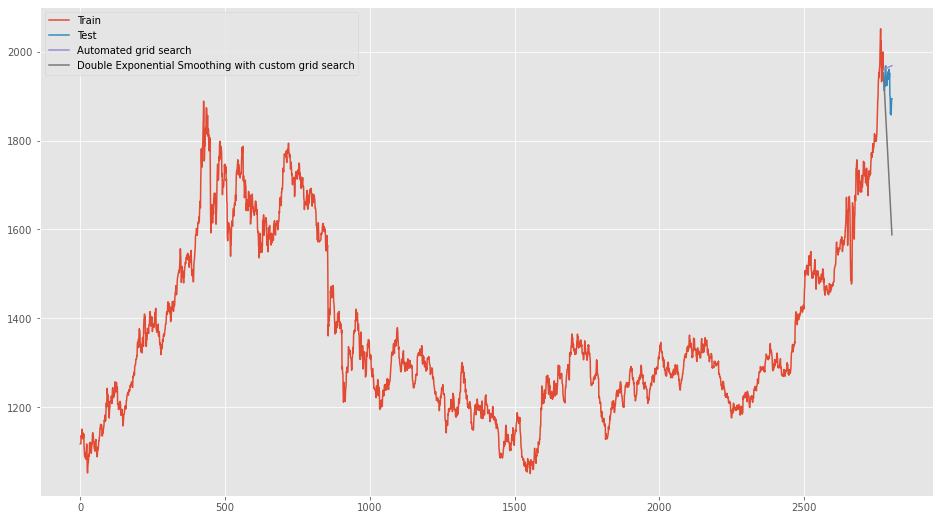

In [62]:
get_ipython().run_line_magic('matplotlib', 'inline')
plt.rcParams["figure.figsize"] = [16,9]
plt.plot( train, label='Train')
plt.plot(test, label='Test')
plt.plot(fitESAUTOpred, label='Automated grid search')
plt.plot(Forecast_custom_pred, label='Double Exponential Smoothing with custom grid search')
plt.legend(loc='best')
plt.show()

From the evaluation metrics and graph, we can see that the double
exponential smoothing performed significantly better than simple
exponential smoothing.

## Triple Exponential Smoothing
Triple exponential smoothing forecasting method enforces
exponential smoothing three times. This method can be applied when the
data consumes trends and seasonality over time. It includes all smoothing
component equations such as trends and seasonality. Seasonality
comprises two different types, such as additive and multiplicative, which
is a similar operation in mathematics. The Winter method uses the idea
of the Holt method and adds seasonality.

In [67]:
from sklearn.model_selection import ParameterGrid
from timeit import default_timer as timer

param_grid = {'trend': ['add', 'mul'],'seasonal' :['add','mul'],
              'seasonal_periods':[3,6,12], 'smoothing_level': [0.10,0.20,.30,.40,.50,.60,.70,.80,.90], 
              'smoothing_slope':[0.10, 0.20,.30,.40,.50,.60,.70,.80,.90],
              'damping_slope': [0.10, 0.20,.30,.40,.50,.60,.70,.80,.90],
              'damped' : [True, False], 'use_boxcox':[True, False],
              'remove_bias':[True, False],'use_basinhopping':[True, False]}
pg = list(ParameterGrid(param_grid))
df_results_moni = pd.DataFrame(columns=['trend','seasonal_periods','smoothing_level', 
                                        'smoothing_slope','damping_slope','damped','use_boxcox',
                                        'remove_bias','use_basinhopping','RMSE','r2'])
start = timer()
print('Starting Grid Search..')
for a,b in enumerate(pg):
    trend = b.get('trend')
    smoothing_level = b.get('smoothing_level')
    seasonal_periods = b.get('seasonal_periods')
    smoothing_level = b.get('smoothing_level')
    smoothing_slope = b.get('smoothing_slope')
    damping_slope = b.get('damping_slope')
    damped = b.get('damped')

use_boxcox = b.get('use_boxcox')
remove_bias = b.get('remove_bias')
use_basinhopping = b.get('use_basinhopping')
#print(trend,smoothing_level, smoothing_slope,damping_slope,damped,use_boxcox,remove_bias,use_basinhopping)
fit1 = ExponentialSmoothing(train,trend=trend,damped=damped,
                            seasonal_periods=seasonal_periods ).fit(smoothing_level=smoothing_level,
                                                                    smoothing_slope=smoothing_slope, 
                                                                    damping_slope = damping_slope,
                                                                    use_boxcox=use_boxcox,optimized=False)

#fit1.summary
z = fit1.forecast(30)
#print(z)
df_pred = pd.DataFrame(z, columns=['Forecasted_result'])
RMSE = np.sqrt(metrics.mean_squared_error(test, df_pred.Forecasted_result))
r2 = metrics.r2_score(test, df_pred.Forecasted_result)
#print( f' RMSE is {np.sqrt(metrics.mean_squared_error(test, df_pred.Forecasted_result))}')
df_results_moni = df_results_moni.append({'trend':trend,'seasonal_periods':seasonal_periods,
                                          'smoothing_level':smoothing_level, 
                                          'smoothing_slope':smoothing_slope,
                                          'damping_slope':damping_slope,'damped':damped,
                                          'use_boxcox':use_boxcox,'use_basinhopping':use_basinhopping,
                                          'RMSE':RMSE, 'r2':r2}, ignore_index=True)
print('End of Grid Search')
end = timer()
print(f' Total time taken to complete grid search in seconds:{(end - start)}')

Starting Grid Search..


<IPython.core.display.Javascript object>

End of Grid Search
 Total time taken to complete grid search in seconds:3.599389199996949


In [68]:
print(f' Below mentioned parameter gives least RMSE and r2')
df_results_moni.sort_values(by=['RMSE','r2']).head(1)

 Below mentioned parameter gives least RMSE and r2


trend seasonal_periods  smoothing_level  smoothing_slope  damping_slope  \
0   mul               12              0.9              0.9            0.9   

  damped use_boxcox  remove_bias use_basinhopping        RMSE         r2  
0  False      False          NaN            False  402.772099 -165.41376

In [69]:
fit1 = ExponentialSmoothing(train,trend='mul',
                            damped=False,seasonal_periods=3 ).fit(smoothing_level=0.9,
                                                                  smoothing_slope=0.6, damping_slope = 0.6,
                                                                  use_boxcox=False,use_basinhopping = True,
                                                                  optimized=False)
Forecast_custom_pred = fit1.forecast(30)
fit1.summary()
timeseries_evaluation_metrics_func(test,Forecast_custom_pred)

Evaluation metric results:-
MSE is : 26062.080318836488
MAE is : 140.40992667961206


<IPython.core.display.Javascript object>

RMSE is : 161.437543089693


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

MAPE is : 7.313398247184836
R2 is : -25.734961001022235



In [70]:
fitESAUTO = ExponentialSmoothing(train).fit(optimized= True,use_brute = True)
fitESAUTO.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       ExponentialSmoothing Model Results                       
================================================================================
Dep. Variable:                    endog   No. Observations:                 2774
Model:             ExponentialSmoothing   SSE                         587348.119
Optimized:                         True   AIC                          14859.678
Trend:                             None   BIC                          14871.534
Seasonal:                          None   AICC                         14859.693
Seasonal Periods:                  None   Date:                 Mon, 26 Oct 2020
Box-Cox:                          False   Time:                         11:50:12
Box-Cox Coeff.:                    None                                         
==============================================================================
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.9820586                alpha                 True
initial_level              1117.7000                  l.0                 True
------------------------------------------------------------------------------
"""

In [71]:
fitESAUTOpred = fitESAUTO.forecast(30)

In [72]:
timeseries_evaluation_metrics_func(test,fitESAUTOpred)

Evaluation metric results:-
MSE is : 2139.59233751442
MAE is : 35.65518201122832


<IPython.core.display.Javascript object>

RMSE is : 46.255727618473585


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

MAPE is : 1.8773434038995132
R2 is : -1.1948331446201195



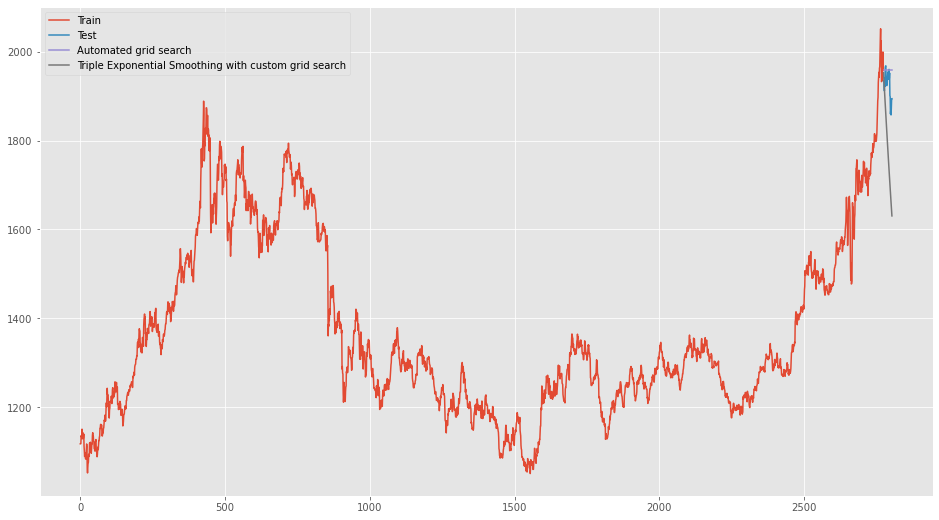

In [73]:
get_ipython().run_line_magic('matplotlib', 'inline')
plt.rcParams["figure.figsize"] = [16,9]
plt.plot( train, label='Train')
plt.plot(test, label='Test')
plt.plot(fitESAUTOpred, label='Automated grid search')
plt.plot(Forecast_custom_pred, label='Triple Exponential Smoothing with custom grid search')
plt.legend(loc='best')
plt.show()

By carefully observing evaluation metrics and graphs, we can conclude
that triple exponential smoothing behaves the same way as double exponential
smoothing.
Therefore, we can conclude the following:
- If there is no presence of trend or seasonality, then use simple exponential smoothing.
- If there is a presence of trend and no seasonality, use double exponential smoothing.
- If there is a presence of trend and seasonality, then use triple exponential smoothing.